# Создание модели FasterRCNN_resnet50

In [9]:
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from pycocotools.coco import COCO
import torchvision.transforms as T
import os
from torchvision.io import read_image
from torchvision import tv_tensors
from torchvision.transforms.v2  import functional as F



## Создание датасета

In [16]:
path_train = r'C:\Users\bigbl\OneDrive\Документы\УРФУ\4 семестр\Проект по поиску морского мусора\marine_debris\train'
path_test = r'C:\Users\bigbl\OneDrive\Документы\УРФУ\4 семестр\Проект по поиску морского мусора\marine_debris\valid'

In [18]:
class MarineDebrisDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(root + '\\' + r'_annotations.coco.json')
        self.img_ids = list(sorted(self.coco.imgs.keys()))


    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info['file_name'])
        img = read_image(img_path).float()
        img/=255.0
        
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        
        valid_anns = [ann for ann in anns if len(ann['bbox']) == 4 and all(x >= 0 for x in ann['bbox'])]
        
        if not valid_anns:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = []
            labels = []
            for ann in valid_anns:
                x, y, w, h = ann['bbox']
                boxes.append([x, y, x + w, y + h])
                labels.append(ann['category_id'])
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # Создаем target с проверкой на пустые bbox
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": torch.zeros((len(boxes),), dtype=torch.float32) if len(boxes) == 0 
                  else (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            "iscrowd": torch.zeros((len(labels),), dtype=torch.int64)
        }
        if self.transforms:
            img, target = self.transforms(img, target)
            
        return img, target

    def __len__(self):
        return len(self.img_ids)

In [22]:
# Тестируем
dataset = MarineDebrisDataset(root=path_train)
img, target = dataset[0]  # Проверяем первый элемент

print(f"Image shape: {img.shape}")
print(f"Number of objects: {len(target['boxes'])}")
print(f"Labels: {target['labels']}")
print(f"Boxes: {target['boxes']}")

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Image shape: torch.Size([3, 640, 640])
Number of objects: 5
Labels: tensor([3, 2, 2, 1, 2])
Boxes: tensor([[480., 327., 539., 429.],
        [377., 192., 443., 261.],
        [151., 495., 282., 577.],
        [310., 504., 384., 568.],
        [  0., 197.,  27., 280.]])


In [24]:
def collate_fn(batch):
    return tuple(zip(*batch))  


dataset = MarineDebrisDataset(root=path_train)
train_loader = DataLoader(
    dataset,
    batch_size=2,  
    shuffle=True,
    collate_fn=collate_fn)

test_dataset = MarineDebrisDataset(root=path_test)
test_loader = DataLoader(
    test_dataset,
    batch_size=2,  
    shuffle=True,
    collate_fn=collate_fn)



# batch = next(iter(train_loader))
# images, targets = batch

# print(f"Количество изображений в batch: {len(images)}")
# print(f"Тип targets: {type(targets)}")
# print(f"Количество элементов в targets: {len(targets)}")

# # Проверяем первое изображение и его аннотации
# print("\nПример первого изображения:")
# print(f"Размер изображения: {images[1].shape}")
# print("\nСоответствующие target:")
# print(f"Количество bbox: {len(targets[0]['boxes'])}")
# print(f"Bbox : {targets[0]['boxes']}")
# print(f"Метки классов: {targets[0]['labels']}")

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [6]:
## Тестировал и проверял
# b = next(iter(test_loader))
# imgs, targs = b
# # plt.imshow(imgs[0][2])
# for i in range(len(test_dataset)):
#     print(test_dataset[i][0])

## Загрузка модели, настройка, обучение

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
num_classes = 6
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [8]:
import torch.optim as optim

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Current device: ', device)
model.to(device)
print()


Current device:  cuda



In [9]:
torch.cuda.empty_cache()

## Обучение и

In [19]:
import pickle 
# !pip install torchmetrics
from torchmetrics.detection import MeanAveragePrecision
from time import perf_counter

num_epochs = 40
losses_epoches = []
map_and_map50_epoches = []
time_epoches = []

for epoch in tqdm(range(num_epochs)):
    print(f'Starting {epoch+1} epoch')
    model.train()
    
    total_loss = 0
    to_saved_losses = []
    start_time = perf_counter()
    
    for batch_idx, (images, targets) in tqdm(enumerate(train_loader)):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        # print(f'loss_dict -> {loss_dict}')
        losses = sum(loss for loss in loss_dict.values())
        # print(f'losses -> {losses}')

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += losses.item()
        to_saved_losses.append(losses.item())

        
        if batch_idx % 50 == 0:
            print(f'Epoch: {epoch+1}, Batch: {batch_idx+1}, Loss: {losses.item():.4f}')
    
    lr_scheduler.step()
    print(f'Epoch {epoch+1} finished. Total loss: {total_loss:.4f}')
    
    losses_epoches.append(tuple(to_saved_losses))
    total_time_epoch = perf_counter() - start_time
    print(f'Epoch end at {total_time_epoch:.2f} sec')
    time_epoches.append(total_time_epoch)

    ################ Test ##################

    metric = MeanAveragePrecision()
    # model.to(device)
    model.eval()
    with torch.no_grad():
        for i, (images, targets) in enumerate(test_loader):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            preds = model(images)
            # print(preds)
            
            formatted_preds = []
            for pred in preds:
                formatted_preds.append({
                    'boxes': pred['boxes'],
                    'scores': pred['scores'],
                    'labels': pred['labels']
                })
            
            metric.update(formatted_preds, targets)
            del preds, formatted_preds
    
    result = metric.compute()
    mAP = result['map'].item()
    mAP50 = result['map_50'].item()
    print(f"mAP: {mAP:.4f}")  
    print(f"mAP@50: {mAP50:.4f}")  

    map_and_map50_epoches.append((mAP, mAP50))
    torch.cuda.empty_cache()


########################################
torch.save(model.state_dict(), 'FastRCNN_resnet50_fpn_(40epoches).pth')
print('Saved!')

with open('losses_epoches.pkl', 'wb') as file: 
    pickle.dump(losses_epoches, file)
with open('time_epoches.pkl', 'wb') as file: 
    pickle.dump(time_epoches, file)
with open('map_and_map50_epoches.pkl', 'wb') as file: 
    pickle.dump(map_and_map50_epoches, file)


  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

Starting 1 epoch



0it [00:00, ?it/s]
1it [00:06,  6.50s/it]

Epoch: 1, Batch: 1, Loss: 3.7750



2it [00:12,  6.19s/it]
3it [00:18,  6.03s/it]
4it [00:24,  5.98s/it]
5it [00:30,  5.94s/it]
6it [00:36,  5.95s/it]
7it [00:41,  5.93s/it]
8it [00:45,  5.17s/it]
9it [00:46,  3.71s/it]
10it [00:46,  2.72s/it]
11it [00:47,  2.04s/it]
12it [00:47,  1.57s/it]
13it [00:48,  1.25s/it]
14it [00:48,  1.01s/it]
15it [00:48,  1.18it/s]
16it [00:49,  1.37it/s]
17it [00:49,  1.55it/s]
18it [00:50,  1.70it/s]
19it [00:50,  1.82it/s]
20it [00:51,  1.92it/s]
21it [00:51,  1.99it/s]
22it [00:52,  2.04it/s]
23it [00:52,  2.09it/s]
24it [00:53,  2.11it/s]
25it [00:53,  2.13it/s]
26it [00:53,  2.14it/s]
27it [00:54,  2.15it/s]
28it [00:54,  2.17it/s]
29it [00:55,  2.17it/s]
30it [00:55,  2.16it/s]
31it [00:56,  2.17it/s]
32it [00:56,  2.17it/s]
33it [00:57,  2.17it/s]
34it [00:57,  2.15it/s]
35it [00:58,  2.16it/s]
36it [00:58,  2.16it/s]
37it [00:59,  2.16it/s]
38it [00:59,  2.16it/s]
39it [00:59,  2.16it/s]
40it [01:00,  2.17it/s]
41it [01:00,  2.15it/s]
42it [01:01,  2.15it/s]
43it [01:01,  2.14it/s]

Epoch: 1, Batch: 51, Loss: 0.9415



52it [01:06,  1.84it/s]
53it [01:06,  1.85it/s]
54it [01:07,  1.82it/s]
55it [01:08,  1.83it/s]
56it [01:08,  1.90it/s]
57it [01:08,  1.96it/s]
58it [01:09,  2.01it/s]
59it [01:09,  2.02it/s]
60it [01:10,  2.04it/s]
61it [01:10,  2.04it/s]
62it [01:11,  2.05it/s]
63it [01:11,  2.07it/s]
64it [01:12,  1.99it/s]
65it [01:12,  2.02it/s]
66it [01:13,  1.97it/s]
67it [01:13,  2.00it/s]
68it [01:14,  2.03it/s]
69it [01:14,  2.04it/s]
70it [01:15,  2.06it/s]
71it [01:15,  1.97it/s]
72it [01:16,  2.00it/s]
73it [01:16,  2.03it/s]
74it [01:17,  2.03it/s]
75it [01:17,  2.03it/s]
76it [01:18,  2.05it/s]
77it [01:18,  2.05it/s]
78it [01:19,  2.05it/s]
79it [01:19,  2.04it/s]
80it [01:20,  2.04it/s]
81it [01:20,  2.05it/s]
82it [01:21,  2.05it/s]
83it [01:21,  2.03it/s]
84it [01:22,  2.03it/s]
85it [01:22,  2.03it/s]
86it [01:23,  2.04it/s]
87it [01:23,  2.03it/s]
88it [01:24,  2.04it/s]
89it [01:24,  2.04it/s]
90it [01:25,  2.04it/s]
91it [01:25,  2.03it/s]
92it [01:26,  2.02it/s]
93it [01:26,  2

Epoch: 1, Batch: 101, Loss: 1.3538



102it [01:31,  2.00it/s]
103it [01:31,  1.99it/s]
104it [01:32,  1.98it/s]
105it [01:32,  1.99it/s]
106it [01:33,  1.98it/s]
107it [01:33,  1.97it/s]
108it [01:34,  1.98it/s]
109it [01:34,  1.99it/s]
110it [01:35,  1.99it/s]
111it [01:35,  2.00it/s]
112it [01:36,  1.97it/s]
113it [01:36,  1.99it/s]
114it [01:37,  1.98it/s]
115it [01:37,  2.01it/s]
116it [01:38,  1.97it/s]
117it [01:38,  1.98it/s]
118it [01:39,  1.98it/s]
119it [01:39,  1.90it/s]
120it [01:40,  1.89it/s]
121it [01:40,  1.94it/s]
122it [01:41,  1.96it/s]
123it [01:41,  1.98it/s]
124it [01:42,  1.98it/s]
125it [01:42,  1.97it/s]
126it [01:43,  1.98it/s]
127it [01:43,  1.98it/s]
128it [01:44,  1.98it/s]
129it [01:44,  1.97it/s]
130it [01:45,  1.97it/s]
131it [01:45,  1.97it/s]
132it [01:46,  1.96it/s]
133it [01:46,  1.96it/s]
134it [01:47,  1.96it/s]
135it [01:47,  1.96it/s]
136it [01:48,  1.96it/s]
137it [01:48,  1.96it/s]
138it [01:49,  1.96it/s]
139it [01:49,  1.95it/s]
140it [01:50,  1.96it/s]
141it [01:51,  1.95it/s]

Epoch: 1, Batch: 151, Loss: 1.4696



152it [01:56,  1.95it/s]
153it [01:57,  1.87it/s]
154it [01:57,  1.87it/s]
155it [01:58,  1.90it/s]
156it [01:58,  1.92it/s]
157it [01:59,  1.92it/s]
158it [01:59,  1.93it/s]
159it [02:00,  1.93it/s]
160it [02:00,  1.84it/s]
161it [02:01,  1.84it/s]
162it [02:02,  1.88it/s]
163it [02:02,  1.90it/s]
164it [02:03,  1.91it/s]
165it [02:03,  1.91it/s]
166it [02:04,  1.91it/s]
167it [02:04,  1.92it/s]
168it [02:05,  1.92it/s]
169it [02:05,  1.93it/s]
170it [02:06,  1.91it/s]
171it [02:06,  1.92it/s]
172it [02:07,  1.88it/s]
173it [02:07,  1.91it/s]
174it [02:08,  1.90it/s]
175it [02:08,  1.90it/s]
176it [02:09,  1.93it/s]
177it [02:09,  1.93it/s]
178it [02:10,  1.92it/s]
179it [02:10,  1.90it/s]
180it [02:11,  1.91it/s]
181it [02:11,  1.92it/s]
182it [02:12,  1.92it/s]
183it [02:12,  1.90it/s]
184it [02:13,  1.89it/s]
185it [02:14,  1.91it/s]
186it [02:14,  1.90it/s]
187it [02:15,  1.91it/s]
188it [02:15,  1.90it/s]
189it [02:16,  1.89it/s]
190it [02:16,  1.88it/s]
191it [02:17,  1.89it/s]

Epoch: 1, Batch: 201, Loss: 0.8587



202it [02:23,  1.88it/s]
203it [02:23,  1.88it/s]
204it [02:24,  1.90it/s]
205it [02:24,  1.87it/s]
206it [02:25,  1.86it/s]
207it [02:25,  1.92it/s]
208it [02:26,  1.88it/s]
209it [02:26,  1.89it/s]
210it [02:27,  1.88it/s]
211it [02:27,  1.85it/s]
212it [02:28,  1.86it/s]
213it [02:28,  1.84it/s]
214it [02:29,  1.86it/s]
215it [02:29,  1.87it/s]
216it [02:30,  1.86it/s]
217it [02:31,  1.88it/s]
218it [02:31,  1.85it/s]
219it [02:32,  1.86it/s]
220it [02:32,  1.85it/s]
221it [02:33,  1.86it/s]
222it [02:33,  1.86it/s]
223it [02:34,  1.86it/s]
224it [02:34,  1.86it/s]
225it [02:35,  1.88it/s]
226it [02:35,  1.86it/s]
227it [02:36,  1.87it/s]
228it [02:36,  1.87it/s]
229it [02:37,  1.88it/s]
230it [02:37,  1.89it/s]
231it [02:38,  1.87it/s]
232it [02:39,  1.88it/s]
233it [02:39,  1.87it/s]
234it [02:40,  1.89it/s]
235it [02:40,  1.90it/s]
236it [02:41,  1.89it/s]
237it [02:41,  1.91it/s]
238it [02:42,  1.91it/s]
239it [02:42,  1.91it/s]
240it [02:43,  1.92it/s]
241it [02:43,  1.92it/s]

Epoch: 1, Batch: 251, Loss: 1.0736



252it [02:49,  1.93it/s]
253it [02:50,  1.93it/s]
254it [02:50,  1.93it/s]
255it [02:51,  1.96it/s]
256it [02:51,  1.90it/s]
257it [02:52,  1.93it/s]
258it [02:52,  1.91it/s]
259it [02:53,  1.92it/s]
260it [02:53,  1.90it/s]
261it [02:54,  1.92it/s]
262it [02:54,  1.84it/s]
263it [02:55,  1.85it/s]
264it [02:55,  1.88it/s]
265it [02:56,  1.82it/s]
266it [02:56,  1.84it/s]
267it [02:57,  1.90it/s]
268it [02:58,  1.88it/s]
269it [02:58,  1.89it/s]
270it [02:59,  1.86it/s]
271it [02:59,  1.88it/s]
272it [03:00,  1.86it/s]
273it [03:00,  1.88it/s]
274it [03:01,  1.88it/s]
275it [03:01,  1.93it/s]
276it [03:02,  1.92it/s]
277it [03:02,  1.95it/s]
278it [03:03,  1.91it/s]
279it [03:03,  1.94it/s]
280it [03:04,  1.92it/s]
281it [03:04,  1.94it/s]
282it [03:05,  1.93it/s]
283it [03:05,  1.95it/s]
284it [03:06,  1.95it/s]
285it [03:06,  1.96it/s]
286it [03:07,  1.92it/s]
287it [03:07,  1.94it/s]
288it [03:08,  1.92it/s]
289it [03:08,  1.95it/s]
290it [03:09,  1.94it/s]
291it [03:09,  1.96it/s]

Epoch: 1, Batch: 301, Loss: 0.7695



302it [03:15,  1.94it/s]
303it [03:16,  1.85it/s]
304it [03:16,  1.92it/s]
305it [03:17,  1.90it/s]
306it [03:17,  1.92it/s]
307it [03:18,  1.93it/s]
308it [03:18,  1.92it/s]
309it [03:19,  1.93it/s]
310it [03:19,  1.98it/s]
311it [03:20,  1.96it/s]
312it [03:20,  1.91it/s]
313it [03:21,  1.93it/s]
314it [03:21,  1.96it/s]
315it [03:22,  1.95it/s]
316it [03:23,  1.99it/s]
317it [03:23,  1.95it/s]
318it [03:24,  1.93it/s]
319it [03:24,  1.93it/s]
320it [03:25,  1.94it/s]
321it [03:25,  1.93it/s]
322it [03:26,  1.94it/s]
323it [03:26,  1.93it/s]
324it [03:27,  1.91it/s]
325it [03:27,  1.91it/s]
326it [03:28,  1.94it/s]
327it [03:28,  1.93it/s]
328it [03:29,  1.92it/s]
329it [03:29,  1.93it/s]
330it [03:30,  1.92it/s]
331it [03:30,  1.94it/s]
332it [03:31,  1.92it/s]
333it [03:31,  1.93it/s]
334it [03:32,  1.94it/s]
335it [03:32,  1.94it/s]
336it [03:33,  1.94it/s]
337it [03:33,  1.94it/s]
338it [03:34,  1.93it/s]
339it [03:34,  1.94it/s]
340it [03:35,  1.94it/s]
341it [03:35,  1.94it/s]

Epoch: 1, Batch: 351, Loss: 1.1587



352it [03:41,  1.92it/s]
353it [03:42,  1.94it/s]
354it [03:42,  1.92it/s]
355it [03:43,  1.94it/s]
356it [03:43,  1.93it/s]
357it [03:44,  1.92it/s]
358it [03:44,  1.93it/s]
359it [03:45,  1.94it/s]
360it [03:45,  1.92it/s]
361it [03:46,  1.93it/s]
362it [03:46,  1.93it/s]
363it [03:47,  1.92it/s]
364it [03:48,  1.84it/s]
365it [03:48,  1.86it/s]
366it [03:49,  1.88it/s]
367it [03:49,  1.88it/s]
368it [03:50,  1.88it/s]
369it [03:50,  1.90it/s]
370it [03:51,  1.90it/s]
371it [03:51,  1.92it/s]
372it [03:52,  1.91it/s]
373it [03:52,  1.91it/s]
374it [03:53,  1.91it/s]
375it [03:53,  1.91it/s]
376it [03:54,  1.81it/s]
377it [03:54,  1.83it/s]
378it [03:55,  1.86it/s]
379it [03:55,  1.90it/s]
380it [03:56,  1.88it/s]
381it [03:57,  1.90it/s]
382it [03:57,  1.92it/s]
383it [03:58,  1.93it/s]
384it [03:58,  1.92it/s]
385it [03:59,  1.82it/s]
386it [03:59,  1.87it/s]
387it [04:00,  1.89it/s]
388it [04:00,  1.91it/s]
389it [04:01,  1.91it/s]
390it [04:01,  1.91it/s]
391it [04:02,  1.91it/s]

Epoch: 1, Batch: 401, Loss: 0.6039



402it [04:08,  1.91it/s]
403it [04:08,  1.90it/s]
404it [04:09,  1.91it/s]
405it [04:09,  1.92it/s]
406it [04:10,  1.93it/s]
407it [04:10,  1.91it/s]
408it [04:11,  1.92it/s]
409it [04:11,  1.91it/s]
410it [04:12,  1.91it/s]
411it [04:12,  1.90it/s]
412it [04:13,  1.91it/s]
413it [04:13,  1.90it/s]
414it [04:14,  1.88it/s]
415it [04:14,  1.90it/s]
416it [04:15,  1.82it/s]
417it [04:16,  1.83it/s]
418it [04:16,  1.87it/s]
419it [04:17,  1.90it/s]
420it [04:17,  1.91it/s]
421it [04:18,  1.91it/s]
422it [04:18,  1.91it/s]
423it [04:19,  1.92it/s]
424it [04:19,  1.94it/s]
425it [04:20,  1.93it/s]
426it [04:20,  1.92it/s]
427it [04:21,  1.92it/s]
428it [04:21,  1.89it/s]
429it [04:22,  1.92it/s]
430it [04:22,  1.90it/s]
431it [04:23,  1.91it/s]
432it [04:23,  1.94it/s]
433it [04:24,  1.92it/s]
434it [04:24,  1.97it/s]
435it [04:25,  1.92it/s]
436it [04:25,  1.93it/s]
437it [04:26,  1.92it/s]
438it [04:26,  1.93it/s]
439it [04:27,  1.89it/s]
440it [04:28,  1.89it/s]
441it [04:28,  1.89it/s]

Epoch: 1, Batch: 451, Loss: 1.0631



452it [04:34,  1.94it/s]
453it [04:34,  1.90it/s]
454it [04:35,  1.91it/s]
455it [04:35,  1.90it/s]
456it [04:36,  1.91it/s]
457it [04:36,  1.92it/s]
458it [04:37,  1.91it/s]
459it [04:38,  1.79it/s]
460it [04:38,  1.81it/s]
461it [04:39,  1.87it/s]
462it [04:39,  1.85it/s]
463it [04:40,  1.88it/s]
464it [04:40,  1.81it/s]
465it [04:41,  1.86it/s]
466it [04:41,  1.88it/s]
467it [04:42,  1.91it/s]
468it [04:42,  1.90it/s]
469it [04:43,  1.93it/s]
470it [04:43,  1.93it/s]
471it [04:44,  1.95it/s]
472it [04:44,  1.92it/s]
473it [04:45,  1.94it/s]
474it [04:45,  1.94it/s]
475it [04:46,  1.95it/s]
476it [04:46,  1.93it/s]
477it [04:47,  1.93it/s]
478it [04:47,  1.93it/s]
479it [04:48,  1.92it/s]
480it [04:49,  1.92it/s]
481it [04:49,  1.93it/s]
482it [04:50,  1.93it/s]
483it [04:50,  1.93it/s]
484it [04:51,  1.95it/s]
485it [04:51,  1.95it/s]
486it [04:52,  1.86it/s]
487it [04:52,  1.87it/s]
488it [04:53,  1.90it/s]
489it [04:53,  1.92it/s]
490it [04:54,  1.91it/s]
491it [04:54,  1.86it/s]

Epoch: 1, Batch: 501, Loss: 0.8939



502it [05:00,  1.89it/s]
503it [05:01,  1.92it/s]
504it [05:01,  1.91it/s]
505it [05:02,  1.92it/s]
506it [05:02,  1.91it/s]
507it [05:03,  1.92it/s]
508it [05:03,  1.88it/s]
509it [05:04,  1.91it/s]
510it [05:04,  1.83it/s]
511it [05:05,  1.84it/s]
512it [05:05,  1.88it/s]
513it [05:06,  1.83it/s]
514it [05:07,  1.84it/s]
515it [05:07,  1.87it/s]
516it [05:08,  1.80it/s]
517it [05:08,  1.81it/s]
518it [05:09,  1.86it/s]
519it [05:09,  1.87it/s]
520it [05:10,  1.87it/s]
521it [05:10,  1.89it/s]
522it [05:11,  1.88it/s]
523it [05:11,  1.89it/s]
524it [05:12,  1.82it/s]
525it [05:12,  1.83it/s]
526it [05:13,  1.87it/s]
527it [05:14,  1.87it/s]
528it [05:14,  1.89it/s]
529it [05:15,  1.94it/s]
530it [05:15,  1.84it/s]
531it [05:16,  1.89it/s]
532it [05:16,  1.79it/s]
533it [05:17,  1.81it/s]
534it [05:17,  1.85it/s]
535it [05:18,  1.87it/s]
536it [05:18,  1.89it/s]
537it [05:19,  1.91it/s]
538it [05:19,  1.92it/s]
539it [05:20,  1.93it/s]
540it [05:20,  1.94it/s]
541it [05:21,  1.94it/s]

Epoch: 1, Batch: 551, Loss: 1.2434



552it [05:27,  1.93it/s]
553it [05:27,  1.94it/s]
554it [05:28,  1.94it/s]
555it [05:28,  1.94it/s]
556it [05:29,  1.92it/s]
557it [05:29,  1.92it/s]
558it [05:30,  1.92it/s]
559it [05:30,  1.92it/s]
560it [05:31,  1.92it/s]
561it [05:31,  1.91it/s]
562it [05:32,  1.85it/s]
563it [05:33,  1.84it/s]
564it [05:33,  1.88it/s]
565it [05:34,  1.81it/s]
566it [05:34,  1.82it/s]
567it [05:35,  1.87it/s]
568it [05:35,  1.92it/s]
569it [05:36,  1.88it/s]
570it [05:36,  1.89it/s]
571it [05:37,  1.89it/s]
572it [05:37,  1.89it/s]
573it [05:38,  1.89it/s]
574it [05:38,  1.89it/s]
575it [05:39,  1.90it/s]
576it [05:39,  1.91it/s]
577it [05:40,  1.95it/s]
578it [05:40,  1.91it/s]
579it [05:41,  1.92it/s]
580it [05:42,  1.91it/s]
581it [05:42,  1.92it/s]
582it [05:43,  1.90it/s]
583it [05:43,  1.91it/s]
584it [05:44,  1.81it/s]
585it [05:44,  1.82it/s]
586it [05:45,  1.86it/s]
587it [05:45,  1.91it/s]
588it [05:46,  1.88it/s]
589it [05:46,  1.89it/s]
590it [05:47,  1.89it/s]
591it [05:47,  1.90it/s]

Epoch: 1, Batch: 601, Loss: 0.8333



602it [05:53,  1.86it/s]
603it [05:54,  1.87it/s]
604it [05:54,  1.92it/s]
605it [05:55,  1.90it/s]
606it [05:55,  1.90it/s]
607it [05:56,  1.89it/s]
608it [05:56,  1.91it/s]
609it [05:57,  1.89it/s]
610it [05:57,  1.88it/s]
611it [05:58,  1.92it/s]
612it [05:59,  1.89it/s]
613it [05:59,  1.91it/s]
614it [06:00,  1.89it/s]
615it [06:00,  1.90it/s]
616it [06:01,  1.91it/s]
617it [06:01,  1.92it/s]
618it [06:02,  1.90it/s]
619it [06:02,  1.90it/s]
620it [06:03,  1.91it/s]
621it [06:03,  1.92it/s]
622it [06:04,  1.92it/s]
623it [06:04,  1.90it/s]
624it [06:05,  1.92it/s]
625it [06:05,  1.91it/s]
626it [06:06,  1.91it/s]
627it [06:06,  1.89it/s]
628it [06:07,  1.91it/s]
629it [06:07,  1.90it/s]
630it [06:08,  1.91it/s]
631it [06:09,  1.80it/s]
632it [06:09,  1.85it/s]
633it [06:10,  1.86it/s]
634it [06:10,  1.89it/s]
635it [06:11,  1.86it/s]
636it [06:11,  1.87it/s]
637it [06:12,  1.89it/s]
638it [06:12,  1.90it/s]
639it [06:13,  1.92it/s]
640it [06:13,  1.91it/s]
641it [06:14,  1.92it/s]

Epoch: 1, Batch: 651, Loss: 0.5728



652it [06:20,  1.92it/s]
653it [06:20,  1.84it/s]
654it [06:21,  1.86it/s]
655it [06:21,  1.89it/s]
656it [06:22,  1.89it/s]
657it [06:22,  1.91it/s]
658it [06:23,  1.92it/s]
659it [06:23,  1.93it/s]
660it [06:24,  1.91it/s]
661it [06:24,  1.92it/s]
662it [06:25,  1.94it/s]
663it [06:25,  1.92it/s]
664it [06:26,  1.92it/s]
665it [06:26,  1.93it/s]
666it [06:27,  1.93it/s]
667it [06:27,  1.92it/s]
668it [06:28,  1.72it/s]


Epoch 1 finished. Total loss: 656.8019
Epoch end at 388.21 sec


  2%|██                                                                              | 1/40 [06:44<4:22:54, 404.48s/it]

mAP: 0.1871
mAP@50: 0.3743
Starting 2 epoch



0it [00:00, ?it/s]
1it [00:00,  2.07it/s]

Epoch: 2, Batch: 1, Loss: 0.4915



2it [00:01,  1.86it/s]
3it [00:01,  1.89it/s]
4it [00:02,  1.83it/s]
5it [00:02,  1.86it/s]
6it [00:03,  1.88it/s]
7it [00:03,  1.90it/s]
8it [00:04,  1.90it/s]
9it [00:04,  1.91it/s]
10it [00:05,  1.92it/s]
11it [00:05,  1.91it/s]
12it [00:06,  1.92it/s]
13it [00:06,  1.93it/s]
14it [00:07,  1.93it/s]
15it [00:07,  1.92it/s]
16it [00:08,  1.91it/s]
17it [00:08,  1.92it/s]
18it [00:09,  1.92it/s]
19it [00:09,  1.92it/s]
20it [00:10,  1.88it/s]
21it [00:11,  1.89it/s]
22it [00:11,  1.90it/s]
23it [00:12,  1.91it/s]
24it [00:12,  1.91it/s]
25it [00:13,  1.91it/s]
26it [00:13,  1.92it/s]
27it [00:14,  1.92it/s]
28it [00:14,  1.92it/s]
29it [00:15,  1.88it/s]
30it [00:15,  1.91it/s]
31it [00:16,  1.94it/s]
32it [00:16,  1.92it/s]
33it [00:17,  1.91it/s]
34it [00:17,  1.91it/s]
35it [00:18,  1.94it/s]
36it [00:18,  1.92it/s]
37it [00:19,  1.92it/s]
38it [00:19,  1.88it/s]
39it [00:20,  1.92it/s]
40it [00:21,  1.85it/s]
41it [00:21,  1.87it/s]
42it [00:22,  1.90it/s]
43it [00:22,  1.87it/s]

Epoch: 2, Batch: 51, Loss: 0.8005



52it [00:27,  1.91it/s]
53it [00:27,  1.91it/s]
54it [00:28,  1.91it/s]
55it [00:28,  1.91it/s]
56it [00:29,  1.90it/s]
57it [00:29,  1.91it/s]
58it [00:30,  1.93it/s]
59it [00:30,  1.90it/s]
60it [00:31,  1.92it/s]
61it [00:31,  1.90it/s]
62it [00:32,  1.90it/s]
63it [00:33,  1.85it/s]
64it [00:33,  1.88it/s]
65it [00:34,  1.87it/s]
66it [00:34,  1.89it/s]
67it [00:35,  1.92it/s]
68it [00:35,  1.90it/s]
69it [00:36,  1.91it/s]
70it [00:36,  1.94it/s]
71it [00:37,  1.92it/s]
72it [00:37,  1.90it/s]
73it [00:38,  1.90it/s]
74it [00:38,  1.91it/s]
75it [00:39,  1.90it/s]
76it [00:39,  1.90it/s]
77it [00:40,  1.83it/s]
78it [00:41,  1.85it/s]
79it [00:41,  1.89it/s]
80it [00:42,  1.92it/s]
81it [00:42,  1.91it/s]
82it [00:43,  1.91it/s]
83it [00:43,  1.92it/s]
84it [00:44,  1.86it/s]
85it [00:44,  1.89it/s]
86it [00:45,  1.80it/s]
87it [00:45,  1.86it/s]
88it [00:46,  1.89it/s]
89it [00:46,  1.91it/s]
90it [00:47,  1.91it/s]
91it [00:47,  1.92it/s]
92it [00:48,  1.92it/s]
93it [00:48,  1

Epoch: 2, Batch: 101, Loss: 1.3134



102it [00:53,  1.93it/s]
103it [00:54,  1.92it/s]
104it [00:54,  1.94it/s]
105it [00:55,  1.93it/s]
106it [00:55,  1.94it/s]
107it [00:56,  1.93it/s]
108it [00:56,  1.91it/s]
109it [00:57,  1.89it/s]
110it [00:57,  1.90it/s]
111it [00:58,  1.95it/s]
112it [00:58,  1.90it/s]
113it [00:59,  1.92it/s]
114it [00:59,  1.88it/s]
115it [01:00,  1.91it/s]
116it [01:00,  1.91it/s]
117it [01:01,  1.91it/s]
118it [01:01,  1.91it/s]
119it [01:02,  1.88it/s]
120it [01:02,  1.90it/s]
121it [01:03,  1.91it/s]
122it [01:04,  1.92it/s]
123it [01:04,  1.90it/s]
124it [01:05,  1.91it/s]
125it [01:05,  1.83it/s]
126it [01:06,  1.85it/s]
127it [01:06,  1.89it/s]
128it [01:07,  1.88it/s]
129it [01:07,  1.91it/s]
130it [01:08,  1.92it/s]
131it [01:08,  1.93it/s]
132it [01:09,  1.81it/s]
133it [01:09,  1.83it/s]
134it [01:10,  1.88it/s]
135it [01:10,  1.93it/s]
136it [01:11,  1.90it/s]
137it [01:11,  1.91it/s]
138it [01:12,  1.92it/s]
139it [01:13,  1.93it/s]
140it [01:13,  1.94it/s]
141it [01:14,  1.94it/s]

Epoch: 2, Batch: 151, Loss: 0.6311



152it [01:19,  1.89it/s]
153it [01:20,  1.94it/s]
154it [01:20,  1.92it/s]
155it [01:21,  1.92it/s]
156it [01:21,  1.94it/s]
157it [01:22,  1.97it/s]
158it [01:22,  1.93it/s]
159it [01:23,  1.92it/s]
160it [01:23,  1.91it/s]
161it [01:24,  1.92it/s]
162it [01:25,  1.91it/s]
163it [01:25,  1.91it/s]
164it [01:26,  1.91it/s]
165it [01:26,  1.91it/s]
166it [01:27,  1.90it/s]
167it [01:27,  1.91it/s]
168it [01:28,  1.92it/s]
169it [01:28,  1.92it/s]
170it [01:29,  1.94it/s]
171it [01:29,  1.93it/s]
172it [01:30,  1.94it/s]
173it [01:30,  1.92it/s]
174it [01:31,  1.94it/s]
175it [01:31,  1.95it/s]
176it [01:32,  1.82it/s]
177it [01:32,  1.86it/s]
178it [01:33,  1.86it/s]
179it [01:33,  1.90it/s]
180it [01:34,  1.92it/s]
181it [01:34,  1.91it/s]
182it [01:35,  1.90it/s]
183it [01:36,  1.90it/s]
184it [01:36,  1.92it/s]
185it [01:37,  1.91it/s]
186it [01:37,  1.93it/s]
187it [01:38,  1.91it/s]
188it [01:38,  1.92it/s]
189it [01:39,  1.91it/s]
190it [01:39,  1.92it/s]
191it [01:40,  1.90it/s]

Epoch: 2, Batch: 201, Loss: 0.4868



202it [01:45,  1.89it/s]
203it [01:46,  1.88it/s]
204it [01:47,  1.91it/s]
205it [01:47,  1.89it/s]
206it [01:48,  1.91it/s]
207it [01:48,  1.91it/s]
208it [01:49,  1.90it/s]
209it [01:49,  1.92it/s]
210it [01:50,  1.88it/s]
211it [01:50,  1.90it/s]
212it [01:51,  1.89it/s]
213it [01:51,  1.90it/s]
214it [01:52,  1.91it/s]
215it [01:52,  1.91it/s]
216it [01:53,  1.83it/s]
217it [01:53,  1.82it/s]
218it [01:54,  1.87it/s]
219it [01:54,  1.86it/s]
220it [01:55,  1.89it/s]
221it [01:56,  1.91it/s]
222it [01:56,  1.87it/s]
223it [01:57,  1.89it/s]
224it [01:57,  1.81it/s]
225it [01:58,  1.82it/s]
226it [01:58,  1.86it/s]
227it [01:59,  1.89it/s]
228it [01:59,  1.90it/s]
229it [02:00,  1.90it/s]
230it [02:00,  1.91it/s]
231it [02:01,  1.93it/s]
232it [02:01,  1.91it/s]
233it [02:02,  1.94it/s]
234it [02:02,  1.92it/s]
235it [02:03,  1.93it/s]
236it [02:03,  1.91it/s]
237it [02:04,  1.91it/s]
238it [02:05,  1.82it/s]
239it [02:05,  1.84it/s]
240it [02:06,  1.88it/s]
241it [02:06,  1.82it/s]

Epoch: 2, Batch: 251, Loss: 0.7863



252it [02:12,  1.91it/s]
253it [02:13,  1.82it/s]
254it [02:13,  1.83it/s]
255it [02:14,  1.87it/s]
256it [02:14,  1.85it/s]
257it [02:15,  1.86it/s]
258it [02:15,  1.87it/s]
259it [02:16,  1.91it/s]
260it [02:16,  1.91it/s]
261it [02:17,  1.90it/s]
262it [02:17,  1.88it/s]
263it [02:18,  1.89it/s]
264it [02:18,  1.93it/s]
265it [02:19,  1.90it/s]
266it [02:19,  1.91it/s]
267it [02:20,  1.86it/s]
268it [02:20,  1.90it/s]
269it [02:21,  1.92it/s]
270it [02:21,  1.92it/s]
271it [02:22,  1.92it/s]
272it [02:23,  1.93it/s]
273it [02:23,  1.92it/s]
274it [02:24,  1.93it/s]
275it [02:24,  1.93it/s]
276it [02:25,  1.93it/s]
277it [02:25,  1.94it/s]
278it [02:26,  1.95it/s]
279it [02:26,  1.93it/s]
280it [02:27,  1.93it/s]
281it [02:27,  1.92it/s]
282it [02:28,  1.94it/s]
283it [02:28,  1.93it/s]
284it [02:29,  1.93it/s]
285it [02:29,  1.87it/s]
286it [02:30,  1.90it/s]
287it [02:30,  1.92it/s]
288it [02:31,  1.92it/s]
289it [02:31,  1.93it/s]
290it [02:32,  1.92it/s]
291it [02:32,  1.94it/s]

Epoch: 2, Batch: 301, Loss: 0.9331



302it [02:38,  1.91it/s]
303it [02:39,  1.91it/s]
304it [02:39,  1.92it/s]
305it [02:40,  1.90it/s]
306it [02:40,  1.91it/s]
307it [02:41,  1.91it/s]
308it [02:41,  1.91it/s]
309it [02:42,  1.93it/s]
310it [02:42,  1.93it/s]
311it [02:43,  1.91it/s]
312it [02:43,  1.91it/s]
313it [02:44,  1.93it/s]
314it [02:44,  1.91it/s]
315it [02:45,  1.93it/s]
316it [02:45,  1.91it/s]
317it [02:46,  1.91it/s]
318it [02:46,  1.91it/s]
319it [02:47,  1.92it/s]
320it [02:48,  1.86it/s]
321it [02:48,  1.86it/s]
322it [02:49,  1.89it/s]
323it [02:49,  1.82it/s]
324it [02:50,  1.84it/s]
325it [02:50,  1.87it/s]
326it [02:51,  1.88it/s]
327it [02:51,  1.89it/s]
328it [02:52,  1.90it/s]
329it [02:52,  1.91it/s]
330it [02:53,  1.91it/s]
331it [02:53,  1.91it/s]
332it [02:54,  1.92it/s]
333it [02:54,  1.92it/s]
334it [02:55,  1.93it/s]
335it [02:55,  1.93it/s]
336it [02:56,  1.93it/s]
337it [02:56,  1.92it/s]
338it [02:57,  1.91it/s]
339it [02:58,  1.85it/s]
340it [02:58,  1.87it/s]
341it [02:59,  1.91it/s]

Epoch: 2, Batch: 351, Loss: 0.8971



352it [03:04,  1.94it/s]
353it [03:05,  1.93it/s]
354it [03:05,  1.95it/s]
355it [03:06,  1.92it/s]
356it [03:06,  1.92it/s]
357it [03:07,  1.92it/s]
358it [03:07,  1.92it/s]
359it [03:08,  1.92it/s]
360it [03:09,  1.92it/s]
361it [03:09,  1.90it/s]
362it [03:10,  1.90it/s]
363it [03:10,  1.92it/s]
364it [03:11,  1.91it/s]
365it [03:11,  1.93it/s]
366it [03:12,  1.92it/s]
367it [03:12,  1.92it/s]
368it [03:13,  1.91it/s]
369it [03:13,  1.91it/s]
370it [03:14,  1.93it/s]
371it [03:14,  1.91it/s]
372it [03:15,  1.92it/s]
373it [03:15,  1.93it/s]
374it [03:16,  1.93it/s]
375it [03:16,  1.92it/s]
376it [03:17,  1.92it/s]
377it [03:17,  1.92it/s]
378it [03:18,  1.92it/s]
379it [03:18,  1.92it/s]
380it [03:19,  1.92it/s]
381it [03:19,  1.92it/s]
382it [03:20,  1.92it/s]
383it [03:20,  1.92it/s]
384it [03:21,  1.92it/s]
385it [03:22,  1.91it/s]
386it [03:22,  1.91it/s]
387it [03:23,  1.91it/s]
388it [03:23,  1.91it/s]
389it [03:24,  1.90it/s]
390it [03:24,  1.91it/s]
391it [03:25,  1.91it/s]

Epoch: 2, Batch: 401, Loss: 0.5227



402it [03:30,  1.91it/s]
403it [03:31,  1.89it/s]
404it [03:31,  1.92it/s]
405it [03:32,  1.92it/s]
406it [03:33,  1.89it/s]
407it [03:33,  1.90it/s]
408it [03:34,  1.91it/s]
409it [03:34,  1.92it/s]
410it [03:35,  1.93it/s]
411it [03:35,  1.93it/s]
412it [03:36,  1.90it/s]
413it [03:36,  1.92it/s]
414it [03:37,  1.93it/s]
415it [03:37,  1.94it/s]
416it [03:38,  1.96it/s]
417it [03:38,  1.90it/s]
418it [03:39,  1.93it/s]
419it [03:39,  1.92it/s]
420it [03:40,  1.92it/s]
421it [03:40,  1.90it/s]
422it [03:41,  1.92it/s]
423it [03:41,  1.93it/s]
424it [03:42,  1.93it/s]
425it [03:42,  1.90it/s]
426it [03:43,  1.91it/s]
427it [03:43,  1.93it/s]
428it [03:44,  1.91it/s]
429it [03:44,  1.92it/s]
430it [03:45,  1.88it/s]
431it [03:46,  1.91it/s]
432it [03:46,  1.92it/s]
433it [03:47,  1.92it/s]
434it [03:47,  1.82it/s]
435it [03:48,  1.84it/s]
436it [03:48,  1.90it/s]
437it [03:49,  1.82it/s]
438it [03:49,  1.84it/s]
439it [03:50,  1.88it/s]
440it [03:50,  1.89it/s]
441it [03:51,  1.90it/s]

Epoch: 2, Batch: 451, Loss: 0.5256



452it [03:57,  1.90it/s]
453it [03:57,  1.90it/s]
454it [03:58,  1.91it/s]
455it [03:58,  1.92it/s]
456it [03:59,  1.83it/s]
457it [03:59,  1.84it/s]
458it [04:00,  1.88it/s]
459it [04:00,  1.91it/s]
460it [04:01,  1.93it/s]
461it [04:01,  1.89it/s]
462it [04:02,  1.92it/s]
463it [04:03,  1.86it/s]
464it [04:03,  1.87it/s]
465it [04:04,  1.90it/s]
466it [04:04,  1.90it/s]
467it [04:05,  1.91it/s]
468it [04:05,  1.92it/s]
469it [04:06,  1.92it/s]
470it [04:06,  1.91it/s]
471it [04:07,  1.92it/s]
472it [04:07,  1.94it/s]
473it [04:08,  1.92it/s]
474it [04:08,  1.94it/s]
475it [04:09,  1.90it/s]
476it [04:09,  1.93it/s]
477it [04:10,  1.91it/s]
478it [04:10,  1.93it/s]
479it [04:11,  1.92it/s]
480it [04:11,  1.93it/s]
481it [04:12,  1.91it/s]
482it [04:12,  1.93it/s]
483it [04:13,  1.92it/s]
484it [04:13,  1.89it/s]
485it [04:14,  1.91it/s]
486it [04:14,  1.92it/s]
487it [04:15,  1.93it/s]
488it [04:16,  1.92it/s]
489it [04:16,  1.91it/s]
490it [04:17,  1.94it/s]
491it [04:17,  1.95it/s]

Epoch: 2, Batch: 501, Loss: 0.4530



502it [04:23,  1.89it/s]
503it [04:23,  1.90it/s]
504it [04:24,  1.92it/s]
505it [04:24,  1.94it/s]
506it [04:25,  1.84it/s]
507it [04:26,  1.84it/s]
508it [04:26,  1.90it/s]
509it [04:27,  1.87it/s]
510it [04:27,  1.89it/s]
511it [04:28,  1.92it/s]
512it [04:28,  1.92it/s]
513it [04:29,  1.93it/s]
514it [04:29,  1.92it/s]
515it [04:30,  1.93it/s]
516it [04:30,  1.94it/s]
517it [04:31,  1.95it/s]
518it [04:31,  1.94it/s]
519it [04:32,  1.95it/s]
520it [04:32,  1.93it/s]
521it [04:33,  1.94it/s]
522it [04:33,  1.93it/s]
523it [04:34,  1.95it/s]
524it [04:34,  1.93it/s]
525it [04:35,  1.93it/s]
526it [04:35,  1.86it/s]
527it [04:36,  1.86it/s]
528it [04:37,  1.91it/s]
529it [04:37,  1.91it/s]
530it [04:38,  1.94it/s]
531it [04:38,  1.93it/s]
532it [04:39,  1.92it/s]
533it [04:39,  1.92it/s]
534it [04:40,  1.93it/s]
535it [04:40,  1.86it/s]
536it [04:41,  1.87it/s]
537it [04:41,  1.91it/s]
538it [04:42,  1.90it/s]
539it [04:42,  1.93it/s]
540it [04:43,  1.93it/s]
541it [04:43,  1.94it/s]

Epoch: 2, Batch: 551, Loss: 0.4662



552it [04:49,  1.95it/s]
553it [04:49,  1.95it/s]
554it [04:50,  1.95it/s]
555it [04:51,  1.95it/s]
556it [04:51,  1.95it/s]
557it [04:52,  1.95it/s]
558it [04:52,  1.95it/s]
559it [04:53,  1.95it/s]
560it [04:53,  1.95it/s]
561it [04:54,  1.96it/s]
562it [04:54,  1.95it/s]
563it [04:55,  1.95it/s]
564it [04:55,  1.95it/s]
565it [04:56,  1.95it/s]
566it [04:56,  1.95it/s]
567it [04:57,  1.94it/s]
568it [04:57,  1.95it/s]
569it [04:58,  1.92it/s]
570it [04:58,  1.93it/s]
571it [04:59,  1.94it/s]
572it [04:59,  1.94it/s]
573it [05:00,  1.94it/s]
574it [05:00,  1.93it/s]
575it [05:01,  1.92it/s]
576it [05:01,  1.93it/s]
577it [05:02,  1.89it/s]
578it [05:02,  1.91it/s]
579it [05:03,  1.81it/s]
580it [05:04,  1.87it/s]
581it [05:04,  1.89it/s]
582it [05:05,  1.90it/s]
583it [05:05,  1.90it/s]
584it [05:06,  1.92it/s]
585it [05:06,  1.93it/s]
586it [05:07,  1.86it/s]
587it [05:07,  1.91it/s]
588it [05:08,  1.92it/s]
589it [05:08,  1.94it/s]
590it [05:09,  1.95it/s]
591it [05:09,  1.92it/s]

Epoch: 2, Batch: 601, Loss: 0.7700



602it [05:15,  1.92it/s]
603it [05:15,  1.94it/s]
604it [05:16,  1.94it/s]
605it [05:16,  1.95it/s]
606it [05:17,  1.91it/s]
607it [05:18,  1.94it/s]
608it [05:18,  1.87it/s]
609it [05:19,  1.88it/s]
610it [05:19,  1.90it/s]
611it [05:20,  1.88it/s]
612it [05:20,  1.91it/s]
613it [05:21,  1.83it/s]
614it [05:21,  1.85it/s]
615it [05:22,  1.89it/s]
616it [05:22,  1.92it/s]
617it [05:23,  1.94it/s]
618it [05:23,  1.94it/s]
619it [05:24,  1.93it/s]
620it [05:24,  1.93it/s]
621it [05:25,  1.95it/s]
622it [05:25,  1.93it/s]
623it [05:26,  1.94it/s]
624it [05:27,  1.85it/s]
625it [05:27,  1.86it/s]
626it [05:28,  1.91it/s]
627it [05:28,  1.94it/s]
628it [05:29,  1.93it/s]
629it [05:29,  1.94it/s]
630it [05:30,  1.95it/s]
631it [05:30,  1.94it/s]
632it [05:31,  1.93it/s]
633it [05:31,  1.85it/s]
634it [05:32,  1.86it/s]
635it [05:32,  1.91it/s]
636it [05:33,  1.91it/s]
637it [05:33,  1.92it/s]
638it [05:34,  1.89it/s]
639it [05:34,  1.93it/s]
640it [05:35,  1.88it/s]
641it [05:35,  1.90it/s]

Epoch: 2, Batch: 651, Loss: 0.9381



652it [05:41,  1.93it/s]
653it [05:42,  1.90it/s]
654it [05:42,  1.92it/s]
655it [05:43,  1.97it/s]
656it [05:43,  1.89it/s]
657it [05:44,  1.92it/s]
658it [05:44,  1.93it/s]
659it [05:45,  1.94it/s]
660it [05:45,  1.89it/s]
661it [05:46,  1.91it/s]
662it [05:46,  1.87it/s]
663it [05:47,  1.88it/s]
664it [05:47,  1.91it/s]
665it [05:48,  1.91it/s]
666it [05:48,  1.94it/s]
667it [05:49,  1.92it/s]
668it [05:49,  1.91it/s]


Epoch 2 finished. Total loss: 511.3454
Epoch end at 349.70 sec


  5%|████                                                                            | 2/40 [12:50<4:01:48, 381.81s/it]

mAP: 0.2690
mAP@50: 0.5043
Starting 3 epoch



0it [00:00, ?it/s]
1it [00:00,  1.91it/s]

Epoch: 3, Batch: 1, Loss: 0.5354



2it [00:01,  1.95it/s]
3it [00:01,  1.87it/s]
4it [00:02,  1.89it/s]
5it [00:02,  1.91it/s]
6it [00:03,  1.91it/s]
7it [00:03,  1.92it/s]
8it [00:04,  1.92it/s]
9it [00:04,  1.94it/s]
10it [00:05,  1.92it/s]
11it [00:05,  1.93it/s]
12it [00:06,  1.94it/s]
13it [00:06,  1.94it/s]
14it [00:07,  1.85it/s]
15it [00:07,  1.85it/s]
16it [00:08,  1.89it/s]
17it [00:08,  1.84it/s]
18it [00:09,  1.86it/s]
19it [00:10,  1.90it/s]
20it [00:10,  1.91it/s]
21it [00:11,  1.93it/s]
22it [00:11,  1.93it/s]
23it [00:12,  1.95it/s]
24it [00:12,  1.95it/s]
25it [00:13,  1.95it/s]
26it [00:13,  1.93it/s]
27it [00:14,  1.93it/s]
28it [00:14,  1.94it/s]
29it [00:15,  1.94it/s]
30it [00:15,  1.93it/s]
31it [00:16,  1.94it/s]
32it [00:16,  1.84it/s]
33it [00:17,  1.86it/s]
34it [00:17,  1.91it/s]
35it [00:18,  1.93it/s]
36it [00:18,  1.95it/s]
37it [00:19,  1.93it/s]
38it [00:19,  1.93it/s]
39it [00:20,  1.90it/s]
40it [00:20,  1.92it/s]
41it [00:21,  1.95it/s]
42it [00:21,  1.94it/s]
43it [00:22,  1.93it/s]

Epoch: 3, Batch: 51, Loss: 0.5976



52it [00:27,  1.94it/s]
53it [00:27,  1.94it/s]
54it [00:28,  1.94it/s]
55it [00:28,  1.95it/s]
56it [00:29,  1.90it/s]
57it [00:29,  1.90it/s]
58it [00:30,  1.91it/s]
59it [00:30,  1.92it/s]
60it [00:31,  1.94it/s]
61it [00:31,  1.93it/s]
62it [00:32,  1.93it/s]
63it [00:32,  1.94it/s]
64it [00:33,  1.97it/s]
65it [00:33,  1.94it/s]
66it [00:34,  1.93it/s]
67it [00:34,  1.93it/s]
68it [00:35,  1.95it/s]
69it [00:35,  1.92it/s]
70it [00:36,  1.93it/s]
71it [00:36,  1.94it/s]
72it [00:37,  1.94it/s]
73it [00:37,  1.94it/s]
74it [00:38,  1.95it/s]
75it [00:38,  1.95it/s]
76it [00:39,  1.94it/s]
77it [00:40,  1.94it/s]
78it [00:40,  1.94it/s]
79it [00:41,  1.94it/s]
80it [00:41,  1.94it/s]
81it [00:42,  1.93it/s]
82it [00:42,  1.94it/s]
83it [00:43,  1.93it/s]
84it [00:43,  1.94it/s]
85it [00:44,  1.94it/s]
86it [00:44,  1.94it/s]
87it [00:45,  1.92it/s]
88it [00:45,  1.92it/s]
89it [00:46,  1.96it/s]
90it [00:46,  1.94it/s]
91it [00:47,  1.93it/s]
92it [00:47,  1.93it/s]
93it [00:48,  1

Epoch: 3, Batch: 101, Loss: 0.9628



102it [00:52,  1.92it/s]
103it [00:53,  1.92it/s]
104it [00:54,  1.89it/s]
105it [00:54,  1.90it/s]
106it [00:55,  1.93it/s]
107it [00:55,  1.92it/s]
108it [00:56,  1.94it/s]
109it [00:56,  1.94it/s]
110it [00:57,  1.95it/s]
111it [00:57,  1.94it/s]
112it [00:58,  1.96it/s]
113it [00:58,  1.93it/s]
114it [00:59,  1.95it/s]
115it [00:59,  1.95it/s]
116it [01:00,  1.94it/s]
117it [01:00,  1.92it/s]
118it [01:01,  1.93it/s]
119it [01:01,  1.93it/s]
120it [01:02,  1.93it/s]
121it [01:02,  1.94it/s]
122it [01:03,  1.94it/s]
123it [01:03,  1.87it/s]
124it [01:04,  1.88it/s]
125it [01:04,  1.91it/s]
126it [01:05,  1.91it/s]
127it [01:05,  1.92it/s]
128it [01:06,  1.94it/s]
129it [01:06,  1.93it/s]
130it [01:07,  1.91it/s]
131it [01:08,  1.93it/s]
132it [01:08,  1.91it/s]
133it [01:09,  1.93it/s]
134it [01:09,  1.90it/s]
135it [01:10,  1.93it/s]
136it [01:10,  1.94it/s]
137it [01:11,  1.93it/s]
138it [01:11,  1.94it/s]
139it [01:12,  1.95it/s]
140it [01:12,  1.95it/s]
141it [01:13,  1.94it/s]

Epoch: 3, Batch: 151, Loss: 0.3444



152it [01:18,  1.96it/s]
153it [01:19,  1.94it/s]
154it [01:19,  1.96it/s]
155it [01:20,  1.95it/s]
156it [01:20,  1.96it/s]
157it [01:21,  1.93it/s]
158it [01:21,  1.93it/s]
159it [01:22,  1.92it/s]
160it [01:22,  1.94it/s]
161it [01:23,  1.82it/s]
162it [01:24,  1.83it/s]
163it [01:24,  1.89it/s]
164it [01:25,  1.85it/s]
165it [01:25,  1.87it/s]
166it [01:26,  1.89it/s]
167it [01:26,  1.91it/s]
168it [01:27,  1.93it/s]
169it [01:27,  1.93it/s]
170it [01:28,  1.95it/s]
171it [01:28,  1.93it/s]
172it [01:29,  1.95it/s]
173it [01:29,  1.94it/s]
174it [01:30,  1.94it/s]
175it [01:30,  1.95it/s]
176it [01:31,  1.93it/s]
177it [01:31,  1.89it/s]
178it [01:32,  1.89it/s]
179it [01:32,  1.93it/s]
180it [01:33,  1.91it/s]
181it [01:33,  1.94it/s]
182it [01:34,  1.93it/s]
183it [01:34,  1.95it/s]
184it [01:35,  1.94it/s]
185it [01:36,  1.94it/s]
186it [01:36,  1.94it/s]
187it [01:37,  1.96it/s]
188it [01:37,  1.94it/s]
189it [01:38,  1.95it/s]
190it [01:38,  1.94it/s]
191it [01:39,  1.95it/s]

Epoch: 3, Batch: 201, Loss: 0.7005



202it [01:44,  1.94it/s]
203it [01:45,  1.93it/s]
204it [01:45,  1.93it/s]
205it [01:46,  1.93it/s]
206it [01:46,  1.93it/s]
207it [01:47,  1.93it/s]
208it [01:47,  1.95it/s]
209it [01:48,  1.94it/s]
210it [01:48,  1.95it/s]
211it [01:49,  1.94it/s]
212it [01:49,  1.93it/s]
213it [01:50,  1.92it/s]
214it [01:50,  1.94it/s]
215it [01:51,  1.93it/s]
216it [01:52,  1.91it/s]
217it [01:52,  1.91it/s]
218it [01:53,  1.90it/s]
219it [01:53,  1.93it/s]
220it [01:54,  1.92it/s]
221it [01:54,  1.93it/s]
222it [01:55,  1.94it/s]
223it [01:55,  1.96it/s]
224it [01:56,  1.96it/s]
225it [01:56,  1.95it/s]
226it [01:57,  1.95it/s]
227it [01:57,  1.95it/s]
228it [01:58,  1.94it/s]
229it [01:58,  1.94it/s]
230it [01:59,  1.93it/s]
231it [01:59,  1.89it/s]
232it [02:00,  1.91it/s]
233it [02:00,  1.91it/s]
234it [02:01,  1.91it/s]
235it [02:01,  1.89it/s]
236it [02:02,  1.91it/s]
237it [02:02,  1.91it/s]
238it [02:03,  1.92it/s]
239it [02:04,  1.90it/s]
240it [02:04,  1.92it/s]
241it [02:05,  1.92it/s]

Epoch: 3, Batch: 251, Loss: 1.1038



252it [02:10,  1.87it/s]
253it [02:11,  1.89it/s]
254it [02:11,  1.90it/s]
255it [02:12,  1.92it/s]
256it [02:12,  1.90it/s]
257it [02:13,  1.89it/s]
258it [02:14,  1.89it/s]
259it [02:14,  1.92it/s]
260it [02:15,  1.91it/s]
261it [02:15,  1.91it/s]
262it [02:16,  1.95it/s]
263it [02:16,  1.92it/s]
264it [02:17,  1.93it/s]
265it [02:17,  1.89it/s]
266it [02:18,  1.89it/s]
267it [02:18,  1.90it/s]
268it [02:19,  1.90it/s]
269it [02:19,  1.91it/s]
270it [02:20,  1.90it/s]
271it [02:20,  1.89it/s]
272it [02:21,  1.87it/s]
273it [02:21,  1.90it/s]
274it [02:22,  1.88it/s]
275it [02:22,  1.90it/s]
276it [02:23,  1.92it/s]
277it [02:24,  1.93it/s]
278it [02:24,  1.92it/s]
279it [02:25,  1.92it/s]
280it [02:25,  1.93it/s]
281it [02:26,  1.94it/s]
282it [02:26,  1.95it/s]
283it [02:27,  1.95it/s]
284it [02:27,  1.94it/s]
285it [02:28,  1.94it/s]
286it [02:28,  1.96it/s]
287it [02:29,  1.93it/s]
288it [02:29,  1.94it/s]
289it [02:30,  1.94it/s]
290it [02:30,  1.95it/s]
291it [02:31,  1.94it/s]

Epoch: 3, Batch: 301, Loss: 0.7575



302it [02:36,  1.91it/s]
303it [02:37,  1.91it/s]
304it [02:38,  1.91it/s]
305it [02:38,  1.92it/s]
306it [02:39,  1.86it/s]
307it [02:39,  1.88it/s]
308it [02:40,  1.92it/s]
309it [02:40,  1.92it/s]
310it [02:41,  1.94it/s]
311it [02:41,  1.90it/s]
312it [02:42,  1.91it/s]
313it [02:42,  1.90it/s]
314it [02:43,  1.92it/s]
315it [02:43,  1.94it/s]
316it [02:44,  1.94it/s]
317it [02:44,  1.94it/s]
318it [02:45,  1.94it/s]
319it [02:45,  1.96it/s]
320it [02:46,  1.94it/s]
321it [02:46,  1.93it/s]
322it [02:47,  1.93it/s]
323it [02:47,  1.94it/s]
324it [02:48,  1.94it/s]
325it [02:48,  1.94it/s]
326it [02:49,  1.92it/s]
327it [02:49,  1.94it/s]
328it [02:50,  1.92it/s]
329it [02:50,  1.93it/s]
330it [02:51,  1.90it/s]
331it [02:52,  1.92it/s]
332it [02:52,  1.86it/s]
333it [02:53,  1.88it/s]
334it [02:53,  1.91it/s]
335it [02:54,  1.91it/s]
336it [02:54,  1.91it/s]
337it [02:55,  1.91it/s]
338it [02:55,  1.92it/s]
339it [02:56,  1.92it/s]
340it [02:56,  1.94it/s]
341it [02:57,  1.95it/s]

Epoch: 3, Batch: 351, Loss: 0.8096



352it [03:03,  1.89it/s]
353it [03:03,  1.90it/s]
354it [03:04,  1.92it/s]
355it [03:04,  1.93it/s]
356it [03:05,  1.93it/s]
357it [03:05,  1.94it/s]
358it [03:06,  1.97it/s]
359it [03:06,  1.94it/s]
360it [03:07,  1.97it/s]
361it [03:07,  1.94it/s]
362it [03:08,  1.98it/s]
363it [03:08,  1.92it/s]
364it [03:09,  1.94it/s]
365it [03:09,  1.93it/s]
366it [03:10,  1.94it/s]
367it [03:10,  1.95it/s]
368it [03:11,  1.96it/s]
369it [03:11,  1.93it/s]
370it [03:12,  1.92it/s]
371it [03:12,  1.93it/s]
372it [03:13,  1.92it/s]
373it [03:13,  1.89it/s]
374it [03:14,  1.90it/s]
375it [03:14,  1.91it/s]
376it [03:15,  1.92it/s]
377it [03:15,  1.93it/s]
378it [03:16,  1.93it/s]
379it [03:16,  1.93it/s]
380it [03:17,  1.94it/s]
381it [03:17,  1.94it/s]
382it [03:18,  1.94it/s]
383it [03:19,  1.93it/s]
384it [03:19,  1.93it/s]
385it [03:20,  1.93it/s]
386it [03:20,  1.92it/s]
387it [03:21,  1.93it/s]
388it [03:21,  1.91it/s]
389it [03:22,  1.91it/s]
390it [03:22,  1.93it/s]
391it [03:23,  1.94it/s]

Epoch: 3, Batch: 401, Loss: 0.6771



402it [03:28,  1.94it/s]
403it [03:29,  1.91it/s]
404it [03:29,  1.92it/s]
405it [03:30,  1.88it/s]
406it [03:31,  1.90it/s]
407it [03:31,  1.81it/s]
408it [03:32,  1.87it/s]
409it [03:32,  1.91it/s]
410it [03:33,  1.94it/s]
411it [03:33,  1.94it/s]
412it [03:34,  1.96it/s]
413it [03:34,  1.92it/s]
414it [03:35,  1.93it/s]
415it [03:35,  1.93it/s]
416it [03:36,  1.94it/s]
417it [03:36,  1.94it/s]
418it [03:37,  1.95it/s]
419it [03:37,  1.94it/s]
420it [03:38,  1.95it/s]
421it [03:38,  1.93it/s]
422it [03:39,  1.95it/s]
423it [03:39,  1.93it/s]
424it [03:40,  1.94it/s]
425it [03:40,  1.91it/s]
426it [03:41,  1.93it/s]
427it [03:41,  1.94it/s]
428it [03:42,  1.92it/s]
429it [03:42,  1.91it/s]
430it [03:43,  1.92it/s]
431it [03:43,  1.94it/s]
432it [03:44,  1.93it/s]
433it [03:44,  1.96it/s]
434it [03:45,  1.89it/s]
435it [03:46,  1.92it/s]
436it [03:46,  1.93it/s]
437it [03:47,  1.94it/s]
438it [03:47,  1.92it/s]
439it [03:48,  1.92it/s]
440it [03:48,  1.93it/s]
441it [03:49,  1.95it/s]

Epoch: 3, Batch: 451, Loss: 0.7868



452it [03:54,  1.94it/s]
453it [03:55,  1.92it/s]
454it [03:55,  1.93it/s]
455it [03:56,  1.92it/s]
456it [03:56,  1.93it/s]
457it [03:57,  1.90it/s]
458it [03:57,  1.92it/s]
459it [03:58,  1.94it/s]
460it [03:59,  1.91it/s]
461it [03:59,  1.92it/s]
462it [04:00,  1.91it/s]
463it [04:00,  1.92it/s]
464it [04:01,  1.92it/s]
465it [04:01,  1.93it/s]
466it [04:02,  1.91it/s]
467it [04:02,  1.92it/s]
468it [04:03,  1.93it/s]
469it [04:03,  1.94it/s]
470it [04:04,  1.90it/s]
471it [04:04,  1.91it/s]
472it [04:05,  1.94it/s]
473it [04:05,  1.93it/s]
474it [04:06,  1.92it/s]
475it [04:06,  1.93it/s]
476it [04:07,  1.95it/s]
477it [04:07,  1.95it/s]
478it [04:08,  1.98it/s]
479it [04:08,  1.94it/s]
480it [04:09,  1.95it/s]
481it [04:09,  1.96it/s]
482it [04:10,  1.96it/s]
483it [04:10,  1.96it/s]
484it [04:11,  1.96it/s]
485it [04:11,  1.96it/s]
486it [04:12,  1.96it/s]
487it [04:12,  1.95it/s]
488it [04:13,  1.90it/s]
489it [04:14,  1.88it/s]
490it [04:14,  1.89it/s]
491it [04:15,  1.84it/s]

Epoch: 3, Batch: 501, Loss: 0.9980



502it [04:20,  1.90it/s]
503it [04:21,  1.90it/s]
504it [04:21,  1.92it/s]
505it [04:22,  1.83it/s]
506it [04:23,  1.83it/s]
507it [04:23,  1.87it/s]
508it [04:24,  1.90it/s]
509it [04:24,  1.92it/s]
510it [04:25,  1.92it/s]
511it [04:25,  1.92it/s]
512it [04:26,  1.92it/s]
513it [04:26,  1.91it/s]
514it [04:27,  1.92it/s]
515it [04:27,  1.91it/s]
516it [04:28,  1.93it/s]
517it [04:28,  1.91it/s]
518it [04:29,  1.93it/s]
519it [04:29,  1.93it/s]
520it [04:30,  1.92it/s]
521it [04:30,  1.83it/s]
522it [04:31,  1.85it/s]
523it [04:31,  1.89it/s]
524it [04:32,  1.83it/s]
525it [04:33,  1.85it/s]
526it [04:33,  1.89it/s]
527it [04:34,  1.89it/s]
528it [04:34,  1.90it/s]
529it [04:35,  1.91it/s]
530it [04:35,  1.91it/s]
531it [04:36,  1.92it/s]
532it [04:36,  1.92it/s]
533it [04:37,  1.93it/s]
534it [04:37,  1.93it/s]
535it [04:38,  1.93it/s]
536it [04:38,  1.94it/s]
537it [04:39,  1.94it/s]
538it [04:39,  1.94it/s]
539it [04:40,  1.94it/s]
540it [04:40,  1.94it/s]
541it [04:41,  1.95it/s]

Epoch: 3, Batch: 551, Loss: 0.6724



552it [04:47,  1.97it/s]
553it [04:47,  1.94it/s]
554it [04:48,  1.95it/s]
555it [04:48,  1.95it/s]
556it [04:49,  1.93it/s]
557it [04:49,  1.92it/s]
558it [04:50,  1.94it/s]
559it [04:50,  1.91it/s]
560it [04:51,  1.93it/s]
561it [04:51,  1.93it/s]
562it [04:52,  1.92it/s]
563it [04:52,  1.92it/s]
564it [04:53,  1.93it/s]
565it [04:53,  1.85it/s]
566it [04:54,  1.87it/s]
567it [04:54,  1.90it/s]
568it [04:55,  1.92it/s]
569it [04:55,  1.94it/s]
570it [04:56,  1.92it/s]
571it [04:56,  1.94it/s]
572it [04:57,  1.84it/s]
573it [04:58,  1.84it/s]
574it [04:58,  1.88it/s]
575it [04:59,  1.91it/s]
576it [04:59,  1.93it/s]
577it [05:00,  1.92it/s]
578it [05:00,  1.93it/s]
579it [05:01,  1.87it/s]
580it [05:01,  1.88it/s]
581it [05:02,  1.92it/s]
582it [05:02,  1.94it/s]
583it [05:03,  1.93it/s]
584it [05:03,  1.92it/s]
585it [05:04,  1.93it/s]
586it [05:04,  1.95it/s]
587it [05:05,  1.96it/s]
588it [05:05,  1.96it/s]
589it [05:06,  1.87it/s]
590it [05:06,  1.89it/s]
591it [05:07,  1.92it/s]

Epoch: 3, Batch: 601, Loss: 0.9309



602it [05:13,  1.95it/s]
603it [05:13,  1.96it/s]
604it [05:14,  1.96it/s]
605it [05:14,  1.95it/s]
606it [05:15,  1.94it/s]
607it [05:15,  1.90it/s]
608it [05:16,  1.92it/s]
609it [05:16,  1.90it/s]
610it [05:17,  1.92it/s]
611it [05:17,  1.97it/s]
612it [05:18,  1.91it/s]
613it [05:18,  1.94it/s]
614it [05:19,  1.93it/s]
615it [05:19,  1.94it/s]
616it [05:20,  1.93it/s]
617it [05:20,  1.92it/s]
618it [05:21,  1.93it/s]
619it [05:21,  1.94it/s]
620it [05:22,  1.93it/s]
621it [05:22,  1.93it/s]
622it [05:23,  1.93it/s]
623it [05:23,  1.93it/s]
624it [05:24,  1.92it/s]
625it [05:25,  1.92it/s]
626it [05:25,  1.91it/s]
627it [05:26,  1.91it/s]
628it [05:26,  1.96it/s]
629it [05:27,  1.92it/s]
630it [05:27,  1.93it/s]
631it [05:28,  1.95it/s]
632it [05:28,  1.98it/s]
633it [05:29,  1.94it/s]
634it [05:29,  1.93it/s]
635it [05:30,  1.93it/s]
636it [05:30,  1.94it/s]
637it [05:31,  1.92it/s]
638it [05:31,  1.93it/s]
639it [05:32,  1.92it/s]
640it [05:32,  1.92it/s]
641it [05:33,  1.93it/s]

Epoch: 3, Batch: 651, Loss: 0.6224



652it [05:39,  1.96it/s]
653it [05:39,  1.92it/s]
654it [05:40,  1.94it/s]
655it [05:40,  1.93it/s]
656it [05:41,  1.95it/s]
657it [05:41,  1.92it/s]
658it [05:42,  1.94it/s]
659it [05:42,  1.93it/s]
660it [05:43,  1.94it/s]
661it [05:43,  1.93it/s]
662it [05:44,  1.94it/s]
663it [05:44,  1.95it/s]
664it [05:45,  1.85it/s]
665it [05:45,  1.90it/s]
666it [05:46,  1.90it/s]
667it [05:46,  1.93it/s]
668it [05:47,  1.92it/s]


Epoch 3 finished. Total loss: 444.1714
Epoch end at 347.14 sec


  8%|██████                                                                          | 3/40 [18:53<3:50:11, 373.27s/it]

mAP: 0.2317
mAP@50: 0.5003
Starting 4 epoch



0it [00:00, ?it/s]
1it [00:00,  1.94it/s]

Epoch: 4, Batch: 1, Loss: 0.8400



2it [00:01,  1.93it/s]
3it [00:01,  1.82it/s]
4it [00:02,  1.85it/s]
5it [00:02,  1.90it/s]
6it [00:03,  1.94it/s]
7it [00:03,  1.95it/s]
8it [00:04,  1.94it/s]
9it [00:04,  1.95it/s]
10it [00:05,  1.95it/s]
11it [00:05,  1.95it/s]
12it [00:06,  1.93it/s]
13it [00:06,  1.93it/s]
14it [00:07,  1.92it/s]
15it [00:07,  1.95it/s]
16it [00:08,  1.93it/s]
17it [00:08,  1.96it/s]
18it [00:09,  1.93it/s]
19it [00:09,  1.94it/s]
20it [00:10,  1.87it/s]
21it [00:10,  1.89it/s]
22it [00:11,  1.93it/s]
23it [00:11,  1.93it/s]
24it [00:12,  1.95it/s]
25it [00:12,  1.92it/s]
26it [00:13,  1.93it/s]
27it [00:14,  1.92it/s]
28it [00:14,  1.92it/s]
29it [00:15,  1.88it/s]
30it [00:15,  1.90it/s]
31it [00:16,  1.93it/s]
32it [00:16,  1.92it/s]
33it [00:17,  1.94it/s]
34it [00:17,  1.93it/s]
35it [00:18,  1.94it/s]
36it [00:18,  1.92it/s]
37it [00:19,  1.92it/s]
38it [00:19,  1.93it/s]
39it [00:20,  1.94it/s]
40it [00:20,  1.94it/s]
41it [00:21,  1.95it/s]
42it [00:21,  1.95it/s]
43it [00:22,  1.95it/s]

Epoch: 4, Batch: 51, Loss: 0.5475



52it [00:26,  1.94it/s]
53it [00:27,  1.94it/s]
54it [00:27,  1.93it/s]
55it [00:28,  1.94it/s]
56it [00:29,  1.87it/s]
57it [00:29,  1.88it/s]
58it [00:30,  1.91it/s]
59it [00:30,  1.90it/s]
60it [00:31,  1.92it/s]
61it [00:31,  1.89it/s]
62it [00:32,  1.92it/s]
63it [00:32,  1.94it/s]
64it [00:33,  1.93it/s]
65it [00:33,  1.92it/s]
66it [00:34,  1.93it/s]
67it [00:34,  1.95it/s]
68it [00:35,  1.94it/s]
69it [00:35,  1.95it/s]
70it [00:36,  1.93it/s]
71it [00:36,  1.93it/s]
72it [00:37,  1.94it/s]
73it [00:37,  1.95it/s]
74it [00:38,  1.95it/s]
75it [00:38,  1.95it/s]
76it [00:39,  1.95it/s]
77it [00:39,  1.95it/s]
78it [00:40,  1.95it/s]
79it [00:40,  1.96it/s]
80it [00:41,  1.94it/s]
81it [00:41,  1.95it/s]
82it [00:42,  1.94it/s]
83it [00:42,  1.96it/s]
84it [00:43,  1.94it/s]
85it [00:43,  1.95it/s]
86it [00:44,  1.93it/s]
87it [00:45,  1.94it/s]
88it [00:45,  1.93it/s]
89it [00:46,  1.93it/s]
90it [00:46,  1.93it/s]
91it [00:47,  1.93it/s]
92it [00:47,  1.83it/s]
93it [00:48,  1

Epoch: 4, Batch: 101, Loss: 0.5495



102it [00:52,  1.94it/s]
103it [00:53,  1.96it/s]
104it [00:53,  1.93it/s]
105it [00:54,  1.93it/s]
106it [00:54,  1.94it/s]
107it [00:55,  1.98it/s]
108it [00:55,  1.94it/s]
109it [00:56,  1.94it/s]
110it [00:56,  1.95it/s]
111it [00:57,  1.95it/s]
112it [00:58,  1.94it/s]
113it [00:58,  1.95it/s]
114it [00:59,  1.94it/s]
115it [00:59,  1.95it/s]
116it [01:00,  1.95it/s]
117it [01:00,  1.96it/s]
118it [01:01,  1.94it/s]
119it [01:01,  1.95it/s]
120it [01:02,  1.93it/s]
121it [01:02,  1.94it/s]
122it [01:03,  1.93it/s]
123it [01:03,  1.94it/s]
124it [01:04,  1.93it/s]
125it [01:04,  1.94it/s]
126it [01:05,  1.93it/s]
127it [01:05,  1.93it/s]
128it [01:06,  1.93it/s]
129it [01:06,  1.93it/s]
130it [01:07,  1.91it/s]
131it [01:07,  1.93it/s]
132it [01:08,  1.97it/s]
133it [01:08,  1.90it/s]
134it [01:09,  1.93it/s]
135it [01:09,  1.93it/s]
136it [01:10,  1.94it/s]
137it [01:10,  1.92it/s]
138it [01:11,  1.94it/s]
139it [01:11,  1.94it/s]
140it [01:12,  1.93it/s]
141it [01:13,  1.93it/s]

Epoch: 4, Batch: 151, Loss: 0.3920



152it [01:18,  1.95it/s]
153it [01:19,  1.96it/s]
154it [01:19,  1.92it/s]
155it [01:20,  1.94it/s]
156it [01:20,  1.94it/s]
157it [01:21,  1.95it/s]
158it [01:21,  1.94it/s]
159it [01:22,  1.94it/s]
160it [01:22,  1.94it/s]
161it [01:23,  1.96it/s]
162it [01:23,  1.94it/s]
163it [01:24,  1.93it/s]
164it [01:24,  1.94it/s]
165it [01:25,  1.94it/s]
166it [01:25,  1.94it/s]
167it [01:26,  1.95it/s]
168it [01:26,  1.95it/s]
169it [01:27,  1.94it/s]
170it [01:27,  1.95it/s]
171it [01:28,  1.95it/s]
172it [01:29,  1.88it/s]
173it [01:29,  1.89it/s]
174it [01:30,  1.93it/s]
175it [01:30,  1.94it/s]
176it [01:31,  1.94it/s]
177it [01:31,  1.94it/s]
178it [01:32,  1.94it/s]
179it [01:32,  1.95it/s]
180it [01:33,  1.96it/s]
181it [01:33,  1.94it/s]
182it [01:34,  1.93it/s]
183it [01:34,  1.94it/s]
184it [01:35,  1.94it/s]
185it [01:35,  1.95it/s]
186it [01:36,  1.94it/s]
187it [01:36,  1.92it/s]
188it [01:37,  1.93it/s]
189it [01:37,  1.94it/s]
190it [01:38,  1.94it/s]
191it [01:38,  1.85it/s]

Epoch: 4, Batch: 201, Loss: 0.3904



202it [01:44,  1.95it/s]
203it [01:45,  1.96it/s]
204it [01:45,  1.94it/s]
205it [01:46,  1.93it/s]
206it [01:46,  1.95it/s]
207it [01:47,  1.94it/s]
208it [01:47,  1.97it/s]
209it [01:48,  1.94it/s]
210it [01:48,  1.93it/s]
211it [01:49,  1.94it/s]
212it [01:49,  1.98it/s]
213it [01:50,  1.94it/s]
214it [01:50,  1.95it/s]
215it [01:51,  1.95it/s]
216it [01:51,  1.95it/s]
217it [01:52,  1.95it/s]
218it [01:52,  1.95it/s]
219it [01:53,  1.93it/s]
220it [01:53,  1.94it/s]
221it [01:54,  1.94it/s]
222it [01:54,  1.94it/s]
223it [01:55,  1.94it/s]
224it [01:55,  1.94it/s]
225it [01:56,  1.94it/s]
226it [01:56,  1.94it/s]
227it [01:57,  1.95it/s]
228it [01:57,  1.92it/s]
229it [01:58,  1.92it/s]
230it [01:59,  1.92it/s]
231it [01:59,  1.91it/s]
232it [02:00,  1.91it/s]
233it [02:00,  1.95it/s]
234it [02:01,  1.93it/s]
235it [02:01,  1.96it/s]
236it [02:02,  1.93it/s]
237it [02:02,  1.97it/s]
238it [02:03,  1.94it/s]
239it [02:03,  1.95it/s]
240it [02:04,  1.95it/s]
241it [02:04,  1.93it/s]

Epoch: 4, Batch: 251, Loss: 0.2744



252it [02:10,  1.89it/s]
253it [02:10,  1.91it/s]
254it [02:11,  1.95it/s]
255it [02:11,  1.92it/s]
256it [02:12,  1.94it/s]
257it [02:12,  1.92it/s]
258it [02:13,  1.94it/s]
259it [02:14,  1.93it/s]
260it [02:14,  1.94it/s]
261it [02:15,  1.93it/s]
262it [02:15,  1.94it/s]
263it [02:16,  1.94it/s]
264it [02:16,  1.93it/s]
265it [02:17,  1.94it/s]
266it [02:17,  1.93it/s]
267it [02:18,  1.93it/s]
268it [02:18,  1.93it/s]
269it [02:19,  1.93it/s]
270it [02:19,  1.94it/s]
271it [02:20,  1.90it/s]
272it [02:20,  1.90it/s]
273it [02:21,  1.93it/s]
274it [02:21,  1.93it/s]
275it [02:22,  1.94it/s]
276it [02:22,  1.94it/s]
277it [02:23,  1.95it/s]
278it [02:23,  1.94it/s]
279it [02:24,  1.95it/s]
280it [02:24,  1.95it/s]
281it [02:25,  1.95it/s]
282it [02:25,  1.95it/s]
283it [02:26,  1.95it/s]
284it [02:26,  1.95it/s]
285it [02:27,  1.96it/s]
286it [02:27,  1.93it/s]
287it [02:28,  1.94it/s]
288it [02:28,  1.95it/s]
289it [02:29,  1.95it/s]
290it [02:30,  1.95it/s]
291it [02:30,  1.95it/s]

Epoch: 4, Batch: 301, Loss: 0.4875



302it [02:36,  1.95it/s]
303it [02:36,  1.94it/s]
304it [02:37,  1.98it/s]
305it [02:37,  1.95it/s]
306it [02:38,  1.97it/s]
307it [02:38,  1.96it/s]
308it [02:39,  1.95it/s]
309it [02:39,  1.93it/s]
310it [02:40,  1.96it/s]
311it [02:40,  1.96it/s]
312it [02:41,  1.94it/s]
313it [02:41,  1.94it/s]
314it [02:42,  1.95it/s]
315it [02:42,  1.95it/s]
316it [02:43,  1.95it/s]
317it [02:43,  1.95it/s]
318it [02:44,  1.96it/s]
319it [02:44,  1.93it/s]
320it [02:45,  1.93it/s]
321it [02:45,  1.93it/s]
322it [02:46,  1.94it/s]
323it [02:46,  1.94it/s]
324it [02:47,  1.95it/s]
325it [02:48,  1.96it/s]
326it [02:48,  1.96it/s]
327it [02:49,  1.95it/s]
328it [02:49,  1.86it/s]
329it [02:50,  1.92it/s]
330it [02:50,  1.91it/s]
331it [02:51,  1.87it/s]
332it [02:51,  1.89it/s]
333it [02:52,  1.92it/s]
334it [02:52,  1.92it/s]
335it [02:53,  1.94it/s]
336it [02:53,  1.94it/s]
337it [02:54,  1.94it/s]
338it [02:54,  1.91it/s]
339it [02:55,  1.92it/s]
340it [02:55,  1.94it/s]
341it [02:56,  1.94it/s]

Epoch: 4, Batch: 351, Loss: 0.3052



352it [03:02,  1.94it/s]
353it [03:02,  1.94it/s]
354it [03:03,  1.95it/s]
355it [03:03,  1.95it/s]
356it [03:04,  1.95it/s]
357it [03:04,  1.94it/s]
358it [03:05,  1.94it/s]
359it [03:05,  1.93it/s]
360it [03:06,  1.94it/s]
361it [03:06,  1.92it/s]
362it [03:07,  1.93it/s]
363it [03:07,  1.94it/s]
364it [03:08,  1.94it/s]
365it [03:08,  1.95it/s]
366it [03:09,  1.94it/s]
367it [03:09,  1.88it/s]
368it [03:10,  1.90it/s]
369it [03:10,  1.93it/s]
370it [03:11,  1.94it/s]
371it [03:11,  1.96it/s]
372it [03:12,  1.95it/s]
373it [03:12,  1.96it/s]
374it [03:13,  1.95it/s]
375it [03:13,  1.96it/s]
376it [03:14,  1.96it/s]
377it [03:14,  2.00it/s]
378it [03:15,  1.96it/s]
379it [03:15,  1.94it/s]
380it [03:16,  1.96it/s]
381it [03:16,  1.99it/s]
382it [03:17,  1.95it/s]
383it [03:17,  1.98it/s]
384it [03:18,  1.95it/s]
385it [03:19,  1.94it/s]
386it [03:19,  1.95it/s]
387it [03:20,  1.94it/s]
388it [03:20,  1.94it/s]
389it [03:21,  1.96it/s]
390it [03:21,  1.92it/s]
391it [03:22,  1.93it/s]

Epoch: 4, Batch: 401, Loss: 0.3236



402it [03:27,  1.94it/s]
403it [03:28,  1.94it/s]
404it [03:28,  1.95it/s]
405it [03:29,  1.96it/s]
406it [03:29,  1.91it/s]
407it [03:30,  1.91it/s]
408it [03:30,  1.88it/s]
409it [03:31,  1.91it/s]
410it [03:31,  1.93it/s]
411it [03:32,  1.92it/s]
412it [03:32,  1.93it/s]
413it [03:33,  1.95it/s]
414it [03:34,  1.96it/s]
415it [03:34,  1.94it/s]
416it [03:35,  1.94it/s]
417it [03:35,  1.86it/s]
418it [03:36,  1.87it/s]
419it [03:36,  1.91it/s]
420it [03:37,  1.90it/s]
421it [03:37,  1.92it/s]
422it [03:38,  1.94it/s]
423it [03:38,  1.93it/s]
424it [03:39,  1.95it/s]
425it [03:39,  1.94it/s]
426it [03:40,  1.96it/s]
427it [03:40,  1.96it/s]
428it [03:41,  1.93it/s]
429it [03:41,  1.91it/s]
430it [03:42,  1.93it/s]
431it [03:42,  1.94it/s]
432it [03:43,  1.88it/s]
433it [03:43,  1.89it/s]
434it [03:44,  1.93it/s]
435it [03:44,  1.94it/s]
436it [03:45,  1.96it/s]
437it [03:45,  1.94it/s]
438it [03:46,  1.96it/s]
439it [03:47,  1.93it/s]
440it [03:47,  1.95it/s]
441it [03:48,  1.96it/s]

Epoch: 4, Batch: 451, Loss: 0.3737



452it [03:53,  1.91it/s]
453it [03:54,  1.92it/s]
454it [03:54,  1.93it/s]
455it [03:55,  1.94it/s]
456it [03:55,  1.93it/s]
457it [03:56,  1.84it/s]
458it [03:56,  1.89it/s]
459it [03:57,  1.90it/s]
460it [03:57,  1.91it/s]
461it [03:58,  1.93it/s]
462it [03:58,  1.92it/s]
463it [03:59,  1.93it/s]
464it [04:00,  1.94it/s]
465it [04:00,  1.94it/s]
466it [04:01,  1.94it/s]
467it [04:01,  1.94it/s]
468it [04:02,  1.94it/s]
469it [04:02,  1.93it/s]
470it [04:03,  1.94it/s]
471it [04:03,  1.94it/s]
472it [04:04,  1.94it/s]
473it [04:04,  1.92it/s]
474it [04:05,  1.89it/s]
475it [04:05,  1.90it/s]
476it [04:06,  1.91it/s]
477it [04:06,  1.94it/s]
478it [04:07,  1.94it/s]
479it [04:07,  1.95it/s]
480it [04:08,  1.93it/s]
481it [04:08,  1.95it/s]
482it [04:09,  1.93it/s]
483it [04:09,  1.95it/s]
484it [04:10,  1.95it/s]
485it [04:10,  1.96it/s]
486it [04:11,  1.93it/s]
487it [04:11,  1.94it/s]
488it [04:12,  1.91it/s]
489it [04:12,  1.93it/s]
490it [04:13,  1.94it/s]
491it [04:13,  1.94it/s]

Epoch: 4, Batch: 501, Loss: 0.4370



502it [04:19,  1.93it/s]
503it [04:20,  1.92it/s]
504it [04:20,  1.95it/s]
505it [04:21,  1.94it/s]
506it [04:21,  1.93it/s]
507it [04:22,  1.94it/s]
508it [04:22,  1.94it/s]
509it [04:23,  1.94it/s]
510it [04:23,  1.95it/s]
511it [04:24,  1.93it/s]
512it [04:24,  1.94it/s]
513it [04:25,  1.99it/s]
514it [04:25,  1.95it/s]
515it [04:26,  1.94it/s]
516it [04:26,  1.93it/s]
517it [04:27,  1.92it/s]
518it [04:27,  1.93it/s]
519it [04:28,  1.95it/s]
520it [04:28,  1.94it/s]
521it [04:29,  1.95it/s]
522it [04:29,  1.94it/s]
523it [04:30,  1.96it/s]
524it [04:31,  1.94it/s]
525it [04:31,  1.95it/s]
526it [04:32,  1.93it/s]
527it [04:32,  1.94it/s]
528it [04:33,  1.94it/s]
529it [04:33,  1.95it/s]
530it [04:34,  1.94it/s]
531it [04:34,  1.93it/s]
532it [04:35,  1.94it/s]
533it [04:35,  1.94it/s]
534it [04:36,  1.92it/s]
535it [04:36,  1.92it/s]
536it [04:37,  1.94it/s]
537it [04:37,  1.91it/s]
538it [04:38,  1.92it/s]
539it [04:38,  1.94it/s]
540it [04:39,  1.98it/s]
541it [04:39,  1.95it/s]

Epoch: 4, Batch: 551, Loss: 0.3664



552it [04:45,  1.93it/s]
553it [04:46,  1.96it/s]
554it [04:46,  1.95it/s]
555it [04:47,  1.93it/s]
556it [04:47,  1.95it/s]
557it [04:48,  1.98it/s]
558it [04:48,  1.96it/s]
559it [04:49,  1.87it/s]
560it [04:49,  1.88it/s]
561it [04:50,  1.92it/s]
562it [04:50,  1.92it/s]
563it [04:51,  1.93it/s]
564it [04:51,  1.93it/s]
565it [04:52,  1.95it/s]
566it [04:52,  1.94it/s]
567it [04:53,  1.95it/s]
568it [04:53,  1.95it/s]
569it [04:54,  1.95it/s]
570it [04:54,  1.94it/s]
571it [04:55,  1.95it/s]
572it [04:55,  1.95it/s]
573it [04:56,  1.95it/s]
574it [04:56,  1.95it/s]
575it [04:57,  1.96it/s]
576it [04:57,  1.96it/s]
577it [04:58,  1.95it/s]
578it [04:58,  1.95it/s]
579it [04:59,  1.96it/s]
580it [04:59,  1.95it/s]
581it [05:00,  1.95it/s]
582it [05:00,  1.95it/s]
583it [05:01,  1.95it/s]
584it [05:01,  1.95it/s]
585it [05:02,  1.95it/s]
586it [05:03,  1.94it/s]
587it [05:03,  1.95it/s]
588it [05:04,  1.87it/s]
589it [05:04,  1.88it/s]
590it [05:05,  1.90it/s]
591it [05:05,  1.93it/s]

Epoch: 4, Batch: 601, Loss: 0.5564



602it [05:11,  1.94it/s]
603it [05:11,  1.95it/s]
604it [05:12,  1.96it/s]
605it [05:12,  1.96it/s]
606it [05:13,  1.96it/s]
607it [05:13,  1.96it/s]
608it [05:14,  1.96it/s]
609it [05:14,  1.96it/s]
610it [05:15,  1.97it/s]
611it [05:16,  1.91it/s]
612it [05:16,  1.92it/s]
613it [05:17,  1.94it/s]
614it [05:17,  1.93it/s]
615it [05:18,  1.92it/s]
616it [05:18,  1.95it/s]
617it [05:19,  1.95it/s]
618it [05:19,  1.95it/s]
619it [05:20,  1.96it/s]
620it [05:20,  1.94it/s]
621it [05:21,  1.94it/s]
622it [05:21,  1.85it/s]
623it [05:22,  1.86it/s]
624it [05:22,  1.90it/s]
625it [05:23,  1.93it/s]
626it [05:23,  1.95it/s]
627it [05:24,  1.94it/s]
628it [05:24,  1.94it/s]
629it [05:25,  1.93it/s]
630it [05:25,  1.93it/s]
631it [05:26,  1.95it/s]
632it [05:26,  1.96it/s]
633it [05:27,  1.94it/s]
634it [05:27,  1.94it/s]
635it [05:28,  1.93it/s]
636it [05:28,  1.95it/s]
637it [05:29,  1.97it/s]
638it [05:29,  1.96it/s]
639it [05:30,  1.95it/s]
640it [05:30,  1.95it/s]
641it [05:31,  1.93it/s]

Epoch: 4, Batch: 651, Loss: 0.3376



652it [05:37,  1.91it/s]
653it [05:37,  1.94it/s]
654it [05:38,  1.91it/s]
655it [05:38,  1.94it/s]
656it [05:39,  1.94it/s]
657it [05:39,  1.95it/s]
658it [05:40,  1.96it/s]
659it [05:40,  1.97it/s]
660it [05:41,  1.96it/s]
661it [05:41,  1.97it/s]
662it [05:42,  1.95it/s]
663it [05:42,  1.95it/s]
664it [05:43,  1.95it/s]
665it [05:43,  1.95it/s]
666it [05:44,  1.95it/s]
667it [05:44,  1.95it/s]
668it [05:45,  1.94it/s]


Epoch 4 finished. Total loss: 344.8707
Epoch end at 345.12 sec


 10%|████████                                                                        | 4/40 [24:54<3:41:01, 368.38s/it]

mAP: 0.2786
mAP@50: 0.5266
Starting 5 epoch



0it [00:00, ?it/s]
1it [00:00,  2.02it/s]

Epoch: 5, Batch: 1, Loss: 0.4287



2it [00:01,  1.96it/s]
3it [00:01,  1.95it/s]
4it [00:02,  1.94it/s]
5it [00:02,  1.94it/s]
6it [00:03,  1.94it/s]
7it [00:03,  1.92it/s]
8it [00:04,  1.92it/s]
9it [00:04,  1.93it/s]
10it [00:05,  1.93it/s]
11it [00:05,  1.94it/s]
12it [00:06,  1.94it/s]
13it [00:06,  1.94it/s]
14it [00:07,  1.94it/s]
15it [00:07,  1.97it/s]
16it [00:08,  1.94it/s]
17it [00:08,  1.94it/s]
18it [00:09,  1.94it/s]
19it [00:09,  1.95it/s]
20it [00:10,  1.96it/s]
21it [00:10,  1.95it/s]
22it [00:11,  1.96it/s]
23it [00:11,  1.95it/s]
24it [00:12,  1.93it/s]
25it [00:12,  1.93it/s]
26it [00:13,  1.94it/s]
27it [00:13,  1.93it/s]
28it [00:14,  1.93it/s]
29it [00:14,  1.90it/s]
30it [00:15,  1.93it/s]
31it [00:16,  1.92it/s]
32it [00:16,  1.92it/s]
33it [00:17,  1.92it/s]
34it [00:17,  1.93it/s]
35it [00:18,  1.95it/s]
36it [00:18,  1.95it/s]
37it [00:19,  1.95it/s]
38it [00:19,  1.94it/s]
39it [00:20,  1.93it/s]
40it [00:20,  1.96it/s]
41it [00:21,  1.94it/s]
42it [00:21,  1.95it/s]
43it [00:22,  1.90it/s]

Epoch: 5, Batch: 51, Loss: 0.6470



52it [00:26,  1.93it/s]
53it [00:27,  1.94it/s]
54it [00:27,  1.93it/s]
55it [00:28,  1.93it/s]
56it [00:28,  1.95it/s]
57it [00:29,  1.96it/s]
58it [00:29,  1.95it/s]
59it [00:30,  1.95it/s]
60it [00:30,  1.95it/s]
61it [00:31,  1.93it/s]
62it [00:31,  1.94it/s]
63it [00:32,  1.93it/s]
64it [00:33,  1.92it/s]
65it [00:33,  1.91it/s]
66it [00:34,  1.93it/s]
67it [00:34,  1.93it/s]
68it [00:35,  1.93it/s]
69it [00:35,  1.91it/s]
70it [00:36,  1.92it/s]
71it [00:36,  1.93it/s]
72it [00:37,  1.95it/s]
73it [00:37,  1.94it/s]
74it [00:38,  1.93it/s]
75it [00:38,  1.93it/s]
76it [00:39,  1.97it/s]
77it [00:39,  1.95it/s]
78it [00:40,  1.84it/s]
79it [00:40,  1.85it/s]
80it [00:41,  1.91it/s]
81it [00:41,  1.89it/s]
82it [00:42,  1.91it/s]
83it [00:42,  1.95it/s]
84it [00:43,  1.93it/s]
85it [00:43,  1.97it/s]
86it [00:44,  1.94it/s]
87it [00:44,  1.97it/s]
88it [00:45,  1.96it/s]
89it [00:46,  1.94it/s]
90it [00:46,  1.99it/s]
91it [00:46,  1.99it/s]
92it [00:47,  1.99it/s]
93it [00:47,  1

Epoch: 5, Batch: 101, Loss: 0.5708



102it [00:52,  1.97it/s]
103it [00:53,  1.99it/s]
104it [00:53,  1.93it/s]
105it [00:54,  1.97it/s]
106it [00:54,  1.89it/s]
107it [00:55,  1.89it/s]
108it [00:55,  1.91it/s]
109it [00:56,  1.95it/s]
110it [00:56,  1.96it/s]
111it [00:57,  1.99it/s]
112it [00:57,  1.99it/s]
113it [00:58,  2.00it/s]
114it [00:58,  2.01it/s]
115it [00:59,  2.02it/s]
116it [00:59,  2.01it/s]
117it [01:00,  2.02it/s]
118it [01:00,  2.01it/s]
119it [01:01,  2.02it/s]
120it [01:01,  2.01it/s]
121it [01:02,  1.92it/s]
122it [01:02,  1.92it/s]
123it [01:03,  1.98it/s]
124it [01:03,  1.98it/s]
125it [01:04,  1.99it/s]
126it [01:04,  2.00it/s]
127it [01:05,  2.02it/s]
128it [01:05,  1.96it/s]
129it [01:06,  1.99it/s]
130it [01:06,  2.00it/s]
131it [01:07,  2.01it/s]
132it [01:07,  2.03it/s]
133it [01:08,  2.00it/s]
134it [01:08,  1.92it/s]
135it [01:09,  1.92it/s]
136it [01:09,  1.97it/s]
137it [01:10,  1.99it/s]
138it [01:10,  1.95it/s]
139it [01:11,  1.96it/s]
140it [01:11,  1.99it/s]
141it [01:12,  2.01it/s]

Epoch: 5, Batch: 151, Loss: 0.5735



152it [01:17,  2.01it/s]
153it [01:18,  1.99it/s]
154it [01:18,  1.99it/s]
155it [01:19,  2.02it/s]
156it [01:19,  2.04it/s]
157it [01:20,  1.99it/s]
158it [01:20,  1.99it/s]
159it [01:21,  2.00it/s]
160it [01:21,  1.94it/s]
161it [01:22,  1.94it/s]
162it [01:22,  1.96it/s]
163it [01:23,  1.94it/s]
164it [01:23,  1.96it/s]
165it [01:24,  1.99it/s]
166it [01:24,  1.91it/s]
167it [01:25,  1.93it/s]
168it [01:26,  1.87it/s]
169it [01:26,  1.92it/s]
170it [01:27,  1.96it/s]
171it [01:27,  1.99it/s]
172it [01:27,  2.02it/s]
173it [01:28,  1.98it/s]
174it [01:29,  1.98it/s]
175it [01:29,  1.98it/s]
176it [01:30,  1.99it/s]
177it [01:30,  1.99it/s]
178it [01:31,  1.99it/s]
179it [01:31,  2.01it/s]
180it [01:32,  2.00it/s]
181it [01:32,  2.03it/s]
182it [01:33,  1.99it/s]
183it [01:33,  1.98it/s]
184it [01:34,  1.99it/s]
185it [01:34,  1.91it/s]
186it [01:35,  1.92it/s]
187it [01:35,  1.95it/s]
188it [01:36,  1.95it/s]
189it [01:36,  1.97it/s]
190it [01:37,  1.97it/s]
191it [01:37,  1.98it/s]

Epoch: 5, Batch: 201, Loss: 0.4948



202it [01:43,  1.97it/s]
203it [01:43,  1.96it/s]
204it [01:44,  1.96it/s]
205it [01:44,  1.95it/s]
206it [01:45,  1.94it/s]
207it [01:45,  1.96it/s]
208it [01:46,  1.98it/s]
209it [01:46,  1.96it/s]
210it [01:47,  1.96it/s]
211it [01:47,  1.97it/s]
212it [01:48,  1.97it/s]
213it [01:48,  1.96it/s]
214it [01:49,  1.97it/s]
215it [01:49,  1.96it/s]
216it [01:50,  1.97it/s]
217it [01:50,  1.97it/s]
218it [01:51,  2.00it/s]
219it [01:51,  1.97it/s]
220it [01:52,  2.00it/s]
221it [01:52,  1.95it/s]
222it [01:53,  1.95it/s]
223it [01:53,  1.93it/s]
224it [01:54,  1.96it/s]
225it [01:54,  1.95it/s]
226it [01:55,  1.97it/s]
227it [01:55,  1.94it/s]
228it [01:56,  1.94it/s]
229it [01:57,  1.92it/s]
230it [01:57,  1.94it/s]
231it [01:58,  1.93it/s]
232it [01:58,  1.94it/s]
233it [01:59,  1.93it/s]
234it [01:59,  1.92it/s]
235it [02:00,  1.91it/s]
236it [02:00,  1.92it/s]
237it [02:01,  1.87it/s]
238it [02:01,  1.89it/s]
239it [02:02,  1.93it/s]
240it [02:02,  1.94it/s]
241it [02:03,  1.99it/s]

Epoch: 5, Batch: 251, Loss: 0.3458



252it [02:08,  1.93it/s]
253it [02:09,  1.94it/s]
254it [02:09,  1.94it/s]
255it [02:10,  1.95it/s]
256it [02:10,  1.94it/s]
257it [02:11,  1.95it/s]
258it [02:11,  1.95it/s]
259it [02:12,  1.96it/s]
260it [02:13,  1.96it/s]
261it [02:13,  1.95it/s]
262it [02:14,  1.96it/s]
263it [02:14,  1.96it/s]
264it [02:15,  1.97it/s]
265it [02:15,  1.96it/s]
266it [02:16,  1.97it/s]
267it [02:16,  1.96it/s]
268it [02:17,  1.96it/s]
269it [02:17,  1.97it/s]
270it [02:18,  1.97it/s]
271it [02:18,  1.96it/s]
272it [02:19,  1.96it/s]
273it [02:19,  1.95it/s]
274it [02:20,  1.95it/s]
275it [02:20,  1.96it/s]
276it [02:21,  1.95it/s]
277it [02:21,  1.97it/s]
278it [02:22,  1.96it/s]
279it [02:22,  1.97it/s]
280it [02:23,  1.93it/s]
281it [02:23,  1.99it/s]
282it [02:24,  1.96it/s]
283it [02:24,  1.98it/s]
284it [02:25,  1.92it/s]
285it [02:25,  1.95it/s]
286it [02:26,  1.95it/s]
287it [02:26,  1.98it/s]
288it [02:27,  1.97it/s]
289it [02:27,  1.99it/s]
290it [02:28,  1.92it/s]
291it [02:28,  1.95it/s]

Epoch: 5, Batch: 301, Loss: 0.5550



302it [02:34,  1.91it/s]
303it [02:35,  1.93it/s]
304it [02:35,  1.92it/s]
305it [02:36,  1.93it/s]
306it [02:36,  1.92it/s]
307it [02:37,  1.91it/s]
308it [02:37,  1.87it/s]
309it [02:38,  1.89it/s]
310it [02:38,  1.93it/s]
311it [02:39,  1.92it/s]
312it [02:39,  1.92it/s]
313it [02:40,  1.93it/s]
314it [02:40,  1.95it/s]
315it [02:41,  1.94it/s]
316it [02:41,  1.97it/s]
317it [02:42,  1.95it/s]
318it [02:42,  1.96it/s]
319it [02:43,  1.96it/s]
320it [02:43,  1.97it/s]
321it [02:44,  1.95it/s]
322it [02:44,  1.96it/s]
323it [02:45,  1.95it/s]
324it [02:45,  1.99it/s]
325it [02:46,  1.95it/s]
326it [02:46,  1.96it/s]
327it [02:47,  1.96it/s]
328it [02:47,  1.99it/s]
329it [02:48,  1.94it/s]
330it [02:48,  1.95it/s]
331it [02:49,  1.96it/s]
332it [02:49,  1.92it/s]
333it [02:50,  1.94it/s]
334it [02:50,  1.97it/s]
335it [02:51,  1.96it/s]
336it [02:51,  1.98it/s]
337it [02:52,  1.95it/s]
338it [02:52,  1.98it/s]
339it [02:53,  1.96it/s]
340it [02:54,  1.88it/s]
341it [02:54,  1.89it/s]

Epoch: 5, Batch: 351, Loss: 0.3524



352it [03:00,  1.93it/s]
353it [03:00,  1.96it/s]
354it [03:01,  1.95it/s]
355it [03:01,  1.98it/s]
356it [03:02,  1.95it/s]
357it [03:02,  1.95it/s]
358it [03:03,  1.95it/s]
359it [03:03,  1.98it/s]
360it [03:04,  1.96it/s]
361it [03:04,  1.98it/s]
362it [03:05,  1.94it/s]
363it [03:05,  1.93it/s]
364it [03:06,  1.94it/s]
365it [03:06,  1.97it/s]
366it [03:07,  1.96it/s]
367it [03:07,  1.95it/s]
368it [03:08,  1.96it/s]
369it [03:08,  1.92it/s]
370it [03:09,  1.93it/s]
371it [03:09,  1.97it/s]
372it [03:10,  1.95it/s]
373it [03:11,  1.92it/s]
374it [03:11,  1.93it/s]
375it [03:12,  1.95it/s]
376it [03:12,  1.96it/s]
377it [03:13,  1.99it/s]
378it [03:13,  1.96it/s]
379it [03:14,  1.99it/s]
380it [03:14,  1.94it/s]
381it [03:15,  1.96it/s]
382it [03:15,  1.96it/s]
383it [03:16,  1.94it/s]
384it [03:16,  1.95it/s]
385it [03:17,  1.96it/s]
386it [03:17,  1.96it/s]
387it [03:18,  1.91it/s]
388it [03:18,  1.94it/s]
389it [03:19,  1.89it/s]
390it [03:19,  1.91it/s]
391it [03:20,  1.93it/s]

Epoch: 5, Batch: 401, Loss: 0.2550



402it [03:25,  1.96it/s]
403it [03:26,  1.93it/s]
404it [03:26,  1.94it/s]
405it [03:27,  1.94it/s]
406it [03:28,  1.94it/s]
407it [03:28,  1.93it/s]
408it [03:29,  1.94it/s]
409it [03:29,  1.94it/s]
410it [03:30,  1.94it/s]
411it [03:30,  1.94it/s]
412it [03:31,  1.96it/s]
413it [03:31,  1.94it/s]
414it [03:32,  1.98it/s]
415it [03:32,  1.95it/s]
416it [03:33,  1.98it/s]
417it [03:33,  1.95it/s]
418it [03:34,  1.96it/s]
419it [03:34,  1.96it/s]
420it [03:35,  1.98it/s]
421it [03:35,  1.95it/s]
422it [03:36,  1.88it/s]
423it [03:36,  1.89it/s]
424it [03:37,  1.93it/s]
425it [03:37,  1.93it/s]
426it [03:38,  1.94it/s]
427it [03:38,  1.95it/s]
428it [03:39,  1.96it/s]
429it [03:39,  1.95it/s]
430it [03:40,  1.96it/s]
431it [03:40,  1.94it/s]
432it [03:41,  1.93it/s]
433it [03:41,  1.92it/s]
434it [03:42,  1.93it/s]
435it [03:43,  1.86it/s]
436it [03:43,  1.87it/s]
437it [03:44,  1.91it/s]
438it [03:44,  1.93it/s]
439it [03:45,  1.93it/s]
440it [03:45,  1.93it/s]
441it [03:46,  1.95it/s]

Epoch: 5, Batch: 451, Loss: 0.4735



452it [03:51,  1.94it/s]
453it [03:52,  1.94it/s]
454it [03:52,  1.95it/s]
455it [03:53,  1.96it/s]
456it [03:53,  1.93it/s]
457it [03:54,  1.95it/s]
458it [03:54,  1.97it/s]
459it [03:55,  1.97it/s]
460it [03:55,  1.96it/s]
461it [03:56,  1.96it/s]
462it [03:56,  1.94it/s]
463it [03:57,  1.96it/s]
464it [03:57,  1.99it/s]
465it [03:58,  1.93it/s]
466it [03:58,  1.94it/s]
467it [03:59,  1.91it/s]
468it [03:59,  1.94it/s]
469it [04:00,  1.94it/s]
470it [04:01,  1.95it/s]
471it [04:01,  1.93it/s]
472it [04:02,  1.92it/s]
473it [04:02,  1.92it/s]
474it [04:03,  1.94it/s]
475it [04:03,  1.94it/s]
476it [04:04,  1.93it/s]
477it [04:04,  1.93it/s]
478it [04:05,  1.94it/s]
479it [04:05,  1.87it/s]
480it [04:06,  1.88it/s]
481it [04:06,  1.91it/s]
482it [04:07,  1.94it/s]
483it [04:07,  1.96it/s]
484it [04:08,  1.94it/s]
485it [04:08,  1.95it/s]
486it [04:09,  1.96it/s]
487it [04:09,  1.99it/s]
488it [04:10,  1.95it/s]
489it [04:10,  1.95it/s]
490it [04:11,  1.96it/s]
491it [04:11,  1.96it/s]

Epoch: 5, Batch: 501, Loss: 0.4856



502it [04:17,  1.93it/s]
503it [04:17,  1.97it/s]
504it [04:18,  1.89it/s]
505it [04:19,  1.92it/s]
506it [04:19,  1.90it/s]
507it [04:20,  1.91it/s]
508it [04:20,  1.87it/s]
509it [04:21,  1.89it/s]
510it [04:21,  1.93it/s]
511it [04:22,  1.91it/s]
512it [04:22,  1.92it/s]
513it [04:23,  1.93it/s]
514it [04:23,  1.92it/s]
515it [04:24,  1.92it/s]
516it [04:24,  1.94it/s]
517it [04:25,  1.91it/s]
518it [04:25,  1.93it/s]
519it [04:26,  1.94it/s]
520it [04:26,  1.93it/s]
521it [04:27,  1.94it/s]
522it [04:27,  1.95it/s]
523it [04:28,  1.95it/s]
524it [04:28,  1.95it/s]
525it [04:29,  1.96it/s]
526it [04:29,  1.96it/s]
527it [04:30,  1.94it/s]
528it [04:30,  1.94it/s]
529it [04:31,  1.94it/s]
530it [04:31,  1.94it/s]
531it [04:32,  1.85it/s]
532it [04:33,  1.86it/s]
533it [04:33,  1.92it/s]
534it [04:34,  1.87it/s]
535it [04:34,  1.90it/s]
536it [04:35,  1.88it/s]
537it [04:35,  1.91it/s]
538it [04:36,  1.92it/s]
539it [04:36,  1.93it/s]
540it [04:37,  1.95it/s]
541it [04:37,  1.94it/s]

Epoch: 5, Batch: 551, Loss: 0.2464



552it [04:43,  1.96it/s]
553it [04:43,  1.96it/s]
554it [04:44,  1.91it/s]
555it [04:44,  1.92it/s]
556it [04:45,  1.93it/s]
557it [04:45,  1.93it/s]
558it [04:46,  1.93it/s]
559it [04:47,  1.94it/s]
560it [04:47,  1.93it/s]
561it [04:48,  1.94it/s]
562it [04:48,  1.93it/s]
563it [04:49,  1.93it/s]
564it [04:49,  1.95it/s]
565it [04:50,  1.91it/s]
566it [04:50,  1.92it/s]
567it [04:51,  1.81it/s]
568it [04:51,  1.89it/s]
569it [04:52,  1.89it/s]
570it [04:52,  1.89it/s]
571it [04:53,  1.92it/s]
572it [04:53,  1.92it/s]
573it [04:54,  1.92it/s]
574it [04:54,  1.95it/s]
575it [04:55,  1.91it/s]
576it [04:55,  1.93it/s]
577it [04:56,  1.94it/s]
578it [04:56,  1.95it/s]
579it [04:57,  1.94it/s]
580it [04:57,  1.94it/s]
581it [04:58,  1.92it/s]
582it [04:59,  1.92it/s]
583it [04:59,  1.93it/s]
584it [05:00,  1.94it/s]
585it [05:00,  1.93it/s]
586it [05:01,  1.94it/s]
587it [05:01,  1.93it/s]
588it [05:02,  1.94it/s]
589it [05:02,  1.94it/s]
590it [05:03,  1.95it/s]
591it [05:03,  1.93it/s]

Epoch: 5, Batch: 601, Loss: 0.7433



602it [05:09,  1.91it/s]
603it [05:09,  1.93it/s]
604it [05:10,  1.83it/s]
605it [05:11,  1.84it/s]
606it [05:11,  1.90it/s]
607it [05:12,  1.88it/s]
608it [05:12,  1.90it/s]
609it [05:13,  1.95it/s]
610it [05:13,  1.93it/s]
611it [05:14,  1.94it/s]
612it [05:14,  1.95it/s]
613it [05:15,  1.96it/s]
614it [05:15,  1.95it/s]
615it [05:16,  1.95it/s]
616it [05:16,  1.97it/s]
617it [05:17,  1.86it/s]
618it [05:17,  1.87it/s]
619it [05:18,  1.91it/s]
620it [05:18,  1.92it/s]
621it [05:19,  1.95it/s]
622it [05:19,  1.92it/s]
623it [05:20,  1.94it/s]
624it [05:20,  1.92it/s]
625it [05:21,  1.93it/s]
626it [05:21,  1.93it/s]
627it [05:22,  1.94it/s]
628it [05:22,  1.95it/s]
629it [05:23,  1.95it/s]
630it [05:23,  1.95it/s]
631it [05:24,  1.95it/s]
632it [05:24,  1.95it/s]
633it [05:25,  1.95it/s]
634it [05:25,  1.94it/s]
635it [05:26,  1.95it/s]
636it [05:27,  1.95it/s]
637it [05:27,  1.95it/s]
638it [05:28,  1.91it/s]
639it [05:28,  1.93it/s]
640it [05:29,  1.95it/s]
641it [05:29,  1.93it/s]

Epoch: 5, Batch: 651, Loss: 0.3189



652it [05:35,  1.97it/s]
653it [05:35,  1.94it/s]
654it [05:36,  1.96it/s]
655it [05:36,  1.94it/s]
656it [05:37,  1.95it/s]
657it [05:37,  1.93it/s]
658it [05:38,  1.93it/s]
659it [05:38,  1.92it/s]
660it [05:39,  1.94it/s]
661it [05:39,  1.93it/s]
662it [05:40,  1.93it/s]
663it [05:40,  1.92it/s]
664it [05:41,  1.93it/s]
665it [05:41,  1.96it/s]
666it [05:42,  1.93it/s]
667it [05:42,  1.97it/s]
668it [05:43,  1.95it/s]


Epoch 5 finished. Total loss: 319.4983
Epoch end at 343.28 sec


 12%|██████████                                                                      | 5/40 [30:53<3:32:54, 364.99s/it]

mAP: 0.2770
mAP@50: 0.5293
Starting 6 epoch



0it [00:00, ?it/s]
1it [00:00,  1.97it/s]

Epoch: 6, Batch: 1, Loss: 0.3509



2it [00:01,  1.95it/s]
3it [00:01,  1.96it/s]
4it [00:02,  1.98it/s]
5it [00:02,  1.95it/s]
6it [00:03,  1.96it/s]
7it [00:03,  1.93it/s]
8it [00:04,  1.96it/s]
9it [00:04,  1.94it/s]
10it [00:05,  1.95it/s]
11it [00:05,  1.92it/s]
12it [00:06,  1.93it/s]
13it [00:06,  1.90it/s]
14it [00:07,  1.91it/s]
15it [00:07,  1.90it/s]
16it [00:08,  1.91it/s]
17it [00:08,  1.94it/s]
18it [00:09,  1.93it/s]
19it [00:09,  1.94it/s]
20it [00:10,  1.94it/s]
21it [00:10,  1.95it/s]
22it [00:11,  1.94it/s]
23it [00:11,  1.94it/s]
24it [00:12,  1.94it/s]
25it [00:12,  1.95it/s]
26it [00:13,  1.95it/s]
27it [00:13,  1.96it/s]
28it [00:14,  1.94it/s]
29it [00:14,  1.95it/s]
30it [00:15,  1.94it/s]
31it [00:15,  1.96it/s]
32it [00:16,  1.94it/s]
33it [00:17,  1.94it/s]
34it [00:17,  1.95it/s]
35it [00:18,  1.95it/s]
36it [00:18,  1.95it/s]
37it [00:19,  1.95it/s]
38it [00:19,  1.95it/s]
39it [00:20,  1.95it/s]
40it [00:20,  1.95it/s]
41it [00:21,  1.95it/s]
42it [00:21,  1.95it/s]
43it [00:22,  1.94it/s]

Epoch: 6, Batch: 51, Loss: 0.6358



52it [00:26,  1.92it/s]
53it [00:27,  1.93it/s]
54it [00:27,  1.98it/s]
55it [00:28,  1.94it/s]
56it [00:28,  1.95it/s]
57it [00:29,  1.93it/s]
58it [00:29,  1.95it/s]
59it [00:30,  1.90it/s]
60it [00:30,  1.92it/s]
61it [00:31,  1.89it/s]
62it [00:32,  1.92it/s]
63it [00:32,  1.94it/s]
64it [00:33,  1.94it/s]
65it [00:33,  1.92it/s]
66it [00:34,  1.92it/s]
67it [00:34,  1.96it/s]
68it [00:35,  1.95it/s]
69it [00:35,  1.93it/s]
70it [00:36,  1.93it/s]
71it [00:36,  1.97it/s]
72it [00:37,  1.94it/s]
73it [00:37,  1.93it/s]
74it [00:38,  1.93it/s]
75it [00:38,  1.95it/s]
76it [00:39,  1.94it/s]
77it [00:39,  1.94it/s]
78it [00:40,  1.95it/s]
79it [00:40,  1.96it/s]
80it [00:41,  1.94it/s]
81it [00:41,  1.95it/s]
82it [00:42,  1.93it/s]
83it [00:42,  1.93it/s]
84it [00:43,  1.93it/s]
85it [00:43,  1.93it/s]
86it [00:44,  1.93it/s]
87it [00:44,  1.93it/s]
88it [00:45,  1.93it/s]
89it [00:45,  1.93it/s]
90it [00:46,  1.93it/s]
91it [00:46,  1.94it/s]
92it [00:47,  1.89it/s]
93it [00:48,  1

Epoch: 6, Batch: 101, Loss: 0.5893



102it [00:52,  1.98it/s]
103it [00:53,  1.90it/s]
104it [00:53,  1.93it/s]
105it [00:54,  1.95it/s]
106it [00:54,  1.88it/s]
107it [00:55,  1.89it/s]
108it [00:55,  1.91it/s]
109it [00:56,  1.96it/s]
110it [00:56,  1.94it/s]
111it [00:57,  1.96it/s]
112it [00:57,  1.92it/s]
113it [00:58,  1.92it/s]
114it [00:58,  1.93it/s]
115it [00:59,  1.93it/s]
116it [00:59,  1.93it/s]
117it [01:00,  1.94it/s]
118it [01:00,  1.94it/s]
119it [01:01,  1.95it/s]
120it [01:01,  1.95it/s]
121it [01:02,  1.96it/s]
122it [01:02,  1.94it/s]
123it [01:03,  1.95it/s]
124it [01:03,  1.96it/s]
125it [01:04,  1.95it/s]
126it [01:05,  1.94it/s]
127it [01:05,  1.95it/s]
128it [01:06,  1.95it/s]
129it [01:06,  1.88it/s]
130it [01:07,  1.92it/s]
131it [01:07,  1.92it/s]
132it [01:08,  1.92it/s]
133it [01:08,  1.93it/s]
134it [01:09,  1.96it/s]
135it [01:09,  1.95it/s]
136it [01:10,  1.94it/s]
137it [01:10,  1.94it/s]
138it [01:11,  1.93it/s]
139it [01:11,  1.94it/s]
140it [01:12,  1.98it/s]
141it [01:12,  1.95it/s]

Epoch: 6, Batch: 151, Loss: 0.3820



152it [01:18,  1.95it/s]
153it [01:18,  1.93it/s]
154it [01:19,  1.94it/s]
155it [01:19,  1.95it/s]
156it [01:20,  1.95it/s]
157it [01:21,  1.93it/s]
158it [01:21,  1.94it/s]
159it [01:22,  1.94it/s]
160it [01:22,  1.93it/s]
161it [01:23,  1.85it/s]
162it [01:23,  1.86it/s]
163it [01:24,  1.90it/s]
164it [01:24,  1.83it/s]
165it [01:25,  1.85it/s]
166it [01:25,  1.90it/s]
167it [01:26,  1.91it/s]
168it [01:26,  1.91it/s]
169it [01:27,  1.91it/s]
170it [01:27,  1.93it/s]
171it [01:28,  1.92it/s]
172it [01:28,  1.93it/s]
173it [01:29,  1.94it/s]
174it [01:29,  1.94it/s]
175it [01:30,  1.94it/s]
176it [01:30,  1.94it/s]
177it [01:31,  1.92it/s]
178it [01:32,  1.93it/s]
179it [01:32,  1.96it/s]
180it [01:33,  1.92it/s]
181it [01:33,  1.93it/s]
182it [01:34,  1.93it/s]
183it [01:34,  1.94it/s]
184it [01:35,  1.94it/s]
185it [01:35,  1.95it/s]
186it [01:36,  1.94it/s]
187it [01:36,  1.94it/s]
188it [01:37,  1.93it/s]
189it [01:37,  1.94it/s]
190it [01:38,  1.95it/s]
191it [01:38,  1.95it/s]

Epoch: 6, Batch: 201, Loss: 0.2221



202it [01:44,  1.91it/s]
203it [01:44,  1.92it/s]
204it [01:45,  1.93it/s]
205it [01:45,  1.93it/s]
206it [01:46,  1.95it/s]
207it [01:46,  1.95it/s]
208it [01:47,  1.95it/s]
209it [01:47,  1.95it/s]
210it [01:48,  1.97it/s]
211it [01:49,  1.94it/s]
212it [01:49,  1.94it/s]
213it [01:50,  1.94it/s]
214it [01:50,  1.96it/s]
215it [01:51,  1.95it/s]
216it [01:51,  1.96it/s]
217it [01:52,  1.94it/s]
218it [01:52,  1.94it/s]
219it [01:53,  1.95it/s]
220it [01:53,  1.99it/s]
221it [01:54,  1.92it/s]
222it [01:54,  1.95it/s]
223it [01:55,  1.93it/s]
224it [01:55,  1.94it/s]
225it [01:56,  1.93it/s]
226it [01:56,  1.95it/s]
227it [01:57,  1.93it/s]
228it [01:57,  1.94it/s]
229it [01:58,  1.95it/s]
230it [01:58,  1.96it/s]
231it [01:59,  1.96it/s]
232it [01:59,  1.96it/s]
233it [02:00,  1.93it/s]
234it [02:00,  1.94it/s]
235it [02:01,  1.95it/s]
236it [02:01,  1.95it/s]
237it [02:02,  1.96it/s]
238it [02:02,  1.96it/s]
239it [02:03,  1.95it/s]
240it [02:03,  1.95it/s]
241it [02:04,  1.94it/s]

Epoch: 6, Batch: 251, Loss: 0.4221



252it [02:10,  1.90it/s]
253it [02:10,  1.93it/s]
254it [02:11,  1.89it/s]
255it [02:11,  1.90it/s]
256it [02:12,  1.83it/s]
257it [02:12,  1.90it/s]
258it [02:13,  1.90it/s]
259it [02:13,  1.93it/s]
260it [02:14,  1.93it/s]
261it [02:15,  1.84it/s]
262it [02:15,  1.86it/s]
263it [02:16,  1.89it/s]
264it [02:16,  1.91it/s]
265it [02:17,  1.92it/s]
266it [02:17,  1.91it/s]
267it [02:18,  1.92it/s]
268it [02:18,  1.95it/s]
269it [02:19,  1.92it/s]
270it [02:19,  1.96it/s]
271it [02:20,  1.93it/s]
272it [02:20,  1.94it/s]
273it [02:21,  1.93it/s]
274it [02:21,  1.93it/s]
275it [02:22,  1.92it/s]
276it [02:22,  1.94it/s]
277it [02:23,  1.94it/s]
278it [02:23,  1.96it/s]
279it [02:24,  1.95it/s]
280it [02:24,  1.95it/s]
281it [02:25,  1.94it/s]
282it [02:25,  1.95it/s]
283it [02:26,  1.96it/s]
284it [02:26,  1.96it/s]
285it [02:27,  1.96it/s]
286it [02:27,  1.96it/s]
287it [02:28,  1.95it/s]
288it [02:28,  1.96it/s]
289it [02:29,  1.94it/s]
290it [02:29,  1.96it/s]
291it [02:30,  1.94it/s]

Epoch: 6, Batch: 301, Loss: 0.3989



302it [02:36,  1.91it/s]
303it [02:36,  1.92it/s]
304it [02:37,  1.92it/s]
305it [02:37,  1.95it/s]
306it [02:38,  1.92it/s]
307it [02:38,  1.93it/s]
308it [02:39,  1.93it/s]
309it [02:39,  1.94it/s]
310it [02:40,  1.95it/s]
311it [02:40,  1.95it/s]
312it [02:41,  1.93it/s]
313it [02:41,  1.93it/s]
314it [02:42,  1.90it/s]
315it [02:42,  1.91it/s]
316it [02:43,  1.93it/s]
317it [02:43,  1.93it/s]
318it [02:44,  1.93it/s]
319it [02:44,  1.94it/s]
320it [02:45,  1.87it/s]
321it [02:46,  1.88it/s]
322it [02:46,  1.92it/s]
323it [02:47,  1.93it/s]
324it [02:47,  1.94it/s]
325it [02:48,  1.92it/s]
326it [02:48,  1.93it/s]
327it [02:49,  1.92it/s]
328it [02:49,  1.93it/s]
329it [02:50,  1.86it/s]
330it [02:50,  1.87it/s]
331it [02:51,  1.91it/s]
332it [02:51,  1.93it/s]
333it [02:52,  1.94it/s]
334it [02:52,  1.94it/s]
335it [02:53,  1.95it/s]
336it [02:53,  1.95it/s]
337it [02:54,  1.96it/s]
338it [02:54,  1.96it/s]
339it [02:55,  1.96it/s]
340it [02:55,  1.96it/s]
341it [02:56,  1.96it/s]

Epoch: 6, Batch: 351, Loss: 0.4139



352it [03:01,  1.93it/s]
353it [03:02,  1.93it/s]
354it [03:02,  1.92it/s]
355it [03:03,  1.93it/s]
356it [03:04,  1.94it/s]
357it [03:04,  1.94it/s]
358it [03:05,  1.95it/s]
359it [03:05,  1.95it/s]
360it [03:06,  1.95it/s]
361it [03:06,  1.95it/s]
362it [03:07,  1.95it/s]
363it [03:07,  1.95it/s]
364it [03:08,  1.96it/s]
365it [03:08,  1.95it/s]
366it [03:09,  1.94it/s]
367it [03:09,  1.95it/s]
368it [03:10,  1.94it/s]
369it [03:10,  1.94it/s]
370it [03:11,  1.94it/s]
371it [03:11,  1.92it/s]
372it [03:12,  1.83it/s]
373it [03:12,  1.84it/s]
374it [03:13,  1.88it/s]
375it [03:13,  1.84it/s]
376it [03:14,  1.87it/s]
377it [03:14,  1.91it/s]
378it [03:15,  1.91it/s]
379it [03:16,  1.93it/s]
380it [03:16,  1.93it/s]
381it [03:17,  1.93it/s]
382it [03:17,  1.93it/s]
383it [03:18,  1.95it/s]
384it [03:18,  1.93it/s]
385it [03:19,  1.93it/s]
386it [03:19,  1.87it/s]
387it [03:20,  1.88it/s]
388it [03:20,  1.92it/s]
389it [03:21,  1.93it/s]
390it [03:21,  1.94it/s]
391it [03:22,  1.94it/s]

Epoch: 6, Batch: 401, Loss: 0.4184



402it [03:27,  1.95it/s]
403it [03:28,  1.99it/s]
404it [03:28,  1.95it/s]
405it [03:29,  1.98it/s]
406it [03:30,  1.94it/s]
407it [03:30,  1.97it/s]
408it [03:31,  1.95it/s]
409it [03:31,  1.93it/s]
410it [03:32,  1.93it/s]
411it [03:32,  1.94it/s]
412it [03:33,  1.92it/s]
413it [03:33,  1.94it/s]
414it [03:34,  1.93it/s]
415it [03:34,  1.94it/s]
416it [03:35,  1.94it/s]
417it [03:35,  1.95it/s]
418it [03:36,  1.91it/s]
419it [03:36,  1.94it/s]
420it [03:37,  1.93it/s]
421it [03:37,  1.93it/s]
422it [03:38,  1.81it/s]
423it [03:38,  1.87it/s]
424it [03:39,  1.89it/s]
425it [03:39,  1.91it/s]
426it [03:40,  1.93it/s]
427it [03:40,  1.90it/s]
428it [03:41,  1.93it/s]
429it [03:42,  1.87it/s]
430it [03:42,  1.88it/s]
431it [03:43,  1.92it/s]
432it [03:43,  1.93it/s]
433it [03:44,  1.96it/s]
434it [03:44,  1.93it/s]
435it [03:45,  1.95it/s]
436it [03:45,  1.94it/s]
437it [03:46,  1.97it/s]
438it [03:46,  1.97it/s]
439it [03:47,  1.97it/s]
440it [03:47,  1.95it/s]
441it [03:48,  1.96it/s]

Epoch: 6, Batch: 451, Loss: 0.7018



452it [03:53,  1.93it/s]
453it [03:54,  1.95it/s]
454it [03:54,  1.92it/s]
455it [03:55,  1.93it/s]
456it [03:55,  1.94it/s]
457it [03:56,  1.86it/s]
458it [03:56,  1.91it/s]
459it [03:57,  1.90it/s]
460it [03:57,  1.94it/s]
461it [03:58,  1.90it/s]
462it [03:58,  1.94it/s]
463it [03:59,  1.91it/s]
464it [04:00,  1.91it/s]
465it [04:00,  1.93it/s]
466it [04:01,  1.94it/s]
467it [04:01,  1.96it/s]
468it [04:02,  1.96it/s]
469it [04:02,  1.96it/s]
470it [04:03,  1.96it/s]
471it [04:03,  1.97it/s]
472it [04:04,  1.99it/s]
473it [04:04,  1.96it/s]
474it [04:05,  1.94it/s]
475it [04:05,  1.94it/s]
476it [04:06,  1.95it/s]
477it [04:06,  1.95it/s]
478it [04:07,  1.95it/s]
479it [04:07,  1.95it/s]
480it [04:08,  1.95it/s]
481it [04:08,  1.94it/s]
482it [04:09,  1.83it/s]
483it [04:09,  1.88it/s]
484it [04:10,  1.88it/s]
485it [04:10,  1.91it/s]
486it [04:11,  1.91it/s]
487it [04:11,  1.93it/s]
488it [04:12,  1.93it/s]
489it [04:12,  1.92it/s]
490it [04:13,  1.89it/s]
491it [04:14,  1.91it/s]

Epoch: 6, Batch: 501, Loss: 0.4559



502it [04:19,  1.92it/s]
503it [04:20,  1.93it/s]
504it [04:20,  1.94it/s]
505it [04:21,  1.94it/s]
506it [04:21,  1.94it/s]
507it [04:22,  1.94it/s]
508it [04:22,  1.93it/s]
509it [04:23,  1.93it/s]
510it [04:23,  1.94it/s]
511it [04:24,  1.95it/s]
512it [04:24,  1.92it/s]
513it [04:25,  1.93it/s]
514it [04:25,  1.95it/s]
515it [04:26,  1.96it/s]
516it [04:26,  1.95it/s]
517it [04:27,  1.96it/s]
518it [04:28,  1.93it/s]
519it [04:28,  1.94it/s]
520it [04:29,  1.95it/s]
521it [04:29,  1.95it/s]
522it [04:30,  1.92it/s]
523it [04:30,  1.93it/s]
524it [04:31,  1.88it/s]
525it [04:31,  1.89it/s]
526it [04:32,  1.93it/s]
527it [04:32,  1.90it/s]
528it [04:33,  1.93it/s]
529it [04:33,  1.92it/s]
530it [04:34,  1.92it/s]
531it [04:34,  1.92it/s]
532it [04:35,  1.94it/s]
533it [04:35,  1.94it/s]
534it [04:36,  1.95it/s]
535it [04:36,  1.94it/s]
536it [04:37,  1.95it/s]
537it [04:37,  1.94it/s]
538it [04:38,  1.96it/s]
539it [04:38,  1.88it/s]
540it [04:39,  1.89it/s]
541it [04:39,  1.92it/s]

Epoch: 6, Batch: 551, Loss: 0.1268



552it [04:45,  1.85it/s]
553it [04:46,  1.87it/s]
554it [04:46,  1.90it/s]
555it [04:47,  1.93it/s]
556it [04:47,  1.95it/s]
557it [04:48,  1.92it/s]
558it [04:48,  1.93it/s]
559it [04:49,  1.92it/s]
560it [04:49,  1.95it/s]
561it [04:50,  1.93it/s]
562it [04:50,  1.92it/s]
563it [04:51,  1.94it/s]
564it [04:51,  1.94it/s]
565it [04:52,  1.90it/s]
566it [04:52,  1.91it/s]
567it [04:53,  1.94it/s]
568it [04:54,  1.93it/s]
569it [04:54,  1.94it/s]
570it [04:55,  1.94it/s]
571it [04:55,  1.95it/s]
572it [04:56,  1.93it/s]
573it [04:56,  1.94it/s]
574it [04:57,  1.93it/s]
575it [04:57,  1.94it/s]
576it [04:58,  1.92it/s]
577it [04:58,  1.93it/s]
578it [04:59,  1.87it/s]
579it [04:59,  1.89it/s]
580it [05:00,  1.93it/s]
581it [05:00,  1.93it/s]
582it [05:01,  1.86it/s]
583it [05:01,  1.90it/s]
584it [05:02,  1.93it/s]
585it [05:02,  1.91it/s]
586it [05:03,  1.91it/s]
587it [05:03,  1.96it/s]
588it [05:04,  1.94it/s]
589it [05:04,  1.93it/s]
590it [05:05,  1.93it/s]
591it [05:05,  1.96it/s]

Epoch: 6, Batch: 601, Loss: 0.4485



602it [05:11,  1.96it/s]
603it [05:12,  1.99it/s]
604it [05:12,  1.95it/s]
605it [05:13,  1.94it/s]
606it [05:13,  1.94it/s]
607it [05:14,  2.00it/s]
608it [05:14,  1.95it/s]
609it [05:15,  1.96it/s]
610it [05:15,  1.93it/s]
611it [05:16,  1.98it/s]
612it [05:16,  1.94it/s]
613it [05:17,  1.91it/s]
614it [05:17,  1.95it/s]
615it [05:18,  1.98it/s]
616it [05:18,  1.95it/s]
617it [05:19,  1.93it/s]
618it [05:19,  1.93it/s]
619it [05:20,  1.97it/s]
620it [05:20,  1.96it/s]
621it [05:21,  1.93it/s]
622it [05:21,  1.94it/s]
623it [05:22,  1.97it/s]
624it [05:22,  1.97it/s]
625it [05:23,  1.96it/s]
626it [05:23,  1.96it/s]
627it [05:24,  1.91it/s]
628it [05:24,  1.93it/s]
629it [05:25,  1.98it/s]
630it [05:25,  1.94it/s]
631it [05:26,  1.96it/s]
632it [05:26,  1.97it/s]
633it [05:27,  1.95it/s]
634it [05:27,  1.96it/s]
635it [05:28,  2.00it/s]
636it [05:28,  1.96it/s]
637it [05:29,  1.95it/s]
638it [05:29,  1.96it/s]
639it [05:30,  1.90it/s]
640it [05:31,  1.91it/s]
641it [05:31,  1.95it/s]

Epoch: 6, Batch: 651, Loss: 0.7242



652it [05:37,  1.92it/s]
653it [05:37,  1.94it/s]
654it [05:38,  1.99it/s]
655it [05:38,  1.94it/s]
656it [05:39,  1.99it/s]
657it [05:39,  1.95it/s]
658it [05:40,  1.96it/s]
659it [05:40,  1.96it/s]
660it [05:41,  1.90it/s]
661it [05:41,  1.90it/s]
662it [05:42,  1.94it/s]
663it [05:42,  1.95it/s]
664it [05:43,  1.96it/s]
665it [05:43,  1.94it/s]
666it [05:44,  1.98it/s]
667it [05:44,  1.96it/s]
668it [05:45,  1.93it/s]


Epoch 6 finished. Total loss: 305.9540
Epoch end at 345.25 sec


 15%|████████████                                                                    | 6/40 [36:54<3:26:01, 363.56s/it]

mAP: 0.2599
mAP@50: 0.5267
Starting 7 epoch



0it [00:00, ?it/s]
1it [00:00,  2.11it/s]

Epoch: 7, Batch: 1, Loss: 0.5081



2it [00:01,  1.94it/s]
3it [00:01,  1.98it/s]
4it [00:02,  1.98it/s]
5it [00:02,  2.02it/s]
6it [00:03,  1.97it/s]
7it [00:03,  1.99it/s]
8it [00:04,  1.97it/s]
9it [00:04,  1.99it/s]
10it [00:05,  1.95it/s]
11it [00:05,  1.94it/s]
12it [00:06,  1.93it/s]
13it [00:06,  1.95it/s]
14it [00:07,  1.98it/s]
15it [00:07,  1.90it/s]
16it [00:08,  1.90it/s]
17it [00:08,  1.91it/s]
18it [00:09,  1.94it/s]
19it [00:09,  1.94it/s]
20it [00:10,  1.97it/s]
21it [00:10,  1.97it/s]
22it [00:11,  1.92it/s]
23it [00:11,  1.96it/s]
24it [00:12,  1.93it/s]
25it [00:12,  1.92it/s]
26it [00:13,  1.84it/s]
27it [00:13,  1.85it/s]
28it [00:14,  1.90it/s]
29it [00:14,  1.91it/s]
30it [00:15,  1.93it/s]
31it [00:15,  1.94it/s]
32it [00:16,  1.95it/s]
33it [00:17,  1.93it/s]
34it [00:17,  1.95it/s]
35it [00:18,  1.96it/s]
36it [00:18,  1.93it/s]
37it [00:19,  1.94it/s]
38it [00:19,  1.94it/s]
39it [00:20,  1.95it/s]
40it [00:20,  1.95it/s]
41it [00:21,  1.97it/s]
42it [00:21,  1.97it/s]
43it [00:22,  1.97it/s]

Epoch: 7, Batch: 51, Loss: 0.4530



52it [00:26,  1.96it/s]
53it [00:27,  1.96it/s]
54it [00:27,  1.89it/s]
55it [00:28,  1.90it/s]
56it [00:28,  1.94it/s]
57it [00:29,  1.93it/s]
58it [00:29,  1.97it/s]
59it [00:30,  1.95it/s]
60it [00:30,  1.98it/s]
61it [00:31,  1.96it/s]
62it [00:31,  1.98it/s]
63it [00:32,  1.98it/s]
64it [00:32,  1.92it/s]
65it [00:33,  1.94it/s]
66it [00:33,  1.97it/s]
67it [00:34,  1.94it/s]
68it [00:34,  1.97it/s]
69it [00:35,  1.95it/s]
70it [00:35,  1.97it/s]
71it [00:36,  1.97it/s]
72it [00:36,  1.97it/s]
73it [00:37,  1.97it/s]
74it [00:37,  1.98it/s]
75it [00:38,  1.98it/s]
76it [00:38,  1.94it/s]
77it [00:39,  1.95it/s]
78it [00:39,  1.97it/s]
79it [00:40,  1.98it/s]
80it [00:40,  1.95it/s]
81it [00:41,  1.94it/s]
82it [00:42,  1.86it/s]
83it [00:42,  1.88it/s]
84it [00:43,  1.93it/s]
85it [00:43,  1.94it/s]
86it [00:44,  1.95it/s]
87it [00:44,  1.96it/s]
88it [00:45,  1.98it/s]
89it [00:45,  1.94it/s]
90it [00:46,  1.96it/s]
91it [00:46,  1.93it/s]
92it [00:47,  1.91it/s]
93it [00:47,  1

Epoch: 7, Batch: 101, Loss: 0.4196



102it [00:52,  1.95it/s]
103it [00:52,  1.92it/s]
104it [00:53,  1.92it/s]
105it [00:53,  1.96it/s]
106it [00:54,  1.95it/s]
107it [00:54,  1.94it/s]
108it [00:55,  1.95it/s]
109it [00:55,  1.96it/s]
110it [00:56,  1.94it/s]
111it [00:57,  1.93it/s]
112it [00:57,  1.94it/s]
113it [00:58,  1.96it/s]
114it [00:58,  1.94it/s]
115it [00:59,  1.96it/s]
116it [00:59,  1.96it/s]
117it [01:00,  1.95it/s]
118it [01:00,  1.96it/s]
119it [01:01,  1.96it/s]
120it [01:01,  1.97it/s]
121it [01:02,  1.93it/s]
122it [01:02,  1.94it/s]
123it [01:03,  1.97it/s]
124it [01:03,  1.97it/s]
125it [01:04,  1.98it/s]
126it [01:04,  1.97it/s]
127it [01:05,  2.00it/s]
128it [01:05,  1.97it/s]
129it [01:06,  1.97it/s]
130it [01:06,  1.98it/s]
131it [01:07,  1.98it/s]
132it [01:07,  1.98it/s]
133it [01:08,  1.97it/s]
134it [01:08,  1.97it/s]
135it [01:09,  1.97it/s]
136it [01:09,  1.97it/s]
137it [01:10,  1.98it/s]
138it [01:10,  1.98it/s]
139it [01:11,  1.98it/s]
140it [01:11,  1.98it/s]
141it [01:12,  1.98it/s]

Epoch: 7, Batch: 151, Loss: 0.3994



152it [01:17,  1.94it/s]
153it [01:18,  1.95it/s]
154it [01:18,  1.94it/s]
155it [01:19,  1.95it/s]
156it [01:19,  1.91it/s]
157it [01:20,  1.91it/s]
158it [01:20,  1.94it/s]
159it [01:21,  1.96it/s]
160it [01:21,  1.97it/s]
161it [01:22,  1.95it/s]
162it [01:22,  1.98it/s]
163it [01:23,  1.98it/s]
164it [01:24,  1.96it/s]
165it [01:24,  1.95it/s]
166it [01:25,  1.98it/s]
167it [01:25,  1.96it/s]
168it [01:26,  1.97it/s]
169it [01:26,  1.95it/s]
170it [01:27,  1.92it/s]
171it [01:27,  1.94it/s]
172it [01:28,  1.90it/s]
173it [01:28,  1.91it/s]
174it [01:29,  1.93it/s]
175it [01:29,  1.94it/s]
176it [01:30,  1.95it/s]
177it [01:30,  1.98it/s]
178it [01:31,  2.00it/s]
179it [01:31,  1.97it/s]
180it [01:32,  2.00it/s]
181it [01:32,  1.97it/s]
182it [01:33,  1.95it/s]
183it [01:33,  1.94it/s]
184it [01:34,  1.97it/s]
185it [01:34,  1.99it/s]
186it [01:35,  1.95it/s]
187it [01:35,  1.96it/s]
188it [01:36,  1.89it/s]
189it [01:36,  1.89it/s]
190it [01:37,  1.93it/s]
191it [01:37,  1.92it/s]

Epoch: 7, Batch: 201, Loss: 0.3016



202it [01:43,  1.96it/s]
203it [01:44,  1.97it/s]
204it [01:44,  2.01it/s]
205it [01:45,  1.94it/s]
206it [01:45,  1.95it/s]
207it [01:46,  1.94it/s]
208it [01:46,  1.93it/s]
209it [01:47,  1.95it/s]
210it [01:47,  1.96it/s]
211it [01:48,  1.96it/s]
212it [01:48,  1.96it/s]
213it [01:49,  1.97it/s]
214it [01:49,  1.98it/s]
215it [01:50,  1.96it/s]
216it [01:50,  1.93it/s]
217it [01:51,  1.95it/s]
218it [01:51,  1.97it/s]
219it [01:52,  1.94it/s]
220it [01:52,  1.97it/s]
221it [01:53,  1.94it/s]
222it [01:53,  1.96it/s]
223it [01:54,  1.95it/s]
224it [01:54,  1.94it/s]
225it [01:55,  1.95it/s]
226it [01:55,  2.00it/s]
227it [01:56,  1.95it/s]
228it [01:56,  1.88it/s]
229it [01:57,  1.90it/s]
230it [01:57,  1.91it/s]
231it [01:58,  1.94it/s]
232it [01:58,  1.97it/s]
233it [01:59,  1.97it/s]
234it [01:59,  1.86it/s]
235it [02:00,  1.90it/s]
236it [02:00,  1.94it/s]
237it [02:01,  1.97it/s]
238it [02:01,  1.96it/s]
239it [02:02,  1.95it/s]
240it [02:02,  1.98it/s]
241it [02:03,  1.95it/s]

Epoch: 7, Batch: 251, Loss: 0.3944



252it [02:09,  1.95it/s]
253it [02:09,  1.96it/s]
254it [02:10,  1.97it/s]
255it [02:10,  1.99it/s]
256it [02:11,  1.99it/s]
257it [02:11,  1.95it/s]
258it [02:12,  1.96it/s]
259it [02:12,  1.91it/s]
260it [02:13,  1.91it/s]
261it [02:13,  1.93it/s]
262it [02:14,  1.96it/s]
263it [02:14,  2.01it/s]
264it [02:15,  1.96it/s]
265it [02:15,  1.97it/s]
266it [02:16,  1.99it/s]
267it [02:16,  1.95it/s]
268it [02:17,  1.96it/s]
269it [02:17,  1.97it/s]
270it [02:18,  1.97it/s]
271it [02:18,  1.97it/s]
272it [02:19,  1.96it/s]
273it [02:19,  1.96it/s]
274it [02:20,  1.92it/s]
275it [02:20,  1.93it/s]
276it [02:21,  1.94it/s]
277it [02:21,  1.97it/s]
278it [02:22,  1.98it/s]
279it [02:22,  1.96it/s]
280it [02:23,  1.97it/s]
281it [02:23,  1.97it/s]
282it [02:24,  1.95it/s]
283it [02:25,  1.96it/s]
284it [02:25,  1.97it/s]
285it [02:26,  1.97it/s]
286it [02:26,  1.99it/s]
287it [02:27,  1.99it/s]
288it [02:27,  1.96it/s]
289it [02:28,  1.97it/s]
290it [02:28,  1.95it/s]
291it [02:29,  1.98it/s]

Epoch: 7, Batch: 301, Loss: 0.5757



302it [02:34,  1.95it/s]
303it [02:35,  1.94it/s]
304it [02:35,  1.97it/s]
305it [02:36,  1.97it/s]
306it [02:36,  1.96it/s]
307it [02:37,  1.96it/s]
308it [02:37,  1.99it/s]
309it [02:38,  1.96it/s]
310it [02:38,  1.94it/s]
311it [02:39,  1.95it/s]
312it [02:39,  1.94it/s]
313it [02:40,  1.94it/s]
314it [02:40,  1.99it/s]
315it [02:41,  1.97it/s]
316it [02:41,  1.97it/s]
317it [02:42,  1.97it/s]
318it [02:42,  1.96it/s]
319it [02:43,  1.96it/s]
320it [02:43,  1.97it/s]
321it [02:44,  1.95it/s]
322it [02:44,  1.93it/s]
323it [02:45,  1.96it/s]
324it [02:45,  1.88it/s]
325it [02:46,  1.89it/s]
326it [02:47,  1.91it/s]
327it [02:47,  1.93it/s]
328it [02:48,  1.94it/s]
329it [02:48,  1.95it/s]
330it [02:49,  1.98it/s]
331it [02:49,  1.90it/s]
332it [02:50,  1.93it/s]
333it [02:50,  1.82it/s]
334it [02:51,  1.85it/s]
335it [02:51,  1.89it/s]
336it [02:52,  1.91it/s]
337it [02:52,  1.93it/s]
338it [02:53,  1.95it/s]
339it [02:53,  1.96it/s]
340it [02:54,  1.97it/s]
341it [02:54,  1.98it/s]

Epoch: 7, Batch: 351, Loss: 0.2643



352it [03:00,  1.95it/s]
353it [03:00,  1.96it/s]
354it [03:01,  1.97it/s]
355it [03:01,  1.97it/s]
356it [03:02,  1.97it/s]
357it [03:02,  1.98it/s]
358it [03:03,  1.98it/s]
359it [03:03,  1.96it/s]
360it [03:04,  1.96it/s]
361it [03:05,  1.95it/s]
362it [03:05,  1.96it/s]
363it [03:06,  1.96it/s]
364it [03:06,  1.97it/s]
365it [03:07,  1.99it/s]
366it [03:07,  1.95it/s]
367it [03:08,  1.95it/s]
368it [03:08,  1.95it/s]
369it [03:09,  1.98it/s]
370it [03:09,  1.96it/s]
371it [03:10,  1.93it/s]
372it [03:10,  1.94it/s]
373it [03:11,  1.97it/s]
374it [03:11,  1.95it/s]
375it [03:12,  1.98it/s]
376it [03:12,  1.94it/s]
377it [03:13,  1.94it/s]
378it [03:13,  1.95it/s]
379it [03:14,  1.92it/s]
380it [03:14,  1.94it/s]
381it [03:15,  1.95it/s]
382it [03:15,  1.93it/s]
383it [03:16,  1.96it/s]
384it [03:16,  1.94it/s]
385it [03:17,  1.99it/s]
386it [03:17,  1.93it/s]
387it [03:18,  1.95it/s]
388it [03:18,  1.96it/s]
389it [03:19,  1.95it/s]
390it [03:19,  1.96it/s]
391it [03:20,  1.96it/s]

Epoch: 7, Batch: 401, Loss: 0.5300



402it [03:25,  1.95it/s]
403it [03:26,  1.97it/s]
404it [03:27,  1.93it/s]
405it [03:27,  1.97it/s]
406it [03:28,  1.96it/s]
407it [03:28,  1.93it/s]
408it [03:29,  1.96it/s]
409it [03:29,  1.88it/s]
410it [03:30,  1.89it/s]
411it [03:30,  1.92it/s]
412it [03:31,  1.94it/s]
413it [03:31,  1.96it/s]
414it [03:32,  1.97it/s]
415it [03:32,  1.98it/s]
416it [03:33,  1.97it/s]
417it [03:33,  1.97it/s]
418it [03:34,  2.00it/s]
419it [03:34,  1.97it/s]
420it [03:35,  1.96it/s]
421it [03:35,  1.95it/s]
422it [03:36,  1.96it/s]
423it [03:36,  1.96it/s]
424it [03:37,  1.95it/s]
425it [03:37,  1.92it/s]
426it [03:38,  1.95it/s]
427it [03:38,  1.84it/s]
428it [03:39,  1.90it/s]
429it [03:39,  1.92it/s]
430it [03:40,  1.88it/s]
431it [03:40,  1.88it/s]
432it [03:41,  1.92it/s]
433it [03:41,  1.94it/s]
434it [03:42,  1.97it/s]
435it [03:42,  1.97it/s]
436it [03:43,  1.96it/s]
437it [03:43,  1.98it/s]
438it [03:44,  1.98it/s]
439it [03:44,  1.98it/s]
440it [03:45,  1.98it/s]
441it [03:46,  1.96it/s]

Epoch: 7, Batch: 451, Loss: 0.2744



452it [03:51,  1.97it/s]
453it [03:52,  1.97it/s]
454it [03:52,  1.95it/s]
455it [03:53,  1.96it/s]
456it [03:53,  1.93it/s]
457it [03:54,  1.96it/s]
458it [03:54,  1.95it/s]
459it [03:55,  1.96it/s]
460it [03:55,  1.96it/s]
461it [03:56,  2.00it/s]
462it [03:56,  1.97it/s]
463it [03:57,  1.92it/s]
464it [03:57,  1.92it/s]
465it [03:58,  1.82it/s]
466it [03:58,  1.88it/s]
467it [03:59,  1.91it/s]
468it [03:59,  1.97it/s]
469it [04:00,  1.95it/s]
470it [04:00,  1.96it/s]
471it [04:01,  1.97it/s]
472it [04:01,  1.98it/s]
473it [04:02,  1.98it/s]
474it [04:02,  1.92it/s]
475it [04:03,  1.96it/s]
476it [04:03,  1.91it/s]
477it [04:04,  1.91it/s]
478it [04:04,  1.95it/s]
479it [04:05,  1.94it/s]
480it [04:06,  1.95it/s]
481it [04:06,  1.97it/s]
482it [04:07,  1.97it/s]
483it [04:07,  1.96it/s]
484it [04:08,  1.96it/s]
485it [04:08,  1.96it/s]
486it [04:09,  1.92it/s]
487it [04:09,  1.94it/s]
488it [04:10,  1.97it/s]
489it [04:10,  1.96it/s]
490it [04:11,  1.93it/s]
491it [04:11,  1.94it/s]

Epoch: 7, Batch: 501, Loss: 0.5901



502it [04:17,  1.97it/s]
503it [04:17,  1.98it/s]
504it [04:18,  2.00it/s]
505it [04:18,  1.94it/s]
506it [04:19,  1.97it/s]
507it [04:19,  1.97it/s]
508it [04:20,  1.98it/s]
509it [04:20,  1.97it/s]
510it [04:21,  1.96it/s]
511it [04:21,  1.96it/s]
512it [04:22,  1.98it/s]
513it [04:22,  1.95it/s]
514it [04:23,  1.95it/s]
515it [04:23,  1.94it/s]
516it [04:24,  1.92it/s]
517it [04:24,  1.95it/s]
518it [04:25,  1.83it/s]
519it [04:26,  1.90it/s]
520it [04:26,  1.90it/s]
521it [04:27,  1.93it/s]
522it [04:27,  1.94it/s]
523it [04:28,  1.95it/s]
524it [04:28,  1.95it/s]
525it [04:29,  1.96it/s]
526it [04:29,  1.96it/s]
527it [04:30,  1.96it/s]
528it [04:30,  1.97it/s]
529it [04:31,  1.97it/s]
530it [04:31,  1.96it/s]
531it [04:32,  1.96it/s]
532it [04:32,  1.97it/s]
533it [04:33,  1.95it/s]
534it [04:33,  1.96it/s]
535it [04:34,  1.98it/s]
536it [04:34,  1.89it/s]
537it [04:35,  1.94it/s]
538it [04:35,  1.95it/s]
539it [04:36,  1.96it/s]
540it [04:36,  1.97it/s]
541it [04:37,  1.97it/s]

Epoch: 7, Batch: 551, Loss: 0.4118



552it [04:42,  1.96it/s]
553it [04:43,  1.97it/s]
554it [04:43,  1.97it/s]
555it [04:44,  1.96it/s]
556it [04:44,  1.97it/s]
557it [04:45,  1.96it/s]
558it [04:45,  1.99it/s]
559it [04:46,  1.97it/s]
560it [04:46,  1.97it/s]
561it [04:47,  1.95it/s]
562it [04:47,  1.96it/s]
563it [04:48,  1.97it/s]
564it [04:49,  1.95it/s]
565it [04:49,  1.96it/s]
566it [04:50,  1.96it/s]
567it [04:50,  1.95it/s]
568it [04:51,  1.94it/s]
569it [04:51,  1.94it/s]
570it [04:52,  1.88it/s]
571it [04:52,  1.91it/s]
572it [04:53,  1.95it/s]
573it [04:53,  1.96it/s]
574it [04:54,  1.96it/s]
575it [04:54,  1.93it/s]
576it [04:55,  1.95it/s]
577it [04:55,  1.96it/s]
578it [04:56,  1.98it/s]
579it [04:56,  1.94it/s]
580it [04:57,  1.95it/s]
581it [04:57,  1.95it/s]
582it [04:58,  1.97it/s]
583it [04:58,  1.97it/s]
584it [04:59,  1.96it/s]
585it [04:59,  1.96it/s]
586it [05:00,  1.91it/s]
587it [05:00,  1.93it/s]
588it [05:01,  1.96it/s]
589it [05:01,  1.93it/s]
590it [05:02,  1.97it/s]
591it [05:02,  1.97it/s]

Epoch: 7, Batch: 601, Loss: 0.1353



602it [05:08,  1.97it/s]
603it [05:09,  1.96it/s]
604it [05:09,  1.97it/s]
605it [05:10,  1.99it/s]
606it [05:10,  1.95it/s]
607it [05:11,  1.96it/s]
608it [05:11,  2.00it/s]
609it [05:12,  1.97it/s]
610it [05:12,  1.98it/s]
611it [05:13,  1.97it/s]
612it [05:13,  1.88it/s]
613it [05:14,  1.89it/s]
614it [05:14,  1.95it/s]
615it [05:15,  1.96it/s]
616it [05:15,  1.98it/s]
617it [05:16,  1.96it/s]
618it [05:16,  2.00it/s]
619it [05:17,  1.98it/s]
620it [05:17,  1.93it/s]
621it [05:18,  1.95it/s]
622it [05:18,  1.98it/s]
623it [05:19,  1.96it/s]
624it [05:19,  1.95it/s]
625it [05:20,  1.96it/s]
626it [05:20,  1.89it/s]
627it [05:21,  1.91it/s]
628it [05:21,  1.94it/s]
629it [05:22,  1.95it/s]
630it [05:22,  1.91it/s]
631it [05:23,  1.93it/s]
632it [05:23,  1.96it/s]
633it [05:24,  1.95it/s]
634it [05:24,  1.97it/s]
635it [05:25,  1.95it/s]
636it [05:25,  1.97it/s]
637it [05:26,  1.97it/s]
638it [05:26,  1.98it/s]
639it [05:27,  1.96it/s]
640it [05:27,  2.00it/s]
641it [05:28,  1.98it/s]

Epoch: 7, Batch: 651, Loss: 0.4946



652it [05:34,  1.96it/s]
653it [05:34,  1.95it/s]
654it [05:35,  1.96it/s]
655it [05:35,  1.95it/s]
656it [05:36,  1.97it/s]
657it [05:36,  1.94it/s]
658it [05:37,  1.95it/s]
659it [05:37,  1.95it/s]
660it [05:38,  1.96it/s]
661it [05:38,  1.96it/s]
662it [05:39,  1.96it/s]
663it [05:39,  1.97it/s]
664it [05:40,  1.99it/s]
665it [05:40,  1.97it/s]
666it [05:41,  1.98it/s]
667it [05:41,  1.96it/s]
668it [05:42,  1.95it/s]


Epoch 7 finished. Total loss: 287.5824
Epoch end at 342.06 sec


 18%|██████████████                                                                  | 7/40 [42:51<3:18:51, 361.58s/it]

mAP: 0.2642
mAP@50: 0.5271
Starting 8 epoch



0it [00:00, ?it/s]
1it [00:00,  2.02it/s]

Epoch: 8, Batch: 1, Loss: 0.3505



2it [00:01,  2.03it/s]
3it [00:01,  1.98it/s]
4it [00:02,  1.98it/s]
5it [00:02,  1.98it/s]
6it [00:03,  1.97it/s]
7it [00:03,  1.98it/s]
8it [00:04,  1.96it/s]
9it [00:04,  1.97it/s]
10it [00:05,  1.90it/s]
11it [00:05,  1.90it/s]
12it [00:06,  1.94it/s]
13it [00:06,  1.94it/s]
14it [00:07,  1.95it/s]
15it [00:07,  1.95it/s]
16it [00:08,  1.97it/s]
17it [00:08,  1.97it/s]
18it [00:09,  1.98it/s]
19it [00:09,  1.99it/s]
20it [00:10,  1.97it/s]
21it [00:10,  1.96it/s]
22it [00:11,  1.93it/s]
23it [00:11,  1.95it/s]
24it [00:12,  1.98it/s]
25it [00:12,  1.96it/s]
26it [00:13,  1.97it/s]
27it [00:13,  1.97it/s]
28it [00:14,  1.96it/s]
29it [00:14,  1.96it/s]
30it [00:15,  1.87it/s]
31it [00:15,  1.89it/s]
32it [00:16,  1.94it/s]
33it [00:16,  1.96it/s]
34it [00:17,  1.97it/s]
35it [00:17,  1.98it/s]
36it [00:18,  1.98it/s]
37it [00:18,  1.99it/s]
38it [00:19,  1.90it/s]
39it [00:19,  1.89it/s]
40it [00:20,  1.94it/s]
41it [00:20,  1.95it/s]
42it [00:21,  1.98it/s]
43it [00:21,  1.96it/s]

Epoch: 8, Batch: 51, Loss: 0.4763



52it [00:26,  1.94it/s]
53it [00:27,  1.93it/s]
54it [00:27,  1.96it/s]
55it [00:28,  1.95it/s]
56it [00:28,  1.99it/s]
57it [00:29,  1.95it/s]
58it [00:29,  1.96it/s]
59it [00:30,  1.96it/s]
60it [00:30,  1.98it/s]
61it [00:31,  2.00it/s]
62it [00:31,  1.96it/s]
63it [00:32,  1.97it/s]
64it [00:32,  1.88it/s]
65it [00:33,  1.89it/s]
66it [00:33,  1.93it/s]
67it [00:34,  1.92it/s]
68it [00:34,  1.96it/s]
69it [00:35,  1.96it/s]
70it [00:35,  1.97it/s]
71it [00:36,  1.97it/s]
72it [00:36,  1.97it/s]
73it [00:37,  1.96it/s]
74it [00:37,  1.96it/s]
75it [00:38,  1.97it/s]
76it [00:38,  1.92it/s]
77it [00:39,  1.94it/s]
78it [00:39,  1.97it/s]
79it [00:40,  1.96it/s]
80it [00:40,  1.98it/s]
81it [00:41,  1.97it/s]
82it [00:41,  1.98it/s]
83it [00:42,  1.96it/s]
84it [00:42,  1.97it/s]
85it [00:43,  1.95it/s]
86it [00:43,  1.95it/s]
87it [00:44,  1.97it/s]
88it [00:44,  1.95it/s]
89it [00:45,  1.95it/s]
90it [00:46,  1.90it/s]
91it [00:46,  1.92it/s]
92it [00:47,  1.96it/s]
93it [00:47,  1

Epoch: 8, Batch: 101, Loss: 0.4098



102it [00:52,  1.96it/s]
103it [00:52,  1.97it/s]
104it [00:53,  1.96it/s]
105it [00:53,  1.96it/s]
106it [00:54,  1.95it/s]
107it [00:54,  1.96it/s]
108it [00:55,  1.94it/s]
109it [00:55,  1.92it/s]
110it [00:56,  1.94it/s]
111it [00:56,  1.95it/s]
112it [00:57,  1.88it/s]
113it [00:57,  1.90it/s]
114it [00:58,  1.92it/s]
115it [00:58,  1.95it/s]
116it [00:59,  1.97it/s]
117it [00:59,  1.97it/s]
118it [01:00,  1.97it/s]
119it [01:00,  1.97it/s]
120it [01:01,  2.01it/s]
121it [01:01,  1.98it/s]
122it [01:02,  1.97it/s]
123it [01:02,  1.99it/s]
124it [01:03,  1.99it/s]
125it [01:03,  1.94it/s]
126it [01:04,  1.93it/s]
127it [01:04,  1.95it/s]
128it [01:05,  1.97it/s]
129it [01:05,  1.98it/s]
130it [01:06,  1.98it/s]
131it [01:06,  1.98it/s]
132it [01:07,  1.98it/s]
133it [01:07,  1.98it/s]
134it [01:08,  1.97it/s]
135it [01:09,  1.97it/s]
136it [01:09,  1.94it/s]
137it [01:10,  1.96it/s]
138it [01:10,  1.97it/s]
139it [01:11,  1.98it/s]
140it [01:11,  1.96it/s]
141it [01:12,  1.97it/s]

Epoch: 8, Batch: 151, Loss: 0.6285



152it [01:17,  1.96it/s]
153it [01:18,  1.97it/s]
154it [01:18,  1.97it/s]
155it [01:19,  1.97it/s]
156it [01:19,  1.99it/s]
157it [01:20,  1.95it/s]
158it [01:20,  1.97it/s]
159it [01:21,  1.98it/s]
160it [01:21,  1.98it/s]
161it [01:22,  1.89it/s]
162it [01:22,  1.88it/s]
163it [01:23,  1.93it/s]
164it [01:23,  1.95it/s]
165it [01:24,  1.96it/s]
166it [01:24,  1.96it/s]
167it [01:25,  1.95it/s]
168it [01:25,  1.96it/s]
169it [01:26,  1.96it/s]
170it [01:26,  1.97it/s]
171it [01:27,  2.00it/s]
172it [01:27,  1.97it/s]
173it [01:28,  1.95it/s]
174it [01:28,  1.96it/s]
175it [01:29,  1.95it/s]
176it [01:29,  1.96it/s]
177it [01:30,  1.96it/s]
178it [01:30,  1.99it/s]
179it [01:31,  1.98it/s]
180it [01:31,  1.96it/s]
181it [01:32,  1.96it/s]
182it [01:33,  1.93it/s]
183it [01:33,  1.91it/s]
184it [01:34,  1.92it/s]
185it [01:34,  1.95it/s]
186it [01:35,  1.94it/s]
187it [01:35,  1.95it/s]
188it [01:36,  1.98it/s]
189it [01:36,  1.98it/s]
190it [01:37,  1.98it/s]
191it [01:37,  1.96it/s]

Epoch: 8, Batch: 201, Loss: 0.3269



202it [01:43,  1.96it/s]
203it [01:43,  1.96it/s]
204it [01:44,  1.95it/s]
205it [01:44,  1.96it/s]
206it [01:45,  1.98it/s]
207it [01:45,  1.98it/s]
208it [01:46,  1.98it/s]
209it [01:46,  1.96it/s]
210it [01:47,  1.97it/s]
211it [01:47,  1.90it/s]
212it [01:48,  1.91it/s]
213it [01:48,  1.94it/s]
214it [01:49,  1.95it/s]
215it [01:49,  1.98it/s]
216it [01:50,  1.98it/s]
217it [01:50,  2.00it/s]
218it [01:51,  1.96it/s]
219it [01:51,  1.96it/s]
220it [01:52,  1.98it/s]
221it [01:52,  1.98it/s]
222it [01:53,  1.98it/s]
223it [01:53,  1.97it/s]
224it [01:54,  1.97it/s]
225it [01:54,  1.98it/s]
226it [01:55,  1.98it/s]
227it [01:56,  2.00it/s]
228it [01:56,  1.99it/s]
229it [01:56,  1.99it/s]
230it [01:57,  2.00it/s]
231it [01:58,  1.98it/s]
232it [01:58,  1.98it/s]
233it [01:59,  1.98it/s]
234it [01:59,  1.96it/s]
235it [02:00,  1.97it/s]
236it [02:00,  1.97it/s]
237it [02:01,  1.97it/s]
238it [02:01,  1.94it/s]
239it [02:02,  1.97it/s]
240it [02:02,  1.97it/s]
241it [02:03,  1.97it/s]

Epoch: 8, Batch: 251, Loss: 0.2653



252it [02:08,  1.94it/s]
253it [02:09,  1.95it/s]
254it [02:09,  1.95it/s]
255it [02:10,  1.96it/s]
256it [02:10,  1.98it/s]
257it [02:11,  1.98it/s]
258it [02:11,  1.95it/s]
259it [02:12,  1.98it/s]
260it [02:12,  1.98it/s]
261it [02:13,  1.96it/s]
262it [02:13,  1.94it/s]
263it [02:14,  1.97it/s]
264it [02:14,  1.97it/s]
265it [02:15,  1.99it/s]
266it [02:15,  1.97it/s]
267it [02:16,  1.99it/s]
268it [02:16,  1.97it/s]
269it [02:17,  1.96it/s]
270it [02:17,  1.94it/s]
271it [02:18,  1.97it/s]
272it [02:18,  1.95it/s]
273it [02:19,  1.96it/s]
274it [02:19,  1.97it/s]
275it [02:20,  1.97it/s]
276it [02:20,  1.96it/s]
277it [02:21,  1.92it/s]
278it [02:22,  1.90it/s]
279it [02:22,  1.93it/s]
280it [02:23,  1.92it/s]
281it [02:23,  1.96it/s]
282it [02:24,  1.96it/s]
283it [02:24,  2.00it/s]
284it [02:25,  1.97it/s]
285it [02:25,  1.99it/s]
286it [02:26,  1.99it/s]
287it [02:26,  1.95it/s]
288it [02:27,  1.96it/s]
289it [02:27,  1.97it/s]
290it [02:28,  1.97it/s]
291it [02:28,  1.99it/s]

Epoch: 8, Batch: 301, Loss: 0.4813



302it [02:34,  1.94it/s]
303it [02:34,  1.97it/s]
304it [02:35,  1.99it/s]
305it [02:35,  1.97it/s]
306it [02:36,  1.94it/s]
307it [02:36,  1.97it/s]
308it [02:37,  1.93it/s]
309it [02:37,  1.95it/s]
310it [02:38,  1.95it/s]
311it [02:38,  1.96it/s]
312it [02:39,  1.87it/s]
313it [02:39,  1.89it/s]
314it [02:40,  1.95it/s]
315it [02:40,  1.96it/s]
316it [02:41,  1.95it/s]
317it [02:41,  1.96it/s]
318it [02:42,  1.96it/s]
319it [02:42,  1.98it/s]
320it [02:43,  1.92it/s]
321it [02:43,  1.92it/s]
322it [02:44,  1.96it/s]
323it [02:44,  1.97it/s]
324it [02:45,  2.01it/s]
325it [02:45,  1.96it/s]
326it [02:46,  1.98it/s]
327it [02:46,  1.98it/s]
328it [02:47,  1.96it/s]
329it [02:47,  1.97it/s]
330it [02:48,  1.93it/s]
331it [02:49,  1.94it/s]
332it [02:49,  1.92it/s]
333it [02:50,  1.92it/s]
334it [02:50,  1.97it/s]
335it [02:51,  1.94it/s]
336it [02:51,  1.99it/s]
337it [02:52,  1.96it/s]
338it [02:52,  1.91it/s]
339it [02:53,  1.92it/s]
340it [02:53,  1.90it/s]
341it [02:54,  1.93it/s]

Epoch: 8, Batch: 351, Loss: 0.5942



352it [02:59,  1.96it/s]
353it [03:00,  1.95it/s]
354it [03:00,  1.96it/s]
355it [03:01,  1.97it/s]
356it [03:01,  1.97it/s]
357it [03:02,  1.96it/s]
358it [03:02,  1.96it/s]
359it [03:03,  1.97it/s]
360it [03:03,  1.99it/s]
361it [03:04,  1.97it/s]
362it [03:04,  1.97it/s]
363it [03:05,  1.99it/s]
364it [03:05,  1.97it/s]
365it [03:06,  1.97it/s]
366it [03:06,  1.92it/s]
367it [03:07,  1.94it/s]
368it [03:07,  1.95it/s]
369it [03:08,  1.98it/s]
370it [03:09,  1.89it/s]
371it [03:09,  1.89it/s]
372it [03:10,  1.94it/s]
373it [03:10,  1.95it/s]
374it [03:11,  1.95it/s]
375it [03:11,  1.97it/s]
376it [03:12,  1.97it/s]
377it [03:12,  1.96it/s]
378it [03:13,  1.96it/s]
379it [03:13,  1.97it/s]
380it [03:14,  1.99it/s]
381it [03:14,  1.99it/s]
382it [03:15,  1.96it/s]
383it [03:15,  1.97it/s]
384it [03:16,  1.97it/s]
385it [03:16,  1.98it/s]
386it [03:17,  1.96it/s]
387it [03:17,  1.97it/s]
388it [03:18,  1.97it/s]
389it [03:18,  1.96it/s]
390it [03:19,  1.97it/s]
391it [03:19,  1.96it/s]

Epoch: 8, Batch: 401, Loss: 0.4255



402it [03:25,  1.90it/s]
403it [03:25,  1.94it/s]
404it [03:26,  1.94it/s]
405it [03:26,  1.95it/s]
406it [03:27,  1.96it/s]
407it [03:27,  1.98it/s]
408it [03:28,  1.96it/s]
409it [03:28,  1.97it/s]
410it [03:29,  1.98it/s]
411it [03:29,  1.92it/s]
412it [03:30,  1.94it/s]
413it [03:30,  1.97it/s]
414it [03:31,  1.94it/s]
415it [03:31,  1.99it/s]
416it [03:32,  1.93it/s]
417it [03:32,  1.99it/s]
418it [03:33,  1.96it/s]
419it [03:33,  1.96it/s]
420it [03:34,  1.99it/s]
421it [03:35,  1.91it/s]
422it [03:35,  1.92it/s]
423it [03:36,  1.95it/s]
424it [03:36,  1.94it/s]
425it [03:37,  1.97it/s]
426it [03:37,  1.98it/s]
427it [03:38,  1.96it/s]
428it [03:38,  1.96it/s]
429it [03:39,  1.95it/s]
430it [03:39,  1.96it/s]
431it [03:40,  1.98it/s]
432it [03:40,  1.93it/s]
433it [03:41,  1.98it/s]
434it [03:41,  1.96it/s]
435it [03:42,  1.98it/s]
436it [03:42,  1.98it/s]
437it [03:43,  1.87it/s]
438it [03:43,  1.90it/s]
439it [03:44,  1.94it/s]
440it [03:44,  1.91it/s]
441it [03:45,  1.91it/s]

Epoch: 8, Batch: 451, Loss: 0.6295



452it [03:50,  1.92it/s]
453it [03:51,  1.97it/s]
454it [03:51,  1.95it/s]
455it [03:52,  1.96it/s]
456it [03:52,  1.98it/s]
457it [03:53,  1.90it/s]
458it [03:54,  1.91it/s]
459it [03:54,  1.95it/s]
460it [03:55,  1.94it/s]
461it [03:55,  1.97it/s]
462it [03:56,  1.95it/s]
463it [03:56,  1.96it/s]
464it [03:57,  1.97it/s]
465it [03:57,  1.97it/s]
466it [03:58,  1.99it/s]
467it [03:58,  1.99it/s]
468it [03:59,  1.98it/s]
469it [03:59,  1.89it/s]
470it [04:00,  1.90it/s]
471it [04:00,  1.96it/s]
472it [04:01,  1.95it/s]
473it [04:01,  1.97it/s]
474it [04:02,  1.97it/s]
475it [04:02,  1.99it/s]
476it [04:03,  1.95it/s]
477it [04:03,  1.98it/s]
478it [04:04,  1.95it/s]
479it [04:04,  1.96it/s]
480it [04:05,  1.96it/s]
481it [04:05,  1.97it/s]
482it [04:06,  1.97it/s]
483it [04:06,  1.92it/s]
484it [04:07,  1.96it/s]
485it [04:07,  1.96it/s]
486it [04:08,  1.96it/s]
487it [04:08,  1.95it/s]
488it [04:09,  1.94it/s]
489it [04:09,  1.94it/s]
490it [04:10,  1.94it/s]
491it [04:10,  1.99it/s]

Epoch: 8, Batch: 501, Loss: 0.3386



502it [04:16,  1.95it/s]
503it [04:16,  1.96it/s]
504it [04:17,  1.95it/s]
505it [04:17,  2.00it/s]
506it [04:18,  1.95it/s]
507it [04:19,  1.95it/s]
508it [04:19,  1.96it/s]
509it [04:20,  1.98it/s]
510it [04:20,  1.97it/s]
511it [04:21,  1.95it/s]
512it [04:21,  1.97it/s]
513it [04:22,  1.89it/s]
514it [04:22,  1.88it/s]
515it [04:23,  1.95it/s]
516it [04:23,  1.96it/s]
517it [04:24,  1.96it/s]
518it [04:24,  1.99it/s]
519it [04:25,  2.01it/s]
520it [04:25,  1.98it/s]
521it [04:26,  1.98it/s]
522it [04:26,  1.98it/s]
523it [04:27,  1.98it/s]
524it [04:27,  1.98it/s]
525it [04:28,  1.98it/s]
526it [04:28,  2.00it/s]
527it [04:29,  1.99it/s]
528it [04:29,  1.97it/s]
529it [04:30,  1.95it/s]
530it [04:30,  1.98it/s]
531it [04:31,  1.98it/s]
532it [04:31,  1.96it/s]
533it [04:32,  1.97it/s]
534it [04:32,  1.96it/s]
535it [04:33,  1.98it/s]
536it [04:33,  1.94it/s]
537it [04:34,  1.95it/s]
538it [04:34,  2.00it/s]
539it [04:35,  1.95it/s]
540it [04:35,  1.94it/s]
541it [04:36,  1.95it/s]

Epoch: 8, Batch: 551, Loss: 0.4458



552it [04:41,  1.96it/s]
553it [04:42,  1.97it/s]
554it [04:42,  1.97it/s]
555it [04:43,  1.98it/s]
556it [04:44,  1.95it/s]
557it [04:44,  1.96it/s]
558it [04:45,  1.96it/s]
559it [04:45,  1.93it/s]
560it [04:46,  1.98it/s]
561it [04:46,  1.96it/s]
562it [04:47,  1.86it/s]
563it [04:47,  1.88it/s]
564it [04:48,  1.93it/s]
565it [04:48,  1.94it/s]
566it [04:49,  1.95it/s]
567it [04:49,  1.95it/s]
568it [04:50,  1.97it/s]
569it [04:50,  1.97it/s]
570it [04:51,  1.97it/s]
571it [04:51,  1.97it/s]
572it [04:52,  1.96it/s]
573it [04:52,  1.98it/s]
574it [04:53,  2.00it/s]
575it [04:53,  1.93it/s]
576it [04:54,  1.95it/s]
577it [04:54,  1.95it/s]
578it [04:55,  1.96it/s]
579it [04:55,  1.97it/s]
580it [04:56,  1.99it/s]
581it [04:56,  1.96it/s]
582it [04:57,  1.95it/s]
583it [04:57,  1.96it/s]
584it [04:58,  1.91it/s]
585it [04:58,  1.93it/s]
586it [04:59,  1.97it/s]
587it [04:59,  1.95it/s]
588it [05:00,  1.99it/s]
589it [05:00,  1.93it/s]
590it [05:01,  1.96it/s]
591it [05:01,  1.97it/s]

Epoch: 8, Batch: 601, Loss: 0.4664



602it [05:07,  1.98it/s]
603it [05:08,  1.94it/s]
604it [05:08,  1.95it/s]
605it [05:09,  1.96it/s]
606it [05:09,  1.98it/s]
607it [05:10,  1.98it/s]
608it [05:10,  1.98it/s]
609it [05:11,  1.98it/s]
610it [05:11,  1.98it/s]
611it [05:12,  1.98it/s]
612it [05:12,  1.98it/s]
613it [05:13,  1.98it/s]
614it [05:13,  1.98it/s]
615it [05:14,  1.98it/s]
616it [05:14,  2.00it/s]
617it [05:15,  1.92it/s]
618it [05:15,  1.92it/s]
619it [05:16,  1.93it/s]
620it [05:16,  1.97it/s]
621it [05:17,  1.97it/s]
622it [05:17,  1.97it/s]
623it [05:18,  1.98it/s]
624it [05:18,  1.98it/s]
625it [05:19,  1.96it/s]
626it [05:19,  1.96it/s]
627it [05:20,  1.95it/s]
628it [05:20,  1.96it/s]
629it [05:21,  1.97it/s]
630it [05:21,  1.96it/s]
631it [05:22,  1.97it/s]
632it [05:22,  1.98it/s]
633it [05:23,  1.98it/s]
634it [05:23,  1.98it/s]
635it [05:24,  1.98it/s]
636it [05:24,  2.00it/s]
637it [05:25,  1.99it/s]
638it [05:25,  1.99it/s]
639it [05:26,  1.99it/s]
640it [05:26,  2.00it/s]
641it [05:27,  1.98it/s]

Epoch: 8, Batch: 651, Loss: 0.4825



652it [05:32,  1.98it/s]
653it [05:33,  1.96it/s]
654it [05:33,  1.96it/s]
655it [05:34,  1.97it/s]
656it [05:34,  1.97it/s]
657it [05:35,  1.95it/s]
658it [05:36,  1.96it/s]
659it [05:36,  1.97it/s]
660it [05:37,  1.93it/s]
661it [05:37,  1.95it/s]
662it [05:38,  1.97it/s]
663it [05:38,  1.95it/s]
664it [05:39,  1.98it/s]
665it [05:39,  1.97it/s]
666it [05:40,  1.97it/s]
667it [05:40,  1.97it/s]
668it [05:40,  1.96it/s]


Epoch 8 finished. Total loss: 286.1280
Epoch end at 340.87 sec


 20%|████████████████                                                                | 8/40 [48:47<3:11:54, 359.83s/it]

mAP: 0.2702
mAP@50: 0.5284
Starting 9 epoch



0it [00:00, ?it/s]
1it [00:00,  2.16it/s]

Epoch: 9, Batch: 1, Loss: 0.2460



2it [00:01,  1.97it/s]
3it [00:01,  1.97it/s]
4it [00:02,  1.98it/s]
5it [00:02,  1.98it/s]
6it [00:03,  1.98it/s]
7it [00:03,  1.98it/s]
8it [00:04,  1.96it/s]
9it [00:04,  1.95it/s]
10it [00:05,  1.97it/s]
11it [00:05,  1.88it/s]
12it [00:06,  1.95it/s]
13it [00:06,  1.90it/s]
14it [00:07,  1.94it/s]
15it [00:07,  1.93it/s]
16it [00:08,  1.96it/s]
17it [00:08,  1.95it/s]
18it [00:09,  1.94it/s]
19it [00:09,  1.95it/s]
20it [00:10,  1.96it/s]
21it [00:10,  1.96it/s]
22it [00:11,  1.88it/s]
23it [00:11,  1.88it/s]
24it [00:12,  1.94it/s]
25it [00:12,  1.95it/s]
26it [00:13,  1.90it/s]
27it [00:13,  1.91it/s]
28it [00:14,  1.93it/s]
29it [00:14,  1.96it/s]
30it [00:15,  1.97it/s]
31it [00:15,  1.96it/s]
32it [00:16,  1.97it/s]
33it [00:16,  1.98it/s]
34it [00:17,  2.01it/s]
35it [00:17,  1.98it/s]
36it [00:18,  2.00it/s]
37it [00:18,  1.98it/s]
38it [00:19,  1.91it/s]
39it [00:20,  1.91it/s]
40it [00:20,  1.95it/s]
41it [00:21,  1.94it/s]
42it [00:21,  1.97it/s]
43it [00:22,  1.97it/s]

Epoch: 9, Batch: 51, Loss: 0.5806



52it [00:26,  1.97it/s]
53it [00:27,  1.95it/s]
54it [00:27,  1.96it/s]
55it [00:28,  1.96it/s]
56it [00:28,  1.96it/s]
57it [00:29,  1.96it/s]
58it [00:29,  1.97it/s]
59it [00:30,  1.97it/s]
60it [00:30,  1.96it/s]
61it [00:31,  1.98it/s]
62it [00:31,  1.94it/s]
63it [00:32,  1.95it/s]
64it [00:32,  1.96it/s]
65it [00:33,  1.98it/s]
66it [00:33,  1.99it/s]
67it [00:34,  2.00it/s]
68it [00:34,  1.96it/s]
69it [00:35,  2.00it/s]
70it [00:35,  1.97it/s]
71it [00:36,  1.94it/s]
72it [00:36,  1.95it/s]
73it [00:37,  1.98it/s]
74it [00:37,  1.94it/s]
75it [00:38,  1.99it/s]
76it [00:38,  1.95it/s]
77it [00:39,  1.94it/s]
78it [00:39,  1.95it/s]
79it [00:40,  1.98it/s]
80it [00:40,  1.98it/s]
81it [00:41,  1.96it/s]
82it [00:41,  1.97it/s]
83it [00:42,  1.97it/s]
84it [00:42,  1.98it/s]
85it [00:43,  1.97it/s]
86it [00:43,  1.95it/s]
87it [00:44,  1.94it/s]
88it [00:44,  1.97it/s]
89it [00:45,  1.97it/s]
90it [00:45,  1.99it/s]
91it [00:46,  1.97it/s]
92it [00:46,  1.97it/s]
93it [00:47,  1

Epoch: 9, Batch: 101, Loss: 0.5967



102it [00:52,  1.97it/s]
103it [00:52,  1.97it/s]
104it [00:53,  1.99it/s]
105it [00:53,  1.97it/s]
106it [00:54,  1.96it/s]
107it [00:54,  1.96it/s]
108it [00:55,  1.93it/s]
109it [00:55,  1.96it/s]
110it [00:56,  1.90it/s]
111it [00:56,  1.90it/s]
112it [00:57,  1.93it/s]
113it [00:57,  1.93it/s]
114it [00:58,  1.96it/s]
115it [00:58,  1.93it/s]
116it [00:59,  1.98it/s]
117it [00:59,  1.94it/s]
118it [01:00,  1.97it/s]
119it [01:00,  1.95it/s]
120it [01:01,  1.96it/s]
121it [01:01,  1.95it/s]
122it [01:02,  1.99it/s]
123it [01:02,  1.93it/s]
124it [01:03,  1.94it/s]
125it [01:03,  1.97it/s]
126it [01:04,  1.96it/s]
127it [01:04,  1.96it/s]
128it [01:05,  2.01it/s]
129it [01:05,  1.96it/s]
130it [01:06,  1.98it/s]
131it [01:06,  1.98it/s]
132it [01:07,  1.96it/s]
133it [01:07,  1.97it/s]
134it [01:08,  1.97it/s]
135it [01:08,  1.96it/s]
136it [01:09,  1.97it/s]
137it [01:09,  1.96it/s]
138it [01:10,  1.96it/s]
139it [01:10,  1.97it/s]
140it [01:11,  1.97it/s]
141it [01:11,  1.98it/s]

Epoch: 9, Batch: 151, Loss: 0.4161



152it [01:17,  1.95it/s]
153it [01:18,  1.96it/s]
154it [01:18,  1.97it/s]
155it [01:19,  1.99it/s]
156it [01:19,  1.97it/s]
157it [01:20,  1.97it/s]
158it [01:20,  1.96it/s]
159it [01:21,  1.98it/s]
160it [01:21,  1.96it/s]
161it [01:22,  2.00it/s]
162it [01:22,  1.96it/s]
163it [01:23,  1.97it/s]
164it [01:23,  1.95it/s]
165it [01:24,  1.96it/s]
166it [01:24,  1.97it/s]
167it [01:25,  1.95it/s]
168it [01:25,  1.96it/s]
169it [01:26,  1.96it/s]
170it [01:26,  1.97it/s]
171it [01:27,  1.97it/s]
172it [01:27,  1.97it/s]
173it [01:28,  1.96it/s]
174it [01:28,  1.97it/s]
175it [01:29,  1.97it/s]
176it [01:29,  1.97it/s]
177it [01:30,  1.96it/s]
178it [01:30,  1.96it/s]
179it [01:31,  1.97it/s]
180it [01:31,  1.95it/s]
181it [01:32,  1.96it/s]
182it [01:32,  1.97it/s]
183it [01:33,  1.97it/s]
184it [01:33,  1.97it/s]
185it [01:34,  1.97it/s]
186it [01:34,  1.96it/s]
187it [01:35,  1.98it/s]
188it [01:35,  2.02it/s]
189it [01:36,  1.97it/s]
190it [01:36,  1.95it/s]
191it [01:37,  1.96it/s]

Epoch: 9, Batch: 201, Loss: 0.3181



202it [01:43,  1.95it/s]
203it [01:43,  1.96it/s]
204it [01:44,  1.89it/s]
205it [01:44,  1.90it/s]
206it [01:45,  1.94it/s]
207it [01:45,  1.95it/s]
208it [01:46,  1.95it/s]
209it [01:46,  1.96it/s]
210it [01:47,  1.99it/s]
211it [01:47,  1.97it/s]
212it [01:48,  1.94it/s]
213it [01:48,  1.97it/s]
214it [01:49,  1.95it/s]
215it [01:49,  1.96it/s]
216it [01:50,  1.99it/s]
217it [01:50,  1.95it/s]
218it [01:51,  1.91it/s]
219it [01:51,  1.89it/s]
220it [01:52,  1.94it/s]
221it [01:52,  1.95it/s]
222it [01:53,  1.98it/s]
223it [01:53,  1.98it/s]
224it [01:54,  2.01it/s]
225it [01:54,  1.96it/s]
226it [01:55,  1.98it/s]
227it [01:55,  1.96it/s]
228it [01:56,  1.91it/s]
229it [01:56,  1.92it/s]
230it [01:57,  1.94it/s]
231it [01:57,  1.96it/s]
232it [01:58,  1.98it/s]
233it [01:58,  1.96it/s]
234it [01:59,  1.96it/s]
235it [01:59,  1.98it/s]
236it [02:00,  1.98it/s]
237it [02:00,  2.00it/s]
238it [02:01,  1.99it/s]
239it [02:01,  2.00it/s]
240it [02:02,  1.99it/s]
241it [02:02,  1.97it/s]

Epoch: 9, Batch: 251, Loss: 0.5749



252it [02:08,  1.91it/s]
253it [02:09,  1.94it/s]
254it [02:09,  1.95it/s]
255it [02:10,  1.98it/s]
256it [02:10,  1.98it/s]
257it [02:11,  2.02it/s]
258it [02:11,  1.97it/s]
259it [02:12,  1.97it/s]
260it [02:12,  1.98it/s]
261it [02:13,  1.98it/s]
262it [02:13,  1.98it/s]
263it [02:14,  1.98it/s]
264it [02:14,  1.98it/s]
265it [02:15,  1.96it/s]
266it [02:15,  1.97it/s]
267it [02:16,  1.97it/s]
268it [02:16,  1.97it/s]
269it [02:17,  1.98it/s]
270it [02:17,  2.00it/s]
271it [02:18,  1.97it/s]
272it [02:18,  1.97it/s]
273it [02:19,  1.96it/s]
274it [02:19,  1.97it/s]
275it [02:20,  1.98it/s]
276it [02:20,  1.90it/s]
277it [02:21,  1.91it/s]
278it [02:21,  1.93it/s]
279it [02:22,  1.92it/s]
280it [02:22,  1.96it/s]
281it [02:23,  1.96it/s]
282it [02:23,  1.98it/s]
283it [02:24,  1.96it/s]
284it [02:24,  1.97it/s]
285it [02:25,  1.95it/s]
286it [02:25,  1.91it/s]
287it [02:26,  1.93it/s]
288it [02:26,  1.96it/s]
289it [02:27,  1.95it/s]
290it [02:27,  1.94it/s]
291it [02:28,  1.94it/s]

Epoch: 9, Batch: 301, Loss: 0.5302



302it [02:33,  2.00it/s]
303it [02:34,  1.95it/s]
304it [02:35,  1.91it/s]
305it [02:35,  1.91it/s]
306it [02:36,  1.95it/s]
307it [02:36,  1.95it/s]
308it [02:37,  1.96it/s]
309it [02:37,  1.97it/s]
310it [02:38,  1.97it/s]
311it [02:38,  1.97it/s]
312it [02:39,  1.90it/s]
313it [02:39,  1.90it/s]
314it [02:40,  1.93it/s]
315it [02:40,  1.96it/s]
316it [02:41,  1.98it/s]
317it [02:41,  1.98it/s]
318it [02:42,  2.00it/s]
319it [02:42,  1.95it/s]
320it [02:43,  1.96it/s]
321it [02:43,  1.95it/s]
322it [02:44,  1.95it/s]
323it [02:44,  1.93it/s]
324it [02:45,  1.94it/s]
325it [02:45,  1.94it/s]
326it [02:46,  1.98it/s]
327it [02:46,  1.96it/s]
328it [02:47,  1.93it/s]
329it [02:47,  1.97it/s]
330it [02:48,  1.94it/s]
331it [02:48,  1.96it/s]
332it [02:49,  1.88it/s]
333it [02:49,  1.89it/s]
334it [02:50,  1.94it/s]
335it [02:50,  1.95it/s]
336it [02:51,  1.98it/s]
337it [02:51,  1.97it/s]
338it [02:52,  1.98it/s]
339it [02:52,  1.98it/s]
340it [02:53,  1.96it/s]
341it [02:54,  1.96it/s]

Epoch: 9, Batch: 351, Loss: 0.3911



352it [02:59,  1.90it/s]
353it [03:00,  1.92it/s]
354it [03:00,  1.93it/s]
355it [03:01,  1.95it/s]
356it [03:01,  1.96it/s]
357it [03:02,  1.94it/s]
358it [03:02,  1.95it/s]
359it [03:03,  1.94it/s]
360it [03:03,  1.94it/s]
361it [03:04,  1.93it/s]
362it [03:04,  1.96it/s]
363it [03:05,  1.97it/s]
364it [03:05,  1.97it/s]
365it [03:06,  1.98it/s]
366it [03:06,  1.97it/s]
367it [03:07,  1.96it/s]
368it [03:07,  1.96it/s]
369it [03:08,  1.96it/s]
370it [03:08,  1.98it/s]
371it [03:09,  1.98it/s]
372it [03:09,  2.00it/s]
373it [03:10,  1.95it/s]
374it [03:10,  1.96it/s]
375it [03:11,  1.97it/s]
376it [03:11,  1.97it/s]
377it [03:12,  1.97it/s]
378it [03:12,  1.89it/s]
379it [03:13,  1.90it/s]
380it [03:14,  1.92it/s]
381it [03:14,  1.95it/s]
382it [03:15,  1.97it/s]
383it [03:15,  1.95it/s]
384it [03:16,  1.96it/s]
385it [03:16,  1.97it/s]
386it [03:17,  1.99it/s]
387it [03:17,  1.97it/s]
388it [03:18,  1.95it/s]
389it [03:18,  1.96it/s]
390it [03:19,  1.95it/s]
391it [03:19,  1.94it/s]

Epoch: 9, Batch: 401, Loss: 0.5009



402it [03:25,  1.90it/s]
403it [03:25,  1.95it/s]
404it [03:26,  1.94it/s]
405it [03:26,  1.97it/s]
406it [03:27,  1.98it/s]
407it [03:27,  2.00it/s]
408it [03:28,  1.94it/s]
409it [03:28,  1.93it/s]
410it [03:29,  1.96it/s]
411it [03:29,  1.97it/s]
412it [03:30,  1.97it/s]
413it [03:30,  1.99it/s]
414it [03:31,  1.99it/s]
415it [03:31,  1.99it/s]
416it [03:32,  1.97it/s]
417it [03:32,  1.95it/s]
418it [03:33,  1.95it/s]
419it [03:33,  1.97it/s]
420it [03:34,  1.90it/s]
421it [03:34,  1.92it/s]
422it [03:35,  1.96it/s]
423it [03:35,  1.96it/s]
424it [03:36,  1.90it/s]
425it [03:37,  1.91it/s]
426it [03:37,  1.94it/s]
427it [03:38,  1.96it/s]
428it [03:38,  1.98it/s]
429it [03:39,  1.94it/s]
430it [03:39,  1.97it/s]
431it [03:40,  1.95it/s]
432it [03:40,  2.00it/s]
433it [03:41,  1.96it/s]
434it [03:41,  1.95it/s]
435it [03:42,  1.98it/s]
436it [03:42,  1.91it/s]
437it [03:43,  1.93it/s]
438it [03:43,  1.94it/s]
439it [03:44,  1.95it/s]
440it [03:44,  1.98it/s]
441it [03:45,  2.00it/s]

Epoch: 9, Batch: 451, Loss: 0.3480



452it [03:50,  1.89it/s]
453it [03:51,  1.90it/s]
454it [03:51,  1.94it/s]
455it [03:52,  1.97it/s]
456it [03:52,  1.97it/s]
457it [03:53,  1.96it/s]
458it [03:53,  1.97it/s]
459it [03:54,  1.99it/s]
460it [03:54,  1.90it/s]
461it [03:55,  1.90it/s]
462it [03:56,  1.93it/s]
463it [03:56,  1.96it/s]
464it [03:57,  1.96it/s]
465it [03:57,  1.97it/s]
466it [03:58,  1.97it/s]
467it [03:58,  1.99it/s]
468it [03:59,  1.98it/s]
469it [03:59,  2.01it/s]
470it [04:00,  1.93it/s]
471it [04:00,  1.92it/s]
472it [04:01,  1.96it/s]
473it [04:01,  1.96it/s]
474it [04:02,  1.99it/s]
475it [04:02,  1.97it/s]
476it [04:03,  1.94it/s]
477it [04:03,  1.96it/s]
478it [04:04,  1.98it/s]
479it [04:04,  1.99it/s]
480it [04:05,  2.00it/s]
481it [04:05,  2.00it/s]
482it [04:06,  1.99it/s]
483it [04:06,  2.00it/s]
484it [04:07,  1.99it/s]
485it [04:07,  1.97it/s]
486it [04:08,  1.99it/s]
487it [04:08,  1.99it/s]
488it [04:09,  1.98it/s]
489it [04:09,  1.89it/s]
490it [04:10,  1.89it/s]
491it [04:10,  1.94it/s]

Epoch: 9, Batch: 501, Loss: 0.4610



502it [04:16,  1.96it/s]
503it [04:16,  1.96it/s]
504it [04:17,  1.97it/s]
505it [04:17,  1.94it/s]
506it [04:18,  1.95it/s]
507it [04:18,  1.98it/s]
508it [04:19,  1.97it/s]
509it [04:19,  1.91it/s]
510it [04:20,  1.93it/s]
511it [04:20,  1.99it/s]
512it [04:21,  1.95it/s]
513it [04:21,  1.96it/s]
514it [04:22,  1.97it/s]
515it [04:22,  1.94it/s]
516it [04:23,  1.94it/s]
517it [04:23,  1.99it/s]
518it [04:24,  1.96it/s]
519it [04:25,  1.95it/s]
520it [04:25,  1.96it/s]
521it [04:26,  1.92it/s]
522it [04:26,  1.94it/s]
523it [04:27,  1.99it/s]
524it [04:27,  1.96it/s]
525it [04:28,  1.97it/s]
526it [04:28,  1.98it/s]
527it [04:29,  1.97it/s]
528it [04:29,  1.96it/s]
529it [04:30,  1.97it/s]
530it [04:30,  1.97it/s]
531it [04:31,  1.97it/s]
532it [04:31,  1.99it/s]
533it [04:32,  1.97it/s]
534it [04:32,  1.98it/s]
535it [04:33,  1.99it/s]
536it [04:33,  1.97it/s]
537it [04:34,  2.00it/s]
538it [04:34,  1.95it/s]
539it [04:35,  1.96it/s]
540it [04:35,  1.97it/s]
541it [04:36,  1.97it/s]

Epoch: 9, Batch: 551, Loss: 0.2690



552it [04:41,  1.96it/s]
553it [04:42,  1.96it/s]
554it [04:42,  1.96it/s]
555it [04:43,  1.96it/s]
556it [04:43,  1.96it/s]
557it [04:44,  1.99it/s]
558it [04:44,  1.99it/s]
559it [04:45,  1.96it/s]
560it [04:45,  1.97it/s]
561it [04:46,  1.99it/s]
562it [04:46,  1.98it/s]
563it [04:47,  1.98it/s]
564it [04:47,  1.96it/s]
565it [04:48,  1.98it/s]
566it [04:48,  1.99it/s]
567it [04:49,  1.93it/s]
568it [04:49,  1.94it/s]
569it [04:50,  1.99it/s]
570it [04:50,  1.95it/s]
571it [04:51,  1.97it/s]
572it [04:51,  1.98it/s]
573it [04:52,  1.98it/s]
574it [04:52,  1.96it/s]
575it [04:53,  1.97it/s]
576it [04:53,  1.97it/s]
577it [04:54,  1.97it/s]
578it [04:55,  1.95it/s]
579it [04:55,  1.96it/s]
580it [04:56,  1.96it/s]
581it [04:56,  1.98it/s]
582it [04:57,  1.98it/s]
583it [04:57,  1.98it/s]
584it [04:58,  1.94it/s]
585it [04:58,  1.95it/s]
586it [04:59,  1.96it/s]
587it [04:59,  1.97it/s]
588it [05:00,  1.97it/s]
589it [05:00,  1.99it/s]
590it [05:01,  2.00it/s]
591it [05:01,  1.95it/s]

Epoch: 9, Batch: 601, Loss: 0.2039



602it [05:07,  1.96it/s]
603it [05:07,  1.96it/s]
604it [05:08,  1.91it/s]
605it [05:08,  1.93it/s]
606it [05:09,  2.00it/s]
607it [05:09,  1.96it/s]
608it [05:10,  1.95it/s]
609it [05:10,  1.94it/s]
610it [05:11,  1.97it/s]
611it [05:11,  1.97it/s]
612it [05:12,  1.97it/s]
613it [05:12,  1.99it/s]
614it [05:13,  1.88it/s]
615it [05:13,  1.89it/s]
616it [05:14,  1.93it/s]
617it [05:14,  1.93it/s]
618it [05:15,  1.96it/s]
619it [05:15,  1.96it/s]
620it [05:16,  1.97it/s]
621it [05:16,  1.99it/s]
622it [05:17,  1.95it/s]
623it [05:17,  1.96it/s]
624it [05:18,  1.99it/s]
625it [05:18,  1.96it/s]
626it [05:19,  1.99it/s]
627it [05:19,  1.98it/s]
628it [05:20,  1.90it/s]
629it [05:21,  1.89it/s]
630it [05:21,  1.93it/s]
631it [05:22,  1.96it/s]
632it [05:22,  1.97it/s]
633it [05:23,  1.97it/s]
634it [05:23,  1.99it/s]
635it [05:24,  1.99it/s]
636it [05:24,  2.01it/s]
637it [05:25,  2.00it/s]
638it [05:25,  1.99it/s]
639it [05:26,  1.98it/s]
640it [05:26,  1.99it/s]
641it [05:27,  1.99it/s]

Epoch: 9, Batch: 651, Loss: 0.4846



652it [05:32,  1.93it/s]
653it [05:33,  1.98it/s]
654it [05:33,  1.97it/s]
655it [05:34,  1.99it/s]
656it [05:34,  1.96it/s]
657it [05:35,  1.95it/s]
658it [05:35,  1.96it/s]
659it [05:36,  1.94it/s]
660it [05:36,  1.93it/s]
661it [05:37,  1.95it/s]
662it [05:37,  1.96it/s]
663it [05:38,  1.96it/s]
664it [05:38,  1.98it/s]
665it [05:39,  1.96it/s]
666it [05:39,  1.97it/s]
667it [05:40,  1.93it/s]
668it [05:40,  1.96it/s]


Epoch 9 finished. Total loss: 283.7665
Epoch end at 340.70 sec


 22%|██████████████████                                                              | 9/40 [54:43<3:05:19, 358.71s/it]

mAP: 0.2692
mAP@50: 0.5275
Starting 10 epoch



0it [00:00, ?it/s]
1it [00:00,  2.12it/s]

Epoch: 10, Batch: 1, Loss: 0.2750



2it [00:00,  2.03it/s]
3it [00:01,  1.98it/s]
4it [00:02,  1.98it/s]
5it [00:02,  1.96it/s]
6it [00:03,  1.97it/s]
7it [00:03,  1.97it/s]
8it [00:04,  1.98it/s]
9it [00:04,  1.98it/s]
10it [00:05,  1.94it/s]
11it [00:05,  1.96it/s]
12it [00:06,  1.97it/s]
13it [00:06,  1.96it/s]
14it [00:07,  1.95it/s]
15it [00:07,  1.96it/s]
16it [00:08,  1.96it/s]
17it [00:08,  1.96it/s]
18it [00:09,  1.94it/s]
19it [00:09,  1.95it/s]
20it [00:10,  1.86it/s]
21it [00:10,  1.86it/s]
22it [00:11,  1.92it/s]
23it [00:11,  1.87it/s]
24it [00:12,  1.87it/s]
25it [00:12,  1.94it/s]
26it [00:13,  1.95it/s]
27it [00:13,  1.96it/s]
28it [00:14,  1.96it/s]
29it [00:14,  1.97it/s]
30it [00:15,  1.97it/s]
31it [00:15,  1.97it/s]
32it [00:16,  1.98it/s]
33it [00:16,  1.98it/s]
34it [00:17,  1.98it/s]
35it [00:17,  1.96it/s]
36it [00:18,  1.97it/s]
37it [00:18,  1.99it/s]
38it [00:19,  1.99it/s]
39it [00:19,  1.97it/s]
40it [00:20,  1.97it/s]
41it [00:20,  1.97it/s]
42it [00:21,  2.01it/s]
43it [00:21,  1.98it/s]

Epoch: 10, Batch: 51, Loss: 0.5250



52it [00:26,  1.98it/s]
53it [00:27,  1.98it/s]
54it [00:27,  1.98it/s]
55it [00:28,  1.96it/s]
56it [00:28,  1.95it/s]
57it [00:29,  1.98it/s]
58it [00:29,  1.96it/s]
59it [00:30,  1.96it/s]
60it [00:30,  1.95it/s]
61it [00:31,  1.96it/s]
62it [00:31,  1.91it/s]
63it [00:32,  1.93it/s]
64it [00:32,  1.97it/s]
65it [00:33,  1.95it/s]
66it [00:33,  1.95it/s]
67it [00:34,  1.97it/s]
68it [00:34,  1.89it/s]
69it [00:35,  1.88it/s]
70it [00:35,  1.93it/s]
71it [00:36,  1.96it/s]
72it [00:36,  1.96it/s]
73it [00:37,  1.95it/s]
74it [00:37,  1.98it/s]
75it [00:38,  1.98it/s]
76it [00:38,  1.99it/s]
77it [00:39,  2.00it/s]
78it [00:39,  1.98it/s]
79it [00:40,  1.98it/s]
80it [00:40,  1.99it/s]
81it [00:41,  1.99it/s]
82it [00:41,  1.99it/s]
83it [00:42,  1.88it/s]
84it [00:43,  1.87it/s]
85it [00:43,  1.90it/s]
86it [00:44,  1.84it/s]
87it [00:44,  1.90it/s]
88it [00:45,  1.90it/s]
89it [00:45,  1.92it/s]
90it [00:46,  1.95it/s]
91it [00:46,  1.90it/s]
92it [00:47,  1.89it/s]
93it [00:47,  1

Epoch: 10, Batch: 101, Loss: 0.0978



102it [00:52,  1.98it/s]
103it [00:52,  1.96it/s]
104it [00:53,  1.98it/s]
105it [00:53,  1.88it/s]
106it [00:54,  1.89it/s]
107it [00:54,  1.93it/s]
108it [00:55,  1.97it/s]
109it [00:55,  1.95it/s]
110it [00:56,  1.96it/s]
111it [00:56,  1.98it/s]
112it [00:57,  1.97it/s]
113it [00:57,  1.95it/s]
114it [00:58,  1.96it/s]
115it [00:58,  1.93it/s]
116it [00:59,  1.95it/s]
117it [00:59,  1.99it/s]
118it [01:00,  1.97it/s]
119it [01:01,  1.92it/s]
120it [01:01,  1.92it/s]
121it [01:02,  1.94it/s]
122it [01:02,  1.97it/s]
123it [01:02,  2.01it/s]
124it [01:03,  1.97it/s]
125it [01:04,  1.95it/s]
126it [01:04,  1.98it/s]
127it [01:05,  1.95it/s]
128it [01:05,  1.95it/s]
129it [01:06,  1.96it/s]
130it [01:06,  1.96it/s]
131it [01:07,  1.92it/s]
132it [01:07,  1.93it/s]
133it [01:08,  1.98it/s]
134it [01:08,  1.93it/s]
135it [01:09,  1.95it/s]
136it [01:09,  1.96it/s]
137it [01:10,  1.95it/s]
138it [01:10,  1.95it/s]
139it [01:11,  1.95it/s]
140it [01:11,  1.95it/s]
141it [01:12,  1.99it/s]

Epoch: 10, Batch: 151, Loss: 0.2973



152it [01:17,  1.93it/s]
153it [01:18,  1.93it/s]
154it [01:18,  1.95it/s]
155it [01:19,  1.96it/s]
156it [01:19,  1.98it/s]
157it [01:20,  1.96it/s]
158it [01:20,  1.97it/s]
159it [01:21,  1.99it/s]
160it [01:21,  1.99it/s]
161it [01:22,  1.95it/s]
162it [01:22,  1.96it/s]
163it [01:23,  1.96it/s]
164it [01:23,  1.99it/s]
165it [01:24,  1.96it/s]
166it [01:24,  1.97it/s]
167it [01:25,  1.99it/s]
168it [01:25,  1.99it/s]
169it [01:26,  1.98it/s]
170it [01:26,  1.98it/s]
171it [01:27,  1.94it/s]
172it [01:28,  1.97it/s]
173it [01:28,  1.95it/s]
174it [01:29,  2.00it/s]
175it [01:29,  1.97it/s]
176it [01:30,  1.96it/s]
177it [01:30,  1.94it/s]
178it [01:31,  1.98it/s]
179it [01:31,  1.96it/s]
180it [01:32,  1.91it/s]
181it [01:32,  1.92it/s]
182it [01:33,  1.95it/s]
183it [01:33,  1.96it/s]
184it [01:34,  1.96it/s]
185it [01:34,  1.97it/s]
186it [01:35,  1.97it/s]
187it [01:35,  1.97it/s]
188it [01:36,  1.97it/s]
189it [01:36,  1.97it/s]
190it [01:37,  1.95it/s]
191it [01:37,  1.96it/s]

Epoch: 10, Batch: 201, Loss: 0.3497



202it [01:43,  1.97it/s]
203it [01:43,  1.97it/s]
204it [01:44,  1.98it/s]
205it [01:44,  1.99it/s]
206it [01:45,  1.97it/s]
207it [01:45,  1.97it/s]
208it [01:46,  1.98it/s]
209it [01:46,  1.98it/s]
210it [01:47,  1.97it/s]
211it [01:47,  1.97it/s]
212it [01:48,  1.98it/s]
213it [01:48,  1.96it/s]
214it [01:49,  1.96it/s]
215it [01:49,  1.94it/s]
216it [01:50,  1.96it/s]
217it [01:50,  1.95it/s]
218it [01:51,  1.98it/s]
219it [01:51,  1.98it/s]
220it [01:52,  1.98it/s]
221it [01:52,  2.00it/s]
222it [01:53,  2.01it/s]
223it [01:53,  1.98it/s]
224it [01:54,  1.98it/s]
225it [01:54,  2.00it/s]
226it [01:55,  1.98it/s]
227it [01:55,  1.98it/s]
228it [01:56,  1.96it/s]
229it [01:56,  1.96it/s]
230it [01:57,  1.87it/s]
231it [01:58,  1.87it/s]
232it [01:58,  1.93it/s]
233it [01:59,  1.93it/s]
234it [01:59,  1.96it/s]
235it [02:00,  1.97it/s]
236it [02:00,  1.97it/s]
237it [02:01,  1.97it/s]
238it [02:01,  1.98it/s]
239it [02:02,  1.98it/s]
240it [02:02,  2.00it/s]
241it [02:03,  1.98it/s]

Epoch: 10, Batch: 251, Loss: 0.5023



252it [02:08,  1.94it/s]
253it [02:09,  1.97it/s]
254it [02:09,  1.95it/s]
255it [02:10,  1.96it/s]
256it [02:10,  1.90it/s]
257it [02:11,  1.90it/s]
258it [02:11,  1.94it/s]
259it [02:12,  1.95it/s]
260it [02:12,  1.98it/s]
261it [02:13,  1.97it/s]
262it [02:13,  1.92it/s]
263it [02:14,  1.92it/s]
264it [02:14,  1.95it/s]
265it [02:15,  1.95it/s]
266it [02:15,  1.99it/s]
267it [02:16,  1.97it/s]
268it [02:16,  1.99it/s]
269it [02:17,  1.98it/s]
270it [02:17,  1.99it/s]
271it [02:18,  2.01it/s]
272it [02:18,  1.98it/s]
273it [02:19,  1.98it/s]
274it [02:19,  1.98it/s]
275it [02:20,  2.00it/s]
276it [02:20,  2.00it/s]
277it [02:21,  1.99it/s]
278it [02:21,  1.99it/s]
279it [02:22,  1.93it/s]
280it [02:23,  1.94it/s]
281it [02:23,  1.95it/s]
282it [02:24,  1.96it/s]
283it [02:24,  2.00it/s]
284it [02:25,  1.98it/s]
285it [02:25,  1.92it/s]
286it [02:26,  1.96it/s]
287it [02:26,  1.89it/s]
288it [02:27,  1.91it/s]
289it [02:27,  1.94it/s]
290it [02:28,  1.96it/s]
291it [02:28,  1.94it/s]

Epoch: 10, Batch: 301, Loss: 0.6066



302it [02:34,  1.97it/s]
303it [02:34,  1.94it/s]
304it [02:35,  1.96it/s]
305it [02:35,  1.87it/s]
306it [02:36,  1.89it/s]
307it [02:36,  1.93it/s]
308it [02:37,  1.94it/s]
309it [02:37,  1.95it/s]
310it [02:38,  1.94it/s]
311it [02:38,  1.95it/s]
312it [02:39,  1.97it/s]
313it [02:39,  2.01it/s]
314it [02:40,  1.96it/s]
315it [02:40,  1.95it/s]
316it [02:41,  1.95it/s]
317it [02:41,  2.00it/s]
318it [02:42,  1.95it/s]
319it [02:42,  1.98it/s]
320it [02:43,  1.97it/s]
321it [02:43,  1.98it/s]
322it [02:44,  1.98it/s]
323it [02:44,  1.97it/s]
324it [02:45,  1.99it/s]
325it [02:45,  1.99it/s]
326it [02:46,  2.00it/s]
327it [02:47,  1.97it/s]
328it [02:47,  2.00it/s]
329it [02:48,  1.97it/s]
330it [02:48,  1.99it/s]
331it [02:49,  1.99it/s]
332it [02:49,  1.99it/s]
333it [02:50,  1.96it/s]
334it [02:50,  1.95it/s]
335it [02:51,  1.96it/s]
336it [02:51,  2.00it/s]
337it [02:52,  1.96it/s]
338it [02:52,  1.95it/s]
339it [02:53,  1.96it/s]
340it [02:53,  1.90it/s]
341it [02:54,  1.93it/s]

Epoch: 10, Batch: 351, Loss: 0.8032



352it [02:59,  1.97it/s]
353it [03:00,  1.99it/s]
354it [03:00,  2.01it/s]
355it [03:01,  1.98it/s]
356it [03:01,  1.94it/s]
357it [03:02,  1.97it/s]
358it [03:02,  1.91it/s]
359it [03:03,  1.89it/s]
360it [03:03,  1.94it/s]
361it [03:04,  1.95it/s]
362it [03:04,  1.96it/s]
363it [03:05,  1.96it/s]
364it [03:05,  1.96it/s]
365it [03:06,  1.97it/s]
366it [03:06,  2.00it/s]
367it [03:07,  1.96it/s]
368it [03:07,  1.98it/s]
369it [03:08,  1.96it/s]
370it [03:08,  1.99it/s]
371it [03:09,  1.96it/s]
372it [03:10,  1.93it/s]
373it [03:10,  1.96it/s]
374it [03:11,  1.88it/s]
375it [03:11,  1.89it/s]
376it [03:12,  1.93it/s]
377it [03:12,  1.94it/s]
378it [03:13,  1.93it/s]
379it [03:13,  1.95it/s]
380it [03:14,  1.96it/s]
381it [03:14,  1.96it/s]
382it [03:15,  1.99it/s]
383it [03:15,  1.96it/s]
384it [03:16,  1.97it/s]
385it [03:16,  1.97it/s]
386it [03:17,  1.97it/s]
387it [03:17,  1.94it/s]
388it [03:18,  1.97it/s]
389it [03:18,  1.95it/s]
390it [03:19,  1.98it/s]
391it [03:19,  1.98it/s]

Epoch: 10, Batch: 401, Loss: 0.4408



402it [03:25,  1.97it/s]
403it [03:25,  1.97it/s]
404it [03:26,  1.98it/s]
405it [03:26,  2.02it/s]
406it [03:27,  1.99it/s]
407it [03:27,  1.95it/s]
408it [03:28,  1.97it/s]
409it [03:28,  1.92it/s]
410it [03:29,  1.94it/s]
411it [03:29,  1.97it/s]
412it [03:30,  1.95it/s]
413it [03:30,  2.00it/s]
414it [03:31,  1.98it/s]
415it [03:31,  1.94it/s]
416it [03:32,  1.95it/s]
417it [03:32,  1.91it/s]
418it [03:33,  1.93it/s]
419it [03:33,  1.98it/s]
420it [03:34,  1.95it/s]
421it [03:35,  1.94it/s]
422it [03:35,  1.95it/s]
423it [03:36,  1.96it/s]
424it [03:36,  1.96it/s]
425it [03:37,  1.97it/s]
426it [03:37,  1.97it/s]
427it [03:38,  1.88it/s]
428it [03:38,  1.90it/s]
429it [03:39,  1.93it/s]
430it [03:39,  1.93it/s]
431it [03:40,  1.96it/s]
432it [03:40,  1.97it/s]
433it [03:41,  1.97it/s]
434it [03:41,  1.97it/s]
435it [03:42,  1.99it/s]
436it [03:42,  1.94it/s]
437it [03:43,  1.99it/s]
438it [03:43,  1.97it/s]
439it [03:44,  1.93it/s]
440it [03:44,  1.95it/s]
441it [03:45,  2.01it/s]

Epoch: 10, Batch: 451, Loss: 0.4654



452it [03:50,  1.97it/s]
453it [03:51,  1.97it/s]
454it [03:51,  1.98it/s]
455it [03:52,  1.98it/s]
456it [03:52,  1.98it/s]
457it [03:53,  1.97it/s]
458it [03:53,  1.98it/s]
459it [03:54,  1.98it/s]
460it [03:54,  1.96it/s]
461it [03:55,  1.95it/s]
462it [03:55,  1.96it/s]
463it [03:56,  1.95it/s]
464it [03:56,  1.98it/s]
465it [03:57,  1.98it/s]
466it [03:57,  1.98it/s]
467it [03:58,  1.97it/s]
468it [03:58,  2.01it/s]
469it [03:59,  1.97it/s]
470it [03:59,  1.95it/s]
471it [04:00,  1.96it/s]
472it [04:00,  1.97it/s]
473it [04:01,  1.97it/s]
474it [04:02,  1.88it/s]
475it [04:02,  1.90it/s]
476it [04:03,  1.94it/s]
477it [04:03,  1.93it/s]
478it [04:04,  1.95it/s]
479it [04:04,  1.96it/s]
480it [04:05,  1.98it/s]
481it [04:05,  1.96it/s]
482it [04:06,  1.97it/s]
483it [04:06,  1.96it/s]
484it [04:07,  2.00it/s]
485it [04:07,  1.96it/s]
486it [04:08,  1.98it/s]
487it [04:08,  1.98it/s]
488it [04:09,  1.98it/s]
489it [04:09,  1.98it/s]
490it [04:10,  1.96it/s]
491it [04:10,  1.95it/s]

Epoch: 10, Batch: 501, Loss: 0.3260



502it [04:16,  1.95it/s]
503it [04:16,  1.96it/s]
504it [04:17,  1.94it/s]
505it [04:17,  1.95it/s]
506it [04:18,  1.87it/s]
507it [04:18,  1.92it/s]
508it [04:19,  1.97it/s]
509it [04:19,  1.94it/s]
510it [04:20,  1.95it/s]
511it [04:20,  1.95it/s]
512it [04:21,  1.95it/s]
513it [04:21,  1.96it/s]
514it [04:22,  1.94it/s]
515it [04:23,  1.95it/s]
516it [04:23,  1.91it/s]
517it [04:24,  1.91it/s]
518it [04:24,  1.95it/s]
519it [04:25,  1.96it/s]
520it [04:25,  1.96it/s]
521it [04:26,  1.99it/s]
522it [04:26,  1.98it/s]
523it [04:27,  1.98it/s]
524it [04:27,  1.96it/s]
525it [04:28,  1.99it/s]
526it [04:28,  1.90it/s]
527it [04:29,  1.89it/s]
528it [04:29,  1.93it/s]
529it [04:30,  1.95it/s]
530it [04:30,  1.99it/s]
531it [04:31,  1.97it/s]
532it [04:31,  1.99it/s]
533it [04:32,  1.97it/s]
534it [04:32,  1.88it/s]
535it [04:33,  1.89it/s]
536it [04:33,  1.95it/s]
537it [04:34,  1.94it/s]
538it [04:34,  1.95it/s]
539it [04:35,  1.94it/s]
540it [04:35,  1.97it/s]
541it [04:36,  1.95it/s]

Epoch: 10, Batch: 551, Loss: 0.5137



552it [04:42,  1.89it/s]
553it [04:42,  1.90it/s]
554it [04:43,  1.94it/s]
555it [04:43,  1.93it/s]
556it [04:44,  1.94it/s]
557it [04:44,  1.95it/s]
558it [04:45,  1.96it/s]
559it [04:45,  1.94it/s]
560it [04:46,  1.94it/s]
561it [04:46,  1.96it/s]
562it [04:47,  1.97it/s]
563it [04:47,  1.97it/s]
564it [04:48,  1.99it/s]
565it [04:48,  1.99it/s]
566it [04:49,  1.98it/s]
567it [04:49,  1.97it/s]
568it [04:50,  1.97it/s]
569it [04:50,  1.97it/s]
570it [04:51,  1.96it/s]
571it [04:51,  1.97it/s]
572it [04:52,  1.96it/s]
573it [04:52,  1.96it/s]
574it [04:53,  1.97it/s]
575it [04:53,  1.96it/s]
576it [04:54,  1.96it/s]
577it [04:54,  1.96it/s]
578it [04:55,  1.95it/s]
579it [04:55,  1.96it/s]
580it [04:56,  1.96it/s]
581it [04:56,  1.99it/s]
582it [04:57,  1.98it/s]
583it [04:57,  1.97it/s]
584it [04:58,  1.98it/s]
585it [04:58,  1.98it/s]
586it [04:59,  1.96it/s]
587it [04:59,  1.98it/s]
588it [05:00,  1.98it/s]
589it [05:00,  1.96it/s]
590it [05:01,  1.98it/s]
591it [05:01,  1.98it/s]

Epoch: 10, Batch: 601, Loss: 0.2179



602it [05:07,  1.98it/s]
603it [05:07,  1.97it/s]
604it [05:08,  1.96it/s]
605it [05:08,  1.96it/s]
606it [05:09,  1.97it/s]
607it [05:09,  1.95it/s]
608it [05:10,  1.98it/s]
609it [05:10,  1.96it/s]
610it [05:11,  1.95it/s]
611it [05:11,  1.96it/s]
612it [05:12,  1.98it/s]
613it [05:12,  1.96it/s]
614it [05:13,  1.99it/s]
615it [05:14,  1.97it/s]
616it [05:14,  1.97it/s]
617it [05:15,  1.97it/s]
618it [05:15,  1.97it/s]
619it [05:16,  1.97it/s]
620it [05:16,  1.94it/s]
621it [05:17,  1.95it/s]
622it [05:17,  1.89it/s]
623it [05:18,  1.90it/s]
624it [05:18,  1.92it/s]
625it [05:19,  1.92it/s]
626it [05:19,  1.95it/s]
627it [05:20,  1.98it/s]
628it [05:20,  1.99it/s]
629it [05:21,  1.97it/s]
630it [05:21,  1.96it/s]
631it [05:22,  1.96it/s]
632it [05:22,  1.96it/s]
633it [05:23,  1.95it/s]
634it [05:23,  1.97it/s]
635it [05:24,  1.96it/s]
636it [05:24,  1.95it/s]
637it [05:25,  1.96it/s]
638it [05:25,  1.89it/s]
639it [05:26,  1.89it/s]
640it [05:26,  1.94it/s]
641it [05:27,  1.95it/s]

Epoch: 10, Batch: 651, Loss: 0.3466



652it [05:32,  1.96it/s]
653it [05:33,  1.96it/s]
654it [05:34,  1.90it/s]
655it [05:34,  1.89it/s]
656it [05:35,  1.93it/s]
657it [05:35,  1.95it/s]
658it [05:36,  1.98it/s]
659it [05:36,  1.98it/s]
660it [05:37,  1.95it/s]
661it [05:37,  1.97it/s]
662it [05:38,  1.95it/s]
663it [05:38,  1.96it/s]
664it [05:39,  1.95it/s]
665it [05:39,  1.95it/s]
666it [05:40,  1.91it/s]
667it [05:40,  1.91it/s]
668it [05:40,  1.96it/s]


Epoch 10 finished. Total loss: 282.0809
Epoch end at 340.97 sec


 25%|███████████████████▎                                                         | 10/40 [1:00:40<2:58:58, 357.93s/it]

mAP: 0.2689
mAP@50: 0.5287
Starting 11 epoch



0it [00:00, ?it/s]
1it [00:00,  2.16it/s]

Epoch: 11, Batch: 1, Loss: 0.3976



2it [00:01,  1.94it/s]
3it [00:01,  1.94it/s]
4it [00:02,  1.97it/s]
5it [00:02,  1.89it/s]
6it [00:03,  1.90it/s]
7it [00:03,  1.92it/s]
8it [00:04,  1.94it/s]
9it [00:04,  1.95it/s]
10it [00:05,  1.94it/s]
11it [00:05,  1.96it/s]
12it [00:06,  1.97it/s]
13it [00:06,  1.97it/s]
14it [00:07,  1.97it/s]
15it [00:07,  1.96it/s]
16it [00:08,  1.96it/s]
17it [00:08,  1.97it/s]
18it [00:09,  1.97it/s]
19it [00:09,  1.98it/s]
20it [00:10,  1.98it/s]
21it [00:10,  1.98it/s]
22it [00:11,  1.98it/s]
23it [00:11,  1.87it/s]
24it [00:12,  1.87it/s]
25it [00:12,  1.92it/s]
26it [00:13,  1.92it/s]
27it [00:13,  1.94it/s]
28it [00:14,  1.96it/s]
29it [00:14,  1.97it/s]
30it [00:15,  1.98it/s]
31it [00:15,  1.98it/s]
32it [00:16,  1.99it/s]
33it [00:16,  1.95it/s]
34it [00:17,  1.94it/s]
35it [00:18,  1.87it/s]
36it [00:18,  1.91it/s]
37it [00:19,  1.95it/s]
38it [00:19,  1.92it/s]
39it [00:20,  1.94it/s]
40it [00:20,  1.95it/s]
41it [00:21,  1.98it/s]
42it [00:21,  1.96it/s]
43it [00:22,  1.97it/s]

Epoch: 11, Batch: 51, Loss: 0.5135



52it [00:26,  1.97it/s]
53it [00:27,  1.96it/s]
54it [00:27,  1.96it/s]
55it [00:28,  1.96it/s]
56it [00:28,  1.97it/s]
57it [00:29,  1.98it/s]
58it [00:29,  1.96it/s]
59it [00:30,  1.97it/s]
60it [00:30,  1.97it/s]
61it [00:31,  1.97it/s]
62it [00:31,  1.98it/s]
63it [00:32,  1.96it/s]
64it [00:32,  1.96it/s]
65it [00:33,  1.97it/s]
66it [00:33,  1.96it/s]
67it [00:34,  1.98it/s]
68it [00:34,  1.98it/s]
69it [00:35,  1.97it/s]
70it [00:35,  1.98it/s]
71it [00:36,  1.97it/s]
72it [00:36,  2.00it/s]
73it [00:37,  1.99it/s]
74it [00:37,  1.95it/s]
75it [00:38,  1.95it/s]
76it [00:38,  1.96it/s]
77it [00:39,  1.96it/s]
78it [00:39,  2.00it/s]
79it [00:40,  1.96it/s]
80it [00:40,  1.96it/s]
81it [00:41,  1.97it/s]
82it [00:41,  1.99it/s]
83it [00:42,  1.96it/s]
84it [00:42,  1.89it/s]
85it [00:43,  1.90it/s]
86it [00:43,  1.96it/s]
87it [00:44,  1.96it/s]
88it [00:44,  1.98it/s]
89it [00:45,  1.98it/s]
90it [00:45,  1.96it/s]
91it [00:46,  1.96it/s]
92it [00:46,  1.95it/s]
93it [00:47,  1

Epoch: 11, Batch: 101, Loss: 0.5031



102it [00:52,  1.94it/s]
103it [00:52,  1.95it/s]
104it [00:53,  1.95it/s]
105it [00:53,  1.96it/s]
106it [00:54,  1.91it/s]
107it [00:54,  1.93it/s]
108it [00:55,  1.96it/s]
109it [00:55,  1.96it/s]
110it [00:56,  1.97it/s]
111it [00:56,  1.97it/s]
112it [00:57,  1.93it/s]
113it [00:57,  1.94it/s]
114it [00:58,  1.99it/s]
115it [00:58,  1.97it/s]
116it [00:59,  1.92it/s]
117it [00:59,  1.91it/s]
118it [01:00,  1.97it/s]
119it [01:00,  1.95it/s]
120it [01:01,  1.98it/s]
121it [01:01,  1.97it/s]
122it [01:02,  1.95it/s]
123it [01:02,  1.96it/s]
124it [01:03,  1.96it/s]
125it [01:03,  1.97it/s]
126it [01:04,  1.97it/s]
127it [01:04,  1.95it/s]
128it [01:05,  1.97it/s]
129it [01:05,  1.96it/s]
130it [01:06,  1.93it/s]
131it [01:07,  1.90it/s]
132it [01:07,  1.95it/s]
133it [01:07,  1.96it/s]
134it [01:08,  1.95it/s]
135it [01:09,  1.95it/s]
136it [01:09,  1.96it/s]
137it [01:10,  1.96it/s]
138it [01:10,  1.96it/s]
139it [01:11,  1.97it/s]
140it [01:11,  1.99it/s]
141it [01:12,  1.98it/s]

Epoch: 11, Batch: 151, Loss: 0.6793



152it [01:17,  1.97it/s]
153it [01:18,  1.99it/s]
154it [01:18,  1.99it/s]
155it [01:19,  1.98it/s]
156it [01:19,  1.98it/s]
157it [01:20,  1.94it/s]
158it [01:20,  1.93it/s]
159it [01:21,  1.93it/s]
160it [01:21,  1.92it/s]
161it [01:22,  1.96it/s]
162it [01:22,  1.96it/s]
163it [01:23,  1.96it/s]
164it [01:23,  1.97it/s]
165it [01:24,  1.97it/s]
166it [01:24,  1.99it/s]
167it [01:25,  1.97it/s]
168it [01:25,  1.97it/s]
169it [01:26,  1.99it/s]
170it [01:26,  1.93it/s]
171it [01:27,  1.94it/s]
172it [01:27,  1.95it/s]
173it [01:28,  1.94it/s]
174it [01:28,  1.97it/s]
175it [01:29,  1.97it/s]
176it [01:29,  1.97it/s]
177it [01:30,  1.97it/s]
178it [01:30,  1.95it/s]
179it [01:31,  1.95it/s]
180it [01:31,  1.97it/s]
181it [01:32,  1.92it/s]
182it [01:32,  1.93it/s]
183it [01:33,  1.96it/s]
184it [01:34,  1.95it/s]
185it [01:34,  1.94it/s]
186it [01:35,  1.95it/s]
187it [01:35,  1.98it/s]
188it [01:36,  1.97it/s]
189it [01:36,  1.97it/s]
190it [01:37,  1.98it/s]
191it [01:37,  1.97it/s]

Epoch: 11, Batch: 201, Loss: 0.5365



202it [01:43,  1.96it/s]
203it [01:43,  1.96it/s]
204it [01:44,  1.95it/s]
205it [01:44,  1.96it/s]
206it [01:45,  1.96it/s]
207it [01:45,  1.97it/s]
208it [01:46,  1.96it/s]
209it [01:46,  1.96it/s]
210it [01:47,  1.96it/s]
211it [01:47,  1.97it/s]
212it [01:48,  1.96it/s]
213it [01:48,  1.96it/s]
214it [01:49,  1.97it/s]
215it [01:49,  1.97it/s]
216it [01:50,  1.96it/s]
217it [01:50,  1.96it/s]
218it [01:51,  1.97it/s]
219it [01:51,  1.97it/s]
220it [01:52,  1.97it/s]
221it [01:52,  1.95it/s]
222it [01:53,  1.96it/s]
223it [01:53,  1.97it/s]
224it [01:54,  1.94it/s]
225it [01:54,  1.95it/s]
226it [01:55,  1.98it/s]
227it [01:55,  1.98it/s]
228it [01:56,  1.98it/s]
229it [01:56,  1.96it/s]
230it [01:57,  1.96it/s]
231it [01:57,  1.98it/s]
232it [01:58,  1.98it/s]
233it [01:58,  1.96it/s]
234it [01:59,  1.97it/s]
235it [01:59,  1.97it/s]
236it [02:00,  1.96it/s]
237it [02:00,  1.98it/s]
238it [02:01,  1.98it/s]
239it [02:01,  1.99it/s]
240it [02:02,  1.97it/s]
241it [02:02,  1.97it/s]

Epoch: 11, Batch: 251, Loss: 0.2522



252it [02:08,  1.96it/s]
253it [02:09,  1.97it/s]
254it [02:09,  1.97it/s]
255it [02:10,  1.93it/s]
256it [02:10,  1.96it/s]
257it [02:11,  1.95it/s]
258it [02:11,  1.96it/s]
259it [02:12,  1.91it/s]
260it [02:12,  1.93it/s]
261it [02:13,  1.95it/s]
262it [02:13,  1.97it/s]
263it [02:14,  1.99it/s]
264it [02:14,  1.97it/s]
265it [02:15,  1.99it/s]
266it [02:15,  1.96it/s]
267it [02:16,  1.96it/s]
268it [02:16,  1.97it/s]
269it [02:17,  1.95it/s]
270it [02:17,  1.96it/s]
271it [02:18,  1.90it/s]
272it [02:18,  1.90it/s]
273it [02:19,  1.93it/s]
274it [02:19,  1.96it/s]
275it [02:20,  1.97it/s]
276it [02:20,  1.97it/s]
277it [02:21,  1.99it/s]
278it [02:21,  1.95it/s]
279it [02:22,  1.96it/s]
280it [02:22,  1.97it/s]
281it [02:23,  1.97it/s]
282it [02:23,  1.97it/s]
283it [02:24,  1.94it/s]
284it [02:25,  1.94it/s]
285it [02:25,  1.96it/s]
286it [02:26,  1.95it/s]
287it [02:26,  1.97it/s]
288it [02:27,  1.96it/s]
289it [02:27,  1.88it/s]
290it [02:28,  1.89it/s]
291it [02:28,  1.93it/s]

Epoch: 11, Batch: 301, Loss: 0.3591



302it [02:34,  1.95it/s]
303it [02:34,  1.88it/s]
304it [02:35,  1.89it/s]
305it [02:35,  1.92it/s]
306it [02:36,  1.95it/s]
307it [02:36,  1.98it/s]
308it [02:37,  1.98it/s]
309it [02:37,  2.01it/s]
310it [02:38,  1.98it/s]
311it [02:38,  2.00it/s]
312it [02:39,  1.99it/s]
313it [02:39,  1.99it/s]
314it [02:40,  1.97it/s]
315it [02:40,  1.85it/s]
316it [02:41,  1.86it/s]
317it [02:41,  1.93it/s]
318it [02:42,  1.96it/s]
319it [02:42,  1.95it/s]
320it [02:43,  1.96it/s]
321it [02:43,  1.98it/s]
322it [02:44,  2.00it/s]
323it [02:44,  1.97it/s]
324it [02:45,  1.98it/s]
325it [02:45,  1.94it/s]
326it [02:46,  1.96it/s]
327it [02:47,  1.93it/s]
328it [02:47,  1.93it/s]
329it [02:48,  1.96it/s]
330it [02:48,  1.95it/s]
331it [02:49,  1.96it/s]
332it [02:49,  1.97it/s]
333it [02:50,  1.92it/s]
334it [02:50,  1.91it/s]
335it [02:51,  1.95it/s]
336it [02:51,  1.96it/s]
337it [02:52,  2.01it/s]
338it [02:52,  1.96it/s]
339it [02:53,  1.99it/s]
340it [02:53,  1.97it/s]
341it [02:54,  1.98it/s]

Epoch: 11, Batch: 351, Loss: 0.4054



352it [02:59,  1.97it/s]
353it [03:00,  1.93it/s]
354it [03:00,  1.95it/s]
355it [03:01,  1.99it/s]
356it [03:01,  1.94it/s]
357it [03:02,  1.97it/s]
358it [03:02,  1.95it/s]
359it [03:03,  1.89it/s]
360it [03:03,  1.90it/s]
361it [03:04,  1.92it/s]
362it [03:04,  1.93it/s]
363it [03:05,  1.94it/s]
364it [03:06,  1.95it/s]
365it [03:06,  1.94it/s]
366it [03:07,  1.95it/s]
367it [03:07,  1.96it/s]
368it [03:08,  1.97it/s]
369it [03:08,  1.99it/s]
370it [03:09,  1.99it/s]
371it [03:09,  2.00it/s]
372it [03:10,  1.94it/s]
373it [03:10,  1.97it/s]
374it [03:11,  1.99it/s]
375it [03:11,  1.92it/s]
376it [03:12,  1.94it/s]
377it [03:12,  1.86it/s]
378it [03:13,  1.89it/s]
379it [03:13,  1.90it/s]
380it [03:14,  1.96it/s]
381it [03:14,  1.93it/s]
382it [03:15,  1.93it/s]
383it [03:15,  1.93it/s]
384it [03:16,  1.92it/s]
385it [03:16,  1.94it/s]
386it [03:17,  1.95it/s]
387it [03:17,  1.98it/s]
388it [03:18,  1.90it/s]
389it [03:18,  1.90it/s]
390it [03:19,  1.95it/s]
391it [03:19,  1.96it/s]

Epoch: 11, Batch: 401, Loss: 0.2315



402it [03:25,  1.95it/s]
403it [03:26,  1.94it/s]
404it [03:26,  1.97it/s]
405it [03:27,  1.96it/s]
406it [03:27,  2.00it/s]
407it [03:28,  1.94it/s]
408it [03:28,  1.95it/s]
409it [03:29,  1.96it/s]
410it [03:29,  1.95it/s]
411it [03:30,  1.96it/s]
412it [03:30,  1.97it/s]
413it [03:31,  1.95it/s]
414it [03:31,  1.96it/s]
415it [03:32,  1.97it/s]
416it [03:32,  1.97it/s]
417it [03:33,  1.96it/s]
418it [03:33,  1.94it/s]
419it [03:34,  1.96it/s]
420it [03:34,  1.91it/s]
421it [03:35,  1.91it/s]
422it [03:35,  1.95it/s]
423it [03:36,  1.94it/s]
424it [03:36,  1.97it/s]
425it [03:37,  1.99it/s]
426it [03:37,  2.01it/s]
427it [03:38,  1.96it/s]
428it [03:38,  1.91it/s]
429it [03:39,  1.91it/s]
430it [03:39,  1.94it/s]
431it [03:40,  1.96it/s]
432it [03:40,  2.00it/s]
433it [03:41,  1.97it/s]
434it [03:41,  1.97it/s]
435it [03:42,  1.96it/s]
436it [03:42,  1.96it/s]
437it [03:43,  1.95it/s]
438it [03:43,  1.90it/s]
439it [03:44,  1.91it/s]
440it [03:44,  1.95it/s]
441it [03:45,  1.96it/s]

Epoch: 11, Batch: 451, Loss: 0.5803



452it [03:51,  2.00it/s]
453it [03:51,  1.98it/s]
454it [03:52,  2.00it/s]
455it [03:52,  1.94it/s]
456it [03:53,  1.97it/s]
457it [03:53,  1.97it/s]
458it [03:54,  1.90it/s]
459it [03:54,  1.90it/s]
460it [03:55,  1.94it/s]
461it [03:55,  1.96it/s]
462it [03:56,  1.98it/s]
463it [03:56,  1.96it/s]
464it [03:57,  1.97it/s]
465it [03:57,  1.97it/s]
466it [03:58,  1.98it/s]
467it [03:58,  1.98it/s]
468it [03:59,  1.98it/s]
469it [03:59,  1.98it/s]
470it [04:00,  1.98it/s]
471it [04:00,  1.98it/s]
472it [04:01,  1.98it/s]
473it [04:01,  1.91it/s]
474it [04:02,  1.90it/s]
475it [04:02,  1.94it/s]
476it [04:03,  1.93it/s]
477it [04:03,  1.95it/s]
478it [04:04,  1.96it/s]
479it [04:04,  1.96it/s]
480it [04:05,  1.91it/s]
481it [04:06,  1.92it/s]
482it [04:06,  1.97it/s]
483it [04:06,  1.96it/s]
484it [04:07,  1.96it/s]
485it [04:08,  1.97it/s]
486it [04:08,  1.97it/s]
487it [04:09,  1.99it/s]
488it [04:09,  1.99it/s]
489it [04:10,  2.00it/s]
490it [04:10,  1.98it/s]
491it [04:11,  2.00it/s]

Epoch: 11, Batch: 501, Loss: 0.4232



502it [04:16,  1.95it/s]
503it [04:17,  2.01it/s]
504it [04:17,  1.96it/s]
505it [04:18,  1.97it/s]
506it [04:18,  1.95it/s]
507it [04:19,  1.91it/s]
508it [04:19,  1.91it/s]
509it [04:20,  1.95it/s]
510it [04:20,  1.94it/s]
511it [04:21,  1.97it/s]
512it [04:21,  1.98it/s]
513it [04:22,  1.98it/s]
514it [04:22,  1.98it/s]
515it [04:23,  1.95it/s]
516it [04:23,  1.96it/s]
517it [04:24,  1.95it/s]
518it [04:24,  1.98it/s]
519it [04:25,  1.96it/s]
520it [04:25,  1.96it/s]
521it [04:26,  1.99it/s]
522it [04:26,  1.97it/s]
523it [04:27,  1.98it/s]
524it [04:27,  1.96it/s]
525it [04:28,  1.95it/s]
526it [04:28,  1.96it/s]
527it [04:29,  1.97it/s]
528it [04:29,  1.98it/s]
529it [04:30,  1.97it/s]
530it [04:30,  2.00it/s]
531it [04:31,  1.99it/s]
532it [04:31,  1.87it/s]
533it [04:32,  1.89it/s]
534it [04:32,  1.93it/s]
535it [04:33,  1.85it/s]
536it [04:34,  1.87it/s]
537it [04:34,  1.92it/s]
538it [04:35,  1.89it/s]
539it [04:35,  1.93it/s]
540it [04:36,  1.95it/s]
541it [04:36,  1.97it/s]

Epoch: 11, Batch: 551, Loss: 0.4297



552it [04:42,  1.94it/s]
553it [04:42,  1.99it/s]
554it [04:43,  1.96it/s]
555it [04:43,  1.92it/s]
556it [04:44,  1.92it/s]
557it [04:44,  1.95it/s]
558it [04:45,  1.94it/s]
559it [04:45,  1.97it/s]
560it [04:46,  1.96it/s]
561it [04:46,  1.97it/s]
562it [04:47,  1.97it/s]
563it [04:47,  1.97it/s]
564it [04:48,  1.99it/s]
565it [04:48,  1.95it/s]
566it [04:49,  1.98it/s]
567it [04:49,  1.97it/s]
568it [04:50,  1.97it/s]
569it [04:50,  1.98it/s]
570it [04:51,  1.96it/s]
571it [04:51,  1.98it/s]
572it [04:52,  1.97it/s]
573it [04:52,  1.99it/s]
574it [04:53,  1.98it/s]
575it [04:53,  1.96it/s]
576it [04:54,  1.98it/s]
577it [04:54,  1.98it/s]
578it [04:55,  1.98it/s]
579it [04:55,  1.98it/s]
580it [04:56,  1.93it/s]
581it [04:56,  1.96it/s]
582it [04:57,  1.98it/s]
583it [04:57,  1.97it/s]
584it [04:58,  1.96it/s]
585it [04:59,  1.96it/s]
586it [04:59,  1.91it/s]
587it [05:00,  1.93it/s]
588it [05:00,  1.96it/s]
589it [05:01,  1.95it/s]
590it [05:01,  1.99it/s]
591it [05:02,  1.97it/s]

Epoch: 11, Batch: 601, Loss: 0.4866



602it [05:07,  1.97it/s]
603it [05:08,  1.99it/s]
604it [05:08,  1.98it/s]
605it [05:09,  2.00it/s]
606it [05:09,  1.96it/s]
607it [05:10,  2.00it/s]
608it [05:10,  1.97it/s]
609it [05:11,  1.96it/s]
610it [05:11,  1.97it/s]
611it [05:12,  1.96it/s]
612it [05:12,  1.97it/s]
613it [05:13,  1.97it/s]
614it [05:13,  1.97it/s]
615it [05:14,  1.97it/s]
616it [05:14,  1.95it/s]
617it [05:15,  1.87it/s]
618it [05:15,  1.87it/s]
619it [05:16,  1.92it/s]
620it [05:16,  1.93it/s]
621it [05:17,  1.93it/s]
622it [05:17,  1.95it/s]
623it [05:18,  1.98it/s]
624it [05:18,  1.97it/s]
625it [05:19,  2.00it/s]
626it [05:19,  1.96it/s]
627it [05:20,  1.97it/s]
628it [05:20,  1.98it/s]
629it [05:21,  1.88it/s]
630it [05:22,  1.88it/s]
631it [05:22,  1.93it/s]
632it [05:23,  1.95it/s]
633it [05:23,  1.95it/s]
634it [05:24,  1.96it/s]
635it [05:24,  1.95it/s]
636it [05:25,  1.96it/s]
637it [05:25,  1.99it/s]
638it [05:26,  1.96it/s]
639it [05:26,  1.98it/s]
640it [05:27,  1.95it/s]
641it [05:27,  1.98it/s]

Epoch: 11, Batch: 651, Loss: 0.2124



652it [05:33,  1.98it/s]
653it [05:33,  1.98it/s]
654it [05:34,  1.97it/s]
655it [05:34,  1.97it/s]
656it [05:35,  1.99it/s]
657it [05:35,  1.99it/s]
658it [05:36,  1.96it/s]
659it [05:36,  1.97it/s]
660it [05:37,  2.00it/s]
661it [05:37,  1.98it/s]
662it [05:38,  1.96it/s]
663it [05:38,  1.97it/s]
664it [05:39,  1.97it/s]
665it [05:39,  1.95it/s]
666it [05:40,  1.91it/s]
667it [05:40,  1.92it/s]
668it [05:41,  1.96it/s]


Epoch 11 finished. Total loss: 282.5506
Epoch end at 341.10 sec


 28%|█████████████████████▏                                                       | 11/40 [1:06:36<2:52:46, 357.47s/it]

mAP: 0.2684
mAP@50: 0.5286
Starting 12 epoch



0it [00:00, ?it/s]
1it [00:00,  2.05it/s]

Epoch: 12, Batch: 1, Loss: 0.4340



2it [00:01,  1.97it/s]
3it [00:01,  1.99it/s]
4it [00:02,  2.00it/s]
5it [00:02,  2.00it/s]
6it [00:02,  2.01it/s]
7it [00:03,  2.00it/s]
8it [00:04,  1.97it/s]
9it [00:04,  1.99it/s]
10it [00:05,  1.97it/s]
11it [00:05,  1.97it/s]
12it [00:06,  1.97it/s]
13it [00:06,  1.96it/s]
14it [00:07,  1.95it/s]
15it [00:07,  1.86it/s]
16it [00:08,  1.87it/s]
17it [00:08,  1.92it/s]
18it [00:09,  1.94it/s]
19it [00:09,  1.97it/s]
20it [00:10,  1.96it/s]
21it [00:10,  1.98it/s]
22it [00:11,  2.00it/s]
23it [00:11,  1.98it/s]
24it [00:12,  1.99it/s]
25it [00:12,  1.95it/s]
26it [00:13,  1.92it/s]
27it [00:13,  1.99it/s]
28it [00:14,  1.97it/s]
29it [00:14,  1.95it/s]
30it [00:15,  1.96it/s]
31it [00:15,  1.90it/s]
32it [00:16,  1.90it/s]
33it [00:16,  1.95it/s]
34it [00:17,  1.94it/s]
35it [00:17,  1.97it/s]
36it [00:18,  1.98it/s]
37it [00:18,  1.92it/s]
38it [00:19,  1.89it/s]
39it [00:19,  1.93it/s]
40it [00:20,  1.92it/s]
41it [00:20,  1.96it/s]
42it [00:21,  1.96it/s]
43it [00:21,  1.97it/s]

Epoch: 12, Batch: 51, Loss: 0.3740



52it [00:26,  1.95it/s]
53it [00:27,  1.97it/s]
54it [00:27,  1.99it/s]
55it [00:28,  1.94it/s]
56it [00:28,  1.96it/s]
57it [00:29,  1.96it/s]
58it [00:29,  1.96it/s]
59it [00:30,  1.98it/s]
60it [00:30,  1.96it/s]
61it [00:31,  1.96it/s]
62it [00:31,  1.98it/s]
63it [00:32,  1.96it/s]
64it [00:32,  1.97it/s]
65it [00:33,  1.97it/s]
66it [00:33,  1.99it/s]
67it [00:34,  1.99it/s]
68it [00:34,  1.98it/s]
69it [00:35,  1.98it/s]
70it [00:35,  2.00it/s]
71it [00:36,  1.99it/s]
72it [00:36,  1.90it/s]
73it [00:37,  1.90it/s]
74it [00:37,  1.94it/s]
75it [00:38,  1.97it/s]
76it [00:38,  1.99it/s]
77it [00:39,  1.92it/s]
78it [00:39,  1.95it/s]
79it [00:40,  1.96it/s]
80it [00:40,  1.97it/s]
81it [00:41,  1.96it/s]
82it [00:41,  1.96it/s]
83it [00:42,  1.99it/s]
84it [00:42,  1.98it/s]
85it [00:43,  1.96it/s]
86it [00:43,  1.93it/s]
87it [00:44,  1.95it/s]
88it [00:44,  1.99it/s]
89it [00:45,  1.97it/s]
90it [00:45,  1.95it/s]
91it [00:46,  1.96it/s]
92it [00:46,  1.91it/s]
93it [00:47,  1

Epoch: 12, Batch: 101, Loss: 0.2396



102it [00:52,  1.96it/s]
103it [00:52,  1.95it/s]
104it [00:53,  1.96it/s]
105it [00:53,  1.97it/s]
106it [00:54,  1.99it/s]
107it [00:54,  1.99it/s]
108it [00:55,  1.93it/s]
109it [00:55,  1.95it/s]
110it [00:56,  1.96it/s]
111it [00:56,  1.98it/s]
112it [00:57,  2.01it/s]
113it [00:57,  1.96it/s]
114it [00:58,  1.97it/s]
115it [00:58,  1.97it/s]
116it [00:59,  1.92it/s]
117it [00:59,  1.91it/s]
118it [01:00,  1.94it/s]
119it [01:00,  1.96it/s]
120it [01:01,  1.98it/s]
121it [01:01,  1.96it/s]
122it [01:02,  1.95it/s]
123it [01:02,  1.95it/s]
124it [01:03,  2.00it/s]
125it [01:03,  1.96it/s]
126it [01:04,  1.89it/s]
127it [01:04,  1.89it/s]
128it [01:05,  1.94it/s]
129it [01:05,  1.95it/s]
130it [01:06,  1.99it/s]
131it [01:06,  1.98it/s]
132it [01:07,  1.96it/s]
133it [01:07,  1.96it/s]
134it [01:08,  1.99it/s]
135it [01:08,  1.98it/s]
136it [01:09,  1.96it/s]
137it [01:09,  1.95it/s]
138it [01:10,  1.91it/s]
139it [01:11,  1.91it/s]
140it [01:11,  1.96it/s]
141it [01:12,  1.97it/s]

Epoch: 12, Batch: 151, Loss: 0.5182



152it [01:17,  1.94it/s]
153it [01:18,  1.95it/s]
154it [01:18,  1.94it/s]
155it [01:19,  1.95it/s]
156it [01:19,  1.98it/s]
157it [01:20,  1.94it/s]
158it [01:20,  1.96it/s]
159it [01:21,  1.97it/s]
160it [01:21,  1.93it/s]
161it [01:22,  1.94it/s]
162it [01:22,  2.00it/s]
163it [01:23,  1.94it/s]
164it [01:23,  1.95it/s]
165it [01:24,  1.96it/s]
166it [01:24,  1.90it/s]
167it [01:25,  1.90it/s]
168it [01:25,  1.94it/s]
169it [01:26,  1.94it/s]
170it [01:26,  1.97it/s]
171it [01:27,  1.99it/s]
172it [01:27,  1.97it/s]
173it [01:28,  1.97it/s]
174it [01:28,  1.92it/s]
175it [01:29,  1.92it/s]
176it [01:29,  1.96it/s]
177it [01:30,  1.94it/s]
178it [01:30,  1.96it/s]
179it [01:31,  1.97it/s]
180it [01:31,  2.01it/s]
181it [01:32,  2.00it/s]
182it [01:33,  1.97it/s]
183it [01:33,  1.96it/s]
184it [01:34,  1.96it/s]
185it [01:34,  1.97it/s]
186it [01:35,  1.95it/s]
187it [01:35,  1.96it/s]
188it [01:36,  1.90it/s]
189it [01:36,  1.90it/s]
190it [01:37,  1.94it/s]
191it [01:37,  1.94it/s]

Epoch: 12, Batch: 201, Loss: 0.3620



202it [01:43,  1.97it/s]
203it [01:43,  1.99it/s]
204it [01:44,  1.94it/s]
205it [01:44,  1.96it/s]
206it [01:45,  1.97it/s]
207it [01:45,  1.99it/s]
208it [01:46,  1.96it/s]
209it [01:46,  1.97it/s]
210it [01:47,  1.95it/s]
211it [01:47,  1.96it/s]
212it [01:48,  1.98it/s]
213it [01:48,  1.98it/s]
214it [01:49,  1.98it/s]
215it [01:49,  1.98it/s]
216it [01:50,  1.97it/s]
217it [01:50,  1.99it/s]
218it [01:51,  1.98it/s]
219it [01:51,  2.02it/s]
220it [01:52,  1.97it/s]
221it [01:52,  1.98it/s]
222it [01:53,  1.97it/s]
223it [01:53,  1.98it/s]
224it [01:54,  1.96it/s]
225it [01:54,  1.96it/s]
226it [01:55,  1.94it/s]
227it [01:56,  1.89it/s]
228it [01:56,  1.89it/s]
229it [01:57,  1.92it/s]
230it [01:57,  1.93it/s]
231it [01:58,  1.96it/s]
232it [01:58,  1.98it/s]
233it [01:59,  2.02it/s]
234it [01:59,  1.95it/s]
235it [02:00,  1.96it/s]
236it [02:00,  1.97it/s]
237it [02:01,  1.91it/s]
238it [02:01,  1.93it/s]
239it [02:02,  1.87it/s]
240it [02:02,  1.89it/s]
241it [02:03,  1.91it/s]

Epoch: 12, Batch: 251, Loss: 0.4535



252it [02:08,  1.97it/s]
253it [02:09,  1.97it/s]
254it [02:09,  1.97it/s]
255it [02:10,  1.99it/s]
256it [02:10,  1.97it/s]
257it [02:11,  1.97it/s]
258it [02:11,  1.99it/s]
259it [02:12,  2.00it/s]
260it [02:12,  1.93it/s]
261it [02:13,  1.95it/s]
262it [02:13,  1.96it/s]
263it [02:14,  1.97it/s]
264it [02:14,  1.96it/s]
265it [02:15,  1.97it/s]
266it [02:16,  1.97it/s]
267it [02:16,  1.98it/s]
268it [02:17,  1.98it/s]
269it [02:17,  1.98it/s]
270it [02:18,  1.98it/s]
271it [02:18,  1.96it/s]
272it [02:19,  1.99it/s]
273it [02:19,  1.99it/s]
274it [02:20,  1.96it/s]
275it [02:20,  2.01it/s]
276it [02:21,  1.96it/s]
277it [02:21,  1.97it/s]
278it [02:22,  1.98it/s]
279it [02:22,  2.00it/s]
280it [02:23,  1.98it/s]
281it [02:23,  1.96it/s]
282it [02:24,  1.98it/s]
283it [02:24,  1.98it/s]
284it [02:25,  1.98it/s]
285it [02:25,  1.96it/s]
286it [02:26,  1.98it/s]
287it [02:26,  1.98it/s]
288it [02:27,  1.89it/s]
289it [02:27,  1.92it/s]
290it [02:28,  1.94it/s]
291it [02:28,  1.97it/s]

Epoch: 12, Batch: 301, Loss: 0.2516



302it [02:34,  1.98it/s]
303it [02:34,  1.96it/s]
304it [02:35,  1.96it/s]
305it [02:35,  1.96it/s]
306it [02:36,  1.96it/s]
307it [02:36,  1.97it/s]
308it [02:37,  1.97it/s]
309it [02:37,  1.97it/s]
310it [02:38,  1.97it/s]
311it [02:38,  1.96it/s]
312it [02:39,  1.97it/s]
313it [02:39,  1.95it/s]
314it [02:40,  1.98it/s]
315it [02:40,  1.96it/s]
316it [02:41,  1.97it/s]
317it [02:41,  1.99it/s]
318it [02:42,  1.99it/s]
319it [02:42,  2.00it/s]
320it [02:43,  1.98it/s]
321it [02:43,  1.96it/s]
322it [02:44,  1.98it/s]
323it [02:44,  1.95it/s]
324it [02:45,  1.97it/s]
325it [02:45,  1.99it/s]
326it [02:46,  1.95it/s]
327it [02:46,  1.96it/s]
328it [02:47,  1.97it/s]
329it [02:48,  1.90it/s]
330it [02:48,  1.92it/s]
331it [02:49,  1.96it/s]
332it [02:49,  1.96it/s]
333it [02:50,  1.98it/s]
334it [02:50,  1.98it/s]
335it [02:51,  1.96it/s]
336it [02:51,  1.97it/s]
337it [02:52,  1.97it/s]
338it [02:52,  1.97it/s]
339it [02:53,  1.98it/s]
340it [02:53,  1.98it/s]
341it [02:54,  1.98it/s]

Epoch: 12, Batch: 351, Loss: 0.4486



352it [02:59,  1.97it/s]
353it [03:00,  1.93it/s]
354it [03:00,  1.98it/s]
355it [03:01,  1.96it/s]
356it [03:01,  1.97it/s]
357it [03:02,  1.99it/s]
358it [03:02,  1.97it/s]
359it [03:03,  1.96it/s]
360it [03:03,  1.97it/s]
361it [03:04,  1.97it/s]
362it [03:04,  1.98it/s]
363it [03:05,  1.98it/s]
364it [03:05,  1.98it/s]
365it [03:06,  2.00it/s]
366it [03:06,  1.97it/s]
367it [03:07,  1.98it/s]
368it [03:07,  1.96it/s]
369it [03:08,  1.97it/s]
370it [03:08,  1.99it/s]
371it [03:09,  1.99it/s]
372it [03:09,  1.96it/s]
373it [03:10,  1.94it/s]
374it [03:10,  1.96it/s]
375it [03:11,  2.00it/s]
376it [03:11,  1.96it/s]
377it [03:12,  1.95it/s]
378it [03:12,  1.96it/s]
379it [03:13,  1.89it/s]
380it [03:13,  1.91it/s]
381it [03:14,  1.93it/s]
382it [03:14,  1.96it/s]
383it [03:15,  1.97it/s]
384it [03:15,  1.97it/s]
385it [03:16,  1.97it/s]
386it [03:16,  1.98it/s]
387it [03:17,  1.98it/s]
388it [03:17,  1.98it/s]
389it [03:18,  1.89it/s]
390it [03:19,  1.88it/s]
391it [03:19,  1.93it/s]

Epoch: 12, Batch: 401, Loss: 0.3348



402it [03:25,  1.93it/s]
403it [03:25,  1.96it/s]
404it [03:26,  1.95it/s]
405it [03:26,  1.96it/s]
406it [03:27,  1.95it/s]
407it [03:27,  1.95it/s]
408it [03:28,  1.97it/s]
409it [03:28,  1.86it/s]
410it [03:29,  1.94it/s]
411it [03:29,  1.94it/s]
412it [03:30,  1.90it/s]
413it [03:30,  1.92it/s]
414it [03:31,  1.98it/s]
415it [03:31,  1.94it/s]
416it [03:32,  1.95it/s]
417it [03:32,  1.96it/s]
418it [03:33,  1.97it/s]
419it [03:33,  1.95it/s]
420it [03:34,  1.96it/s]
421it [03:34,  1.96it/s]
422it [03:35,  1.97it/s]
423it [03:35,  1.96it/s]
424it [03:36,  1.97it/s]
425it [03:37,  1.95it/s]
426it [03:37,  1.86it/s]
427it [03:38,  1.89it/s]
428it [03:38,  1.91it/s]
429it [03:39,  1.93it/s]
430it [03:39,  1.97it/s]
431it [03:40,  1.97it/s]
432it [03:40,  1.99it/s]
433it [03:41,  1.94it/s]
434it [03:41,  1.97it/s]
435it [03:42,  1.98it/s]
436it [03:42,  1.94it/s]
437it [03:43,  1.95it/s]
438it [03:43,  1.99it/s]
439it [03:44,  1.97it/s]
440it [03:44,  1.97it/s]
441it [03:45,  1.96it/s]

Epoch: 12, Batch: 451, Loss: 0.4116



452it [03:50,  1.94it/s]
453it [03:51,  1.94it/s]
454it [03:51,  1.95it/s]
455it [03:52,  1.96it/s]
456it [03:52,  1.95it/s]
457it [03:53,  1.96it/s]
458it [03:53,  1.98it/s]
459it [03:54,  1.98it/s]
460it [03:54,  1.98it/s]
461it [03:55,  1.98it/s]
462it [03:55,  1.95it/s]
463it [03:56,  1.97it/s]
464it [03:56,  1.95it/s]
465it [03:57,  1.98it/s]
466it [03:57,  1.97it/s]
467it [03:58,  2.00it/s]
468it [03:58,  1.98it/s]
469it [03:59,  1.88it/s]
470it [04:00,  1.87it/s]
471it [04:00,  1.92it/s]
472it [04:01,  1.89it/s]
473it [04:01,  1.90it/s]
474it [04:02,  1.94it/s]
475it [04:02,  1.95it/s]
476it [04:03,  1.95it/s]
477it [04:03,  1.97it/s]
478it [04:04,  1.95it/s]
479it [04:04,  1.96it/s]
480it [04:05,  1.90it/s]
481it [04:05,  1.93it/s]
482it [04:06,  1.95it/s]
483it [04:06,  1.93it/s]
484it [04:07,  1.95it/s]
485it [04:07,  1.96it/s]
486it [04:08,  1.97it/s]
487it [04:08,  1.97it/s]
488it [04:09,  1.96it/s]
489it [04:09,  1.97it/s]
490it [04:10,  2.00it/s]
491it [04:10,  2.00it/s]

Epoch: 12, Batch: 501, Loss: 0.3250



502it [04:16,  1.91it/s]
503it [04:16,  1.95it/s]
504it [04:17,  1.96it/s]
505it [04:17,  2.00it/s]
506it [04:18,  1.97it/s]
507it [04:18,  1.96it/s]
508it [04:19,  1.98it/s]
509it [04:20,  1.89it/s]
510it [04:20,  1.88it/s]
511it [04:21,  1.94it/s]
512it [04:21,  1.92it/s]
513it [04:22,  1.94it/s]
514it [04:22,  1.97it/s]
515it [04:23,  1.97it/s]
516it [04:23,  1.93it/s]
517it [04:24,  1.95it/s]
518it [04:24,  1.97it/s]
519it [04:25,  2.00it/s]
520it [04:25,  1.97it/s]
521it [04:26,  2.01it/s]
522it [04:26,  1.96it/s]
523it [04:27,  1.99it/s]
524it [04:27,  1.98it/s]
525it [04:28,  1.98it/s]
526it [04:28,  1.96it/s]
527it [04:29,  1.97it/s]
528it [04:29,  1.95it/s]
529it [04:30,  1.96it/s]
530it [04:30,  1.96it/s]
531it [04:31,  1.97it/s]
532it [04:31,  1.98it/s]
533it [04:32,  1.97it/s]
534it [04:32,  1.99it/s]
535it [04:33,  1.99it/s]
536it [04:33,  2.02it/s]
537it [04:34,  1.97it/s]
538it [04:34,  1.96it/s]
539it [04:35,  1.97it/s]
540it [04:35,  1.97it/s]
541it [04:36,  1.98it/s]

Epoch: 12, Batch: 551, Loss: 0.6501



552it [04:41,  1.96it/s]
553it [04:42,  1.97it/s]
554it [04:42,  1.97it/s]
555it [04:43,  1.98it/s]
556it [04:43,  1.95it/s]
557it [04:44,  1.96it/s]
558it [04:44,  1.98it/s]
559it [04:45,  1.94it/s]
560it [04:45,  1.97it/s]
561it [04:46,  1.97it/s]
562it [04:46,  1.96it/s]
563it [04:47,  1.96it/s]
564it [04:48,  1.93it/s]
565it [04:48,  1.95it/s]
566it [04:49,  1.99it/s]
567it [04:49,  1.97it/s]
568it [04:50,  1.88it/s]
569it [04:50,  1.89it/s]
570it [04:51,  1.95it/s]
571it [04:51,  1.92it/s]
572it [04:52,  1.96it/s]
573it [04:52,  1.96it/s]
574it [04:53,  1.97it/s]
575it [04:53,  1.95it/s]
576it [04:54,  2.00it/s]
577it [04:54,  1.97it/s]
578it [04:55,  1.98it/s]
579it [04:55,  1.97it/s]
580it [04:56,  1.90it/s]
581it [04:56,  1.91it/s]
582it [04:57,  1.96it/s]
583it [04:57,  1.97it/s]
584it [04:58,  1.96it/s]
585it [04:58,  1.98it/s]
586it [04:59,  1.91it/s]
587it [04:59,  1.93it/s]
588it [05:00,  1.95it/s]
589it [05:00,  1.97it/s]
590it [05:01,  1.95it/s]
591it [05:01,  1.94it/s]

Epoch: 12, Batch: 601, Loss: 0.4405



602it [05:07,  1.96it/s]
603it [05:07,  1.96it/s]
604it [05:08,  1.94it/s]
605it [05:08,  1.96it/s]
606it [05:09,  1.91it/s]
607it [05:10,  1.92it/s]
608it [05:10,  1.97it/s]
609it [05:11,  1.95it/s]
610it [05:11,  1.94it/s]
611it [05:12,  1.95it/s]
612it [05:12,  2.00it/s]
613it [05:13,  1.96it/s]
614it [05:13,  1.95it/s]
615it [05:14,  1.97it/s]
616it [05:14,  1.96it/s]
617it [05:15,  1.97it/s]
618it [05:15,  1.95it/s]
619it [05:16,  1.98it/s]
620it [05:16,  1.98it/s]
621it [05:17,  1.98it/s]
622it [05:17,  1.96it/s]
623it [05:18,  1.98it/s]
624it [05:18,  1.98it/s]
625it [05:19,  1.97it/s]
626it [05:19,  1.98it/s]
627it [05:20,  1.98it/s]
628it [05:20,  1.97it/s]
629it [05:21,  1.96it/s]
630it [05:21,  1.96it/s]
631it [05:22,  1.99it/s]
632it [05:22,  1.95it/s]
633it [05:23,  1.96it/s]
634it [05:23,  1.95it/s]
635it [05:24,  1.97it/s]
636it [05:24,  1.97it/s]
637it [05:25,  1.99it/s]
638it [05:25,  1.98it/s]
639it [05:26,  1.96it/s]
640it [05:26,  1.96it/s]
641it [05:27,  1.88it/s]

Epoch: 12, Batch: 651, Loss: 0.4344



652it [05:32,  1.99it/s]
653it [05:33,  1.94it/s]
654it [05:33,  1.97it/s]
655it [05:34,  2.01it/s]
656it [05:34,  1.98it/s]
657it [05:35,  1.96it/s]
658it [05:36,  1.95it/s]
659it [05:36,  1.96it/s]
660it [05:37,  1.96it/s]
661it [05:37,  1.97it/s]
662it [05:38,  1.95it/s]
663it [05:38,  1.96it/s]
664it [05:39,  1.97it/s]
665it [05:39,  1.97it/s]
666it [05:40,  1.95it/s]
667it [05:40,  1.96it/s]
668it [05:40,  1.96it/s]


Epoch 12 finished. Total loss: 281.3990
Epoch end at 340.86 sec


 30%|███████████████████████                                                      | 12/40 [1:12:32<2:46:37, 357.04s/it]

mAP: 0.2685
mAP@50: 0.5273
Starting 13 epoch



0it [00:00, ?it/s]
1it [00:00,  1.99it/s]

Epoch: 13, Batch: 1, Loss: 0.3733



2it [00:00,  2.02it/s]
3it [00:01,  1.97it/s]
4it [00:02,  1.98it/s]
5it [00:02,  1.96it/s]
6it [00:03,  2.01it/s]
7it [00:03,  1.98it/s]
8it [00:04,  2.00it/s]
9it [00:04,  1.96it/s]
10it [00:05,  1.96it/s]
11it [00:05,  1.97it/s]
12it [00:06,  1.97it/s]
13it [00:06,  1.97it/s]
14it [00:07,  1.97it/s]
15it [00:07,  2.00it/s]
16it [00:08,  1.97it/s]
17it [00:08,  1.95it/s]
18it [00:09,  1.94it/s]
19it [00:09,  1.95it/s]
20it [00:10,  1.94it/s]
21it [00:10,  1.95it/s]
22it [00:11,  1.94it/s]
23it [00:11,  1.95it/s]
24it [00:12,  1.98it/s]
25it [00:12,  1.98it/s]
26it [00:13,  1.96it/s]
27it [00:13,  1.95it/s]
28it [00:14,  1.96it/s]
29it [00:14,  1.94it/s]
30it [00:15,  1.88it/s]
31it [00:15,  1.88it/s]
32it [00:16,  1.94it/s]
33it [00:16,  1.94it/s]
34it [00:17,  1.97it/s]
35it [00:17,  1.95it/s]
36it [00:18,  1.96it/s]
37it [00:18,  1.95it/s]
38it [00:19,  1.96it/s]
39it [00:19,  1.97it/s]
40it [00:20,  1.98it/s]
41it [00:20,  1.97it/s]
42it [00:21,  1.94it/s]
43it [00:21,  1.91it/s]

Epoch: 13, Batch: 51, Loss: 0.7139



52it [00:26,  1.94it/s]
53it [00:27,  1.95it/s]
54it [00:27,  1.91it/s]
55it [00:28,  1.93it/s]
56it [00:28,  1.96it/s]
57it [00:29,  1.97it/s]
58it [00:29,  2.01it/s]
59it [00:30,  1.98it/s]
60it [00:30,  1.94it/s]
61it [00:31,  1.95it/s]
62it [00:31,  1.81it/s]
63it [00:32,  1.91it/s]
64it [00:32,  1.91it/s]
65it [00:33,  1.93it/s]
66it [00:33,  1.95it/s]
67it [00:34,  1.96it/s]
68it [00:34,  1.96it/s]
69it [00:35,  1.94it/s]
70it [00:35,  1.96it/s]
71it [00:36,  1.97it/s]
72it [00:36,  1.99it/s]
73it [00:37,  1.99it/s]
74it [00:37,  1.97it/s]
75it [00:38,  1.97it/s]
76it [00:38,  1.97it/s]
77it [00:39,  1.97it/s]
78it [00:39,  1.96it/s]
79it [00:40,  1.96it/s]
80it [00:40,  1.97it/s]
81it [00:41,  1.95it/s]
82it [00:41,  2.00it/s]
83it [00:42,  1.96it/s]
84it [00:42,  1.98it/s]
85it [00:43,  1.96it/s]
86it [00:43,  1.95it/s]
87it [00:44,  1.96it/s]
88it [00:44,  1.98it/s]
89it [00:45,  1.98it/s]
90it [00:45,  1.98it/s]
91it [00:46,  1.96it/s]
92it [00:47,  1.97it/s]
93it [00:47,  1

Epoch: 13, Batch: 101, Loss: 0.5727



102it [00:52,  1.97it/s]
103it [00:52,  1.99it/s]
104it [00:53,  1.98it/s]
105it [00:53,  2.00it/s]
106it [00:54,  1.99it/s]
107it [00:54,  1.99it/s]
108it [00:55,  1.98it/s]
109it [00:55,  1.98it/s]
110it [00:56,  1.96it/s]
111it [00:56,  1.89it/s]
112it [00:57,  1.90it/s]
113it [00:57,  1.94it/s]
114it [00:58,  1.97it/s]
115it [00:58,  1.97it/s]
116it [00:59,  1.97it/s]
117it [00:59,  1.98it/s]
118it [01:00,  1.99it/s]
119it [01:00,  1.99it/s]
120it [01:01,  1.99it/s]
121it [01:01,  1.98it/s]
122it [01:02,  1.98it/s]
123it [01:02,  1.98it/s]
124it [01:03,  1.98it/s]
125it [01:03,  1.98it/s]
126it [01:04,  1.98it/s]
127it [01:04,  1.98it/s]
128it [01:05,  1.96it/s]
129it [01:05,  1.96it/s]
130it [01:06,  2.00it/s]
131it [01:06,  1.96it/s]
132it [01:07,  1.98it/s]
133it [01:07,  1.96it/s]
134it [01:08,  1.92it/s]
135it [01:08,  1.94it/s]
136it [01:09,  1.95it/s]
137it [01:09,  1.94it/s]
138it [01:10,  1.97it/s]
139it [01:10,  1.95it/s]
140it [01:11,  1.96it/s]
141it [01:11,  1.97it/s]

Epoch: 13, Batch: 151, Loss: 0.4717



152it [01:17,  1.95it/s]
153it [01:18,  1.96it/s]
154it [01:18,  1.97it/s]
155it [01:19,  1.97it/s]
156it [01:19,  1.97it/s]
157it [01:20,  1.99it/s]
158it [01:20,  1.98it/s]
159it [01:21,  2.00it/s]
160it [01:21,  1.99it/s]
161it [01:22,  1.95it/s]
162it [01:22,  1.96it/s]
163it [01:23,  1.95it/s]
164it [01:23,  1.97it/s]
165it [01:24,  1.99it/s]
166it [01:24,  1.97it/s]
167it [01:25,  1.96it/s]
168it [01:25,  1.95it/s]
169it [01:26,  1.97it/s]
170it [01:26,  1.94it/s]
171it [01:27,  1.95it/s]
172it [01:27,  1.96it/s]
173it [01:28,  1.91it/s]
174it [01:28,  1.91it/s]
175it [01:29,  1.95it/s]
176it [01:29,  1.94it/s]
177it [01:30,  1.97it/s]
178it [01:30,  1.95it/s]
179it [01:31,  1.96it/s]
180it [01:31,  1.96it/s]
181it [01:32,  1.96it/s]
182it [01:32,  1.97it/s]
183it [01:33,  1.97it/s]
184it [01:33,  1.97it/s]
185it [01:34,  1.93it/s]
186it [01:34,  1.93it/s]
187it [01:35,  1.98it/s]
188it [01:35,  1.96it/s]
189it [01:36,  1.96it/s]
190it [01:36,  1.96it/s]
191it [01:37,  1.92it/s]

Epoch: 13, Batch: 201, Loss: 0.4720



202it [01:43,  1.96it/s]
203it [01:43,  1.87it/s]
204it [01:44,  1.89it/s]
205it [01:44,  1.93it/s]
206it [01:45,  1.95it/s]
207it [01:45,  1.97it/s]
208it [01:46,  1.96it/s]
209it [01:46,  1.97it/s]
210it [01:47,  1.99it/s]
211it [01:47,  1.97it/s]
212it [01:48,  1.97it/s]
213it [01:48,  1.99it/s]
214it [01:49,  1.96it/s]
215it [01:49,  1.93it/s]
216it [01:50,  1.94it/s]
217it [01:50,  1.96it/s]
218it [01:51,  1.95it/s]
219it [01:51,  1.98it/s]
220it [01:52,  1.97it/s]
221it [01:52,  1.96it/s]
222it [01:53,  1.96it/s]
223it [01:53,  1.97it/s]
224it [01:54,  1.99it/s]
225it [01:54,  1.97it/s]
226it [01:55,  1.97it/s]
227it [01:55,  1.97it/s]
228it [01:56,  1.97it/s]
229it [01:56,  1.98it/s]
230it [01:57,  1.98it/s]
231it [01:57,  1.97it/s]
232it [01:58,  1.98it/s]
233it [01:58,  1.96it/s]
234it [01:59,  1.97it/s]
235it [01:59,  1.97it/s]
236it [02:00,  1.97it/s]
237it [02:00,  1.99it/s]
238it [02:01,  1.95it/s]
239it [02:01,  1.96it/s]
240it [02:02,  1.96it/s]
241it [02:02,  1.94it/s]

Epoch: 13, Batch: 251, Loss: 0.3832



252it [02:08,  1.89it/s]
253it [02:09,  1.88it/s]
254it [02:09,  1.94it/s]
255it [02:10,  1.93it/s]
256it [02:10,  1.95it/s]
257it [02:11,  1.97it/s]
258it [02:11,  1.97it/s]
259it [02:12,  1.95it/s]
260it [02:12,  1.98it/s]
261it [02:13,  1.96it/s]
262it [02:13,  1.97it/s]
263it [02:14,  1.97it/s]
264it [02:14,  1.98it/s]
265it [02:15,  1.99it/s]
266it [02:15,  1.98it/s]
267it [02:16,  1.96it/s]
268it [02:16,  1.93it/s]
269it [02:17,  1.96it/s]
270it [02:17,  1.90it/s]
271it [02:18,  1.90it/s]
272it [02:18,  1.94it/s]
273it [02:19,  1.96it/s]
274it [02:19,  1.96it/s]
275it [02:20,  1.98it/s]
276it [02:20,  2.00it/s]
277it [02:21,  1.96it/s]
278it [02:21,  1.96it/s]
279it [02:22,  1.96it/s]
280it [02:22,  1.92it/s]
281it [02:23,  1.93it/s]
282it [02:23,  1.91it/s]
283it [02:24,  1.94it/s]
284it [02:25,  1.89it/s]
285it [02:25,  1.92it/s]
286it [02:26,  1.96it/s]
287it [02:26,  1.95it/s]
288it [02:27,  1.97it/s]
289it [02:27,  1.96it/s]
290it [02:28,  1.96it/s]
291it [02:28,  1.95it/s]

Epoch: 13, Batch: 301, Loss: 0.3072



302it [02:34,  1.98it/s]
303it [02:34,  1.95it/s]
304it [02:35,  1.96it/s]
305it [02:35,  1.98it/s]
306it [02:36,  1.97it/s]
307it [02:36,  1.97it/s]
308it [02:37,  1.99it/s]
309it [02:37,  1.96it/s]
310it [02:38,  1.95it/s]
311it [02:38,  1.99it/s]
312it [02:39,  1.97it/s]
313it [02:39,  1.99it/s]
314it [02:40,  1.97it/s]
315it [02:40,  1.97it/s]
316it [02:41,  1.97it/s]
317it [02:41,  1.99it/s]
318it [02:42,  1.95it/s]
319it [02:42,  2.00it/s]
320it [02:43,  1.95it/s]
321it [02:43,  1.98it/s]
322it [02:44,  1.95it/s]
323it [02:44,  1.97it/s]
324it [02:45,  1.96it/s]
325it [02:45,  1.97it/s]
326it [02:46,  1.97it/s]
327it [02:46,  1.94it/s]
328it [02:47,  1.94it/s]
329it [02:47,  1.98it/s]
330it [02:48,  1.96it/s]
331it [02:48,  1.91it/s]
332it [02:49,  1.93it/s]
333it [02:50,  1.88it/s]
334it [02:50,  1.93it/s]
335it [02:51,  1.94it/s]
336it [02:51,  1.95it/s]
337it [02:52,  1.95it/s]
338it [02:52,  1.96it/s]
339it [02:53,  1.97it/s]
340it [02:53,  1.97it/s]
341it [02:54,  1.97it/s]

Epoch: 13, Batch: 351, Loss: 0.4126



352it [02:59,  1.86it/s]
353it [03:00,  1.93it/s]
354it [03:00,  1.93it/s]
355it [03:01,  1.94it/s]
356it [03:01,  1.96it/s]
357it [03:02,  1.96it/s]
358it [03:02,  1.97it/s]
359it [03:03,  1.97it/s]
360it [03:03,  1.97it/s]
361it [03:04,  1.97it/s]
362it [03:04,  1.97it/s]
363it [03:05,  1.98it/s]
364it [03:05,  1.97it/s]
365it [03:06,  1.97it/s]
366it [03:06,  1.97it/s]
367it [03:07,  1.97it/s]
368it [03:07,  1.97it/s]
369it [03:08,  1.98it/s]
370it [03:08,  1.96it/s]
371it [03:09,  1.96it/s]
372it [03:09,  1.97it/s]
373it [03:10,  1.91it/s]
374it [03:10,  1.91it/s]
375it [03:11,  1.95it/s]
376it [03:11,  1.96it/s]
377it [03:12,  1.96it/s]
378it [03:12,  1.97it/s]
379it [03:13,  1.95it/s]
380it [03:13,  1.96it/s]
381it [03:14,  1.95it/s]
382it [03:15,  1.98it/s]
383it [03:15,  1.97it/s]
384it [03:16,  1.98it/s]
385it [03:16,  1.97it/s]
386it [03:17,  1.94it/s]
387it [03:17,  1.96it/s]
388it [03:18,  1.95it/s]
389it [03:18,  1.96it/s]
390it [03:19,  1.97it/s]
391it [03:19,  1.97it/s]

Epoch: 13, Batch: 401, Loss: 0.7976



402it [03:25,  1.97it/s]
403it [03:25,  1.97it/s]
404it [03:26,  1.97it/s]
405it [03:26,  2.00it/s]
406it [03:27,  1.97it/s]
407it [03:27,  1.97it/s]
408it [03:28,  1.96it/s]
409it [03:28,  1.96it/s]
410it [03:29,  1.97it/s]
411it [03:29,  1.95it/s]
412it [03:30,  1.87it/s]
413it [03:30,  1.89it/s]
414it [03:31,  1.91it/s]
415it [03:31,  1.95it/s]
416it [03:32,  1.84it/s]
417it [03:32,  1.89it/s]
418it [03:33,  1.94it/s]
419it [03:33,  1.95it/s]
420it [03:34,  1.94it/s]
421it [03:34,  1.96it/s]
422it [03:35,  1.96it/s]
423it [03:35,  1.97it/s]
424it [03:36,  1.95it/s]
425it [03:37,  1.96it/s]
426it [03:37,  1.96it/s]
427it [03:38,  1.97it/s]
428it [03:38,  1.97it/s]
429it [03:39,  1.96it/s]
430it [03:39,  1.96it/s]
431it [03:40,  1.97it/s]
432it [03:40,  1.99it/s]
433it [03:41,  1.98it/s]
434it [03:41,  1.98it/s]
435it [03:42,  1.96it/s]
436it [03:42,  2.00it/s]
437it [03:43,  1.97it/s]
438it [03:43,  1.96it/s]
439it [03:44,  1.98it/s]
440it [03:44,  1.89it/s]
441it [03:45,  1.91it/s]

Epoch: 13, Batch: 451, Loss: 0.5327



452it [03:50,  1.97it/s]
453it [03:51,  1.95it/s]
454it [03:51,  1.96it/s]
455it [03:52,  1.97it/s]
456it [03:52,  1.98it/s]
457it [03:53,  1.99it/s]
458it [03:53,  1.97it/s]
459it [03:54,  1.97it/s]
460it [03:54,  1.92it/s]
461it [03:55,  1.93it/s]
462it [03:55,  1.95it/s]
463it [03:56,  1.96it/s]
464it [03:56,  1.96it/s]
465it [03:57,  1.97it/s]
466it [03:57,  1.97it/s]
467it [03:58,  1.95it/s]
468it [03:58,  1.96it/s]
469it [03:59,  1.96it/s]
470it [03:59,  1.94it/s]
471it [04:00,  1.95it/s]
472it [04:00,  1.98it/s]
473it [04:01,  1.98it/s]
474it [04:02,  1.96it/s]
475it [04:02,  1.96it/s]
476it [04:03,  1.97it/s]
477it [04:03,  1.97it/s]
478it [04:04,  1.95it/s]
479it [04:04,  1.96it/s]
480it [04:05,  1.96it/s]
481it [04:05,  1.97it/s]
482it [04:06,  1.97it/s]
483it [04:06,  1.99it/s]
484it [04:07,  1.99it/s]
485it [04:07,  1.98it/s]
486it [04:08,  1.96it/s]
487it [04:08,  1.97it/s]
488it [04:09,  1.98it/s]
489it [04:09,  1.99it/s]
490it [04:10,  1.98it/s]
491it [04:10,  1.96it/s]

Epoch: 13, Batch: 501, Loss: 0.1777



502it [04:16,  1.96it/s]
503it [04:16,  1.88it/s]
504it [04:17,  1.92it/s]
505it [04:17,  1.95it/s]
506it [04:18,  1.95it/s]
507it [04:18,  1.96it/s]
508it [04:19,  1.96it/s]
509it [04:19,  1.95it/s]
510it [04:20,  1.95it/s]
511it [04:20,  1.95it/s]
512it [04:21,  1.96it/s]
513it [04:21,  1.93it/s]
514it [04:22,  1.92it/s]
515it [04:23,  1.94it/s]
516it [04:23,  1.97it/s]
517it [04:24,  1.97it/s]
518it [04:24,  1.94it/s]
519it [04:25,  1.97it/s]
520it [04:25,  1.93it/s]
521it [04:26,  1.94it/s]
522it [04:26,  1.94it/s]
523it [04:27,  1.94it/s]
524it [04:27,  1.97it/s]
525it [04:28,  1.98it/s]
526it [04:28,  1.96it/s]
527it [04:29,  1.97it/s]
528it [04:29,  1.95it/s]
529it [04:30,  1.95it/s]
530it [04:30,  1.96it/s]
531it [04:31,  1.96it/s]
532it [04:31,  1.97it/s]
533it [04:32,  1.97it/s]
534it [04:32,  1.97it/s]
535it [04:33,  1.99it/s]
536it [04:33,  1.96it/s]
537it [04:34,  1.97it/s]
538it [04:34,  1.98it/s]
539it [04:35,  1.99it/s]
540it [04:35,  1.98it/s]
541it [04:36,  1.98it/s]

Epoch: 13, Batch: 551, Loss: 0.3065



552it [04:41,  1.99it/s]
553it [04:42,  1.97it/s]
554it [04:42,  1.97it/s]
555it [04:43,  1.97it/s]
556it [04:43,  1.97it/s]
557it [04:44,  1.94it/s]
558it [04:44,  1.96it/s]
559it [04:45,  1.96it/s]
560it [04:45,  1.96it/s]
561it [04:46,  1.96it/s]
562it [04:46,  1.99it/s]
563it [04:47,  1.98it/s]
564it [04:47,  1.97it/s]
565it [04:48,  1.97it/s]
566it [04:48,  2.00it/s]
567it [04:49,  2.00it/s]
568it [04:49,  1.99it/s]
569it [04:50,  1.98it/s]
570it [04:50,  1.98it/s]
571it [04:51,  1.98it/s]
572it [04:51,  1.97it/s]
573it [04:52,  1.97it/s]
574it [04:52,  1.99it/s]
575it [04:53,  1.97it/s]
576it [04:53,  1.97it/s]
577it [04:54,  1.97it/s]
578it [04:54,  1.97it/s]
579it [04:55,  1.98it/s]
580it [04:55,  1.98it/s]
581it [04:56,  1.99it/s]
582it [04:56,  1.99it/s]
583it [04:57,  2.00it/s]
584it [04:57,  1.99it/s]
585it [04:58,  1.97it/s]
586it [04:59,  1.98it/s]
587it [04:59,  1.98it/s]
588it [05:00,  1.98it/s]
589it [05:00,  1.99it/s]
590it [05:01,  1.98it/s]
591it [05:01,  1.98it/s]

Epoch: 13, Batch: 601, Loss: 0.3097



602it [05:07,  1.93it/s]
603it [05:07,  1.96it/s]
604it [05:08,  1.85it/s]
605it [05:08,  1.92it/s]
606it [05:09,  1.92it/s]
607it [05:09,  1.92it/s]
608it [05:10,  1.95it/s]
609it [05:10,  1.96it/s]
610it [05:11,  1.97it/s]
611it [05:11,  1.95it/s]
612it [05:12,  1.97it/s]
613it [05:12,  1.99it/s]
614it [05:13,  1.97it/s]
615it [05:13,  1.97it/s]
616it [05:14,  1.97it/s]
617it [05:14,  1.98it/s]
618it [05:15,  1.98it/s]
619it [05:15,  1.98it/s]
620it [05:16,  1.97it/s]
621it [05:16,  1.94it/s]
622it [05:17,  1.97it/s]
623it [05:17,  1.97it/s]
624it [05:18,  1.98it/s]
625it [05:18,  1.96it/s]
626it [05:19,  2.00it/s]
627it [05:19,  1.96it/s]
628it [05:20,  1.95it/s]
629it [05:20,  1.96it/s]
630it [05:21,  2.00it/s]
631it [05:21,  1.96it/s]
632it [05:22,  1.96it/s]
633it [05:23,  1.95it/s]
634it [05:23,  1.98it/s]
635it [05:24,  1.96it/s]
636it [05:24,  1.95it/s]
637it [05:25,  1.96it/s]
638it [05:25,  1.89it/s]
639it [05:26,  1.90it/s]
640it [05:26,  1.94it/s]
641it [05:27,  1.95it/s]

Epoch: 13, Batch: 651, Loss: 0.4951



652it [05:32,  1.99it/s]
653it [05:33,  1.97it/s]
654it [05:33,  1.94it/s]
655it [05:34,  1.94it/s]
656it [05:34,  1.93it/s]
657it [05:35,  1.95it/s]
658it [05:35,  1.98it/s]
659it [05:36,  1.96it/s]
660it [05:36,  1.93it/s]
661it [05:37,  1.94it/s]
662it [05:37,  1.99it/s]
663it [05:38,  1.95it/s]
664it [05:38,  1.94it/s]
665it [05:39,  1.95it/s]
666it [05:39,  1.96it/s]
667it [05:40,  1.95it/s]
668it [05:40,  1.96it/s]


Epoch 13 finished. Total loss: 281.5154
Epoch end at 340.71 sec


 32%|█████████████████████████                                                    | 13/40 [1:18:28<2:40:33, 356.78s/it]

mAP: 0.2682
mAP@50: 0.5273
Starting 14 epoch



0it [00:00, ?it/s]
1it [00:00,  2.00it/s]

Epoch: 14, Batch: 1, Loss: 0.3521



2it [00:00,  2.03it/s]
3it [00:01,  2.00it/s]
4it [00:02,  1.99it/s]
5it [00:02,  1.99it/s]
6it [00:03,  1.98it/s]
7it [00:03,  1.96it/s]
8it [00:04,  1.98it/s]
9it [00:04,  1.96it/s]
10it [00:05,  1.98it/s]
11it [00:05,  2.00it/s]
12it [00:06,  2.00it/s]
13it [00:06,  1.99it/s]
14it [00:07,  1.99it/s]
15it [00:07,  1.99it/s]
16it [00:08,  1.98it/s]
17it [00:08,  1.97it/s]
18it [00:09,  1.97it/s]
19it [00:09,  1.97it/s]
20it [00:10,  1.99it/s]
21it [00:10,  1.99it/s]
22it [00:11,  1.98it/s]
23it [00:11,  2.00it/s]
24it [00:12,  1.97it/s]
25it [00:12,  1.96it/s]
26it [00:13,  1.96it/s]
27it [00:13,  2.00it/s]
28it [00:14,  1.99it/s]
29it [00:14,  1.95it/s]
30it [00:15,  1.96it/s]
31it [00:15,  1.87it/s]
32it [00:16,  1.88it/s]
33it [00:16,  1.92it/s]
34it [00:17,  1.94it/s]
35it [00:17,  1.97it/s]
36it [00:18,  1.97it/s]
37it [00:18,  1.95it/s]
38it [00:19,  1.97it/s]
39it [00:19,  1.95it/s]
40it [00:20,  1.97it/s]
41it [00:20,  1.99it/s]
42it [00:21,  1.97it/s]
43it [00:21,  1.97it/s]

Epoch: 14, Batch: 51, Loss: 0.5572



52it [00:26,  1.97it/s]
53it [00:26,  1.97it/s]
54it [00:27,  1.97it/s]
55it [00:27,  1.96it/s]
56it [00:28,  1.97it/s]
57it [00:28,  1.95it/s]
58it [00:29,  1.98it/s]
59it [00:29,  1.98it/s]
60it [00:30,  1.96it/s]
61it [00:31,  1.96it/s]
62it [00:31,  1.96it/s]
63it [00:32,  1.96it/s]
64it [00:32,  1.98it/s]
65it [00:33,  1.99it/s]
66it [00:33,  1.99it/s]
67it [00:34,  1.98it/s]
68it [00:34,  2.01it/s]
69it [00:35,  1.97it/s]
70it [00:35,  1.97it/s]
71it [00:36,  1.97it/s]
72it [00:36,  1.90it/s]
73it [00:37,  1.93it/s]
74it [00:37,  1.96it/s]
75it [00:38,  1.95it/s]
76it [00:38,  1.96it/s]
77it [00:39,  1.96it/s]
78it [00:39,  2.01it/s]
79it [00:40,  1.98it/s]
80it [00:40,  1.96it/s]
81it [00:41,  1.96it/s]
82it [00:41,  1.88it/s]
83it [00:42,  1.88it/s]
84it [00:42,  1.91it/s]
85it [00:43,  1.93it/s]
86it [00:43,  1.96it/s]
87it [00:44,  1.96it/s]
88it [00:44,  1.97it/s]
89it [00:45,  1.97it/s]
90it [00:45,  1.97it/s]
91it [00:46,  1.98it/s]
92it [00:46,  2.01it/s]
93it [00:47,  1

Epoch: 14, Batch: 101, Loss: 0.4542



102it [00:51,  1.98it/s]
103it [00:52,  1.98it/s]
104it [00:52,  1.97it/s]
105it [00:53,  1.98it/s]
106it [00:53,  1.98it/s]
107it [00:54,  2.00it/s]
108it [00:54,  1.99it/s]
109it [00:55,  1.99it/s]
110it [00:55,  1.98it/s]
111it [00:56,  1.98it/s]
112it [00:56,  1.98it/s]
113it [00:57,  2.02it/s]
114it [00:57,  1.99it/s]
115it [00:58,  1.95it/s]
116it [00:58,  1.97it/s]
117it [00:59,  1.88it/s]
118it [01:00,  1.93it/s]
119it [01:00,  1.96it/s]
120it [01:01,  1.97it/s]
121it [01:01,  1.95it/s]
122it [01:02,  1.96it/s]
123it [01:02,  1.97it/s]
124it [01:03,  1.97it/s]
125it [01:03,  1.96it/s]
126it [01:04,  1.94it/s]
127it [01:04,  1.95it/s]
128it [01:05,  1.96it/s]
129it [01:05,  1.97it/s]
130it [01:06,  1.99it/s]
131it [01:06,  1.91it/s]
132it [01:07,  1.93it/s]
133it [01:07,  1.97it/s]
134it [01:08,  1.97it/s]
135it [01:08,  1.92it/s]
136it [01:09,  1.94it/s]
137it [01:09,  1.99it/s]
138it [01:10,  1.97it/s]
139it [01:10,  1.97it/s]
140it [01:11,  1.95it/s]
141it [01:11,  1.96it/s]

Epoch: 14, Batch: 151, Loss: 0.8297



152it [01:17,  1.98it/s]
153it [01:17,  1.91it/s]
154it [01:18,  1.91it/s]
155it [01:19,  1.94it/s]
156it [01:19,  1.95it/s]
157it [01:20,  1.96it/s]
158it [01:20,  1.96it/s]
159it [01:21,  1.97it/s]
160it [01:21,  1.99it/s]
161it [01:22,  1.94it/s]
162it [01:22,  1.93it/s]
163it [01:23,  1.97it/s]
164it [01:23,  1.95it/s]
165it [01:24,  1.98it/s]
166it [01:24,  1.98it/s]
167it [01:25,  1.97it/s]
168it [01:25,  1.98it/s]
169it [01:26,  1.98it/s]
170it [01:26,  1.98it/s]
171it [01:27,  1.96it/s]
172it [01:27,  1.97it/s]
173it [01:28,  1.95it/s]
174it [01:28,  1.96it/s]
175it [01:29,  1.97it/s]
176it [01:29,  1.99it/s]
177it [01:30,  1.95it/s]
178it [01:30,  1.98it/s]
179it [01:31,  1.98it/s]
180it [01:31,  1.99it/s]
181it [01:32,  1.95it/s]
182it [01:32,  1.96it/s]
183it [01:33,  1.95it/s]
184it [01:33,  1.97it/s]
185it [01:34,  1.96it/s]
186it [01:34,  1.96it/s]
187it [01:35,  1.95it/s]
188it [01:35,  1.98it/s]
189it [01:36,  1.96it/s]
190it [01:36,  2.00it/s]
191it [01:37,  1.96it/s]

Epoch: 14, Batch: 201, Loss: 0.3017



202it [01:43,  1.96it/s]
203it [01:43,  1.96it/s]
204it [01:44,  1.92it/s]
205it [01:44,  1.95it/s]
206it [01:45,  1.97it/s]
207it [01:45,  1.92it/s]
208it [01:46,  1.92it/s]
209it [01:46,  1.94it/s]
210it [01:47,  1.97it/s]
211it [01:47,  1.95it/s]
212it [01:48,  1.94it/s]
213it [01:48,  1.95it/s]
214it [01:49,  1.96it/s]
215it [01:49,  1.96it/s]
216it [01:50,  1.97it/s]
217it [01:50,  1.93it/s]
218it [01:51,  1.93it/s]
219it [01:51,  1.98it/s]
220it [01:52,  1.96it/s]
221it [01:52,  1.97it/s]
222it [01:53,  1.99it/s]
223it [01:53,  1.91it/s]
224it [01:54,  1.92it/s]
225it [01:54,  1.96it/s]
226it [01:55,  1.96it/s]
227it [01:55,  1.97it/s]
228it [01:56,  1.95it/s]
229it [01:56,  1.96it/s]
230it [01:57,  1.98it/s]
231it [01:57,  1.98it/s]
232it [01:58,  2.00it/s]
233it [01:58,  1.99it/s]
234it [01:59,  1.99it/s]
235it [01:59,  1.99it/s]
236it [02:00,  1.98it/s]
237it [02:00,  1.97it/s]
238it [02:01,  1.99it/s]
239it [02:01,  1.97it/s]
240it [02:02,  1.95it/s]
241it [02:02,  1.96it/s]

Epoch: 14, Batch: 251, Loss: 0.5260



252it [02:08,  1.96it/s]
253it [02:09,  1.96it/s]
254it [02:09,  1.97it/s]
255it [02:10,  1.97it/s]
256it [02:10,  1.97it/s]
257it [02:11,  1.97it/s]
258it [02:11,  1.98it/s]
259it [02:12,  1.98it/s]
260it [02:12,  1.98it/s]
261it [02:13,  1.98it/s]
262it [02:13,  1.98it/s]
263it [02:14,  1.98it/s]
264it [02:14,  1.98it/s]
265it [02:15,  1.96it/s]
266it [02:15,  1.97it/s]
267it [02:16,  1.94it/s]
268it [02:16,  1.95it/s]
269it [02:17,  1.94it/s]
270it [02:17,  1.96it/s]
271it [02:18,  1.96it/s]
272it [02:18,  1.95it/s]
273it [02:19,  1.99it/s]
274it [02:19,  1.98it/s]
275it [02:20,  1.92it/s]
276it [02:20,  1.92it/s]
277it [02:21,  1.96it/s]
278it [02:21,  1.94it/s]
279it [02:22,  1.96it/s]
280it [02:22,  1.96it/s]
281it [02:23,  1.97it/s]
282it [02:23,  1.99it/s]
283it [02:24,  1.88it/s]
284it [02:24,  1.89it/s]
285it [02:25,  1.93it/s]
286it [02:25,  1.97it/s]
287it [02:26,  1.97it/s]
288it [02:26,  1.95it/s]
289it [02:27,  1.97it/s]
290it [02:27,  1.97it/s]
291it [02:28,  1.97it/s]

Epoch: 14, Batch: 301, Loss: 0.4712



302it [02:34,  1.95it/s]
303it [02:34,  1.95it/s]
304it [02:35,  1.96it/s]
305it [02:35,  1.97it/s]
306it [02:36,  1.99it/s]
307it [02:36,  1.90it/s]
308it [02:37,  1.91it/s]
309it [02:37,  1.93it/s]
310it [02:38,  1.93it/s]
311it [02:38,  1.96it/s]
312it [02:39,  1.97it/s]
313it [02:39,  1.99it/s]
314it [02:40,  1.98it/s]
315it [02:40,  1.97it/s]
316it [02:41,  1.98it/s]
317it [02:41,  1.97it/s]
318it [02:42,  1.98it/s]
319it [02:42,  1.98it/s]
320it [02:43,  1.97it/s]
321it [02:43,  1.98it/s]
322it [02:44,  1.96it/s]
323it [02:44,  1.96it/s]
324it [02:45,  1.97it/s]
325it [02:45,  1.97it/s]
326it [02:46,  2.00it/s]
327it [02:46,  1.98it/s]
328it [02:47,  1.98it/s]
329it [02:47,  1.98it/s]
330it [02:48,  1.98it/s]
331it [02:48,  1.98it/s]
332it [02:49,  1.98it/s]
333it [02:49,  1.97it/s]
334it [02:50,  2.00it/s]
335it [02:50,  2.00it/s]
336it [02:51,  1.99it/s]
337it [02:51,  1.99it/s]
338it [02:52,  1.99it/s]
339it [02:52,  1.90it/s]
340it [02:53,  1.96it/s]
341it [02:53,  1.93it/s]

Epoch: 14, Batch: 351, Loss: 0.4000



352it [02:59,  1.98it/s]
353it [02:59,  1.97it/s]
354it [03:00,  1.97it/s]
355it [03:01,  1.88it/s]
356it [03:01,  1.92it/s]
357it [03:02,  1.92it/s]
358it [03:02,  1.94it/s]
359it [03:03,  1.95it/s]
360it [03:03,  1.96it/s]
361it [03:04,  1.97it/s]
362it [03:04,  1.90it/s]
363it [03:05,  1.91it/s]
364it [03:05,  1.95it/s]
365it [03:06,  1.96it/s]
366it [03:06,  1.96it/s]
367it [03:07,  1.97it/s]
368it [03:07,  1.99it/s]
369it [03:08,  1.95it/s]
370it [03:08,  1.96it/s]
371it [03:09,  1.95it/s]
372it [03:09,  1.95it/s]
373it [03:10,  1.96it/s]
374it [03:10,  1.91it/s]
375it [03:11,  1.91it/s]
376it [03:11,  1.94it/s]
377it [03:12,  1.96it/s]
378it [03:12,  1.97it/s]
379it [03:13,  1.97it/s]
380it [03:13,  1.97it/s]
381it [03:14,  1.99it/s]
382it [03:14,  1.99it/s]
383it [03:15,  2.00it/s]
384it [03:15,  1.96it/s]
385it [03:16,  1.98it/s]
386it [03:16,  1.96it/s]
387it [03:17,  1.97it/s]
388it [03:17,  1.99it/s]
389it [03:18,  1.99it/s]
390it [03:18,  1.97it/s]
391it [03:19,  1.99it/s]

Epoch: 14, Batch: 401, Loss: 0.4029



402it [03:25,  1.92it/s]
403it [03:25,  1.94it/s]
404it [03:26,  1.93it/s]
405it [03:26,  1.95it/s]
406it [03:27,  1.87it/s]
407it [03:27,  1.87it/s]
408it [03:28,  1.94it/s]
409it [03:28,  1.95it/s]
410it [03:29,  1.97it/s]
411it [03:29,  1.97it/s]
412it [03:30,  1.97it/s]
413it [03:30,  1.98it/s]
414it [03:31,  2.00it/s]
415it [03:31,  1.99it/s]
416it [03:32,  1.99it/s]
417it [03:32,  1.99it/s]
418it [03:33,  1.97it/s]
419it [03:33,  1.98it/s]
420it [03:34,  1.98it/s]
421it [03:34,  2.01it/s]
422it [03:35,  1.98it/s]
423it [03:35,  2.00it/s]
424it [03:36,  1.96it/s]
425it [03:36,  1.95it/s]
426it [03:37,  1.92it/s]
427it [03:37,  1.94it/s]
428it [03:38,  1.95it/s]
429it [03:38,  1.96it/s]
430it [03:39,  1.97it/s]
431it [03:39,  1.97it/s]
432it [03:40,  1.96it/s]
433it [03:40,  1.98it/s]
434it [03:41,  1.98it/s]
435it [03:41,  1.89it/s]
436it [03:42,  1.89it/s]
437it [03:43,  1.93it/s]
438it [03:43,  1.96it/s]
439it [03:44,  1.90it/s]
440it [03:44,  1.87it/s]
441it [03:45,  1.88it/s]

Epoch: 14, Batch: 451, Loss: 0.6578



452it [03:50,  1.98it/s]
453it [03:51,  1.98it/s]
454it [03:51,  1.97it/s]
455it [03:52,  1.98it/s]
456it [03:52,  1.98it/s]
457it [03:53,  1.98it/s]
458it [03:53,  1.98it/s]
459it [03:54,  2.00it/s]
460it [03:54,  1.96it/s]
461it [03:55,  1.96it/s]
462it [03:55,  1.97it/s]
463it [03:56,  1.86it/s]
464it [03:56,  1.86it/s]
465it [03:57,  1.92it/s]
466it [03:57,  1.90it/s]
467it [03:58,  1.92it/s]
468it [03:58,  1.90it/s]
469it [03:59,  1.94it/s]
470it [03:59,  1.95it/s]
471it [04:00,  1.96it/s]
472it [04:00,  1.95it/s]
473it [04:01,  1.96it/s]
474it [04:01,  1.95it/s]
475it [04:02,  1.97it/s]
476it [04:02,  1.96it/s]
477it [04:03,  1.97it/s]
478it [04:04,  1.98it/s]
479it [04:04,  1.99it/s]
480it [04:05,  1.98it/s]
481it [04:05,  1.99it/s]
482it [04:06,  2.00it/s]
483it [04:06,  2.01it/s]
484it [04:07,  1.97it/s]
485it [04:07,  1.97it/s]
486it [04:08,  1.99it/s]
487it [04:08,  1.99it/s]
488it [04:09,  1.97it/s]
489it [04:09,  1.96it/s]
490it [04:10,  1.96it/s]
491it [04:10,  1.95it/s]

Epoch: 14, Batch: 501, Loss: 0.5167



502it [04:16,  1.96it/s]
503it [04:16,  1.95it/s]
504it [04:17,  1.96it/s]
505it [04:17,  1.95it/s]
506it [04:18,  1.98it/s]
507it [04:18,  1.89it/s]
508it [04:19,  1.90it/s]
509it [04:19,  1.90it/s]
510it [04:20,  1.94it/s]
511it [04:20,  1.95it/s]
512it [04:21,  1.96it/s]
513it [04:21,  1.99it/s]
514it [04:22,  1.98it/s]
515it [04:22,  2.02it/s]
516it [04:23,  1.99it/s]
517it [04:23,  1.97it/s]
518it [04:24,  1.99it/s]
519it [04:24,  1.95it/s]
520it [04:25,  1.95it/s]
521it [04:25,  1.90it/s]
522it [04:26,  1.90it/s]
523it [04:27,  1.94it/s]
524it [04:27,  1.95it/s]
525it [04:27,  2.00it/s]
526it [04:28,  1.98it/s]
527it [04:29,  1.96it/s]
528it [04:29,  1.95it/s]
529it [04:30,  1.95it/s]
530it [04:30,  1.96it/s]
531it [04:31,  1.97it/s]
532it [04:31,  1.97it/s]
533it [04:32,  1.91it/s]
534it [04:32,  1.92it/s]
535it [04:33,  1.97it/s]
536it [04:33,  1.97it/s]
537it [04:34,  1.96it/s]
538it [04:34,  1.94it/s]
539it [04:35,  1.95it/s]
540it [04:35,  1.95it/s]
541it [04:36,  2.00it/s]

Epoch: 14, Batch: 551, Loss: 0.6027



552it [04:41,  1.97it/s]
553it [04:42,  2.00it/s]
554it [04:42,  1.97it/s]
555it [04:43,  1.96it/s]
556it [04:43,  1.98it/s]
557it [04:44,  1.96it/s]
558it [04:44,  1.96it/s]
559it [04:45,  1.97it/s]
560it [04:45,  1.95it/s]
561it [04:46,  1.96it/s]
562it [04:46,  1.97it/s]
563it [04:47,  1.97it/s]
564it [04:47,  1.97it/s]
565it [04:48,  1.89it/s]
566it [04:49,  1.86it/s]
567it [04:49,  1.89it/s]
568it [04:50,  1.88it/s]
569it [04:50,  1.90it/s]
570it [04:51,  1.96it/s]
571it [04:51,  1.95it/s]
572it [04:52,  1.97it/s]
573it [04:52,  1.95it/s]
574it [04:53,  1.97it/s]
575it [04:53,  1.99it/s]
576it [04:54,  1.97it/s]
577it [04:54,  1.99it/s]
578it [04:55,  1.97it/s]
579it [04:55,  1.97it/s]
580it [04:56,  1.96it/s]
581it [04:56,  1.98it/s]
582it [04:57,  1.98it/s]
583it [04:57,  2.00it/s]
584it [04:58,  1.99it/s]
585it [04:58,  1.99it/s]
586it [04:59,  1.98it/s]
587it [04:59,  1.99it/s]
588it [05:00,  1.97it/s]
589it [05:00,  2.00it/s]
590it [05:01,  1.96it/s]
591it [05:01,  1.96it/s]

Epoch: 14, Batch: 601, Loss: 0.3888



602it [05:07,  1.97it/s]
603it [05:07,  1.97it/s]
604it [05:08,  1.98it/s]
605it [05:08,  1.96it/s]
606it [05:09,  1.96it/s]
607it [05:09,  1.97it/s]
608it [05:10,  1.96it/s]
609it [05:10,  1.98it/s]
610it [05:11,  1.98it/s]
611it [05:11,  1.99it/s]
612it [05:12,  1.98it/s]
613it [05:12,  1.98it/s]
614it [05:13,  1.97it/s]
615it [05:13,  1.99it/s]
616it [05:14,  1.97it/s]
617it [05:14,  1.97it/s]
618it [05:15,  1.99it/s]
619it [05:15,  1.99it/s]
620it [05:16,  1.99it/s]
621it [05:16,  1.94it/s]
622it [05:17,  1.98it/s]
623it [05:18,  1.89it/s]
624it [05:18,  1.90it/s]
625it [05:19,  1.92it/s]
626it [05:19,  1.96it/s]
627it [05:20,  1.96it/s]
628it [05:20,  1.97it/s]
629it [05:21,  1.99it/s]
630it [05:21,  1.97it/s]
631it [05:22,  1.96it/s]
632it [05:22,  1.98it/s]
633it [05:23,  1.91it/s]
634it [05:23,  1.91it/s]
635it [05:24,  1.95it/s]
636it [05:24,  1.94it/s]
637it [05:25,  1.97it/s]
638it [05:25,  1.96it/s]
639it [05:26,  1.98it/s]
640it [05:26,  1.98it/s]
641it [05:27,  1.93it/s]

Epoch: 14, Batch: 651, Loss: 0.2314



652it [05:32,  1.96it/s]
653it [05:33,  1.97it/s]
654it [05:33,  1.98it/s]
655it [05:34,  1.98it/s]
656it [05:34,  1.98it/s]
657it [05:35,  1.97it/s]
658it [05:35,  1.97it/s]
659it [05:36,  1.98it/s]
660it [05:36,  1.97it/s]
661it [05:37,  1.98it/s]
662it [05:37,  1.98it/s]
663it [05:38,  1.97it/s]
664it [05:38,  1.98it/s]
665it [05:39,  1.98it/s]
666it [05:39,  1.99it/s]
667it [05:40,  1.98it/s]
668it [05:40,  1.96it/s]


Epoch 14 finished. Total loss: 281.5565
Epoch end at 340.71 sec


 35%|██████████████████████████▉                                                  | 14/40 [1:24:24<2:34:29, 356.52s/it]

mAP: 0.2682
mAP@50: 0.5274
Starting 15 epoch



0it [00:00, ?it/s]
1it [00:00,  2.07it/s]

Epoch: 15, Batch: 1, Loss: 0.3310



2it [00:01,  1.91it/s]
3it [00:01,  1.94it/s]
4it [00:02,  2.00it/s]
5it [00:02,  1.99it/s]
6it [00:03,  1.96it/s]
7it [00:03,  1.97it/s]
8it [00:04,  1.93it/s]
9it [00:04,  1.94it/s]
10it [00:05,  2.00it/s]
11it [00:05,  1.95it/s]
12it [00:06,  1.93it/s]
13it [00:06,  1.94it/s]
14it [00:07,  1.98it/s]
15it [00:07,  1.95it/s]
16it [00:08,  1.94it/s]
17it [00:08,  1.95it/s]
18it [00:09,  1.94it/s]
19it [00:09,  1.95it/s]
20it [00:10,  1.99it/s]
21it [00:10,  1.97it/s]
22it [00:11,  1.95it/s]
23it [00:11,  1.95it/s]
24it [00:12,  2.00it/s]
25it [00:12,  1.95it/s]
26it [00:13,  1.96it/s]
27it [00:13,  1.97it/s]
28it [00:14,  1.97it/s]
29it [00:14,  1.97it/s]
30it [00:15,  1.94it/s]
31it [00:15,  1.93it/s]
32it [00:16,  1.96it/s]
33it [00:16,  1.95it/s]
34it [00:17,  1.96it/s]
35it [00:17,  1.97it/s]
36it [00:18,  1.97it/s]
37it [00:18,  1.95it/s]
38it [00:19,  1.96it/s]
39it [00:19,  1.96it/s]
40it [00:20,  1.97it/s]
41it [00:20,  1.97it/s]
42it [00:21,  1.97it/s]
43it [00:21,  1.98it/s]

Epoch: 15, Batch: 51, Loss: 0.5701



52it [00:26,  1.87it/s]
53it [00:27,  1.94it/s]
54it [00:27,  1.92it/s]
55it [00:28,  1.95it/s]
56it [00:28,  1.96it/s]
57it [00:29,  1.98it/s]
58it [00:29,  1.95it/s]
59it [00:30,  1.99it/s]
60it [00:30,  1.97it/s]
61it [00:31,  2.01it/s]
62it [00:31,  1.96it/s]
63it [00:32,  1.99it/s]
64it [00:32,  1.97it/s]
65it [00:33,  1.96it/s]
66it [00:33,  1.96it/s]
67it [00:34,  1.97it/s]
68it [00:34,  1.97it/s]
69it [00:35,  1.92it/s]
70it [00:35,  1.92it/s]
71it [00:36,  1.95it/s]
72it [00:36,  1.95it/s]
73it [00:37,  1.98it/s]
74it [00:37,  1.96it/s]
75it [00:38,  1.96it/s]
76it [00:38,  1.96it/s]
77it [00:39,  1.88it/s]
78it [00:39,  1.89it/s]
79it [00:40,  1.94it/s]
80it [00:40,  1.96it/s]
81it [00:41,  1.98it/s]
82it [00:41,  1.95it/s]
83it [00:42,  1.97it/s]
84it [00:42,  1.97it/s]
85it [00:43,  1.97it/s]
86it [00:43,  1.97it/s]
87it [00:44,  1.99it/s]
88it [00:44,  1.99it/s]
89it [00:45,  1.99it/s]
90it [00:45,  2.00it/s]
91it [00:46,  1.98it/s]
92it [00:46,  1.99it/s]
93it [00:47,  1

Epoch: 15, Batch: 101, Loss: 0.7639



102it [00:52,  1.88it/s]
103it [00:52,  1.89it/s]
104it [00:53,  1.94it/s]
105it [00:53,  1.93it/s]
106it [00:54,  1.97it/s]
107it [00:54,  1.95it/s]
108it [00:55,  1.96it/s]
109it [00:55,  1.98it/s]
110it [00:56,  1.98it/s]
111it [00:56,  1.98it/s]
112it [00:57,  1.91it/s]
113it [00:57,  1.93it/s]
114it [00:58,  1.95it/s]
115it [00:58,  1.97it/s]
116it [00:59,  2.01it/s]
117it [00:59,  1.97it/s]
118it [01:00,  1.99it/s]
119it [01:00,  1.97it/s]
120it [01:01,  1.95it/s]
121it [01:01,  1.98it/s]
122it [01:02,  1.96it/s]
123it [01:02,  1.97it/s]
124it [01:03,  1.97it/s]
125it [01:03,  1.99it/s]
126it [01:04,  1.99it/s]
127it [01:04,  1.99it/s]
128it [01:05,  1.99it/s]
129it [01:05,  1.99it/s]
130it [01:06,  2.00it/s]
131it [01:06,  1.98it/s]
132it [01:07,  1.98it/s]
133it [01:07,  1.98it/s]
134it [01:08,  2.00it/s]
135it [01:08,  1.97it/s]
136it [01:09,  1.98it/s]
137it [01:09,  1.94it/s]
138it [01:10,  1.95it/s]
139it [01:10,  1.87it/s]
140it [01:11,  1.88it/s]
141it [01:11,  1.91it/s]

Epoch: 15, Batch: 151, Loss: 0.3569



152it [01:17,  1.96it/s]
153it [01:17,  1.96it/s]
154it [01:18,  1.98it/s]
155it [01:19,  1.96it/s]
156it [01:19,  1.98it/s]
157it [01:20,  1.98it/s]
158it [01:20,  1.98it/s]
159it [01:21,  1.96it/s]
160it [01:21,  1.97it/s]
161it [01:22,  1.98it/s]
162it [01:22,  2.01it/s]
163it [01:23,  1.97it/s]
164it [01:23,  1.98it/s]
165it [01:24,  1.95it/s]
166it [01:24,  1.96it/s]
167it [01:25,  1.96it/s]
168it [01:25,  1.97it/s]
169it [01:26,  1.97it/s]
170it [01:26,  1.99it/s]
171it [01:27,  1.96it/s]
172it [01:27,  1.92it/s]
173it [01:28,  1.93it/s]
174it [01:28,  1.96it/s]
175it [01:29,  1.95it/s]
176it [01:29,  2.00it/s]
177it [01:30,  1.97it/s]
178it [01:30,  1.92it/s]
179it [01:31,  1.92it/s]
180it [01:31,  1.94it/s]
181it [01:32,  1.98it/s]
182it [01:32,  2.00it/s]
183it [01:33,  1.97it/s]
184it [01:33,  1.94it/s]
185it [01:34,  1.95it/s]
186it [01:34,  2.00it/s]
187it [01:35,  1.97it/s]
188it [01:35,  1.96it/s]
189it [01:36,  1.96it/s]
190it [01:36,  1.93it/s]
191it [01:37,  1.93it/s]

Epoch: 15, Batch: 201, Loss: 0.1949



202it [01:42,  1.95it/s]
203it [01:43,  1.96it/s]
204it [01:44,  1.86it/s]
205it [01:44,  1.88it/s]
206it [01:45,  1.92it/s]
207it [01:45,  1.92it/s]
208it [01:46,  1.94it/s]
209it [01:46,  1.95it/s]
210it [01:47,  1.94it/s]
211it [01:47,  1.95it/s]
212it [01:48,  1.96it/s]
213it [01:48,  1.95it/s]
214it [01:49,  1.98it/s]
215it [01:49,  1.98it/s]
216it [01:50,  2.00it/s]
217it [01:50,  1.95it/s]
218it [01:51,  2.00it/s]
219it [01:51,  1.97it/s]
220it [01:52,  1.92it/s]
221it [01:52,  1.92it/s]
222it [01:53,  1.96it/s]
223it [01:53,  1.97it/s]
224it [01:54,  1.97it/s]
225it [01:54,  2.00it/s]
226it [01:55,  1.97it/s]
227it [01:55,  1.97it/s]
228it [01:56,  1.98it/s]
229it [01:56,  1.97it/s]
230it [01:57,  1.98it/s]
231it [01:57,  1.98it/s]
232it [01:58,  1.98it/s]
233it [01:58,  1.96it/s]
234it [01:59,  1.97it/s]
235it [01:59,  1.97it/s]
236it [02:00,  1.98it/s]
237it [02:00,  1.98it/s]
238it [02:01,  1.98it/s]
239it [02:01,  2.00it/s]
240it [02:02,  1.97it/s]
241it [02:02,  1.96it/s]

Epoch: 15, Batch: 251, Loss: 0.6091



252it [02:08,  1.98it/s]
253it [02:08,  1.97it/s]
254it [02:09,  1.97it/s]
255it [02:09,  1.97it/s]
256it [02:10,  1.96it/s]
257it [02:10,  1.97it/s]
258it [02:11,  1.95it/s]
259it [02:11,  1.96it/s]
260it [02:12,  1.96it/s]
261it [02:13,  1.93it/s]
262it [02:13,  1.93it/s]
263it [02:14,  1.94it/s]
264it [02:14,  1.95it/s]
265it [02:15,  1.96it/s]
266it [02:15,  1.98it/s]
267it [02:16,  1.95it/s]
268it [02:16,  1.97it/s]
269it [02:17,  1.96it/s]
270it [02:17,  1.96it/s]
271it [02:18,  1.97it/s]
272it [02:18,  1.93it/s]
273it [02:19,  1.96it/s]
274it [02:19,  1.93it/s]
275it [02:20,  1.93it/s]
276it [02:20,  1.96it/s]
277it [02:21,  1.95it/s]
278it [02:21,  1.96it/s]
279it [02:22,  1.96it/s]
280it [02:22,  1.97it/s]
281it [02:23,  1.97it/s]
282it [02:23,  1.97it/s]
283it [02:24,  2.00it/s]
284it [02:24,  1.97it/s]
285it [02:25,  1.97it/s]
286it [02:25,  1.97it/s]
287it [02:26,  1.96it/s]
288it [02:26,  1.96it/s]
289it [02:27,  1.97it/s]
290it [02:27,  1.97it/s]
291it [02:28,  1.98it/s]

Epoch: 15, Batch: 301, Loss: 0.3593



302it [02:33,  1.97it/s]
303it [02:34,  1.95it/s]
304it [02:34,  1.96it/s]
305it [02:35,  1.97it/s]
306it [02:35,  1.97it/s]
307it [02:36,  1.98it/s]
308it [02:36,  1.99it/s]
309it [02:37,  1.99it/s]
310it [02:37,  1.99it/s]
311it [02:38,  1.99it/s]
312it [02:38,  1.97it/s]
313it [02:39,  1.95it/s]
314it [02:39,  1.98it/s]
315it [02:40,  1.97it/s]
316it [02:40,  2.01it/s]
317it [02:41,  1.97it/s]
318it [02:41,  1.98it/s]
319it [02:42,  1.96it/s]
320it [02:43,  1.96it/s]
321it [02:43,  1.94it/s]
322it [02:44,  1.95it/s]
323it [02:44,  1.96it/s]
324it [02:45,  1.96it/s]
325it [02:45,  1.97it/s]
326it [02:46,  1.97it/s]
327it [02:46,  1.98it/s]
328it [02:47,  1.96it/s]
329it [02:47,  1.97it/s]
330it [02:48,  1.98it/s]
331it [02:48,  1.97it/s]
332it [02:49,  1.95it/s]
333it [02:49,  1.96it/s]
334it [02:50,  1.95it/s]
335it [02:50,  1.94it/s]
336it [02:51,  1.89it/s]
337it [02:51,  1.90it/s]
338it [02:52,  1.93it/s]
339it [02:52,  1.95it/s]
340it [02:53,  1.97it/s]
341it [02:53,  1.97it/s]

Epoch: 15, Batch: 351, Loss: 0.2705



352it [02:59,  1.94it/s]
353it [02:59,  1.96it/s]
354it [03:00,  1.97it/s]
355it [03:00,  2.00it/s]
356it [03:01,  1.99it/s]
357it [03:01,  1.99it/s]
358it [03:02,  2.01it/s]
359it [03:02,  1.98it/s]
360it [03:03,  1.96it/s]
361it [03:03,  1.97it/s]
362it [03:04,  1.97it/s]
363it [03:04,  2.00it/s]
364it [03:05,  1.97it/s]
365it [03:05,  1.96it/s]
366it [03:06,  1.98it/s]
367it [03:06,  2.02it/s]
368it [03:07,  1.99it/s]
369it [03:07,  1.96it/s]
370it [03:08,  1.97it/s]
371it [03:09,  1.94it/s]
372it [03:09,  1.95it/s]
373it [03:10,  1.94it/s]
374it [03:10,  1.95it/s]
375it [03:11,  1.98it/s]
376it [03:11,  1.98it/s]
377it [03:12,  2.00it/s]
378it [03:12,  1.98it/s]
379it [03:13,  1.99it/s]
380it [03:13,  1.99it/s]
381it [03:14,  1.99it/s]
382it [03:14,  1.96it/s]
383it [03:15,  1.97it/s]
384it [03:15,  1.98it/s]
385it [03:16,  1.97it/s]
386it [03:16,  1.97it/s]
387it [03:17,  1.99it/s]
388it [03:17,  1.97it/s]
389it [03:18,  1.97it/s]
390it [03:18,  1.96it/s]
391it [03:19,  1.98it/s]

Epoch: 15, Batch: 401, Loss: 0.3968



402it [03:24,  1.97it/s]
403it [03:25,  1.97it/s]
404it [03:25,  1.95it/s]
405it [03:26,  1.98it/s]
406it [03:26,  1.96it/s]
407it [03:27,  1.97it/s]
408it [03:27,  1.95it/s]
409it [03:28,  1.97it/s]
410it [03:28,  1.98it/s]
411it [03:29,  1.98it/s]
412it [03:29,  1.96it/s]
413it [03:30,  1.98it/s]
414it [03:30,  1.97it/s]
415it [03:31,  1.99it/s]
416it [03:31,  1.98it/s]
417it [03:32,  1.96it/s]
418it [03:32,  1.99it/s]
419it [03:33,  1.91it/s]
420it [03:33,  1.93it/s]
421it [03:34,  1.98it/s]
422it [03:34,  1.96it/s]
423it [03:35,  1.91it/s]
424it [03:35,  1.93it/s]
425it [03:36,  1.96it/s]
426it [03:36,  1.97it/s]
427it [03:37,  1.99it/s]
428it [03:37,  1.99it/s]
429it [03:38,  1.97it/s]
430it [03:38,  1.97it/s]
431it [03:39,  1.88it/s]
432it [03:40,  1.95it/s]
433it [03:40,  1.98it/s]
434it [03:41,  1.95it/s]
435it [03:41,  1.95it/s]
436it [03:42,  1.96it/s]
437it [03:42,  1.99it/s]
438it [03:43,  1.95it/s]
439it [03:43,  1.95it/s]
440it [03:44,  1.94it/s]
441it [03:44,  1.94it/s]

Epoch: 15, Batch: 451, Loss: 0.7454



452it [03:50,  1.95it/s]
453it [03:50,  1.99it/s]
454it [03:51,  1.98it/s]
455it [03:51,  1.96it/s]
456it [03:52,  1.96it/s]
457it [03:52,  1.97it/s]
458it [03:53,  1.99it/s]
459it [03:53,  1.98it/s]
460it [03:54,  1.98it/s]
461it [03:54,  1.98it/s]
462it [03:55,  1.95it/s]
463it [03:55,  1.95it/s]
464it [03:56,  1.96it/s]
465it [03:56,  1.97it/s]
466it [03:57,  1.95it/s]
467it [03:57,  1.96it/s]
468it [03:58,  1.99it/s]
469it [03:58,  1.96it/s]
470it [03:59,  1.97it/s]
471it [03:59,  1.95it/s]
472it [04:00,  1.95it/s]
473it [04:00,  1.97it/s]
474it [04:01,  1.99it/s]
475it [04:01,  1.99it/s]
476it [04:02,  1.96it/s]
477it [04:03,  1.95it/s]
478it [04:03,  1.96it/s]
479it [04:04,  1.97it/s]
480it [04:04,  1.95it/s]
481it [04:05,  1.96it/s]
482it [04:05,  1.95it/s]
483it [04:06,  1.96it/s]
484it [04:06,  1.99it/s]
485it [04:07,  1.96it/s]
486it [04:07,  1.95it/s]
487it [04:08,  1.96it/s]
488it [04:08,  1.97it/s]
489it [04:09,  1.95it/s]
490it [04:09,  2.00it/s]
491it [04:10,  1.97it/s]

Epoch: 15, Batch: 501, Loss: 0.4473



502it [04:15,  1.97it/s]
503it [04:16,  1.96it/s]
504it [04:16,  1.94it/s]
505it [04:17,  1.95it/s]
506it [04:17,  1.98it/s]
507it [04:18,  1.96it/s]
508it [04:18,  1.96it/s]
509it [04:19,  1.96it/s]
510it [04:19,  1.99it/s]
511it [04:20,  1.98it/s]
512it [04:20,  1.97it/s]
513it [04:21,  1.97it/s]
514it [04:21,  1.97it/s]
515it [04:22,  1.97it/s]
516it [04:22,  1.98it/s]
517it [04:23,  1.98it/s]
518it [04:23,  1.96it/s]
519it [04:24,  1.97it/s]
520it [04:24,  1.97it/s]
521it [04:25,  1.96it/s]
522it [04:26,  1.94it/s]
523it [04:26,  1.97it/s]
524it [04:26,  1.97it/s]
525it [04:27,  1.99it/s]
526it [04:28,  1.96it/s]
527it [04:28,  1.97it/s]
528it [04:29,  1.97it/s]
529it [04:29,  1.99it/s]
530it [04:30,  1.99it/s]
531it [04:30,  1.98it/s]
532it [04:31,  1.98it/s]
533it [04:31,  2.00it/s]
534it [04:32,  1.97it/s]
535it [04:32,  1.89it/s]
536it [04:33,  1.88it/s]
537it [04:33,  1.92it/s]
538it [04:34,  1.94it/s]
539it [04:34,  1.95it/s]
540it [04:35,  1.96it/s]
541it [04:35,  1.97it/s]

Epoch: 15, Batch: 551, Loss: 0.2597



552it [04:41,  1.95it/s]
553it [04:41,  1.89it/s]
554it [04:42,  1.89it/s]
555it [04:42,  1.94it/s]
556it [04:43,  1.95it/s]
557it [04:43,  1.98it/s]
558it [04:44,  1.98it/s]
559it [04:44,  2.02it/s]
560it [04:45,  1.96it/s]
561it [04:45,  1.99it/s]
562it [04:46,  1.97it/s]
563it [04:46,  1.94it/s]
564it [04:47,  1.95it/s]
565it [04:47,  1.96it/s]
566it [04:48,  1.95it/s]
567it [04:48,  1.96it/s]
568it [04:49,  1.96it/s]
569it [04:49,  1.97it/s]
570it [04:50,  1.97it/s]
571it [04:50,  1.98it/s]
572it [04:51,  1.97it/s]
573it [04:51,  1.98it/s]
574it [04:52,  1.96it/s]
575it [04:53,  1.97it/s]
576it [04:53,  1.97it/s]
577it [04:54,  1.97it/s]
578it [04:54,  1.97it/s]
579it [04:55,  1.96it/s]
580it [04:55,  1.96it/s]
581it [04:56,  1.97it/s]
582it [04:56,  1.95it/s]
583it [04:57,  1.95it/s]
584it [04:57,  1.99it/s]
585it [04:58,  1.97it/s]
586it [04:58,  1.97it/s]
587it [04:59,  1.94it/s]
588it [04:59,  1.97it/s]
589it [05:00,  1.96it/s]
590it [05:00,  2.00it/s]
591it [05:01,  1.95it/s]

Epoch: 15, Batch: 601, Loss: 0.5676



602it [05:06,  1.98it/s]
603it [05:07,  1.97it/s]
604it [05:07,  2.01it/s]
605it [05:08,  1.98it/s]
606it [05:08,  1.95it/s]
607it [05:09,  1.98it/s]
608it [05:09,  1.96it/s]
609it [05:10,  1.97it/s]
610it [05:10,  1.95it/s]
611it [05:11,  1.96it/s]
612it [05:11,  1.89it/s]
613it [05:12,  1.90it/s]
614it [05:12,  1.94it/s]
615it [05:13,  1.95it/s]
616it [05:13,  1.97it/s]
617it [05:14,  1.97it/s]
618it [05:14,  1.96it/s]
619it [05:15,  1.96it/s]
620it [05:15,  1.99it/s]
621it [05:16,  1.97it/s]
622it [05:17,  1.97it/s]
623it [05:17,  1.99it/s]
624it [05:18,  1.97it/s]
625it [05:18,  1.97it/s]
626it [05:19,  1.99it/s]
627it [05:19,  1.96it/s]
628it [05:20,  1.96it/s]
629it [05:20,  1.95it/s]
630it [05:21,  1.95it/s]
631it [05:21,  1.98it/s]
632it [05:22,  1.96it/s]
633it [05:22,  1.96it/s]
634it [05:23,  1.93it/s]
635it [05:23,  1.95it/s]
636it [05:24,  1.95it/s]
637it [05:24,  1.96it/s]
638it [05:25,  1.97it/s]
639it [05:25,  1.97it/s]
640it [05:26,  1.99it/s]
641it [05:26,  2.01it/s]

Epoch: 15, Batch: 651, Loss: 0.2836



652it [05:32,  1.95it/s]
653it [05:32,  1.92it/s]
654it [05:33,  1.93it/s]
655it [05:33,  1.98it/s]
656it [05:34,  1.94it/s]
657it [05:34,  1.93it/s]
658it [05:35,  1.96it/s]
659it [05:35,  1.93it/s]
660it [05:36,  1.96it/s]
661it [05:36,  1.98it/s]
662it [05:37,  1.98it/s]
663it [05:37,  1.90it/s]
664it [05:38,  1.91it/s]
665it [05:38,  1.95it/s]
666it [05:39,  1.95it/s]
667it [05:39,  1.95it/s]
668it [05:40,  1.96it/s]


Epoch 15 finished. Total loss: 281.6232
Epoch end at 340.24 sec


 38%|████████████████████████████▉                                                | 15/40 [1:30:20<2:28:25, 356.20s/it]

mAP: 0.2681
mAP@50: 0.5274
Starting 16 epoch



0it [00:00, ?it/s]
1it [00:00,  2.11it/s]

Epoch: 16, Batch: 1, Loss: 0.4352



2it [00:00,  2.02it/s]
3it [00:01,  2.01it/s]
4it [00:02,  1.95it/s]
5it [00:02,  1.98it/s]
6it [00:03,  1.96it/s]
7it [00:03,  1.95it/s]
8it [00:04,  1.94it/s]
9it [00:04,  1.96it/s]
10it [00:05,  1.95it/s]
11it [00:05,  1.98it/s]
12it [00:06,  1.98it/s]
13it [00:06,  1.96it/s]
14it [00:07,  1.97it/s]
15it [00:07,  1.95it/s]
16it [00:08,  1.96it/s]
17it [00:08,  1.98it/s]
18it [00:09,  1.98it/s]
19it [00:09,  1.94it/s]
20it [00:10,  1.97it/s]
21it [00:10,  1.90it/s]
22it [00:11,  1.91it/s]
23it [00:11,  1.94it/s]
24it [00:12,  1.94it/s]
25it [00:12,  1.98it/s]
26it [00:13,  1.96it/s]
27it [00:13,  1.98it/s]
28it [00:14,  1.98it/s]
29it [00:14,  1.98it/s]
30it [00:15,  1.97it/s]
31it [00:15,  1.97it/s]
32it [00:16,  1.98it/s]
33it [00:16,  1.98it/s]
34it [00:17,  1.98it/s]
35it [00:17,  1.98it/s]
36it [00:18,  1.99it/s]
37it [00:18,  1.97it/s]
38it [00:19,  1.97it/s]
39it [00:19,  1.97it/s]
40it [00:20,  2.01it/s]
41it [00:20,  1.98it/s]
42it [00:21,  1.95it/s]
43it [00:21,  1.97it/s]

Epoch: 16, Batch: 51, Loss: 0.8128



52it [00:26,  1.96it/s]
53it [00:26,  1.95it/s]
54it [00:27,  1.87it/s]
55it [00:28,  1.88it/s]
56it [00:28,  1.93it/s]
57it [00:29,  1.94it/s]
58it [00:29,  1.95it/s]
59it [00:30,  1.96it/s]
60it [00:30,  1.89it/s]
61it [00:31,  1.94it/s]
62it [00:31,  1.97it/s]
63it [00:32,  1.95it/s]
64it [00:32,  1.96it/s]
65it [00:33,  1.96it/s]
66it [00:33,  1.86it/s]
67it [00:34,  1.91it/s]
68it [00:34,  1.93it/s]
69it [00:35,  1.93it/s]
70it [00:35,  1.94it/s]
71it [00:36,  1.97it/s]
72it [00:36,  1.96it/s]
73it [00:37,  1.98it/s]
74it [00:37,  1.98it/s]
75it [00:38,  1.94it/s]
76it [00:38,  1.95it/s]
77it [00:39,  1.96it/s]
78it [00:39,  1.97it/s]
79it [00:40,  1.96it/s]
80it [00:40,  1.97it/s]
81it [00:41,  1.97it/s]
82it [00:41,  1.98it/s]
83it [00:42,  1.98it/s]
84it [00:42,  1.99it/s]
85it [00:43,  1.97it/s]
86it [00:43,  2.01it/s]
87it [00:44,  1.98it/s]
88it [00:44,  1.98it/s]
89it [00:45,  1.97it/s]
90it [00:45,  1.90it/s]
91it [00:46,  1.91it/s]
92it [00:46,  1.93it/s]
93it [00:47,  1

Epoch: 16, Batch: 101, Loss: 0.6664



102it [00:52,  1.94it/s]
103it [00:52,  1.95it/s]
104it [00:53,  1.96it/s]
105it [00:53,  1.96it/s]
106it [00:54,  1.97it/s]
107it [00:54,  1.97it/s]
108it [00:55,  1.97it/s]
109it [00:55,  1.97it/s]
110it [00:56,  1.96it/s]
111it [00:56,  1.98it/s]
112it [00:57,  1.96it/s]
113it [00:57,  1.97it/s]
114it [00:58,  1.99it/s]
115it [00:58,  1.99it/s]
116it [00:59,  1.97it/s]
117it [00:59,  1.95it/s]
118it [01:00,  1.98it/s]
119it [01:00,  1.96it/s]
120it [01:01,  1.96it/s]
121it [01:01,  1.99it/s]
122it [01:02,  1.99it/s]
123it [01:02,  1.96it/s]
124it [01:03,  1.97it/s]
125it [01:03,  1.97it/s]
126it [01:04,  1.97it/s]
127it [01:04,  1.97it/s]
128it [01:05,  1.99it/s]
129it [01:05,  1.96it/s]
130it [01:06,  1.97it/s]
131it [01:06,  1.98it/s]
132it [01:07,  1.91it/s]
133it [01:07,  1.93it/s]
134it [01:08,  1.93it/s]
135it [01:08,  1.93it/s]
136it [01:09,  1.95it/s]
137it [01:09,  1.98it/s]
138it [01:10,  1.97it/s]
139it [01:10,  1.96it/s]
140it [01:11,  1.99it/s]
141it [01:11,  1.97it/s]

Epoch: 16, Batch: 151, Loss: 0.4532



152it [01:17,  1.99it/s]
153it [01:17,  1.99it/s]
154it [01:18,  1.97it/s]
155it [01:18,  1.97it/s]
156it [01:19,  1.97it/s]
157it [01:19,  1.98it/s]
158it [01:20,  1.94it/s]
159it [01:21,  1.95it/s]
160it [01:21,  1.96it/s]
161it [01:22,  1.97it/s]
162it [01:22,  1.97it/s]
163it [01:23,  1.97it/s]
164it [01:23,  1.96it/s]
165it [01:24,  1.97it/s]
166it [01:24,  1.98it/s]
167it [01:25,  1.99it/s]
168it [01:25,  1.98it/s]
169it [01:26,  1.98it/s]
170it [01:26,  2.00it/s]
171it [01:27,  1.96it/s]
172it [01:27,  1.98it/s]
173it [01:28,  1.94it/s]
174it [01:28,  1.96it/s]
175it [01:29,  1.98it/s]
176it [01:29,  1.94it/s]
177it [01:30,  1.96it/s]
178it [01:30,  1.94it/s]
179it [01:31,  1.98it/s]
180it [01:31,  1.97it/s]
181it [01:32,  1.97it/s]
182it [01:32,  1.97it/s]
183it [01:33,  1.98it/s]
184it [01:33,  1.99it/s]
185it [01:34,  1.98it/s]
186it [01:34,  1.96it/s]
187it [01:35,  1.97it/s]
188it [01:35,  1.99it/s]
189it [01:36,  1.97it/s]
190it [01:36,  2.03it/s]
191it [01:37,  1.97it/s]

Epoch: 16, Batch: 201, Loss: 0.1661



202it [01:42,  1.88it/s]
203it [01:43,  1.89it/s]
204it [01:43,  1.91it/s]
205it [01:44,  1.96it/s]
206it [01:44,  1.96it/s]
207it [01:45,  1.98it/s]
208it [01:45,  1.98it/s]
209it [01:46,  1.98it/s]
210it [01:46,  1.98it/s]
211it [01:47,  1.96it/s]
212it [01:47,  1.99it/s]
213it [01:48,  1.95it/s]
214it [01:49,  1.94it/s]
215it [01:49,  1.95it/s]
216it [01:50,  1.96it/s]
217it [01:50,  1.94it/s]
218it [01:51,  1.98it/s]
219it [01:51,  1.94it/s]
220it [01:52,  1.95it/s]
221it [01:52,  1.98it/s]
222it [01:53,  1.94it/s]
223it [01:53,  1.93it/s]
224it [01:54,  1.96it/s]
225it [01:54,  1.94it/s]
226it [01:55,  1.98it/s]
227it [01:55,  1.92it/s]
228it [01:56,  1.93it/s]
229it [01:56,  1.92it/s]
230it [01:57,  1.94it/s]
231it [01:57,  1.90it/s]
232it [01:58,  1.92it/s]
233it [01:58,  1.91it/s]
234it [01:59,  1.91it/s]
235it [01:59,  1.95it/s]
236it [02:00,  1.93it/s]
237it [02:00,  1.92it/s]
238it [02:01,  1.92it/s]
239it [02:01,  1.96it/s]
240it [02:02,  1.93it/s]
241it [02:02,  1.98it/s]

Epoch: 16, Batch: 251, Loss: 0.1257



252it [02:08,  1.93it/s]
253it [02:09,  1.94it/s]
254it [02:09,  1.93it/s]
255it [02:10,  1.95it/s]
256it [02:10,  1.85it/s]
257it [02:11,  1.87it/s]
258it [02:11,  1.92it/s]
259it [02:12,  1.92it/s]
260it [02:12,  1.94it/s]
261it [02:13,  1.95it/s]
262it [02:13,  1.96it/s]
263it [02:14,  1.94it/s]
264it [02:14,  1.96it/s]
265it [02:15,  1.96it/s]
266it [02:15,  1.98it/s]
267it [02:16,  1.96it/s]
268it [02:16,  1.97it/s]
269it [02:17,  1.97it/s]
270it [02:17,  1.92it/s]
271it [02:18,  1.93it/s]
272it [02:18,  1.98it/s]
273it [02:19,  1.94it/s]
274it [02:19,  1.94it/s]
275it [02:20,  1.96it/s]
276it [02:20,  1.97it/s]
277it [02:21,  1.97it/s]
278it [02:22,  1.92it/s]
279it [02:22,  1.94it/s]
280it [02:23,  1.97it/s]
281it [02:23,  1.96it/s]
282it [02:24,  1.99it/s]
283it [02:24,  1.94it/s]
284it [02:25,  1.96it/s]
285it [02:25,  1.96it/s]
286it [02:26,  1.98it/s]
287it [02:26,  1.98it/s]
288it [02:27,  1.94it/s]
289it [02:27,  1.97it/s]
290it [02:28,  1.97it/s]
291it [02:28,  1.99it/s]

Epoch: 16, Batch: 301, Loss: 0.4040



302it [02:34,  1.97it/s]
303it [02:34,  1.98it/s]
304it [02:35,  1.97it/s]
305it [02:35,  1.98it/s]
306it [02:36,  1.96it/s]
307it [02:36,  1.98it/s]
308it [02:37,  1.96it/s]
309it [02:37,  1.95it/s]
310it [02:38,  1.96it/s]
311it [02:38,  2.00it/s]
312it [02:39,  1.98it/s]
313it [02:39,  1.92it/s]
314it [02:40,  1.94it/s]
315it [02:40,  1.97it/s]
316it [02:41,  1.95it/s]
317it [02:41,  1.96it/s]
318it [02:42,  1.97it/s]
319it [02:42,  1.90it/s]
320it [02:43,  1.92it/s]
321it [02:43,  1.94it/s]
322it [02:44,  1.96it/s]
323it [02:44,  1.96it/s]
324it [02:45,  1.97it/s]
325it [02:45,  1.95it/s]
326it [02:46,  1.98it/s]
327it [02:46,  2.00it/s]
328it [02:47,  1.99it/s]
329it [02:47,  1.96it/s]
330it [02:48,  1.95it/s]
331it [02:49,  1.90it/s]
332it [02:49,  1.91it/s]
333it [02:50,  1.94it/s]
334it [02:50,  1.94it/s]
335it [02:51,  1.95it/s]
336it [02:51,  1.97it/s]
337it [02:52,  1.92it/s]
338it [02:52,  1.93it/s]
339it [02:53,  1.96it/s]
340it [02:53,  1.95it/s]
341it [02:54,  2.01it/s]

Epoch: 16, Batch: 351, Loss: 0.3976



352it [02:59,  1.91it/s]
353it [03:00,  1.96it/s]
354it [03:00,  1.95it/s]
355it [03:01,  1.96it/s]
356it [03:01,  1.96it/s]
357it [03:02,  1.96it/s]
358it [03:02,  1.96it/s]
359it [03:03,  1.98it/s]
360it [03:03,  1.98it/s]
361it [03:04,  1.92it/s]
362it [03:04,  1.92it/s]
363it [03:05,  1.93it/s]
364it [03:05,  1.95it/s]
365it [03:06,  1.96it/s]
366it [03:06,  1.95it/s]
367it [03:07,  1.98it/s]
368it [03:07,  1.98it/s]
369it [03:08,  1.96it/s]
370it [03:08,  1.97it/s]
371it [03:09,  1.97it/s]
372it [03:09,  1.99it/s]
373it [03:10,  1.97it/s]
374it [03:10,  1.97it/s]
375it [03:11,  1.97it/s]
376it [03:12,  1.97it/s]
377it [03:12,  1.97it/s]
378it [03:13,  1.98it/s]
379it [03:13,  1.96it/s]
380it [03:14,  1.96it/s]
381it [03:14,  1.97it/s]
382it [03:15,  1.99it/s]
383it [03:15,  1.99it/s]
384it [03:16,  1.98it/s]
385it [03:16,  1.99it/s]
386it [03:17,  1.99it/s]
387it [03:17,  1.97it/s]
388it [03:18,  1.97it/s]
389it [03:18,  1.95it/s]
390it [03:19,  1.96it/s]
391it [03:19,  1.96it/s]

Epoch: 16, Batch: 401, Loss: 0.2974



402it [03:25,  1.94it/s]
403it [03:25,  1.97it/s]
404it [03:26,  1.95it/s]
405it [03:26,  1.97it/s]
406it [03:27,  1.96it/s]
407it [03:27,  1.97it/s]
408it [03:28,  1.97it/s]
409it [03:28,  1.97it/s]
410it [03:29,  1.99it/s]
411it [03:29,  1.97it/s]
412it [03:30,  1.97it/s]
413it [03:30,  2.00it/s]
414it [03:31,  1.95it/s]
415it [03:31,  1.98it/s]
416it [03:32,  1.98it/s]
417it [03:32,  1.96it/s]
418it [03:33,  1.95it/s]
419it [03:33,  1.99it/s]
420it [03:34,  1.97it/s]
421it [03:34,  1.97it/s]
422it [03:35,  1.94it/s]
423it [03:35,  1.95it/s]
424it [03:36,  1.96it/s]
425it [03:36,  1.89it/s]
426it [03:37,  1.90it/s]
427it [03:38,  1.90it/s]
428it [03:38,  1.92it/s]
429it [03:39,  1.94it/s]
430it [03:39,  1.93it/s]
431it [03:40,  1.96it/s]
432it [03:40,  1.97it/s]
433it [03:41,  1.96it/s]
434it [03:41,  1.98it/s]
435it [03:42,  1.98it/s]
436it [03:42,  1.96it/s]
437it [03:43,  1.97it/s]
438it [03:43,  1.97it/s]
439it [03:44,  1.99it/s]
440it [03:44,  1.97it/s]
441it [03:45,  1.92it/s]

Epoch: 16, Batch: 451, Loss: 0.4516



452it [03:50,  1.92it/s]
453it [03:51,  1.93it/s]
454it [03:51,  1.91it/s]
455it [03:52,  1.93it/s]
456it [03:52,  1.86it/s]
457it [03:53,  1.87it/s]
458it [03:53,  1.92it/s]
459it [03:54,  1.92it/s]
460it [03:54,  1.96it/s]
461it [03:55,  1.96it/s]
462it [03:55,  1.98it/s]
463it [03:56,  1.96it/s]
464it [03:56,  1.99it/s]
465it [03:57,  1.98it/s]
466it [03:58,  1.96it/s]
467it [03:58,  1.96it/s]
468it [03:59,  1.97it/s]
469it [03:59,  1.97it/s]
470it [04:00,  1.95it/s]
471it [04:00,  1.96it/s]
472it [04:01,  1.91it/s]
473it [04:01,  1.93it/s]
474it [04:02,  1.96it/s]
475it [04:02,  1.99it/s]
476it [04:03,  1.88it/s]
477it [04:03,  1.88it/s]
478it [04:04,  1.94it/s]
479it [04:04,  1.97it/s]
480it [04:05,  1.99it/s]
481it [04:05,  1.99it/s]
482it [04:06,  1.98it/s]
483it [04:06,  1.96it/s]
484it [04:07,  1.91it/s]
485it [04:07,  1.93it/s]
486it [04:08,  1.95it/s]
487it [04:08,  1.93it/s]
488it [04:09,  1.96it/s]
489it [04:09,  1.97it/s]
490it [04:10,  1.99it/s]
491it [04:10,  1.99it/s]

Epoch: 16, Batch: 501, Loss: 0.4442



502it [04:16,  1.98it/s]
503it [04:16,  2.02it/s]
504it [04:17,  1.99it/s]
505it [04:17,  2.00it/s]
506it [04:18,  1.96it/s]
507it [04:18,  1.97it/s]
508it [04:19,  1.99it/s]
509it [04:19,  1.97it/s]
510it [04:20,  1.96it/s]
511it [04:20,  1.92it/s]
512it [04:21,  1.95it/s]
513it [04:21,  1.95it/s]
514it [04:22,  1.96it/s]
515it [04:22,  1.97it/s]
516it [04:23,  1.98it/s]
517it [04:23,  1.98it/s]
518it [04:24,  1.98it/s]
519it [04:25,  1.98it/s]
520it [04:25,  1.98it/s]
521it [04:26,  1.98it/s]
522it [04:26,  1.98it/s]
523it [04:27,  1.98it/s]
524it [04:27,  2.00it/s]
525it [04:28,  1.97it/s]
526it [04:28,  1.99it/s]
527it [04:29,  1.96it/s]
528it [04:29,  1.93it/s]
529it [04:30,  1.94it/s]
530it [04:30,  1.98it/s]
531it [04:31,  1.94it/s]
532it [04:31,  1.95it/s]
533it [04:32,  1.95it/s]
534it [04:32,  1.95it/s]
535it [04:33,  1.96it/s]
536it [04:33,  1.96it/s]
537it [04:34,  1.96it/s]
538it [04:34,  1.96it/s]
539it [04:35,  1.97it/s]
540it [04:35,  1.97it/s]
541it [04:36,  1.98it/s]

Epoch: 16, Batch: 551, Loss: 0.4471



552it [04:41,  1.94it/s]
553it [04:42,  1.93it/s]
554it [04:42,  1.98it/s]
555it [04:43,  1.96it/s]
556it [04:43,  1.95it/s]
557it [04:44,  1.97it/s]
558it [04:44,  1.88it/s]
559it [04:45,  1.88it/s]
560it [04:46,  1.92it/s]
561it [04:46,  1.90it/s]
562it [04:47,  1.93it/s]
563it [04:47,  1.94it/s]
564it [04:48,  1.96it/s]
565it [04:48,  1.96it/s]
566it [04:49,  1.98it/s]
567it [04:49,  1.98it/s]
568it [04:50,  2.01it/s]
569it [04:50,  1.96it/s]
570it [04:51,  1.97it/s]
571it [04:51,  1.97it/s]
572it [04:52,  2.00it/s]
573it [04:52,  1.98it/s]
574it [04:53,  1.94it/s]
575it [04:53,  1.95it/s]
576it [04:54,  1.97it/s]
577it [04:54,  1.98it/s]
578it [04:55,  1.97it/s]
579it [04:55,  1.98it/s]
580it [04:56,  1.98it/s]
581it [04:56,  1.96it/s]
582it [04:57,  1.96it/s]
583it [04:57,  1.95it/s]
584it [04:58,  1.94it/s]
585it [04:58,  1.95it/s]
586it [04:59,  1.98it/s]
587it [04:59,  1.96it/s]
588it [05:00,  1.95it/s]
589it [05:00,  1.98it/s]
590it [05:01,  1.94it/s]
591it [05:01,  1.97it/s]

Epoch: 16, Batch: 601, Loss: 0.3417



602it [05:07,  1.92it/s]
603it [05:07,  1.96it/s]
604it [05:08,  1.98it/s]
605it [05:08,  2.00it/s]
606it [05:09,  1.96it/s]
607it [05:09,  1.98it/s]
608it [05:10,  1.95it/s]
609it [05:10,  1.99it/s]
610it [05:11,  1.97it/s]
611it [05:11,  1.92it/s]
612it [05:12,  1.94it/s]
613it [05:12,  1.97it/s]
614it [05:13,  1.97it/s]
615it [05:14,  1.87it/s]
616it [05:14,  1.84it/s]
617it [05:15,  1.91it/s]
618it [05:15,  1.88it/s]
619it [05:16,  1.89it/s]
620it [05:16,  1.93it/s]
621it [05:17,  1.93it/s]
622it [05:17,  1.94it/s]
623it [05:18,  1.95it/s]
624it [05:18,  1.98it/s]
625it [05:19,  1.96it/s]
626it [05:19,  1.96it/s]
627it [05:20,  1.97it/s]
628it [05:20,  1.97it/s]
629it [05:21,  1.99it/s]
630it [05:21,  1.96it/s]
631it [05:22,  1.97it/s]
632it [05:22,  2.00it/s]
633it [05:23,  1.99it/s]
634it [05:23,  1.98it/s]
635it [05:24,  1.98it/s]
636it [05:24,  1.98it/s]
637it [05:25,  1.98it/s]
638it [05:25,  1.98it/s]
639it [05:26,  2.00it/s]
640it [05:26,  1.97it/s]
641it [05:27,  1.95it/s]

Epoch: 16, Batch: 651, Loss: 0.2580



652it [05:32,  1.96it/s]
653it [05:33,  1.96it/s]
654it [05:34,  1.96it/s]
655it [05:34,  1.99it/s]
656it [05:35,  1.97it/s]
657it [05:35,  1.99it/s]
658it [05:36,  1.95it/s]
659it [05:36,  1.97it/s]
660it [05:37,  1.96it/s]
661it [05:37,  1.96it/s]
662it [05:38,  1.97it/s]
663it [05:38,  1.93it/s]
664it [05:39,  1.93it/s]
665it [05:39,  1.97it/s]
666it [05:40,  1.97it/s]
667it [05:40,  1.96it/s]
668it [05:40,  1.96it/s]


Epoch 16 finished. Total loss: 281.7595
Epoch end at 340.91 sec


 40%|██████████████████████████████▊                                              | 16/40 [1:36:16<2:22:29, 356.21s/it]

mAP: 0.2682
mAP@50: 0.5274
Starting 17 epoch



0it [00:00, ?it/s]
1it [00:00,  2.09it/s]

Epoch: 17, Batch: 1, Loss: 0.2661



2it [00:01,  1.92it/s]
3it [00:01,  1.97it/s]
4it [00:02,  1.95it/s]
5it [00:02,  1.96it/s]
6it [00:03,  2.01it/s]
7it [00:03,  1.94it/s]
8it [00:04,  1.95it/s]
9it [00:04,  1.98it/s]
10it [00:05,  1.93it/s]
11it [00:05,  1.92it/s]
12it [00:06,  1.98it/s]
13it [00:06,  1.93it/s]
14it [00:07,  1.96it/s]
15it [00:07,  1.97it/s]
16it [00:08,  1.99it/s]
17it [00:08,  1.96it/s]
18it [00:09,  1.97it/s]
19it [00:09,  1.98it/s]
20it [00:10,  1.98it/s]
21it [00:10,  1.98it/s]
22it [00:11,  1.98it/s]
23it [00:11,  1.98it/s]
24it [00:12,  1.98it/s]
25it [00:12,  1.96it/s]
26it [00:13,  1.91it/s]
27it [00:13,  1.93it/s]
28it [00:14,  1.91it/s]
29it [00:14,  1.93it/s]
30it [00:15,  1.96it/s]
31it [00:15,  1.95it/s]
32it [00:16,  1.96it/s]
33it [00:16,  1.92it/s]
34it [00:17,  1.97it/s]
35it [00:17,  1.97it/s]
36it [00:18,  1.95it/s]
37it [00:18,  1.95it/s]
38it [00:19,  1.89it/s]
39it [00:19,  1.90it/s]
40it [00:20,  1.95it/s]
41it [00:20,  1.94it/s]
42it [00:21,  1.97it/s]
43it [00:22,  1.95it/s]

Epoch: 17, Batch: 51, Loss: 0.4439



52it [00:26,  1.97it/s]
53it [00:27,  1.96it/s]
54it [00:27,  1.96it/s]
55it [00:28,  1.99it/s]
56it [00:28,  1.93it/s]
57it [00:29,  1.93it/s]
58it [00:29,  1.99it/s]
59it [00:30,  1.95it/s]
60it [00:30,  1.96it/s]
61it [00:31,  1.97it/s]
62it [00:31,  1.98it/s]
63it [00:32,  1.95it/s]
64it [00:32,  1.97it/s]
65it [00:33,  1.97it/s]
66it [00:33,  1.97it/s]
67it [00:34,  1.97it/s]
68it [00:34,  1.97it/s]
69it [00:35,  1.97it/s]
70it [00:35,  1.97it/s]
71it [00:36,  1.96it/s]
72it [00:36,  1.97it/s]
73it [00:37,  1.96it/s]
74it [00:37,  1.97it/s]
75it [00:38,  1.97it/s]
76it [00:38,  1.97it/s]
77it [00:39,  1.97it/s]
78it [00:39,  1.97it/s]
79it [00:40,  1.99it/s]
80it [00:40,  1.97it/s]
81it [00:41,  2.01it/s]
82it [00:41,  1.98it/s]
83it [00:42,  1.90it/s]
84it [00:42,  1.91it/s]
85it [00:43,  1.92it/s]
86it [00:43,  1.93it/s]
87it [00:44,  1.96it/s]
88it [00:44,  1.98it/s]
89it [00:45,  1.98it/s]
90it [00:45,  2.00it/s]
91it [00:46,  2.00it/s]
92it [00:46,  1.99it/s]
93it [00:47,  1

Epoch: 17, Batch: 101, Loss: 0.3843



102it [00:52,  1.99it/s]
103it [00:52,  1.98it/s]
104it [00:53,  1.98it/s]
105it [00:53,  1.98it/s]
106it [00:54,  1.96it/s]
107it [00:54,  1.96it/s]
108it [00:55,  1.97it/s]
109it [00:55,  1.97it/s]
110it [00:56,  1.97it/s]
111it [00:56,  1.98it/s]
112it [00:57,  1.98it/s]
113it [00:57,  1.97it/s]
114it [00:58,  1.98it/s]
115it [00:58,  1.97it/s]
116it [00:59,  1.98it/s]
117it [00:59,  1.98it/s]
118it [01:00,  1.98it/s]
119it [01:00,  1.98it/s]
120it [01:01,  1.95it/s]
121it [01:01,  1.95it/s]
122it [01:02,  1.96it/s]
123it [01:02,  1.97it/s]
124it [01:03,  1.93it/s]
125it [01:03,  1.94it/s]
126it [01:04,  1.97it/s]
127it [01:04,  1.97it/s]
128it [01:05,  1.98it/s]
129it [01:05,  1.98it/s]
130it [01:06,  1.98it/s]
131it [01:06,  2.00it/s]
132it [01:07,  1.97it/s]
133it [01:07,  1.98it/s]
134it [01:08,  2.00it/s]
135it [01:08,  1.90it/s]
136it [01:09,  1.91it/s]
137it [01:09,  1.95it/s]
138it [01:10,  1.96it/s]
139it [01:10,  1.98it/s]
140it [01:11,  1.96it/s]
141it [01:11,  1.97it/s]

Epoch: 17, Batch: 151, Loss: 0.6498



152it [01:17,  1.97it/s]
153it [01:18,  1.92it/s]
154it [01:18,  1.94it/s]
155it [01:19,  1.97it/s]
156it [01:19,  1.92it/s]
157it [01:20,  1.96it/s]
158it [01:20,  1.94it/s]
159it [01:21,  1.97it/s]
160it [01:21,  1.98it/s]
161it [01:22,  1.89it/s]
162it [01:22,  1.90it/s]
163it [01:23,  1.94it/s]
164it [01:23,  1.95it/s]
165it [01:24,  1.96it/s]
166it [01:24,  1.97it/s]
167it [01:25,  1.97it/s]
168it [01:25,  1.98it/s]
169it [01:26,  1.96it/s]
170it [01:26,  1.97it/s]
171it [01:27,  2.01it/s]
172it [01:27,  1.96it/s]
173it [01:28,  1.98it/s]
174it [01:28,  1.98it/s]
175it [01:29,  1.98it/s]
176it [01:29,  1.98it/s]
177it [01:30,  1.98it/s]
178it [01:30,  1.98it/s]
179it [01:31,  1.98it/s]
180it [01:31,  2.00it/s]
181it [01:32,  1.97it/s]
182it [01:32,  1.98it/s]
183it [01:33,  1.96it/s]
184it [01:33,  1.97it/s]
185it [01:34,  1.99it/s]
186it [01:34,  1.97it/s]
187it [01:35,  1.95it/s]
188it [01:35,  2.00it/s]
189it [01:36,  1.94it/s]
190it [01:36,  1.95it/s]
191it [01:37,  1.96it/s]

Epoch: 17, Batch: 201, Loss: 0.4922



202it [01:42,  1.95it/s]
203it [01:43,  1.98it/s]
204it [01:44,  1.93it/s]
205it [01:44,  1.94it/s]
206it [01:45,  1.92it/s]
207it [01:45,  1.93it/s]
208it [01:46,  1.98it/s]
209it [01:46,  1.95it/s]
210it [01:47,  1.96it/s]
211it [01:47,  1.97it/s]
212it [01:48,  1.88it/s]
213it [01:48,  1.91it/s]
214it [01:49,  1.92it/s]
215it [01:49,  1.94it/s]
216it [01:50,  1.97it/s]
217it [01:50,  1.95it/s]
218it [01:51,  1.98it/s]
219it [01:51,  1.96it/s]
220it [01:52,  1.99it/s]
221it [01:52,  1.97it/s]
222it [01:53,  1.95it/s]
223it [01:53,  1.96it/s]
224it [01:54,  1.95it/s]
225it [01:54,  1.92it/s]
226it [01:55,  1.90it/s]
227it [01:55,  1.87it/s]
228it [01:56,  1.89it/s]
229it [01:56,  1.94it/s]
230it [01:57,  1.94it/s]
231it [01:57,  1.95it/s]
232it [01:58,  1.95it/s]
233it [01:58,  1.95it/s]
234it [01:59,  1.96it/s]
235it [01:59,  1.97it/s]
236it [02:00,  1.97it/s]
237it [02:00,  1.96it/s]
238it [02:01,  1.97it/s]
239it [02:01,  1.97it/s]
240it [02:02,  1.98it/s]
241it [02:02,  1.99it/s]

Epoch: 17, Batch: 251, Loss: 0.1603



252it [02:08,  1.96it/s]
253it [02:09,  1.97it/s]
254it [02:09,  1.97it/s]
255it [02:10,  1.97it/s]
256it [02:10,  1.98it/s]
257it [02:11,  1.98it/s]
258it [02:11,  1.89it/s]
259it [02:12,  1.90it/s]
260it [02:12,  1.94it/s]
261it [02:13,  1.93it/s]
262it [02:13,  1.95it/s]
263it [02:14,  1.98it/s]
264it [02:14,  1.98it/s]
265it [02:15,  1.98it/s]
266it [02:15,  1.94it/s]
267it [02:16,  1.95it/s]
268it [02:16,  2.02it/s]
269it [02:17,  1.98it/s]
270it [02:17,  1.93it/s]
271it [02:18,  1.93it/s]
272it [02:18,  1.96it/s]
273it [02:19,  1.97it/s]
274it [02:19,  1.97it/s]
275it [02:20,  1.98it/s]
276it [02:20,  1.91it/s]
277it [02:21,  1.90it/s]
278it [02:21,  1.95it/s]
279it [02:22,  1.96it/s]
280it [02:22,  2.00it/s]
281it [02:23,  1.96it/s]
282it [02:23,  1.98it/s]
283it [02:24,  1.98it/s]
284it [02:24,  1.98it/s]
285it [02:25,  1.98it/s]
286it [02:25,  1.99it/s]
287it [02:26,  2.00it/s]
288it [02:26,  1.99it/s]
289it [02:27,  1.99it/s]
290it [02:27,  1.98it/s]
291it [02:28,  1.98it/s]

Epoch: 17, Batch: 301, Loss: 0.1786



302it [02:34,  1.98it/s]
303it [02:34,  1.92it/s]
304it [02:35,  1.94it/s]
305it [02:35,  1.98it/s]
306it [02:36,  1.95it/s]
307it [02:36,  1.95it/s]
308it [02:37,  1.97it/s]
309it [02:37,  1.90it/s]
310it [02:38,  1.91it/s]
311it [02:38,  1.93it/s]
312it [02:39,  1.96it/s]
313it [02:39,  1.97it/s]
314it [02:40,  1.98it/s]
315it [02:40,  1.93it/s]
316it [02:41,  1.93it/s]
317it [02:41,  1.95it/s]
318it [02:42,  1.96it/s]
319it [02:42,  1.99it/s]
320it [02:43,  1.97it/s]
321it [02:43,  1.94it/s]
322it [02:44,  1.93it/s]
323it [02:44,  1.97it/s]
324it [02:45,  1.95it/s]
325it [02:45,  1.97it/s]
326it [02:46,  1.98it/s]
327it [02:46,  1.96it/s]
328it [02:47,  1.97it/s]
329it [02:47,  1.95it/s]
330it [02:48,  1.98it/s]
331it [02:48,  1.96it/s]
332it [02:49,  1.97it/s]
333it [02:49,  1.98it/s]
334it [02:50,  1.99it/s]
335it [02:50,  1.98it/s]
336it [02:51,  1.98it/s]
337it [02:51,  1.98it/s]
338it [02:52,  2.00it/s]
339it [02:52,  1.96it/s]
340it [02:53,  1.98it/s]
341it [02:53,  1.98it/s]

Epoch: 17, Batch: 351, Loss: 0.3551



352it [02:59,  1.98it/s]
353it [03:00,  1.98it/s]
354it [03:00,  2.00it/s]
355it [03:01,  1.99it/s]
356it [03:01,  1.95it/s]
357it [03:02,  1.96it/s]
358it [03:02,  2.00it/s]
359it [03:03,  1.98it/s]
360it [03:03,  1.98it/s]
361it [03:04,  1.99it/s]
362it [03:04,  1.95it/s]
363it [03:05,  1.96it/s]
364it [03:05,  1.96it/s]
365it [03:06,  1.97it/s]
366it [03:06,  1.99it/s]
367it [03:07,  1.98it/s]
368it [03:07,  1.98it/s]
369it [03:08,  1.98it/s]
370it [03:08,  1.98it/s]
371it [03:09,  2.00it/s]
372it [03:09,  1.97it/s]
373it [03:10,  1.97it/s]
374it [03:10,  1.97it/s]
375it [03:11,  1.99it/s]
376it [03:11,  1.97it/s]
377it [03:12,  1.94it/s]
378it [03:12,  1.98it/s]
379it [03:13,  1.96it/s]
380it [03:13,  1.96it/s]
381it [03:14,  1.97it/s]
382it [03:14,  1.97it/s]
383it [03:15,  1.98it/s]
384it [03:15,  1.97it/s]
385it [03:16,  1.98it/s]
386it [03:16,  1.98it/s]
387it [03:17,  1.97it/s]
388it [03:17,  2.00it/s]
389it [03:18,  1.98it/s]
390it [03:18,  1.98it/s]
391it [03:19,  1.96it/s]

Epoch: 17, Batch: 401, Loss: 0.5257



402it [03:25,  1.94it/s]
403it [03:25,  1.93it/s]
404it [03:26,  1.95it/s]
405it [03:26,  1.97it/s]
406it [03:27,  1.97it/s]
407it [03:27,  1.96it/s]
408it [03:28,  1.99it/s]
409it [03:28,  1.97it/s]
410it [03:29,  1.98it/s]
411it [03:29,  1.98it/s]
412it [03:30,  1.92it/s]
413it [03:30,  1.94it/s]
414it [03:31,  1.98it/s]
415it [03:31,  1.97it/s]
416it [03:32,  1.97it/s]
417it [03:32,  1.97it/s]
418it [03:33,  1.98it/s]
419it [03:33,  1.98it/s]
420it [03:34,  1.94it/s]
421it [03:34,  1.94it/s]
422it [03:35,  1.97it/s]
423it [03:35,  1.97it/s]
424it [03:36,  1.95it/s]
425it [03:36,  1.96it/s]
426it [03:37,  1.98it/s]
427it [03:37,  1.97it/s]
428it [03:38,  1.96it/s]
429it [03:38,  1.97it/s]
430it [03:39,  1.98it/s]
431it [03:39,  1.96it/s]
432it [03:40,  1.97it/s]
433it [03:40,  1.99it/s]
434it [03:41,  1.96it/s]
435it [03:41,  1.97it/s]
436it [03:42,  1.97it/s]
437it [03:42,  1.97it/s]
438it [03:43,  1.94it/s]
439it [03:43,  1.95it/s]
440it [03:44,  1.95it/s]
441it [03:44,  1.97it/s]

Epoch: 17, Batch: 451, Loss: 0.6282



452it [03:50,  1.96it/s]
453it [03:51,  1.90it/s]
454it [03:51,  1.89it/s]
455it [03:52,  1.94it/s]
456it [03:52,  1.89it/s]
457it [03:53,  1.92it/s]
458it [03:53,  1.92it/s]
459it [03:54,  1.94it/s]
460it [03:54,  1.91it/s]
461it [03:55,  1.94it/s]
462it [03:55,  1.92it/s]
463it [03:56,  1.92it/s]
464it [03:56,  1.95it/s]
465it [03:57,  1.92it/s]
466it [03:57,  1.96it/s]
467it [03:58,  1.96it/s]
468it [03:58,  1.95it/s]
469it [03:59,  1.94it/s]
470it [03:59,  1.95it/s]
471it [04:00,  1.96it/s]
472it [04:00,  1.98it/s]
473it [04:01,  1.96it/s]
474it [04:01,  1.91it/s]
475it [04:02,  1.92it/s]
476it [04:02,  1.96it/s]
477it [04:03,  1.95it/s]
478it [04:03,  1.99it/s]
479it [04:04,  1.95it/s]
480it [04:04,  1.96it/s]
481it [04:05,  1.96it/s]
482it [04:05,  1.94it/s]
483it [04:06,  1.95it/s]
484it [04:06,  1.94it/s]
485it [04:07,  1.95it/s]
486it [04:07,  1.98it/s]
487it [04:08,  1.98it/s]
488it [04:09,  1.96it/s]
489it [04:09,  1.98it/s]
490it [04:10,  1.98it/s]
491it [04:10,  1.98it/s]

Epoch: 17, Batch: 501, Loss: 0.3011



502it [04:16,  1.98it/s]
503it [04:16,  1.98it/s]
504it [04:17,  1.98it/s]
505it [04:17,  1.97it/s]
506it [04:18,  1.97it/s]
507it [04:18,  1.98it/s]
508it [04:19,  1.99it/s]
509it [04:19,  1.98it/s]
510it [04:20,  1.99it/s]
511it [04:20,  1.95it/s]
512it [04:21,  1.96it/s]
513it [04:21,  1.98it/s]
514it [04:22,  1.96it/s]
515it [04:22,  1.95it/s]
516it [04:23,  1.96it/s]
517it [04:23,  1.97it/s]
518it [04:24,  1.97it/s]
519it [04:24,  1.97it/s]
520it [04:25,  1.97it/s]
521it [04:25,  1.97it/s]
522it [04:26,  1.97it/s]
523it [04:26,  1.98it/s]
524it [04:27,  1.98it/s]
525it [04:27,  1.98it/s]
526it [04:28,  1.97it/s]
527it [04:28,  1.99it/s]
528it [04:29,  1.92it/s]
529it [04:29,  1.93it/s]
530it [04:30,  1.96it/s]
531it [04:30,  1.95it/s]
532it [04:31,  1.98it/s]
533it [04:31,  1.98it/s]
534it [04:32,  1.93it/s]
535it [04:32,  1.92it/s]
536it [04:33,  1.96it/s]
537it [04:33,  1.96it/s]
538it [04:34,  1.97it/s]
539it [04:34,  1.99it/s]
540it [04:35,  1.97it/s]
541it [04:35,  1.97it/s]

Epoch: 17, Batch: 551, Loss: 0.3332



552it [04:41,  1.98it/s]
553it [04:42,  1.97it/s]
554it [04:42,  1.89it/s]
555it [04:43,  1.88it/s]
556it [04:43,  1.94it/s]
557it [04:44,  1.97it/s]
558it [04:44,  1.99it/s]
559it [04:45,  1.98it/s]
560it [04:45,  1.99it/s]
561it [04:46,  1.97it/s]
562it [04:46,  1.93it/s]
563it [04:47,  1.95it/s]
564it [04:47,  1.97it/s]
565it [04:48,  1.99it/s]
566it [04:48,  1.91it/s]
567it [04:49,  1.91it/s]
568it [04:49,  1.94it/s]
569it [04:50,  1.96it/s]
570it [04:50,  1.98it/s]
571it [04:51,  1.97it/s]
572it [04:51,  1.97it/s]
573it [04:52,  1.97it/s]
574it [04:52,  1.97it/s]
575it [04:53,  1.97it/s]
576it [04:53,  1.97it/s]
577it [04:54,  1.95it/s]
578it [04:54,  1.96it/s]
579it [04:55,  1.95it/s]
580it [04:55,  1.90it/s]
581it [04:56,  1.91it/s]
582it [04:56,  1.96it/s]
583it [04:57,  1.97it/s]
584it [04:57,  1.95it/s]
585it [04:58,  1.96it/s]
586it [04:58,  1.96it/s]
587it [04:59,  1.96it/s]
588it [05:00,  1.97it/s]
589it [05:00,  1.97it/s]
590it [05:01,  1.97it/s]
591it [05:01,  1.96it/s]

Epoch: 17, Batch: 601, Loss: 0.7373



602it [05:07,  1.96it/s]
603it [05:07,  1.97it/s]
604it [05:08,  1.99it/s]
605it [05:08,  1.93it/s]
606it [05:09,  1.94it/s]
607it [05:09,  1.96it/s]
608it [05:10,  1.96it/s]
609it [05:10,  1.96it/s]
610it [05:11,  1.95it/s]
611it [05:11,  1.99it/s]
612it [05:12,  1.97it/s]
613it [05:12,  1.97it/s]
614it [05:13,  1.97it/s]
615it [05:13,  1.97it/s]
616it [05:14,  1.99it/s]
617it [05:14,  1.98it/s]
618it [05:15,  1.99it/s]
619it [05:15,  1.97it/s]
620it [05:16,  1.99it/s]
621it [05:16,  1.98it/s]
622it [05:17,  1.99it/s]
623it [05:17,  1.96it/s]
624it [05:18,  1.98it/s]
625it [05:18,  1.99it/s]
626it [05:19,  1.97it/s]
627it [05:19,  1.97it/s]
628it [05:20,  1.90it/s]
629it [05:20,  1.90it/s]
630it [05:21,  1.93it/s]
631it [05:21,  1.96it/s]
632it [05:22,  1.97it/s]
633it [05:22,  1.97it/s]
634it [05:23,  2.01it/s]
635it [05:23,  1.98it/s]
636it [05:24,  1.91it/s]
637it [05:24,  1.91it/s]
638it [05:25,  1.93it/s]
639it [05:25,  1.97it/s]
640it [05:26,  1.97it/s]
641it [05:26,  1.99it/s]

Epoch: 17, Batch: 651, Loss: 0.1509



652it [05:32,  2.01it/s]
653it [05:33,  1.96it/s]
654it [05:33,  1.96it/s]
655it [05:34,  1.95it/s]
656it [05:34,  1.90it/s]
657it [05:35,  1.91it/s]
658it [05:35,  1.93it/s]
659it [05:36,  1.95it/s]
660it [05:36,  1.97it/s]
661it [05:37,  1.95it/s]
662it [05:37,  1.95it/s]
663it [05:38,  1.97it/s]
664it [05:38,  1.99it/s]
665it [05:39,  1.97it/s]
666it [05:39,  1.95it/s]
667it [05:40,  1.96it/s]
668it [05:40,  1.96it/s]


Epoch 17 finished. Total loss: 281.4088
Epoch end at 340.53 sec


 42%|████████████████████████████████▋                                            | 17/40 [1:42:12<2:16:30, 356.09s/it]

mAP: 0.2681
mAP@50: 0.5273
Starting 18 epoch



0it [00:00, ?it/s]
1it [00:00,  1.96it/s]

Epoch: 18, Batch: 1, Loss: 0.1482



2it [00:01,  1.97it/s]
3it [00:01,  1.84it/s]
4it [00:02,  1.85it/s]
5it [00:02,  1.91it/s]
6it [00:03,  1.93it/s]
7it [00:03,  1.94it/s]
8it [00:04,  1.97it/s]
9it [00:04,  1.96it/s]
10it [00:05,  1.98it/s]
11it [00:05,  2.00it/s]
12it [00:06,  1.99it/s]
13it [00:06,  1.97it/s]
14it [00:07,  1.95it/s]
15it [00:07,  1.98it/s]
16it [00:08,  1.96it/s]
17it [00:08,  1.94it/s]
18it [00:09,  1.95it/s]
19it [00:09,  1.98it/s]
20it [00:10,  1.98it/s]
21it [00:10,  1.97it/s]
22it [00:11,  1.98it/s]
23it [00:11,  1.94it/s]
24it [00:12,  1.95it/s]
25it [00:12,  1.96it/s]
26it [00:13,  1.97it/s]
27it [00:13,  1.95it/s]
28it [00:14,  1.96it/s]
29it [00:14,  1.96it/s]
30it [00:15,  1.95it/s]
31it [00:15,  1.94it/s]
32it [00:16,  1.95it/s]
33it [00:16,  1.94it/s]
34it [00:17,  1.95it/s]
35it [00:17,  1.94it/s]
36it [00:18,  1.95it/s]
37it [00:18,  1.96it/s]
38it [00:19,  1.98it/s]
39it [00:19,  1.98it/s]
40it [00:20,  1.97it/s]
41it [00:20,  1.97it/s]
42it [00:21,  1.98it/s]
43it [00:21,  1.99it/s]

Epoch: 18, Batch: 51, Loss: 0.5298



52it [00:26,  1.93it/s]
53it [00:27,  1.96it/s]
54it [00:27,  1.92it/s]
55it [00:28,  1.93it/s]
56it [00:28,  1.96it/s]
57it [00:29,  1.97it/s]
58it [00:29,  1.99it/s]
59it [00:30,  1.99it/s]
60it [00:30,  1.95it/s]
61it [00:31,  1.96it/s]
62it [00:31,  1.98it/s]
63it [00:32,  1.99it/s]
64it [00:32,  1.96it/s]
65it [00:33,  1.97it/s]
66it [00:33,  1.98it/s]
67it [00:34,  1.97it/s]
68it [00:34,  1.95it/s]
69it [00:35,  1.98it/s]
70it [00:35,  1.96it/s]
71it [00:36,  1.98it/s]
72it [00:36,  1.98it/s]
73it [00:37,  2.01it/s]
74it [00:37,  1.98it/s]
75it [00:38,  1.96it/s]
76it [00:38,  1.96it/s]
77it [00:39,  1.91it/s]
78it [00:39,  1.92it/s]
79it [00:40,  1.95it/s]
80it [00:40,  1.96it/s]
81it [00:41,  1.98it/s]
82it [00:41,  1.96it/s]
83it [00:42,  1.96it/s]
84it [00:42,  1.96it/s]
85it [00:43,  1.97it/s]
86it [00:43,  1.99it/s]
87it [00:44,  1.96it/s]
88it [00:44,  1.97it/s]
89it [00:45,  1.95it/s]
90it [00:45,  1.98it/s]
91it [00:46,  1.96it/s]
92it [00:46,  1.96it/s]
93it [00:47,  1

Epoch: 18, Batch: 101, Loss: 0.5526



102it [00:51,  1.99it/s]
103it [00:52,  1.99it/s]
104it [00:52,  1.98it/s]
105it [00:53,  2.00it/s]
106it [00:54,  1.96it/s]
107it [00:54,  1.96it/s]
108it [00:54,  1.99it/s]
109it [00:55,  1.97it/s]
110it [00:56,  1.95it/s]
111it [00:56,  1.96it/s]
112it [00:57,  1.97it/s]
113it [00:57,  1.97it/s]
114it [00:58,  1.96it/s]
115it [00:58,  1.96it/s]
116it [00:59,  1.96it/s]
117it [00:59,  1.96it/s]
118it [01:00,  1.98it/s]
119it [01:00,  1.96it/s]
120it [01:01,  1.96it/s]
121it [01:01,  1.96it/s]
122it [01:02,  1.98it/s]
123it [01:02,  1.98it/s]
124it [01:03,  1.97it/s]
125it [01:03,  1.96it/s]
126it [01:04,  1.97it/s]
127it [01:04,  2.02it/s]
128it [01:05,  1.97it/s]
129it [01:05,  1.97it/s]
130it [01:06,  1.97it/s]
131it [01:06,  1.97it/s]
132it [01:07,  1.99it/s]
133it [01:07,  1.97it/s]
134it [01:08,  1.97it/s]
135it [01:08,  1.90it/s]
136it [01:09,  1.90it/s]
137it [01:09,  1.94it/s]
138it [01:10,  1.95it/s]
139it [01:10,  1.98it/s]
140it [01:11,  1.98it/s]
141it [01:11,  1.95it/s]

Epoch: 18, Batch: 151, Loss: 0.4058



152it [01:17,  1.91it/s]
153it [01:17,  1.95it/s]
154it [01:18,  1.95it/s]
155it [01:18,  1.97it/s]
156it [01:19,  1.99it/s]
157it [01:19,  1.98it/s]
158it [01:20,  1.97it/s]
159it [01:21,  1.92it/s]
160it [01:21,  1.92it/s]
161it [01:22,  1.99it/s]
162it [01:22,  1.96it/s]
163it [01:23,  1.97it/s]
164it [01:23,  1.97it/s]
165it [01:24,  1.88it/s]
166it [01:24,  1.88it/s]
167it [01:25,  1.92it/s]
168it [01:25,  1.96it/s]
169it [01:26,  1.97it/s]
170it [01:26,  1.95it/s]
171it [01:27,  1.98it/s]
172it [01:27,  1.98it/s]
173it [01:28,  1.94it/s]
174it [01:28,  1.94it/s]
175it [01:29,  1.99it/s]
176it [01:29,  1.96it/s]
177it [01:30,  1.97it/s]
178it [01:30,  1.95it/s]
179it [01:31,  1.96it/s]
180it [01:31,  1.97it/s]
181it [01:32,  1.90it/s]
182it [01:32,  1.91it/s]
183it [01:33,  1.95it/s]
184it [01:33,  1.96it/s]
185it [01:34,  1.98it/s]
186it [01:34,  1.96it/s]
187it [01:35,  2.01it/s]
188it [01:35,  1.98it/s]
189it [01:36,  1.98it/s]
190it [01:36,  1.98it/s]
191it [01:37,  1.98it/s]

Epoch: 18, Batch: 201, Loss: 0.3823



202it [01:42,  1.98it/s]
203it [01:43,  1.96it/s]
204it [01:43,  1.96it/s]
205it [01:44,  1.97it/s]
206it [01:44,  1.97it/s]
207it [01:45,  1.98it/s]
208it [01:45,  2.00it/s]
209it [01:46,  1.99it/s]
210it [01:46,  1.99it/s]
211it [01:47,  1.99it/s]
212it [01:47,  1.98it/s]
213it [01:48,  1.98it/s]
214it [01:49,  1.98it/s]
215it [01:49,  1.98it/s]
216it [01:50,  1.98it/s]
217it [01:50,  1.96it/s]
218it [01:51,  1.97it/s]
219it [01:51,  1.97it/s]
220it [01:52,  1.97it/s]
221it [01:52,  1.94it/s]
222it [01:53,  1.95it/s]
223it [01:53,  2.00it/s]
224it [01:54,  1.98it/s]
225it [01:54,  1.92it/s]
226it [01:55,  1.92it/s]
227it [01:55,  1.96it/s]
228it [01:56,  1.95it/s]
229it [01:56,  1.95it/s]
230it [01:57,  1.98it/s]
231it [01:57,  1.97it/s]
232it [01:58,  1.95it/s]
233it [01:58,  1.94it/s]
234it [01:59,  1.96it/s]
235it [01:59,  1.98it/s]
236it [02:00,  1.97it/s]
237it [02:00,  1.97it/s]
238it [02:01,  1.96it/s]
239it [02:01,  1.95it/s]
240it [02:02,  1.95it/s]
241it [02:02,  1.94it/s]

Epoch: 18, Batch: 251, Loss: 0.4480



252it [02:08,  1.97it/s]
253it [02:08,  1.97it/s]
254it [02:09,  1.96it/s]
255it [02:09,  1.95it/s]
256it [02:10,  1.96it/s]
257it [02:10,  1.96it/s]
258it [02:11,  1.97it/s]
259it [02:11,  1.95it/s]
260it [02:12,  1.96it/s]
261it [02:12,  1.95it/s]
262it [02:13,  1.96it/s]
263it [02:14,  1.96it/s]
264it [02:14,  1.99it/s]
265it [02:14,  1.99it/s]
266it [02:15,  2.00it/s]
267it [02:16,  1.95it/s]
268it [02:16,  1.95it/s]
269it [02:17,  1.96it/s]
270it [02:17,  2.00it/s]
271it [02:18,  1.98it/s]
272it [02:18,  1.94it/s]
273it [02:19,  1.97it/s]
274it [02:19,  1.96it/s]
275it [02:20,  1.96it/s]
276it [02:20,  1.91it/s]
277it [02:21,  1.91it/s]
278it [02:21,  1.95it/s]
279it [02:22,  1.96it/s]
280it [02:22,  1.98it/s]
281it [02:23,  1.96it/s]
282it [02:23,  1.95it/s]
283it [02:24,  1.96it/s]
284it [02:24,  1.93it/s]
285it [02:25,  1.93it/s]
286it [02:25,  1.97it/s]
287it [02:26,  1.95it/s]
288it [02:26,  1.98it/s]
289it [02:27,  1.98it/s]
290it [02:27,  1.98it/s]
291it [02:28,  1.96it/s]

Epoch: 18, Batch: 301, Loss: 0.7059



302it [02:33,  1.97it/s]
303it [02:34,  1.96it/s]
304it [02:34,  1.98it/s]
305it [02:35,  1.97it/s]
306it [02:35,  1.98it/s]
307it [02:36,  1.99it/s]
308it [02:36,  1.96it/s]
309it [02:37,  1.98it/s]
310it [02:37,  1.96it/s]
311it [02:38,  1.97it/s]
312it [02:38,  1.99it/s]
313it [02:39,  1.99it/s]
314it [02:39,  1.97it/s]
315it [02:40,  1.96it/s]
316it [02:40,  1.97it/s]
317it [02:41,  1.97it/s]
318it [02:41,  1.99it/s]
319it [02:42,  1.99it/s]
320it [02:42,  1.97it/s]
321it [02:43,  1.96it/s]
322it [02:43,  1.98it/s]
323it [02:44,  1.98it/s]
324it [02:44,  1.99it/s]
325it [02:45,  1.97it/s]
326it [02:46,  1.97it/s]
327it [02:46,  1.98it/s]
328it [02:47,  1.97it/s]
329it [02:47,  1.95it/s]
330it [02:48,  1.94it/s]
331it [02:48,  1.96it/s]
332it [02:49,  1.91it/s]
333it [02:49,  1.93it/s]
334it [02:50,  1.92it/s]
335it [02:50,  1.94it/s]
336it [02:51,  1.95it/s]
337it [02:51,  1.96it/s]
338it [02:52,  1.96it/s]
339it [02:52,  1.96it/s]
340it [02:53,  1.96it/s]
341it [02:53,  1.95it/s]

Epoch: 18, Batch: 351, Loss: 0.4993



352it [02:59,  1.97it/s]
353it [02:59,  1.97it/s]
354it [03:00,  1.97it/s]
355it [03:00,  1.98it/s]
356it [03:01,  1.96it/s]
357it [03:01,  1.96it/s]
358it [03:02,  1.96it/s]
359it [03:02,  1.96it/s]
360it [03:03,  1.87it/s]
361it [03:04,  1.88it/s]
362it [03:04,  1.93it/s]
363it [03:04,  1.96it/s]
364it [03:05,  1.84it/s]
365it [03:06,  1.91it/s]
366it [03:06,  1.90it/s]
367it [03:07,  1.92it/s]
368it [03:07,  1.95it/s]
369it [03:08,  1.98it/s]
370it [03:08,  1.96it/s]
371it [03:09,  1.88it/s]
372it [03:09,  1.90it/s]
373it [03:10,  1.94it/s]
374it [03:10,  1.95it/s]
375it [03:11,  1.96it/s]
376it [03:11,  1.97it/s]
377it [03:12,  1.98it/s]
378it [03:12,  1.96it/s]
379it [03:13,  1.99it/s]
380it [03:13,  1.99it/s]
381it [03:14,  1.97it/s]
382it [03:14,  1.97it/s]
383it [03:15,  1.97it/s]
384it [03:15,  1.98it/s]
385it [03:16,  1.96it/s]
386it [03:16,  1.98it/s]
387it [03:17,  1.98it/s]
388it [03:17,  2.00it/s]
389it [03:18,  1.98it/s]
390it [03:18,  1.97it/s]
391it [03:19,  1.98it/s]

Epoch: 18, Batch: 401, Loss: 0.4046



402it [03:24,  1.97it/s]
403it [03:25,  1.98it/s]
404it [03:25,  1.98it/s]
405it [03:26,  1.98it/s]
406it [03:26,  1.98it/s]
407it [03:27,  1.99it/s]
408it [03:27,  1.99it/s]
409it [03:28,  1.98it/s]
410it [03:28,  1.98it/s]
411it [03:29,  1.95it/s]
412it [03:29,  1.97it/s]
413it [03:30,  1.95it/s]
414it [03:30,  1.96it/s]
415it [03:31,  1.96it/s]
416it [03:32,  1.96it/s]
417it [03:32,  1.98it/s]
418it [03:33,  1.94it/s]
419it [03:33,  1.98it/s]
420it [03:34,  1.95it/s]
421it [03:34,  1.98it/s]
422it [03:35,  1.96it/s]
423it [03:35,  1.94it/s]
424it [03:36,  1.96it/s]
425it [03:36,  1.97it/s]
426it [03:37,  1.95it/s]
427it [03:37,  1.94it/s]
428it [03:38,  1.92it/s]
429it [03:38,  1.93it/s]
430it [03:39,  1.94it/s]
431it [03:39,  1.96it/s]
432it [03:40,  1.97it/s]
433it [03:40,  2.01it/s]
434it [03:41,  1.95it/s]
435it [03:41,  1.95it/s]
436it [03:42,  1.96it/s]
437it [03:42,  1.96it/s]
438it [03:43,  1.97it/s]
439it [03:43,  1.97it/s]
440it [03:44,  1.97it/s]
441it [03:44,  1.96it/s]

Epoch: 18, Batch: 451, Loss: 0.2924



452it [03:50,  1.97it/s]
453it [03:50,  1.99it/s]
454it [03:51,  1.95it/s]
455it [03:51,  1.95it/s]
456it [03:52,  1.97it/s]
457it [03:53,  1.90it/s]
458it [03:53,  1.90it/s]
459it [03:54,  1.96it/s]
460it [03:54,  1.96it/s]
461it [03:55,  1.97it/s]
462it [03:55,  1.98it/s]
463it [03:56,  1.98it/s]
464it [03:56,  1.95it/s]
465it [03:57,  1.91it/s]
466it [03:57,  1.92it/s]
467it [03:58,  1.95it/s]
468it [03:58,  1.94it/s]
469it [03:59,  1.97it/s]
470it [03:59,  1.97it/s]
471it [04:00,  2.01it/s]
472it [04:00,  1.96it/s]
473it [04:01,  1.98it/s]
474it [04:01,  2.00it/s]
475it [04:02,  1.99it/s]
476it [04:02,  1.99it/s]
477it [04:03,  1.96it/s]
478it [04:03,  1.95it/s]
479it [04:04,  1.94it/s]
480it [04:04,  1.95it/s]
481it [04:05,  1.96it/s]
482it [04:05,  1.95it/s]
483it [04:06,  1.95it/s]
484it [04:06,  1.96it/s]
485it [04:07,  1.95it/s]
486it [04:07,  1.94it/s]
487it [04:08,  1.92it/s]
488it [04:08,  1.95it/s]
489it [04:09,  1.89it/s]
490it [04:09,  1.90it/s]
491it [04:10,  1.94it/s]

Epoch: 18, Batch: 501, Loss: 0.4703



502it [04:16,  1.97it/s]
503it [04:16,  1.91it/s]
504it [04:17,  1.91it/s]
505it [04:17,  1.93it/s]
506it [04:18,  1.97it/s]
507it [04:18,  1.95it/s]
508it [04:19,  1.96it/s]
509it [04:19,  1.94it/s]
510it [04:20,  1.96it/s]
511it [04:20,  1.95it/s]
512it [04:21,  1.97it/s]
513it [04:21,  1.93it/s]
514it [04:22,  1.94it/s]
515it [04:22,  1.95it/s]
516it [04:23,  1.96it/s]
517it [04:23,  1.96it/s]
518it [04:24,  1.94it/s]
519it [04:24,  1.97it/s]
520it [04:25,  1.97it/s]
521it [04:25,  1.91it/s]
522it [04:26,  1.89it/s]
523it [04:26,  1.92it/s]
524it [04:27,  1.95it/s]
525it [04:27,  1.96it/s]
526it [04:28,  1.96it/s]
527it [04:28,  1.97it/s]
528it [04:29,  1.97it/s]
529it [04:29,  1.97it/s]
530it [04:30,  1.98it/s]
531it [04:30,  2.00it/s]
532it [04:31,  1.97it/s]
533it [04:31,  1.96it/s]
534it [04:32,  1.97it/s]
535it [04:32,  1.97it/s]
536it [04:33,  1.97it/s]
537it [04:33,  1.90it/s]
538it [04:34,  1.91it/s]
539it [04:34,  1.95it/s]
540it [04:35,  1.95it/s]
541it [04:36,  1.96it/s]

Epoch: 18, Batch: 551, Loss: 0.5163



552it [04:41,  1.94it/s]
553it [04:42,  1.99it/s]
554it [04:42,  1.98it/s]
555it [04:43,  2.00it/s]
556it [04:43,  1.95it/s]
557it [04:44,  1.96it/s]
558it [04:44,  1.97it/s]
559it [04:45,  1.97it/s]
560it [04:45,  1.97it/s]
561it [04:46,  1.98it/s]
562it [04:46,  2.00it/s]
563it [04:47,  1.99it/s]
564it [04:47,  1.99it/s]
565it [04:48,  1.99it/s]
566it [04:48,  1.98it/s]
567it [04:49,  2.00it/s]
568it [04:49,  1.97it/s]
569it [04:50,  1.98it/s]
570it [04:50,  1.99it/s]
571it [04:51,  1.99it/s]
572it [04:51,  1.90it/s]
573it [04:52,  1.89it/s]
574it [04:52,  1.93it/s]
575it [04:53,  1.94it/s]
576it [04:53,  1.96it/s]
577it [04:54,  1.97it/s]
578it [04:54,  2.00it/s]
579it [04:55,  1.97it/s]
580it [04:55,  1.98it/s]
581it [04:56,  1.98it/s]
582it [04:56,  1.93it/s]
583it [04:57,  1.93it/s]
584it [04:57,  1.96it/s]
585it [04:58,  1.98it/s]
586it [04:58,  1.97it/s]
587it [04:59,  1.96it/s]
588it [04:59,  1.96it/s]
589it [05:00,  1.95it/s]
590it [05:00,  1.94it/s]
591it [05:01,  1.96it/s]

Epoch: 18, Batch: 601, Loss: 0.3706



602it [05:07,  1.89it/s]
603it [05:07,  1.88it/s]
604it [05:08,  1.92it/s]
605it [05:08,  1.94it/s]
606it [05:09,  1.95it/s]
607it [05:09,  1.95it/s]
608it [05:10,  1.98it/s]
609it [05:10,  1.96it/s]
610it [05:11,  1.98it/s]
611it [05:11,  2.00it/s]
612it [05:12,  1.99it/s]
613it [05:12,  1.99it/s]
614it [05:13,  1.90it/s]
615it [05:13,  1.90it/s]
616it [05:14,  1.94it/s]
617it [05:14,  1.95it/s]
618it [05:15,  1.92it/s]
619it [05:15,  1.96it/s]
620it [05:16,  1.96it/s]
621it [05:16,  1.98it/s]
622it [05:17,  2.02it/s]
623it [05:17,  1.97it/s]
624it [05:18,  1.99it/s]
625it [05:18,  1.99it/s]
626it [05:19,  1.95it/s]
627it [05:19,  1.97it/s]
628it [05:20,  1.99it/s]
629it [05:20,  1.98it/s]
630it [05:21,  1.98it/s]
631it [05:21,  1.99it/s]
632it [05:22,  2.00it/s]
633it [05:22,  2.01it/s]
634it [05:23,  1.99it/s]
635it [05:23,  1.94it/s]
636it [05:24,  1.95it/s]
637it [05:24,  1.98it/s]
638it [05:25,  1.94it/s]
639it [05:25,  1.95it/s]
640it [05:26,  1.95it/s]
641it [05:27,  1.95it/s]

Epoch: 18, Batch: 651, Loss: 0.4555



652it [05:32,  1.96it/s]
653it [05:33,  1.95it/s]
654it [05:33,  1.96it/s]
655it [05:34,  1.93it/s]
656it [05:34,  1.93it/s]
657it [05:35,  1.94it/s]
658it [05:35,  1.94it/s]
659it [05:36,  2.00it/s]
660it [05:36,  1.97it/s]
661it [05:37,  1.96it/s]
662it [05:37,  1.96it/s]
663it [05:38,  1.93it/s]
664it [05:38,  1.96it/s]
665it [05:39,  1.92it/s]
666it [05:39,  1.94it/s]
667it [05:40,  1.97it/s]
668it [05:40,  1.96it/s]


Epoch 18 finished. Total loss: 281.6733
Epoch end at 340.60 sec


 45%|██████████████████████████████████▋                                          | 18/40 [1:48:08<2:10:31, 356.00s/it]

mAP: 0.2682
mAP@50: 0.5274
Starting 19 epoch



0it [00:00, ?it/s]
1it [00:00,  2.10it/s]

Epoch: 19, Batch: 1, Loss: 0.2636



2it [00:01,  1.96it/s]
3it [00:01,  1.96it/s]
4it [00:02,  1.96it/s]
5it [00:02,  1.97it/s]
6it [00:03,  1.97it/s]
7it [00:03,  1.93it/s]
8it [00:04,  1.97it/s]
9it [00:04,  1.86it/s]
10it [00:05,  1.87it/s]
11it [00:05,  1.92it/s]
12it [00:06,  1.96it/s]
13it [00:06,  1.96it/s]
14it [00:07,  1.96it/s]
15it [00:07,  1.97it/s]
16it [00:08,  1.93it/s]
17it [00:08,  1.96it/s]
18it [00:09,  1.97it/s]
19it [00:09,  1.97it/s]
20it [00:10,  1.93it/s]
21it [00:10,  1.95it/s]
22it [00:11,  1.96it/s]
23it [00:11,  1.95it/s]
24it [00:12,  1.94it/s]
25it [00:12,  1.96it/s]
26it [00:13,  1.97it/s]
27it [00:13,  1.97it/s]
28it [00:14,  1.99it/s]
29it [00:14,  1.95it/s]
30it [00:15,  1.97it/s]
31it [00:15,  1.99it/s]
32it [00:16,  1.96it/s]
33it [00:16,  1.94it/s]
34it [00:17,  1.95it/s]
35it [00:17,  1.98it/s]
36it [00:18,  1.97it/s]
37it [00:18,  1.96it/s]
38it [00:19,  1.97it/s]
39it [00:20,  1.88it/s]
40it [00:20,  1.89it/s]
41it [00:21,  1.94it/s]
42it [00:21,  1.95it/s]
43it [00:22,  1.96it/s]

Epoch: 19, Batch: 51, Loss: 0.1287



52it [00:26,  1.97it/s]
53it [00:27,  1.97it/s]
54it [00:27,  1.97it/s]
55it [00:28,  1.96it/s]
56it [00:28,  1.96it/s]
57it [00:29,  1.97it/s]
58it [00:29,  1.97it/s]
59it [00:30,  1.96it/s]
60it [00:30,  1.96it/s]
61it [00:31,  1.97it/s]
62it [00:31,  1.97it/s]
63it [00:32,  1.95it/s]
64it [00:32,  1.94it/s]
65it [00:33,  1.95it/s]
66it [00:33,  1.98it/s]
67it [00:34,  1.98it/s]
68it [00:34,  2.00it/s]
69it [00:35,  1.97it/s]
70it [00:35,  1.96it/s]
71it [00:36,  1.96it/s]
72it [00:36,  1.97it/s]
73it [00:37,  1.97it/s]
74it [00:37,  1.98it/s]
75it [00:38,  1.96it/s]
76it [00:38,  1.96it/s]
77it [00:39,  1.96it/s]
78it [00:39,  1.96it/s]
79it [00:40,  1.97it/s]
80it [00:40,  1.95it/s]
81it [00:41,  1.96it/s]
82it [00:41,  1.95it/s]
83it [00:42,  1.96it/s]
84it [00:42,  1.94it/s]
85it [00:43,  1.96it/s]
86it [00:43,  1.89it/s]
87it [00:44,  1.90it/s]
88it [00:44,  1.94it/s]
89it [00:45,  1.95it/s]
90it [00:45,  1.97it/s]
91it [00:46,  1.98it/s]
92it [00:46,  2.00it/s]
93it [00:47,  1

Epoch: 19, Batch: 101, Loss: 0.6344



102it [00:52,  1.98it/s]
103it [00:52,  2.02it/s]
104it [00:53,  1.96it/s]
105it [00:53,  2.00it/s]
106it [00:54,  1.95it/s]
107it [00:54,  1.96it/s]
108it [00:55,  1.97it/s]
109it [00:55,  1.95it/s]
110it [00:56,  1.96it/s]
111it [00:56,  1.93it/s]
112it [00:57,  1.94it/s]
113it [00:57,  1.99it/s]
114it [00:58,  1.94it/s]
115it [00:58,  1.96it/s]
116it [00:59,  1.96it/s]
117it [00:59,  1.99it/s]
118it [01:00,  1.96it/s]
119it [01:00,  1.98it/s]
120it [01:01,  1.99it/s]
121it [01:01,  1.98it/s]
122it [01:02,  1.98it/s]
123it [01:02,  1.97it/s]
124it [01:03,  1.99it/s]
125it [01:03,  1.96it/s]
126it [01:04,  1.98it/s]
127it [01:04,  1.96it/s]
128it [01:05,  1.98it/s]
129it [01:05,  1.94it/s]
130it [01:06,  1.96it/s]
131it [01:06,  1.96it/s]
132it [01:07,  1.98it/s]
133it [01:07,  1.98it/s]
134it [01:08,  1.91it/s]
135it [01:08,  1.89it/s]
136it [01:09,  1.94it/s]
137it [01:09,  1.95it/s]
138it [01:10,  1.98it/s]
139it [01:10,  1.98it/s]
140it [01:11,  1.98it/s]
141it [01:11,  1.94it/s]

Epoch: 19, Batch: 151, Loss: 0.2716



152it [01:17,  1.97it/s]
153it [01:18,  1.96it/s]
154it [01:18,  1.95it/s]
155it [01:19,  1.98it/s]
156it [01:19,  1.94it/s]
157it [01:20,  1.95it/s]
158it [01:20,  1.92it/s]
159it [01:21,  1.95it/s]
160it [01:21,  1.98it/s]
161it [01:22,  1.95it/s]
162it [01:22,  1.89it/s]
163it [01:23,  1.89it/s]
164it [01:23,  1.94it/s]
165it [01:24,  1.95it/s]
166it [01:24,  1.98it/s]
167it [01:25,  2.00it/s]
168it [01:25,  1.97it/s]
169it [01:26,  1.95it/s]
170it [01:26,  1.92it/s]
171it [01:27,  1.94it/s]
172it [01:27,  1.98it/s]
173it [01:28,  1.97it/s]
174it [01:28,  1.95it/s]
175it [01:29,  1.94it/s]
176it [01:29,  1.94it/s]
177it [01:30,  1.96it/s]
178it [01:30,  1.98it/s]
179it [01:31,  1.98it/s]
180it [01:31,  1.87it/s]
181it [01:32,  1.87it/s]
182it [01:32,  1.91it/s]
183it [01:33,  1.88it/s]
184it [01:34,  1.91it/s]
185it [01:34,  1.94it/s]
186it [01:34,  1.97it/s]
187it [01:35,  1.96it/s]
188it [01:36,  1.98it/s]
189it [01:36,  1.98it/s]
190it [01:36,  2.00it/s]
191it [01:37,  1.99it/s]

Epoch: 19, Batch: 201, Loss: 0.6388



202it [01:43,  1.98it/s]
203it [01:43,  1.98it/s]
204it [01:44,  1.98it/s]
205it [01:44,  2.00it/s]
206it [01:45,  1.98it/s]
207it [01:45,  1.96it/s]
208it [01:46,  1.98it/s]
209it [01:46,  1.98it/s]
210it [01:47,  1.98it/s]
211it [01:47,  1.96it/s]
212it [01:48,  1.98it/s]
213it [01:48,  2.00it/s]
214it [01:49,  1.99it/s]
215it [01:49,  1.95it/s]
216it [01:50,  1.98it/s]
217it [01:50,  1.85it/s]
218it [01:51,  1.86it/s]
219it [01:51,  1.92it/s]
220it [01:52,  1.94it/s]
221it [01:52,  1.96it/s]
222it [01:53,  1.96it/s]
223it [01:53,  2.00it/s]
224it [01:54,  1.96it/s]
225it [01:54,  1.96it/s]
226it [01:55,  1.98it/s]
227it [01:55,  1.91it/s]
228it [01:56,  1.91it/s]
229it [01:56,  1.94it/s]
230it [01:57,  1.96it/s]
231it [01:57,  1.97it/s]
232it [01:58,  2.00it/s]
233it [01:58,  1.97it/s]
234it [01:59,  1.96it/s]
235it [01:59,  1.95it/s]
236it [02:00,  1.95it/s]
237it [02:00,  1.98it/s]
238it [02:01,  1.96it/s]
239it [02:01,  1.96it/s]
240it [02:02,  1.96it/s]
241it [02:03,  1.90it/s]

Epoch: 19, Batch: 251, Loss: 0.5049



252it [02:08,  1.96it/s]
253it [02:09,  1.97it/s]
254it [02:09,  1.97it/s]
255it [02:10,  1.96it/s]
256it [02:10,  1.94it/s]
257it [02:11,  1.94it/s]
258it [02:11,  1.95it/s]
259it [02:12,  1.94it/s]
260it [02:12,  1.95it/s]
261it [02:13,  1.96it/s]
262it [02:13,  1.97it/s]
263it [02:14,  1.92it/s]
264it [02:14,  1.92it/s]
265it [02:15,  1.95it/s]
266it [02:15,  1.94it/s]
267it [02:16,  1.98it/s]
268it [02:16,  1.95it/s]
269it [02:17,  1.96it/s]
270it [02:17,  1.95it/s]
271it [02:18,  1.96it/s]
272it [02:18,  1.96it/s]
273it [02:19,  1.97it/s]
274it [02:19,  1.94it/s]
275it [02:20,  1.95it/s]
276it [02:20,  1.94it/s]
277it [02:21,  1.97it/s]
278it [02:21,  1.96it/s]
279it [02:22,  1.94it/s]
280it [02:22,  1.95it/s]
281it [02:23,  2.00it/s]
282it [02:23,  1.97it/s]
283it [02:24,  1.96it/s]
284it [02:24,  1.96it/s]
285it [02:25,  1.97it/s]
286it [02:25,  1.97it/s]
287it [02:26,  1.97it/s]
288it [02:26,  1.98it/s]
289it [02:27,  1.98it/s]
290it [02:28,  1.98it/s]
291it [02:28,  1.98it/s]

Epoch: 19, Batch: 301, Loss: 0.4095



302it [02:34,  1.99it/s]
303it [02:34,  1.95it/s]
304it [02:35,  1.96it/s]
305it [02:35,  1.96it/s]
306it [02:36,  1.91it/s]
307it [02:36,  1.92it/s]
308it [02:37,  1.94it/s]
309it [02:37,  1.95it/s]
310it [02:38,  1.98it/s]
311it [02:38,  1.98it/s]
312it [02:39,  1.92it/s]
313it [02:39,  1.94it/s]
314it [02:40,  1.97it/s]
315it [02:40,  1.95it/s]
316it [02:41,  1.98it/s]
317it [02:41,  1.97it/s]
318it [02:42,  1.97it/s]
319it [02:42,  1.95it/s]
320it [02:43,  1.91it/s]
321it [02:43,  1.91it/s]
322it [02:44,  1.95it/s]
323it [02:44,  1.97it/s]
324it [02:45,  2.01it/s]
325it [02:45,  1.98it/s]
326it [02:46,  1.93it/s]
327it [02:46,  1.92it/s]
328it [02:47,  1.98it/s]
329it [02:47,  1.95it/s]
330it [02:48,  1.95it/s]
331it [02:48,  1.95it/s]
332it [02:49,  1.98it/s]
333it [02:49,  1.98it/s]
334it [02:50,  1.98it/s]
335it [02:50,  2.00it/s]
336it [02:51,  1.99it/s]
337it [02:51,  1.99it/s]
338it [02:52,  1.99it/s]
339it [02:52,  1.98it/s]
340it [02:53,  1.96it/s]
341it [02:54,  1.97it/s]

Epoch: 19, Batch: 351, Loss: 0.6705



352it [02:59,  1.95it/s]
353it [03:00,  2.00it/s]
354it [03:00,  1.97it/s]
355it [03:01,  1.98it/s]
356it [03:01,  2.00it/s]
357it [03:02,  1.95it/s]
358it [03:02,  1.96it/s]
359it [03:03,  1.88it/s]
360it [03:03,  1.87it/s]
361it [03:04,  1.92it/s]
362it [03:04,  1.94it/s]
363it [03:05,  1.97it/s]
364it [03:05,  1.96it/s]
365it [03:06,  1.98it/s]
366it [03:06,  1.96it/s]
367it [03:07,  1.97it/s]
368it [03:07,  1.97it/s]
369it [03:08,  1.94it/s]
370it [03:08,  1.97it/s]
371it [03:09,  1.99it/s]
372it [03:09,  1.96it/s]
373it [03:10,  1.96it/s]
374it [03:10,  1.97it/s]
375it [03:11,  1.99it/s]
376it [03:11,  1.99it/s]
377it [03:12,  1.95it/s]
378it [03:12,  1.97it/s]
379it [03:13,  1.98it/s]
380it [03:13,  2.00it/s]
381it [03:14,  1.99it/s]
382it [03:14,  1.98it/s]
383it [03:15,  1.98it/s]
384it [03:15,  1.98it/s]
385it [03:16,  1.98it/s]
386it [03:16,  2.00it/s]
387it [03:17,  1.98it/s]
388it [03:17,  1.96it/s]
389it [03:18,  1.98it/s]
390it [03:18,  1.96it/s]
391it [03:19,  1.99it/s]

Epoch: 19, Batch: 401, Loss: 0.5463



402it [03:25,  1.95it/s]
403it [03:25,  1.97it/s]
404it [03:26,  1.97it/s]
405it [03:26,  1.97it/s]
406it [03:27,  1.98it/s]
407it [03:27,  1.90it/s]
408it [03:28,  1.88it/s]
409it [03:28,  1.92it/s]
410it [03:29,  1.95it/s]
411it [03:29,  1.96it/s]
412it [03:30,  1.98it/s]
413it [03:30,  2.00it/s]
414it [03:31,  1.98it/s]
415it [03:31,  1.94it/s]
416it [03:32,  1.96it/s]
417it [03:32,  2.00it/s]
418it [03:33,  1.96it/s]
419it [03:33,  1.96it/s]
420it [03:34,  1.97it/s]
421it [03:34,  1.90it/s]
422it [03:35,  1.93it/s]
423it [03:35,  1.96it/s]
424it [03:36,  1.96it/s]
425it [03:36,  1.99it/s]
426it [03:37,  1.96it/s]
427it [03:37,  1.95it/s]
428it [03:38,  1.98it/s]
429it [03:38,  1.96it/s]
430it [03:39,  1.96it/s]
431it [03:39,  1.96it/s]
432it [03:40,  1.98it/s]
433it [03:40,  1.98it/s]
434it [03:41,  1.98it/s]
435it [03:41,  1.97it/s]
436it [03:42,  1.98it/s]
437it [03:42,  1.97it/s]
438it [03:43,  2.00it/s]
439it [03:43,  1.99it/s]
440it [03:44,  2.01it/s]
441it [03:44,  1.98it/s]

Epoch: 19, Batch: 451, Loss: 0.5471



452it [03:50,  1.98it/s]
453it [03:50,  1.97it/s]
454it [03:51,  1.98it/s]
455it [03:51,  1.99it/s]
456it [03:52,  1.98it/s]
457it [03:52,  2.00it/s]
458it [03:53,  1.98it/s]
459it [03:54,  1.97it/s]
460it [03:54,  1.99it/s]
461it [03:55,  1.93it/s]
462it [03:55,  1.96it/s]
463it [03:56,  1.98it/s]
464it [03:56,  1.97it/s]
465it [03:57,  1.96it/s]
466it [03:57,  1.98it/s]
467it [03:58,  1.94it/s]
468it [03:58,  1.96it/s]
469it [03:59,  1.91it/s]
470it [03:59,  1.91it/s]
471it [04:00,  1.93it/s]
472it [04:00,  1.94it/s]
473it [04:01,  1.96it/s]
474it [04:01,  1.98it/s]
475it [04:02,  1.98it/s]
476it [04:02,  1.98it/s]
477it [04:03,  1.99it/s]
478it [04:03,  1.97it/s]
479it [04:04,  1.94it/s]
480it [04:04,  1.96it/s]
481it [04:05,  1.91it/s]
482it [04:05,  1.92it/s]
483it [04:06,  1.94it/s]
484it [04:06,  1.95it/s]
485it [04:07,  1.97it/s]
486it [04:07,  1.95it/s]
487it [04:08,  1.96it/s]
488it [04:08,  1.99it/s]
489it [04:09,  1.91it/s]
490it [04:09,  1.91it/s]
491it [04:10,  1.94it/s]

Epoch: 19, Batch: 501, Loss: 0.6231



502it [04:16,  1.94it/s]
503it [04:16,  1.95it/s]
504it [04:17,  1.94it/s]
505it [04:17,  1.95it/s]
506it [04:18,  1.94it/s]
507it [04:18,  1.97it/s]
508it [04:19,  1.97it/s]
509it [04:19,  1.92it/s]
510it [04:20,  1.94it/s]
511it [04:20,  1.97it/s]
512it [04:21,  1.96it/s]
513it [04:21,  2.00it/s]
514it [04:22,  1.96it/s]
515it [04:22,  1.89it/s]
516it [04:23,  1.90it/s]
517it [04:23,  1.92it/s]
518it [04:24,  1.94it/s]
519it [04:24,  1.95it/s]
520it [04:25,  1.98it/s]
521it [04:25,  1.98it/s]
522it [04:26,  1.98it/s]
523it [04:26,  2.01it/s]
524it [04:27,  1.99it/s]
525it [04:27,  1.87it/s]
526it [04:28,  1.87it/s]
527it [04:28,  1.92it/s]
528it [04:29,  1.95it/s]
529it [04:29,  1.96it/s]
530it [04:30,  1.97it/s]
531it [04:30,  1.97it/s]
532it [04:31,  1.97it/s]
533it [04:31,  1.99it/s]
534it [04:32,  1.97it/s]
535it [04:32,  1.97it/s]
536it [04:33,  1.97it/s]
537it [04:33,  1.97it/s]
538it [04:34,  1.98it/s]
539it [04:34,  1.91it/s]
540it [04:35,  1.91it/s]
541it [04:36,  1.93it/s]

Epoch: 19, Batch: 551, Loss: 0.3445



552it [04:41,  1.92it/s]
553it [04:42,  1.95it/s]
554it [04:42,  1.95it/s]
555it [04:43,  1.97it/s]
556it [04:43,  1.98it/s]
557it [04:44,  1.97it/s]
558it [04:44,  1.95it/s]
559it [04:45,  1.95it/s]
560it [04:45,  1.95it/s]
561it [04:46,  1.98it/s]
562it [04:46,  1.98it/s]
563it [04:47,  1.96it/s]
564it [04:47,  1.97it/s]
565it [04:48,  1.95it/s]
566it [04:48,  1.96it/s]
567it [04:49,  1.95it/s]
568it [04:49,  1.96it/s]
569it [04:50,  1.88it/s]
570it [04:50,  1.89it/s]
571it [04:51,  1.94it/s]
572it [04:51,  1.95it/s]
573it [04:52,  1.98it/s]
574it [04:52,  1.98it/s]
575it [04:53,  1.98it/s]
576it [04:53,  1.96it/s]
577it [04:54,  1.97it/s]
578it [04:54,  1.97it/s]
579it [04:55,  1.99it/s]
580it [04:55,  1.97it/s]
581it [04:56,  1.96it/s]
582it [04:56,  1.98it/s]
583it [04:57,  1.96it/s]
584it [04:57,  1.97it/s]
585it [04:58,  1.95it/s]
586it [04:58,  1.96it/s]
587it [04:59,  1.93it/s]
588it [05:00,  1.94it/s]
589it [05:00,  1.94it/s]
590it [05:01,  1.97it/s]
591it [05:01,  1.97it/s]

Epoch: 19, Batch: 601, Loss: 0.5037



602it [05:07,  1.98it/s]
603it [05:07,  1.96it/s]
604it [05:08,  1.95it/s]
605it [05:08,  1.96it/s]
606it [05:09,  1.91it/s]
607it [05:09,  1.93it/s]
608it [05:10,  1.96it/s]
609it [05:10,  1.93it/s]
610it [05:11,  1.96it/s]
611it [05:11,  1.97it/s]
612it [05:12,  1.97it/s]
613it [05:12,  1.97it/s]
614it [05:13,  1.88it/s]
615it [05:13,  1.89it/s]
616it [05:14,  1.93it/s]
617it [05:14,  1.94it/s]
618it [05:15,  1.85it/s]
619it [05:15,  1.90it/s]
620it [05:16,  1.91it/s]
621it [05:16,  1.94it/s]
622it [05:17,  1.92it/s]
623it [05:17,  1.94it/s]
624it [05:18,  1.96it/s]
625it [05:18,  1.99it/s]
626it [05:19,  1.97it/s]
627it [05:19,  1.97it/s]
628it [05:20,  1.99it/s]
629it [05:20,  1.99it/s]
630it [05:21,  1.99it/s]
631it [05:21,  1.99it/s]
632it [05:22,  2.00it/s]
633it [05:22,  2.00it/s]
634it [05:23,  1.92it/s]
635it [05:24,  1.94it/s]
636it [05:24,  1.96it/s]
637it [05:25,  1.96it/s]
638it [05:25,  1.99it/s]
639it [05:26,  1.96it/s]
640it [05:26,  2.00it/s]
641it [05:27,  1.98it/s]

Epoch: 19, Batch: 651, Loss: 0.2467



652it [05:32,  1.97it/s]
653it [05:33,  1.98it/s]
654it [05:33,  1.98it/s]
655it [05:34,  1.98it/s]
656it [05:34,  1.98it/s]
657it [05:35,  1.94it/s]
658it [05:35,  1.95it/s]
659it [05:36,  1.96it/s]
660it [05:36,  1.97it/s]
661it [05:37,  1.97it/s]
662it [05:37,  1.97it/s]
663it [05:38,  1.97it/s]
664it [05:38,  1.98it/s]
665it [05:39,  1.97it/s]
666it [05:39,  1.98it/s]
667it [05:40,  1.96it/s]
668it [05:40,  1.96it/s]


Epoch 19 finished. Total loss: 281.5472
Epoch end at 340.56 sec


 48%|████████████████████████████████████▌                                        | 19/40 [1:54:03<2:04:35, 355.96s/it]

mAP: 0.2681
mAP@50: 0.5274
Starting 20 epoch



0it [00:00, ?it/s]
1it [00:00,  2.12it/s]

Epoch: 20, Batch: 1, Loss: 0.4557



2it [00:01,  1.92it/s]
3it [00:01,  1.97it/s]
4it [00:02,  1.93it/s]
5it [00:02,  1.95it/s]
6it [00:03,  2.00it/s]
7it [00:03,  1.95it/s]
8it [00:04,  1.96it/s]
9it [00:04,  1.97it/s]
10it [00:05,  1.95it/s]
11it [00:05,  1.96it/s]
12it [00:06,  1.91it/s]
13it [00:06,  1.91it/s]
14it [00:07,  1.93it/s]
15it [00:07,  1.96it/s]
16it [00:08,  1.99it/s]
17it [00:08,  1.97it/s]
18it [00:09,  1.97it/s]
19it [00:09,  1.97it/s]
20it [00:10,  1.99it/s]
21it [00:10,  2.01it/s]
22it [00:11,  1.97it/s]
23it [00:11,  1.97it/s]
24it [00:12,  1.95it/s]
25it [00:12,  1.98it/s]
26it [00:13,  1.94it/s]
27it [00:13,  1.95it/s]
28it [00:14,  1.98it/s]
29it [00:14,  1.98it/s]
30it [00:15,  1.98it/s]
31it [00:15,  1.96it/s]
32it [00:16,  1.95it/s]
33it [00:16,  1.96it/s]
34it [00:17,  1.97it/s]
35it [00:17,  1.96it/s]
36it [00:18,  1.96it/s]
37it [00:18,  1.96it/s]
38it [00:19,  1.95it/s]
39it [00:19,  1.93it/s]
40it [00:20,  1.93it/s]
41it [00:20,  1.95it/s]
42it [00:21,  1.95it/s]
43it [00:21,  1.98it/s]

Epoch: 20, Batch: 51, Loss: 0.4253



52it [00:26,  1.97it/s]
53it [00:27,  1.94it/s]
54it [00:27,  1.95it/s]
55it [00:28,  1.81it/s]
56it [00:28,  1.91it/s]
57it [00:29,  1.91it/s]
58it [00:29,  1.95it/s]
59it [00:30,  1.93it/s]
60it [00:30,  1.94it/s]
61it [00:31,  1.97it/s]
62it [00:31,  1.97it/s]
63it [00:32,  1.98it/s]
64it [00:32,  1.96it/s]
65it [00:33,  1.97it/s]
66it [00:33,  1.96it/s]
67it [00:34,  1.96it/s]
68it [00:34,  1.96it/s]
69it [00:35,  1.87it/s]
70it [00:35,  1.93it/s]
71it [00:36,  1.93it/s]
72it [00:36,  1.90it/s]
73it [00:37,  1.92it/s]
74it [00:37,  1.97it/s]
75it [00:38,  1.95it/s]
76it [00:38,  1.99it/s]
77it [00:39,  1.97it/s]
78it [00:39,  1.88it/s]
79it [00:40,  1.90it/s]
80it [00:40,  1.93it/s]
81it [00:41,  1.95it/s]
82it [00:41,  1.96it/s]
83it [00:42,  1.95it/s]
84it [00:42,  1.98it/s]
85it [00:43,  1.98it/s]
86it [00:44,  1.95it/s]
87it [00:44,  1.97it/s]
88it [00:45,  1.95it/s]
89it [00:45,  1.96it/s]
90it [00:46,  1.96it/s]
91it [00:46,  1.96it/s]
92it [00:47,  1.95it/s]
93it [00:47,  1

Epoch: 20, Batch: 101, Loss: 0.4661



102it [00:52,  1.95it/s]
103it [00:52,  1.96it/s]
104it [00:53,  2.00it/s]
105it [00:53,  1.98it/s]
106it [00:54,  1.94it/s]
107it [00:54,  1.97it/s]
108it [00:55,  1.97it/s]
109it [00:55,  1.96it/s]
110it [00:56,  1.98it/s]
111it [00:56,  1.96it/s]
112it [00:57,  1.91it/s]
113it [00:57,  1.92it/s]
114it [00:58,  1.94it/s]
115it [00:58,  1.96it/s]
116it [00:59,  1.98it/s]
117it [00:59,  1.96it/s]
118it [01:00,  1.93it/s]
119it [01:00,  1.93it/s]
120it [01:01,  1.97it/s]
121it [01:01,  1.94it/s]
122it [01:02,  1.97it/s]
123it [01:02,  1.96it/s]
124it [01:03,  1.96it/s]
125it [01:03,  1.97it/s]
126it [01:04,  1.92it/s]
127it [01:05,  1.94it/s]
128it [01:05,  1.95it/s]
129it [01:06,  1.94it/s]
130it [01:06,  1.97it/s]
131it [01:07,  1.98it/s]
132it [01:07,  2.00it/s]
133it [01:08,  1.97it/s]
134it [01:08,  1.97it/s]
135it [01:09,  1.96it/s]
136it [01:09,  1.96it/s]
137it [01:10,  1.97it/s]
138it [01:10,  1.88it/s]
139it [01:11,  1.88it/s]
140it [01:11,  1.93it/s]
141it [01:12,  1.94it/s]

Epoch: 20, Batch: 151, Loss: 0.3976



152it [01:17,  1.88it/s]
153it [01:18,  1.89it/s]
154it [01:18,  1.94it/s]
155it [01:19,  1.96it/s]
156it [01:19,  1.97it/s]
157it [01:20,  1.97it/s]
158it [01:20,  2.01it/s]
159it [01:21,  1.96it/s]
160it [01:21,  1.89it/s]
161it [01:22,  1.92it/s]
162it [01:22,  1.95it/s]
163it [01:23,  1.96it/s]
164it [01:23,  1.97it/s]
165it [01:24,  1.99it/s]
166it [01:24,  1.99it/s]
167it [01:25,  1.97it/s]
168it [01:25,  1.98it/s]
169it [01:26,  1.96it/s]
170it [01:27,  1.88it/s]
171it [01:27,  1.91it/s]
172it [01:28,  1.95it/s]
173it [01:28,  1.96it/s]
174it [01:29,  1.96it/s]
175it [01:29,  1.94it/s]
176it [01:30,  1.97it/s]
177it [01:30,  1.98it/s]
178it [01:31,  2.00it/s]
179it [01:31,  1.99it/s]
180it [01:32,  1.97it/s]
181it [01:32,  1.98it/s]
182it [01:33,  1.97it/s]
183it [01:33,  1.97it/s]
184it [01:34,  1.93it/s]
185it [01:34,  1.96it/s]
186it [01:35,  1.96it/s]
187it [01:35,  1.96it/s]
188it [01:36,  1.95it/s]
189it [01:36,  1.96it/s]
190it [01:37,  1.96it/s]
191it [01:37,  1.98it/s]

Epoch: 20, Batch: 201, Loss: 0.4752



202it [01:43,  1.97it/s]
203it [01:43,  1.89it/s]
204it [01:44,  1.88it/s]
205it [01:44,  1.92it/s]
206it [01:45,  1.93it/s]
207it [01:45,  1.96it/s]
208it [01:46,  1.94it/s]
209it [01:46,  1.96it/s]
210it [01:47,  1.95it/s]
211it [01:47,  1.95it/s]
212it [01:48,  1.96it/s]
213it [01:48,  1.97it/s]
214it [01:49,  1.97it/s]
215it [01:49,  1.97it/s]
216it [01:50,  1.97it/s]
217it [01:50,  2.00it/s]
218it [01:51,  1.97it/s]
219it [01:52,  1.97it/s]
220it [01:52,  1.98it/s]
221it [01:52,  2.00it/s]
222it [01:53,  1.97it/s]
223it [01:54,  1.87it/s]
224it [01:54,  1.89it/s]
225it [01:55,  1.92it/s]
226it [01:55,  1.93it/s]
227it [01:56,  1.95it/s]
228it [01:56,  1.93it/s]
229it [01:57,  1.96it/s]
230it [01:57,  1.95it/s]
231it [01:58,  1.95it/s]
232it [01:58,  1.98it/s]
233it [01:59,  1.99it/s]
234it [01:59,  1.95it/s]
235it [02:00,  1.98it/s]
236it [02:00,  1.96it/s]
237it [02:01,  1.98it/s]
238it [02:01,  1.99it/s]
239it [02:02,  1.98it/s]
240it [02:02,  1.96it/s]
241it [02:03,  1.97it/s]

Epoch: 20, Batch: 251, Loss: 0.2462



252it [02:08,  1.98it/s]
253it [02:09,  1.97it/s]
254it [02:09,  1.98it/s]
255it [02:10,  1.97it/s]
256it [02:10,  1.98it/s]
257it [02:11,  1.99it/s]
258it [02:11,  1.97it/s]
259it [02:12,  1.95it/s]
260it [02:12,  1.98it/s]
261it [02:13,  1.96it/s]
262it [02:13,  1.98it/s]
263it [02:14,  1.97it/s]
264it [02:14,  1.97it/s]
265it [02:15,  1.98it/s]
266it [02:15,  1.97it/s]
267it [02:16,  1.95it/s]
268it [02:16,  1.94it/s]
269it [02:17,  1.95it/s]
270it [02:18,  1.96it/s]
271it [02:18,  1.94it/s]
272it [02:19,  1.97it/s]
273it [02:19,  1.96it/s]
274it [02:20,  1.85it/s]
275it [02:20,  1.86it/s]
276it [02:21,  1.92it/s]
277it [02:21,  1.95it/s]
278it [02:22,  1.98it/s]
279it [02:22,  1.96it/s]
280it [02:23,  1.98it/s]
281it [02:23,  1.96it/s]
282it [02:24,  1.97it/s]
283it [02:24,  1.97it/s]
284it [02:25,  1.98it/s]
285it [02:25,  1.96it/s]
286it [02:26,  1.97it/s]
287it [02:26,  1.97it/s]
288it [02:27,  1.97it/s]
289it [02:27,  1.96it/s]
290it [02:28,  1.95it/s]
291it [02:28,  1.95it/s]

Epoch: 20, Batch: 301, Loss: 0.6718



302it [02:34,  1.98it/s]
303it [02:34,  1.98it/s]
304it [02:35,  1.96it/s]
305it [02:35,  1.96it/s]
306it [02:36,  1.99it/s]
307it [02:36,  1.97it/s]
308it [02:37,  1.99it/s]
309it [02:37,  1.98it/s]
310it [02:38,  1.98it/s]
311it [02:38,  2.00it/s]
312it [02:39,  1.98it/s]
313it [02:39,  1.99it/s]
314it [02:40,  1.99it/s]
315it [02:41,  1.88it/s]
316it [02:41,  1.90it/s]
317it [02:42,  1.94it/s]
318it [02:42,  1.95it/s]
319it [02:43,  1.96it/s]
320it [02:43,  1.97it/s]
321it [02:44,  1.99it/s]
322it [02:44,  1.99it/s]
323it [02:45,  1.97it/s]
324it [02:45,  1.98it/s]
325it [02:46,  1.88it/s]
326it [02:46,  1.89it/s]
327it [02:47,  1.94it/s]
328it [02:47,  1.93it/s]
329it [02:48,  1.97it/s]
330it [02:48,  1.96it/s]
331it [02:49,  1.98it/s]
332it [02:49,  1.98it/s]
333it [02:50,  1.96it/s]
334it [02:50,  1.97it/s]
335it [02:51,  1.97it/s]
336it [02:51,  1.97it/s]
337it [02:52,  1.91it/s]
338it [02:52,  1.90it/s]
339it [02:53,  1.95it/s]
340it [02:53,  1.93it/s]
341it [02:54,  1.96it/s]

Epoch: 20, Batch: 351, Loss: 0.1905



352it [02:59,  1.97it/s]
353it [03:00,  1.97it/s]
354it [03:00,  1.97it/s]
355it [03:01,  1.98it/s]
356it [03:01,  1.98it/s]
357it [03:02,  1.98it/s]
358it [03:02,  2.00it/s]
359it [03:03,  1.98it/s]
360it [03:03,  1.99it/s]
361it [03:04,  1.99it/s]
362it [03:04,  1.98it/s]
363it [03:05,  2.00it/s]
364it [03:05,  1.90it/s]
365it [03:06,  1.89it/s]
366it [03:07,  1.93it/s]
367it [03:07,  1.93it/s]
368it [03:08,  1.94it/s]
369it [03:08,  1.94it/s]
370it [03:09,  1.96it/s]
371it [03:09,  1.96it/s]
372it [03:10,  1.96it/s]
373it [03:10,  1.97it/s]
374it [03:11,  1.97it/s]
375it [03:11,  1.97it/s]
376it [03:12,  1.97it/s]
377it [03:12,  1.95it/s]
378it [03:13,  1.98it/s]
379it [03:13,  1.98it/s]
380it [03:14,  1.97it/s]
381it [03:14,  1.98it/s]
382it [03:15,  1.89it/s]
383it [03:15,  1.89it/s]
384it [03:16,  1.93it/s]
385it [03:16,  1.93it/s]
386it [03:17,  1.95it/s]
387it [03:17,  1.95it/s]
388it [03:18,  1.98it/s]
389it [03:18,  1.98it/s]
390it [03:19,  1.96it/s]
391it [03:19,  1.96it/s]

Epoch: 20, Batch: 401, Loss: 0.4212



402it [03:25,  1.95it/s]
403it [03:25,  1.96it/s]
404it [03:26,  1.97it/s]
405it [03:26,  1.99it/s]
406it [03:27,  1.97it/s]
407it [03:27,  1.97it/s]
408it [03:28,  1.95it/s]
409it [03:28,  1.96it/s]
410it [03:29,  1.96it/s]
411it [03:30,  1.95it/s]
412it [03:30,  1.95it/s]
413it [03:31,  1.97it/s]
414it [03:31,  1.93it/s]
415it [03:32,  1.94it/s]
416it [03:32,  1.95it/s]
417it [03:33,  1.96it/s]
418it [03:33,  1.93it/s]
419it [03:34,  1.96it/s]
420it [03:34,  1.98it/s]
421it [03:35,  1.98it/s]
422it [03:35,  1.98it/s]
423it [03:36,  1.97it/s]
424it [03:36,  1.98it/s]
425it [03:37,  1.98it/s]
426it [03:37,  1.98it/s]
427it [03:38,  1.99it/s]
428it [03:38,  1.98it/s]
429it [03:39,  1.98it/s]
430it [03:39,  1.98it/s]
431it [03:40,  2.00it/s]
432it [03:40,  1.98it/s]
433it [03:41,  1.98it/s]
434it [03:41,  1.98it/s]
435it [03:42,  1.98it/s]
436it [03:42,  1.95it/s]
437it [03:43,  1.97it/s]
438it [03:43,  1.97it/s]
439it [03:44,  1.97it/s]
440it [03:44,  1.97it/s]
441it [03:45,  1.97it/s]

Epoch: 20, Batch: 451, Loss: 0.3280



452it [03:50,  1.98it/s]
453it [03:51,  1.98it/s]
454it [03:51,  1.98it/s]
455it [03:52,  1.93it/s]
456it [03:52,  1.94it/s]
457it [03:53,  1.95it/s]
458it [03:53,  1.96it/s]
459it [03:54,  1.96it/s]
460it [03:54,  1.95it/s]
461it [03:55,  1.95it/s]
462it [03:55,  1.98it/s]
463it [03:56,  1.98it/s]
464it [03:56,  1.98it/s]
465it [03:57,  1.97it/s]
466it [03:57,  1.98it/s]
467it [03:58,  1.98it/s]
468it [03:58,  1.98it/s]
469it [03:59,  2.00it/s]
470it [03:59,  1.99it/s]
471it [04:00,  1.99it/s]
472it [04:00,  1.96it/s]
473it [04:01,  2.00it/s]
474it [04:01,  1.97it/s]
475it [04:02,  1.98it/s]
476it [04:02,  1.97it/s]
477it [04:03,  1.98it/s]
478it [04:03,  1.98it/s]
479it [04:04,  2.00it/s]
480it [04:04,  1.97it/s]
481it [04:05,  1.94it/s]
482it [04:06,  1.96it/s]
483it [04:06,  1.96it/s]
484it [04:07,  1.99it/s]
485it [04:07,  1.97it/s]
486it [04:08,  1.97it/s]
487it [04:08,  1.99it/s]
488it [04:09,  1.99it/s]
489it [04:09,  1.99it/s]
490it [04:10,  1.98it/s]
491it [04:10,  1.98it/s]

Epoch: 20, Batch: 501, Loss: 0.5897



502it [04:16,  1.98it/s]
503it [04:16,  1.97it/s]
504it [04:17,  1.96it/s]
505it [04:17,  1.97it/s]
506it [04:18,  1.97it/s]
507it [04:18,  1.97it/s]
508it [04:19,  1.95it/s]
509it [04:19,  1.94it/s]
510it [04:20,  1.97it/s]
511it [04:20,  1.94it/s]
512it [04:21,  1.93it/s]
513it [04:21,  1.93it/s]
514it [04:22,  1.94it/s]
515it [04:22,  1.95it/s]
516it [04:23,  1.96it/s]
517it [04:23,  1.97it/s]
518it [04:24,  1.97it/s]
519it [04:24,  1.96it/s]
520it [04:25,  1.98it/s]
521it [04:25,  1.96it/s]
522it [04:26,  1.95it/s]
523it [04:26,  1.97it/s]
524it [04:27,  1.97it/s]
525it [04:27,  1.96it/s]
526it [04:28,  1.96it/s]
527it [04:28,  1.96it/s]
528it [04:29,  1.97it/s]
529it [04:29,  1.97it/s]
530it [04:30,  1.97it/s]
531it [04:31,  1.98it/s]
532it [04:31,  1.98it/s]
533it [04:32,  1.96it/s]
534it [04:32,  1.97it/s]
535it [04:33,  1.99it/s]
536it [04:33,  1.98it/s]
537it [04:34,  1.98it/s]
538it [04:34,  1.96it/s]
539it [04:35,  1.95it/s]
540it [04:35,  1.96it/s]
541it [04:36,  1.98it/s]

Epoch: 20, Batch: 551, Loss: 0.6649



552it [04:41,  1.97it/s]
553it [04:42,  1.97it/s]
554it [04:42,  1.97it/s]
555it [04:43,  1.97it/s]
556it [04:43,  1.97it/s]
557it [04:44,  1.98it/s]
558it [04:44,  2.00it/s]
559it [04:45,  1.97it/s]
560it [04:45,  1.98it/s]
561it [04:46,  1.96it/s]
562it [04:46,  1.97it/s]
563it [04:47,  1.97it/s]
564it [04:47,  1.98it/s]
565it [04:48,  1.97it/s]
566it [04:48,  1.97it/s]
567it [04:49,  1.96it/s]
568it [04:49,  1.96it/s]
569it [04:50,  1.97it/s]
570it [04:50,  1.97it/s]
571it [04:51,  1.95it/s]
572it [04:51,  1.97it/s]
573it [04:52,  1.98it/s]
574it [04:52,  1.96it/s]
575it [04:53,  1.99it/s]
576it [04:53,  1.96it/s]
577it [04:54,  1.97it/s]
578it [04:54,  1.97it/s]
579it [04:55,  1.97it/s]
580it [04:55,  1.98it/s]
581it [04:56,  1.98it/s]
582it [04:56,  1.97it/s]
583it [04:57,  1.99it/s]
584it [04:57,  1.97it/s]
585it [04:58,  1.99it/s]
586it [04:58,  1.95it/s]
587it [04:59,  1.97it/s]
588it [04:59,  1.96it/s]
589it [05:00,  1.97it/s]
590it [05:00,  1.99it/s]
591it [05:01,  1.98it/s]

Epoch: 20, Batch: 601, Loss: 0.3656



602it [05:07,  1.96it/s]
603it [05:07,  1.89it/s]
604it [05:08,  1.88it/s]
605it [05:08,  1.94it/s]
606it [05:09,  1.93it/s]
607it [05:09,  1.95it/s]
608it [05:10,  1.94it/s]
609it [05:10,  1.95it/s]
610it [05:11,  1.96it/s]
611it [05:11,  1.98it/s]
612it [05:12,  1.97it/s]
613it [05:12,  2.02it/s]
614it [05:13,  1.97it/s]
615it [05:13,  1.97it/s]
616it [05:14,  1.97it/s]
617it [05:14,  1.92it/s]
618it [05:15,  1.93it/s]
619it [05:15,  1.97it/s]
620it [05:16,  1.94it/s]
621it [05:16,  1.95it/s]
622it [05:17,  1.96it/s]
623it [05:17,  1.98it/s]
624it [05:18,  1.96it/s]
625it [05:18,  1.95it/s]
626it [05:19,  1.96it/s]
627it [05:19,  1.96it/s]
628it [05:20,  1.95it/s]
629it [05:20,  2.00it/s]
630it [05:21,  1.95it/s]
631it [05:21,  1.89it/s]
632it [05:22,  1.90it/s]
633it [05:23,  1.90it/s]
634it [05:23,  1.93it/s]
635it [05:24,  1.96it/s]
636it [05:24,  1.97it/s]
637it [05:25,  1.97it/s]
638it [05:25,  1.95it/s]
639it [05:26,  1.98it/s]
640it [05:26,  1.97it/s]
641it [05:27,  1.99it/s]

Epoch: 20, Batch: 651, Loss: 0.2601



652it [05:32,  1.96it/s]
653it [05:33,  1.97it/s]
654it [05:33,  1.97it/s]
655it [05:34,  1.97it/s]
656it [05:34,  1.98it/s]
657it [05:35,  1.96it/s]
658it [05:35,  1.97it/s]
659it [05:36,  1.95it/s]
660it [05:36,  1.96it/s]
661it [05:37,  1.96it/s]
662it [05:37,  1.97it/s]
663it [05:38,  1.97it/s]
664it [05:38,  1.97it/s]
665it [05:39,  1.98it/s]
666it [05:39,  1.98it/s]
667it [05:40,  1.97it/s]
668it [05:40,  1.96it/s]


Epoch 20 finished. Total loss: 281.7920
Epoch end at 340.54 sec


 50%|██████████████████████████████████████▌                                      | 20/40 [1:59:59<1:58:39, 355.95s/it]

mAP: 0.2681
mAP@50: 0.5271
Starting 21 epoch



0it [00:00, ?it/s]
1it [00:00,  2.04it/s]

Epoch: 21, Batch: 1, Loss: 0.4817



2it [00:01,  1.87it/s]
3it [00:01,  1.87it/s]
4it [00:02,  1.94it/s]
5it [00:02,  1.97it/s]
6it [00:03,  1.97it/s]
7it [00:03,  1.96it/s]
8it [00:04,  1.94it/s]
9it [00:04,  1.94it/s]
10it [00:05,  1.99it/s]
11it [00:05,  1.96it/s]
12it [00:06,  2.01it/s]
13it [00:06,  1.95it/s]
14it [00:07,  1.95it/s]
15it [00:07,  1.96it/s]
16it [00:08,  1.90it/s]
17it [00:08,  1.91it/s]
18it [00:09,  1.95it/s]
19it [00:09,  1.96it/s]
20it [00:10,  1.95it/s]
21it [00:10,  1.96it/s]
22it [00:11,  2.00it/s]
23it [00:11,  1.96it/s]
24it [00:12,  1.95it/s]
25it [00:12,  1.96it/s]
26it [00:13,  1.92it/s]
27it [00:13,  1.94it/s]
28it [00:14,  1.98it/s]
29it [00:14,  1.96it/s]
30it [00:15,  1.97it/s]
31it [00:15,  1.97it/s]
32it [00:16,  1.97it/s]
33it [00:16,  1.97it/s]
34it [00:17,  1.97it/s]
35it [00:17,  1.98it/s]
36it [00:18,  1.96it/s]
37it [00:18,  1.96it/s]
38it [00:19,  1.97it/s]
39it [00:19,  1.99it/s]
40it [00:20,  1.97it/s]
41it [00:20,  1.98it/s]
42it [00:21,  1.96it/s]
43it [00:21,  1.98it/s]

Epoch: 21, Batch: 51, Loss: 0.2023



52it [00:26,  1.95it/s]
53it [00:27,  1.96it/s]
54it [00:27,  1.95it/s]
55it [00:28,  1.92it/s]
56it [00:28,  1.92it/s]
57it [00:29,  1.96it/s]
58it [00:29,  1.94it/s]
59it [00:30,  1.95it/s]
60it [00:30,  1.96it/s]
61it [00:31,  1.96it/s]
62it [00:31,  1.97it/s]
63it [00:32,  1.98it/s]
64it [00:32,  1.98it/s]
65it [00:33,  1.98it/s]
66it [00:33,  1.97it/s]
67it [00:34,  1.96it/s]
68it [00:34,  1.97it/s]
69it [00:35,  1.97it/s]
70it [00:35,  1.97it/s]
71it [00:36,  1.96it/s]
72it [00:36,  1.96it/s]
73it [00:37,  1.91it/s]
74it [00:37,  1.93it/s]
75it [00:38,  1.96it/s]
76it [00:38,  1.95it/s]
77it [00:39,  1.98it/s]
78it [00:39,  1.97it/s]
79it [00:40,  1.94it/s]
80it [00:40,  1.97it/s]
81it [00:41,  1.91it/s]
82it [00:41,  1.93it/s]
83it [00:42,  1.96it/s]
84it [00:42,  1.95it/s]
85it [00:43,  1.97it/s]
86it [00:43,  1.96it/s]
87it [00:44,  1.95it/s]
88it [00:44,  1.97it/s]
89it [00:45,  1.90it/s]
90it [00:46,  1.90it/s]
91it [00:46,  1.95it/s]
92it [00:47,  1.94it/s]
93it [00:47,  1

Epoch: 21, Batch: 101, Loss: 0.4506



102it [00:52,  1.98it/s]
103it [00:52,  1.99it/s]
104it [00:53,  1.99it/s]
105it [00:53,  1.98it/s]
106it [00:54,  1.98it/s]
107it [00:54,  2.00it/s]
108it [00:55,  2.01it/s]
109it [00:55,  1.98it/s]
110it [00:56,  1.92it/s]
111it [00:56,  1.88it/s]
112it [00:57,  1.93it/s]
113it [00:57,  1.93it/s]
114it [00:58,  1.96it/s]
115it [00:58,  1.96it/s]
116it [00:59,  1.97it/s]
117it [00:59,  1.95it/s]
118it [01:00,  1.98it/s]
119it [01:00,  1.98it/s]
120it [01:01,  2.01it/s]
121it [01:01,  1.97it/s]
122it [01:02,  1.99it/s]
123it [01:02,  2.00it/s]
124it [01:03,  1.94it/s]
125it [01:03,  1.95it/s]
126it [01:04,  1.98it/s]
127it [01:04,  1.96it/s]
128it [01:05,  1.91it/s]
129it [01:05,  1.91it/s]
130it [01:06,  1.95it/s]
131it [01:06,  1.96it/s]
132it [01:07,  1.97it/s]
133it [01:07,  1.95it/s]
134it [01:08,  1.97it/s]
135it [01:08,  1.98it/s]
136it [01:09,  1.97it/s]
137it [01:09,  1.99it/s]
138it [01:10,  1.99it/s]
139it [01:10,  1.98it/s]
140it [01:11,  1.98it/s]
141it [01:11,  1.98it/s]

Epoch: 21, Batch: 151, Loss: 0.3632



152it [01:17,  1.96it/s]
153it [01:18,  1.90it/s]
154it [01:18,  1.92it/s]
155it [01:19,  1.95it/s]
156it [01:19,  1.92it/s]
157it [01:20,  1.96it/s]
158it [01:20,  1.95it/s]
159it [01:21,  1.99it/s]
160it [01:21,  1.97it/s]
161it [01:22,  1.91it/s]
162it [01:22,  1.90it/s]
163it [01:23,  1.94it/s]
164it [01:23,  1.94it/s]
165it [01:24,  1.96it/s]
166it [01:24,  1.95it/s]
167it [01:25,  1.96it/s]
168it [01:25,  1.96it/s]
169it [01:26,  1.96it/s]
170it [01:26,  1.97it/s]
171it [01:27,  1.97it/s]
172it [01:27,  1.95it/s]
173it [01:28,  1.96it/s]
174it [01:28,  1.96it/s]
175it [01:29,  2.00it/s]
176it [01:29,  1.95it/s]
177it [01:30,  1.99it/s]
178it [01:30,  1.97it/s]
179it [01:31,  1.96it/s]
180it [01:31,  1.98it/s]
181it [01:32,  1.88it/s]
182it [01:32,  1.90it/s]
183it [01:33,  1.92it/s]
184it [01:33,  1.93it/s]
185it [01:34,  1.95it/s]
186it [01:34,  1.95it/s]
187it [01:35,  1.96it/s]
188it [01:35,  1.98it/s]
189it [01:36,  1.97it/s]
190it [01:36,  1.97it/s]
191it [01:37,  1.99it/s]

Epoch: 21, Batch: 201, Loss: 0.3926



202it [01:43,  1.90it/s]
203it [01:43,  1.94it/s]
204it [01:44,  1.95it/s]
205it [01:44,  1.96it/s]
206it [01:45,  1.96it/s]
207it [01:45,  1.99it/s]
208it [01:46,  1.98it/s]
209it [01:46,  1.89it/s]
210it [01:47,  1.90it/s]
211it [01:47,  1.96it/s]
212it [01:48,  1.93it/s]
213it [01:48,  1.96it/s]
214it [01:49,  1.97it/s]
215it [01:49,  1.97it/s]
216it [01:50,  1.99it/s]
217it [01:50,  1.98it/s]
218it [01:51,  1.96it/s]
219it [01:51,  1.97it/s]
220it [01:52,  1.97it/s]
221it [01:52,  1.93it/s]
222it [01:53,  1.93it/s]
223it [01:53,  1.96it/s]
224it [01:54,  1.95it/s]
225it [01:54,  1.95it/s]
226it [01:55,  1.96it/s]
227it [01:55,  1.97it/s]
228it [01:56,  1.95it/s]
229it [01:56,  1.96it/s]
230it [01:57,  1.96it/s]
231it [01:57,  1.99it/s]
232it [01:58,  1.97it/s]
233it [01:58,  1.97it/s]
234it [01:59,  1.97it/s]
235it [01:59,  1.97it/s]
236it [02:00,  1.99it/s]
237it [02:01,  1.96it/s]
238it [02:01,  1.97it/s]
239it [02:02,  1.93it/s]
240it [02:02,  1.96it/s]
241it [02:03,  1.93it/s]

Epoch: 21, Batch: 251, Loss: 0.2923



252it [02:08,  2.00it/s]
253it [02:09,  1.96it/s]
254it [02:09,  2.00it/s]
255it [02:10,  1.98it/s]
256it [02:10,  1.96it/s]
257it [02:11,  1.97it/s]
258it [02:11,  1.98it/s]
259it [02:12,  1.98it/s]
260it [02:12,  1.97it/s]
261it [02:13,  1.97it/s]
262it [02:13,  1.97it/s]
263it [02:14,  1.97it/s]
264it [02:14,  1.95it/s]
265it [02:15,  1.96it/s]
266it [02:15,  1.97it/s]
267it [02:16,  1.98it/s]
268it [02:16,  1.98it/s]
269it [02:17,  1.98it/s]
270it [02:17,  1.98it/s]
271it [02:18,  1.98it/s]
272it [02:18,  1.98it/s]
273it [02:19,  1.98it/s]
274it [02:19,  1.98it/s]
275it [02:20,  1.99it/s]
276it [02:20,  1.97it/s]
277it [02:21,  1.99it/s]
278it [02:21,  1.96it/s]
279it [02:22,  1.97it/s]
280it [02:22,  1.97it/s]
281it [02:23,  1.98it/s]
282it [02:23,  1.96it/s]
283it [02:24,  1.96it/s]
284it [02:24,  1.94it/s]
285it [02:25,  1.96it/s]
286it [02:25,  1.96it/s]
287it [02:26,  1.95it/s]
288it [02:26,  1.96it/s]
289it [02:27,  1.96it/s]
290it [02:27,  1.95it/s]
291it [02:28,  1.96it/s]

Epoch: 21, Batch: 301, Loss: 0.7052



302it [02:34,  1.98it/s]
303it [02:34,  1.99it/s]
304it [02:35,  1.97it/s]
305it [02:35,  1.97it/s]
306it [02:36,  1.99it/s]
307it [02:36,  1.97it/s]
308it [02:37,  1.95it/s]
309it [02:37,  1.97it/s]
310it [02:38,  1.94it/s]
311it [02:38,  1.95it/s]
312it [02:39,  1.93it/s]
313it [02:39,  1.95it/s]
314it [02:40,  1.98it/s]
315it [02:40,  1.97it/s]
316it [02:41,  1.95it/s]
317it [02:41,  1.96it/s]
318it [02:42,  1.90it/s]
319it [02:42,  1.90it/s]
320it [02:43,  1.93it/s]
321it [02:43,  1.93it/s]
322it [02:44,  1.95it/s]
323it [02:44,  1.96it/s]
324it [02:45,  1.97it/s]
325it [02:45,  1.97it/s]
326it [02:46,  1.97it/s]
327it [02:46,  1.98it/s]
328it [02:47,  1.98it/s]
329it [02:47,  1.98it/s]
330it [02:48,  1.96it/s]
331it [02:48,  1.97it/s]
332it [02:49,  1.90it/s]
333it [02:49,  1.91it/s]
334it [02:50,  1.95it/s]
335it [02:50,  1.92it/s]
336it [02:51,  1.96it/s]
337it [02:51,  1.95it/s]
338it [02:52,  1.97it/s]
339it [02:52,  1.98it/s]
340it [02:53,  1.98it/s]
341it [02:53,  1.98it/s]

Epoch: 21, Batch: 351, Loss: 0.5262



352it [02:59,  1.95it/s]
353it [03:00,  1.95it/s]
354it [03:00,  1.97it/s]
355it [03:01,  1.96it/s]
356it [03:01,  1.96it/s]
357it [03:02,  1.97it/s]
358it [03:02,  1.97it/s]
359it [03:03,  1.97it/s]
360it [03:03,  1.98it/s]
361it [03:04,  1.96it/s]
362it [03:04,  1.96it/s]
363it [03:05,  1.99it/s]
364it [03:05,  1.99it/s]
365it [03:06,  2.02it/s]
366it [03:06,  1.97it/s]
367it [03:07,  2.00it/s]
368it [03:07,  1.95it/s]
369it [03:08,  1.96it/s]
370it [03:08,  1.99it/s]
371it [03:09,  1.86it/s]
372it [03:09,  1.88it/s]
373it [03:10,  1.93it/s]
374it [03:10,  1.94it/s]
375it [03:11,  1.95it/s]
376it [03:11,  1.96it/s]
377it [03:12,  1.97it/s]
378it [03:12,  1.97it/s]
379it [03:13,  2.01it/s]
380it [03:13,  1.97it/s]
381it [03:14,  1.97it/s]
382it [03:14,  1.95it/s]
383it [03:15,  1.96it/s]
384it [03:15,  1.99it/s]
385it [03:16,  1.98it/s]
386it [03:16,  1.97it/s]
387it [03:17,  1.95it/s]
388it [03:17,  1.96it/s]
389it [03:18,  1.91it/s]
390it [03:18,  1.93it/s]
391it [03:19,  1.96it/s]

Epoch: 21, Batch: 401, Loss: 0.4190



402it [03:25,  1.97it/s]
403it [03:25,  1.93it/s]
404it [03:26,  1.95it/s]
405it [03:26,  1.99it/s]
406it [03:27,  1.95it/s]
407it [03:27,  1.92it/s]
408it [03:28,  1.94it/s]
409it [03:28,  1.98it/s]
410it [03:29,  1.96it/s]
411it [03:29,  1.97it/s]
412it [03:30,  1.98it/s]
413it [03:30,  2.00it/s]
414it [03:31,  1.99it/s]
415it [03:31,  2.00it/s]
416it [03:32,  2.01it/s]
417it [03:32,  2.00it/s]
418it [03:33,  2.01it/s]
419it [03:33,  1.98it/s]
420it [03:34,  1.95it/s]
421it [03:34,  1.99it/s]
422it [03:35,  1.87it/s]
423it [03:35,  1.87it/s]
424it [03:36,  1.90it/s]
425it [03:36,  1.85it/s]
426it [03:37,  1.87it/s]
427it [03:37,  1.91it/s]
428it [03:38,  1.93it/s]
429it [03:38,  1.96it/s]
430it [03:39,  1.96it/s]
431it [03:39,  2.00it/s]
432it [03:40,  1.98it/s]
433it [03:40,  1.95it/s]
434it [03:41,  1.99it/s]
435it [03:42,  1.92it/s]
436it [03:42,  1.93it/s]
437it [03:43,  1.97it/s]
438it [03:43,  1.94it/s]
439it [03:44,  1.97it/s]
440it [03:44,  1.95it/s]
441it [03:45,  1.96it/s]

Epoch: 21, Batch: 451, Loss: 0.6369



452it [03:50,  1.91it/s]
453it [03:51,  1.95it/s]
454it [03:51,  1.97it/s]
455it [03:52,  1.98it/s]
456it [03:52,  1.96it/s]
457it [03:53,  1.96it/s]
458it [03:53,  1.97it/s]
459it [03:54,  1.99it/s]
460it [03:54,  1.98it/s]
461it [03:55,  1.96it/s]
462it [03:55,  1.97it/s]
463it [03:56,  1.96it/s]
464it [03:56,  1.97it/s]
465it [03:57,  1.92it/s]
466it [03:57,  1.90it/s]
467it [03:58,  1.96it/s]
468it [03:58,  1.95it/s]
469it [03:59,  1.96it/s]
470it [03:59,  1.96it/s]
471it [04:00,  1.97it/s]
472it [04:00,  1.96it/s]
473it [04:01,  1.88it/s]
474it [04:02,  1.89it/s]
475it [04:02,  1.93it/s]
476it [04:03,  1.95it/s]
477it [04:03,  1.98it/s]
478it [04:04,  1.98it/s]
479it [04:04,  2.00it/s]
480it [04:05,  1.99it/s]
481it [04:05,  1.92it/s]
482it [04:06,  1.92it/s]
483it [04:06,  1.94it/s]
484it [04:07,  1.97it/s]
485it [04:07,  2.01it/s]
486it [04:08,  1.96it/s]
487it [04:08,  1.99it/s]
488it [04:09,  1.97it/s]
489it [04:09,  1.91it/s]
490it [04:10,  1.92it/s]
491it [04:10,  1.95it/s]

Epoch: 21, Batch: 501, Loss: 0.2338



502it [04:16,  1.94it/s]
503it [04:16,  1.97it/s]
504it [04:17,  1.95it/s]
505it [04:17,  1.98it/s]
506it [04:18,  1.98it/s]
507it [04:18,  1.91it/s]
508it [04:19,  1.90it/s]
509it [04:19,  1.94it/s]
510it [04:20,  1.95it/s]
511it [04:20,  1.96it/s]
512it [04:21,  1.98it/s]
513it [04:21,  2.00it/s]
514it [04:22,  1.94it/s]
515it [04:22,  1.99it/s]
516it [04:23,  1.96it/s]
517it [04:23,  1.97it/s]
518it [04:24,  1.97it/s]
519it [04:25,  1.88it/s]
520it [04:25,  1.89it/s]
521it [04:26,  1.93it/s]
522it [04:26,  1.94it/s]
523it [04:27,  1.95it/s]
524it [04:27,  1.94it/s]
525it [04:28,  1.95it/s]
526it [04:28,  1.96it/s]
527it [04:29,  1.97it/s]
528it [04:29,  1.97it/s]
529it [04:30,  1.95it/s]
530it [04:30,  1.98it/s]
531it [04:31,  1.99it/s]
532it [04:31,  1.95it/s]
533it [04:32,  2.00it/s]
534it [04:32,  1.97it/s]
535it [04:33,  1.96it/s]
536it [04:33,  1.98it/s]
537it [04:34,  1.96it/s]
538it [04:34,  1.97it/s]
539it [04:35,  1.88it/s]
540it [04:35,  1.89it/s]
541it [04:36,  1.93it/s]

Epoch: 21, Batch: 551, Loss: 0.5622



552it [04:41,  1.92it/s]
553it [04:42,  1.96it/s]
554it [04:42,  1.96it/s]
555it [04:43,  1.99it/s]
556it [04:43,  1.96it/s]
557it [04:44,  1.93it/s]
558it [04:45,  1.95it/s]
559it [04:45,  2.00it/s]
560it [04:46,  1.96it/s]
561it [04:46,  1.96it/s]
562it [04:47,  1.96it/s]
563it [04:47,  1.98it/s]
564it [04:48,  2.00it/s]
565it [04:48,  1.99it/s]
566it [04:49,  1.99it/s]
567it [04:49,  1.97it/s]
568it [04:50,  1.97it/s]
569it [04:50,  1.97it/s]
570it [04:51,  1.98it/s]
571it [04:51,  1.98it/s]
572it [04:52,  1.98it/s]
573it [04:52,  1.96it/s]
574it [04:53,  1.99it/s]
575it [04:53,  1.95it/s]
576it [04:54,  1.97it/s]
577it [04:54,  1.98it/s]
578it [04:55,  1.97it/s]
579it [04:55,  1.96it/s]
580it [04:56,  1.95it/s]
581it [04:56,  1.96it/s]
582it [04:57,  1.93it/s]
583it [04:57,  1.93it/s]
584it [04:58,  1.95it/s]
585it [04:58,  1.95it/s]
586it [04:59,  1.98it/s]
587it [04:59,  1.98it/s]
588it [05:00,  1.87it/s]
589it [05:00,  1.87it/s]
590it [05:01,  1.93it/s]
591it [05:01,  1.96it/s]

Epoch: 21, Batch: 601, Loss: 0.3330



602it [05:07,  1.99it/s]
603it [05:07,  1.99it/s]
604it [05:08,  1.88it/s]
605it [05:09,  1.89it/s]
606it [05:09,  1.92it/s]
607it [05:10,  1.95it/s]
608it [05:10,  1.96it/s]
609it [05:11,  1.97it/s]
610it [05:11,  2.01it/s]
611it [05:12,  1.96it/s]
612it [05:12,  1.99it/s]
613it [05:13,  1.98it/s]
614it [05:13,  1.96it/s]
615it [05:14,  1.97it/s]
616it [05:14,  1.97it/s]
617it [05:15,  1.97it/s]
618it [05:15,  1.98it/s]
619it [05:16,  1.98it/s]
620it [05:16,  1.98it/s]
621it [05:17,  2.00it/s]
622it [05:17,  1.97it/s]
623it [05:18,  1.99it/s]
624it [05:18,  1.97it/s]
625it [05:19,  1.99it/s]
626it [05:19,  1.97it/s]
627it [05:20,  1.97it/s]
628it [05:20,  1.97it/s]
629it [05:21,  1.96it/s]
630it [05:21,  1.96it/s]
631it [05:22,  1.97it/s]
632it [05:22,  1.97it/s]
633it [05:23,  1.97it/s]
634it [05:23,  1.98it/s]
635it [05:24,  1.98it/s]
636it [05:24,  1.96it/s]
637it [05:25,  1.97it/s]
638it [05:25,  1.97it/s]
639it [05:26,  1.97it/s]
640it [05:26,  1.99it/s]
641it [05:27,  1.97it/s]

Epoch: 21, Batch: 651, Loss: 0.4938



652it [05:32,  2.01it/s]
653it [05:33,  1.97it/s]
654it [05:33,  1.96it/s]
655it [05:34,  1.96it/s]
656it [05:34,  1.92it/s]
657it [05:35,  1.92it/s]
658it [05:35,  1.95it/s]
659it [05:36,  1.95it/s]
660it [05:36,  1.98it/s]
661it [05:37,  1.98it/s]
662it [05:37,  1.92it/s]
663it [05:38,  1.92it/s]
664it [05:38,  1.95it/s]
665it [05:39,  1.96it/s]
666it [05:39,  1.97it/s]
667it [05:40,  1.95it/s]
668it [05:40,  1.96it/s]


Epoch 21 finished. Total loss: 281.3919
Epoch end at 340.75 sec


 52%|████████████████████████████████████████▍                                    | 21/40 [2:05:55<1:52:42, 355.94s/it]

mAP: 0.2681
mAP@50: 0.5273
Starting 22 epoch



0it [00:00, ?it/s]
1it [00:00,  2.07it/s]

Epoch: 22, Batch: 1, Loss: 0.6918



2it [00:01,  1.96it/s]
3it [00:01,  2.00it/s]
4it [00:02,  1.97it/s]
5it [00:02,  1.99it/s]
6it [00:03,  1.97it/s]
7it [00:03,  2.01it/s]
8it [00:04,  1.98it/s]
9it [00:04,  1.98it/s]
10it [00:05,  1.98it/s]
11it [00:05,  1.94it/s]
12it [00:06,  1.97it/s]
13it [00:06,  1.93it/s]
14it [00:07,  1.96it/s]
15it [00:07,  1.91it/s]
16it [00:08,  1.94it/s]
17it [00:08,  1.97it/s]
18it [00:09,  1.95it/s]
19it [00:09,  1.96it/s]
20it [00:10,  1.99it/s]
21it [00:10,  1.97it/s]
22it [00:11,  1.95it/s]
23it [00:11,  1.96it/s]
24it [00:12,  1.98it/s]
25it [00:12,  1.95it/s]
26it [00:13,  1.96it/s]
27it [00:13,  1.96it/s]
28it [00:14,  1.96it/s]
29it [00:14,  1.97it/s]
30it [00:15,  1.96it/s]
31it [00:15,  1.95it/s]
32it [00:16,  1.96it/s]
33it [00:16,  1.96it/s]
34it [00:17,  1.97it/s]
35it [00:17,  1.96it/s]
36it [00:18,  1.96it/s]
37it [00:18,  1.95it/s]
38it [00:19,  1.98it/s]
39it [00:19,  1.93it/s]
40it [00:20,  1.96it/s]
41it [00:20,  1.97it/s]
42it [00:21,  2.00it/s]
43it [00:21,  1.98it/s]

Epoch: 22, Batch: 51, Loss: 0.1673



52it [00:26,  1.98it/s]
53it [00:26,  1.98it/s]
54it [00:27,  1.94it/s]
55it [00:27,  1.96it/s]
56it [00:28,  1.96it/s]
57it [00:29,  1.95it/s]
58it [00:29,  1.90it/s]
59it [00:30,  1.92it/s]
60it [00:30,  1.96it/s]
61it [00:31,  1.95it/s]
62it [00:31,  1.96it/s]
63it [00:32,  1.96it/s]
64it [00:32,  1.93it/s]
65it [00:33,  1.94it/s]
66it [00:33,  1.97it/s]
67it [00:34,  1.95it/s]
68it [00:34,  2.00it/s]
69it [00:35,  1.96it/s]
70it [00:35,  1.98it/s]
71it [00:36,  1.98it/s]
72it [00:36,  1.89it/s]
73it [00:37,  1.90it/s]
74it [00:37,  1.94it/s]
75it [00:38,  1.95it/s]
76it [00:38,  1.96it/s]
77it [00:39,  1.95it/s]
78it [00:39,  1.97it/s]
79it [00:40,  1.98it/s]
80it [00:40,  1.98it/s]
81it [00:41,  1.97it/s]
82it [00:41,  1.96it/s]
83it [00:42,  1.97it/s]
84it [00:42,  1.92it/s]
85it [00:43,  1.91it/s]
86it [00:43,  1.96it/s]
87it [00:44,  1.96it/s]
88it [00:44,  2.00it/s]
89it [00:45,  2.00it/s]
90it [00:45,  1.99it/s]
91it [00:46,  1.99it/s]
92it [00:46,  1.96it/s]
93it [00:47,  1

Epoch: 22, Batch: 101, Loss: 0.3594



102it [00:51,  1.99it/s]
103it [00:52,  2.00it/s]
104it [00:52,  1.98it/s]
105it [00:53,  2.02it/s]
106it [00:53,  1.99it/s]
107it [00:54,  1.89it/s]
108it [00:55,  1.90it/s]
109it [00:55,  1.93it/s]
110it [00:56,  1.94it/s]
111it [00:56,  1.96it/s]
112it [00:57,  1.98it/s]
113it [00:57,  1.98it/s]
114it [00:58,  1.98it/s]
115it [00:58,  1.96it/s]
116it [00:59,  1.98it/s]
117it [00:59,  1.97it/s]
118it [01:00,  1.97it/s]
119it [01:00,  1.96it/s]
120it [01:01,  1.96it/s]
121it [01:01,  1.97it/s]
122it [01:02,  1.97it/s]
123it [01:02,  1.96it/s]
124it [01:03,  1.96it/s]
125it [01:03,  1.97it/s]
126it [01:04,  1.97it/s]
127it [01:04,  1.96it/s]
128it [01:05,  1.97it/s]
129it [01:05,  1.96it/s]
130it [01:06,  1.99it/s]
131it [01:06,  1.97it/s]
132it [01:07,  1.97it/s]
133it [01:07,  1.96it/s]
134it [01:08,  1.98it/s]
135it [01:08,  1.98it/s]
136it [01:09,  2.00it/s]
137it [01:09,  1.97it/s]
138it [01:10,  1.94it/s]
139it [01:10,  1.97it/s]
140it [01:11,  1.99it/s]
141it [01:11,  1.97it/s]

Epoch: 22, Batch: 151, Loss: 0.3121



152it [01:17,  1.96it/s]
153it [01:17,  1.97it/s]
154it [01:18,  1.99it/s]
155it [01:19,  1.95it/s]
156it [01:19,  1.98it/s]
157it [01:20,  1.96it/s]
158it [01:20,  1.99it/s]
159it [01:21,  1.96it/s]
160it [01:21,  1.90it/s]
161it [01:22,  1.89it/s]
162it [01:22,  1.93it/s]
163it [01:23,  1.95it/s]
164it [01:23,  1.83it/s]
165it [01:24,  1.89it/s]
166it [01:24,  1.92it/s]
167it [01:25,  1.98it/s]
168it [01:25,  1.94it/s]
169it [01:26,  1.92it/s]
170it [01:26,  1.92it/s]
171it [01:27,  1.95it/s]
172it [01:27,  1.94it/s]
173it [01:28,  1.96it/s]
174it [01:28,  1.96it/s]
175it [01:29,  1.97it/s]
176it [01:29,  1.96it/s]
177it [01:30,  1.95it/s]
178it [01:30,  1.97it/s]
179it [01:31,  1.97it/s]
180it [01:31,  1.99it/s]
181it [01:32,  1.95it/s]
182it [01:32,  1.94it/s]
183it [01:33,  1.90it/s]
184it [01:33,  1.92it/s]
185it [01:34,  1.96it/s]
186it [01:34,  1.96it/s]
187it [01:35,  1.99it/s]
188it [01:35,  1.96it/s]
189it [01:36,  1.95it/s]
190it [01:37,  1.96it/s]
191it [01:37,  1.88it/s]

Epoch: 22, Batch: 201, Loss: 0.3508



202it [01:43,  1.95it/s]
203it [01:43,  1.96it/s]
204it [01:44,  1.97it/s]
205it [01:44,  1.95it/s]
206it [01:45,  1.94it/s]
207it [01:45,  1.95it/s]
208it [01:46,  1.98it/s]
209it [01:46,  1.96it/s]
210it [01:47,  1.95it/s]
211it [01:47,  1.90it/s]
212it [01:48,  1.92it/s]
213it [01:48,  1.95it/s]
214it [01:49,  1.97it/s]
215it [01:49,  2.01it/s]
216it [01:50,  1.97it/s]
217it [01:50,  1.95it/s]
218it [01:51,  1.98it/s]
219it [01:51,  1.89it/s]
220it [01:52,  1.90it/s]
221it [01:52,  1.92it/s]
222it [01:53,  1.96it/s]
223it [01:53,  1.96it/s]
224it [01:54,  1.99it/s]
225it [01:54,  1.97it/s]
226it [01:55,  1.97it/s]
227it [01:56,  1.92it/s]
228it [01:56,  1.94it/s]
229it [01:56,  1.99it/s]
230it [01:57,  1.97it/s]
231it [01:58,  1.96it/s]
232it [01:58,  1.96it/s]
233it [01:59,  1.94it/s]
234it [01:59,  1.96it/s]
235it [02:00,  1.99it/s]
236it [02:00,  1.98it/s]
237it [02:01,  1.98it/s]
238it [02:01,  1.96it/s]
239it [02:02,  1.96it/s]
240it [02:02,  1.97it/s]
241it [02:03,  1.95it/s]

Epoch: 22, Batch: 251, Loss: 0.1746



252it [02:08,  1.91it/s]
253it [02:09,  1.97it/s]
254it [02:09,  1.95it/s]
255it [02:10,  1.91it/s]
256it [02:10,  1.92it/s]
257it [02:11,  1.97it/s]
258it [02:11,  1.95it/s]
259it [02:12,  1.99it/s]
260it [02:12,  1.97it/s]
261it [02:13,  1.98it/s]
262it [02:13,  1.96it/s]
263it [02:14,  1.96it/s]
264it [02:14,  1.97it/s]
265it [02:15,  1.98it/s]
266it [02:15,  1.96it/s]
267it [02:16,  1.96it/s]
268it [02:16,  1.98it/s]
269it [02:17,  1.98it/s]
270it [02:17,  1.96it/s]
271it [02:18,  1.97it/s]
272it [02:18,  1.97it/s]
273it [02:19,  1.97it/s]
274it [02:19,  1.99it/s]
275it [02:20,  1.96it/s]
276it [02:20,  1.95it/s]
277it [02:21,  1.98it/s]
278it [02:21,  1.96it/s]
279it [02:22,  1.98it/s]
280it [02:22,  2.00it/s]
281it [02:23,  1.94it/s]
282it [02:24,  1.99it/s]
283it [02:24,  1.96it/s]
284it [02:25,  1.96it/s]
285it [02:25,  1.96it/s]
286it [02:26,  1.95it/s]
287it [02:26,  1.97it/s]
288it [02:27,  1.98it/s]
289it [02:27,  1.99it/s]
290it [02:28,  1.95it/s]
291it [02:28,  1.96it/s]

Epoch: 22, Batch: 301, Loss: 0.3013



302it [02:34,  1.93it/s]
303it [02:34,  1.94it/s]
304it [02:35,  1.95it/s]
305it [02:35,  1.96it/s]
306it [02:36,  1.96it/s]
307it [02:36,  1.97it/s]
308it [02:37,  1.97it/s]
309it [02:37,  1.97it/s]
310it [02:38,  1.97it/s]
311it [02:38,  1.98it/s]
312it [02:39,  1.98it/s]
313it [02:39,  2.00it/s]
314it [02:40,  1.94it/s]
315it [02:40,  1.98it/s]
316it [02:41,  1.97it/s]
317it [02:41,  1.97it/s]
318it [02:42,  1.97it/s]
319it [02:42,  1.97it/s]
320it [02:43,  2.00it/s]
321it [02:43,  1.97it/s]
322it [02:44,  1.94it/s]
323it [02:44,  1.94it/s]
324it [02:45,  1.94it/s]
325it [02:45,  1.91it/s]
326it [02:46,  1.92it/s]
327it [02:46,  1.95it/s]
328it [02:47,  1.94it/s]
329it [02:47,  1.99it/s]
330it [02:48,  1.97it/s]
331it [02:49,  1.95it/s]
332it [02:49,  1.96it/s]
333it [02:50,  1.91it/s]
334it [02:50,  1.91it/s]
335it [02:51,  1.95it/s]
336it [02:51,  1.98it/s]
337it [02:52,  1.96it/s]
338it [02:52,  1.96it/s]
339it [02:53,  1.97it/s]
340it [02:53,  1.97it/s]
341it [02:54,  1.95it/s]

Epoch: 22, Batch: 351, Loss: 0.4006



352it [02:59,  1.99it/s]
353it [03:00,  1.99it/s]
354it [03:00,  2.00it/s]
355it [03:01,  1.98it/s]
356it [03:01,  1.98it/s]
357it [03:02,  2.00it/s]
358it [03:02,  1.90it/s]
359it [03:03,  1.91it/s]
360it [03:03,  1.95it/s]
361it [03:04,  1.96it/s]
362it [03:04,  1.98it/s]
363it [03:05,  1.97it/s]
364it [03:05,  1.97it/s]
365it [03:06,  1.97it/s]
366it [03:06,  1.98it/s]
367it [03:07,  1.98it/s]
368it [03:07,  1.96it/s]
369it [03:08,  1.96it/s]
370it [03:08,  1.92it/s]
371it [03:09,  1.90it/s]
372it [03:09,  1.94it/s]
373it [03:10,  1.94it/s]
374it [03:10,  1.95it/s]
375it [03:11,  1.95it/s]
376it [03:11,  1.97it/s]
377it [03:12,  1.97it/s]
378it [03:12,  1.99it/s]
379it [03:13,  1.97it/s]
380it [03:13,  1.99it/s]
381it [03:14,  1.97it/s]
382it [03:15,  1.92it/s]
383it [03:15,  1.93it/s]
384it [03:16,  1.96it/s]
385it [03:16,  1.96it/s]
386it [03:17,  1.93it/s]
387it [03:17,  1.96it/s]
388it [03:18,  1.97it/s]
389it [03:18,  1.97it/s]
390it [03:19,  1.97it/s]
391it [03:19,  1.97it/s]

Epoch: 22, Batch: 401, Loss: 0.4240



402it [03:25,  1.92it/s]
403it [03:25,  1.94it/s]
404it [03:26,  1.97it/s]
405it [03:26,  1.99it/s]
406it [03:27,  1.88it/s]
407it [03:27,  1.89it/s]
408it [03:28,  1.93it/s]
409it [03:28,  1.95it/s]
410it [03:29,  1.94it/s]
411it [03:29,  1.95it/s]
412it [03:30,  1.97it/s]
413it [03:30,  1.95it/s]
414it [03:31,  1.96it/s]
415it [03:31,  1.95it/s]
416it [03:32,  1.97it/s]
417it [03:32,  1.97it/s]
418it [03:33,  1.99it/s]
419it [03:33,  1.97it/s]
420it [03:34,  1.95it/s]
421it [03:34,  1.98it/s]
422it [03:35,  1.96it/s]
423it [03:36,  1.97it/s]
424it [03:36,  1.97it/s]
425it [03:37,  1.95it/s]
426it [03:37,  1.98it/s]
427it [03:38,  1.98it/s]
428it [03:38,  1.93it/s]
429it [03:39,  1.95it/s]
430it [03:39,  1.81it/s]
431it [03:40,  1.91it/s]
432it [03:40,  1.91it/s]
433it [03:41,  1.93it/s]
434it [03:41,  1.95it/s]
435it [03:42,  1.97it/s]
436it [03:42,  1.98it/s]
437it [03:43,  1.97it/s]
438it [03:43,  1.99it/s]
439it [03:44,  1.99it/s]
440it [03:44,  2.00it/s]
441it [03:45,  2.00it/s]

Epoch: 22, Batch: 451, Loss: 0.2939



452it [03:50,  1.94it/s]
453it [03:51,  1.95it/s]
454it [03:51,  1.94it/s]
455it [03:52,  1.93it/s]
456it [03:52,  1.97it/s]
457it [03:53,  1.95it/s]
458it [03:53,  1.98it/s]
459it [03:54,  1.96it/s]
460it [03:54,  1.98it/s]
461it [03:55,  1.98it/s]
462it [03:55,  1.96it/s]
463it [03:56,  1.99it/s]
464it [03:57,  1.93it/s]
465it [03:57,  1.95it/s]
466it [03:58,  1.99it/s]
467it [03:58,  1.95it/s]
468it [03:59,  1.96it/s]
469it [03:59,  1.96it/s]
470it [04:00,  1.99it/s]
471it [04:00,  1.95it/s]
472it [04:01,  1.96it/s]
473it [04:01,  1.97it/s]
474it [04:02,  1.93it/s]
475it [04:02,  1.94it/s]
476it [04:03,  1.93it/s]
477it [04:03,  1.97it/s]
478it [04:04,  1.95it/s]
479it [04:04,  1.94it/s]
480it [04:05,  1.95it/s]
481it [04:05,  1.96it/s]
482it [04:06,  1.98it/s]
483it [04:06,  2.00it/s]
484it [04:07,  1.96it/s]
485it [04:07,  1.96it/s]
486it [04:08,  1.97it/s]
487it [04:08,  1.99it/s]
488it [04:09,  1.95it/s]
489it [04:09,  1.96it/s]
490it [04:10,  1.97it/s]
491it [04:10,  1.98it/s]

Epoch: 22, Batch: 501, Loss: 0.5308



502it [04:16,  1.97it/s]
503it [04:16,  1.95it/s]
504it [04:17,  1.98it/s]
505it [04:17,  1.98it/s]
506it [04:18,  1.99it/s]
507it [04:18,  1.99it/s]
508it [04:19,  1.98it/s]
509it [04:19,  2.00it/s]
510it [04:20,  2.01it/s]
511it [04:20,  1.98it/s]
512it [04:21,  2.01it/s]
513it [04:21,  1.96it/s]
514it [04:22,  1.95it/s]
515it [04:22,  1.97it/s]
516it [04:23,  1.87it/s]
517it [04:24,  1.86it/s]
518it [04:24,  1.92it/s]
519it [04:25,  1.94it/s]
520it [04:25,  1.95it/s]
521it [04:26,  1.96it/s]
522it [04:26,  1.96it/s]
523it [04:27,  1.97it/s]
524it [04:27,  1.99it/s]
525it [04:28,  1.99it/s]
526it [04:28,  1.99it/s]
527it [04:29,  1.97it/s]
528it [04:29,  1.99it/s]
529it [04:30,  1.97it/s]
530it [04:30,  1.99it/s]
531it [04:31,  1.95it/s]
532it [04:31,  2.00it/s]
533it [04:32,  1.95it/s]
534it [04:32,  1.94it/s]
535it [04:33,  1.94it/s]
536it [04:33,  1.95it/s]
537it [04:34,  1.94it/s]
538it [04:34,  1.93it/s]
539it [04:35,  1.94it/s]
540it [04:35,  1.94it/s]
541it [04:36,  1.95it/s]

Epoch: 22, Batch: 551, Loss: 0.7054



552it [04:41,  1.95it/s]
553it [04:42,  1.96it/s]
554it [04:42,  1.95it/s]
555it [04:43,  1.95it/s]
556it [04:43,  1.96it/s]
557it [04:44,  1.97it/s]
558it [04:44,  1.93it/s]
559it [04:45,  1.92it/s]
560it [04:45,  1.98it/s]
561it [04:46,  1.96it/s]
562it [04:46,  1.96it/s]
563it [04:47,  1.97it/s]
564it [04:48,  1.94it/s]
565it [04:48,  1.95it/s]
566it [04:48,  2.00it/s]
567it [04:49,  1.96it/s]
568it [04:50,  1.94it/s]
569it [04:50,  1.95it/s]
570it [04:51,  1.90it/s]
571it [04:51,  1.90it/s]
572it [04:52,  1.91it/s]
573it [04:52,  1.94it/s]
574it [04:53,  1.96it/s]
575it [04:53,  1.97it/s]
576it [04:54,  1.98it/s]
577it [04:54,  2.00it/s]
578it [04:55,  1.96it/s]
579it [04:55,  1.97it/s]
580it [04:56,  1.92it/s]
581it [04:56,  1.91it/s]
582it [04:57,  1.94it/s]
583it [04:57,  1.97it/s]
584it [04:58,  2.01it/s]
585it [04:58,  1.97it/s]
586it [04:59,  1.97it/s]
587it [04:59,  1.97it/s]
588it [05:00,  1.98it/s]
589it [05:00,  1.98it/s]
590it [05:01,  1.98it/s]
591it [05:01,  1.98it/s]

Epoch: 22, Batch: 601, Loss: 0.5897



602it [05:07,  2.00it/s]
603it [05:07,  1.99it/s]
604it [05:08,  1.96it/s]
605it [05:08,  1.96it/s]
606it [05:09,  1.97it/s]
607it [05:09,  1.90it/s]
608it [05:10,  1.91it/s]
609it [05:10,  1.96it/s]
610it [05:11,  1.94it/s]
611it [05:11,  1.96it/s]
612it [05:12,  1.97it/s]
613it [05:13,  1.94it/s]
614it [05:13,  1.95it/s]
615it [05:14,  1.98it/s]
616it [05:14,  1.96it/s]
617it [05:15,  1.95it/s]
618it [05:15,  1.96it/s]
619it [05:16,  1.97it/s]
620it [05:16,  1.97it/s]
621it [05:17,  1.96it/s]
622it [05:17,  1.94it/s]
623it [05:18,  1.97it/s]
624it [05:18,  1.96it/s]
625it [05:19,  1.96it/s]
626it [05:19,  1.97it/s]
627it [05:20,  1.91it/s]
628it [05:20,  1.93it/s]
629it [05:21,  1.97it/s]
630it [05:21,  1.97it/s]
631it [05:22,  1.90it/s]
632it [05:22,  1.91it/s]
633it [05:23,  1.95it/s]
634it [05:23,  1.96it/s]
635it [05:24,  1.98it/s]
636it [05:24,  1.99it/s]
637it [05:25,  1.98it/s]
638it [05:25,  1.97it/s]
639it [05:26,  1.97it/s]
640it [05:26,  1.98it/s]
641it [05:27,  1.96it/s]

Epoch: 22, Batch: 651, Loss: 0.4796



652it [05:32,  1.96it/s]
653it [05:33,  1.97it/s]
654it [05:33,  1.95it/s]
655it [05:34,  1.96it/s]
656it [05:34,  1.97it/s]
657it [05:35,  1.99it/s]
658it [05:35,  2.01it/s]
659it [05:36,  1.96it/s]
660it [05:36,  1.97it/s]
661it [05:37,  1.99it/s]
662it [05:37,  2.02it/s]
663it [05:38,  1.97it/s]
664it [05:38,  1.99it/s]
665it [05:39,  1.99it/s]
666it [05:39,  1.96it/s]
667it [05:40,  1.98it/s]
668it [05:40,  1.96it/s]


Epoch 22 finished. Total loss: 281.7697
Epoch end at 340.76 sec


 55%|██████████████████████████████████████████▎                                  | 22/40 [2:11:51<1:46:47, 355.96s/it]

mAP: 0.2681
mAP@50: 0.5271
Starting 23 epoch



0it [00:00, ?it/s]
1it [00:00,  2.10it/s]

Epoch: 23, Batch: 1, Loss: 0.4115



2it [00:01,  1.96it/s]
3it [00:01,  1.97it/s]
4it [00:02,  1.90it/s]
5it [00:02,  1.91it/s]
6it [00:03,  1.95it/s]
7it [00:03,  1.96it/s]
8it [00:04,  1.96it/s]
9it [00:04,  1.93it/s]
10it [00:05,  1.95it/s]
11it [00:05,  1.99it/s]
12it [00:06,  1.93it/s]
13it [00:06,  1.93it/s]
14it [00:07,  1.96it/s]
15it [00:07,  1.95it/s]
16it [00:08,  1.99it/s]
17it [00:08,  1.96it/s]
18it [00:09,  1.91it/s]
19it [00:09,  1.92it/s]
20it [00:10,  1.96it/s]
21it [00:10,  1.97it/s]
22it [00:11,  1.97it/s]
23it [00:11,  1.95it/s]
24it [00:12,  1.98it/s]
25it [00:12,  1.96it/s]
26it [00:13,  1.97it/s]
27it [00:13,  1.97it/s]
28it [00:14,  1.96it/s]
29it [00:14,  1.97it/s]
30it [00:15,  1.98it/s]
31it [00:15,  1.99it/s]
32it [00:16,  1.97it/s]
33it [00:16,  1.97it/s]
34it [00:17,  1.95it/s]
35it [00:17,  1.94it/s]
36it [00:18,  1.97it/s]
37it [00:18,  1.96it/s]
38it [00:19,  1.95it/s]
39it [00:19,  1.96it/s]
40it [00:20,  1.95it/s]
41it [00:20,  1.96it/s]
42it [00:21,  1.96it/s]
43it [00:21,  1.97it/s]

Epoch: 23, Batch: 51, Loss: 0.3607



52it [00:26,  1.98it/s]
53it [00:27,  2.00it/s]
54it [00:27,  1.96it/s]
55it [00:28,  1.96it/s]
56it [00:28,  1.97it/s]
57it [00:29,  1.97it/s]
58it [00:29,  1.98it/s]
59it [00:30,  1.98it/s]
60it [00:30,  1.98it/s]
61it [00:31,  1.87it/s]
62it [00:31,  1.87it/s]
63it [00:32,  1.94it/s]
64it [00:32,  1.95it/s]
65it [00:33,  1.96it/s]
66it [00:33,  1.96it/s]
67it [00:34,  2.03it/s]
68it [00:34,  1.97it/s]
69it [00:35,  2.01it/s]
70it [00:35,  1.96it/s]
71it [00:36,  1.97it/s]
72it [00:36,  1.97it/s]
73it [00:37,  1.90it/s]
74it [00:37,  1.90it/s]
75it [00:38,  1.92it/s]
76it [00:38,  1.94it/s]
77it [00:39,  1.97it/s]
78it [00:39,  1.95it/s]
79it [00:40,  1.95it/s]
80it [00:40,  1.97it/s]
81it [00:41,  1.99it/s]
82it [00:41,  1.97it/s]
83it [00:42,  1.97it/s]
84it [00:42,  1.98it/s]
85it [00:43,  1.94it/s]
86it [00:43,  1.95it/s]
87it [00:44,  1.98it/s]
88it [00:44,  1.96it/s]
89it [00:45,  1.90it/s]
90it [00:46,  1.92it/s]
91it [00:46,  1.93it/s]
92it [00:47,  1.94it/s]
93it [00:47,  1

Epoch: 23, Batch: 101, Loss: 0.4059



102it [00:52,  1.95it/s]
103it [00:52,  1.98it/s]
104it [00:53,  2.00it/s]
105it [00:53,  1.94it/s]
106it [00:54,  1.93it/s]
107it [00:54,  1.98it/s]
108it [00:55,  1.95it/s]
109it [00:55,  1.97it/s]
110it [00:56,  1.96it/s]
111it [00:56,  1.96it/s]
112it [00:57,  1.97it/s]
113it [00:57,  1.97it/s]
114it [00:58,  1.97it/s]
115it [00:58,  1.98it/s]
116it [00:59,  1.98it/s]
117it [00:59,  1.98it/s]
118it [01:00,  1.98it/s]
119it [01:00,  1.98it/s]
120it [01:01,  1.98it/s]
121it [01:01,  1.98it/s]
122it [01:02,  1.96it/s]
123it [01:02,  1.95it/s]
124it [01:03,  1.95it/s]
125it [01:03,  1.94it/s]
126it [01:04,  1.95it/s]
127it [01:04,  1.93it/s]
128it [01:05,  1.93it/s]
129it [01:05,  1.93it/s]
130it [01:06,  1.94it/s]
131it [01:06,  1.94it/s]
132it [01:07,  1.97it/s]
133it [01:07,  1.95it/s]
134it [01:08,  1.96it/s]
135it [01:08,  1.97it/s]
136it [01:09,  1.95it/s]
137it [01:09,  1.96it/s]
138it [01:10,  1.96it/s]
139it [01:10,  1.99it/s]
140it [01:11,  1.98it/s]
141it [01:11,  1.98it/s]

Epoch: 23, Batch: 151, Loss: 0.3424



152it [01:17,  1.94it/s]
153it [01:18,  1.96it/s]
154it [01:18,  1.96it/s]
155it [01:19,  1.97it/s]
156it [01:19,  1.96it/s]
157it [01:20,  1.98it/s]
158it [01:20,  1.98it/s]
159it [01:21,  2.00it/s]
160it [01:21,  1.99it/s]
161it [01:22,  1.99it/s]
162it [01:22,  1.97it/s]
163it [01:23,  1.97it/s]
164it [01:23,  1.95it/s]
165it [01:24,  1.98it/s]
166it [01:24,  1.98it/s]
167it [01:25,  1.96it/s]
168it [01:25,  1.95it/s]
169it [01:26,  2.00it/s]
170it [01:26,  1.94it/s]
171it [01:27,  1.93it/s]
172it [01:27,  1.93it/s]
173it [01:28,  1.96it/s]
174it [01:28,  1.95it/s]
175it [01:29,  2.00it/s]
176it [01:29,  1.96it/s]
177it [01:30,  1.96it/s]
178it [01:30,  1.96it/s]
179it [01:31,  1.97it/s]
180it [01:31,  1.95it/s]
181it [01:32,  1.96it/s]
182it [01:32,  1.95it/s]
183it [01:33,  1.90it/s]
184it [01:33,  1.91it/s]
185it [01:34,  1.95it/s]
186it [01:34,  1.94it/s]
187it [01:35,  1.95it/s]
188it [01:35,  1.96it/s]
189it [01:36,  1.96it/s]
190it [01:36,  1.95it/s]
191it [01:37,  1.96it/s]

Epoch: 23, Batch: 201, Loss: 0.3942



202it [01:43,  1.89it/s]
203it [01:43,  1.92it/s]
204it [01:44,  1.95it/s]
205it [01:44,  1.96it/s]
206it [01:45,  1.98it/s]
207it [01:45,  1.98it/s]
208it [01:46,  1.98it/s]
209it [01:46,  1.98it/s]
210it [01:47,  1.97it/s]
211it [01:47,  1.91it/s]
212it [01:48,  1.89it/s]
213it [01:48,  1.95it/s]
214it [01:49,  1.94it/s]
215it [01:49,  1.94it/s]
216it [01:50,  1.95it/s]
217it [01:50,  1.97it/s]
218it [01:51,  1.95it/s]
219it [01:51,  1.98it/s]
220it [01:52,  1.96it/s]
221it [01:52,  1.98it/s]
222it [01:53,  1.98it/s]
223it [01:53,  2.00it/s]
224it [01:54,  1.98it/s]
225it [01:54,  1.90it/s]
226it [01:55,  1.89it/s]
227it [01:55,  1.92it/s]
228it [01:56,  1.95it/s]
229it [01:56,  1.98it/s]
230it [01:57,  1.96it/s]
231it [01:57,  2.00it/s]
232it [01:58,  1.95it/s]
233it [01:58,  2.00it/s]
234it [01:59,  1.96it/s]
235it [02:00,  1.96it/s]
236it [02:00,  1.97it/s]
237it [02:01,  1.96it/s]
238it [02:01,  1.98it/s]
239it [02:02,  1.89it/s]
240it [02:02,  1.90it/s]
241it [02:03,  1.92it/s]

Epoch: 23, Batch: 251, Loss: 0.5512



252it [02:08,  1.89it/s]
253it [02:09,  1.93it/s]
254it [02:09,  1.93it/s]
255it [02:10,  1.93it/s]
256it [02:10,  1.95it/s]
257it [02:11,  1.97it/s]
258it [02:11,  1.97it/s]
259it [02:12,  2.01it/s]
260it [02:12,  1.98it/s]
261it [02:13,  1.98it/s]
262it [02:13,  1.95it/s]
263it [02:14,  1.99it/s]
264it [02:14,  1.96it/s]
265it [02:15,  1.96it/s]
266it [02:15,  1.96it/s]
267it [02:16,  1.88it/s]
268it [02:16,  1.89it/s]
269it [02:17,  1.95it/s]
270it [02:17,  1.95it/s]
271it [02:18,  1.96it/s]
272it [02:18,  1.96it/s]
273it [02:19,  1.97it/s]
274it [02:19,  1.98it/s]
275it [02:20,  1.97it/s]
276it [02:21,  1.97it/s]
277it [02:21,  1.94it/s]
278it [02:22,  1.94it/s]
279it [02:22,  1.94it/s]
280it [02:23,  1.95it/s]
281it [02:23,  1.98it/s]
282it [02:24,  1.96it/s]
283it [02:24,  1.96it/s]
284it [02:25,  1.97it/s]
285it [02:25,  1.91it/s]
286it [02:26,  1.91it/s]
287it [02:26,  1.94it/s]
288it [02:27,  1.96it/s]
289it [02:27,  1.98it/s]
290it [02:28,  1.96it/s]
291it [02:28,  1.96it/s]

Epoch: 23, Batch: 301, Loss: 0.2545



302it [02:34,  1.96it/s]
303it [02:34,  1.98it/s]
304it [02:35,  2.00it/s]
305it [02:35,  1.95it/s]
306it [02:36,  1.96it/s]
307it [02:36,  1.95it/s]
308it [02:37,  1.95it/s]
309it [02:37,  1.92it/s]
310it [02:38,  1.93it/s]
311it [02:38,  1.94it/s]
312it [02:39,  1.96it/s]
313it [02:40,  1.88it/s]
314it [02:40,  1.86it/s]
315it [02:41,  1.90it/s]
316it [02:41,  1.89it/s]
317it [02:42,  1.92it/s]
318it [02:42,  1.90it/s]
319it [02:43,  1.91it/s]
320it [02:43,  1.95it/s]
321it [02:44,  1.95it/s]
322it [02:44,  1.98it/s]
323it [02:45,  1.96it/s]
324it [02:45,  1.93it/s]
325it [02:46,  1.93it/s]
326it [02:46,  1.98it/s]
327it [02:47,  1.96it/s]
328it [02:47,  1.98it/s]
329it [02:48,  1.98it/s]
330it [02:48,  1.98it/s]
331it [02:49,  1.98it/s]
332it [02:49,  1.98it/s]
333it [02:50,  1.98it/s]
334it [02:50,  1.98it/s]
335it [02:51,  1.97it/s]
336it [02:51,  1.98it/s]
337it [02:52,  2.02it/s]
338it [02:52,  1.97it/s]
339it [02:53,  2.01it/s]
340it [02:53,  1.98it/s]
341it [02:54,  1.96it/s]

Epoch: 23, Batch: 351, Loss: 0.4084



352it [02:59,  1.94it/s]
353it [03:00,  1.97it/s]
354it [03:00,  1.97it/s]
355it [03:01,  2.01it/s]
356it [03:01,  1.96it/s]
357it [03:02,  1.97it/s]
358it [03:02,  1.97it/s]
359it [03:03,  1.89it/s]
360it [03:04,  1.90it/s]
361it [03:04,  1.92it/s]
362it [03:05,  1.93it/s]
363it [03:05,  1.95it/s]
364it [03:06,  1.96it/s]
365it [03:06,  1.98it/s]
366it [03:07,  1.98it/s]
367it [03:07,  2.02it/s]
368it [03:08,  1.97it/s]
369it [03:08,  1.91it/s]
370it [03:09,  1.92it/s]
371it [03:09,  1.93it/s]
372it [03:10,  1.96it/s]
373it [03:10,  1.86it/s]
374it [03:11,  1.91it/s]
375it [03:11,  1.93it/s]
376it [03:12,  1.95it/s]
377it [03:12,  1.94it/s]
378it [03:13,  1.95it/s]
379it [03:13,  1.95it/s]
380it [03:14,  1.97it/s]
381it [03:14,  1.97it/s]
382it [03:15,  1.97it/s]
383it [03:15,  1.96it/s]
384it [03:16,  1.96it/s]
385it [03:16,  1.98it/s]
386it [03:17,  1.98it/s]
387it [03:17,  2.03it/s]
388it [03:18,  1.98it/s]
389it [03:18,  1.96it/s]
390it [03:19,  1.96it/s]
391it [03:19,  2.00it/s]

Epoch: 23, Batch: 401, Loss: 0.5594



402it [03:25,  1.95it/s]
403it [03:25,  1.96it/s]
404it [03:26,  1.96it/s]
405it [03:27,  1.97it/s]
406it [03:27,  1.95it/s]
407it [03:28,  1.96it/s]
408it [03:28,  1.98it/s]
409it [03:29,  1.98it/s]
410it [03:29,  1.96it/s]
411it [03:30,  1.96it/s]
412it [03:30,  1.93it/s]
413it [03:31,  1.93it/s]
414it [03:31,  1.94it/s]
415it [03:32,  1.95it/s]
416it [03:32,  1.94it/s]
417it [03:33,  1.92it/s]
418it [03:33,  1.95it/s]
419it [03:34,  1.91it/s]
420it [03:34,  1.91it/s]
421it [03:35,  1.95it/s]
422it [03:35,  1.96it/s]
423it [03:36,  1.91it/s]
424it [03:36,  1.91it/s]
425it [03:37,  1.95it/s]
426it [03:37,  1.94it/s]
427it [03:38,  1.99it/s]
428it [03:38,  1.95it/s]
429it [03:39,  1.96it/s]
430it [03:39,  1.96it/s]
431it [03:40,  1.97it/s]
432it [03:40,  1.97it/s]
433it [03:41,  1.89it/s]
434it [03:41,  1.92it/s]
435it [03:42,  1.92it/s]
436it [03:42,  1.94it/s]
437it [03:43,  1.96it/s]
438it [03:43,  1.95it/s]
439it [03:44,  1.97it/s]
440it [03:44,  1.98it/s]
441it [03:45,  2.00it/s]

Epoch: 23, Batch: 451, Loss: 0.3992



452it [03:51,  1.97it/s]
453it [03:51,  1.95it/s]
454it [03:52,  1.96it/s]
455it [03:52,  1.99it/s]
456it [03:53,  1.99it/s]
457it [03:53,  1.93it/s]
458it [03:54,  1.94it/s]
459it [03:54,  1.96it/s]
460it [03:55,  1.94it/s]
461it [03:55,  1.87it/s]
462it [03:56,  1.87it/s]
463it [03:56,  1.90it/s]
464it [03:57,  1.91it/s]
465it [03:57,  1.92it/s]
466it [03:58,  1.95it/s]
467it [03:58,  1.96it/s]
468it [03:59,  1.95it/s]
469it [03:59,  1.96it/s]
470it [04:00,  1.96it/s]
471it [04:00,  1.97it/s]
472it [04:01,  1.97it/s]
473it [04:01,  1.99it/s]
474it [04:02,  1.97it/s]
475it [04:02,  1.99it/s]
476it [04:03,  1.96it/s]
477it [04:03,  1.98it/s]
478it [04:04,  1.95it/s]
479it [04:04,  1.96it/s]
480it [04:05,  1.95it/s]
481it [04:05,  1.96it/s]
482it [04:06,  1.95it/s]
483it [04:07,  1.95it/s]
484it [04:07,  1.95it/s]
485it [04:08,  2.00it/s]
486it [04:08,  1.97it/s]
487it [04:09,  1.99it/s]
488it [04:09,  1.97it/s]
489it [04:10,  1.89it/s]
490it [04:10,  1.88it/s]
491it [04:11,  1.93it/s]

Epoch: 23, Batch: 501, Loss: 0.2890



502it [04:16,  1.98it/s]
503it [04:17,  1.98it/s]
504it [04:17,  2.00it/s]
505it [04:18,  1.98it/s]
506it [04:18,  2.01it/s]
507it [04:19,  1.97it/s]
508it [04:19,  1.99it/s]
509it [04:20,  1.95it/s]
510it [04:20,  1.96it/s]
511it [04:21,  1.97it/s]
512it [04:21,  1.91it/s]
513it [04:22,  1.92it/s]
514it [04:22,  1.96it/s]
515it [04:23,  1.97it/s]
516it [04:23,  2.01it/s]
517it [04:24,  1.96it/s]
518it [04:24,  1.95it/s]
519it [04:25,  1.96it/s]
520it [04:25,  1.99it/s]
521it [04:26,  1.99it/s]
522it [04:26,  1.97it/s]
523it [04:27,  1.96it/s]
524it [04:27,  1.97it/s]
525it [04:28,  1.98it/s]
526it [04:28,  1.98it/s]
527it [04:29,  1.98it/s]
528it [04:29,  1.96it/s]
529it [04:30,  1.99it/s]
530it [04:30,  1.97it/s]
531it [04:31,  1.97it/s]
532it [04:31,  1.97it/s]
533it [04:32,  1.99it/s]
534it [04:32,  1.95it/s]
535it [04:33,  1.96it/s]
536it [04:33,  1.97it/s]
537it [04:34,  1.97it/s]
538it [04:34,  1.98it/s]
539it [04:35,  1.91it/s]
540it [04:36,  1.91it/s]
541it [04:36,  1.93it/s]

Epoch: 23, Batch: 551, Loss: 0.4266



552it [04:42,  1.97it/s]
553it [04:42,  1.90it/s]
554it [04:43,  1.89it/s]
555it [04:43,  1.93it/s]
556it [04:44,  1.96it/s]
557it [04:44,  1.98it/s]
558it [04:45,  1.95it/s]
559it [04:45,  1.96it/s]
560it [04:46,  1.97it/s]
561it [04:46,  1.99it/s]
562it [04:47,  1.95it/s]
563it [04:47,  1.99it/s]
564it [04:48,  1.97it/s]
565it [04:48,  1.94it/s]
566it [04:49,  1.97it/s]
567it [04:49,  1.89it/s]
568it [04:50,  1.90it/s]
569it [04:50,  1.92it/s]
570it [04:51,  1.96it/s]
571it [04:51,  1.96it/s]
572it [04:52,  1.97it/s]
573it [04:52,  1.95it/s]
574it [04:53,  1.94it/s]
575it [04:53,  1.96it/s]
576it [04:54,  1.96it/s]
577it [04:54,  1.96it/s]
578it [04:55,  1.97it/s]
579it [04:55,  1.97it/s]
580it [04:56,  1.96it/s]
581it [04:56,  1.98it/s]
582it [04:57,  1.98it/s]
583it [04:57,  1.96it/s]
584it [04:58,  1.97it/s]
585it [04:59,  1.87it/s]
586it [04:59,  1.87it/s]
587it [05:00,  1.93it/s]
588it [05:00,  1.96it/s]
589it [05:01,  1.97it/s]
590it [05:01,  1.95it/s]
591it [05:02,  1.97it/s]

Epoch: 23, Batch: 601, Loss: 0.4443



602it [05:07,  1.98it/s]
603it [05:08,  1.98it/s]
604it [05:08,  1.98it/s]
605it [05:09,  1.98it/s]
606it [05:09,  1.97it/s]
607it [05:10,  1.98it/s]
608it [05:10,  1.99it/s]
609it [05:11,  1.98it/s]
610it [05:11,  1.98it/s]
611it [05:12,  1.98it/s]
612it [05:12,  1.98it/s]
613it [05:13,  1.98it/s]
614it [05:13,  1.96it/s]
615it [05:14,  1.99it/s]
616it [05:14,  1.97it/s]
617it [05:15,  1.97it/s]
618it [05:15,  1.97it/s]
619it [05:16,  1.97it/s]
620it [05:16,  1.90it/s]
621it [05:17,  1.90it/s]
622it [05:17,  1.93it/s]
623it [05:18,  1.94it/s]
624it [05:18,  1.97it/s]
625it [05:19,  1.94it/s]
626it [05:19,  1.96it/s]
627it [05:20,  1.99it/s]
628it [05:20,  2.00it/s]
629it [05:21,  1.95it/s]
630it [05:21,  1.97it/s]
631it [05:22,  1.97it/s]
632it [05:22,  1.99it/s]
633it [05:23,  1.97it/s]
634it [05:23,  1.97it/s]
635it [05:24,  1.97it/s]
636it [05:25,  1.92it/s]
637it [05:25,  1.94it/s]
638it [05:26,  1.97it/s]
639it [05:26,  1.93it/s]
640it [05:27,  1.95it/s]
641it [05:27,  1.97it/s]

Epoch: 23, Batch: 651, Loss: 0.4222



652it [05:33,  1.95it/s]
653it [05:33,  1.96it/s]
654it [05:34,  1.97it/s]
655it [05:34,  1.97it/s]
656it [05:35,  1.97it/s]
657it [05:35,  1.97it/s]
658it [05:36,  1.97it/s]
659it [05:36,  1.98it/s]
660it [05:37,  1.96it/s]
661it [05:37,  1.97it/s]
662it [05:38,  1.97it/s]
663it [05:38,  1.98it/s]
664it [05:39,  1.98it/s]
665it [05:39,  1.98it/s]
666it [05:40,  1.98it/s]
667it [05:40,  1.98it/s]
668it [05:41,  1.96it/s]


Epoch 23 finished. Total loss: 281.3636
Epoch end at 341.08 sec


 57%|████████████████████████████████████████████▎                                | 23/40 [2:17:48<1:40:53, 356.09s/it]

mAP: 0.2681
mAP@50: 0.5271
Starting 24 epoch



0it [00:00, ?it/s]
1it [00:00,  2.13it/s]

Epoch: 24, Batch: 1, Loss: 0.4303



2it [00:00,  1.99it/s]
3it [00:01,  1.98it/s]
4it [00:02,  1.98it/s]
5it [00:02,  2.00it/s]
6it [00:03,  1.95it/s]
7it [00:03,  1.98it/s]
8it [00:04,  1.90it/s]
9it [00:04,  1.89it/s]
10it [00:05,  1.95it/s]
11it [00:05,  1.96it/s]
12it [00:06,  1.97it/s]
13it [00:06,  1.97it/s]
14it [00:07,  1.99it/s]
15it [00:07,  1.97it/s]
16it [00:08,  1.96it/s]
17it [00:08,  1.96it/s]
18it [00:09,  1.91it/s]
19it [00:09,  1.93it/s]
20it [00:10,  1.96it/s]
21it [00:10,  1.95it/s]
22it [00:11,  1.96it/s]
23it [00:11,  1.96it/s]
24it [00:12,  1.95it/s]
25it [00:12,  1.96it/s]
26it [00:13,  1.93it/s]
27it [00:13,  1.92it/s]
28it [00:14,  1.97it/s]
29it [00:14,  1.92it/s]
30it [00:15,  1.96it/s]
31it [00:15,  1.96it/s]
32it [00:16,  1.97it/s]
33it [00:16,  1.97it/s]
34it [00:17,  1.98it/s]
35it [00:17,  1.98it/s]
36it [00:18,  1.94it/s]
37it [00:18,  1.95it/s]
38it [00:19,  1.96it/s]
39it [00:19,  1.97it/s]
40it [00:20,  1.92it/s]
41it [00:20,  1.91it/s]
42it [00:21,  1.94it/s]
43it [00:21,  1.95it/s]

Epoch: 24, Batch: 51, Loss: 0.5970



52it [00:26,  1.98it/s]
53it [00:27,  1.96it/s]
54it [00:27,  1.99it/s]
55it [00:28,  1.97it/s]
56it [00:28,  1.95it/s]
57it [00:29,  1.96it/s]
58it [00:29,  1.98it/s]
59it [00:30,  1.92it/s]
60it [00:30,  1.95it/s]
61it [00:31,  1.96it/s]
62it [00:31,  1.95it/s]
63it [00:32,  1.98it/s]
64it [00:32,  1.98it/s]
65it [00:33,  1.98it/s]
66it [00:33,  1.94it/s]
67it [00:34,  1.97it/s]
68it [00:34,  1.97it/s]
69it [00:35,  1.96it/s]
70it [00:35,  1.97it/s]
71it [00:36,  1.96it/s]
72it [00:36,  1.97it/s]
73it [00:37,  1.98it/s]
74it [00:37,  1.98it/s]
75it [00:38,  1.92it/s]
76it [00:38,  1.92it/s]
77it [00:39,  1.98it/s]
78it [00:39,  1.96it/s]
79it [00:40,  1.98it/s]
80it [00:40,  1.93it/s]
81it [00:41,  1.96it/s]
82it [00:41,  1.99it/s]
83it [00:42,  1.98it/s]
84it [00:42,  1.96it/s]
85it [00:43,  1.97it/s]
86it [00:43,  1.96it/s]
87it [00:44,  1.96it/s]
88it [00:44,  1.95it/s]
89it [00:45,  1.86it/s]
90it [00:46,  1.87it/s]
91it [00:46,  1.92it/s]
92it [00:47,  1.94it/s]
93it [00:47,  1

Epoch: 24, Batch: 101, Loss: 0.3378



102it [00:52,  1.96it/s]
103it [00:52,  1.98it/s]
104it [00:53,  1.96it/s]
105it [00:53,  1.85it/s]
106it [00:54,  1.86it/s]
107it [00:54,  1.91it/s]
108it [00:55,  1.95it/s]
109it [00:55,  1.96it/s]
110it [00:56,  1.99it/s]
111it [00:56,  1.98it/s]
112it [00:57,  1.96it/s]
113it [00:57,  1.97it/s]
114it [00:58,  1.99it/s]
115it [00:58,  1.97it/s]
116it [00:59,  1.97it/s]
117it [00:59,  1.96it/s]
118it [01:00,  1.96it/s]
119it [01:00,  1.97it/s]
120it [01:01,  1.96it/s]
121it [01:01,  1.96it/s]
122it [01:02,  1.97it/s]
123it [01:02,  1.97it/s]
124it [01:03,  1.96it/s]
125it [01:03,  1.96it/s]
126it [01:04,  1.97it/s]
127it [01:04,  1.97it/s]
128it [01:05,  1.97it/s]
129it [01:05,  1.94it/s]
130it [01:06,  1.95it/s]
131it [01:06,  1.96it/s]
132it [01:07,  1.97it/s]
133it [01:07,  1.95it/s]
134it [01:08,  1.96it/s]
135it [01:08,  1.97it/s]
136it [01:09,  1.97it/s]
137it [01:09,  1.99it/s]
138it [01:10,  1.95it/s]
139it [01:10,  1.98it/s]
140it [01:11,  1.94it/s]
141it [01:11,  1.97it/s]

Epoch: 24, Batch: 151, Loss: 0.4251



152it [01:17,  1.92it/s]
153it [01:18,  1.94it/s]
154it [01:18,  1.95it/s]
155it [01:19,  1.94it/s]
156it [01:19,  1.95it/s]
157it [01:20,  1.94it/s]
158it [01:20,  1.99it/s]
159it [01:21,  1.95it/s]
160it [01:21,  1.95it/s]
161it [01:22,  1.96it/s]
162it [01:22,  1.99it/s]
163it [01:23,  1.95it/s]
164it [01:23,  1.97it/s]
165it [01:24,  1.95it/s]
166it [01:24,  1.96it/s]
167it [01:25,  1.96it/s]
168it [01:25,  1.90it/s]
169it [01:26,  1.91it/s]
170it [01:26,  1.94it/s]
171it [01:27,  1.97it/s]
172it [01:27,  1.94it/s]
173it [01:28,  1.97it/s]
174it [01:28,  1.96it/s]
175it [01:29,  1.98it/s]
176it [01:29,  1.96it/s]
177it [01:30,  1.97it/s]
178it [01:30,  1.98it/s]
179it [01:31,  1.97it/s]
180it [01:31,  1.91it/s]
181it [01:32,  1.91it/s]
182it [01:32,  1.95it/s]
183it [01:33,  1.96it/s]
184it [01:33,  1.97it/s]
185it [01:34,  1.99it/s]
186it [01:35,  1.86it/s]
187it [01:35,  1.87it/s]
188it [01:36,  1.91it/s]
189it [01:36,  1.84it/s]
190it [01:37,  1.85it/s]
191it [01:37,  1.92it/s]

Epoch: 24, Batch: 201, Loss: 0.3693



202it [01:43,  1.95it/s]
203it [01:43,  1.99it/s]
204it [01:44,  1.97it/s]
205it [01:44,  1.95it/s]
206it [01:45,  1.98it/s]
207it [01:45,  1.92it/s]
208it [01:46,  1.92it/s]
209it [01:46,  1.95it/s]
210it [01:47,  1.98it/s]
211it [01:47,  1.98it/s]
212it [01:48,  1.97it/s]
213it [01:48,  1.98it/s]
214it [01:49,  1.98it/s]
215it [01:49,  1.99it/s]
216it [01:50,  1.94it/s]
217it [01:50,  1.96it/s]
218it [01:51,  1.95it/s]
219it [01:51,  1.97it/s]
220it [01:52,  1.98it/s]
221it [01:52,  1.98it/s]
222it [01:53,  1.98it/s]
223it [01:53,  1.99it/s]
224it [01:54,  1.96it/s]
225it [01:54,  1.97it/s]
226it [01:55,  1.97it/s]
227it [01:55,  1.97it/s]
228it [01:56,  1.95it/s]
229it [01:57,  1.98it/s]
230it [01:57,  1.93it/s]
231it [01:58,  1.94it/s]
232it [01:58,  1.99it/s]
233it [01:59,  1.97it/s]
234it [01:59,  1.99it/s]
235it [02:00,  1.99it/s]
236it [02:00,  1.96it/s]
237it [02:01,  1.97it/s]
238it [02:01,  1.98it/s]
239it [02:02,  1.98it/s]
240it [02:02,  1.98it/s]
241it [02:03,  1.96it/s]

Epoch: 24, Batch: 251, Loss: 0.4413



252it [02:08,  1.99it/s]
253it [02:09,  1.95it/s]
254it [02:09,  1.96it/s]
255it [02:10,  1.88it/s]
256it [02:10,  1.87it/s]
257it [02:11,  1.93it/s]
258it [02:11,  1.92it/s]
259it [02:12,  1.93it/s]
260it [02:12,  1.94it/s]
261it [02:13,  1.95it/s]
262it [02:13,  1.93it/s]
263it [02:14,  1.95it/s]
264it [02:14,  1.95it/s]
265it [02:15,  1.95it/s]
266it [02:15,  1.96it/s]
267it [02:16,  1.96it/s]
268it [02:16,  1.97it/s]
269it [02:17,  1.97it/s]
270it [02:17,  1.97it/s]
271it [02:18,  1.98it/s]
272it [02:18,  1.98it/s]
273it [02:19,  2.00it/s]
274it [02:19,  1.95it/s]
275it [02:20,  1.96it/s]
276it [02:20,  1.97it/s]
277it [02:21,  1.97it/s]
278it [02:21,  1.97it/s]
279it [02:22,  1.99it/s]
280it [02:23,  1.99it/s]
281it [02:23,  1.95it/s]
282it [02:24,  1.98it/s]
283it [02:24,  1.88it/s]
284it [02:25,  1.89it/s]
285it [02:25,  1.95it/s]
286it [02:26,  1.96it/s]
287it [02:26,  2.00it/s]
288it [02:27,  1.96it/s]
289it [02:27,  1.96it/s]
290it [02:28,  1.97it/s]
291it [02:28,  1.89it/s]

Epoch: 24, Batch: 301, Loss: 0.4113



302it [02:34,  1.94it/s]
303it [02:34,  1.93it/s]
304it [02:35,  1.94it/s]
305it [02:35,  1.97it/s]
306it [02:36,  1.98it/s]
307it [02:36,  1.92it/s]
308it [02:37,  1.94it/s]
309it [02:37,  1.96it/s]
310it [02:38,  1.96it/s]
311it [02:38,  1.95it/s]
312it [02:39,  1.98it/s]
313it [02:39,  1.92it/s]
314it [02:40,  1.92it/s]
315it [02:40,  1.95it/s]
316it [02:41,  1.94it/s]
317it [02:41,  1.97it/s]
318it [02:42,  1.97it/s]
319it [02:43,  1.95it/s]
320it [02:43,  1.96it/s]
321it [02:44,  1.98it/s]
322it [02:44,  1.98it/s]
323it [02:45,  1.91it/s]
324it [02:45,  1.90it/s]
325it [02:46,  1.94it/s]
326it [02:46,  1.89it/s]
327it [02:47,  1.92it/s]
328it [02:47,  1.94it/s]
329it [02:48,  1.93it/s]
330it [02:48,  1.95it/s]
331it [02:49,  1.95it/s]
332it [02:49,  1.96it/s]
333it [02:50,  1.95it/s]
334it [02:50,  1.94it/s]
335it [02:51,  1.97it/s]
336it [02:51,  1.96it/s]
337it [02:52,  1.98it/s]
338it [02:52,  1.96it/s]
339it [02:53,  1.97it/s]
340it [02:53,  1.99it/s]
341it [02:54,  1.99it/s]

Epoch: 24, Batch: 351, Loss: 0.3534



352it [02:59,  1.97it/s]
353it [03:00,  1.96it/s]
354it [03:00,  1.96it/s]
355it [03:01,  1.89it/s]
356it [03:01,  1.90it/s]
357it [03:02,  1.94it/s]
358it [03:02,  1.95it/s]
359it [03:03,  1.98it/s]
360it [03:03,  1.98it/s]
361it [03:04,  2.00it/s]
362it [03:05,  1.97it/s]
363it [03:05,  1.98it/s]
364it [03:06,  1.96it/s]
365it [03:06,  1.95it/s]
366it [03:07,  1.95it/s]
367it [03:07,  1.97it/s]
368it [03:08,  1.97it/s]
369it [03:08,  1.97it/s]
370it [03:09,  1.96it/s]
371it [03:09,  1.91it/s]
372it [03:10,  1.91it/s]
373it [03:10,  1.95it/s]
374it [03:11,  1.95it/s]
375it [03:11,  1.95it/s]
376it [03:12,  1.98it/s]
377it [03:12,  1.97it/s]
378it [03:13,  1.94it/s]
379it [03:13,  1.95it/s]
380it [03:14,  1.96it/s]
381it [03:14,  1.96it/s]
382it [03:15,  1.98it/s]
383it [03:15,  1.97it/s]
384it [03:16,  1.92it/s]
385it [03:16,  1.93it/s]
386it [03:17,  1.95it/s]
387it [03:17,  1.95it/s]
388it [03:18,  1.96it/s]
389it [03:18,  1.96it/s]
390it [03:19,  1.93it/s]
391it [03:19,  1.98it/s]

Epoch: 24, Batch: 401, Loss: 0.4915



402it [03:25,  1.97it/s]
403it [03:26,  1.97it/s]
404it [03:26,  1.97it/s]
405it [03:27,  1.99it/s]
406it [03:27,  1.97it/s]
407it [03:28,  1.95it/s]
408it [03:28,  1.94it/s]
409it [03:29,  1.99it/s]
410it [03:29,  1.95it/s]
411it [03:30,  1.96it/s]
412it [03:30,  1.96it/s]
413it [03:31,  1.95it/s]
414it [03:31,  1.96it/s]
415it [03:32,  1.96it/s]
416it [03:32,  1.97it/s]
417it [03:33,  1.87it/s]
418it [03:33,  1.88it/s]
419it [03:34,  1.92it/s]
420it [03:34,  1.94it/s]
421it [03:35,  1.97it/s]
422it [03:35,  1.97it/s]
423it [03:36,  2.01it/s]
424it [03:36,  1.98it/s]
425it [03:37,  1.93it/s]
426it [03:37,  1.92it/s]
427it [03:38,  1.96it/s]
428it [03:38,  1.97it/s]
429it [03:39,  1.94it/s]
430it [03:39,  1.95it/s]
431it [03:40,  1.91it/s]
432it [03:40,  1.94it/s]
433it [03:41,  1.97it/s]
434it [03:41,  1.98it/s]
435it [03:42,  2.00it/s]
436it [03:42,  1.97it/s]
437it [03:43,  1.96it/s]
438it [03:43,  1.97it/s]
439it [03:44,  1.96it/s]
440it [03:44,  1.98it/s]
441it [03:45,  1.96it/s]

Epoch: 24, Batch: 451, Loss: 0.4577



452it [03:51,  1.95it/s]
453it [03:51,  1.98it/s]
454it [03:52,  1.91it/s]
455it [03:52,  1.94it/s]
456it [03:53,  1.96it/s]
457it [03:53,  1.96it/s]
458it [03:54,  1.97it/s]
459it [03:54,  1.99it/s]
460it [03:55,  1.97it/s]
461it [03:55,  1.99it/s]
462it [03:56,  1.96it/s]
463it [03:56,  1.92it/s]
464it [03:57,  1.92it/s]
465it [03:57,  1.94it/s]
466it [03:58,  1.95it/s]
467it [03:58,  1.95it/s]
468it [03:59,  1.94it/s]
469it [03:59,  1.97it/s]
470it [04:00,  1.96it/s]
471it [04:00,  1.96it/s]
472it [04:01,  1.99it/s]
473it [04:01,  1.95it/s]
474it [04:02,  1.96it/s]
475it [04:02,  1.99it/s]
476it [04:03,  1.96it/s]
477it [04:03,  1.88it/s]
478it [04:04,  1.87it/s]
479it [04:04,  1.94it/s]
480it [04:05,  1.95it/s]
481it [04:05,  1.96it/s]
482it [04:06,  1.96it/s]
483it [04:06,  1.99it/s]
484it [04:07,  1.97it/s]
485it [04:07,  1.97it/s]
486it [04:08,  1.99it/s]
487it [04:09,  1.93it/s]
488it [04:09,  1.92it/s]
489it [04:10,  1.95it/s]
490it [04:10,  1.97it/s]
491it [04:11,  1.95it/s]

Epoch: 24, Batch: 501, Loss: 0.2958



502it [04:16,  1.97it/s]
503it [04:17,  1.97it/s]
504it [04:17,  1.95it/s]
505it [04:18,  1.89it/s]
506it [04:18,  1.90it/s]
507it [04:19,  1.94it/s]
508it [04:19,  1.95it/s]
509it [04:20,  1.97it/s]
510it [04:20,  1.96it/s]
511it [04:21,  2.00it/s]
512it [04:21,  1.97it/s]
513it [04:22,  1.96it/s]
514it [04:22,  1.97it/s]
515it [04:23,  1.92it/s]
516it [04:23,  1.89it/s]
517it [04:24,  1.93it/s]
518it [04:24,  1.94it/s]
519it [04:25,  1.98it/s]
520it [04:25,  1.98it/s]
521it [04:26,  1.97it/s]
522it [04:26,  1.96it/s]
523it [04:27,  1.97it/s]
524it [04:27,  1.97it/s]
525it [04:28,  1.98it/s]
526it [04:28,  1.96it/s]
527it [04:29,  1.97it/s]
528it [04:29,  1.97it/s]
529it [04:30,  1.97it/s]
530it [04:30,  1.98it/s]
531it [04:31,  1.97it/s]
532it [04:31,  1.98it/s]
533it [04:32,  1.98it/s]
534it [04:33,  1.98it/s]
535it [04:33,  1.98it/s]
536it [04:34,  2.00it/s]
537it [04:34,  1.96it/s]
538it [04:35,  1.98it/s]
539it [04:35,  1.99it/s]
540it [04:36,  1.91it/s]
541it [04:36,  1.91it/s]

Epoch: 24, Batch: 551, Loss: 0.2871



552it [04:42,  1.99it/s]
553it [04:42,  1.99it/s]
554it [04:43,  1.97it/s]
555it [04:43,  1.97it/s]
556it [04:44,  1.94it/s]
557it [04:44,  1.94it/s]
558it [04:45,  1.87it/s]
559it [04:45,  1.88it/s]
560it [04:46,  1.91it/s]
561it [04:46,  1.94it/s]
562it [04:47,  1.95it/s]
563it [04:47,  1.95it/s]
564it [04:48,  1.96it/s]
565it [04:48,  1.93it/s]
566it [04:49,  1.96it/s]
567it [04:49,  1.96it/s]
568it [04:50,  1.97it/s]
569it [04:50,  1.98it/s]
570it [04:51,  1.97it/s]
571it [04:51,  1.97it/s]
572it [04:52,  1.98it/s]
573it [04:52,  1.99it/s]
574it [04:53,  1.89it/s]
575it [04:54,  1.90it/s]
576it [04:54,  1.94it/s]
577it [04:55,  1.95it/s]
578it [04:55,  1.96it/s]
579it [04:56,  1.96it/s]
580it [04:56,  1.96it/s]
581it [04:57,  1.98it/s]
582it [04:57,  1.98it/s]
583it [04:58,  1.98it/s]
584it [04:58,  1.96it/s]
585it [04:59,  1.97it/s]
586it [04:59,  1.97it/s]
587it [05:00,  1.97it/s]
588it [05:00,  1.95it/s]
589it [05:01,  1.98it/s]
590it [05:01,  1.89it/s]
591it [05:02,  1.88it/s]

Epoch: 24, Batch: 601, Loss: 0.5189



602it [05:07,  1.96it/s]
603it [05:08,  1.97it/s]
604it [05:08,  1.91it/s]
605it [05:09,  1.91it/s]
606it [05:09,  1.95it/s]
607it [05:10,  1.94it/s]
608it [05:10,  1.99it/s]
609it [05:11,  1.95it/s]
610it [05:11,  1.96it/s]
611it [05:12,  1.96it/s]
612it [05:12,  1.99it/s]
613it [05:13,  1.98it/s]
614it [05:13,  1.91it/s]
615it [05:14,  1.91it/s]
616it [05:14,  1.95it/s]
617it [05:15,  1.97it/s]
618it [05:15,  1.97it/s]
619it [05:16,  2.00it/s]
620it [05:16,  1.97it/s]
621it [05:17,  1.97it/s]
622it [05:18,  1.95it/s]
623it [05:18,  1.98it/s]
624it [05:19,  1.96it/s]
625it [05:19,  1.96it/s]
626it [05:20,  1.94it/s]
627it [05:20,  1.96it/s]
628it [05:21,  1.95it/s]
629it [05:21,  1.97it/s]
630it [05:22,  1.96it/s]
631it [05:22,  1.98it/s]
632it [05:23,  1.96it/s]
633it [05:23,  1.96it/s]
634it [05:24,  1.94it/s]
635it [05:24,  1.95it/s]
636it [05:25,  1.89it/s]
637it [05:25,  1.90it/s]
638it [05:26,  1.92it/s]
639it [05:26,  1.94it/s]
640it [05:27,  1.99it/s]
641it [05:27,  1.93it/s]

Epoch: 24, Batch: 651, Loss: 0.2709



652it [05:33,  1.90it/s]
653it [05:34,  1.92it/s]
654it [05:34,  1.94it/s]
655it [05:35,  1.91it/s]
656it [05:35,  1.93it/s]
657it [05:36,  1.92it/s]
658it [05:36,  1.96it/s]
659it [05:37,  1.96it/s]
660it [05:37,  1.98it/s]
661it [05:38,  1.97it/s]
662it [05:38,  1.95it/s]
663it [05:39,  1.96it/s]
664it [05:39,  1.96it/s]
665it [05:40,  1.90it/s]
666it [05:40,  1.89it/s]
667it [05:41,  1.95it/s]
668it [05:41,  1.96it/s]


Epoch 24 finished. Total loss: 281.3665
Epoch end at 341.48 sec


 60%|██████████████████████████████████████████████▏                              | 24/40 [2:23:44<1:35:00, 356.27s/it]

mAP: 0.2681
mAP@50: 0.5271
Starting 25 epoch



0it [00:00, ?it/s]
1it [00:00,  2.10it/s]

Epoch: 25, Batch: 1, Loss: 0.3831



2it [00:01,  1.98it/s]
3it [00:01,  1.96it/s]
4it [00:02,  1.97it/s]
5it [00:02,  1.96it/s]
6it [00:03,  1.94it/s]
7it [00:03,  1.93it/s]
8it [00:04,  1.89it/s]
9it [00:04,  1.90it/s]
10it [00:05,  1.94it/s]
11it [00:05,  1.92it/s]
12it [00:06,  1.99it/s]
13it [00:06,  1.94it/s]
14it [00:07,  1.95it/s]
15it [00:07,  1.96it/s]
16it [00:08,  1.96it/s]
17it [00:08,  1.96it/s]
18it [00:09,  1.88it/s]
19it [00:09,  1.89it/s]
20it [00:10,  1.95it/s]
21it [00:10,  1.95it/s]
22it [00:11,  1.98it/s]
23it [00:11,  1.96it/s]
24it [00:12,  1.97it/s]
25it [00:12,  1.97it/s]
26it [00:13,  1.94it/s]
27it [00:13,  1.95it/s]
28it [00:14,  2.00it/s]
29it [00:14,  1.97it/s]
30it [00:15,  1.95it/s]
31it [00:15,  1.98it/s]
32it [00:16,  1.94it/s]
33it [00:16,  1.95it/s]
34it [00:17,  1.97it/s]
35it [00:17,  1.94it/s]
36it [00:18,  1.95it/s]
37it [00:18,  1.96it/s]
38it [00:19,  1.94it/s]
39it [00:19,  1.96it/s]
40it [00:20,  1.94it/s]
41it [00:21,  1.96it/s]
42it [00:21,  1.99it/s]
43it [00:22,  1.98it/s]

Epoch: 25, Batch: 51, Loss: 0.3900



52it [00:26,  2.00it/s]
53it [00:27,  1.99it/s]
54it [00:27,  1.98it/s]
55it [00:28,  2.00it/s]
56it [00:28,  1.99it/s]
57it [00:29,  1.91it/s]
58it [00:29,  1.91it/s]
59it [00:30,  1.94it/s]
60it [00:30,  1.97it/s]
61it [00:31,  1.97it/s]
62it [00:31,  1.95it/s]
63it [00:32,  2.00it/s]
64it [00:32,  1.97it/s]
65it [00:33,  1.95it/s]
66it [00:33,  1.98it/s]
67it [00:34,  1.98it/s]
68it [00:34,  1.98it/s]
69it [00:35,  1.94it/s]
70it [00:35,  1.97it/s]
71it [00:36,  1.97it/s]
72it [00:36,  1.98it/s]
73it [00:37,  1.96it/s]
74it [00:37,  1.96it/s]
75it [00:38,  1.97it/s]
76it [00:38,  1.97it/s]
77it [00:39,  1.97it/s]
78it [00:39,  1.99it/s]
79it [00:40,  1.99it/s]
80it [00:40,  1.98it/s]
81it [00:41,  1.98it/s]
82it [00:41,  2.02it/s]
83it [00:42,  1.98it/s]
84it [00:42,  1.98it/s]
85it [00:43,  1.96it/s]
86it [00:43,  1.97it/s]
87it [00:44,  1.96it/s]
88it [00:44,  1.95it/s]
89it [00:45,  1.96it/s]
90it [00:45,  1.96it/s]
91it [00:46,  1.97it/s]
92it [00:46,  1.97it/s]
93it [00:47,  1

Epoch: 25, Batch: 101, Loss: 0.4280



102it [00:51,  1.96it/s]
103it [00:52,  1.95it/s]
104it [00:52,  1.96it/s]
105it [00:53,  1.98it/s]
106it [00:53,  1.96it/s]
107it [00:54,  1.99it/s]
108it [00:55,  1.95it/s]
109it [00:55,  1.94it/s]
110it [00:56,  1.96it/s]
111it [00:56,  1.95it/s]
112it [00:57,  1.95it/s]
113it [00:57,  1.96it/s]
114it [00:58,  1.97it/s]
115it [00:58,  1.88it/s]
116it [00:59,  1.89it/s]
117it [00:59,  1.93it/s]
118it [01:00,  1.95it/s]
119it [01:00,  1.96it/s]
120it [01:01,  1.96it/s]
121it [01:01,  2.00it/s]
122it [01:02,  1.94it/s]
123it [01:02,  1.96it/s]
124it [01:03,  1.96it/s]
125it [01:03,  1.99it/s]
126it [01:04,  1.93it/s]
127it [01:04,  1.95it/s]
128it [01:05,  1.95it/s]
129it [01:05,  1.98it/s]
130it [01:06,  1.98it/s]
131it [01:06,  1.86it/s]
132it [01:07,  1.86it/s]
133it [01:07,  1.92it/s]
134it [01:08,  1.94it/s]
135it [01:08,  1.94it/s]
136it [01:09,  1.96it/s]
137it [01:09,  1.98it/s]
138it [01:10,  1.98it/s]
139it [01:10,  1.98it/s]
140it [01:11,  1.98it/s]
141it [01:11,  1.98it/s]

Epoch: 25, Batch: 151, Loss: 0.1322



152it [01:17,  1.97it/s]
153it [01:18,  1.98it/s]
154it [01:18,  1.99it/s]
155it [01:19,  1.99it/s]
156it [01:19,  1.98it/s]
157it [01:20,  1.98it/s]
158it [01:20,  1.97it/s]
159it [01:21,  1.98it/s]
160it [01:21,  1.98it/s]
161it [01:22,  1.98it/s]
162it [01:22,  1.91it/s]
163it [01:23,  1.91it/s]
164it [01:23,  1.95it/s]
165it [01:24,  1.95it/s]
166it [01:24,  1.87it/s]
167it [01:25,  1.92it/s]
168it [01:25,  1.92it/s]
169it [01:26,  1.91it/s]
170it [01:26,  1.94it/s]
171it [01:27,  1.97it/s]
172it [01:27,  1.93it/s]
173it [01:28,  1.94it/s]
174it [01:28,  1.97it/s]
175it [01:29,  1.89it/s]
176it [01:29,  1.89it/s]
177it [01:30,  1.93it/s]
178it [01:30,  1.94it/s]
179it [01:31,  1.97it/s]
180it [01:31,  1.96it/s]
181it [01:32,  1.99it/s]
182it [01:32,  1.99it/s]
183it [01:33,  1.91it/s]
184it [01:33,  1.91it/s]
185it [01:34,  1.93it/s]
186it [01:35,  1.93it/s]
187it [01:35,  1.96it/s]
188it [01:36,  1.96it/s]
189it [01:36,  1.99it/s]
190it [01:37,  1.97it/s]
191it [01:37,  1.97it/s]

Epoch: 25, Batch: 201, Loss: 0.4942



202it [01:43,  1.97it/s]
203it [01:43,  1.91it/s]
204it [01:44,  1.91it/s]
205it [01:44,  1.96it/s]
206it [01:45,  1.96it/s]
207it [01:45,  1.98it/s]
208it [01:46,  1.98it/s]
209it [01:46,  1.97it/s]
210it [01:47,  1.97it/s]
211it [01:47,  1.99it/s]
212it [01:48,  2.00it/s]
213it [01:48,  1.98it/s]
214it [01:49,  1.98it/s]
215it [01:49,  1.98it/s]
216it [01:50,  1.98it/s]
217it [01:50,  1.98it/s]
218it [01:51,  2.02it/s]
219it [01:51,  1.98it/s]
220it [01:52,  2.00it/s]
221it [01:52,  1.98it/s]
222it [01:53,  1.98it/s]
223it [01:53,  1.98it/s]
224it [01:54,  1.96it/s]
225it [01:54,  1.96it/s]
226it [01:55,  1.97it/s]
227it [01:55,  1.97it/s]
228it [01:56,  1.96it/s]
229it [01:56,  1.96it/s]
230it [01:57,  1.96it/s]
231it [01:57,  1.96it/s]
232it [01:58,  1.97it/s]
233it [01:58,  1.97it/s]
234it [01:59,  1.97it/s]
235it [01:59,  1.99it/s]
236it [02:00,  1.97it/s]
237it [02:00,  1.99it/s]
238it [02:01,  1.95it/s]
239it [02:01,  2.00it/s]
240it [02:02,  1.97it/s]
241it [02:02,  1.90it/s]

Epoch: 25, Batch: 251, Loss: 0.4742



252it [02:08,  1.98it/s]
253it [02:09,  1.96it/s]
254it [02:09,  1.98it/s]
255it [02:10,  2.02it/s]
256it [02:10,  1.97it/s]
257it [02:11,  1.98it/s]
258it [02:11,  1.96it/s]
259it [02:12,  1.90it/s]
260it [02:12,  1.89it/s]
261it [02:13,  1.92it/s]
262it [02:13,  1.94it/s]
263it [02:14,  1.94it/s]
264it [02:14,  1.95it/s]
265it [02:15,  1.96it/s]
266it [02:15,  1.94it/s]
267it [02:16,  1.96it/s]
268it [02:16,  1.98it/s]
269it [02:17,  2.01it/s]
270it [02:17,  1.98it/s]
271it [02:18,  1.96it/s]
272it [02:18,  1.98it/s]
273it [02:19,  1.94it/s]
274it [02:19,  1.95it/s]
275it [02:20,  1.98it/s]
276it [02:20,  1.96it/s]
277it [02:21,  1.91it/s]
278it [02:21,  1.92it/s]
279it [02:22,  1.95it/s]
280it [02:22,  1.93it/s]
281it [02:23,  1.96it/s]
282it [02:23,  1.97it/s]
283it [02:24,  1.95it/s]
284it [02:24,  1.97it/s]
285it [02:25,  2.02it/s]
286it [02:25,  1.98it/s]
287it [02:26,  1.98it/s]
288it [02:26,  1.96it/s]
289it [02:27,  1.95it/s]
290it [02:27,  1.98it/s]
291it [02:28,  1.98it/s]

Epoch: 25, Batch: 301, Loss: 0.3575



302it [02:34,  1.95it/s]
303it [02:34,  1.98it/s]
304it [02:35,  1.96it/s]
305it [02:35,  1.89it/s]
306it [02:36,  1.89it/s]
307it [02:36,  1.92it/s]
308it [02:37,  1.95it/s]
309it [02:37,  1.94it/s]
310it [02:38,  1.96it/s]
311it [02:38,  1.98it/s]
312it [02:39,  1.97it/s]
313it [02:39,  2.00it/s]
314it [02:40,  2.00it/s]
315it [02:40,  1.96it/s]
316it [02:41,  1.98it/s]
317it [02:41,  1.93it/s]
318it [02:42,  1.93it/s]
319it [02:42,  1.97it/s]
320it [02:43,  1.95it/s]
321it [02:43,  1.98it/s]
322it [02:44,  1.98it/s]
323it [02:44,  1.90it/s]
324it [02:45,  1.91it/s]
325it [02:45,  1.94it/s]
326it [02:46,  1.95it/s]
327it [02:46,  1.98it/s]
328it [02:47,  1.98it/s]
329it [02:47,  1.98it/s]
330it [02:48,  1.98it/s]
331it [02:48,  1.98it/s]
332it [02:49,  1.99it/s]
333it [02:49,  1.97it/s]
334it [02:50,  1.97it/s]
335it [02:51,  1.95it/s]
336it [02:51,  1.96it/s]
337it [02:52,  1.94it/s]
338it [02:52,  1.96it/s]
339it [02:53,  1.95it/s]
340it [02:53,  1.95it/s]
341it [02:54,  1.88it/s]

Epoch: 25, Batch: 351, Loss: 0.4909



352it [02:59,  1.98it/s]
353it [03:00,  1.98it/s]
354it [03:00,  1.98it/s]
355it [03:01,  1.98it/s]
356it [03:01,  2.00it/s]
357it [03:02,  1.98it/s]
358it [03:02,  1.98it/s]
359it [03:03,  1.97it/s]
360it [03:03,  1.98it/s]
361it [03:04,  1.98it/s]
362it [03:04,  1.98it/s]
363it [03:05,  1.98it/s]
364it [03:05,  1.98it/s]
365it [03:06,  1.98it/s]
366it [03:06,  1.98it/s]
367it [03:07,  2.00it/s]
368it [03:07,  1.98it/s]
369it [03:08,  1.98it/s]
370it [03:08,  1.98it/s]
371it [03:09,  1.98it/s]
372it [03:09,  2.00it/s]
373it [03:10,  1.97it/s]
374it [03:10,  1.97it/s]
375it [03:11,  1.97it/s]
376it [03:11,  1.98it/s]
377it [03:12,  1.96it/s]
378it [03:12,  1.96it/s]
379it [03:13,  1.99it/s]
380it [03:13,  1.95it/s]
381it [03:14,  1.96it/s]
382it [03:14,  1.95it/s]
383it [03:15,  1.95it/s]
384it [03:15,  1.96it/s]
385it [03:16,  1.97it/s]
386it [03:16,  1.95it/s]
387it [03:17,  1.94it/s]
388it [03:17,  1.95it/s]
389it [03:18,  2.00it/s]
390it [03:18,  1.97it/s]
391it [03:19,  1.95it/s]

Epoch: 25, Batch: 401, Loss: 0.4711



402it [03:25,  1.97it/s]
403it [03:25,  1.99it/s]
404it [03:26,  1.97it/s]
405it [03:26,  1.98it/s]
406it [03:27,  1.97it/s]
407it [03:27,  1.94it/s]
408it [03:28,  1.97it/s]
409it [03:28,  1.94it/s]
410it [03:29,  1.97it/s]
411it [03:29,  1.90it/s]
412it [03:30,  1.91it/s]
413it [03:30,  1.93it/s]
414it [03:31,  1.96it/s]
415it [03:31,  1.98it/s]
416it [03:32,  1.98it/s]
417it [03:32,  1.95it/s]
418it [03:33,  1.98it/s]
419it [03:33,  1.96it/s]
420it [03:34,  1.97it/s]
421it [03:34,  1.90it/s]
422it [03:35,  1.91it/s]
423it [03:35,  1.93it/s]
424it [03:36,  1.94it/s]
425it [03:36,  1.95it/s]
426it [03:37,  1.98it/s]
427it [03:37,  1.96it/s]
428it [03:38,  1.93it/s]
429it [03:39,  1.94it/s]
430it [03:39,  1.93it/s]
431it [03:40,  1.96it/s]
432it [03:40,  1.97it/s]
433it [03:41,  1.97it/s]
434it [03:41,  1.97it/s]
435it [03:42,  2.01it/s]
436it [03:42,  1.98it/s]
437it [03:43,  1.96it/s]
438it [03:43,  1.97it/s]
439it [03:44,  1.90it/s]
440it [03:44,  1.90it/s]
441it [03:45,  1.93it/s]

Epoch: 25, Batch: 451, Loss: 0.6733



452it [03:50,  1.94it/s]
453it [03:51,  1.97it/s]
454it [03:51,  1.97it/s]
455it [03:52,  1.98it/s]
456it [03:52,  1.98it/s]
457it [03:53,  1.96it/s]
458it [03:53,  1.97it/s]
459it [03:54,  1.97it/s]
460it [03:54,  1.97it/s]
461it [03:55,  1.99it/s]
462it [03:55,  1.98it/s]
463it [03:56,  1.98it/s]
464it [03:56,  1.98it/s]
465it [03:57,  1.98it/s]
466it [03:57,  2.00it/s]
467it [03:58,  1.99it/s]
468it [03:58,  1.99it/s]
469it [03:59,  1.98it/s]
470it [03:59,  1.98it/s]
471it [04:00,  1.98it/s]
472it [04:00,  1.98it/s]
473it [04:01,  1.98it/s]
474it [04:01,  1.99it/s]
475it [04:02,  1.99it/s]
476it [04:02,  1.98it/s]
477it [04:03,  2.00it/s]
478it [04:03,  1.97it/s]
479it [04:04,  1.98it/s]
480it [04:04,  1.97it/s]
481it [04:05,  1.98it/s]
482it [04:05,  1.96it/s]
483it [04:06,  1.96it/s]
484it [04:06,  1.97it/s]
485it [04:07,  1.90it/s]
486it [04:07,  1.91it/s]
487it [04:08,  1.94it/s]
488it [04:08,  1.95it/s]
489it [04:09,  2.00it/s]
490it [04:09,  1.96it/s]
491it [04:10,  1.94it/s]

Epoch: 25, Batch: 501, Loss: 0.6422



502it [04:16,  1.98it/s]
503it [04:16,  1.96it/s]
504it [04:17,  1.97it/s]
505it [04:17,  1.99it/s]
506it [04:18,  1.97it/s]
507it [04:18,  1.95it/s]
508it [04:19,  1.96it/s]
509it [04:19,  1.98it/s]
510it [04:20,  1.97it/s]
511it [04:20,  1.92it/s]
512it [04:21,  1.93it/s]
513it [04:21,  1.94it/s]
514it [04:22,  1.94it/s]
515it [04:22,  1.97it/s]
516it [04:23,  1.97it/s]
517it [04:23,  1.96it/s]
518it [04:24,  1.96it/s]
519it [04:24,  1.99it/s]
520it [04:25,  1.97it/s]
521it [04:25,  1.97it/s]
522it [04:26,  1.97it/s]
523it [04:26,  1.97it/s]
524it [04:27,  1.98it/s]
525it [04:27,  1.96it/s]
526it [04:28,  1.98it/s]
527it [04:28,  1.98it/s]
528it [04:29,  2.00it/s]
529it [04:29,  1.97it/s]
530it [04:30,  1.97it/s]
531it [04:30,  1.97it/s]
532it [04:31,  1.97it/s]
533it [04:31,  1.97it/s]
534it [04:32,  1.96it/s]
535it [04:32,  1.98it/s]
536it [04:33,  1.95it/s]
537it [04:33,  1.96it/s]
538it [04:34,  1.96it/s]
539it [04:34,  1.95it/s]
540it [04:35,  1.99it/s]
541it [04:36,  1.95it/s]

Epoch: 25, Batch: 551, Loss: 0.5994



552it [04:41,  1.93it/s]
553it [04:42,  1.95it/s]
554it [04:42,  1.96it/s]
555it [04:43,  1.97it/s]
556it [04:43,  1.98it/s]
557it [04:44,  1.98it/s]
558it [04:44,  1.96it/s]
559it [04:45,  1.96it/s]
560it [04:45,  1.95it/s]
561it [04:46,  1.94it/s]
562it [04:46,  1.94it/s]
563it [04:47,  1.97it/s]
564it [04:47,  1.97it/s]
565it [04:48,  1.97it/s]
566it [04:48,  1.95it/s]
567it [04:49,  1.97it/s]
568it [04:49,  1.94it/s]
569it [04:50,  1.98it/s]
570it [04:50,  1.97it/s]
571it [04:51,  1.99it/s]
572it [04:51,  1.97it/s]
573it [04:52,  1.97it/s]
574it [04:52,  1.96it/s]
575it [04:53,  1.96it/s]
576it [04:53,  1.97it/s]
577it [04:54,  1.96it/s]
578it [04:54,  1.96it/s]
579it [04:55,  1.96it/s]
580it [04:55,  1.95it/s]
581it [04:56,  1.94it/s]
582it [04:56,  1.95it/s]
583it [04:57,  1.97it/s]
584it [04:57,  1.95it/s]
585it [04:58,  1.97it/s]
586it [04:58,  1.97it/s]
587it [04:59,  1.98it/s]
588it [04:59,  1.98it/s]
589it [05:00,  1.96it/s]
590it [05:00,  1.95it/s]
591it [05:01,  1.96it/s]

Epoch: 25, Batch: 601, Loss: 0.2952



602it [05:07,  1.96it/s]
603it [05:07,  1.99it/s]
604it [05:08,  1.97it/s]
605it [05:08,  1.97it/s]
606it [05:09,  1.99it/s]
607it [05:09,  1.99it/s]
608it [05:10,  2.00it/s]
609it [05:10,  1.98it/s]
610it [05:11,  1.98it/s]
611it [05:11,  1.98it/s]
612it [05:12,  2.00it/s]
613it [05:12,  1.97it/s]
614it [05:13,  2.00it/s]
615it [05:13,  1.99it/s]
616it [05:14,  1.99it/s]
617it [05:14,  1.97it/s]
618it [05:15,  1.96it/s]
619it [05:15,  1.98it/s]
620it [05:16,  2.00it/s]
621it [05:16,  1.95it/s]
622it [05:17,  1.94it/s]
623it [05:17,  1.95it/s]
624it [05:18,  1.91it/s]
625it [05:18,  1.92it/s]
626it [05:19,  1.94it/s]
627it [05:19,  1.94it/s]
628it [05:20,  1.96it/s]
629it [05:20,  1.98it/s]
630it [05:21,  1.96it/s]
631it [05:21,  1.96it/s]
632it [05:22,  1.93it/s]
633it [05:22,  1.94it/s]
634it [05:23,  2.00it/s]
635it [05:23,  1.96it/s]
636it [05:24,  1.95it/s]
637it [05:24,  1.98it/s]
638it [05:25,  1.93it/s]
639it [05:26,  1.94it/s]
640it [05:26,  1.98it/s]
641it [05:26,  1.97it/s]

Epoch: 25, Batch: 651, Loss: 0.3237



652it [05:32,  1.96it/s]
653it [05:33,  1.99it/s]
654it [05:33,  1.98it/s]
655it [05:34,  1.98it/s]
656it [05:34,  1.99it/s]
657it [05:35,  1.98it/s]
658it [05:35,  1.98it/s]
659it [05:36,  1.95it/s]
660it [05:36,  1.95it/s]
661it [05:37,  2.00it/s]
662it [05:37,  1.94it/s]
663it [05:38,  1.95it/s]
664it [05:38,  1.94it/s]
665it [05:39,  1.95it/s]
666it [05:39,  1.95it/s]
667it [05:40,  1.97it/s]
668it [05:40,  1.96it/s]


Epoch 25 finished. Total loss: 281.0843
Epoch end at 340.49 sec


 62%|████████████████████████████████████████████████▏                            | 25/40 [2:29:40<1:29:02, 356.14s/it]

mAP: 0.2681
mAP@50: 0.5271
Starting 26 epoch



0it [00:00, ?it/s]
1it [00:00,  2.12it/s]

Epoch: 26, Batch: 1, Loss: 0.2371



2it [00:01,  1.92it/s]
3it [00:01,  1.96it/s]
4it [00:02,  2.01it/s]
5it [00:02,  1.98it/s]
6it [00:03,  1.92it/s]
7it [00:03,  1.94it/s]
8it [00:04,  1.96it/s]
9it [00:04,  1.96it/s]
10it [00:05,  1.97it/s]
11it [00:05,  1.99it/s]
12it [00:06,  1.95it/s]
13it [00:06,  1.96it/s]
14it [00:07,  1.98it/s]
15it [00:07,  1.98it/s]
16it [00:08,  1.96it/s]
17it [00:08,  1.97it/s]
18it [00:09,  1.97it/s]
19it [00:09,  1.97it/s]
20it [00:10,  1.97it/s]
21it [00:10,  1.97it/s]
22it [00:11,  1.98it/s]
23it [00:11,  2.00it/s]
24it [00:12,  1.99it/s]
25it [00:12,  2.01it/s]
26it [00:13,  1.97it/s]
27it [00:13,  1.94it/s]
28it [00:14,  1.96it/s]
29it [00:14,  1.99it/s]
30it [00:15,  1.97it/s]
31it [00:15,  1.99it/s]
32it [00:16,  1.95it/s]
33it [00:16,  1.97it/s]
34it [00:17,  1.97it/s]
35it [00:17,  1.97it/s]
36it [00:18,  1.95it/s]
37it [00:18,  1.96it/s]
38it [00:19,  1.96it/s]
39it [00:19,  1.97it/s]
40it [00:20,  1.98it/s]
41it [00:20,  1.97it/s]
42it [00:21,  1.97it/s]
43it [00:21,  1.97it/s]

Epoch: 26, Batch: 51, Loss: 0.2523



52it [00:26,  1.99it/s]
53it [00:26,  1.97it/s]
54it [00:27,  1.97it/s]
55it [00:27,  1.96it/s]
56it [00:28,  1.98it/s]
57it [00:28,  1.96it/s]
58it [00:29,  1.99it/s]
59it [00:29,  1.94it/s]
60it [00:30,  1.94it/s]
61it [00:31,  1.94it/s]
62it [00:31,  1.97it/s]
63it [00:32,  1.97it/s]
64it [00:32,  1.95it/s]
65it [00:33,  1.96it/s]
66it [00:33,  1.93it/s]
67it [00:34,  1.95it/s]
68it [00:34,  1.97it/s]
69it [00:35,  1.98it/s]
70it [00:35,  1.96it/s]
71it [00:36,  1.96it/s]
72it [00:36,  1.95it/s]
73it [00:37,  1.95it/s]
74it [00:37,  1.96it/s]
75it [00:38,  1.98it/s]
76it [00:38,  1.98it/s]
77it [00:39,  1.98it/s]
78it [00:39,  1.98it/s]
79it [00:40,  2.00it/s]
80it [00:40,  1.99it/s]
81it [00:41,  1.97it/s]
82it [00:41,  1.97it/s]
83it [00:42,  1.97it/s]
84it [00:42,  1.97it/s]
85it [00:43,  1.94it/s]
86it [00:43,  1.95it/s]
87it [00:44,  1.96it/s]
88it [00:44,  1.96it/s]
89it [00:45,  1.99it/s]
90it [00:45,  1.97it/s]
91it [00:46,  1.97it/s]
92it [00:46,  1.99it/s]
93it [00:47,  1

Epoch: 26, Batch: 101, Loss: 0.3640



102it [00:51,  1.96it/s]
103it [00:52,  1.97it/s]
104it [00:52,  1.96it/s]
105it [00:53,  1.97it/s]
106it [00:53,  1.97it/s]
107it [00:54,  1.98it/s]
108it [00:54,  1.99it/s]
109it [00:55,  1.99it/s]
110it [00:55,  2.00it/s]
111it [00:56,  1.94it/s]
112it [00:56,  1.97it/s]
113it [00:57,  1.96it/s]
114it [00:57,  1.96it/s]
115it [00:58,  1.95it/s]
116it [00:58,  1.95it/s]
117it [00:59,  1.95it/s]
118it [00:59,  1.96it/s]
119it [01:00,  1.95it/s]
120it [01:01,  1.96it/s]
121it [01:01,  1.96it/s]
122it [01:02,  1.96it/s]
123it [01:02,  1.96it/s]
124it [01:03,  1.98it/s]
125it [01:03,  1.98it/s]
126it [01:04,  1.89it/s]
127it [01:04,  1.89it/s]
128it [01:05,  1.93it/s]
129it [01:05,  1.96it/s]
130it [01:06,  1.97it/s]
131it [01:06,  1.97it/s]
132it [01:07,  2.01it/s]
133it [01:07,  1.97it/s]
134it [01:08,  1.97it/s]
135it [01:08,  1.97it/s]
136it [01:09,  1.98it/s]
137it [01:09,  1.97it/s]
138it [01:10,  1.86it/s]
139it [01:10,  1.86it/s]
140it [01:11,  1.91it/s]
141it [01:11,  1.87it/s]

Epoch: 26, Batch: 151, Loss: 0.5096



152it [01:17,  1.96it/s]
153it [01:17,  1.98it/s]
154it [01:18,  1.98it/s]
155it [01:18,  1.97it/s]
156it [01:19,  1.97it/s]
157it [01:19,  1.99it/s]
158it [01:20,  1.97it/s]
159it [01:21,  1.97it/s]
160it [01:21,  1.98it/s]
161it [01:22,  1.98it/s]
162it [01:22,  1.98it/s]
163it [01:23,  2.00it/s]
164it [01:23,  2.01it/s]
165it [01:24,  1.97it/s]
166it [01:24,  1.97it/s]
167it [01:25,  1.97it/s]
168it [01:25,  1.95it/s]
169it [01:26,  1.95it/s]
170it [01:26,  1.99it/s]
171it [01:27,  1.97it/s]
172it [01:27,  1.90it/s]
173it [01:28,  1.91it/s]
174it [01:28,  1.94it/s]
175it [01:29,  1.96it/s]
176it [01:29,  1.95it/s]
177it [01:30,  1.96it/s]
178it [01:30,  2.00it/s]
179it [01:31,  1.96it/s]
180it [01:31,  1.98it/s]
181it [01:32,  1.99it/s]
182it [01:32,  1.98it/s]
183it [01:33,  1.96it/s]
184it [01:33,  1.99it/s]
185it [01:34,  1.98it/s]
186it [01:34,  1.98it/s]
187it [01:35,  1.98it/s]
188it [01:35,  1.98it/s]
189it [01:36,  1.96it/s]
190it [01:36,  1.95it/s]
191it [01:37,  1.97it/s]

Epoch: 26, Batch: 201, Loss: 0.5615



202it [01:42,  1.98it/s]
203it [01:43,  1.98it/s]
204it [01:43,  2.00it/s]
205it [01:44,  1.99it/s]
206it [01:44,  1.97it/s]
207it [01:45,  1.91it/s]
208it [01:45,  1.94it/s]
209it [01:46,  1.95it/s]
210it [01:47,  1.96it/s]
211it [01:47,  1.99it/s]
212it [01:48,  1.96it/s]
213it [01:48,  1.97it/s]
214it [01:49,  1.97it/s]
215it [01:49,  1.98it/s]
216it [01:50,  1.96it/s]
217it [01:50,  1.89it/s]
218it [01:51,  1.90it/s]
219it [01:51,  1.93it/s]
220it [01:52,  1.94it/s]
221it [01:52,  1.95it/s]
222it [01:53,  1.96it/s]
223it [01:53,  1.96it/s]
224it [01:54,  1.96it/s]
225it [01:54,  1.98it/s]
226it [01:55,  1.96it/s]
227it [01:55,  1.96it/s]
228it [01:56,  1.97it/s]
229it [01:56,  1.98it/s]
230it [01:57,  1.99it/s]
231it [01:57,  1.96it/s]
232it [01:58,  1.99it/s]
233it [01:58,  1.89it/s]
234it [01:59,  1.89it/s]
235it [01:59,  1.93it/s]
236it [02:00,  1.93it/s]
237it [02:00,  1.97it/s]
238it [02:01,  1.97it/s]
239it [02:01,  1.99it/s]
240it [02:02,  1.96it/s]
241it [02:02,  1.99it/s]

Epoch: 26, Batch: 251, Loss: 0.3033



252it [02:08,  1.96it/s]
253it [02:08,  1.97it/s]
254it [02:09,  1.95it/s]
255it [02:09,  1.96it/s]
256it [02:10,  1.97it/s]
257it [02:10,  1.97it/s]
258it [02:11,  1.99it/s]
259it [02:11,  1.96it/s]
260it [02:12,  1.97it/s]
261it [02:12,  1.97it/s]
262it [02:13,  1.97it/s]
263it [02:13,  1.98it/s]
264it [02:14,  1.98it/s]
265it [02:15,  1.97it/s]
266it [02:15,  1.97it/s]
267it [02:16,  1.95it/s]
268it [02:16,  1.96it/s]
269it [02:17,  1.96it/s]
270it [02:17,  1.97it/s]
271it [02:18,  1.97it/s]
272it [02:18,  1.97it/s]
273it [02:19,  1.98it/s]
274it [02:19,  1.98it/s]
275it [02:20,  2.00it/s]
276it [02:20,  1.97it/s]
277it [02:21,  1.97it/s]
278it [02:21,  1.98it/s]
279it [02:22,  1.97it/s]
280it [02:22,  1.99it/s]
281it [02:23,  1.95it/s]
282it [02:23,  1.96it/s]
283it [02:24,  1.97it/s]
284it [02:24,  1.99it/s]
285it [02:25,  1.97it/s]
286it [02:25,  1.98it/s]
287it [02:26,  1.97it/s]
288it [02:26,  1.99it/s]
289it [02:27,  1.99it/s]
290it [02:27,  1.99it/s]
291it [02:28,  1.97it/s]

Epoch: 26, Batch: 301, Loss: 0.3741



302it [02:33,  1.96it/s]
303it [02:34,  1.95it/s]
304it [02:34,  1.98it/s]
305it [02:35,  1.94it/s]
306it [02:35,  1.99it/s]
307it [02:36,  1.96it/s]
308it [02:36,  1.96it/s]
309it [02:37,  1.95it/s]
310it [02:37,  1.98it/s]
311it [02:38,  1.96it/s]
312it [02:38,  1.97it/s]
313it [02:39,  1.97it/s]
314it [02:39,  1.90it/s]
315it [02:40,  1.91it/s]
316it [02:40,  1.95it/s]
317it [02:41,  1.96it/s]
318it [02:41,  1.98it/s]
319it [02:42,  1.96it/s]
320it [02:42,  1.96it/s]
321it [02:43,  1.97it/s]
322it [02:44,  1.93it/s]
323it [02:44,  1.95it/s]
324it [02:45,  1.99it/s]
325it [02:45,  1.99it/s]
326it [02:46,  1.92it/s]
327it [02:46,  1.94it/s]
328it [02:47,  1.95it/s]
329it [02:47,  1.98it/s]
330it [02:48,  1.89it/s]
331it [02:48,  1.88it/s]
332it [02:49,  1.92it/s]
333it [02:49,  1.96it/s]
334it [02:50,  1.94it/s]
335it [02:50,  1.97it/s]
336it [02:51,  2.01it/s]
337it [02:51,  1.96it/s]
338it [02:52,  1.98it/s]
339it [02:52,  1.98it/s]
340it [02:53,  1.98it/s]
341it [02:53,  1.98it/s]

Epoch: 26, Batch: 351, Loss: 0.1789



352it [02:59,  1.94it/s]
353it [02:59,  1.97it/s]
354it [03:00,  1.92it/s]
355it [03:00,  1.93it/s]
356it [03:01,  1.99it/s]
357it [03:01,  1.96it/s]
358it [03:02,  1.94it/s]
359it [03:02,  1.93it/s]
360it [03:03,  1.94it/s]
361it [03:04,  1.92it/s]
362it [03:04,  1.93it/s]
363it [03:05,  1.93it/s]
364it [03:05,  1.94it/s]
365it [03:06,  1.93it/s]
366it [03:06,  1.93it/s]
367it [03:07,  1.93it/s]
368it [03:07,  1.94it/s]
369it [03:08,  1.84it/s]
370it [03:08,  1.82it/s]
371it [03:09,  1.86it/s]
372it [03:09,  1.89it/s]
373it [03:10,  1.90it/s]
374it [03:10,  1.91it/s]
375it [03:11,  1.91it/s]
376it [03:11,  1.91it/s]
377it [03:12,  1.93it/s]
378it [03:12,  1.94it/s]
379it [03:13,  1.95it/s]
380it [03:13,  1.94it/s]
381it [03:14,  1.96it/s]
382it [03:14,  1.95it/s]
383it [03:15,  1.97it/s]
384it [03:15,  1.95it/s]
385it [03:16,  1.96it/s]
386it [03:17,  1.97it/s]
387it [03:17,  1.95it/s]
388it [03:18,  1.96it/s]
389it [03:18,  1.96it/s]
390it [03:19,  1.97it/s]
391it [03:19,  1.95it/s]

Epoch: 26, Batch: 401, Loss: 0.7693



402it [03:25,  1.98it/s]
403it [03:25,  1.98it/s]
404it [03:26,  1.96it/s]
405it [03:26,  1.97it/s]
406it [03:27,  1.86it/s]
407it [03:27,  1.86it/s]
408it [03:28,  1.92it/s]
409it [03:28,  1.95it/s]
410it [03:29,  1.96it/s]
411it [03:29,  1.96it/s]
412it [03:30,  1.97it/s]
413it [03:30,  1.97it/s]
414it [03:31,  2.01it/s]
415it [03:31,  1.95it/s]
416it [03:32,  1.99it/s]
417it [03:32,  1.97it/s]
418it [03:33,  1.94it/s]
419it [03:33,  1.97it/s]
420it [03:34,  1.95it/s]
421it [03:34,  1.96it/s]
422it [03:35,  1.95it/s]
423it [03:35,  1.96it/s]
424it [03:36,  1.98it/s]
425it [03:36,  1.94it/s]
426it [03:37,  1.94it/s]
427it [03:37,  1.95it/s]
428it [03:38,  1.96it/s]
429it [03:39,  1.93it/s]
430it [03:39,  1.94it/s]
431it [03:40,  1.95it/s]
432it [03:40,  2.00it/s]
433it [03:41,  1.96it/s]
434it [03:41,  1.95it/s]
435it [03:42,  1.95it/s]
436it [03:42,  1.91it/s]
437it [03:43,  1.93it/s]
438it [03:43,  1.96it/s]
439it [03:44,  1.91it/s]
440it [03:44,  1.95it/s]
441it [03:45,  1.96it/s]

Epoch: 26, Batch: 451, Loss: 0.2689



452it [03:50,  1.97it/s]
453it [03:51,  1.95it/s]
454it [03:51,  1.98it/s]
455it [03:52,  1.98it/s]
456it [03:52,  1.98it/s]
457it [03:53,  1.98it/s]
458it [03:53,  1.98it/s]
459it [03:54,  1.96it/s]
460it [03:54,  1.97it/s]
461it [03:55,  1.97it/s]
462it [03:55,  1.90it/s]
463it [03:56,  1.92it/s]
464it [03:56,  1.94it/s]
465it [03:57,  1.91it/s]
466it [03:57,  1.95it/s]
467it [03:58,  1.96it/s]
468it [03:58,  1.98it/s]
469it [03:59,  1.95it/s]
470it [04:00,  1.96it/s]
471it [04:00,  1.96it/s]
472it [04:01,  1.97it/s]
473it [04:01,  1.98it/s]
474it [04:02,  1.98it/s]
475it [04:02,  1.99it/s]
476it [04:03,  1.96it/s]
477it [04:03,  1.97it/s]
478it [04:04,  1.95it/s]
479it [04:04,  1.96it/s]
480it [04:05,  1.88it/s]
481it [04:05,  1.89it/s]
482it [04:06,  1.95it/s]
483it [04:06,  1.94it/s]
484it [04:07,  1.97it/s]
485it [04:07,  1.97it/s]
486it [04:08,  1.97it/s]
487it [04:08,  1.98it/s]
488it [04:09,  1.92it/s]
489it [04:09,  1.94it/s]
490it [04:10,  1.98it/s]
491it [04:10,  1.97it/s]

Epoch: 26, Batch: 501, Loss: 0.4343



502it [04:16,  1.94it/s]
503it [04:16,  1.95it/s]
504it [04:17,  1.96it/s]
505it [04:17,  1.96it/s]
506it [04:18,  1.99it/s]
507it [04:18,  1.97it/s]
508it [04:19,  1.97it/s]
509it [04:19,  1.97it/s]
510it [04:20,  1.97it/s]
511it [04:20,  1.99it/s]
512it [04:21,  1.97it/s]
513it [04:21,  1.97it/s]
514it [04:22,  1.97it/s]
515it [04:22,  1.99it/s]
516it [04:23,  1.97it/s]
517it [04:23,  2.01it/s]
518it [04:24,  1.96it/s]
519it [04:24,  1.97it/s]
520it [04:25,  1.99it/s]
521it [04:25,  1.97it/s]
522it [04:26,  1.99it/s]
523it [04:27,  1.97it/s]
524it [04:27,  1.98it/s]
525it [04:28,  1.98it/s]
526it [04:28,  1.98it/s]
527it [04:29,  1.98it/s]
528it [04:29,  1.98it/s]
529it [04:30,  1.98it/s]
530it [04:30,  1.97it/s]
531it [04:31,  1.96it/s]
532it [04:31,  1.97it/s]
533it [04:32,  1.98it/s]
534it [04:32,  2.00it/s]
535it [04:33,  1.97it/s]
536it [04:33,  1.99it/s]
537it [04:34,  1.95it/s]
538it [04:34,  1.96it/s]
539it [04:35,  1.97it/s]
540it [04:35,  1.97it/s]
541it [04:36,  1.95it/s]

Epoch: 26, Batch: 551, Loss: 0.3630



552it [04:41,  1.90it/s]
553it [04:42,  1.91it/s]
554it [04:42,  1.95it/s]
555it [04:43,  1.98it/s]
556it [04:43,  1.95it/s]
557it [04:44,  1.95it/s]
558it [04:44,  1.92it/s]
559it [04:45,  1.95it/s]
560it [04:45,  1.96it/s]
561it [04:46,  1.93it/s]
562it [04:46,  1.96it/s]
563it [04:47,  1.96it/s]
564it [04:47,  1.96it/s]
565it [04:48,  1.97it/s]
566it [04:48,  1.97it/s]
567it [04:49,  1.97it/s]
568it [04:50,  1.93it/s]
569it [04:50,  1.94it/s]
570it [04:51,  1.97it/s]
571it [04:51,  1.95it/s]
572it [04:52,  1.98it/s]
573it [04:52,  1.97it/s]
574it [04:53,  1.99it/s]
575it [04:53,  1.96it/s]
576it [04:54,  1.95it/s]
577it [04:54,  1.96it/s]
578it [04:55,  1.98it/s]
579it [04:55,  1.98it/s]
580it [04:56,  1.98it/s]
581it [04:56,  1.98it/s]
582it [04:57,  1.96it/s]
583it [04:57,  1.96it/s]
584it [04:58,  1.97it/s]
585it [04:58,  1.97it/s]
586it [04:59,  1.96it/s]
587it [04:59,  1.96it/s]
588it [05:00,  1.95it/s]
589it [05:00,  1.95it/s]
590it [05:01,  1.96it/s]
591it [05:01,  1.93it/s]

Epoch: 26, Batch: 601, Loss: 0.5119



602it [05:07,  1.90it/s]
603it [05:07,  1.90it/s]
604it [05:08,  1.91it/s]
605it [05:08,  1.93it/s]
606it [05:09,  1.94it/s]
607it [05:09,  1.95it/s]
608it [05:10,  2.00it/s]
609it [05:10,  1.98it/s]
610it [05:11,  2.00it/s]
611it [05:11,  1.97it/s]
612it [05:12,  1.96it/s]
613it [05:12,  1.96it/s]
614it [05:13,  1.95it/s]
615it [05:14,  1.96it/s]
616it [05:14,  1.91it/s]
617it [05:15,  1.91it/s]
618it [05:15,  1.97it/s]
619it [05:16,  1.95it/s]
620it [05:16,  1.96it/s]
621it [05:17,  1.98it/s]
622it [05:17,  1.98it/s]
623it [05:18,  1.98it/s]
624it [05:18,  1.96it/s]
625it [05:19,  1.96it/s]
626it [05:19,  1.97it/s]
627it [05:20,  1.97it/s]
628it [05:20,  1.96it/s]
629it [05:21,  1.96it/s]
630it [05:21,  1.94it/s]
631it [05:22,  1.96it/s]
632it [05:22,  1.93it/s]
633it [05:23,  1.96it/s]
634it [05:23,  1.97it/s]
635it [05:24,  1.96it/s]
636it [05:24,  1.98it/s]
637it [05:25,  1.98it/s]
638it [05:25,  1.98it/s]
639it [05:26,  1.98it/s]
640it [05:26,  1.98it/s]
641it [05:27,  1.98it/s]

Epoch: 26, Batch: 651, Loss: 0.6077



652it [05:32,  1.97it/s]
653it [05:33,  1.96it/s]
654it [05:33,  1.96it/s]
655it [05:34,  1.97it/s]
656it [05:34,  1.98it/s]
657it [05:35,  1.96it/s]
658it [05:35,  1.95it/s]
659it [05:36,  1.95it/s]
660it [05:36,  1.97it/s]
661it [05:37,  1.95it/s]
662it [05:37,  1.96it/s]
663it [05:38,  1.91it/s]
664it [05:39,  1.94it/s]
665it [05:39,  1.97it/s]
666it [05:40,  1.95it/s]
667it [05:40,  1.96it/s]
668it [05:40,  1.96it/s]


Epoch 26 finished. Total loss: 280.9846
Epoch end at 340.84 sec


 65%|██████████████████████████████████████████████████                           | 26/40 [2:35:36<1:23:05, 356.12s/it]

mAP: 0.2681
mAP@50: 0.5271
Starting 27 epoch



0it [00:00, ?it/s]
1it [00:00,  2.04it/s]

Epoch: 27, Batch: 1, Loss: 0.5483



2it [00:01,  1.93it/s]
3it [00:01,  2.01it/s]
4it [00:02,  1.98it/s]
5it [00:02,  1.96it/s]
6it [00:03,  1.98it/s]
7it [00:03,  1.94it/s]
8it [00:04,  1.93it/s]
9it [00:04,  1.94it/s]
10it [00:05,  1.93it/s]
11it [00:05,  1.97it/s]
12it [00:06,  1.96it/s]
13it [00:06,  1.99it/s]
14it [00:07,  1.98it/s]
15it [00:07,  1.96it/s]
16it [00:08,  1.98it/s]
17it [00:08,  1.91it/s]
18it [00:09,  1.91it/s]
19it [00:09,  1.93it/s]
20it [00:10,  1.96it/s]
21it [00:10,  1.97it/s]
22it [00:11,  1.99it/s]
23it [00:11,  2.00it/s]
24it [00:12,  1.98it/s]
25it [00:12,  1.96it/s]
26it [00:13,  1.97it/s]
27it [00:13,  1.90it/s]
28it [00:14,  1.91it/s]
29it [00:14,  1.94it/s]
30it [00:15,  1.95it/s]
31it [00:15,  2.00it/s]
32it [00:16,  1.96it/s]
33it [00:16,  1.99it/s]
34it [00:17,  1.95it/s]
35it [00:17,  1.95it/s]
36it [00:18,  1.94it/s]
37it [00:18,  1.94it/s]
38it [00:19,  1.91it/s]
39it [00:19,  1.95it/s]
40it [00:20,  1.94it/s]
41it [00:20,  1.96it/s]
42it [00:21,  1.96it/s]
43it [00:21,  1.98it/s]

Epoch: 27, Batch: 51, Loss: 0.3196



52it [00:26,  1.97it/s]
53it [00:27,  1.96it/s]
54it [00:27,  1.97it/s]
55it [00:28,  1.88it/s]
56it [00:28,  1.88it/s]
57it [00:29,  1.93it/s]
58it [00:29,  1.95it/s]
59it [00:30,  1.95it/s]
60it [00:30,  1.96it/s]
61it [00:31,  1.96it/s]
62it [00:31,  1.97it/s]
63it [00:32,  1.97it/s]
64it [00:32,  1.97it/s]
65it [00:33,  1.97it/s]
66it [00:33,  1.97it/s]
67it [00:34,  1.92it/s]
68it [00:34,  1.94it/s]
69it [00:35,  1.95it/s]
70it [00:35,  1.94it/s]
71it [00:36,  1.97it/s]
72it [00:36,  1.97it/s]
73it [00:37,  1.95it/s]
74it [00:37,  1.96it/s]
75it [00:38,  1.96it/s]
76it [00:38,  1.97it/s]
77it [00:39,  1.94it/s]
78it [00:39,  1.96it/s]
79it [00:40,  1.97it/s]
80it [00:40,  1.98it/s]
81it [00:41,  1.98it/s]
82it [00:41,  1.98it/s]
83it [00:42,  1.98it/s]
84it [00:42,  1.98it/s]
85it [00:43,  1.96it/s]
86it [00:43,  1.96it/s]
87it [00:44,  1.96it/s]
88it [00:44,  1.96it/s]
89it [00:45,  1.97it/s]
90it [00:45,  1.99it/s]
91it [00:46,  1.98it/s]
92it [00:46,  2.00it/s]
93it [00:47,  1

Epoch: 27, Batch: 101, Loss: 0.4219



102it [00:52,  1.96it/s]
103it [00:52,  1.96it/s]
104it [00:53,  1.97it/s]
105it [00:53,  1.97it/s]
106it [00:54,  1.97it/s]
107it [00:54,  1.97it/s]
108it [00:55,  1.96it/s]
109it [00:55,  1.98it/s]
110it [00:56,  1.98it/s]
111it [00:56,  1.98it/s]
112it [00:57,  1.95it/s]
113it [00:57,  1.97it/s]
114it [00:58,  1.97it/s]
115it [00:58,  1.99it/s]
116it [00:59,  1.97it/s]
117it [00:59,  2.01it/s]
118it [01:00,  1.98it/s]
119it [01:00,  1.98it/s]
120it [01:01,  1.98it/s]
121it [01:01,  1.98it/s]
122it [01:02,  1.98it/s]
123it [01:02,  1.98it/s]
124it [01:03,  1.97it/s]
125it [01:03,  1.86it/s]
126it [01:04,  1.87it/s]
127it [01:04,  1.91it/s]
128it [01:05,  1.94it/s]
129it [01:05,  1.95it/s]
130it [01:06,  1.94it/s]
131it [01:06,  1.93it/s]
132it [01:07,  1.96it/s]
133it [01:07,  1.96it/s]
134it [01:08,  1.97it/s]
135it [01:08,  2.01it/s]
136it [01:09,  1.96it/s]
137it [01:09,  1.97it/s]
138it [01:10,  1.95it/s]
139it [01:10,  1.94it/s]
140it [01:11,  1.95it/s]
141it [01:11,  1.99it/s]

Epoch: 27, Batch: 151, Loss: 0.3904



152it [01:17,  1.98it/s]
153it [01:18,  1.96it/s]
154it [01:18,  1.96it/s]
155it [01:19,  1.98it/s]
156it [01:19,  1.88it/s]
157it [01:20,  1.89it/s]
158it [01:20,  1.91it/s]
159it [01:21,  1.87it/s]
160it [01:21,  1.92it/s]
161it [01:22,  1.93it/s]
162it [01:22,  1.94it/s]
163it [01:23,  1.97it/s]
164it [01:23,  1.97it/s]
165it [01:24,  1.95it/s]
166it [01:24,  1.96it/s]
167it [01:25,  1.96it/s]
168it [01:25,  1.97it/s]
169it [01:26,  1.99it/s]
170it [01:26,  1.98it/s]
171it [01:27,  1.93it/s]
172it [01:27,  1.92it/s]
173it [01:28,  1.95it/s]
174it [01:28,  1.96it/s]
175it [01:29,  1.96it/s]
176it [01:29,  1.95it/s]
177it [01:30,  1.95it/s]
178it [01:30,  1.98it/s]
179it [01:31,  1.99it/s]
180it [01:31,  1.95it/s]
181it [01:32,  1.93it/s]
182it [01:32,  1.95it/s]
183it [01:33,  1.99it/s]
184it [01:33,  1.96it/s]
185it [01:34,  1.95it/s]
186it [01:34,  1.95it/s]
187it [01:35,  1.93it/s]
188it [01:36,  1.95it/s]
189it [01:36,  2.00it/s]
190it [01:37,  1.95it/s]
191it [01:37,  1.96it/s]

Epoch: 27, Batch: 201, Loss: 0.3891



202it [01:43,  1.94it/s]
203it [01:43,  1.88it/s]
204it [01:44,  1.92it/s]
205it [01:44,  1.95it/s]
206it [01:45,  1.95it/s]
207it [01:45,  1.96it/s]
208it [01:46,  1.96it/s]
209it [01:46,  1.97it/s]
210it [01:47,  1.96it/s]
211it [01:47,  1.98it/s]
212it [01:48,  1.98it/s]
213it [01:48,  1.96it/s]
214it [01:49,  1.97it/s]
215it [01:49,  1.99it/s]
216it [01:50,  1.97it/s]
217it [01:50,  1.93it/s]
218it [01:51,  1.92it/s]
219it [01:51,  1.96it/s]
220it [01:52,  1.96it/s]
221it [01:52,  1.97it/s]
222it [01:53,  1.97it/s]
223it [01:53,  1.92it/s]
224it [01:54,  1.95it/s]
225it [01:54,  2.00it/s]
226it [01:55,  1.95it/s]
227it [01:55,  1.96it/s]
228it [01:56,  1.98it/s]
229it [01:56,  1.98it/s]
230it [01:57,  1.98it/s]
231it [01:58,  1.90it/s]
232it [01:58,  1.89it/s]
233it [01:59,  1.94it/s]
234it [01:59,  1.95it/s]
235it [02:00,  1.96it/s]
236it [02:00,  1.98it/s]
237it [02:01,  1.96it/s]
238it [02:01,  1.98it/s]
239it [02:02,  2.00it/s]
240it [02:02,  1.99it/s]
241it [02:03,  1.97it/s]

Epoch: 27, Batch: 251, Loss: 0.3168



252it [02:08,  1.96it/s]
253it [02:09,  1.97it/s]
254it [02:09,  1.98it/s]
255it [02:10,  1.96it/s]
256it [02:10,  1.98it/s]
257it [02:11,  1.98it/s]
258it [02:11,  1.98it/s]
259it [02:12,  1.98it/s]
260it [02:12,  1.98it/s]
261it [02:13,  1.98it/s]
262it [02:13,  1.98it/s]
263it [02:14,  1.98it/s]
264it [02:14,  1.98it/s]
265it [02:15,  1.98it/s]
266it [02:15,  1.93it/s]
267it [02:16,  1.94it/s]
268it [02:16,  1.97it/s]
269it [02:17,  1.95it/s]
270it [02:17,  1.96it/s]
271it [02:18,  1.97it/s]
272it [02:18,  1.97it/s]
273it [02:19,  1.96it/s]
274it [02:19,  1.94it/s]
275it [02:20,  1.96it/s]
276it [02:20,  1.98it/s]
277it [02:21,  1.97it/s]
278it [02:22,  1.91it/s]
279it [02:22,  1.92it/s]
280it [02:23,  1.96it/s]
281it [02:23,  1.99it/s]
282it [02:24,  2.00it/s]
283it [02:24,  1.98it/s]
284it [02:25,  1.96it/s]
285it [02:25,  1.98it/s]
286it [02:26,  1.96it/s]
287it [02:26,  1.98it/s]
288it [02:27,  1.96it/s]
289it [02:27,  1.97it/s]
290it [02:28,  1.97it/s]
291it [02:28,  1.99it/s]

Epoch: 27, Batch: 301, Loss: 0.2817



302it [02:34,  1.94it/s]
303it [02:34,  1.96it/s]
304it [02:35,  1.97it/s]
305it [02:35,  1.99it/s]
306it [02:36,  1.97it/s]
307it [02:36,  1.95it/s]
308it [02:37,  1.96it/s]
309it [02:37,  1.90it/s]
310it [02:38,  1.89it/s]
311it [02:38,  1.94it/s]
312it [02:39,  1.95it/s]
313it [02:39,  1.96it/s]
314it [02:40,  1.97it/s]
315it [02:40,  1.97it/s]
316it [02:41,  1.96it/s]
317it [02:41,  1.93it/s]
318it [02:42,  1.97it/s]
319it [02:42,  2.01it/s]
320it [02:43,  1.96it/s]
321it [02:43,  1.99it/s]
322it [02:44,  1.99it/s]
323it [02:44,  1.95it/s]
324it [02:45,  1.97it/s]
325it [02:45,  1.98it/s]
326it [02:46,  1.98it/s]
327it [02:46,  1.98it/s]
328it [02:47,  1.98it/s]
329it [02:47,  1.96it/s]
330it [02:48,  1.97it/s]
331it [02:48,  1.97it/s]
332it [02:49,  1.97it/s]
333it [02:49,  1.98it/s]
334it [02:50,  1.98it/s]
335it [02:50,  1.98it/s]
336it [02:51,  1.97it/s]
337it [02:51,  1.98it/s]
338it [02:52,  1.96it/s]
339it [02:53,  1.97it/s]
340it [02:53,  1.94it/s]
341it [02:54,  1.96it/s]

Epoch: 27, Batch: 351, Loss: 0.1960



352it [02:59,  1.96it/s]
353it [03:00,  1.96it/s]
354it [03:00,  1.97it/s]
355it [03:01,  1.97it/s]
356it [03:01,  1.97it/s]
357it [03:02,  1.96it/s]
358it [03:02,  1.96it/s]
359it [03:03,  1.97it/s]
360it [03:03,  1.95it/s]
361it [03:04,  1.96it/s]
362it [03:04,  1.95it/s]
363it [03:05,  1.96it/s]
364it [03:05,  1.95it/s]
365it [03:06,  1.95it/s]
366it [03:06,  1.96it/s]
367it [03:07,  1.96it/s]
368it [03:07,  1.95it/s]
369it [03:08,  1.94it/s]
370it [03:08,  1.85it/s]
371it [03:09,  1.85it/s]
372it [03:09,  1.91it/s]
373it [03:10,  1.94it/s]
374it [03:11,  1.94it/s]
375it [03:11,  1.96it/s]
376it [03:12,  1.96it/s]
377it [03:12,  1.97it/s]
378it [03:12,  1.99it/s]
379it [03:13,  1.97it/s]
380it [03:14,  1.97it/s]
381it [03:14,  1.95it/s]
382it [03:15,  1.98it/s]
383it [03:15,  1.98it/s]
384it [03:16,  1.98it/s]
385it [03:16,  1.98it/s]
386it [03:17,  1.98it/s]
387it [03:17,  1.97it/s]
388it [03:18,  1.96it/s]
389it [03:18,  1.96it/s]
390it [03:19,  1.96it/s]
391it [03:19,  1.97it/s]

Epoch: 27, Batch: 401, Loss: 0.4521



402it [03:25,  1.98it/s]
403it [03:25,  1.98it/s]
404it [03:26,  1.98it/s]
405it [03:26,  1.98it/s]
406it [03:27,  1.96it/s]
407it [03:27,  1.95it/s]
408it [03:28,  1.94it/s]
409it [03:28,  1.97it/s]
410it [03:29,  1.97it/s]
411it [03:29,  1.96it/s]
412it [03:30,  1.96it/s]
413it [03:30,  1.95it/s]
414it [03:31,  1.96it/s]
415it [03:31,  1.95it/s]
416it [03:32,  1.96it/s]
417it [03:32,  1.94it/s]
418it [03:33,  1.96it/s]
419it [03:33,  1.93it/s]
420it [03:34,  1.93it/s]
421it [03:34,  1.97it/s]
422it [03:35,  1.98it/s]
423it [03:35,  1.88it/s]
424it [03:36,  1.90it/s]
425it [03:37,  1.91it/s]
426it [03:37,  1.94it/s]
427it [03:38,  1.97it/s]
428it [03:38,  1.97it/s]
429it [03:39,  1.97it/s]
430it [03:39,  1.98it/s]
431it [03:40,  1.93it/s]
432it [03:40,  1.94it/s]
433it [03:41,  1.97it/s]
434it [03:41,  1.96it/s]
435it [03:42,  1.99it/s]
436it [03:42,  1.97it/s]
437it [03:43,  2.00it/s]
438it [03:43,  2.00it/s]
439it [03:44,  1.97it/s]
440it [03:44,  1.94it/s]
441it [03:45,  1.94it/s]

Epoch: 27, Batch: 451, Loss: 0.1470



452it [03:50,  1.93it/s]
453it [03:51,  1.96it/s]
454it [03:51,  1.93it/s]
455it [03:52,  1.98it/s]
456it [03:52,  1.98it/s]
457it [03:53,  1.98it/s]
458it [03:53,  2.00it/s]
459it [03:54,  1.97it/s]
460it [03:54,  1.95it/s]
461it [03:55,  1.92it/s]
462it [03:55,  1.93it/s]
463it [03:56,  1.95it/s]
464it [03:56,  1.96it/s]
465it [03:57,  1.94it/s]
466it [03:57,  1.97it/s]
467it [03:58,  1.85it/s]
468it [03:59,  1.87it/s]
469it [03:59,  1.92it/s]
470it [04:00,  1.93it/s]
471it [04:00,  1.95it/s]
472it [04:01,  1.98it/s]
473it [04:01,  1.97it/s]
474it [04:02,  1.99it/s]
475it [04:02,  2.03it/s]
476it [04:03,  1.99it/s]
477it [04:03,  1.96it/s]
478it [04:04,  1.96it/s]
479it [04:04,  1.93it/s]
480it [04:05,  1.94it/s]
481it [04:05,  1.97it/s]
482it [04:06,  1.95it/s]
483it [04:06,  1.96it/s]
484it [04:07,  1.98it/s]
485it [04:07,  1.95it/s]
486it [04:08,  1.95it/s]
487it [04:08,  1.92it/s]
488it [04:09,  1.93it/s]
489it [04:09,  1.97it/s]
490it [04:10,  1.95it/s]
491it [04:10,  2.00it/s]

Epoch: 27, Batch: 501, Loss: 0.5486



502it [04:16,  1.95it/s]
503it [04:16,  1.98it/s]
504it [04:17,  1.96it/s]
505it [04:17,  1.97it/s]
506it [04:18,  1.97it/s]
507it [04:18,  2.01it/s]
508it [04:19,  1.98it/s]
509it [04:19,  1.98it/s]
510it [04:20,  1.98it/s]
511it [04:20,  1.98it/s]
512it [04:21,  1.98it/s]
513it [04:21,  1.96it/s]
514it [04:22,  1.98it/s]
515it [04:23,  1.96it/s]
516it [04:23,  1.97it/s]
517it [04:24,  1.93it/s]
518it [04:24,  1.96it/s]
519it [04:25,  1.97it/s]
520it [04:25,  1.97it/s]
521it [04:26,  1.95it/s]
522it [04:26,  1.95it/s]
523it [04:27,  1.94it/s]
524it [04:27,  1.96it/s]
525it [04:28,  1.96it/s]
526it [04:28,  1.97it/s]
527it [04:29,  1.97it/s]
528it [04:29,  1.96it/s]
529it [04:30,  1.93it/s]
530it [04:30,  1.96it/s]
531it [04:31,  1.98it/s]
532it [04:31,  1.93it/s]
533it [04:32,  1.95it/s]
534it [04:32,  1.96it/s]
535it [04:33,  1.98it/s]
536it [04:33,  1.98it/s]
537it [04:34,  1.97it/s]
538it [04:34,  1.99it/s]
539it [04:35,  1.98it/s]
540it [04:35,  2.00it/s]
541it [04:36,  1.99it/s]

Epoch: 27, Batch: 551, Loss: 0.4584



552it [04:41,  1.97it/s]
553it [04:42,  1.98it/s]
554it [04:42,  1.97it/s]
555it [04:43,  1.99it/s]
556it [04:43,  1.95it/s]
557it [04:44,  1.98it/s]
558it [04:44,  1.98it/s]
559it [04:45,  1.98it/s]
560it [04:45,  1.98it/s]
561it [04:46,  2.00it/s]
562it [04:46,  1.96it/s]
563it [04:47,  1.96it/s]
564it [04:47,  1.96it/s]
565it [04:48,  1.97it/s]
566it [04:48,  1.95it/s]
567it [04:49,  1.91it/s]
568it [04:50,  1.91it/s]
569it [04:50,  1.95it/s]
570it [04:51,  1.94it/s]
571it [04:51,  1.97it/s]
572it [04:52,  1.96it/s]
573it [04:52,  1.91it/s]
574it [04:53,  1.93it/s]
575it [04:53,  1.96it/s]
576it [04:54,  1.95it/s]
577it [04:54,  1.99it/s]
578it [04:55,  1.95it/s]
579it [04:55,  2.00it/s]
580it [04:56,  1.97it/s]
581it [04:56,  1.89it/s]
582it [04:57,  1.89it/s]
583it [04:57,  1.93it/s]
584it [04:58,  1.93it/s]
585it [04:58,  1.94it/s]
586it [04:59,  1.97it/s]
587it [04:59,  1.96it/s]
588it [05:00,  1.97it/s]
589it [05:00,  2.00it/s]
590it [05:01,  1.95it/s]
591it [05:01,  1.98it/s]

Epoch: 27, Batch: 601, Loss: 0.3923



602it [05:07,  1.94it/s]
603it [05:07,  1.95it/s]
604it [05:08,  1.95it/s]
605it [05:08,  1.96it/s]
606it [05:09,  1.97it/s]
607it [05:09,  1.95it/s]
608it [05:10,  1.96it/s]
609it [05:10,  1.97it/s]
610it [05:11,  1.95it/s]
611it [05:12,  1.96it/s]
612it [05:12,  1.97it/s]
613it [05:13,  1.97it/s]
614it [05:13,  1.96it/s]
615it [05:14,  1.96it/s]
616it [05:14,  1.95it/s]
617it [05:15,  1.96it/s]
618it [05:15,  1.96it/s]
619it [05:16,  1.97it/s]
620it [05:16,  1.97it/s]
621it [05:17,  1.95it/s]
622it [05:17,  1.96it/s]
623it [05:18,  1.94it/s]
624it [05:18,  1.95it/s]
625it [05:19,  1.98it/s]
626it [05:19,  1.96it/s]
627it [05:20,  1.91it/s]
628it [05:20,  1.93it/s]
629it [05:21,  1.95it/s]
630it [05:21,  1.93it/s]
631it [05:22,  1.95it/s]
632it [05:22,  1.95it/s]
633it [05:23,  1.97it/s]
634it [05:23,  1.98it/s]
635it [05:24,  1.97it/s]
636it [05:24,  1.97it/s]
637it [05:25,  1.90it/s]
638it [05:25,  1.90it/s]
639it [05:26,  1.93it/s]
640it [05:26,  1.96it/s]
641it [05:27,  1.98it/s]

Epoch: 27, Batch: 651, Loss: 0.1335



652it [05:32,  1.98it/s]
653it [05:33,  1.98it/s]
654it [05:33,  1.96it/s]
655it [05:34,  1.97it/s]
656it [05:35,  1.95it/s]
657it [05:35,  1.85it/s]
658it [05:36,  1.86it/s]
659it [05:36,  1.91it/s]
660it [05:37,  1.93it/s]
661it [05:37,  1.94it/s]
662it [05:38,  1.96it/s]
663it [05:38,  1.99it/s]
664it [05:39,  1.97it/s]
665it [05:39,  1.97it/s]
666it [05:40,  1.98it/s]
667it [05:40,  2.01it/s]
668it [05:40,  1.96it/s]


Epoch 27 finished. Total loss: 281.2750
Epoch end at 340.92 sec


 68%|███████████████████████████████████████████████████▉                         | 27/40 [2:41:33<1:17:11, 356.28s/it]

mAP: 0.2681
mAP@50: 0.5271
Starting 28 epoch



0it [00:00, ?it/s]
1it [00:00,  2.09it/s]

Epoch: 28, Batch: 1, Loss: 0.4006



2it [00:00,  2.01it/s]
3it [00:01,  2.00it/s]
4it [00:02,  1.94it/s]
5it [00:02,  1.96it/s]
6it [00:03,  1.95it/s]
7it [00:03,  1.95it/s]
8it [00:04,  1.98it/s]
9it [00:04,  1.98it/s]
10it [00:05,  1.95it/s]
11it [00:05,  1.95it/s]
12it [00:06,  1.95it/s]
13it [00:06,  1.95it/s]
14it [00:07,  1.99it/s]
15it [00:07,  1.95it/s]
16it [00:08,  1.87it/s]
17it [00:08,  1.88it/s]
18it [00:09,  1.91it/s]
19it [00:09,  1.94it/s]
20it [00:10,  1.95it/s]
21it [00:10,  1.96it/s]
22it [00:11,  1.98it/s]
23it [00:11,  1.96it/s]
24it [00:12,  1.97it/s]
25it [00:12,  1.95it/s]
26it [00:13,  1.96it/s]
27it [00:13,  1.95it/s]
28it [00:14,  1.96it/s]
29it [00:14,  1.97it/s]
30it [00:15,  1.97it/s]
31it [00:15,  1.98it/s]
32it [00:16,  2.00it/s]
33it [00:16,  1.97it/s]
34it [00:17,  1.96it/s]
35it [00:17,  1.96it/s]
36it [00:18,  1.91it/s]
37it [00:18,  1.91it/s]
38it [00:19,  1.89it/s]
39it [00:19,  1.93it/s]
40it [00:20,  1.94it/s]
41it [00:21,  1.95it/s]
42it [00:21,  1.96it/s]
43it [00:22,  1.97it/s]

Epoch: 28, Batch: 51, Loss: 0.5154



52it [00:26,  1.92it/s]
53it [00:27,  1.93it/s]
54it [00:27,  1.97it/s]
55it [00:28,  1.96it/s]
56it [00:28,  1.98it/s]
57it [00:29,  1.93it/s]
58it [00:29,  1.96it/s]
59it [00:30,  1.95it/s]
60it [00:30,  1.95it/s]
61it [00:31,  1.97it/s]
62it [00:31,  1.95it/s]
63it [00:32,  1.97it/s]
64it [00:32,  1.90it/s]
65it [00:33,  1.89it/s]
66it [00:33,  1.92it/s]
67it [00:34,  1.94it/s]
68it [00:34,  1.97it/s]
69it [00:35,  1.97it/s]
70it [00:35,  2.00it/s]
71it [00:36,  1.98it/s]
72it [00:36,  2.00it/s]
73it [00:37,  1.96it/s]
74it [00:37,  1.97it/s]
75it [00:38,  1.96it/s]
76it [00:38,  1.97it/s]
77it [00:39,  1.97it/s]
78it [00:39,  1.97it/s]
79it [00:40,  1.96it/s]
80it [00:40,  1.96it/s]
81it [00:41,  1.95it/s]
82it [00:41,  1.94it/s]
83it [00:42,  1.95it/s]
84it [00:42,  1.95it/s]
85it [00:43,  1.96it/s]
86it [00:44,  1.91it/s]
87it [00:44,  1.89it/s]
88it [00:45,  1.93it/s]
89it [00:45,  1.95it/s]
90it [00:46,  1.97it/s]
91it [00:46,  1.96it/s]
92it [00:47,  1.96it/s]
93it [00:47,  1

Epoch: 28, Batch: 101, Loss: 0.3985



102it [00:52,  1.97it/s]
103it [00:52,  1.95it/s]
104it [00:53,  1.94it/s]
105it [00:53,  1.94it/s]
106it [00:54,  1.99it/s]
107it [00:54,  1.96it/s]
108it [00:55,  1.95it/s]
109it [00:55,  1.98it/s]
110it [00:56,  1.96it/s]
111it [00:56,  1.96it/s]
112it [00:57,  1.95it/s]
113it [00:57,  1.95it/s]
114it [00:58,  1.98it/s]
115it [00:58,  1.96it/s]
116it [00:59,  1.96it/s]
117it [00:59,  1.97it/s]
118it [01:00,  1.97it/s]
119it [01:00,  1.95it/s]
120it [01:01,  1.96it/s]
121it [01:01,  1.96it/s]
122it [01:02,  1.97it/s]
123it [01:02,  1.97it/s]
124it [01:03,  1.97it/s]
125it [01:03,  1.98it/s]
126it [01:04,  1.98it/s]
127it [01:04,  1.98it/s]
128it [01:05,  1.96it/s]
129it [01:05,  1.98it/s]
130it [01:06,  1.98it/s]
131it [01:06,  1.96it/s]
132it [01:07,  1.97it/s]
133it [01:07,  1.97it/s]
134it [01:08,  1.97it/s]
135it [01:09,  1.90it/s]
136it [01:09,  1.91it/s]
137it [01:10,  1.95it/s]
138it [01:10,  1.94it/s]
139it [01:11,  1.95it/s]
140it [01:11,  1.96it/s]
141it [01:12,  1.97it/s]

Epoch: 28, Batch: 151, Loss: 0.3570



152it [01:17,  1.96it/s]
153it [01:18,  1.95it/s]
154it [01:18,  1.96it/s]
155it [01:19,  1.96it/s]
156it [01:19,  1.94it/s]
157it [01:20,  1.96it/s]
158it [01:20,  1.94it/s]
159it [01:21,  1.96it/s]
160it [01:21,  1.95it/s]
161it [01:22,  1.96it/s]
162it [01:22,  1.95it/s]
163it [01:23,  1.97it/s]
164it [01:23,  1.95it/s]
165it [01:24,  1.95it/s]
166it [01:24,  1.98it/s]
167it [01:25,  1.96it/s]
168it [01:25,  1.95it/s]
169it [01:26,  1.99it/s]
170it [01:26,  1.97it/s]
171it [01:27,  1.99it/s]
172it [01:27,  1.98it/s]
173it [01:28,  1.98it/s]
174it [01:28,  1.98it/s]
175it [01:29,  1.98it/s]
176it [01:29,  1.95it/s]
177it [01:30,  1.96it/s]
178it [01:30,  1.97it/s]
179it [01:31,  1.97it/s]
180it [01:31,  1.98it/s]
181it [01:32,  1.97it/s]
182it [01:32,  1.94it/s]
183it [01:33,  1.97it/s]
184it [01:33,  1.95it/s]
185it [01:34,  1.96it/s]
186it [01:35,  1.93it/s]
187it [01:35,  1.96it/s]
188it [01:36,  1.93it/s]
189it [01:36,  1.95it/s]
190it [01:37,  1.99it/s]
191it [01:37,  1.97it/s]

Epoch: 28, Batch: 201, Loss: 0.4039



202it [01:43,  1.97it/s]
203it [01:43,  1.98it/s]
204it [01:44,  1.99it/s]
205it [01:44,  1.97it/s]
206it [01:45,  1.97it/s]
207it [01:45,  1.99it/s]
208it [01:46,  1.97it/s]
209it [01:46,  1.95it/s]
210it [01:47,  1.96it/s]
211it [01:47,  1.97it/s]
212it [01:48,  1.97it/s]
213it [01:48,  1.98it/s]
214it [01:49,  1.95it/s]
215it [01:49,  1.95it/s]
216it [01:50,  1.96it/s]
217it [01:50,  1.94it/s]
218it [01:51,  1.93it/s]
219it [01:51,  1.93it/s]
220it [01:52,  1.95it/s]
221it [01:52,  1.94it/s]
222it [01:53,  1.95it/s]
223it [01:53,  1.98it/s]
224it [01:54,  1.94it/s]
225it [01:54,  1.97it/s]
226it [01:55,  1.96it/s]
227it [01:55,  1.94it/s]
228it [01:56,  1.96it/s]
229it [01:56,  1.95it/s]
230it [01:57,  1.97it/s]
231it [01:57,  1.97it/s]
232it [01:58,  1.96it/s]
233it [01:58,  1.94it/s]
234it [01:59,  1.97it/s]
235it [01:59,  1.97it/s]
236it [02:00,  1.98it/s]
237it [02:00,  1.96it/s]
238it [02:01,  1.96it/s]
239it [02:01,  1.96it/s]
240it [02:02,  1.97it/s]
241it [02:02,  1.97it/s]

Epoch: 28, Batch: 251, Loss: 0.4317



252it [02:08,  1.99it/s]
253it [02:09,  1.96it/s]
254it [02:09,  1.91it/s]
255it [02:10,  1.93it/s]
256it [02:10,  1.95it/s]
257it [02:11,  1.95it/s]
258it [02:11,  1.99it/s]
259it [02:12,  1.98it/s]
260it [02:12,  1.96it/s]
261it [02:13,  1.95it/s]
262it [02:13,  1.90it/s]
263it [02:14,  1.92it/s]
264it [02:14,  1.95it/s]
265it [02:15,  1.97it/s]
266it [02:15,  1.96it/s]
267it [02:16,  1.96it/s]
268it [02:16,  2.00it/s]
269it [02:17,  1.98it/s]
270it [02:17,  1.96it/s]
271it [02:18,  1.97it/s]
272it [02:18,  1.95it/s]
273it [02:19,  1.98it/s]
274it [02:19,  1.96it/s]
275it [02:20,  1.98it/s]
276it [02:20,  1.97it/s]
277it [02:21,  2.01it/s]
278it [02:21,  1.96it/s]
279it [02:22,  1.97it/s]
280it [02:22,  1.99it/s]
281it [02:23,  2.01it/s]
282it [02:23,  1.98it/s]
283it [02:24,  1.96it/s]
284it [02:24,  1.97it/s]
285it [02:25,  1.97it/s]
286it [02:25,  1.99it/s]
287it [02:26,  1.96it/s]
288it [02:26,  1.95it/s]
289it [02:27,  1.92it/s]
290it [02:27,  1.93it/s]
291it [02:28,  1.97it/s]

Epoch: 28, Batch: 301, Loss: 0.4824



302it [02:34,  1.98it/s]
303it [02:34,  1.89it/s]
304it [02:35,  1.90it/s]
305it [02:35,  1.92it/s]
306it [02:36,  1.96it/s]
307it [02:36,  1.96it/s]
308it [02:37,  1.98it/s]
309it [02:37,  2.01it/s]
310it [02:38,  1.96it/s]
311it [02:38,  1.99it/s]
312it [02:39,  1.96it/s]
313it [02:39,  1.97it/s]
314it [02:40,  1.96it/s]
315it [02:40,  1.93it/s]
316it [02:41,  1.94it/s]
317it [02:41,  1.99it/s]
318it [02:42,  1.95it/s]
319it [02:42,  1.91it/s]
320it [02:43,  1.93it/s]
321it [02:43,  1.96it/s]
322it [02:44,  1.95it/s]
323it [02:44,  1.96it/s]
324it [02:45,  1.98it/s]
325it [02:45,  1.98it/s]
326it [02:46,  1.96it/s]
327it [02:46,  1.99it/s]
328it [02:47,  1.99it/s]
329it [02:47,  1.96it/s]
330it [02:48,  1.96it/s]
331it [02:48,  1.97it/s]
332it [02:49,  1.98it/s]
333it [02:49,  1.98it/s]
334it [02:50,  1.98it/s]
335it [02:50,  1.98it/s]
336it [02:51,  1.96it/s]
337it [02:51,  1.96it/s]
338it [02:52,  1.99it/s]
339it [02:52,  1.97it/s]
340it [02:53,  2.01it/s]
341it [02:53,  1.98it/s]

Epoch: 28, Batch: 351, Loss: 0.2253



352it [02:59,  1.96it/s]
353it [03:00,  1.97it/s]
354it [03:00,  1.90it/s]
355it [03:01,  1.92it/s]
356it [03:01,  1.96it/s]
357it [03:02,  1.94it/s]
358it [03:02,  1.95it/s]
359it [03:03,  1.98it/s]
360it [03:03,  1.98it/s]
361it [03:04,  1.97it/s]
362it [03:04,  1.99it/s]
363it [03:05,  1.99it/s]
364it [03:05,  1.97it/s]
365it [03:06,  1.98it/s]
366it [03:06,  1.99it/s]
367it [03:07,  1.99it/s]
368it [03:07,  1.98it/s]
369it [03:08,  2.02it/s]
370it [03:08,  1.98it/s]
371it [03:09,  1.92it/s]
372it [03:09,  1.94it/s]
373it [03:10,  1.97it/s]
374it [03:10,  1.95it/s]
375it [03:11,  1.96it/s]
376it [03:11,  1.96it/s]
377it [03:12,  1.96it/s]
378it [03:12,  1.96it/s]
379it [03:13,  1.97it/s]
380it [03:13,  1.97it/s]
381it [03:14,  1.95it/s]
382it [03:14,  1.93it/s]
383it [03:15,  1.97it/s]
384it [03:15,  1.96it/s]
385it [03:16,  1.99it/s]
386it [03:16,  1.95it/s]
387it [03:17,  1.98it/s]
388it [03:17,  1.96it/s]
389it [03:18,  1.89it/s]
390it [03:18,  1.91it/s]
391it [03:19,  1.96it/s]

Epoch: 28, Batch: 401, Loss: 0.5073



402it [03:25,  1.96it/s]
403it [03:25,  2.00it/s]
404it [03:26,  1.98it/s]
405it [03:26,  1.94it/s]
406it [03:27,  1.97it/s]
407it [03:27,  1.90it/s]
408it [03:28,  1.90it/s]
409it [03:28,  1.93it/s]
410it [03:29,  1.95it/s]
411it [03:29,  1.97it/s]
412it [03:30,  1.97it/s]
413it [03:30,  2.00it/s]
414it [03:31,  1.98it/s]
415it [03:31,  1.94it/s]
416it [03:32,  1.96it/s]
417it [03:32,  1.97it/s]
418it [03:33,  1.97it/s]
419it [03:33,  1.95it/s]
420it [03:34,  1.98it/s]
421it [03:34,  1.96it/s]
422it [03:35,  1.97it/s]
423it [03:35,  1.92it/s]
424it [03:36,  1.92it/s]
425it [03:36,  1.97it/s]
426it [03:37,  1.94it/s]
427it [03:37,  1.97it/s]
428it [03:38,  1.96it/s]
429it [03:38,  1.93it/s]
430it [03:39,  1.96it/s]
431it [03:39,  1.96it/s]
432it [03:40,  1.97it/s]
433it [03:40,  1.95it/s]
434it [03:41,  1.98it/s]
435it [03:42,  1.91it/s]
436it [03:42,  1.91it/s]
437it [03:43,  1.94it/s]
438it [03:43,  1.96it/s]
439it [03:44,  1.97it/s]
440it [03:44,  1.97it/s]
441it [03:45,  1.97it/s]

Epoch: 28, Batch: 451, Loss: 0.5583



452it [03:50,  1.98it/s]
453it [03:51,  1.91it/s]
454it [03:51,  1.91it/s]
455it [03:52,  1.95it/s]
456it [03:52,  1.98it/s]
457it [03:53,  1.97it/s]
458it [03:53,  1.98it/s]
459it [03:54,  1.98it/s]
460it [03:54,  1.98it/s]
461it [03:55,  1.99it/s]
462it [03:55,  1.99it/s]
463it [03:56,  2.00it/s]
464it [03:56,  1.99it/s]
465it [03:57,  1.99it/s]
466it [03:57,  2.00it/s]
467it [03:58,  1.98it/s]
468it [03:58,  1.92it/s]
469it [03:59,  1.91it/s]
470it [03:59,  1.95it/s]
471it [04:00,  1.95it/s]
472it [04:00,  1.98it/s]
473it [04:01,  1.96it/s]
474it [04:01,  1.98it/s]
475it [04:02,  1.96it/s]
476it [04:02,  2.01it/s]
477it [04:03,  1.98it/s]
478it [04:03,  1.93it/s]
479it [04:04,  1.94it/s]
480it [04:04,  1.97it/s]
481it [04:05,  1.98it/s]
482it [04:05,  1.97it/s]
483it [04:06,  1.98it/s]
484it [04:06,  1.98it/s]
485it [04:07,  1.98it/s]
486it [04:07,  1.98it/s]
487it [04:08,  1.96it/s]
488it [04:08,  1.97it/s]
489it [04:09,  1.99it/s]
490it [04:09,  1.97it/s]
491it [04:10,  1.99it/s]

Epoch: 28, Batch: 501, Loss: 0.4735



502it [04:16,  1.96it/s]
503it [04:16,  1.96it/s]
504it [04:17,  1.98it/s]
505it [04:17,  1.98it/s]
506it [04:18,  1.97it/s]
507it [04:18,  1.97it/s]
508it [04:19,  1.98it/s]
509it [04:19,  1.97it/s]
510it [04:20,  1.98it/s]
511it [04:20,  1.96it/s]
512it [04:21,  1.98it/s]
513it [04:21,  1.96it/s]
514it [04:22,  1.97it/s]
515it [04:22,  1.99it/s]
516it [04:23,  1.92it/s]
517it [04:23,  1.92it/s]
518it [04:24,  1.95it/s]
519it [04:24,  1.94it/s]
520it [04:25,  1.96it/s]
521it [04:25,  1.98it/s]
522it [04:26,  2.02it/s]
523it [04:26,  1.99it/s]
524it [04:27,  1.97it/s]
525it [04:27,  1.97it/s]
526it [04:28,  1.90it/s]
527it [04:28,  1.89it/s]
528it [04:29,  1.93it/s]
529it [04:29,  1.96it/s]
530it [04:30,  1.91it/s]
531it [04:30,  1.95it/s]
532it [04:31,  1.95it/s]
533it [04:31,  1.96it/s]
534it [04:32,  1.98it/s]
535it [04:32,  1.98it/s]
536it [04:33,  1.98it/s]
537it [04:33,  1.98it/s]
538it [04:34,  1.98it/s]
539it [04:34,  1.98it/s]
540it [04:35,  1.97it/s]
541it [04:35,  1.99it/s]

Epoch: 28, Batch: 551, Loss: 0.4605



552it [04:41,  1.96it/s]
553it [04:41,  1.97it/s]
554it [04:42,  1.95it/s]
555it [04:42,  1.98it/s]
556it [04:43,  1.98it/s]
557it [04:44,  1.96it/s]
558it [04:44,  1.96it/s]
559it [04:45,  1.96it/s]
560it [04:45,  1.98it/s]
561it [04:46,  1.96it/s]
562it [04:46,  1.96it/s]
563it [04:47,  1.97it/s]
564it [04:47,  1.97it/s]
565it [04:48,  1.97it/s]
566it [04:48,  1.93it/s]
567it [04:49,  1.93it/s]
568it [04:49,  1.96it/s]
569it [04:50,  1.91it/s]
570it [04:50,  1.91it/s]
571it [04:51,  1.96it/s]
572it [04:51,  1.93it/s]
573it [04:52,  1.96it/s]
574it [04:52,  1.95it/s]
575it [04:53,  1.98it/s]
576it [04:53,  1.96it/s]
577it [04:54,  1.95it/s]
578it [04:54,  1.97it/s]
579it [04:55,  1.90it/s]
580it [04:55,  1.91it/s]
581it [04:56,  1.93it/s]
582it [04:56,  1.96it/s]
583it [04:57,  1.98it/s]
584it [04:57,  1.98it/s]
585it [04:58,  1.98it/s]
586it [04:58,  1.98it/s]
587it [04:59,  1.98it/s]
588it [04:59,  1.98it/s]
589it [05:00,  1.97it/s]
590it [05:00,  1.98it/s]
591it [05:01,  1.98it/s]

Epoch: 28, Batch: 601, Loss: 0.3275



602it [05:06,  1.99it/s]
603it [05:07,  1.99it/s]
604it [05:07,  1.97it/s]
605it [05:08,  1.95it/s]
606it [05:08,  1.97it/s]
607it [05:09,  1.98it/s]
608it [05:09,  1.97it/s]
609it [05:10,  1.97it/s]
610it [05:10,  1.98it/s]
611it [05:11,  1.99it/s]
612it [05:12,  1.97it/s]
613it [05:12,  1.97it/s]
614it [05:13,  1.96it/s]
615it [05:13,  1.99it/s]
616it [05:14,  1.95it/s]
617it [05:14,  1.93it/s]
618it [05:15,  1.95it/s]
619it [05:15,  1.96it/s]
620it [05:16,  1.97it/s]
621it [05:16,  1.99it/s]
622it [05:17,  1.97it/s]
623it [05:17,  1.96it/s]
624it [05:18,  1.97it/s]
625it [05:18,  1.96it/s]
626it [05:19,  1.98it/s]
627it [05:19,  1.86it/s]
628it [05:20,  1.87it/s]
629it [05:20,  1.92it/s]
630it [05:21,  1.93it/s]
631it [05:21,  1.95it/s]
632it [05:22,  1.96it/s]
633it [05:22,  1.96it/s]
634it [05:23,  1.97it/s]
635it [05:23,  1.97it/s]
636it [05:24,  1.94it/s]
637it [05:24,  1.97it/s]
638it [05:25,  1.96it/s]
639it [05:25,  1.91it/s]
640it [05:26,  1.93it/s]
641it [05:26,  1.96it/s]

Epoch: 28, Batch: 651, Loss: 0.4817



652it [05:32,  1.99it/s]
653it [05:32,  1.99it/s]
654it [05:33,  1.98it/s]
655it [05:33,  1.98it/s]
656it [05:34,  1.98it/s]
657it [05:34,  1.96it/s]
658it [05:35,  1.98it/s]
659it [05:35,  1.96it/s]
660it [05:36,  1.99it/s]
661it [05:36,  1.96it/s]
662it [05:37,  1.99it/s]
663it [05:38,  1.97it/s]
664it [05:38,  1.97it/s]
665it [05:39,  1.97it/s]
666it [05:39,  1.99it/s]
667it [05:40,  1.91it/s]
668it [05:40,  1.96it/s]


Epoch 28 finished. Total loss: 281.5772
Epoch end at 340.36 sec


 70%|█████████████████████████████████████████████████████▉                       | 28/40 [2:47:29<1:11:12, 356.08s/it]

mAP: 0.2681
mAP@50: 0.5271
Starting 29 epoch



0it [00:00, ?it/s]
1it [00:00,  2.15it/s]

Epoch: 29, Batch: 1, Loss: 0.3151



2it [00:00,  2.01it/s]
3it [00:01,  1.98it/s]
4it [00:01,  1.99it/s]
5it [00:02,  1.99it/s]
6it [00:03,  1.99it/s]
7it [00:03,  1.98it/s]
8it [00:04,  1.96it/s]
9it [00:04,  1.99it/s]
10it [00:05,  1.95it/s]
11it [00:05,  1.95it/s]
12it [00:06,  2.00it/s]
13it [00:06,  1.96it/s]
14it [00:07,  1.96it/s]
15it [00:07,  1.97it/s]
16it [00:08,  1.96it/s]
17it [00:08,  1.96it/s]
18it [00:09,  1.99it/s]
19it [00:09,  1.99it/s]
20it [00:10,  1.87it/s]
21it [00:10,  1.88it/s]
22it [00:11,  1.93it/s]
23it [00:11,  1.96it/s]
24it [00:12,  1.97it/s]
25it [00:12,  1.97it/s]
26it [00:13,  1.96it/s]
27it [00:13,  2.00it/s]
28it [00:14,  1.99it/s]
29it [00:14,  1.99it/s]
30it [00:15,  1.97it/s]
31it [00:15,  1.97it/s]
32it [00:16,  1.92it/s]
33it [00:16,  1.92it/s]
34it [00:17,  1.96it/s]
35it [00:17,  1.96it/s]
36it [00:18,  1.93it/s]
37it [00:18,  1.96it/s]
38it [00:19,  1.95it/s]
39it [00:19,  1.94it/s]
40it [00:20,  1.97it/s]
41it [00:20,  1.96it/s]
42it [00:21,  1.91it/s]
43it [00:21,  1.94it/s]

Epoch: 29, Batch: 51, Loss: 0.2358



52it [00:26,  1.94it/s]
53it [00:27,  1.96it/s]
54it [00:27,  1.96it/s]
55it [00:28,  1.95it/s]
56it [00:28,  1.96it/s]
57it [00:29,  1.93it/s]
58it [00:29,  1.89it/s]
59it [00:30,  1.90it/s]
60it [00:30,  1.92it/s]
61it [00:31,  1.96it/s]
62it [00:31,  1.96it/s]
63it [00:32,  1.95it/s]
64it [00:32,  1.98it/s]
65it [00:33,  1.97it/s]
66it [00:33,  1.98it/s]
67it [00:34,  1.96it/s]
68it [00:34,  1.95it/s]
69it [00:35,  1.96it/s]
70it [00:35,  1.91it/s]
71it [00:36,  1.92it/s]
72it [00:36,  1.95it/s]
73it [00:37,  1.96it/s]
74it [00:37,  1.98it/s]
75it [00:38,  1.98it/s]
76it [00:38,  1.93it/s]
77it [00:39,  1.93it/s]
78it [00:39,  1.98it/s]
79it [00:40,  1.96it/s]
80it [00:40,  1.95it/s]
81it [00:41,  1.96it/s]
82it [00:41,  1.99it/s]
83it [00:42,  1.98it/s]
84it [00:42,  1.98it/s]
85it [00:43,  2.00it/s]
86it [00:43,  1.93it/s]
87it [00:44,  1.95it/s]
88it [00:44,  1.96it/s]
89it [00:45,  1.99it/s]
90it [00:45,  1.97it/s]
91it [00:46,  1.97it/s]
92it [00:46,  1.97it/s]
93it [00:47,  1

Epoch: 29, Batch: 101, Loss: 0.4011



102it [00:52,  1.96it/s]
103it [00:52,  1.95it/s]
104it [00:53,  1.98it/s]
105it [00:53,  1.94it/s]
106it [00:54,  1.95it/s]
107it [00:54,  1.96it/s]
108it [00:55,  1.97it/s]
109it [00:55,  1.97it/s]
110it [00:56,  1.97it/s]
111it [00:56,  1.97it/s]
112it [00:57,  1.96it/s]
113it [00:57,  1.93it/s]
114it [00:58,  1.94it/s]
115it [00:58,  1.93it/s]
116it [00:59,  1.96it/s]
117it [00:59,  1.87it/s]
118it [01:00,  1.89it/s]
119it [01:00,  1.90it/s]
120it [01:01,  1.93it/s]
121it [01:01,  1.95it/s]
122it [01:02,  1.96it/s]
123it [01:02,  1.96it/s]
124it [01:03,  1.95it/s]
125it [01:03,  1.98it/s]
126it [01:04,  1.95it/s]
127it [01:04,  1.99it/s]
128it [01:05,  1.95it/s]
129it [01:05,  1.92it/s]
130it [01:06,  1.94it/s]
131it [01:06,  1.96it/s]
132it [01:07,  1.95it/s]
133it [01:07,  1.96it/s]
134it [01:08,  1.96it/s]
135it [01:08,  2.00it/s]
136it [01:09,  1.96it/s]
137it [01:09,  1.98it/s]
138it [01:10,  1.96it/s]
139it [01:11,  1.90it/s]
140it [01:11,  1.90it/s]
141it [01:12,  1.94it/s]

Epoch: 29, Batch: 151, Loss: 0.5049



152it [01:17,  1.97it/s]
153it [01:18,  1.97it/s]
154it [01:18,  1.97it/s]
155it [01:19,  1.97it/s]
156it [01:19,  1.96it/s]
157it [01:20,  1.97it/s]
158it [01:20,  1.97it/s]
159it [01:21,  1.97it/s]
160it [01:21,  1.97it/s]
161it [01:22,  1.97it/s]
162it [01:22,  1.97it/s]
163it [01:23,  1.97it/s]
164it [01:23,  1.97it/s]
165it [01:24,  1.96it/s]
166it [01:24,  1.98it/s]
167it [01:25,  1.98it/s]
168it [01:25,  1.97it/s]
169it [01:26,  1.97it/s]
170it [01:26,  1.95it/s]
171it [01:27,  1.94it/s]
172it [01:27,  1.97it/s]
173it [01:28,  1.97it/s]
174it [01:28,  1.97it/s]
175it [01:29,  1.96it/s]
176it [01:29,  1.98it/s]
177it [01:30,  1.98it/s]
178it [01:30,  1.91it/s]
179it [01:31,  1.91it/s]
180it [01:31,  1.95it/s]
181it [01:32,  1.96it/s]
182it [01:32,  1.98it/s]
183it [01:33,  1.98it/s]
184it [01:33,  1.91it/s]
185it [01:34,  1.93it/s]
186it [01:34,  1.95it/s]
187it [01:35,  1.96it/s]
188it [01:35,  2.00it/s]
189it [01:36,  1.94it/s]
190it [01:36,  1.97it/s]
191it [01:37,  1.95it/s]

Epoch: 29, Batch: 201, Loss: 0.6321



202it [01:43,  1.96it/s]
203it [01:43,  1.97it/s]
204it [01:44,  1.97it/s]
205it [01:44,  1.97it/s]
206it [01:45,  1.97it/s]
207it [01:45,  1.97it/s]
208it [01:46,  1.95it/s]
209it [01:46,  1.98it/s]
210it [01:47,  1.98it/s]
211it [01:47,  1.98it/s]
212it [01:48,  1.96it/s]
213it [01:48,  1.98it/s]
214it [01:49,  1.96it/s]
215it [01:49,  1.98it/s]
216it [01:50,  1.96it/s]
217it [01:50,  1.98it/s]
218it [01:51,  1.99it/s]
219it [01:51,  1.98it/s]
220it [01:52,  1.98it/s]
221it [01:52,  1.94it/s]
222it [01:53,  1.96it/s]
223it [01:53,  1.97it/s]
224it [01:54,  1.97it/s]
225it [01:54,  1.99it/s]
226it [01:55,  1.99it/s]
227it [01:55,  1.98it/s]
228it [01:56,  1.97it/s]
229it [01:56,  1.98it/s]
230it [01:57,  1.98it/s]
231it [01:57,  1.98it/s]
232it [01:58,  2.00it/s]
233it [01:58,  1.99it/s]
234it [01:59,  1.93it/s]
235it [01:59,  1.93it/s]
236it [02:00,  1.97it/s]
237it [02:00,  1.95it/s]
238it [02:01,  1.96it/s]
239it [02:01,  1.96it/s]
240it [02:02,  1.95it/s]
241it [02:02,  1.95it/s]

Epoch: 29, Batch: 251, Loss: 0.4164



252it [02:08,  1.97it/s]
253it [02:09,  1.97it/s]
254it [02:09,  1.96it/s]
255it [02:10,  1.97it/s]
256it [02:10,  2.00it/s]
257it [02:11,  1.98it/s]
258it [02:11,  1.94it/s]
259it [02:12,  1.95it/s]
260it [02:12,  1.91it/s]
261it [02:13,  1.91it/s]
262it [02:13,  1.94it/s]
263it [02:14,  1.96it/s]
264it [02:14,  2.01it/s]
265it [02:15,  1.98it/s]
266it [02:15,  1.97it/s]
267it [02:16,  1.96it/s]
268it [02:16,  1.95it/s]
269it [02:17,  1.98it/s]
270it [02:17,  1.86it/s]
271it [02:18,  1.87it/s]
272it [02:18,  1.94it/s]
273it [02:19,  1.95it/s]
274it [02:19,  1.98it/s]
275it [02:20,  1.98it/s]
276it [02:20,  2.00it/s]
277it [02:21,  1.95it/s]
278it [02:21,  1.98it/s]
279it [02:22,  1.95it/s]
280it [02:22,  1.97it/s]
281it [02:23,  1.97it/s]
282it [02:23,  1.96it/s]
283it [02:24,  1.97it/s]
284it [02:24,  1.91it/s]
285it [02:25,  1.91it/s]
286it [02:25,  1.93it/s]
287it [02:26,  1.96it/s]
288it [02:26,  1.98it/s]
289it [02:27,  1.95it/s]
290it [02:27,  1.96it/s]
291it [02:28,  1.97it/s]

Epoch: 29, Batch: 301, Loss: 0.5291



302it [02:34,  1.95it/s]
303it [02:34,  1.98it/s]
304it [02:35,  1.96it/s]
305it [02:35,  1.97it/s]
306it [02:36,  1.97it/s]
307it [02:36,  1.97it/s]
308it [02:37,  1.97it/s]
309it [02:37,  1.99it/s]
310it [02:38,  1.97it/s]
311it [02:38,  1.99it/s]
312it [02:39,  1.99it/s]
313it [02:39,  1.98it/s]
314it [02:40,  1.96it/s]
315it [02:40,  1.94it/s]
316it [02:41,  1.96it/s]
317it [02:41,  1.96it/s]
318it [02:42,  1.95it/s]
319it [02:42,  1.94it/s]
320it [02:43,  1.95it/s]
321it [02:43,  1.96it/s]
322it [02:44,  1.95it/s]
323it [02:44,  1.95it/s]
324it [02:45,  1.98it/s]
325it [02:45,  1.99it/s]
326it [02:46,  1.95it/s]
327it [02:46,  1.96it/s]
328it [02:47,  1.96it/s]
329it [02:47,  1.97it/s]
330it [02:48,  1.97it/s]
331it [02:48,  1.97it/s]
332it [02:49,  1.97it/s]
333it [02:49,  1.97it/s]
334it [02:50,  1.98it/s]
335it [02:50,  1.97it/s]
336it [02:51,  1.98it/s]
337it [02:51,  1.98it/s]
338it [02:52,  1.99it/s]
339it [02:52,  1.98it/s]
340it [02:53,  2.00it/s]
341it [02:53,  1.97it/s]

Epoch: 29, Batch: 351, Loss: 0.3995



352it [02:59,  1.94it/s]
353it [03:00,  1.95it/s]
354it [03:00,  1.94it/s]
355it [03:01,  1.93it/s]
356it [03:01,  1.96it/s]
357it [03:02,  1.99it/s]
358it [03:02,  1.91it/s]
359it [03:03,  1.91it/s]
360it [03:03,  1.94it/s]
361it [03:04,  1.94it/s]
362it [03:04,  1.99it/s]
363it [03:05,  1.98it/s]
364it [03:05,  1.98it/s]
365it [03:06,  1.96it/s]
366it [03:06,  1.98it/s]
367it [03:07,  1.98it/s]
368it [03:07,  1.98it/s]
369it [03:08,  2.00it/s]
370it [03:08,  1.96it/s]
371it [03:09,  1.98it/s]
372it [03:09,  1.96it/s]
373it [03:10,  1.96it/s]
374it [03:10,  1.96it/s]
375it [03:11,  1.98it/s]
376it [03:11,  1.99it/s]
377it [03:12,  1.99it/s]
378it [03:12,  1.97it/s]
379it [03:13,  1.97it/s]
380it [03:13,  1.97it/s]
381it [03:14,  1.99it/s]
382it [03:14,  1.99it/s]
383it [03:15,  1.98it/s]
384it [03:15,  1.98it/s]
385it [03:16,  1.98it/s]
386it [03:16,  1.98it/s]
387it [03:17,  1.98it/s]
388it [03:17,  1.96it/s]
389it [03:18,  1.95it/s]
390it [03:18,  1.96it/s]
391it [03:19,  1.94it/s]

Epoch: 29, Batch: 401, Loss: 0.5724



402it [03:24,  1.96it/s]
403it [03:25,  1.96it/s]
404it [03:25,  1.99it/s]
405it [03:26,  1.98it/s]
406it [03:26,  2.02it/s]
407it [03:27,  1.97it/s]
408it [03:27,  1.99it/s]
409it [03:28,  1.97it/s]
410it [03:29,  1.90it/s]
411it [03:29,  1.90it/s]
412it [03:30,  1.93it/s]
413it [03:30,  1.96it/s]
414it [03:31,  1.97it/s]
415it [03:31,  1.95it/s]
416it [03:32,  1.96it/s]
417it [03:32,  1.97it/s]
418it [03:33,  1.99it/s]
419it [03:33,  1.97it/s]
420it [03:34,  1.96it/s]
421it [03:34,  1.95it/s]
422it [03:35,  1.99it/s]
423it [03:35,  1.97it/s]
424it [03:36,  1.92it/s]
425it [03:36,  1.94it/s]
426it [03:37,  1.98it/s]
427it [03:37,  1.97it/s]
428it [03:38,  1.93it/s]
429it [03:38,  1.94it/s]
430it [03:39,  1.97it/s]
431it [03:39,  1.97it/s]
432it [03:40,  1.97it/s]
433it [03:40,  1.97it/s]
434it [03:41,  1.96it/s]
435it [03:41,  1.98it/s]
436it [03:42,  1.98it/s]
437it [03:42,  1.96it/s]
438it [03:43,  1.97it/s]
439it [03:43,  1.99it/s]
440it [03:44,  1.99it/s]
441it [03:44,  2.00it/s]

Epoch: 29, Batch: 451, Loss: 0.2646



452it [03:50,  1.96it/s]
453it [03:50,  1.96it/s]
454it [03:51,  1.95it/s]
455it [03:51,  1.99it/s]
456it [03:52,  1.95it/s]
457it [03:52,  1.96it/s]
458it [03:53,  1.94it/s]
459it [03:54,  1.93it/s]
460it [03:54,  1.95it/s]
461it [03:55,  1.95it/s]
462it [03:55,  1.94it/s]
463it [03:56,  1.96it/s]
464it [03:56,  1.95it/s]
465it [03:57,  2.00it/s]
466it [03:57,  1.96it/s]
467it [03:58,  1.96it/s]
468it [03:58,  1.97it/s]
469it [03:59,  1.99it/s]
470it [03:59,  1.99it/s]
471it [04:00,  1.96it/s]
472it [04:00,  1.98it/s]
473it [04:01,  1.98it/s]
474it [04:01,  1.94it/s]
475it [04:02,  1.95it/s]
476it [04:02,  1.98it/s]
477it [04:03,  1.98it/s]
478it [04:03,  1.98it/s]
479it [04:04,  1.97it/s]
480it [04:04,  1.98it/s]
481it [04:05,  1.98it/s]
482it [04:05,  1.98it/s]
483it [04:06,  1.98it/s]
484it [04:06,  2.02it/s]
485it [04:07,  1.97it/s]
486it [04:07,  1.87it/s]
487it [04:08,  1.87it/s]
488it [04:08,  1.93it/s]
489it [04:09,  1.95it/s]
490it [04:09,  1.96it/s]
491it [04:10,  1.93it/s]

Epoch: 29, Batch: 501, Loss: 0.4116



502it [04:15,  1.97it/s]
503it [04:16,  1.98it/s]
504it [04:16,  1.95it/s]
505it [04:17,  1.97it/s]
506it [04:18,  1.92it/s]
507it [04:18,  1.92it/s]
508it [04:19,  1.95it/s]
509it [04:19,  1.96it/s]
510it [04:20,  1.95it/s]
511it [04:20,  1.94it/s]
512it [04:21,  1.99it/s]
513it [04:21,  1.96it/s]
514it [04:22,  1.96it/s]
515it [04:22,  1.97it/s]
516it [04:23,  1.99it/s]
517it [04:23,  1.95it/s]
518it [04:24,  1.97it/s]
519it [04:24,  1.96it/s]
520it [04:25,  1.96it/s]
521it [04:25,  1.97it/s]
522it [04:26,  1.97it/s]
523it [04:26,  1.97it/s]
524it [04:27,  1.98it/s]
525it [04:27,  1.96it/s]
526it [04:28,  1.97it/s]
527it [04:28,  1.97it/s]
528it [04:29,  1.97it/s]
529it [04:29,  1.99it/s]
530it [04:30,  1.97it/s]
531it [04:30,  1.99it/s]
532it [04:31,  1.96it/s]
533it [04:31,  1.97it/s]
534it [04:32,  1.97it/s]
535it [04:32,  1.99it/s]
536it [04:33,  1.97it/s]
537it [04:33,  1.95it/s]
538it [04:34,  1.96it/s]
539it [04:34,  1.98it/s]
540it [04:35,  2.00it/s]
541it [04:35,  1.95it/s]

Epoch: 29, Batch: 551, Loss: 0.4033



552it [04:41,  1.98it/s]
553it [04:41,  1.98it/s]
554it [04:42,  1.98it/s]
555it [04:42,  1.96it/s]
556it [04:43,  1.97it/s]
557it [04:43,  1.97it/s]
558it [04:44,  1.95it/s]
559it [04:44,  1.95it/s]
560it [04:45,  1.96it/s]
561it [04:45,  1.96it/s]
562it [04:46,  1.92it/s]
563it [04:46,  1.93it/s]
564it [04:47,  1.93it/s]
565it [04:48,  1.93it/s]
566it [04:48,  1.94it/s]
567it [04:49,  1.93it/s]
568it [04:49,  1.95it/s]
569it [04:50,  1.95it/s]
570it [04:50,  1.97it/s]
571it [04:51,  1.96it/s]
572it [04:51,  1.97it/s]
573it [04:52,  1.99it/s]
574it [04:52,  1.97it/s]
575it [04:53,  1.97it/s]
576it [04:53,  1.96it/s]
577it [04:54,  1.95it/s]
578it [04:54,  2.00it/s]
579it [04:55,  1.96it/s]
580it [04:55,  1.95it/s]
581it [04:56,  1.96it/s]
582it [04:56,  1.90it/s]
583it [04:57,  1.92it/s]
584it [04:57,  1.95it/s]
585it [04:58,  1.96it/s]
586it [04:58,  2.01it/s]
587it [04:59,  1.96it/s]
588it [04:59,  1.97it/s]
589it [05:00,  1.97it/s]
590it [05:00,  1.89it/s]
591it [05:01,  1.90it/s]

Epoch: 29, Batch: 601, Loss: 0.3156



602it [05:06,  1.97it/s]
603it [05:07,  1.99it/s]
604it [05:07,  1.99it/s]
605it [05:08,  1.95it/s]
606it [05:08,  1.97it/s]
607it [05:09,  1.98it/s]
608it [05:09,  1.96it/s]
609it [05:10,  1.96it/s]
610it [05:10,  1.98it/s]
611it [05:11,  1.97it/s]
612it [05:12,  1.95it/s]
613it [05:12,  1.96it/s]
614it [05:13,  1.95it/s]
615it [05:13,  1.96it/s]
616it [05:14,  1.96it/s]
617it [05:14,  1.97it/s]
618it [05:15,  1.96it/s]
619it [05:15,  1.94it/s]
620it [05:16,  1.93it/s]
621it [05:16,  1.95it/s]
622it [05:17,  1.96it/s]
623it [05:17,  1.97it/s]
624it [05:18,  1.97it/s]
625it [05:18,  1.98it/s]
626it [05:19,  1.99it/s]
627it [05:19,  1.95it/s]
628it [05:20,  1.96it/s]
629it [05:20,  1.95it/s]
630it [05:21,  1.97it/s]
631it [05:21,  1.96it/s]
632it [05:22,  1.95it/s]
633it [05:22,  1.95it/s]
634it [05:23,  1.85it/s]
635it [05:23,  1.86it/s]
636it [05:24,  1.93it/s]
637it [05:24,  1.92it/s]
638it [05:25,  1.94it/s]
639it [05:25,  1.96it/s]
640it [05:26,  1.97it/s]
641it [05:26,  1.96it/s]

Epoch: 29, Batch: 651, Loss: 0.4462



652it [05:32,  1.98it/s]
653it [05:33,  1.96it/s]
654it [05:33,  1.99it/s]
655it [05:34,  1.96it/s]
656it [05:34,  1.94it/s]
657it [05:35,  1.96it/s]
658it [05:35,  1.90it/s]
659it [05:36,  1.90it/s]
660it [05:36,  1.94it/s]
661it [05:37,  1.92it/s]
662it [05:37,  1.95it/s]
663it [05:38,  1.96it/s]
664it [05:38,  1.99it/s]
665it [05:39,  1.96it/s]
666it [05:39,  1.97it/s]
667it [05:40,  1.97it/s]
668it [05:40,  1.96it/s]


Epoch 29 finished. Total loss: 282.1346
Epoch end at 340.46 sec


 72%|███████████████████████████████████████████████████████▊                     | 29/40 [2:53:24<1:05:15, 355.95s/it]

mAP: 0.2681
mAP@50: 0.5271
Starting 30 epoch



0it [00:00, ?it/s]
1it [00:00,  2.01it/s]

Epoch: 30, Batch: 1, Loss: 0.3782



2it [00:01,  1.99it/s]
3it [00:01,  1.98it/s]
4it [00:02,  1.98it/s]
5it [00:02,  1.85it/s]
6it [00:03,  1.87it/s]
7it [00:03,  1.92it/s]
8it [00:04,  1.96it/s]
9it [00:04,  1.94it/s]
10it [00:05,  1.94it/s]
11it [00:05,  1.95it/s]
12it [00:06,  1.96it/s]
13it [00:06,  1.97it/s]
14it [00:07,  1.97it/s]
15it [00:07,  1.97it/s]
16it [00:08,  1.98it/s]
17it [00:08,  1.97it/s]
18it [00:09,  1.98it/s]
19it [00:09,  1.96it/s]
20it [00:10,  1.95it/s]
21it [00:10,  1.97it/s]
22it [00:11,  1.96it/s]
23it [00:11,  1.97it/s]
24it [00:12,  1.95it/s]
25it [00:12,  1.96it/s]
26it [00:13,  1.98it/s]
27it [00:13,  1.95it/s]
28it [00:14,  1.97it/s]
29it [00:14,  1.97it/s]
30it [00:15,  1.99it/s]
31it [00:15,  2.01it/s]
32it [00:16,  1.98it/s]
33it [00:16,  2.00it/s]
34it [00:17,  1.97it/s]
35it [00:17,  1.97it/s]
36it [00:18,  1.97it/s]
37it [00:18,  1.92it/s]
38it [00:19,  1.91it/s]
39it [00:19,  1.95it/s]
40it [00:20,  1.98it/s]
41it [00:20,  1.93it/s]
42it [00:21,  1.94it/s]
43it [00:21,  1.95it/s]

Epoch: 30, Batch: 51, Loss: 0.7280



52it [00:26,  1.93it/s]
53it [00:27,  1.97it/s]
54it [00:27,  1.95it/s]
55it [00:28,  1.96it/s]
56it [00:28,  1.96it/s]
57it [00:29,  1.97it/s]
58it [00:29,  1.97it/s]
59it [00:30,  1.97it/s]
60it [00:30,  1.98it/s]
61it [00:31,  1.98it/s]
62it [00:31,  1.98it/s]
63it [00:32,  1.97it/s]
64it [00:32,  1.97it/s]
65it [00:33,  1.97it/s]
66it [00:33,  1.97it/s]
67it [00:34,  1.98it/s]
68it [00:34,  1.98it/s]
69it [00:35,  1.98it/s]
70it [00:35,  1.98it/s]
71it [00:36,  1.98it/s]
72it [00:36,  1.98it/s]
73it [00:37,  1.98it/s]
74it [00:37,  2.00it/s]
75it [00:38,  1.97it/s]
76it [00:38,  1.96it/s]
77it [00:39,  1.96it/s]
78it [00:39,  1.93it/s]
79it [00:40,  1.94it/s]
80it [00:40,  1.95it/s]
81it [00:41,  1.94it/s]
82it [00:41,  1.97it/s]
83it [00:42,  1.94it/s]
84it [00:42,  1.95it/s]
85it [00:43,  1.96it/s]
86it [00:43,  1.98it/s]
87it [00:44,  1.96it/s]
88it [00:44,  1.95it/s]
89it [00:45,  1.96it/s]
90it [00:45,  1.99it/s]
91it [00:46,  1.96it/s]
92it [00:46,  1.91it/s]
93it [00:47,  1

Epoch: 30, Batch: 101, Loss: 0.2656



102it [00:51,  2.00it/s]
103it [00:52,  1.96it/s]
104it [00:53,  1.97it/s]
105it [00:53,  1.97it/s]
106it [00:54,  1.97it/s]
107it [00:54,  1.98it/s]
108it [00:55,  1.98it/s]
109it [00:55,  1.99it/s]
110it [00:56,  2.01it/s]
111it [00:56,  1.94it/s]
112it [00:57,  1.95it/s]
113it [00:57,  1.97it/s]
114it [00:58,  1.96it/s]
115it [00:58,  2.00it/s]
116it [00:59,  1.98it/s]
117it [00:59,  1.96it/s]
118it [01:00,  1.99it/s]
119it [01:00,  1.94it/s]
120it [01:01,  1.96it/s]
121it [01:01,  1.96it/s]
122it [01:02,  1.97it/s]
123it [01:02,  1.97it/s]
124it [01:03,  1.97it/s]
125it [01:03,  1.97it/s]
126it [01:04,  1.98it/s]
127it [01:04,  1.98it/s]
128it [01:05,  1.99it/s]
129it [01:05,  1.97it/s]
130it [01:06,  1.97it/s]
131it [01:06,  1.97it/s]
132it [01:07,  1.97it/s]
133it [01:07,  1.94it/s]
134it [01:08,  1.97it/s]
135it [01:08,  1.93it/s]
136it [01:09,  1.97it/s]
137it [01:09,  1.97it/s]
138it [01:10,  1.99it/s]
139it [01:10,  1.97it/s]
140it [01:11,  1.95it/s]
141it [01:11,  1.96it/s]

Epoch: 30, Batch: 151, Loss: 0.3101



152it [01:17,  1.97it/s]
153it [01:17,  1.97it/s]
154it [01:18,  1.94it/s]
155it [01:18,  1.95it/s]
156it [01:19,  1.99it/s]
157it [01:19,  1.98it/s]
158it [01:20,  1.98it/s]
159it [01:20,  1.99it/s]
160it [01:21,  1.99it/s]
161it [01:22,  1.97it/s]
162it [01:22,  1.98it/s]
163it [01:23,  1.98it/s]
164it [01:23,  1.96it/s]
165it [01:24,  1.98it/s]
166it [01:24,  1.98it/s]
167it [01:25,  2.01it/s]
168it [01:25,  1.97it/s]
169it [01:26,  1.95it/s]
170it [01:26,  1.96it/s]
171it [01:27,  1.95it/s]
172it [01:27,  1.95it/s]
173it [01:28,  1.96it/s]
174it [01:28,  1.96it/s]
175it [01:29,  1.97it/s]
176it [01:29,  1.97it/s]
177it [01:30,  1.97it/s]
178it [01:30,  1.97it/s]
179it [01:31,  1.97it/s]
180it [01:31,  1.95it/s]
181it [01:32,  1.96it/s]
182it [01:32,  1.97it/s]
183it [01:33,  1.86it/s]
184it [01:33,  1.88it/s]
185it [01:34,  1.94it/s]
186it [01:34,  1.93it/s]
187it [01:35,  1.93it/s]
188it [01:35,  1.96it/s]
189it [01:36,  1.97it/s]
190it [01:36,  1.97it/s]
191it [01:37,  1.97it/s]

Epoch: 30, Batch: 201, Loss: 0.6344



202it [01:42,  1.96it/s]
203it [01:43,  1.88it/s]
204it [01:44,  1.89it/s]
205it [01:44,  1.91it/s]
206it [01:45,  1.93it/s]
207it [01:45,  1.94it/s]
208it [01:46,  1.95it/s]
209it [01:46,  1.98it/s]
210it [01:47,  1.96it/s]
211it [01:47,  1.98it/s]
212it [01:48,  1.98it/s]
213it [01:48,  1.98it/s]
214it [01:49,  1.97it/s]
215it [01:49,  1.96it/s]
216it [01:50,  1.96it/s]
217it [01:50,  1.95it/s]
218it [01:51,  1.96it/s]
219it [01:51,  1.96it/s]
220it [01:52,  1.95it/s]
221it [01:52,  1.95it/s]
222it [01:53,  1.94it/s]
223it [01:53,  1.99it/s]
224it [01:54,  1.97it/s]
225it [01:54,  1.93it/s]
226it [01:55,  1.95it/s]
227it [01:55,  1.99it/s]
228it [01:56,  1.94it/s]
229it [01:56,  1.95it/s]
230it [01:57,  1.96it/s]
231it [01:57,  1.89it/s]
232it [01:58,  1.88it/s]
233it [01:58,  1.93it/s]
234it [01:59,  1.96it/s]
235it [01:59,  1.96it/s]
236it [02:00,  1.97it/s]
237it [02:00,  1.96it/s]
238it [02:01,  1.96it/s]
239it [02:01,  1.97it/s]
240it [02:02,  1.99it/s]
241it [02:02,  1.93it/s]

Epoch: 30, Batch: 251, Loss: 0.5523



252it [02:08,  1.94it/s]
253it [02:09,  1.97it/s]
254it [02:09,  1.98it/s]
255it [02:10,  1.97it/s]
256it [02:10,  1.97it/s]
257it [02:11,  1.96it/s]
258it [02:11,  1.96it/s]
259it [02:12,  1.93it/s]
260it [02:12,  1.93it/s]
261it [02:13,  1.95it/s]
262it [02:13,  1.96it/s]
263it [02:14,  1.90it/s]
264it [02:14,  1.95it/s]
265it [02:15,  1.96it/s]
266it [02:15,  1.96it/s]
267it [02:16,  1.97it/s]
268it [02:16,  1.98it/s]
269it [02:17,  2.01it/s]
270it [02:17,  1.98it/s]
271it [02:18,  1.95it/s]
272it [02:18,  1.96it/s]
273it [02:19,  1.98it/s]
274it [02:19,  1.98it/s]
275it [02:20,  1.96it/s]
276it [02:20,  1.99it/s]
277it [02:21,  1.92it/s]
278it [02:21,  1.92it/s]
279it [02:22,  1.94it/s]
280it [02:22,  1.95it/s]
281it [02:23,  1.99it/s]
282it [02:23,  1.96it/s]
283it [02:24,  1.99it/s]
284it [02:24,  1.98it/s]
285it [02:25,  2.00it/s]
286it [02:25,  1.99it/s]
287it [02:26,  1.99it/s]
288it [02:26,  1.97it/s]
289it [02:27,  1.97it/s]
290it [02:27,  1.97it/s]
291it [02:28,  1.99it/s]

Epoch: 30, Batch: 301, Loss: 0.6727



302it [02:34,  1.97it/s]
303it [02:34,  1.93it/s]
304it [02:35,  1.98it/s]
305it [02:35,  1.93it/s]
306it [02:36,  1.96it/s]
307it [02:36,  1.93it/s]
308it [02:37,  1.96it/s]
309it [02:37,  1.97it/s]
310it [02:38,  1.97it/s]
311it [02:38,  1.97it/s]
312it [02:39,  1.94it/s]
313it [02:39,  1.94it/s]
314it [02:40,  1.96it/s]
315it [02:40,  1.96it/s]
316it [02:41,  1.96it/s]
317it [02:41,  1.93it/s]
318it [02:42,  1.98it/s]
319it [02:42,  1.96it/s]
320it [02:43,  1.94it/s]
321it [02:43,  1.95it/s]
322it [02:44,  1.99it/s]
323it [02:44,  1.96it/s]
324it [02:45,  1.92it/s]
325it [02:45,  1.90it/s]
326it [02:46,  1.94it/s]
327it [02:46,  1.93it/s]
328it [02:47,  1.97it/s]
329it [02:47,  1.96it/s]
330it [02:48,  1.97it/s]
331it [02:48,  1.98it/s]
332it [02:49,  1.96it/s]
333it [02:49,  1.96it/s]
334it [02:50,  1.95it/s]
335it [02:50,  1.96it/s]
336it [02:51,  1.99it/s]
337it [02:51,  1.97it/s]
338it [02:52,  1.99it/s]
339it [02:52,  1.99it/s]
340it [02:53,  1.98it/s]
341it [02:53,  1.98it/s]

Epoch: 30, Batch: 351, Loss: 0.1855



352it [02:59,  1.97it/s]
353it [03:00,  1.97it/s]
354it [03:00,  1.98it/s]
355it [03:01,  1.98it/s]
356it [03:01,  1.98it/s]
357it [03:02,  1.96it/s]
358it [03:02,  1.97it/s]
359it [03:03,  1.97it/s]
360it [03:03,  1.98it/s]
361it [03:04,  1.98it/s]
362it [03:04,  1.98it/s]
363it [03:05,  1.97it/s]
364it [03:05,  1.99it/s]
365it [03:06,  1.98it/s]
366it [03:06,  2.01it/s]
367it [03:07,  1.98it/s]
368it [03:07,  1.91it/s]
369it [03:08,  1.93it/s]
370it [03:08,  1.96it/s]
371it [03:09,  1.96it/s]
372it [03:09,  1.96it/s]
373it [03:10,  1.98it/s]
374it [03:10,  1.96it/s]
375it [03:11,  1.98it/s]
376it [03:11,  1.95it/s]
377it [03:12,  1.97it/s]
378it [03:12,  1.92it/s]
379it [03:13,  1.93it/s]
380it [03:13,  1.96it/s]
381it [03:14,  1.95it/s]
382it [03:14,  1.96it/s]
383it [03:15,  1.97it/s]
384it [03:15,  2.00it/s]
385it [03:16,  1.98it/s]
386it [03:16,  1.95it/s]
387it [03:17,  1.96it/s]
388it [03:17,  1.89it/s]
389it [03:18,  1.90it/s]
390it [03:18,  1.91it/s]
391it [03:19,  1.94it/s]

Epoch: 30, Batch: 401, Loss: 0.4852



402it [03:25,  1.98it/s]
403it [03:25,  2.00it/s]
404it [03:26,  2.00it/s]
405it [03:26,  1.98it/s]
406it [03:27,  1.98it/s]
407it [03:27,  1.97it/s]
408it [03:28,  1.98it/s]
409it [03:28,  1.94it/s]
410it [03:29,  1.93it/s]
411it [03:29,  1.93it/s]
412it [03:30,  1.95it/s]
413it [03:30,  1.96it/s]
414it [03:31,  1.95it/s]
415it [03:31,  1.96it/s]
416it [03:32,  1.94it/s]
417it [03:32,  1.97it/s]
418it [03:33,  1.94it/s]
419it [03:33,  1.97it/s]
420it [03:34,  1.96it/s]
421it [03:34,  1.97it/s]
422it [03:35,  1.99it/s]
423it [03:35,  1.91it/s]
424it [03:36,  1.95it/s]
425it [03:36,  1.97it/s]
426it [03:37,  1.97it/s]
427it [03:37,  1.97it/s]
428it [03:38,  1.97it/s]
429it [03:38,  1.97it/s]
430it [03:39,  1.97it/s]
431it [03:39,  1.97it/s]
432it [03:40,  1.95it/s]
433it [03:40,  1.98it/s]
434it [03:41,  1.97it/s]
435it [03:41,  2.02it/s]
436it [03:42,  1.99it/s]
437it [03:42,  1.87it/s]
438it [03:43,  1.88it/s]
439it [03:43,  1.93it/s]
440it [03:44,  1.94it/s]
441it [03:44,  1.94it/s]

Epoch: 30, Batch: 451, Loss: 0.4442



452it [03:50,  1.99it/s]
453it [03:51,  1.99it/s]
454it [03:51,  1.99it/s]
455it [03:52,  1.99it/s]
456it [03:52,  2.00it/s]
457it [03:53,  1.99it/s]
458it [03:53,  1.98it/s]
459it [03:54,  1.95it/s]
460it [03:54,  1.96it/s]
461it [03:55,  1.97it/s]
462it [03:55,  1.99it/s]
463it [03:56,  1.98it/s]
464it [03:56,  1.98it/s]
465it [03:57,  1.96it/s]
466it [03:57,  1.98it/s]
467it [03:58,  1.96it/s]
468it [03:58,  1.96it/s]
469it [03:59,  1.97it/s]
470it [03:59,  1.97it/s]
471it [04:00,  1.97it/s]
472it [04:00,  1.97it/s]
473it [04:01,  1.96it/s]
474it [04:01,  1.98it/s]
475it [04:02,  1.98it/s]
476it [04:02,  1.98it/s]
477it [04:03,  1.98it/s]
478it [04:03,  1.97it/s]
479it [04:04,  1.97it/s]
480it [04:04,  1.99it/s]
481it [04:05,  1.99it/s]
482it [04:05,  1.97it/s]
483it [04:06,  1.97it/s]
484it [04:06,  1.97it/s]
485it [04:07,  1.97it/s]
486it [04:07,  1.94it/s]
487it [04:08,  1.95it/s]
488it [04:08,  1.97it/s]
489it [04:09,  1.91it/s]
490it [04:09,  1.93it/s]
491it [04:10,  1.96it/s]

Epoch: 30, Batch: 501, Loss: 0.8645



502it [04:15,  1.96it/s]
503it [04:16,  1.99it/s]
504it [04:16,  1.97it/s]
505it [04:17,  1.96it/s]
506it [04:17,  1.97it/s]
507it [04:18,  1.88it/s]
508it [04:19,  1.87it/s]
509it [04:19,  1.94it/s]
510it [04:20,  1.93it/s]
511it [04:20,  1.92it/s]
512it [04:21,  1.93it/s]
513it [04:21,  1.96it/s]
514it [04:22,  1.95it/s]
515it [04:22,  1.96it/s]
516it [04:23,  1.95it/s]
517it [04:23,  1.96it/s]
518it [04:24,  1.94it/s]
519it [04:24,  1.96it/s]
520it [04:25,  1.95it/s]
521it [04:25,  1.96it/s]
522it [04:26,  1.98it/s]
523it [04:26,  2.00it/s]
524it [04:27,  1.97it/s]
525it [04:27,  1.97it/s]
526it [04:28,  1.98it/s]
527it [04:28,  1.98it/s]
528it [04:29,  1.98it/s]
529it [04:29,  1.97it/s]
530it [04:30,  1.97it/s]
531it [04:30,  2.01it/s]
532it [04:31,  1.96it/s]
533it [04:31,  1.95it/s]
534it [04:32,  1.96it/s]
535it [04:32,  1.96it/s]
536it [04:33,  1.97it/s]
537it [04:33,  1.95it/s]
538it [04:34,  1.96it/s]
539it [04:34,  1.96it/s]
540it [04:35,  1.96it/s]
541it [04:35,  1.97it/s]

Epoch: 30, Batch: 551, Loss: 0.5408



552it [04:41,  1.99it/s]
553it [04:41,  1.97it/s]
554it [04:42,  1.99it/s]
555it [04:42,  1.97it/s]
556it [04:43,  1.97it/s]
557it [04:43,  1.97it/s]
558it [04:44,  1.95it/s]
559it [04:44,  1.97it/s]
560it [04:45,  1.97it/s]
561it [04:45,  1.95it/s]
562it [04:46,  1.92it/s]
563it [04:47,  1.94it/s]
564it [04:47,  1.88it/s]
565it [04:48,  1.89it/s]
566it [04:48,  1.93it/s]
567it [04:49,  1.95it/s]
568it [04:49,  1.98it/s]
569it [04:50,  1.97it/s]
570it [04:50,  1.97it/s]
571it [04:51,  1.97it/s]
572it [04:51,  1.98it/s]
573it [04:52,  1.98it/s]
574it [04:52,  2.00it/s]
575it [04:53,  1.92it/s]
576it [04:53,  1.90it/s]
577it [04:54,  1.92it/s]
578it [04:54,  1.98it/s]
579it [04:55,  1.96it/s]
580it [04:55,  1.93it/s]
581it [04:56,  1.95it/s]
582it [04:56,  1.97it/s]
583it [04:57,  1.97it/s]
584it [04:57,  1.99it/s]
585it [04:58,  1.97it/s]
586it [04:58,  1.95it/s]
587it [04:59,  1.97it/s]
588it [04:59,  1.96it/s]
589it [05:00,  1.98it/s]
590it [05:00,  1.96it/s]
591it [05:01,  1.95it/s]

Epoch: 30, Batch: 601, Loss: 0.2972



602it [05:06,  1.97it/s]
603it [05:07,  1.99it/s]
604it [05:07,  1.99it/s]
605it [05:08,  1.99it/s]
606it [05:08,  1.98it/s]
607it [05:09,  2.02it/s]
608it [05:09,  1.97it/s]
609it [05:10,  1.92it/s]
610it [05:11,  1.93it/s]
611it [05:11,  1.96it/s]
612it [05:12,  1.95it/s]
613it [05:12,  1.96it/s]
614it [05:13,  1.96it/s]
615it [05:13,  1.97it/s]
616it [05:14,  1.99it/s]
617it [05:14,  1.94it/s]
618it [05:15,  1.94it/s]
619it [05:15,  1.97it/s]
620it [05:16,  1.95it/s]
621it [05:16,  1.96it/s]
622it [05:17,  1.96it/s]
623it [05:17,  1.99it/s]
624it [05:18,  1.96it/s]
625it [05:18,  1.97it/s]
626it [05:19,  1.97it/s]
627it [05:19,  1.97it/s]
628it [05:20,  1.97it/s]
629it [05:20,  1.97it/s]
630it [05:21,  1.97it/s]
631it [05:21,  1.97it/s]
632it [05:22,  1.99it/s]
633it [05:22,  1.99it/s]
634it [05:23,  2.02it/s]
635it [05:23,  1.99it/s]
636it [05:24,  1.97it/s]
637it [05:24,  1.97it/s]
638it [05:25,  1.97it/s]
639it [05:25,  1.99it/s]
640it [05:26,  1.99it/s]
641it [05:26,  1.98it/s]

Epoch: 30, Batch: 651, Loss: 0.3445



652it [05:32,  1.96it/s]
653it [05:32,  1.97it/s]
654it [05:33,  1.97it/s]
655it [05:33,  1.97it/s]
656it [05:34,  1.97it/s]
657it [05:34,  1.96it/s]
658it [05:35,  1.96it/s]
659it [05:35,  1.97it/s]
660it [05:36,  1.96it/s]
661it [05:36,  1.97it/s]
662it [05:37,  1.97it/s]
663it [05:37,  2.00it/s]
664it [05:38,  1.97it/s]
665it [05:38,  1.99it/s]
666it [05:39,  1.97it/s]
667it [05:40,  1.89it/s]
668it [05:40,  1.96it/s]


Epoch 30 finished. Total loss: 281.3728
Epoch end at 340.34 sec


 75%|███████████████████████████████████████████████████████████▎                   | 30/40 [2:59:20<59:18, 355.84s/it]

mAP: 0.2681
mAP@50: 0.5271
Starting 31 epoch



0it [00:00, ?it/s]
1it [00:00,  2.10it/s]

Epoch: 31, Batch: 1, Loss: 0.3645



2it [00:01,  1.86it/s]
3it [00:01,  1.88it/s]
4it [00:02,  1.92it/s]
5it [00:02,  1.94it/s]
6it [00:03,  1.97it/s]
7it [00:03,  1.97it/s]
8it [00:04,  1.97it/s]
9it [00:04,  1.97it/s]
10it [00:05,  1.98it/s]
11it [00:05,  1.99it/s]
12it [00:06,  1.95it/s]
13it [00:06,  1.98it/s]
14it [00:07,  1.96it/s]
15it [00:07,  1.98it/s]
16it [00:08,  1.88it/s]
17it [00:08,  1.87it/s]
18it [00:09,  1.94it/s]
19it [00:09,  1.95it/s]
20it [00:10,  1.95it/s]
21it [00:10,  1.97it/s]
22it [00:11,  1.97it/s]
23it [00:11,  1.97it/s]
24it [00:12,  1.97it/s]
25it [00:12,  1.96it/s]
26it [00:13,  2.00it/s]
27it [00:13,  1.98it/s]
28it [00:14,  1.94it/s]
29it [00:14,  1.97it/s]
30it [00:15,  1.99it/s]
31it [00:15,  1.95it/s]
32it [00:16,  1.93it/s]
33it [00:16,  1.97it/s]
34it [00:17,  1.91it/s]
35it [00:17,  1.92it/s]
36it [00:18,  1.95it/s]
37it [00:18,  1.95it/s]
38it [00:19,  1.97it/s]
39it [00:19,  1.96it/s]
40it [00:20,  1.97it/s]
41it [00:20,  1.99it/s]
42it [00:21,  1.98it/s]
43it [00:21,  1.99it/s]

Epoch: 31, Batch: 51, Loss: 0.4854



52it [00:26,  1.97it/s]
53it [00:27,  1.97it/s]
54it [00:27,  1.98it/s]
55it [00:28,  1.98it/s]
56it [00:28,  1.96it/s]
57it [00:29,  1.99it/s]
58it [00:29,  1.96it/s]
59it [00:30,  1.97it/s]
60it [00:30,  1.95it/s]
61it [00:31,  1.97it/s]
62it [00:31,  1.97it/s]
63it [00:32,  2.01it/s]
64it [00:32,  1.94it/s]
65it [00:33,  1.98it/s]
66it [00:33,  1.98it/s]
67it [00:34,  1.96it/s]
68it [00:34,  1.97it/s]
69it [00:35,  1.88it/s]
70it [00:35,  1.89it/s]
71it [00:36,  1.94it/s]
72it [00:36,  1.95it/s]
73it [00:37,  1.97it/s]
74it [00:37,  1.97it/s]
75it [00:38,  1.99it/s]
76it [00:38,  2.02it/s]
77it [00:39,  1.97it/s]
78it [00:39,  1.97it/s]
79it [00:40,  1.97it/s]
80it [00:40,  1.98it/s]
81it [00:41,  2.00it/s]
82it [00:41,  1.99it/s]
83it [00:42,  1.99it/s]
84it [00:42,  2.03it/s]
85it [00:43,  1.97it/s]
86it [00:43,  2.00it/s]
87it [00:44,  1.96it/s]
88it [00:44,  1.96it/s]
89it [00:45,  1.96it/s]
90it [00:45,  1.97it/s]
91it [00:46,  1.95it/s]
92it [00:46,  1.91it/s]
93it [00:47,  1

Epoch: 31, Batch: 101, Loss: 0.3868



102it [00:52,  1.92it/s]
103it [00:52,  1.94it/s]
104it [00:53,  1.98it/s]
105it [00:53,  1.95it/s]
106it [00:54,  1.96it/s]
107it [00:54,  1.96it/s]
108it [00:55,  1.96it/s]
109it [00:55,  1.98it/s]
110it [00:56,  1.89it/s]
111it [00:56,  1.91it/s]
112it [00:57,  1.93it/s]
113it [00:57,  1.95it/s]
114it [00:58,  1.97it/s]
115it [00:58,  1.97it/s]
116it [00:59,  1.99it/s]
117it [00:59,  1.98it/s]
118it [01:00,  1.92it/s]
119it [01:00,  1.93it/s]
120it [01:01,  2.00it/s]
121it [01:01,  1.95it/s]
122it [01:02,  1.98it/s]
123it [01:02,  1.99it/s]
124it [01:03,  1.95it/s]
125it [01:03,  1.96it/s]
126it [01:04,  1.90it/s]
127it [01:04,  1.92it/s]
128it [01:05,  1.97it/s]
129it [01:05,  1.94it/s]
130it [01:06,  1.97it/s]
131it [01:06,  1.94it/s]
132it [01:07,  1.94it/s]
133it [01:07,  1.95it/s]
134it [01:08,  1.99it/s]
135it [01:08,  1.97it/s]
136it [01:09,  1.90it/s]
137it [01:09,  1.89it/s]
138it [01:10,  1.93it/s]
139it [01:10,  1.95it/s]
140it [01:11,  1.97it/s]
141it [01:11,  1.99it/s]

Epoch: 31, Batch: 151, Loss: 0.5075



152it [01:17,  1.98it/s]
153it [01:18,  1.98it/s]
154it [01:18,  1.89it/s]
155it [01:19,  1.90it/s]
156it [01:19,  1.92it/s]
157it [01:20,  1.94it/s]
158it [01:20,  1.97it/s]
159it [01:21,  1.97it/s]
160it [01:21,  2.00it/s]
161it [01:22,  1.96it/s]
162it [01:22,  2.00it/s]
163it [01:23,  1.97it/s]
164it [01:23,  1.92it/s]
165it [01:24,  1.90it/s]
166it [01:24,  1.92it/s]
167it [01:25,  1.96it/s]
168it [01:25,  1.96it/s]
169it [01:26,  1.93it/s]
170it [01:26,  1.94it/s]
171it [01:27,  1.95it/s]
172it [01:27,  1.96it/s]
173it [01:28,  1.97it/s]
174it [01:28,  2.01it/s]
175it [01:29,  1.96it/s]
176it [01:29,  1.97it/s]
177it [01:30,  1.96it/s]
178it [01:30,  1.98it/s]
179it [01:31,  1.97it/s]
180it [01:31,  1.93it/s]
181it [01:32,  1.93it/s]
182it [01:32,  1.94it/s]
183it [01:33,  1.92it/s]
184it [01:34,  1.94it/s]
185it [01:34,  1.96it/s]
186it [01:35,  1.97it/s]
187it [01:35,  1.99it/s]
188it [01:36,  1.96it/s]
189it [01:36,  1.94it/s]
190it [01:37,  1.99it/s]
191it [01:37,  1.97it/s]

Epoch: 31, Batch: 201, Loss: 0.5289



202it [01:43,  1.95it/s]
203it [01:43,  1.94it/s]
204it [01:44,  1.95it/s]
205it [01:44,  1.96it/s]
206it [01:45,  1.91it/s]
207it [01:45,  1.93it/s]
208it [01:46,  1.98it/s]
209it [01:46,  1.96it/s]
210it [01:47,  1.91it/s]
211it [01:47,  1.90it/s]
212it [01:48,  1.94it/s]
213it [01:48,  1.97it/s]
214it [01:49,  1.97it/s]
215it [01:49,  1.95it/s]
216it [01:50,  1.96it/s]
217it [01:50,  1.98it/s]
218it [01:51,  1.98it/s]
219it [01:51,  1.98it/s]
220it [01:52,  1.98it/s]
221it [01:52,  1.99it/s]
222it [01:53,  1.98it/s]
223it [01:53,  1.98it/s]
224it [01:54,  1.96it/s]
225it [01:54,  1.98it/s]
226it [01:55,  1.97it/s]
227it [01:55,  1.96it/s]
228it [01:56,  1.96it/s]
229it [01:56,  1.96it/s]
230it [01:57,  1.96it/s]
231it [01:57,  1.97it/s]
232it [01:58,  1.96it/s]
233it [01:58,  2.00it/s]
234it [01:59,  1.96it/s]
235it [01:59,  2.00it/s]
236it [02:00,  1.98it/s]
237it [02:01,  1.91it/s]
238it [02:01,  1.91it/s]
239it [02:02,  1.95it/s]
240it [02:02,  1.96it/s]
241it [02:03,  1.96it/s]

Epoch: 31, Batch: 251, Loss: 0.2955



252it [02:08,  1.94it/s]
253it [02:09,  1.95it/s]
254it [02:09,  1.95it/s]
255it [02:10,  1.98it/s]
256it [02:10,  1.97it/s]
257it [02:11,  1.98it/s]
258it [02:11,  1.97it/s]
259it [02:12,  1.99it/s]
260it [02:12,  1.97it/s]
261it [02:13,  1.99it/s]
262it [02:13,  1.97it/s]
263it [02:14,  1.97it/s]
264it [02:14,  1.97it/s]
265it [02:15,  1.90it/s]
266it [02:15,  1.91it/s]
267it [02:16,  1.95it/s]
268it [02:16,  1.96it/s]
269it [02:17,  1.98it/s]
270it [02:17,  1.98it/s]
271it [02:18,  1.96it/s]
272it [02:18,  1.97it/s]
273it [02:19,  1.92it/s]
274it [02:20,  1.93it/s]
275it [02:20,  1.96it/s]
276it [02:21,  1.95it/s]
277it [02:21,  2.00it/s]
278it [02:22,  1.98it/s]
279it [02:22,  1.95it/s]
280it [02:23,  1.98it/s]
281it [02:23,  1.95it/s]
282it [02:24,  1.95it/s]
283it [02:24,  1.90it/s]
284it [02:25,  1.92it/s]
285it [02:25,  1.94it/s]
286it [02:26,  1.95it/s]
287it [02:26,  1.99it/s]
288it [02:27,  1.98it/s]
289it [02:27,  1.92it/s]
290it [02:28,  1.93it/s]
291it [02:28,  1.95it/s]

Epoch: 31, Batch: 301, Loss: 0.5806



302it [02:34,  1.95it/s]
303it [02:34,  1.95it/s]
304it [02:35,  1.95it/s]
305it [02:35,  1.95it/s]
306it [02:36,  1.95it/s]
307it [02:36,  1.86it/s]
308it [02:37,  1.88it/s]
309it [02:37,  1.92it/s]
310it [02:38,  1.94it/s]
311it [02:38,  1.95it/s]
312it [02:39,  1.96it/s]
313it [02:39,  1.96it/s]
314it [02:40,  1.98it/s]
315it [02:40,  1.98it/s]
316it [02:41,  1.98it/s]
317it [02:41,  2.00it/s]
318it [02:42,  1.99it/s]
319it [02:43,  1.97it/s]
320it [02:43,  1.98it/s]
321it [02:44,  1.91it/s]
322it [02:44,  1.90it/s]
323it [02:45,  1.95it/s]
324it [02:45,  1.96it/s]
325it [02:46,  1.97it/s]
326it [02:46,  1.97it/s]
327it [02:47,  1.96it/s]
328it [02:47,  1.96it/s]
329it [02:48,  1.98it/s]
330it [02:48,  1.97it/s]
331it [02:49,  1.96it/s]
332it [02:49,  1.96it/s]
333it [02:50,  1.97it/s]
334it [02:50,  1.97it/s]
335it [02:51,  1.88it/s]
336it [02:51,  1.89it/s]
337it [02:52,  1.94it/s]
338it [02:52,  1.95it/s]
339it [02:53,  1.96it/s]
340it [02:53,  1.98it/s]
341it [02:54,  2.00it/s]

Epoch: 31, Batch: 351, Loss: 0.5220



352it [02:59,  1.97it/s]
353it [03:00,  1.93it/s]
354it [03:00,  1.95it/s]
355it [03:01,  1.91it/s]
356it [03:01,  1.93it/s]
357it [03:02,  1.96it/s]
358it [03:02,  1.97it/s]
359it [03:03,  1.97it/s]
360it [03:03,  1.97it/s]
361it [03:04,  1.96it/s]
362it [03:05,  1.97it/s]
363it [03:05,  1.99it/s]
364it [03:06,  1.98it/s]
365it [03:06,  1.98it/s]
366it [03:07,  1.98it/s]
367it [03:07,  1.99it/s]
368it [03:08,  2.00it/s]
369it [03:08,  1.99it/s]
370it [03:09,  2.01it/s]
371it [03:09,  1.94it/s]
372it [03:10,  1.95it/s]
373it [03:10,  1.96it/s]
374it [03:11,  1.97it/s]
375it [03:11,  1.97it/s]
376it [03:12,  1.97it/s]
377it [03:12,  1.96it/s]
378it [03:13,  1.97it/s]
379it [03:13,  1.97it/s]
380it [03:14,  1.97it/s]
381it [03:14,  1.96it/s]
382it [03:15,  1.97it/s]
383it [03:15,  1.96it/s]
384it [03:16,  1.98it/s]
385it [03:16,  1.98it/s]
386it [03:17,  1.98it/s]
387it [03:17,  1.96it/s]
388it [03:18,  1.97it/s]
389it [03:18,  1.99it/s]
390it [03:19,  2.00it/s]
391it [03:19,  2.00it/s]

Epoch: 31, Batch: 401, Loss: 0.3377



402it [03:25,  1.98it/s]
403it [03:25,  1.98it/s]
404it [03:26,  1.96it/s]
405it [03:26,  1.96it/s]
406it [03:27,  1.97it/s]
407it [03:27,  1.95it/s]
408it [03:28,  1.96it/s]
409it [03:28,  1.96it/s]
410it [03:29,  1.96it/s]
411it [03:29,  1.86it/s]
412it [03:30,  1.88it/s]
413it [03:30,  1.92it/s]
414it [03:31,  1.96it/s]
415it [03:31,  1.96it/s]
416it [03:32,  1.97it/s]
417it [03:32,  1.97it/s]
418it [03:33,  1.97it/s]
419it [03:33,  1.99it/s]
420it [03:34,  2.00it/s]
421it [03:34,  1.99it/s]
422it [03:35,  1.97it/s]
423it [03:36,  1.97it/s]
424it [03:36,  1.97it/s]
425it [03:37,  1.93it/s]
426it [03:37,  1.95it/s]
427it [03:38,  1.89it/s]
428it [03:38,  1.89it/s]
429it [03:39,  1.92it/s]
430it [03:39,  1.94it/s]
431it [03:40,  1.97it/s]
432it [03:40,  1.93it/s]
433it [03:41,  1.95it/s]
434it [03:41,  1.96it/s]
435it [03:42,  1.96it/s]
436it [03:42,  1.93it/s]
437it [03:43,  1.96it/s]
438it [03:43,  1.93it/s]
439it [03:44,  1.97it/s]
440it [03:44,  1.96it/s]
441it [03:45,  1.96it/s]

Epoch: 31, Batch: 451, Loss: 0.4970



452it [03:50,  1.95it/s]
453it [03:51,  1.99it/s]
454it [03:51,  1.97it/s]
455it [03:52,  1.99it/s]
456it [03:52,  1.95it/s]
457it [03:53,  1.95it/s]
458it [03:53,  1.96it/s]
459it [03:54,  1.95it/s]
460it [03:54,  1.95it/s]
461it [03:55,  1.97it/s]
462it [03:56,  1.96it/s]
463it [03:56,  1.96it/s]
464it [03:57,  1.97it/s]
465it [03:57,  1.97it/s]
466it [03:58,  1.97it/s]
467it [03:58,  1.98it/s]
468it [03:59,  1.96it/s]
469it [03:59,  1.96it/s]
470it [04:00,  1.98it/s]
471it [04:00,  1.98it/s]
472it [04:01,  1.98it/s]
473it [04:01,  1.98it/s]
474it [04:02,  2.02it/s]
475it [04:02,  1.97it/s]
476it [04:03,  1.95it/s]
477it [04:03,  1.96it/s]
478it [04:04,  1.98it/s]
479it [04:04,  1.97it/s]
480it [04:05,  1.94it/s]
481it [04:05,  1.95it/s]
482it [04:06,  1.92it/s]
483it [04:06,  1.94it/s]
484it [04:07,  1.99it/s]
485it [04:07,  1.95it/s]
486it [04:08,  1.94it/s]
487it [04:08,  1.95it/s]
488it [04:09,  1.99it/s]
489it [04:09,  1.94it/s]
490it [04:10,  1.98it/s]
491it [04:10,  1.99it/s]

Epoch: 31, Batch: 501, Loss: 0.7283



502it [04:16,  1.97it/s]
503it [04:16,  1.99it/s]
504it [04:17,  1.99it/s]
505it [04:17,  1.98it/s]
506it [04:18,  2.00it/s]
507it [04:18,  1.96it/s]
508it [04:19,  1.98it/s]
509it [04:19,  2.00it/s]
510it [04:20,  1.95it/s]
511it [04:20,  1.98it/s]
512it [04:21,  1.94it/s]
513it [04:21,  1.95it/s]
514it [04:22,  1.96it/s]
515it [04:23,  1.90it/s]
516it [04:23,  1.90it/s]
517it [04:24,  1.94it/s]
518it [04:24,  1.95it/s]
519it [04:25,  1.97it/s]
520it [04:25,  1.98it/s]
521it [04:26,  1.99it/s]
522it [04:26,  2.01it/s]
523it [04:27,  1.96it/s]
524it [04:27,  1.99it/s]
525it [04:28,  1.98it/s]
526it [04:28,  1.98it/s]
527it [04:29,  1.96it/s]
528it [04:29,  1.98it/s]
529it [04:30,  1.97it/s]
530it [04:30,  2.00it/s]
531it [04:31,  1.99it/s]
532it [04:31,  1.97it/s]
533it [04:32,  1.99it/s]
534it [04:32,  2.01it/s]
535it [04:33,  1.98it/s]
536it [04:33,  1.96it/s]
537it [04:34,  1.95it/s]
538it [04:34,  1.99it/s]
539it [04:35,  1.95it/s]
540it [04:35,  1.96it/s]
541it [04:36,  1.96it/s]

Epoch: 31, Batch: 551, Loss: 0.5576



552it [04:41,  1.97it/s]
553it [04:42,  1.99it/s]
554it [04:42,  1.96it/s]
555it [04:43,  1.97it/s]
556it [04:43,  1.97it/s]
557it [04:44,  1.97it/s]
558it [04:44,  1.99it/s]
559it [04:45,  1.97it/s]
560it [04:45,  1.95it/s]
561it [04:46,  1.97it/s]
562it [04:46,  1.98it/s]
563it [04:47,  1.97it/s]
564it [04:47,  1.98it/s]
565it [04:48,  1.98it/s]
566it [04:48,  1.99it/s]
567it [04:49,  1.99it/s]
568it [04:49,  1.98it/s]
569it [04:50,  1.98it/s]
570it [04:50,  1.97it/s]
571it [04:51,  1.98it/s]
572it [04:51,  2.00it/s]
573it [04:52,  1.95it/s]
574it [04:52,  1.96it/s]
575it [04:53,  1.97it/s]
576it [04:53,  1.98it/s]
577it [04:54,  1.97it/s]
578it [04:54,  1.97it/s]
579it [04:55,  1.97it/s]
580it [04:55,  1.91it/s]
581it [04:56,  1.92it/s]
582it [04:56,  1.94it/s]
583it [04:57,  1.95it/s]
584it [04:57,  1.96it/s]
585it [04:58,  1.96it/s]
586it [04:58,  2.00it/s]
587it [04:59,  1.96it/s]
588it [05:00,  1.94it/s]
589it [05:00,  1.97it/s]
590it [05:01,  1.90it/s]
591it [05:01,  1.90it/s]

Epoch: 31, Batch: 601, Loss: 0.2483



602it [05:07,  1.96it/s]
603it [05:07,  1.95it/s]
604it [05:08,  1.96it/s]
605it [05:08,  1.94it/s]
606it [05:09,  1.94it/s]
607it [05:09,  1.95it/s]
608it [05:10,  1.96it/s]
609it [05:10,  1.96it/s]
610it [05:11,  1.97it/s]
611it [05:11,  1.94it/s]
612it [05:12,  1.97it/s]
613it [05:12,  1.95it/s]
614it [05:13,  1.96it/s]
615it [05:13,  1.97it/s]
616it [05:14,  1.99it/s]
617it [05:14,  1.98it/s]
618it [05:15,  1.98it/s]
619it [05:15,  2.00it/s]
620it [05:16,  1.96it/s]
621it [05:16,  1.98it/s]
622it [05:17,  1.98it/s]
623it [05:17,  1.98it/s]
624it [05:18,  1.98it/s]
625it [05:18,  1.96it/s]
626it [05:19,  1.96it/s]
627it [05:19,  1.96it/s]
628it [05:20,  1.94it/s]
629it [05:20,  1.96it/s]
630it [05:21,  1.96it/s]
631it [05:21,  1.98it/s]
632it [05:22,  1.98it/s]
633it [05:22,  1.98it/s]
634it [05:23,  1.97it/s]
635it [05:23,  1.97it/s]
636it [05:24,  1.97it/s]
637it [05:24,  1.99it/s]
638it [05:25,  1.99it/s]
639it [05:26,  1.94it/s]
640it [05:26,  1.96it/s]
641it [05:27,  1.91it/s]

Epoch: 31, Batch: 651, Loss: 0.0518



652it [05:32,  1.93it/s]
653it [05:33,  1.94it/s]
654it [05:33,  1.95it/s]
655it [05:34,  1.98it/s]
656it [05:34,  1.97it/s]
657it [05:35,  1.96it/s]
658it [05:35,  1.97it/s]
659it [05:36,  1.86it/s]
660it [05:36,  1.87it/s]
661it [05:37,  1.91it/s]
662it [05:37,  1.88it/s]
663it [05:38,  1.89it/s]
664it [05:38,  1.93it/s]
665it [05:39,  1.91it/s]
666it [05:39,  1.92it/s]
667it [05:40,  1.93it/s]
668it [05:40,  1.96it/s]


Epoch 31 finished. Total loss: 281.1044
Epoch end at 340.78 sec


 78%|█████████████████████████████████████████████████████████████▏                 | 31/40 [3:05:16<53:23, 355.89s/it]

mAP: 0.2681
mAP@50: 0.5271
Starting 32 epoch



0it [00:00, ?it/s]
1it [00:00,  1.98it/s]

Epoch: 32, Batch: 1, Loss: 0.4838



2it [00:01,  1.98it/s]
3it [00:01,  1.98it/s]
4it [00:02,  1.98it/s]
5it [00:02,  1.96it/s]
6it [00:03,  1.97it/s]
7it [00:03,  1.96it/s]
8it [00:04,  1.98it/s]
9it [00:04,  1.97it/s]
10it [00:05,  1.85it/s]
11it [00:05,  1.92it/s]
12it [00:06,  1.94it/s]
13it [00:06,  1.95it/s]
14it [00:07,  1.96it/s]
15it [00:07,  1.93it/s]
16it [00:08,  1.96it/s]
17it [00:08,  1.90it/s]
18it [00:09,  1.90it/s]
19it [00:09,  1.94it/s]
20it [00:10,  1.95it/s]
21it [00:10,  1.98it/s]
22it [00:11,  1.98it/s]
23it [00:11,  1.91it/s]
24it [00:12,  1.91it/s]
25it [00:12,  1.95it/s]
26it [00:13,  1.97it/s]
27it [00:13,  1.99it/s]
28it [00:14,  1.95it/s]
29it [00:14,  1.98it/s]
30it [00:15,  1.98it/s]
31it [00:15,  1.98it/s]
32it [00:16,  2.00it/s]
33it [00:16,  1.96it/s]
34it [00:17,  1.96it/s]
35it [00:17,  1.97it/s]
36it [00:18,  1.99it/s]
37it [00:18,  1.99it/s]
38it [00:19,  1.88it/s]
39it [00:19,  1.92it/s]
40it [00:20,  1.94it/s]
41it [00:21,  1.93it/s]
42it [00:21,  1.95it/s]
43it [00:22,  1.95it/s]

Epoch: 32, Batch: 51, Loss: 0.4509



52it [00:26,  1.97it/s]
53it [00:27,  1.97it/s]
54it [00:27,  1.99it/s]
55it [00:28,  1.95it/s]
56it [00:28,  1.97it/s]
57it [00:29,  1.94it/s]
58it [00:29,  1.95it/s]
59it [00:30,  1.97it/s]
60it [00:30,  1.98it/s]
61it [00:31,  1.96it/s]
62it [00:31,  1.98it/s]
63it [00:32,  1.98it/s]
64it [00:32,  1.98it/s]
65it [00:33,  1.96it/s]
66it [00:33,  1.94it/s]
67it [00:34,  1.95it/s]
68it [00:34,  1.96it/s]
69it [00:35,  1.93it/s]
70it [00:35,  1.94it/s]
71it [00:36,  1.97it/s]
72it [00:36,  1.97it/s]
73it [00:37,  1.97it/s]
74it [00:37,  1.99it/s]
75it [00:38,  1.97it/s]
76it [00:38,  1.99it/s]
77it [00:39,  1.97it/s]
78it [00:39,  2.01it/s]
79it [00:40,  1.96it/s]
80it [00:40,  1.97it/s]
81it [00:41,  1.96it/s]
82it [00:41,  1.98it/s]
83it [00:42,  1.94it/s]
84it [00:42,  1.96it/s]
85it [00:43,  1.96it/s]
86it [00:44,  1.90it/s]
87it [00:44,  1.91it/s]
88it [00:44,  1.96it/s]
89it [00:45,  1.97it/s]
90it [00:46,  1.97it/s]
91it [00:46,  1.96it/s]
92it [00:47,  1.97it/s]
93it [00:47,  1

Epoch: 32, Batch: 101, Loss: 0.5175



102it [00:52,  1.96it/s]
103it [00:52,  1.97it/s]
104it [00:53,  1.97it/s]
105it [00:53,  1.96it/s]
106it [00:54,  1.98it/s]
107it [00:54,  2.00it/s]
108it [00:55,  1.94it/s]
109it [00:55,  1.97it/s]
110it [00:56,  1.96it/s]
111it [00:56,  1.97it/s]
112it [00:57,  1.95it/s]
113it [00:57,  1.95it/s]
114it [00:58,  1.97it/s]
115it [00:58,  1.98it/s]
116it [00:59,  1.99it/s]
117it [00:59,  1.93it/s]
118it [01:00,  1.95it/s]
119it [01:00,  1.96it/s]
120it [01:01,  1.97it/s]
121it [01:01,  1.97it/s]
122it [01:02,  1.99it/s]
123it [01:02,  1.98it/s]
124it [01:03,  1.99it/s]
125it [01:03,  1.99it/s]
126it [01:04,  1.99it/s]
127it [01:04,  1.98it/s]
128it [01:05,  2.00it/s]
129it [01:05,  1.99it/s]
130it [01:06,  1.95it/s]
131it [01:06,  1.96it/s]
132it [01:07,  1.97it/s]
133it [01:07,  1.99it/s]
134it [01:08,  1.99it/s]
135it [01:08,  1.98it/s]
136it [01:09,  1.99it/s]
137it [01:09,  1.99it/s]
138it [01:10,  2.00it/s]
139it [01:10,  1.99it/s]
140it [01:11,  1.98it/s]
141it [01:11,  2.03it/s]

Epoch: 32, Batch: 151, Loss: 0.5403



152it [01:17,  1.98it/s]
153it [01:18,  1.87it/s]
154it [01:18,  1.87it/s]
155it [01:19,  1.93it/s]
156it [01:19,  1.94it/s]
157it [01:20,  1.95it/s]
158it [01:20,  1.95it/s]
159it [01:21,  1.96it/s]
160it [01:21,  1.96it/s]
161it [01:22,  1.96it/s]
162it [01:22,  1.96it/s]
163it [01:23,  1.98it/s]
164it [01:23,  1.97it/s]
165it [01:24,  1.96it/s]
166it [01:24,  1.95it/s]
167it [01:25,  1.96it/s]
168it [01:25,  1.97it/s]
169it [01:26,  1.99it/s]
170it [01:26,  1.97it/s]
171it [01:27,  1.99it/s]
172it [01:27,  1.97it/s]
173it [01:28,  1.94it/s]
174it [01:28,  1.97it/s]
175it [01:29,  1.97it/s]
176it [01:29,  1.97it/s]
177it [01:30,  1.94it/s]
178it [01:30,  1.95it/s]
179it [01:31,  1.98it/s]
180it [01:31,  1.96it/s]
181it [01:32,  1.96it/s]
182it [01:32,  1.96it/s]
183it [01:33,  1.97it/s]
184it [01:33,  1.95it/s]
185it [01:34,  1.96it/s]
186it [01:34,  1.96it/s]
187it [01:35,  1.97it/s]
188it [01:35,  1.99it/s]
189it [01:36,  1.96it/s]
190it [01:36,  1.96it/s]
191it [01:37,  1.97it/s]

Epoch: 32, Batch: 201, Loss: 0.4977



202it [01:42,  1.99it/s]
203it [01:43,  1.97it/s]
204it [01:43,  1.97it/s]
205it [01:44,  1.95it/s]
206it [01:44,  1.94it/s]
207it [01:45,  1.96it/s]
208it [01:46,  1.89it/s]
209it [01:46,  1.91it/s]
210it [01:47,  1.95it/s]
211it [01:47,  1.94it/s]
212it [01:48,  1.95it/s]
213it [01:48,  1.98it/s]
214it [01:49,  1.92it/s]
215it [01:49,  1.94it/s]
216it [01:50,  1.95it/s]
217it [01:50,  1.95it/s]
218it [01:51,  1.96it/s]
219it [01:51,  1.95it/s]
220it [01:52,  1.97it/s]
221it [01:52,  1.94it/s]
222it [01:53,  2.01it/s]
223it [01:53,  1.96it/s]
224it [01:54,  1.92it/s]
225it [01:54,  1.94it/s]
226it [01:55,  1.99it/s]
227it [01:55,  1.97it/s]
228it [01:56,  1.97it/s]
229it [01:56,  1.93it/s]
230it [01:57,  2.00it/s]
231it [01:57,  1.98it/s]
232it [01:58,  1.85it/s]
233it [01:58,  1.87it/s]
234it [01:59,  1.92it/s]
235it [01:59,  1.95it/s]
236it [02:00,  1.92it/s]
237it [02:00,  1.92it/s]
238it [02:01,  1.95it/s]
239it [02:01,  1.97it/s]
240it [02:02,  1.96it/s]
241it [02:02,  1.97it/s]

Epoch: 32, Batch: 251, Loss: 0.3393



252it [02:08,  1.97it/s]
253it [02:09,  1.99it/s]
254it [02:09,  1.98it/s]
255it [02:10,  1.98it/s]
256it [02:10,  1.96it/s]
257it [02:11,  1.97it/s]
258it [02:11,  1.97it/s]
259it [02:12,  1.99it/s]
260it [02:12,  1.97it/s]
261it [02:13,  1.98it/s]
262it [02:13,  1.97it/s]
263it [02:14,  1.98it/s]
264it [02:14,  1.96it/s]
265it [02:15,  2.00it/s]
266it [02:15,  1.97it/s]
267it [02:16,  1.94it/s]
268it [02:16,  1.95it/s]
269it [02:17,  1.98it/s]
270it [02:17,  1.96it/s]
271it [02:18,  1.98it/s]
272it [02:18,  1.98it/s]
273it [02:19,  1.98it/s]
274it [02:19,  1.98it/s]
275it [02:20,  1.96it/s]
276it [02:20,  1.96it/s]
277it [02:21,  1.97it/s]
278it [02:21,  1.95it/s]
279it [02:22,  1.94it/s]
280it [02:22,  1.97it/s]
281it [02:23,  1.95it/s]
282it [02:23,  1.96it/s]
283it [02:24,  1.95it/s]
284it [02:24,  1.95it/s]
285it [02:25,  1.98it/s]
286it [02:25,  1.98it/s]
287it [02:26,  1.98it/s]
288it [02:26,  1.89it/s]
289it [02:27,  1.93it/s]
290it [02:27,  1.95it/s]
291it [02:28,  1.96it/s]

Epoch: 32, Batch: 301, Loss: 0.5054



302it [02:33,  2.00it/s]
303it [02:34,  1.99it/s]
304it [02:34,  1.98it/s]
305it [02:35,  1.98it/s]
306it [02:36,  1.94it/s]
307it [02:36,  1.94it/s]
308it [02:37,  1.94it/s]
309it [02:37,  1.94it/s]
310it [02:38,  1.98it/s]
311it [02:38,  1.96it/s]
312it [02:39,  1.97it/s]
313it [02:39,  1.95it/s]
314it [02:40,  2.00it/s]
315it [02:40,  1.95it/s]
316it [02:41,  1.94it/s]
317it [02:41,  1.97it/s]
318it [02:42,  1.87it/s]
319it [02:42,  1.86it/s]
320it [02:43,  1.93it/s]
321it [02:43,  1.94it/s]
322it [02:44,  1.93it/s]
323it [02:44,  1.96it/s]
324it [02:45,  1.99it/s]
325it [02:45,  1.97it/s]
326it [02:46,  1.97it/s]
327it [02:46,  1.99it/s]
328it [02:47,  1.99it/s]
329it [02:47,  1.97it/s]
330it [02:48,  1.96it/s]
331it [02:48,  1.98it/s]
332it [02:49,  1.92it/s]
333it [02:49,  1.94it/s]
334it [02:50,  1.99it/s]
335it [02:50,  1.97it/s]
336it [02:51,  1.90it/s]
337it [02:51,  1.90it/s]
338it [02:52,  1.93it/s]
339it [02:52,  1.95it/s]
340it [02:53,  1.96it/s]
341it [02:53,  1.99it/s]

Epoch: 32, Batch: 351, Loss: 0.3812



352it [02:59,  1.99it/s]
353it [03:00,  1.96it/s]
354it [03:00,  1.99it/s]
355it [03:01,  1.98it/s]
356it [03:01,  1.97it/s]
357it [03:02,  1.97it/s]
358it [03:02,  1.96it/s]
359it [03:03,  1.98it/s]
360it [03:03,  1.98it/s]
361it [03:04,  1.98it/s]
362it [03:04,  1.98it/s]
363it [03:05,  1.97it/s]
364it [03:05,  1.98it/s]
365it [03:06,  1.98it/s]
366it [03:06,  1.98it/s]
367it [03:07,  2.02it/s]
368it [03:07,  1.99it/s]
369it [03:08,  1.95it/s]
370it [03:08,  1.98it/s]
371it [03:09,  1.94it/s]
372it [03:09,  1.95it/s]
373it [03:10,  1.96it/s]
374it [03:10,  1.98it/s]
375it [03:11,  1.95it/s]
376it [03:11,  1.95it/s]
377it [03:12,  1.94it/s]
378it [03:12,  1.95it/s]
379it [03:13,  1.88it/s]
380it [03:13,  1.89it/s]
381it [03:14,  1.91it/s]
382it [03:14,  1.94it/s]
383it [03:15,  1.95it/s]
384it [03:15,  1.98it/s]
385it [03:16,  1.97it/s]
386it [03:16,  1.98it/s]
387it [03:17,  1.99it/s]
388it [03:17,  1.99it/s]
389it [03:18,  1.91it/s]
390it [03:18,  1.90it/s]
391it [03:19,  1.97it/s]

Epoch: 32, Batch: 401, Loss: 0.1881



402it [03:25,  1.99it/s]
403it [03:25,  1.99it/s]
404it [03:26,  1.99it/s]
405it [03:26,  1.98it/s]
406it [03:27,  1.98it/s]
407it [03:27,  1.96it/s]
408it [03:28,  1.96it/s]
409it [03:28,  1.97it/s]
410it [03:29,  1.97it/s]
411it [03:29,  1.99it/s]
412it [03:30,  2.01it/s]
413it [03:30,  1.95it/s]
414it [03:31,  1.97it/s]
415it [03:31,  1.97it/s]
416it [03:32,  2.00it/s]
417it [03:32,  1.97it/s]
418it [03:33,  1.95it/s]
419it [03:33,  1.96it/s]
420it [03:34,  1.94it/s]
421it [03:34,  1.93it/s]
422it [03:35,  1.98it/s]
423it [03:35,  1.94it/s]
424it [03:36,  1.96it/s]
425it [03:36,  1.96it/s]
426it [03:37,  1.93it/s]
427it [03:37,  1.94it/s]
428it [03:38,  1.97it/s]
429it [03:38,  1.95it/s]
430it [03:39,  1.94it/s]
431it [03:39,  1.94it/s]
432it [03:40,  1.97it/s]
433it [03:40,  1.99it/s]
434it [03:41,  1.96it/s]
435it [03:41,  1.97it/s]
436it [03:42,  1.88it/s]
437it [03:42,  1.87it/s]
438it [03:43,  1.91it/s]
439it [03:43,  1.93it/s]
440it [03:44,  1.93it/s]
441it [03:44,  1.95it/s]

Epoch: 32, Batch: 451, Loss: 0.5760



452it [03:50,  1.98it/s]
453it [03:51,  1.98it/s]
454it [03:51,  1.98it/s]
455it [03:52,  1.96it/s]
456it [03:52,  1.97it/s]
457it [03:53,  1.97it/s]
458it [03:53,  1.97it/s]
459it [03:54,  1.92it/s]
460it [03:54,  1.95it/s]
461it [03:55,  1.96it/s]
462it [03:55,  1.96it/s]
463it [03:56,  1.95it/s]
464it [03:56,  1.98it/s]
465it [03:57,  1.96it/s]
466it [03:57,  1.96it/s]
467it [03:58,  1.96it/s]
468it [03:58,  1.88it/s]
469it [03:59,  1.89it/s]
470it [03:59,  1.95it/s]
471it [04:00,  1.94it/s]
472it [04:00,  1.97it/s]
473it [04:01,  1.96it/s]
474it [04:01,  1.99it/s]
475it [04:02,  1.97it/s]
476it [04:02,  1.91it/s]
477it [04:03,  1.91it/s]
478it [04:03,  1.95it/s]
479it [04:04,  1.96it/s]
480it [04:04,  1.97it/s]
481it [04:05,  1.96it/s]
482it [04:05,  1.97it/s]
483it [04:06,  1.96it/s]
484it [04:06,  1.99it/s]
485it [04:07,  1.98it/s]
486it [04:07,  1.93it/s]
487it [04:08,  1.92it/s]
488it [04:08,  1.96it/s]
489it [04:09,  1.96it/s]
490it [04:10,  1.95it/s]
491it [04:10,  1.95it/s]

Epoch: 32, Batch: 501, Loss: 0.4305



502it [04:16,  1.94it/s]
503it [04:16,  1.95it/s]
504it [04:17,  1.96it/s]
505it [04:17,  1.96it/s]
506it [04:18,  1.99it/s]
507it [04:18,  1.99it/s]
508it [04:19,  1.89it/s]
509it [04:19,  1.90it/s]
510it [04:20,  1.94it/s]
511it [04:20,  1.93it/s]
512it [04:21,  1.97it/s]
513it [04:21,  1.97it/s]
514it [04:22,  1.99it/s]
515it [04:22,  1.99it/s]
516it [04:23,  1.91it/s]
517it [04:23,  1.92it/s]
518it [04:24,  1.94it/s]
519it [04:24,  1.95it/s]
520it [04:25,  1.96it/s]
521it [04:25,  1.96it/s]
522it [04:26,  1.99it/s]
523it [04:26,  2.00it/s]
524it [04:27,  1.96it/s]
525it [04:27,  1.99it/s]
526it [04:28,  1.91it/s]
527it [04:28,  1.92it/s]
528it [04:29,  1.93it/s]
529it [04:29,  1.97it/s]
530it [04:30,  1.99it/s]
531it [04:30,  1.97it/s]
532it [04:31,  1.95it/s]
533it [04:32,  1.98it/s]
534it [04:32,  1.98it/s]
535it [04:33,  1.98it/s]
536it [04:33,  1.98it/s]
537it [04:34,  1.99it/s]
538it [04:34,  1.96it/s]
539it [04:35,  1.99it/s]
540it [04:35,  1.97it/s]
541it [04:36,  1.99it/s]

Epoch: 32, Batch: 551, Loss: 0.5390



552it [04:41,  1.95it/s]
553it [04:42,  2.01it/s]
554it [04:42,  1.96it/s]
555it [04:43,  1.97it/s]
556it [04:43,  1.98it/s]
557it [04:44,  1.96it/s]
558it [04:44,  1.98it/s]
559it [04:45,  1.96it/s]
560it [04:45,  1.97it/s]
561it [04:46,  1.95it/s]
562it [04:46,  1.96it/s]
563it [04:47,  1.97it/s]
564it [04:47,  1.97it/s]
565it [04:48,  1.99it/s]
566it [04:48,  1.87it/s]
567it [04:49,  1.84it/s]
568it [04:49,  1.90it/s]
569it [04:50,  1.92it/s]
570it [04:50,  1.96it/s]
571it [04:51,  1.99it/s]
572it [04:51,  1.96it/s]
573it [04:52,  1.99it/s]
574it [04:52,  1.96it/s]
575it [04:53,  1.88it/s]
576it [04:54,  1.89it/s]
577it [04:54,  1.94it/s]
578it [04:54,  1.97it/s]
579it [04:55,  1.85it/s]
580it [04:56,  1.91it/s]
581it [04:56,  1.91it/s]
582it [04:57,  1.94it/s]
583it [04:57,  1.95it/s]
584it [04:58,  1.94it/s]
585it [04:58,  1.96it/s]
586it [04:59,  1.97it/s]
587it [04:59,  1.97it/s]
588it [05:00,  1.96it/s]
589it [05:00,  1.96it/s]
590it [05:01,  1.91it/s]
591it [05:01,  1.91it/s]

Epoch: 32, Batch: 601, Loss: 0.3046



602it [05:07,  2.00it/s]
603it [05:07,  1.96it/s]
604it [05:08,  1.96it/s]
605it [05:08,  1.97it/s]
606it [05:09,  1.95it/s]
607it [05:09,  1.96it/s]
608it [05:10,  1.98it/s]
609it [05:10,  1.98it/s]
610it [05:11,  1.98it/s]
611it [05:11,  1.99it/s]
612it [05:12,  1.98it/s]
613it [05:12,  1.98it/s]
614it [05:13,  1.98it/s]
615it [05:13,  1.98it/s]
616it [05:14,  1.99it/s]
617it [05:14,  1.96it/s]
618it [05:15,  1.99it/s]
619it [05:15,  1.99it/s]
620it [05:16,  1.99it/s]
621it [05:16,  1.98it/s]
622it [05:17,  1.98it/s]
623it [05:17,  1.96it/s]
624it [05:18,  1.97it/s]
625it [05:18,  1.96it/s]
626it [05:19,  1.96it/s]
627it [05:19,  1.97it/s]
628it [05:20,  1.95it/s]
629it [05:21,  1.96it/s]
630it [05:21,  1.95it/s]
631it [05:22,  1.96it/s]
632it [05:22,  1.94it/s]
633it [05:23,  1.94it/s]
634it [05:23,  1.95it/s]
635it [05:24,  1.94it/s]
636it [05:24,  1.97it/s]
637it [05:25,  1.98it/s]
638it [05:25,  1.99it/s]
639it [05:26,  1.99it/s]
640it [05:26,  1.99it/s]
641it [05:27,  2.00it/s]

Epoch: 32, Batch: 651, Loss: 0.5724



652it [05:32,  1.98it/s]
653it [05:33,  1.99it/s]
654it [05:33,  1.97it/s]
655it [05:34,  1.97it/s]
656it [05:34,  1.97it/s]
657it [05:35,  2.00it/s]
658it [05:35,  1.99it/s]
659it [05:36,  1.99it/s]
660it [05:36,  1.98it/s]
661it [05:37,  2.00it/s]
662it [05:37,  1.98it/s]
663it [05:38,  1.96it/s]
664it [05:38,  1.96it/s]
665it [05:39,  1.97it/s]
666it [05:39,  1.95it/s]
667it [05:40,  1.98it/s]
668it [05:40,  1.96it/s]


Epoch 32 finished. Total loss: 281.4766
Epoch end at 340.57 sec


 80%|███████████████████████████████████████████████████████████████▏               | 32/40 [3:11:12<47:27, 355.98s/it]

mAP: 0.2681
mAP@50: 0.5271
Starting 33 epoch



0it [00:00, ?it/s]
1it [00:00,  2.04it/s]

Epoch: 33, Batch: 1, Loss: 0.5214



2it [00:01,  2.00it/s]
3it [00:01,  1.91it/s]
4it [00:02,  1.91it/s]
5it [00:02,  1.98it/s]
6it [00:03,  1.96it/s]
7it [00:03,  1.99it/s]
8it [00:04,  1.96it/s]
9it [00:04,  1.95it/s]
10it [00:05,  1.98it/s]
11it [00:05,  1.89it/s]
12it [00:06,  1.90it/s]
13it [00:06,  1.96it/s]
14it [00:07,  1.94it/s]
15it [00:07,  1.95it/s]
16it [00:08,  1.94it/s]
17it [00:08,  1.97it/s]
18it [00:09,  1.97it/s]
19it [00:09,  2.00it/s]
20it [00:10,  1.98it/s]
21it [00:10,  1.98it/s]
22it [00:11,  1.96it/s]
23it [00:11,  1.91it/s]
24it [00:12,  1.93it/s]
25it [00:12,  1.95it/s]
26it [00:13,  1.96it/s]
27it [00:13,  1.96it/s]
28it [00:14,  1.96it/s]
29it [00:14,  1.96it/s]
30it [00:15,  1.94it/s]
31it [00:15,  1.95it/s]
32it [00:16,  1.98it/s]
33it [00:16,  1.98it/s]
34it [00:17,  1.96it/s]
35it [00:17,  1.95it/s]
36it [00:18,  1.97it/s]
37it [00:18,  1.99it/s]
38it [00:19,  1.97it/s]
39it [00:19,  1.95it/s]
40it [00:20,  1.97it/s]
41it [00:20,  1.99it/s]
42it [00:21,  1.98it/s]
43it [00:21,  1.94it/s]

Epoch: 33, Batch: 51, Loss: 0.1295



52it [00:26,  1.97it/s]
53it [00:27,  1.95it/s]
54it [00:27,  1.98it/s]
55it [00:28,  1.98it/s]
56it [00:28,  1.97it/s]
57it [00:29,  1.97it/s]
58it [00:29,  1.95it/s]
59it [00:30,  1.96it/s]
60it [00:30,  1.99it/s]
61it [00:31,  1.99it/s]
62it [00:31,  1.98it/s]
63it [00:32,  2.00it/s]
64it [00:32,  1.99it/s]
65it [00:33,  1.99it/s]
66it [00:33,  1.99it/s]
67it [00:34,  1.98it/s]
68it [00:34,  1.98it/s]
69it [00:35,  1.98it/s]
70it [00:35,  1.96it/s]
71it [00:36,  1.93it/s]
72it [00:36,  1.93it/s]
73it [00:37,  1.96it/s]
74it [00:37,  1.94it/s]
75it [00:38,  1.99it/s]
76it [00:38,  1.95it/s]
77it [00:39,  1.98it/s]
78it [00:39,  1.96it/s]
79it [00:40,  1.97it/s]
80it [00:40,  1.95it/s]
81it [00:41,  1.96it/s]
82it [00:41,  1.97it/s]
83it [00:42,  1.99it/s]
84it [00:42,  1.97it/s]
85it [00:43,  1.95it/s]
86it [00:43,  1.98it/s]
87it [00:44,  1.96it/s]
88it [00:44,  1.97it/s]
89it [00:45,  1.95it/s]
90it [00:45,  1.96it/s]
91it [00:46,  1.95it/s]
92it [00:46,  1.96it/s]
93it [00:47,  1

Epoch: 33, Batch: 101, Loss: 0.3951



102it [00:51,  1.97it/s]
103it [00:52,  1.97it/s]
104it [00:52,  1.96it/s]
105it [00:53,  1.97it/s]
106it [00:53,  1.97it/s]
107it [00:54,  1.96it/s]
108it [00:54,  1.98it/s]
109it [00:55,  1.94it/s]
110it [00:55,  1.96it/s]
111it [00:56,  1.96it/s]
112it [00:57,  1.92it/s]
113it [00:57,  1.94it/s]
114it [00:58,  1.98it/s]
115it [00:58,  1.96it/s]
116it [00:59,  1.99it/s]
117it [00:59,  1.96it/s]
118it [01:00,  1.95it/s]
119it [01:00,  1.94it/s]
120it [01:01,  1.90it/s]
121it [01:01,  1.92it/s]
122it [01:02,  1.94it/s]
123it [01:02,  1.95it/s]
124it [01:03,  1.97it/s]
125it [01:03,  1.99it/s]
126it [01:04,  1.93it/s]
127it [01:04,  1.94it/s]
128it [01:05,  1.99it/s]
129it [01:05,  1.95it/s]
130it [01:06,  1.94it/s]
131it [01:06,  1.94it/s]
132it [01:07,  1.98it/s]
133it [01:07,  1.96it/s]
134it [01:08,  1.93it/s]
135it [01:08,  1.95it/s]
136it [01:09,  1.94it/s]
137it [01:09,  1.95it/s]
138it [01:10,  1.96it/s]
139it [01:10,  1.97it/s]
140it [01:11,  1.97it/s]
141it [01:11,  1.97it/s]

Epoch: 33, Batch: 151, Loss: 0.6079



152it [01:17,  1.98it/s]
153it [01:17,  1.98it/s]
154it [01:18,  1.98it/s]
155it [01:18,  1.98it/s]
156it [01:19,  1.98it/s]
157it [01:19,  1.96it/s]
158it [01:20,  1.97it/s]
159it [01:20,  1.97it/s]
160it [01:21,  1.96it/s]
161it [01:22,  1.97it/s]
162it [01:22,  1.95it/s]
163it [01:23,  1.97it/s]
164it [01:23,  1.99it/s]
165it [01:24,  1.95it/s]
166it [01:24,  1.96it/s]
167it [01:25,  1.92it/s]
168it [01:25,  1.94it/s]
169it [01:26,  1.98it/s]
170it [01:26,  1.95it/s]
171it [01:27,  1.96it/s]
172it [01:27,  1.96it/s]
173it [01:28,  1.92it/s]
174it [01:28,  1.94it/s]
175it [01:29,  1.97it/s]
176it [01:29,  1.95it/s]
177it [01:30,  1.96it/s]
178it [01:30,  1.96it/s]
179it [01:31,  1.90it/s]
180it [01:31,  1.91it/s]
181it [01:32,  1.95it/s]
182it [01:32,  1.96it/s]
183it [01:33,  1.98it/s]
184it [01:33,  1.96it/s]
185it [01:34,  2.00it/s]
186it [01:34,  1.96it/s]
187it [01:35,  1.96it/s]
188it [01:35,  1.97it/s]
189it [01:36,  1.89it/s]
190it [01:36,  1.88it/s]
191it [01:37,  1.90it/s]

Epoch: 33, Batch: 201, Loss: 0.2731



202it [01:43,  1.91it/s]
203it [01:43,  1.95it/s]
204it [01:44,  1.96it/s]
205it [01:44,  1.97it/s]
206it [01:45,  1.97it/s]
207it [01:45,  1.97it/s]
208it [01:46,  1.97it/s]
209it [01:46,  1.97it/s]
210it [01:47,  1.98it/s]
211it [01:47,  1.94it/s]
212it [01:48,  1.96it/s]
213it [01:48,  1.99it/s]
214it [01:49,  1.95it/s]
215it [01:49,  1.98it/s]
216it [01:50,  1.95it/s]
217it [01:50,  1.94it/s]
218it [01:51,  1.95it/s]
219it [01:51,  1.94it/s]
220it [01:52,  1.93it/s]
221it [01:52,  1.97it/s]
222it [01:53,  1.95it/s]
223it [01:53,  1.96it/s]
224it [01:54,  1.98it/s]
225it [01:54,  1.94it/s]
226it [01:55,  1.97it/s]
227it [01:55,  1.92it/s]
228it [01:56,  1.90it/s]
229it [01:56,  1.89it/s]
230it [01:57,  1.91it/s]
231it [01:57,  1.93it/s]
232it [01:58,  1.96it/s]
233it [01:58,  1.96it/s]
234it [01:59,  1.97it/s]
235it [01:59,  1.90it/s]
236it [02:00,  1.94it/s]
237it [02:00,  1.96it/s]
238it [02:01,  1.98it/s]
239it [02:01,  1.98it/s]
240it [02:02,  1.98it/s]
241it [02:03,  1.97it/s]

Epoch: 33, Batch: 251, Loss: 0.3599



252it [02:08,  1.97it/s]
253it [02:09,  1.97it/s]
254it [02:09,  1.97it/s]
255it [02:10,  1.90it/s]
256it [02:10,  1.92it/s]
257it [02:11,  1.95it/s]
258it [02:11,  1.96it/s]
259it [02:12,  1.95it/s]
260it [02:12,  1.97it/s]
261it [02:13,  1.95it/s]
262it [02:13,  1.96it/s]
263it [02:14,  1.98it/s]
264it [02:14,  2.00it/s]
265it [02:15,  1.95it/s]
266it [02:15,  1.95it/s]
267it [02:16,  1.97it/s]
268it [02:16,  1.97it/s]
269it [02:17,  1.97it/s]
270it [02:17,  1.97it/s]
271it [02:18,  1.97it/s]
272it [02:18,  1.98it/s]
273it [02:19,  1.98it/s]
274it [02:19,  1.98it/s]
275it [02:20,  1.98it/s]
276it [02:20,  1.97it/s]
277it [02:21,  1.95it/s]
278it [02:21,  1.98it/s]
279it [02:22,  1.98it/s]
280it [02:22,  1.96it/s]
281it [02:23,  1.97it/s]
282it [02:23,  1.96it/s]
283it [02:24,  1.98it/s]
284it [02:24,  1.98it/s]
285it [02:25,  1.96it/s]
286it [02:25,  2.00it/s]
287it [02:26,  1.98it/s]
288it [02:26,  1.94it/s]
289it [02:27,  1.95it/s]
290it [02:27,  1.94it/s]
291it [02:28,  1.95it/s]

Epoch: 33, Batch: 301, Loss: 0.5928



302it [02:34,  1.90it/s]
303it [02:34,  1.91it/s]
304it [02:35,  1.93it/s]
305it [02:35,  1.95it/s]
306it [02:36,  1.96it/s]
307it [02:36,  1.98it/s]
308it [02:37,  2.00it/s]
309it [02:37,  1.96it/s]
310it [02:38,  1.96it/s]
311it [02:38,  1.97it/s]
312it [02:39,  1.99it/s]
313it [02:39,  1.97it/s]
314it [02:40,  1.95it/s]
315it [02:40,  1.98it/s]
316it [02:41,  1.89it/s]
317it [02:41,  1.89it/s]
318it [02:42,  1.94it/s]
319it [02:42,  1.95it/s]
320it [02:43,  1.95it/s]
321it [02:43,  1.96it/s]
322it [02:44,  2.00it/s]
323it [02:44,  1.99it/s]
324it [02:45,  1.97it/s]
325it [02:45,  1.99it/s]
326it [02:46,  1.96it/s]
327it [02:46,  1.98it/s]
328it [02:47,  1.96it/s]
329it [02:47,  1.97it/s]
330it [02:48,  1.96it/s]
331it [02:48,  1.99it/s]
332it [02:49,  1.96it/s]
333it [02:49,  1.98it/s]
334it [02:50,  1.98it/s]
335it [02:50,  1.98it/s]
336it [02:51,  2.00it/s]
337it [02:51,  1.99it/s]
338it [02:52,  1.99it/s]
339it [02:52,  1.92it/s]
340it [02:53,  1.90it/s]
341it [02:54,  1.94it/s]

Epoch: 33, Batch: 351, Loss: 0.5160



352it [02:59,  1.94it/s]
353it [03:00,  1.96it/s]
354it [03:00,  1.97it/s]
355it [03:01,  1.99it/s]
356it [03:01,  1.98it/s]
357it [03:02,  1.95it/s]
358it [03:02,  1.98it/s]
359it [03:03,  1.94it/s]
360it [03:03,  1.95it/s]
361it [03:04,  1.91it/s]
362it [03:04,  1.91it/s]
363it [03:05,  1.94it/s]
364it [03:05,  1.96it/s]
365it [03:06,  2.01it/s]
366it [03:06,  1.96it/s]
367it [03:07,  1.95it/s]
368it [03:07,  1.97it/s]
369it [03:08,  1.89it/s]
370it [03:08,  1.90it/s]
371it [03:09,  1.94it/s]
372it [03:09,  1.97it/s]
373it [03:10,  1.97it/s]
374it [03:10,  1.98it/s]
375it [03:11,  1.94it/s]
376it [03:11,  1.94it/s]
377it [03:12,  2.00it/s]
378it [03:12,  1.96it/s]
379it [03:13,  2.00it/s]
380it [03:13,  1.97it/s]
381it [03:14,  1.89it/s]
382it [03:15,  1.90it/s]
383it [03:15,  1.92it/s]
384it [03:16,  1.95it/s]
385it [03:16,  1.96it/s]
386it [03:17,  1.97it/s]
387it [03:17,  2.00it/s]
388it [03:18,  1.97it/s]
389it [03:18,  1.97it/s]
390it [03:19,  1.99it/s]
391it [03:19,  1.97it/s]

Epoch: 33, Batch: 401, Loss: 0.3630



402it [03:25,  1.97it/s]
403it [03:25,  1.97it/s]
404it [03:26,  1.97it/s]
405it [03:26,  1.97it/s]
406it [03:27,  1.97it/s]
407it [03:27,  1.98it/s]
408it [03:28,  2.00it/s]
409it [03:28,  1.99it/s]
410it [03:29,  1.99it/s]
411it [03:29,  1.95it/s]
412it [03:30,  1.95it/s]
413it [03:30,  1.94it/s]
414it [03:31,  1.97it/s]
415it [03:31,  1.95it/s]
416it [03:32,  1.98it/s]
417it [03:32,  1.95it/s]
418it [03:33,  1.95it/s]
419it [03:33,  1.96it/s]
420it [03:34,  1.97it/s]
421it [03:34,  1.96it/s]
422it [03:35,  1.99it/s]
423it [03:35,  1.98it/s]
424it [03:36,  2.00it/s]
425it [03:36,  1.97it/s]
426it [03:37,  1.95it/s]
427it [03:37,  1.96it/s]
428it [03:38,  1.89it/s]
429it [03:38,  1.89it/s]
430it [03:39,  1.93it/s]
431it [03:40,  1.92it/s]
432it [03:40,  1.95it/s]
433it [03:41,  1.94it/s]
434it [03:41,  1.95it/s]
435it [03:42,  1.96it/s]
436it [03:42,  1.98it/s]
437it [03:43,  1.96it/s]
438it [03:43,  1.98it/s]
439it [03:44,  1.99it/s]
440it [03:44,  1.96it/s]
441it [03:45,  1.97it/s]

Epoch: 33, Batch: 451, Loss: 0.3993



452it [03:50,  1.96it/s]
453it [03:51,  1.96it/s]
454it [03:51,  1.95it/s]
455it [03:52,  1.97it/s]
456it [03:52,  1.94it/s]
457it [03:53,  1.97it/s]
458it [03:53,  1.97it/s]
459it [03:54,  2.00it/s]
460it [03:54,  1.95it/s]
461it [03:55,  1.94it/s]
462it [03:55,  1.93it/s]
463it [03:56,  1.96it/s]
464it [03:56,  1.95it/s]
465it [03:57,  1.94it/s]
466it [03:57,  1.95it/s]
467it [03:58,  1.98it/s]
468it [03:58,  1.96it/s]
469it [03:59,  1.98it/s]
470it [03:59,  1.96it/s]
471it [04:00,  1.97it/s]
472it [04:00,  1.97it/s]
473it [04:01,  1.90it/s]
474it [04:01,  1.89it/s]
475it [04:02,  1.91it/s]
476it [04:02,  1.93it/s]
477it [04:03,  1.95it/s]
478it [04:03,  1.96it/s]
479it [04:04,  1.96it/s]
480it [04:04,  1.97it/s]
481it [04:05,  1.99it/s]
482it [04:05,  1.98it/s]
483it [04:06,  2.00it/s]
484it [04:06,  1.98it/s]
485it [04:07,  1.96it/s]
486it [04:07,  1.98it/s]
487it [04:08,  1.89it/s]
488it [04:09,  1.91it/s]
489it [04:09,  1.94it/s]
490it [04:10,  1.95it/s]
491it [04:10,  1.96it/s]

Epoch: 33, Batch: 501, Loss: 0.4574



502it [04:16,  1.96it/s]
503it [04:16,  1.97it/s]
504it [04:17,  1.97it/s]
505it [04:17,  1.95it/s]
506it [04:18,  1.96it/s]
507it [04:18,  1.96it/s]
508it [04:19,  1.97it/s]
509it [04:19,  1.97it/s]
510it [04:20,  1.99it/s]
511it [04:20,  1.95it/s]
512it [04:21,  1.96it/s]
513it [04:21,  1.96it/s]
514it [04:22,  1.96it/s]
515it [04:22,  1.97it/s]
516it [04:23,  1.98it/s]
517it [04:23,  1.98it/s]
518it [04:24,  1.96it/s]
519it [04:24,  1.97it/s]
520it [04:25,  1.92it/s]
521it [04:25,  1.94it/s]
522it [04:26,  1.95it/s]
523it [04:26,  1.96it/s]
524it [04:27,  1.98it/s]
525it [04:27,  1.96it/s]
526it [04:28,  1.95it/s]
527it [04:28,  1.97it/s]
528it [04:29,  1.99it/s]
529it [04:29,  1.97it/s]
530it [04:30,  1.95it/s]
531it [04:30,  1.96it/s]
532it [04:31,  1.97it/s]
533it [04:31,  1.97it/s]
534it [04:32,  1.97it/s]
535it [04:32,  1.97it/s]
536it [04:33,  1.98it/s]
537it [04:33,  1.98it/s]
538it [04:34,  1.98it/s]
539it [04:34,  1.98it/s]
540it [04:35,  1.98it/s]
541it [04:35,  1.98it/s]

Epoch: 33, Batch: 551, Loss: 0.5086



552it [04:41,  1.95it/s]
553it [04:42,  1.96it/s]
554it [04:42,  1.97it/s]
555it [04:43,  1.97it/s]
556it [04:43,  1.96it/s]
557it [04:44,  1.97it/s]
558it [04:44,  1.98it/s]
559it [04:45,  1.98it/s]
560it [04:45,  1.99it/s]
561it [04:46,  1.97it/s]
562it [04:46,  1.98it/s]
563it [04:47,  1.94it/s]
564it [04:47,  1.97it/s]
565it [04:48,  1.98it/s]
566it [04:48,  1.98it/s]
567it [04:49,  1.96it/s]
568it [04:49,  1.97it/s]
569it [04:50,  1.97it/s]
570it [04:50,  1.97it/s]
571it [04:51,  1.96it/s]
572it [04:51,  1.97it/s]
573it [04:52,  1.95it/s]
574it [04:52,  1.92it/s]
575it [04:53,  1.92it/s]
576it [04:53,  1.98it/s]
577it [04:54,  1.97it/s]
578it [04:54,  1.92it/s]
579it [04:55,  1.94it/s]
580it [04:55,  1.95it/s]
581it [04:56,  1.95it/s]
582it [04:56,  1.99it/s]
583it [04:57,  1.98it/s]
584it [04:57,  1.97it/s]
585it [04:58,  1.97it/s]
586it [04:58,  1.95it/s]
587it [04:59,  1.96it/s]
588it [04:59,  1.98it/s]
589it [05:00,  1.99it/s]
590it [05:00,  1.98it/s]
591it [05:01,  1.98it/s]

Epoch: 33, Batch: 601, Loss: 0.5063



602it [05:07,  1.97it/s]
603it [05:07,  1.97it/s]
604it [05:08,  1.98it/s]
605it [05:08,  1.99it/s]
606it [05:09,  1.94it/s]
607it [05:09,  1.95it/s]
608it [05:10,  1.96it/s]
609it [05:10,  2.00it/s]
610it [05:11,  1.96it/s]
611it [05:11,  1.96it/s]
612it [05:12,  1.97it/s]
613it [05:12,  1.90it/s]
614it [05:13,  1.91it/s]
615it [05:13,  1.96it/s]
616it [05:14,  1.95it/s]
617it [05:14,  1.96it/s]
618it [05:15,  1.99it/s]
619it [05:15,  1.98it/s]
620it [05:16,  1.98it/s]
621it [05:16,  1.96it/s]
622it [05:17,  1.97it/s]
623it [05:17,  1.97it/s]
624it [05:18,  1.97it/s]
625it [05:18,  1.97it/s]
626it [05:19,  1.98it/s]
627it [05:19,  1.98it/s]
628it [05:20,  1.96it/s]
629it [05:20,  1.98it/s]
630it [05:21,  1.98it/s]
631it [05:21,  1.98it/s]
632it [05:22,  1.98it/s]
633it [05:22,  1.97it/s]
634it [05:23,  1.98it/s]
635it [05:23,  1.99it/s]
636it [05:24,  1.99it/s]
637it [05:24,  1.96it/s]
638it [05:25,  1.92it/s]
639it [05:25,  1.92it/s]
640it [05:26,  1.95it/s]
641it [05:26,  1.96it/s]

Epoch: 33, Batch: 651, Loss: 0.5072



652it [05:32,  1.97it/s]
653it [05:33,  1.97it/s]
654it [05:33,  1.97it/s]
655it [05:34,  1.96it/s]
656it [05:34,  1.97it/s]
657it [05:35,  1.97it/s]
658it [05:35,  1.90it/s]
659it [05:36,  1.91it/s]
660it [05:36,  1.97it/s]
661it [05:37,  1.95it/s]
662it [05:37,  2.00it/s]
663it [05:38,  1.96it/s]
664it [05:38,  1.96it/s]
665it [05:39,  1.99it/s]
666it [05:39,  1.98it/s]
667it [05:40,  1.98it/s]
668it [05:40,  1.96it/s]


Epoch 33 finished. Total loss: 281.4701
Epoch end at 340.41 sec


 82%|█████████████████████████████████████████████████████████████████▏             | 33/40 [3:17:08<41:31, 355.91s/it]

mAP: 0.2681
mAP@50: 0.5271
Starting 34 epoch



0it [00:00, ?it/s]
1it [00:00,  1.92it/s]

Epoch: 34, Batch: 1, Loss: 0.4047



2it [00:01,  1.99it/s]
3it [00:01,  1.98it/s]
4it [00:02,  1.93it/s]
5it [00:02,  1.92it/s]
6it [00:03,  1.94it/s]
7it [00:03,  1.97it/s]
8it [00:04,  1.95it/s]
9it [00:04,  1.94it/s]
10it [00:05,  1.93it/s]
11it [00:05,  1.97it/s]
12it [00:06,  1.93it/s]
13it [00:06,  1.95it/s]
14it [00:07,  1.96it/s]
15it [00:07,  1.95it/s]
16it [00:08,  1.96it/s]
17it [00:08,  1.94it/s]
18it [00:09,  1.95it/s]
19it [00:09,  1.94it/s]
20it [00:10,  1.97it/s]
21it [00:10,  1.98it/s]
22it [00:11,  1.98it/s]
23it [00:11,  1.96it/s]
24it [00:12,  1.96it/s]
25it [00:12,  1.97it/s]
26it [00:13,  1.97it/s]
27it [00:13,  1.94it/s]
28it [00:14,  1.96it/s]
29it [00:14,  1.95it/s]
30it [00:15,  1.94it/s]
31it [00:15,  1.95it/s]
32it [00:16,  1.96it/s]
33it [00:16,  1.98it/s]
34it [00:17,  1.98it/s]
35it [00:17,  1.98it/s]
36it [00:18,  1.99it/s]
37it [00:18,  1.97it/s]
38it [00:19,  1.99it/s]
39it [00:19,  1.97it/s]
40it [00:20,  2.01it/s]
41it [00:20,  1.98it/s]
42it [00:21,  1.98it/s]
43it [00:21,  1.96it/s]

Epoch: 34, Batch: 51, Loss: 0.3672



52it [00:26,  2.00it/s]
53it [00:27,  1.96it/s]
54it [00:27,  1.98it/s]
55it [00:28,  2.00it/s]
56it [00:28,  2.00it/s]
57it [00:29,  1.99it/s]
58it [00:29,  1.99it/s]
59it [00:30,  1.99it/s]
60it [00:30,  1.99it/s]
61it [00:31,  1.98it/s]
62it [00:31,  1.98it/s]
63it [00:32,  1.98it/s]
64it [00:32,  1.98it/s]
65it [00:33,  1.98it/s]
66it [00:33,  1.97it/s]
67it [00:34,  1.94it/s]
68it [00:34,  1.95it/s]
69it [00:35,  1.99it/s]
70it [00:35,  1.95it/s]
71it [00:36,  1.90it/s]
72it [00:36,  1.92it/s]
73it [00:37,  1.96it/s]
74it [00:37,  1.92it/s]
75it [00:38,  1.94it/s]
76it [00:38,  1.96it/s]
77it [00:39,  1.97it/s]
78it [00:39,  1.94it/s]
79it [00:40,  1.95it/s]
80it [00:40,  1.96it/s]
81it [00:41,  2.00it/s]
82it [00:41,  1.97it/s]
83it [00:42,  1.98it/s]
84it [00:42,  1.95it/s]
85it [00:43,  1.97it/s]
86it [00:43,  1.97it/s]
87it [00:44,  1.97it/s]
88it [00:44,  1.96it/s]
89it [00:45,  1.96it/s]
90it [00:45,  1.96it/s]
91it [00:46,  1.97it/s]
92it [00:46,  1.96it/s]
93it [00:47,  1

Epoch: 34, Batch: 101, Loss: 0.2506



102it [00:51,  1.98it/s]
103it [00:52,  1.94it/s]
104it [00:53,  1.97it/s]
105it [00:53,  1.96it/s]
106it [00:54,  1.97it/s]
107it [00:54,  1.98it/s]
108it [00:55,  1.97it/s]
109it [00:55,  1.99it/s]
110it [00:56,  1.98it/s]
111it [00:56,  1.98it/s]
112it [00:57,  1.96it/s]
113it [00:57,  1.96it/s]
114it [00:58,  1.89it/s]
115it [00:58,  1.90it/s]
116it [00:59,  1.94it/s]
117it [00:59,  1.95it/s]
118it [01:00,  1.96it/s]
119it [01:00,  1.96it/s]
120it [01:01,  1.97it/s]
121it [01:01,  1.96it/s]
122it [01:02,  1.98it/s]
123it [01:02,  1.98it/s]
124it [01:03,  1.92it/s]
125it [01:03,  1.93it/s]
126it [01:04,  1.96it/s]
127it [01:04,  1.99it/s]
128it [01:05,  1.95it/s]
129it [01:05,  1.97it/s]
130it [01:06,  1.97it/s]
131it [01:06,  1.97it/s]
132it [01:07,  1.98it/s]
133it [01:07,  1.96it/s]
134it [01:08,  1.97it/s]
135it [01:08,  1.99it/s]
136it [01:09,  1.99it/s]
137it [01:09,  1.98it/s]
138it [01:10,  1.98it/s]
139it [01:10,  2.02it/s]
140it [01:11,  1.99it/s]
141it [01:11,  2.02it/s]

Epoch: 34, Batch: 151, Loss: 0.3768



152it [01:17,  1.98it/s]
153it [01:17,  1.98it/s]
154it [01:18,  1.98it/s]
155it [01:18,  1.96it/s]
156it [01:19,  1.97it/s]
157it [01:19,  1.97it/s]
158it [01:20,  1.97it/s]
159it [01:20,  1.97it/s]
160it [01:21,  2.00it/s]
161it [01:21,  1.95it/s]
162it [01:22,  1.95it/s]
163it [01:22,  1.96it/s]
164it [01:23,  1.96it/s]
165it [01:24,  1.97it/s]
166it [01:24,  1.99it/s]
167it [01:25,  1.98it/s]
168it [01:25,  1.93it/s]
169it [01:26,  1.93it/s]
170it [01:26,  1.96it/s]
171it [01:27,  1.95it/s]
172it [01:27,  1.97it/s]
173it [01:28,  1.98it/s]
174it [01:28,  1.98it/s]
175it [01:29,  1.99it/s]
176it [01:29,  1.98it/s]
177it [01:30,  1.98it/s]
178it [01:30,  1.98it/s]
179it [01:31,  1.98it/s]
180it [01:31,  1.98it/s]
181it [01:32,  1.97it/s]
182it [01:32,  1.96it/s]
183it [01:33,  1.98it/s]
184it [01:33,  1.96it/s]
185it [01:34,  1.97it/s]
186it [01:34,  1.97it/s]
187it [01:35,  1.99it/s]
188it [01:35,  1.99it/s]
189it [01:36,  1.95it/s]
190it [01:36,  1.98it/s]
191it [01:37,  1.99it/s]

Epoch: 34, Batch: 201, Loss: 0.5497



202it [01:42,  1.97it/s]
203it [01:43,  1.96it/s]
204it [01:43,  1.96it/s]
205it [01:44,  1.91it/s]
206it [01:44,  1.93it/s]
207it [01:45,  1.96it/s]
208it [01:45,  1.95it/s]
209it [01:46,  1.98it/s]
210it [01:46,  1.98it/s]
211it [01:47,  1.97it/s]
212it [01:47,  1.98it/s]
213it [01:48,  1.96it/s]
214it [01:48,  1.96it/s]
215it [01:49,  1.98it/s]
216it [01:49,  1.98it/s]
217it [01:50,  1.98it/s]
218it [01:50,  1.98it/s]
219it [01:51,  1.97it/s]
220it [01:51,  2.00it/s]
221it [01:52,  1.97it/s]
222it [01:53,  1.97it/s]
223it [01:53,  1.98it/s]
224it [01:54,  1.98it/s]
225it [01:54,  2.00it/s]
226it [01:55,  1.96it/s]
227it [01:55,  1.94it/s]
228it [01:56,  1.95it/s]
229it [01:56,  1.96it/s]
230it [01:57,  1.97it/s]
231it [01:57,  1.96it/s]
232it [01:58,  1.96it/s]
233it [01:58,  1.96it/s]
234it [01:59,  1.96it/s]
235it [01:59,  1.96it/s]
236it [02:00,  1.97it/s]
237it [02:00,  1.95it/s]
238it [02:01,  1.91it/s]
239it [02:01,  1.92it/s]
240it [02:02,  1.93it/s]
241it [02:02,  1.93it/s]

Epoch: 34, Batch: 251, Loss: 0.2516



252it [02:08,  1.95it/s]
253it [02:08,  1.96it/s]
254it [02:09,  1.94it/s]
255it [02:09,  1.95it/s]
256it [02:10,  1.94it/s]
257it [02:10,  1.97it/s]
258it [02:11,  1.95it/s]
259it [02:11,  1.96it/s]
260it [02:12,  1.97it/s]
261it [02:12,  1.95it/s]
262it [02:13,  1.98it/s]
263it [02:13,  1.97it/s]
264it [02:14,  1.96it/s]
265it [02:14,  1.96it/s]
266it [02:15,  1.97it/s]
267it [02:15,  1.99it/s]
268it [02:16,  1.97it/s]
269it [02:16,  1.99it/s]
270it [02:17,  1.97it/s]
271it [02:17,  1.99it/s]
272it [02:18,  1.97it/s]
273it [02:19,  1.97it/s]
274it [02:19,  1.98it/s]
275it [02:20,  1.99it/s]
276it [02:20,  1.97it/s]
277it [02:21,  1.97it/s]
278it [02:21,  1.99it/s]
279it [02:22,  1.91it/s]
280it [02:22,  1.92it/s]
281it [02:23,  1.96it/s]
282it [02:23,  1.96it/s]
283it [02:24,  1.95it/s]
284it [02:24,  1.96it/s]
285it [02:25,  1.96it/s]
286it [02:25,  1.97it/s]
287it [02:26,  1.94it/s]
288it [02:26,  1.95it/s]
289it [02:27,  1.96it/s]
290it [02:27,  1.96it/s]
291it [02:28,  1.99it/s]

Epoch: 34, Batch: 301, Loss: 0.3677



302it [02:33,  1.97it/s]
303it [02:34,  1.96it/s]
304it [02:34,  1.96it/s]
305it [02:35,  1.97it/s]
306it [02:35,  1.97it/s]
307it [02:36,  1.99it/s]
308it [02:36,  1.99it/s]
309it [02:37,  1.99it/s]
310it [02:37,  1.98it/s]
311it [02:38,  1.98it/s]
312it [02:38,  1.98it/s]
313it [02:39,  1.98it/s]
314it [02:39,  1.98it/s]
315it [02:40,  1.98it/s]
316it [02:40,  1.98it/s]
317it [02:41,  1.97it/s]
318it [02:41,  1.99it/s]
319it [02:42,  1.98it/s]
320it [02:42,  1.96it/s]
321it [02:43,  1.97it/s]
322it [02:43,  1.97it/s]
323it [02:44,  1.97it/s]
324it [02:44,  1.98it/s]
325it [02:45,  1.96it/s]
326it [02:45,  1.97it/s]
327it [02:46,  1.99it/s]
328it [02:46,  1.97it/s]
329it [02:47,  1.99it/s]
330it [02:47,  1.97it/s]
331it [02:48,  1.98it/s]
332it [02:49,  1.98it/s]
333it [02:49,  1.98it/s]
334it [02:50,  1.98it/s]
335it [02:50,  1.99it/s]
336it [02:51,  2.00it/s]
337it [02:51,  1.96it/s]
338it [02:52,  1.97it/s]
339it [02:52,  1.97it/s]
340it [02:53,  1.98it/s]
341it [02:53,  1.98it/s]

Epoch: 34, Batch: 351, Loss: 0.5623



352it [02:59,  1.97it/s]
353it [02:59,  1.97it/s]
354it [03:00,  1.97it/s]
355it [03:00,  1.97it/s]
356it [03:01,  1.97it/s]
357it [03:01,  1.97it/s]
358it [03:02,  1.97it/s]
359it [03:02,  1.97it/s]
360it [03:03,  1.96it/s]
361it [03:03,  1.97it/s]
362it [03:04,  1.96it/s]
363it [03:04,  1.96it/s]
364it [03:05,  1.96it/s]
365it [03:05,  1.96it/s]
366it [03:06,  1.97it/s]
367it [03:06,  1.97it/s]
368it [03:07,  1.95it/s]
369it [03:07,  1.98it/s]
370it [03:08,  1.96it/s]
371it [03:08,  1.98it/s]
372it [03:09,  1.98it/s]
373it [03:09,  1.98it/s]
374it [03:10,  1.97it/s]
375it [03:10,  1.96it/s]
376it [03:11,  1.96it/s]
377it [03:11,  1.96it/s]
378it [03:12,  1.97it/s]
379it [03:12,  1.88it/s]
380it [03:13,  1.89it/s]
381it [03:13,  1.93it/s]
382it [03:14,  1.96it/s]
383it [03:14,  1.99it/s]
384it [03:15,  1.94it/s]
385it [03:15,  1.96it/s]
386it [03:16,  1.93it/s]
387it [03:16,  1.95it/s]
388it [03:17,  1.96it/s]
389it [03:17,  1.98it/s]
390it [03:18,  1.93it/s]
391it [03:19,  1.97it/s]

Epoch: 34, Batch: 401, Loss: 0.4323



402it [03:24,  1.96it/s]
403it [03:25,  1.96it/s]
404it [03:25,  1.99it/s]
405it [03:26,  1.96it/s]
406it [03:26,  1.99it/s]
407it [03:27,  1.93it/s]
408it [03:27,  1.94it/s]
409it [03:28,  1.93it/s]
410it [03:28,  1.96it/s]
411it [03:29,  1.93it/s]
412it [03:29,  1.95it/s]
413it [03:30,  1.97it/s]
414it [03:30,  1.98it/s]
415it [03:31,  1.98it/s]
416it [03:31,  1.98it/s]
417it [03:32,  2.00it/s]
418it [03:32,  1.97it/s]
419it [03:33,  1.97it/s]
420it [03:33,  1.94it/s]
421it [03:34,  1.94it/s]
422it [03:34,  2.01it/s]
423it [03:35,  1.98it/s]
424it [03:35,  1.98it/s]
425it [03:36,  1.96it/s]
426it [03:36,  1.93it/s]
427it [03:37,  1.94it/s]
428it [03:37,  1.96it/s]
429it [03:38,  1.96it/s]
430it [03:38,  1.92it/s]
431it [03:39,  1.93it/s]
432it [03:39,  1.95it/s]
433it [03:40,  1.95it/s]
434it [03:40,  1.96it/s]
435it [03:41,  1.96it/s]
436it [03:41,  1.95it/s]
437it [03:42,  1.96it/s]
438it [03:42,  1.96it/s]
439it [03:43,  1.97it/s]
440it [03:43,  1.95it/s]
441it [03:44,  1.94it/s]

Epoch: 34, Batch: 451, Loss: 0.7284



452it [03:50,  1.94it/s]
453it [03:50,  1.96it/s]
454it [03:51,  1.97it/s]
455it [03:51,  1.96it/s]
456it [03:52,  1.96it/s]
457it [03:52,  1.97it/s]
458it [03:53,  1.95it/s]
459it [03:53,  1.97it/s]
460it [03:54,  1.97it/s]
461it [03:54,  1.98it/s]
462it [03:55,  1.92it/s]
463it [03:55,  1.92it/s]
464it [03:56,  1.95it/s]
465it [03:56,  1.96it/s]
466it [03:57,  1.96it/s]
467it [03:57,  1.95it/s]
468it [03:58,  1.99it/s]
469it [03:58,  1.97it/s]
470it [03:59,  1.95it/s]
471it [03:59,  1.96it/s]
472it [04:00,  1.98it/s]
473it [04:00,  1.95it/s]
474it [04:01,  1.94it/s]
475it [04:01,  1.93it/s]
476it [04:02,  1.86it/s]
477it [04:03,  1.90it/s]
478it [04:03,  1.92it/s]
479it [04:04,  1.94it/s]
480it [04:04,  1.95it/s]
481it [04:05,  1.98it/s]
482it [04:05,  1.98it/s]
483it [04:06,  1.96it/s]
484it [04:06,  1.98it/s]
485it [04:07,  2.00it/s]
486it [04:07,  1.90it/s]
487it [04:08,  1.91it/s]
488it [04:08,  1.95it/s]
489it [04:09,  1.95it/s]
490it [04:09,  1.96it/s]
491it [04:10,  1.97it/s]

Epoch: 34, Batch: 501, Loss: 0.3063



502it [04:15,  1.96it/s]
503it [04:16,  1.96it/s]
504it [04:16,  1.97it/s]
505it [04:17,  1.97it/s]
506it [04:17,  1.94it/s]
507it [04:18,  1.95it/s]
508it [04:18,  1.89it/s]
509it [04:19,  1.90it/s]
510it [04:19,  1.93it/s]
511it [04:20,  1.96it/s]
512it [04:20,  2.00it/s]
513it [04:21,  1.98it/s]
514it [04:21,  1.96it/s]
515it [04:22,  1.96it/s]
516it [04:22,  1.92it/s]
517it [04:23,  1.92it/s]
518it [04:23,  1.91it/s]
519it [04:24,  1.92it/s]
520it [04:24,  1.95it/s]
521it [04:25,  1.96it/s]
522it [04:25,  1.97it/s]
523it [04:26,  1.97it/s]
524it [04:26,  2.00it/s]
525it [04:27,  1.97it/s]
526it [04:27,  1.99it/s]
527it [04:28,  1.98it/s]
528it [04:29,  1.99it/s]
529it [04:29,  1.97it/s]
530it [04:30,  1.97it/s]
531it [04:30,  1.96it/s]
532it [04:31,  1.96it/s]
533it [04:31,  1.97it/s]
534it [04:32,  1.97it/s]
535it [04:32,  1.99it/s]
536it [04:33,  1.98it/s]
537it [04:33,  1.99it/s]
538it [04:34,  1.97it/s]
539it [04:34,  1.97it/s]
540it [04:35,  1.96it/s]
541it [04:35,  1.98it/s]

Epoch: 34, Batch: 551, Loss: 0.1643



552it [04:41,  1.96it/s]
553it [04:41,  1.95it/s]
554it [04:42,  1.97it/s]
555it [04:42,  1.91it/s]
556it [04:43,  1.92it/s]
557it [04:43,  1.96it/s]
558it [04:44,  1.96it/s]
559it [04:44,  1.96it/s]
560it [04:45,  1.97it/s]
561it [04:45,  2.00it/s]
562it [04:46,  1.97it/s]
563it [04:46,  1.99it/s]
564it [04:47,  1.98it/s]
565it [04:47,  1.98it/s]
566it [04:48,  1.98it/s]
567it [04:48,  1.98it/s]
568it [04:49,  2.00it/s]
569it [04:49,  1.97it/s]
570it [04:50,  1.97it/s]
571it [04:50,  1.98it/s]
572it [04:51,  1.98it/s]
573it [04:51,  1.98it/s]
574it [04:52,  1.97it/s]
575it [04:52,  1.98it/s]
576it [04:53,  1.98it/s]
577it [04:53,  1.96it/s]
578it [04:54,  1.97it/s]
579it [04:54,  1.97it/s]
580it [04:55,  1.96it/s]
581it [04:55,  1.96it/s]
582it [04:56,  1.97it/s]
583it [04:56,  1.97it/s]
584it [04:57,  1.97it/s]
585it [04:57,  1.96it/s]
586it [04:58,  1.97it/s]
587it [04:59,  1.97it/s]
588it [04:59,  1.97it/s]
589it [05:00,  1.97it/s]
590it [05:00,  1.97it/s]
591it [05:01,  1.97it/s]

Epoch: 34, Batch: 601, Loss: 0.2863



602it [05:06,  1.98it/s]
603it [05:07,  1.96it/s]
604it [05:07,  1.97it/s]
605it [05:08,  1.94it/s]
606it [05:08,  1.95it/s]
607it [05:09,  1.92it/s]
608it [05:09,  1.93it/s]
609it [05:10,  1.98it/s]
610it [05:10,  1.96it/s]
611it [05:11,  1.98it/s]
612it [05:11,  1.98it/s]
613it [05:12,  1.95it/s]
614it [05:12,  1.99it/s]
615it [05:13,  1.95it/s]
616it [05:13,  1.96it/s]
617it [05:14,  1.98it/s]
618it [05:14,  1.98it/s]
619it [05:15,  1.98it/s]
620it [05:15,  2.00it/s]
621it [05:16,  1.97it/s]
622it [05:16,  1.98it/s]
623it [05:17,  1.98it/s]
624it [05:17,  1.98it/s]
625it [05:18,  1.98it/s]
626it [05:18,  1.99it/s]
627it [05:19,  1.97it/s]
628it [05:19,  1.97it/s]
629it [05:20,  1.97it/s]
630it [05:20,  1.94it/s]
631it [05:21,  1.95it/s]
632it [05:21,  1.95it/s]
633it [05:22,  1.96it/s]
634it [05:22,  1.96it/s]
635it [05:23,  1.98it/s]
636it [05:23,  1.97it/s]
637it [05:24,  2.00it/s]
638it [05:24,  1.99it/s]
639it [05:25,  1.99it/s]
640it [05:25,  1.97it/s]
641it [05:26,  1.99it/s]

Epoch: 34, Batch: 651, Loss: 0.3334



652it [05:31,  1.97it/s]
653it [05:32,  1.97it/s]
654it [05:32,  1.96it/s]
655it [05:33,  1.97it/s]
656it [05:33,  2.01it/s]
657it [05:34,  1.98it/s]
658it [05:35,  1.94it/s]
659it [05:35,  1.92it/s]
660it [05:36,  1.95it/s]
661it [05:36,  1.96it/s]
662it [05:37,  1.96it/s]
663it [05:37,  1.96it/s]
664it [05:38,  1.99it/s]
665it [05:38,  1.96it/s]
666it [05:39,  1.97it/s]
667it [05:39,  1.97it/s]
668it [05:39,  1.97it/s]


Epoch 34 finished. Total loss: 280.9777
Epoch end at 339.84 sec


 85%|███████████████████████████████████████████████████████████████████▏           | 34/40 [3:23:03<35:34, 355.73s/it]

mAP: 0.2681
mAP@50: 0.5271
Starting 35 epoch



0it [00:00, ?it/s]
1it [00:00,  2.05it/s]

Epoch: 35, Batch: 1, Loss: 0.1553



2it [00:00,  2.08it/s]
3it [00:01,  1.97it/s]
4it [00:01,  2.02it/s]
5it [00:02,  1.94it/s]
6it [00:03,  1.95it/s]
7it [00:03,  1.96it/s]
8it [00:04,  1.92it/s]
9it [00:04,  1.92it/s]
10it [00:05,  1.96it/s]
11it [00:05,  1.92it/s]
12it [00:06,  1.94it/s]
13it [00:06,  1.96it/s]
14it [00:07,  2.00it/s]
15it [00:07,  1.94it/s]
16it [00:08,  1.97it/s]
17it [00:08,  1.96it/s]
18it [00:09,  1.96it/s]
19it [00:09,  1.97it/s]
20it [00:10,  1.99it/s]
21it [00:10,  1.95it/s]
22it [00:11,  1.96it/s]
23it [00:11,  1.96it/s]
24it [00:12,  1.99it/s]
25it [00:12,  1.97it/s]
26it [00:13,  1.93it/s]
27it [00:13,  1.95it/s]
28it [00:14,  1.91it/s]
29it [00:14,  1.93it/s]
30it [00:15,  1.98it/s]
31it [00:15,  1.94it/s]
32it [00:16,  1.96it/s]
33it [00:16,  1.98it/s]
34it [00:17,  1.93it/s]
35it [00:17,  1.93it/s]
36it [00:18,  1.86it/s]
37it [00:18,  1.89it/s]
38it [00:19,  1.93it/s]
39it [00:20,  1.89it/s]
40it [00:20,  1.92it/s]
41it [00:21,  1.95it/s]
42it [00:21,  1.94it/s]
43it [00:22,  1.91it/s]

Epoch: 35, Batch: 51, Loss: 0.6143



52it [00:26,  1.98it/s]
53it [00:27,  1.96it/s]
54it [00:27,  1.97it/s]
55it [00:28,  1.97it/s]
56it [00:28,  1.97it/s]
57it [00:29,  1.97it/s]
58it [00:29,  1.99it/s]
59it [00:30,  1.96it/s]
60it [00:30,  1.98it/s]
61it [00:31,  1.97it/s]
62it [00:31,  1.96it/s]
63it [00:32,  1.96it/s]
64it [00:32,  1.97it/s]
65it [00:33,  1.98it/s]
66it [00:33,  1.98it/s]
67it [00:34,  1.98it/s]
68it [00:34,  1.89it/s]
69it [00:35,  1.90it/s]
70it [00:35,  1.94it/s]
71it [00:36,  1.95it/s]
72it [00:36,  1.94it/s]
73it [00:37,  1.93it/s]
74it [00:37,  1.96it/s]
75it [00:38,  1.94it/s]
76it [00:38,  1.98it/s]
77it [00:39,  1.96it/s]
78it [00:39,  1.98it/s]
79it [00:40,  2.00it/s]
80it [00:40,  1.98it/s]
81it [00:41,  1.96it/s]
82it [00:41,  1.91it/s]
83it [00:42,  1.92it/s]
84it [00:42,  1.97it/s]
85it [00:43,  1.95it/s]
86it [00:44,  1.96it/s]
87it [00:44,  1.99it/s]
88it [00:44,  1.98it/s]
89it [00:45,  1.98it/s]
90it [00:46,  1.98it/s]
91it [00:46,  1.98it/s]
92it [00:47,  1.98it/s]
93it [00:47,  2

Epoch: 35, Batch: 101, Loss: 0.3522



102it [00:52,  1.98it/s]
103it [00:52,  1.96it/s]
104it [00:53,  1.96it/s]
105it [00:53,  2.00it/s]
106it [00:54,  1.98it/s]
107it [00:54,  1.96it/s]
108it [00:55,  1.96it/s]
109it [00:55,  1.88it/s]
110it [00:56,  1.89it/s]
111it [00:56,  1.93it/s]
112it [00:57,  1.95it/s]
113it [00:57,  1.96it/s]
114it [00:58,  1.97it/s]
115it [00:58,  1.97it/s]
116it [00:59,  1.97it/s]
117it [00:59,  1.92it/s]
118it [01:00,  1.94it/s]
119it [01:00,  1.97it/s]
120it [01:01,  1.97it/s]
121it [01:01,  2.01it/s]
122it [01:02,  1.96it/s]
123it [01:02,  1.98it/s]
124it [01:03,  1.96it/s]
125it [01:03,  1.98it/s]
126it [01:04,  1.96it/s]
127it [01:04,  1.97it/s]
128it [01:05,  1.97it/s]
129it [01:05,  1.97it/s]
130it [01:06,  1.99it/s]
131it [01:06,  1.99it/s]
132it [01:07,  1.98it/s]
133it [01:07,  1.98it/s]
134it [01:08,  2.00it/s]
135it [01:08,  1.99it/s]
136it [01:09,  2.01it/s]
137it [01:09,  1.94it/s]
138it [01:10,  1.99it/s]
139it [01:10,  1.97it/s]
140it [01:11,  1.95it/s]
141it [01:11,  1.98it/s]

Epoch: 35, Batch: 151, Loss: 0.6489



152it [01:17,  1.98it/s]
153it [01:18,  1.98it/s]
154it [01:18,  1.97it/s]
155it [01:19,  1.99it/s]
156it [01:19,  1.92it/s]
157it [01:20,  1.94it/s]
158it [01:20,  1.95it/s]
159it [01:21,  1.96it/s]
160it [01:21,  2.00it/s]
161it [01:22,  1.97it/s]
162it [01:22,  1.98it/s]
163it [01:23,  2.00it/s]
164it [01:23,  1.99it/s]
165it [01:24,  1.99it/s]
166it [01:24,  1.97it/s]
167it [01:25,  1.97it/s]
168it [01:25,  1.97it/s]
169it [01:26,  1.96it/s]
170it [01:26,  1.94it/s]
171it [01:27,  1.97it/s]
172it [01:27,  1.95it/s]
173it [01:28,  1.94it/s]
174it [01:28,  1.93it/s]
175it [01:29,  1.96it/s]
176it [01:29,  1.97it/s]
177it [01:30,  1.97it/s]
178it [01:30,  1.97it/s]
179it [01:31,  1.99it/s]
180it [01:31,  1.97it/s]
181it [01:32,  1.97it/s]
182it [01:32,  1.98it/s]
183it [01:33,  1.98it/s]
184it [01:33,  1.97it/s]
185it [01:34,  1.98it/s]
186it [01:34,  1.98it/s]
187it [01:35,  1.87it/s]
188it [01:35,  1.89it/s]
189it [01:36,  1.93it/s]
190it [01:36,  1.94it/s]
191it [01:37,  1.94it/s]

Epoch: 35, Batch: 201, Loss: 0.5158



202it [01:43,  1.93it/s]
203it [01:43,  1.96it/s]
204it [01:44,  1.97it/s]
205it [01:44,  1.95it/s]
206it [01:45,  1.96it/s]
207it [01:45,  1.96it/s]
208it [01:46,  1.97it/s]
209it [01:46,  1.97it/s]
210it [01:47,  1.94it/s]
211it [01:47,  1.98it/s]
212it [01:48,  1.97it/s]
213it [01:48,  1.97it/s]
214it [01:49,  1.99it/s]
215it [01:49,  1.93it/s]
216it [01:50,  1.97it/s]
217it [01:50,  1.95it/s]
218it [01:51,  1.96it/s]
219it [01:51,  1.96it/s]
220it [01:52,  1.97it/s]
221it [01:52,  1.97it/s]
222it [01:53,  1.96it/s]
223it [01:53,  1.97it/s]
224it [01:54,  1.96it/s]
225it [01:54,  1.97it/s]
226it [01:55,  1.97it/s]
227it [01:55,  1.99it/s]
228it [01:56,  1.98it/s]
229it [01:56,  1.95it/s]
230it [01:57,  1.96it/s]
231it [01:57,  1.96it/s]
232it [01:58,  2.00it/s]
233it [01:58,  1.97it/s]
234it [01:59,  1.90it/s]
235it [01:59,  1.92it/s]
236it [02:00,  1.94it/s]
237it [02:00,  1.95it/s]
238it [02:01,  1.84it/s]
239it [02:02,  1.91it/s]
240it [02:02,  1.91it/s]
241it [02:03,  1.93it/s]

Epoch: 35, Batch: 251, Loss: 0.3320



252it [02:08,  1.96it/s]
253it [02:09,  1.96it/s]
254it [02:09,  1.97it/s]
255it [02:10,  1.98it/s]
256it [02:10,  1.96it/s]
257it [02:11,  1.95it/s]
258it [02:11,  1.96it/s]
259it [02:12,  1.89it/s]
260it [02:12,  1.91it/s]
261it [02:13,  1.94it/s]
262it [02:13,  1.95it/s]
263it [02:14,  1.96it/s]
264it [02:14,  1.98it/s]
265it [02:15,  2.01it/s]
266it [02:15,  1.96it/s]
267it [02:16,  1.96it/s]
268it [02:16,  1.97it/s]
269it [02:17,  1.97it/s]
270it [02:17,  1.95it/s]
271it [02:18,  1.96it/s]
272it [02:18,  1.95it/s]
273it [02:19,  1.95it/s]
274it [02:19,  1.96it/s]
275it [02:20,  1.97it/s]
276it [02:20,  1.97it/s]
277it [02:21,  1.96it/s]
278it [02:21,  1.98it/s]
279it [02:22,  1.97it/s]
280it [02:22,  1.99it/s]
281it [02:23,  1.97it/s]
282it [02:23,  1.97it/s]
283it [02:24,  1.96it/s]
284it [02:24,  1.98it/s]
285it [02:25,  1.96it/s]
286it [02:26,  1.97it/s]
287it [02:26,  1.98it/s]
288it [02:26,  2.00it/s]
289it [02:27,  1.98it/s]
290it [02:28,  1.98it/s]
291it [02:28,  1.97it/s]

Epoch: 35, Batch: 301, Loss: 0.2961



302it [02:34,  1.93it/s]
303it [02:34,  1.94it/s]
304it [02:35,  1.96it/s]
305it [02:35,  1.95it/s]
306it [02:36,  1.97it/s]
307it [02:36,  1.96it/s]
308it [02:37,  1.98it/s]
309it [02:37,  1.97it/s]
310it [02:38,  1.97it/s]
311it [02:38,  1.98it/s]
312it [02:39,  1.92it/s]
313it [02:39,  1.94it/s]
314it [02:40,  1.97it/s]
315it [02:40,  1.95it/s]
316it [02:41,  1.99it/s]
317it [02:41,  1.95it/s]
318it [02:42,  1.97it/s]
319it [02:42,  1.96it/s]
320it [02:43,  1.96it/s]
321it [02:43,  1.96it/s]
322it [02:44,  1.98it/s]
323it [02:44,  1.96it/s]
324it [02:45,  1.95it/s]
325it [02:45,  1.96it/s]
326it [02:46,  1.96it/s]
327it [02:46,  1.95it/s]
328it [02:47,  1.96it/s]
329it [02:47,  1.96it/s]
330it [02:48,  1.97it/s]
331it [02:48,  1.96it/s]
332it [02:49,  1.96it/s]
333it [02:50,  1.97it/s]
334it [02:50,  1.97it/s]
335it [02:50,  1.99it/s]
336it [02:51,  1.97it/s]
337it [02:52,  1.90it/s]
338it [02:52,  1.92it/s]
339it [02:53,  1.96it/s]
340it [02:53,  1.95it/s]
341it [02:54,  1.96it/s]

Epoch: 35, Batch: 351, Loss: 0.3532



352it [02:59,  1.96it/s]
353it [03:00,  1.96it/s]
354it [03:00,  1.97it/s]
355it [03:01,  1.97it/s]
356it [03:01,  1.97it/s]
357it [03:02,  1.86it/s]
358it [03:02,  1.87it/s]
359it [03:03,  1.93it/s]
360it [03:03,  1.94it/s]
361it [03:04,  1.96it/s]
362it [03:04,  1.96it/s]
363it [03:05,  1.98it/s]
364it [03:05,  1.98it/s]
365it [03:06,  1.94it/s]
366it [03:06,  1.93it/s]
367it [03:07,  1.98it/s]
368it [03:07,  1.96it/s]
369it [03:08,  1.97it/s]
370it [03:08,  1.97it/s]
371it [03:09,  1.97it/s]
372it [03:09,  1.97it/s]
373it [03:10,  1.96it/s]
374it [03:10,  1.97it/s]
375it [03:11,  1.99it/s]
376it [03:11,  1.97it/s]
377it [03:12,  1.96it/s]
378it [03:12,  1.98it/s]
379it [03:13,  1.97it/s]
380it [03:13,  2.00it/s]
381it [03:14,  1.97it/s]
382it [03:14,  1.98it/s]
383it [03:15,  1.98it/s]
384it [03:15,  1.97it/s]
385it [03:16,  1.97it/s]
386it [03:17,  1.94it/s]
387it [03:17,  1.95it/s]
388it [03:18,  1.93it/s]
389it [03:18,  1.95it/s]
390it [03:19,  1.87it/s]
391it [03:19,  1.92it/s]

Epoch: 35, Batch: 401, Loss: 0.6051



402it [03:25,  1.96it/s]
403it [03:25,  1.98it/s]
404it [03:26,  1.97it/s]
405it [03:26,  1.98it/s]
406it [03:27,  1.94it/s]
407it [03:27,  1.95it/s]
408it [03:28,  1.98it/s]
409it [03:28,  1.98it/s]
410it [03:29,  1.94it/s]
411it [03:29,  1.95it/s]
412it [03:30,  1.94it/s]
413it [03:30,  1.93it/s]
414it [03:31,  1.98it/s]
415it [03:31,  1.96it/s]
416it [03:32,  1.98it/s]
417it [03:32,  1.98it/s]
418it [03:33,  1.97it/s]
419it [03:33,  1.96it/s]
420it [03:34,  1.87it/s]
421it [03:34,  1.87it/s]
422it [03:35,  1.92it/s]
423it [03:35,  1.93it/s]
424it [03:36,  1.96it/s]
425it [03:36,  1.97it/s]
426it [03:37,  2.01it/s]
427it [03:37,  1.96it/s]
428it [03:38,  1.99it/s]
429it [03:39,  1.96it/s]
430it [03:39,  1.98it/s]
431it [03:40,  1.98it/s]
432it [03:40,  2.00it/s]
433it [03:40,  1.99it/s]
434it [03:41,  1.96it/s]
435it [03:42,  1.97it/s]
436it [03:42,  1.97it/s]
437it [03:43,  1.99it/s]
438it [03:43,  1.97it/s]
439it [03:44,  1.96it/s]
440it [03:44,  1.99it/s]
441it [03:45,  1.99it/s]

Epoch: 35, Batch: 451, Loss: 0.6746



452it [03:50,  1.98it/s]
453it [03:51,  1.98it/s]
454it [03:51,  1.98it/s]
455it [03:52,  1.99it/s]
456it [03:52,  2.01it/s]
457it [03:53,  1.96it/s]
458it [03:53,  1.96it/s]
459it [03:54,  1.97it/s]
460it [03:54,  1.97it/s]
461it [03:55,  1.97it/s]
462it [03:55,  1.89it/s]
463it [03:56,  1.88it/s]
464it [03:56,  1.93it/s]
465it [03:57,  1.96it/s]
466it [03:57,  1.97it/s]
467it [03:58,  1.95it/s]
468it [03:58,  1.96it/s]
469it [03:59,  1.98it/s]
470it [03:59,  2.00it/s]
471it [04:00,  1.97it/s]
472it [04:00,  1.98it/s]
473it [04:01,  1.99it/s]
474it [04:01,  1.99it/s]
475it [04:02,  1.99it/s]
476it [04:02,  1.97it/s]
477it [04:03,  1.96it/s]
478it [04:03,  1.97it/s]
479it [04:04,  1.95it/s]
480it [04:04,  1.95it/s]
481it [04:05,  1.96it/s]
482it [04:05,  1.94it/s]
483it [04:06,  1.95it/s]
484it [04:06,  1.96it/s]
485it [04:07,  1.95it/s]
486it [04:07,  1.94it/s]
487it [04:08,  1.95it/s]
488it [04:09,  1.90it/s]
489it [04:09,  1.91it/s]
490it [04:10,  1.95it/s]
491it [04:10,  1.96it/s]

Epoch: 35, Batch: 501, Loss: 0.3134



502it [04:16,  1.99it/s]
503it [04:16,  2.02it/s]
504it [04:17,  1.98it/s]
505it [04:17,  1.98it/s]
506it [04:18,  1.99it/s]
507it [04:18,  1.98it/s]
508it [04:19,  1.96it/s]
509it [04:19,  1.97it/s]
510it [04:20,  1.97it/s]
511it [04:20,  1.97it/s]
512it [04:21,  1.95it/s]
513it [04:21,  1.94it/s]
514it [04:22,  1.98it/s]
515it [04:22,  1.87it/s]
516it [04:23,  1.86it/s]
517it [04:23,  1.92it/s]
518it [04:24,  1.94it/s]
519it [04:24,  1.96it/s]
520it [04:25,  1.96it/s]
521it [04:25,  1.97it/s]
522it [04:26,  1.97it/s]
523it [04:26,  1.97it/s]
524it [04:27,  1.95it/s]
525it [04:27,  1.98it/s]
526it [04:28,  1.93it/s]
527it [04:28,  1.97it/s]
528it [04:29,  1.97it/s]
529it [04:29,  1.97it/s]
530it [04:30,  1.98it/s]
531it [04:30,  1.96it/s]
532it [04:31,  1.97it/s]
533it [04:31,  1.90it/s]
534it [04:32,  1.91it/s]
535it [04:32,  1.95it/s]
536it [04:33,  1.96it/s]
537it [04:34,  1.97it/s]
538it [04:34,  1.96it/s]
539it [04:35,  1.97it/s]
540it [04:35,  1.98it/s]
541it [04:36,  1.98it/s]

Epoch: 35, Batch: 551, Loss: 0.3176



552it [04:41,  1.97it/s]
553it [04:42,  1.95it/s]
554it [04:42,  1.96it/s]
555it [04:43,  1.97it/s]
556it [04:43,  1.97it/s]
557it [04:44,  1.98it/s]
558it [04:44,  1.94it/s]
559it [04:45,  1.96it/s]
560it [04:45,  1.98it/s]
561it [04:46,  1.96it/s]
562it [04:46,  1.96it/s]
563it [04:47,  1.99it/s]
564it [04:47,  1.97it/s]
565it [04:48,  1.96it/s]
566it [04:48,  1.96it/s]
567it [04:49,  1.97it/s]
568it [04:49,  1.97it/s]
569it [04:50,  1.98it/s]
570it [04:50,  1.99it/s]
571it [04:51,  1.99it/s]
572it [04:51,  1.99it/s]
573it [04:52,  1.97it/s]
574it [04:52,  1.99it/s]
575it [04:53,  1.97it/s]
576it [04:53,  2.01it/s]
577it [04:54,  1.95it/s]
578it [04:54,  1.97it/s]
579it [04:55,  1.97it/s]
580it [04:55,  1.99it/s]
581it [04:56,  1.99it/s]
582it [04:56,  1.95it/s]
583it [04:57,  1.96it/s]
584it [04:57,  1.95it/s]
585it [04:58,  1.96it/s]
586it [04:58,  1.97it/s]
587it [04:59,  1.98it/s]
588it [04:59,  1.97it/s]
589it [05:00,  1.97it/s]
590it [05:00,  1.99it/s]
591it [05:01,  1.97it/s]

Epoch: 35, Batch: 601, Loss: 0.4159



602it [05:07,  1.98it/s]
603it [05:07,  1.96it/s]
604it [05:08,  1.96it/s]
605it [05:08,  1.94it/s]
606it [05:09,  1.96it/s]
607it [05:09,  1.93it/s]
608it [05:10,  1.92it/s]
609it [05:10,  1.97it/s]
610it [05:11,  1.96it/s]
611it [05:11,  1.96it/s]
612it [05:12,  1.97it/s]
613it [05:12,  1.95it/s]
614it [05:13,  1.96it/s]
615it [05:13,  1.96it/s]
616it [05:14,  1.96it/s]
617it [05:14,  1.89it/s]
618it [05:15,  1.88it/s]
619it [05:15,  1.91it/s]
620it [05:16,  1.93it/s]
621it [05:16,  1.96it/s]
622it [05:17,  1.97it/s]
623it [05:17,  1.97it/s]
624it [05:18,  1.97it/s]
625it [05:18,  1.98it/s]
626it [05:19,  1.98it/s]
627it [05:19,  1.95it/s]
628it [05:20,  1.97it/s]
629it [05:20,  1.99it/s]
630it [05:21,  2.01it/s]
631it [05:21,  1.96it/s]
632it [05:22,  1.97it/s]
633it [05:22,  1.95it/s]
634it [05:23,  1.96it/s]
635it [05:23,  1.97it/s]
636it [05:24,  1.99it/s]
637it [05:24,  1.98it/s]
638it [05:25,  1.99it/s]
639it [05:25,  1.97it/s]
640it [05:26,  1.95it/s]
641it [05:26,  1.96it/s]

Epoch: 35, Batch: 651, Loss: 0.4034



652it [05:32,  1.99it/s]
653it [05:33,  1.94it/s]
654it [05:33,  1.99it/s]
655it [05:34,  1.97it/s]
656it [05:34,  1.95it/s]
657it [05:35,  1.97it/s]
658it [05:35,  1.99it/s]
659it [05:36,  1.98it/s]
660it [05:36,  1.98it/s]
661it [05:37,  1.98it/s]
662it [05:37,  1.97it/s]
663it [05:38,  1.97it/s]
664it [05:38,  1.99it/s]
665it [05:39,  1.98it/s]
666it [05:39,  1.97it/s]
667it [05:40,  1.97it/s]
668it [05:40,  1.96it/s]


Epoch 35 finished. Total loss: 280.5639
Epoch end at 340.43 sec


 88%|█████████████████████████████████████████████████████████████████████▏         | 35/40 [3:28:59<29:38, 355.67s/it]

mAP: 0.2681
mAP@50: 0.5271
Starting 36 epoch



0it [00:00, ?it/s]
1it [00:00,  2.11it/s]

Epoch: 36, Batch: 1, Loss: 0.1953



2it [00:00,  2.07it/s]
3it [00:01,  2.00it/s]
4it [00:02,  1.92it/s]
5it [00:02,  1.94it/s]
6it [00:03,  2.00it/s]
7it [00:03,  1.97it/s]
8it [00:04,  1.92it/s]
9it [00:04,  1.93it/s]
10it [00:05,  1.97it/s]
11it [00:05,  1.96it/s]
12it [00:06,  1.99it/s]
13it [00:06,  1.97it/s]
14it [00:07,  1.87it/s]
15it [00:07,  1.88it/s]
16it [00:08,  1.93it/s]
17it [00:08,  1.91it/s]
18it [00:09,  1.93it/s]
19it [00:09,  1.93it/s]
20it [00:10,  1.95it/s]
21it [00:10,  1.94it/s]
22it [00:11,  1.94it/s]
23it [00:11,  1.95it/s]
24it [00:12,  1.95it/s]
25it [00:12,  1.94it/s]
26it [00:13,  1.95it/s]
27it [00:13,  1.91it/s]
28it [00:14,  1.93it/s]
29it [00:14,  1.94it/s]
30it [00:15,  1.93it/s]
31it [00:15,  1.96it/s]
32it [00:16,  1.99it/s]
33it [00:16,  1.91it/s]
34it [00:17,  1.93it/s]
35it [00:18,  1.94it/s]
36it [00:18,  1.93it/s]
37it [00:19,  1.95it/s]
38it [00:19,  1.96it/s]
39it [00:20,  1.96it/s]
40it [00:20,  1.96it/s]
41it [00:21,  1.99it/s]
42it [00:21,  1.96it/s]
43it [00:22,  1.97it/s]

Epoch: 36, Batch: 51, Loss: 0.1908



52it [00:26,  1.95it/s]
53it [00:27,  1.96it/s]
54it [00:27,  1.96it/s]
55it [00:28,  1.96it/s]
56it [00:28,  1.95it/s]
57it [00:29,  1.99it/s]
58it [00:29,  1.95it/s]
59it [00:30,  1.93it/s]
60it [00:30,  1.94it/s]
61it [00:31,  1.95it/s]
62it [00:31,  1.94it/s]
63it [00:32,  1.97it/s]
64it [00:32,  1.97it/s]
65it [00:33,  1.98it/s]
66it [00:33,  1.97it/s]
67it [00:34,  1.97it/s]
68it [00:34,  1.96it/s]
69it [00:35,  1.94it/s]
70it [00:35,  1.96it/s]
71it [00:36,  1.97it/s]
72it [00:36,  1.97it/s]
73it [00:37,  1.97it/s]
74it [00:37,  1.97it/s]
75it [00:38,  1.95it/s]
76it [00:38,  1.96it/s]
77it [00:39,  1.97it/s]
78it [00:39,  1.99it/s]
79it [00:40,  1.97it/s]
80it [00:40,  1.97it/s]
81it [00:41,  1.99it/s]
82it [00:41,  2.01it/s]
83it [00:42,  1.98it/s]
84it [00:42,  1.98it/s]
85it [00:43,  1.95it/s]
86it [00:43,  1.96it/s]
87it [00:44,  1.97it/s]
88it [00:45,  1.95it/s]
89it [00:45,  1.96it/s]
90it [00:46,  1.95it/s]
91it [00:46,  1.94it/s]
92it [00:47,  1.95it/s]
93it [00:47,  1

Epoch: 36, Batch: 101, Loss: 0.6300



102it [00:52,  1.95it/s]
103it [00:52,  1.95it/s]
104it [00:53,  1.96it/s]
105it [00:53,  1.97it/s]
106it [00:54,  1.99it/s]
107it [00:54,  1.97it/s]
108it [00:55,  1.94it/s]
109it [00:55,  1.97it/s]
110it [00:56,  1.90it/s]
111it [00:56,  1.91it/s]
112it [00:57,  1.93it/s]
113it [00:57,  1.96it/s]
114it [00:58,  1.97it/s]
115it [00:58,  1.99it/s]
116it [00:59,  1.97it/s]
117it [00:59,  1.95it/s]
118it [01:00,  1.92it/s]
119it [01:00,  1.94it/s]
120it [01:01,  1.99it/s]
121it [01:01,  1.96it/s]
122it [01:02,  1.97it/s]
123it [01:02,  1.98it/s]
124it [01:03,  1.99it/s]
125it [01:03,  1.99it/s]
126it [01:04,  1.97it/s]
127it [01:04,  1.99it/s]
128it [01:05,  1.99it/s]
129it [01:05,  1.98it/s]
130it [01:06,  1.96it/s]
131it [01:06,  1.97it/s]
132it [01:07,  1.95it/s]
133it [01:07,  1.99it/s]
134it [01:08,  1.97it/s]
135it [01:08,  1.99it/s]
136it [01:09,  1.96it/s]
137it [01:10,  1.97it/s]
138it [01:10,  1.98it/s]
139it [01:11,  1.97it/s]
140it [01:11,  1.97it/s]
141it [01:12,  1.97it/s]

Epoch: 36, Batch: 151, Loss: 0.2339



152it [01:17,  1.97it/s]
153it [01:18,  1.96it/s]
154it [01:18,  1.96it/s]
155it [01:19,  1.96it/s]
156it [01:19,  1.96it/s]
157it [01:20,  1.97it/s]
158it [01:20,  1.97it/s]
159it [01:21,  1.98it/s]
160it [01:21,  2.02it/s]
161it [01:22,  1.97it/s]
162it [01:22,  2.00it/s]
163it [01:23,  1.97it/s]
164it [01:23,  1.91it/s]
165it [01:24,  1.89it/s]
166it [01:24,  1.94it/s]
167it [01:25,  1.96it/s]
168it [01:25,  1.97it/s]
169it [01:26,  1.95it/s]
170it [01:26,  1.98it/s]
171it [01:27,  1.98it/s]
172it [01:27,  1.96it/s]
173it [01:28,  1.96it/s]
174it [01:28,  1.93it/s]
175it [01:29,  1.94it/s]
176it [01:29,  1.99it/s]
177it [01:30,  1.95it/s]
178it [01:30,  1.95it/s]
179it [01:31,  1.97it/s]
180it [01:31,  1.96it/s]
181it [01:32,  1.98it/s]
182it [01:32,  1.98it/s]
183it [01:33,  1.97it/s]
184it [01:33,  1.97it/s]
185it [01:34,  1.97it/s]
186it [01:34,  1.99it/s]
187it [01:35,  1.98it/s]
188it [01:35,  1.98it/s]
189it [01:36,  2.00it/s]
190it [01:36,  1.98it/s]
191it [01:37,  2.00it/s]

Epoch: 36, Batch: 201, Loss: 0.5056



202it [01:43,  1.97it/s]
203it [01:43,  1.97it/s]
204it [01:44,  1.97it/s]
205it [01:44,  1.97it/s]
206it [01:45,  1.99it/s]
207it [01:45,  1.98it/s]
208it [01:46,  2.02it/s]
209it [01:46,  1.97it/s]
210it [01:47,  2.00it/s]
211it [01:47,  1.98it/s]
212it [01:48,  1.98it/s]
213it [01:48,  1.96it/s]
214it [01:49,  1.86it/s]
215it [01:49,  1.86it/s]
216it [01:50,  1.93it/s]
217it [01:50,  1.86it/s]
218it [01:51,  1.87it/s]
219it [01:51,  1.91it/s]
220it [01:52,  1.94it/s]
221it [01:52,  2.00it/s]
222it [01:53,  1.97it/s]
223it [01:53,  1.92it/s]
224it [01:54,  1.94it/s]
225it [01:54,  1.93it/s]
226it [01:55,  1.95it/s]
227it [01:55,  1.98it/s]
228it [01:56,  1.94it/s]
229it [01:56,  1.98it/s]
230it [01:57,  1.95it/s]
231it [01:57,  1.99it/s]
232it [01:58,  1.97it/s]
233it [01:58,  1.94it/s]
234it [01:59,  1.97it/s]
235it [02:00,  1.90it/s]
236it [02:00,  1.91it/s]
237it [02:01,  1.95it/s]
238it [02:01,  1.97it/s]
239it [02:02,  2.00it/s]
240it [02:02,  1.99it/s]
241it [02:03,  1.96it/s]

Epoch: 36, Batch: 251, Loss: 0.7347



252it [02:08,  1.95it/s]
253it [02:09,  1.96it/s]
254it [02:09,  1.98it/s]
255it [02:10,  1.95it/s]
256it [02:10,  1.96it/s]
257it [02:11,  1.97it/s]
258it [02:11,  1.99it/s]
259it [02:12,  1.98it/s]
260it [02:12,  1.98it/s]
261it [02:13,  2.00it/s]
262it [02:13,  1.98it/s]
263it [02:14,  2.00it/s]
264it [02:14,  1.97it/s]
265it [02:15,  1.95it/s]
266it [02:15,  1.96it/s]
267it [02:16,  1.95it/s]
268it [02:16,  1.95it/s]
269it [02:17,  1.94it/s]
270it [02:17,  1.85it/s]
271it [02:18,  1.87it/s]
272it [02:18,  1.94it/s]
273it [02:19,  1.90it/s]
274it [02:19,  1.92it/s]
275it [02:20,  1.90it/s]
276it [02:20,  1.94it/s]
277it [02:21,  1.88it/s]
278it [02:22,  1.90it/s]
279it [02:22,  1.93it/s]
280it [02:23,  1.96it/s]
281it [02:23,  1.96it/s]
282it [02:24,  1.97it/s]
283it [02:24,  1.89it/s]
284it [02:25,  1.91it/s]
285it [02:25,  1.95it/s]
286it [02:26,  1.95it/s]
287it [02:26,  1.97it/s]
288it [02:27,  1.97it/s]
289it [02:27,  2.00it/s]
290it [02:28,  1.98it/s]
291it [02:28,  1.96it/s]

Epoch: 36, Batch: 301, Loss: 0.4116



302it [02:34,  1.94it/s]
303it [02:34,  1.96it/s]
304it [02:35,  1.97it/s]
305it [02:35,  1.99it/s]
306it [02:36,  1.95it/s]
307it [02:36,  1.99it/s]
308it [02:37,  1.96it/s]
309it [02:37,  1.96it/s]
310it [02:38,  1.94it/s]
311it [02:38,  1.93it/s]
312it [02:39,  1.93it/s]
313it [02:39,  1.98it/s]
314it [02:40,  1.94it/s]
315it [02:40,  1.93it/s]
316it [02:41,  1.93it/s]
317it [02:41,  1.95it/s]
318it [02:42,  1.97it/s]
319it [02:42,  1.97it/s]
320it [02:43,  1.95it/s]
321it [02:44,  1.96it/s]
322it [02:44,  1.95it/s]
323it [02:45,  1.96it/s]
324it [02:45,  1.96it/s]
325it [02:46,  1.99it/s]
326it [02:46,  1.99it/s]
327it [02:47,  1.95it/s]
328it [02:47,  1.96it/s]
329it [02:48,  1.95it/s]
330it [02:48,  1.92it/s]
331it [02:49,  1.96it/s]
332it [02:49,  1.93it/s]
333it [02:50,  1.96it/s]
334it [02:50,  1.93it/s]
335it [02:51,  1.95it/s]
336it [02:51,  1.96it/s]
337it [02:52,  1.96it/s]
338it [02:52,  1.95it/s]
339it [02:53,  1.96it/s]
340it [02:53,  1.97it/s]
341it [02:54,  1.87it/s]

Epoch: 36, Batch: 351, Loss: 0.5522



352it [02:59,  1.97it/s]
353it [03:00,  1.95it/s]
354it [03:00,  1.95it/s]
355it [03:01,  1.97it/s]
356it [03:01,  1.96it/s]
357it [03:02,  1.96it/s]
358it [03:02,  1.97it/s]
359it [03:03,  1.90it/s]
360it [03:04,  1.91it/s]
361it [03:04,  1.95it/s]
362it [03:05,  1.95it/s]
363it [03:05,  1.97it/s]
364it [03:06,  1.97it/s]
365it [03:06,  1.98it/s]
366it [03:07,  1.98it/s]
367it [03:07,  1.96it/s]
368it [03:08,  1.97it/s]
369it [03:08,  1.94it/s]
370it [03:09,  1.95it/s]
371it [03:09,  1.98it/s]
372it [03:10,  1.96it/s]
373it [03:10,  1.89it/s]
374it [03:11,  1.90it/s]
375it [03:11,  1.92it/s]
376it [03:12,  1.94it/s]
377it [03:12,  1.97it/s]
378it [03:13,  1.98it/s]
379it [03:13,  2.01it/s]
380it [03:14,  1.97it/s]
381it [03:14,  1.99it/s]
382it [03:15,  1.96it/s]
383it [03:15,  1.96it/s]
384it [03:16,  1.98it/s]
385it [03:16,  1.96it/s]
386it [03:17,  1.97it/s]
387it [03:17,  1.88it/s]
388it [03:18,  1.89it/s]
389it [03:18,  1.92it/s]
390it [03:19,  1.95it/s]
391it [03:19,  1.96it/s]

Epoch: 36, Batch: 401, Loss: 0.4146



402it [03:25,  1.95it/s]
403it [03:25,  1.96it/s]
404it [03:26,  1.97it/s]
405it [03:27,  1.97it/s]
406it [03:27,  1.97it/s]
407it [03:28,  1.97it/s]
408it [03:28,  1.98it/s]
409it [03:29,  1.98it/s]
410it [03:29,  1.98it/s]
411it [03:30,  1.98it/s]
412it [03:30,  1.98it/s]
413it [03:31,  1.98it/s]
414it [03:31,  1.97it/s]
415it [03:32,  1.97it/s]
416it [03:32,  1.97it/s]
417it [03:33,  1.98it/s]
418it [03:33,  1.98it/s]
419it [03:34,  1.98it/s]
420it [03:34,  1.98it/s]
421it [03:35,  1.96it/s]
422it [03:35,  2.00it/s]
423it [03:36,  1.98it/s]
424it [03:36,  1.94it/s]
425it [03:37,  1.95it/s]
426it [03:37,  1.94it/s]
427it [03:38,  1.96it/s]
428it [03:38,  1.98it/s]
429it [03:39,  2.00it/s]
430it [03:39,  1.98it/s]
431it [03:40,  1.96it/s]
432it [03:40,  1.95it/s]
433it [03:41,  1.95it/s]
434it [03:41,  1.98it/s]
435it [03:42,  1.98it/s]
436it [03:42,  1.96it/s]
437it [03:43,  1.97it/s]
438it [03:43,  1.97it/s]
439it [03:44,  1.90it/s]
440it [03:44,  1.91it/s]
441it [03:45,  1.95it/s]

Epoch: 36, Batch: 451, Loss: 0.2038



452it [03:50,  1.98it/s]
453it [03:51,  1.98it/s]
454it [03:51,  1.96it/s]
455it [03:52,  1.98it/s]
456it [03:52,  1.97it/s]
457it [03:53,  1.95it/s]
458it [03:53,  1.96it/s]
459it [03:54,  1.88it/s]
460it [03:55,  1.89it/s]
461it [03:55,  1.95it/s]
462it [03:56,  1.94it/s]
463it [03:56,  1.95it/s]
464it [03:57,  1.94it/s]
465it [03:57,  1.97it/s]
466it [03:58,  1.98it/s]
467it [03:58,  1.96it/s]
468it [03:59,  1.96it/s]
469it [03:59,  1.97it/s]
470it [04:00,  1.96it/s]
471it [04:00,  1.96it/s]
472it [04:01,  1.97it/s]
473it [04:01,  1.97it/s]
474it [04:02,  1.97it/s]
475it [04:02,  1.96it/s]
476it [04:03,  1.96it/s]
477it [04:03,  1.97it/s]
478it [04:04,  1.97it/s]
479it [04:04,  1.96it/s]
480it [04:05,  1.96it/s]
481it [04:05,  1.97it/s]
482it [04:06,  1.97it/s]
483it [04:06,  1.96it/s]
484it [04:07,  1.96it/s]
485it [04:07,  1.95it/s]
486it [04:08,  1.96it/s]
487it [04:08,  1.97it/s]
488it [04:09,  1.95it/s]
489it [04:09,  1.96it/s]
490it [04:10,  1.97it/s]
491it [04:10,  1.95it/s]

Epoch: 36, Batch: 501, Loss: 0.3399



502it [04:16,  1.96it/s]
503it [04:16,  1.95it/s]
504it [04:17,  1.96it/s]
505it [04:17,  1.96it/s]
506it [04:18,  1.95it/s]
507it [04:18,  1.96it/s]
508it [04:19,  1.96it/s]
509it [04:19,  1.97it/s]
510it [04:20,  1.95it/s]
511it [04:21,  1.96it/s]
512it [04:21,  1.95it/s]
513it [04:22,  1.95it/s]
514it [04:22,  1.95it/s]
515it [04:23,  1.97it/s]
516it [04:23,  1.99it/s]
517it [04:24,  1.97it/s]
518it [04:24,  1.99it/s]
519it [04:25,  1.95it/s]
520it [04:25,  1.93it/s]
521it [04:26,  1.94it/s]
522it [04:26,  1.97it/s]
523it [04:27,  1.97it/s]
524it [04:27,  1.89it/s]
525it [04:28,  1.88it/s]
526it [04:28,  1.94it/s]
527it [04:29,  1.92it/s]
528it [04:29,  1.94it/s]
529it [04:30,  1.93it/s]
530it [04:30,  1.96it/s]
531it [04:31,  1.95it/s]
532it [04:31,  1.98it/s]
533it [04:32,  1.98it/s]
534it [04:32,  1.96it/s]
535it [04:33,  1.93it/s]
536it [04:33,  1.96it/s]
537it [04:34,  1.97it/s]
538it [04:34,  1.97it/s]
539it [04:35,  1.96it/s]
540it [04:35,  1.98it/s]
541it [04:36,  1.96it/s]

Epoch: 36, Batch: 551, Loss: 0.4043



552it [04:42,  1.96it/s]
553it [04:42,  1.95it/s]
554it [04:43,  1.98it/s]
555it [04:43,  1.96it/s]
556it [04:44,  1.98it/s]
557it [04:44,  1.98it/s]
558it [04:45,  1.97it/s]
559it [04:45,  1.98it/s]
560it [04:46,  1.96it/s]
561it [04:46,  1.97it/s]
562it [04:47,  1.97it/s]
563it [04:47,  1.99it/s]
564it [04:48,  1.95it/s]
565it [04:48,  1.98it/s]
566it [04:49,  1.98it/s]
567it [04:49,  2.00it/s]
568it [04:50,  1.99it/s]
569it [04:50,  1.99it/s]
570it [04:51,  1.96it/s]
571it [04:51,  1.97it/s]
572it [04:52,  1.97it/s]
573it [04:52,  1.99it/s]
574it [04:53,  1.97it/s]
575it [04:53,  1.94it/s]
576it [04:54,  1.97it/s]
577it [04:54,  1.99it/s]
578it [04:55,  1.97it/s]
579it [04:55,  1.97it/s]
580it [04:56,  1.96it/s]
581it [04:56,  1.98it/s]
582it [04:57,  1.98it/s]
583it [04:57,  1.98it/s]
584it [04:58,  1.98it/s]
585it [04:58,  1.96it/s]
586it [04:59,  1.97it/s]
587it [04:59,  1.96it/s]
588it [05:00,  1.98it/s]
589it [05:00,  1.96it/s]
590it [05:01,  1.97it/s]
591it [05:01,  1.96it/s]

Epoch: 36, Batch: 601, Loss: 0.2571



602it [05:07,  1.97it/s]
603it [05:07,  1.99it/s]
604it [05:08,  1.97it/s]
605it [05:08,  1.97it/s]
606it [05:09,  1.98it/s]
607it [05:09,  1.99it/s]
608it [05:10,  1.97it/s]
609it [05:10,  1.97it/s]
610it [05:11,  1.97it/s]
611it [05:11,  1.97it/s]
612it [05:12,  1.98it/s]
613it [05:12,  1.98it/s]
614it [05:13,  1.98it/s]
615it [05:13,  1.93it/s]
616it [05:14,  1.94it/s]
617it [05:14,  1.95it/s]
618it [05:15,  1.96it/s]
619it [05:15,  1.97it/s]
620it [05:16,  1.98it/s]
621it [05:16,  1.97it/s]
622it [05:17,  1.98it/s]
623it [05:18,  1.96it/s]
624it [05:18,  1.97it/s]
625it [05:19,  1.97it/s]
626it [05:19,  1.96it/s]
627it [05:20,  1.95it/s]
628it [05:20,  1.96it/s]
629it [05:21,  1.98it/s]
630it [05:21,  1.97it/s]
631it [05:22,  1.97it/s]
632it [05:22,  1.98it/s]
633it [05:23,  1.98it/s]
634it [05:23,  1.98it/s]
635it [05:24,  1.97it/s]
636it [05:24,  1.98it/s]
637it [05:25,  1.96it/s]
638it [05:25,  1.98it/s]
639it [05:26,  1.95it/s]
640it [05:26,  1.96it/s]
641it [05:27,  1.96it/s]

Epoch: 36, Batch: 651, Loss: 0.3681



652it [05:32,  2.01it/s]
653it [05:33,  1.96it/s]
654it [05:33,  1.91it/s]
655it [05:34,  1.90it/s]
656it [05:34,  1.96it/s]
657it [05:35,  1.95it/s]
658it [05:35,  1.97it/s]
659it [05:36,  1.96it/s]
660it [05:36,  1.97it/s]
661it [05:37,  1.97it/s]
662it [05:37,  2.01it/s]
663it [05:38,  1.98it/s]
664it [05:38,  1.96it/s]
665it [05:39,  1.97it/s]
666it [05:39,  1.95it/s]
667it [05:40,  1.96it/s]
668it [05:40,  1.96it/s]


Epoch 36 finished. Total loss: 281.0759
Epoch end at 340.70 sec


 90%|███████████████████████████████████████████████████████████████████████        | 36/40 [3:34:55<23:43, 355.76s/it]

mAP: 0.2681
mAP@50: 0.5271
Starting 37 epoch



0it [00:00, ?it/s]
1it [00:00,  2.07it/s]

Epoch: 37, Batch: 1, Loss: 0.4202



2it [00:00,  2.01it/s]
3it [00:01,  1.96it/s]
4it [00:01,  2.03it/s]
5it [00:02,  1.97it/s]
6it [00:03,  1.95it/s]
7it [00:03,  1.96it/s]
8it [00:04,  1.96it/s]
9it [00:04,  1.97it/s]
10it [00:05,  1.97it/s]
11it [00:05,  1.97it/s]
12it [00:06,  1.95it/s]
13it [00:06,  1.97it/s]
14it [00:07,  1.97it/s]
15it [00:07,  1.99it/s]
16it [00:08,  1.97it/s]
17it [00:08,  1.99it/s]
18it [00:09,  1.97it/s]
19it [00:09,  1.96it/s]
20it [00:10,  1.97it/s]
21it [00:10,  1.96it/s]
22it [00:11,  1.98it/s]
23it [00:11,  1.98it/s]
24it [00:12,  1.96it/s]
25it [00:12,  1.98it/s]
26it [00:13,  1.98it/s]
27it [00:13,  1.98it/s]
28it [00:14,  1.98it/s]
29it [00:14,  2.00it/s]
30it [00:15,  1.98it/s]
31it [00:15,  1.96it/s]
32it [00:16,  1.96it/s]
33it [00:16,  1.97it/s]
34it [00:17,  1.96it/s]
35it [00:17,  1.94it/s]
36it [00:18,  1.95it/s]
37it [00:18,  1.98it/s]
38it [00:19,  1.96it/s]
39it [00:19,  1.95it/s]
40it [00:20,  1.96it/s]
41it [00:20,  1.91it/s]
42it [00:21,  1.91it/s]
43it [00:21,  1.95it/s]

Epoch: 37, Batch: 51, Loss: 0.1256



52it [00:26,  1.96it/s]
53it [00:27,  1.95it/s]
54it [00:27,  1.94it/s]
55it [00:28,  1.97it/s]
56it [00:28,  1.96it/s]
57it [00:29,  1.98it/s]
58it [00:29,  1.94it/s]
59it [00:30,  1.97it/s]
60it [00:30,  1.97it/s]
61it [00:31,  1.99it/s]
62it [00:31,  1.97it/s]
63it [00:32,  1.95it/s]
64it [00:32,  1.96it/s]
65it [00:33,  1.98it/s]
66it [00:33,  1.96it/s]
67it [00:34,  1.95it/s]
68it [00:34,  1.96it/s]
69it [00:35,  1.96it/s]
70it [00:35,  1.99it/s]
71it [00:36,  1.95it/s]
72it [00:36,  1.96it/s]
73it [00:37,  1.97it/s]
74it [00:37,  1.96it/s]
75it [00:38,  1.96it/s]
76it [00:38,  1.97it/s]
77it [00:39,  1.85it/s]
78it [00:39,  1.92it/s]
79it [00:40,  1.85it/s]
80it [00:40,  1.84it/s]
81it [00:41,  1.86it/s]
82it [00:41,  1.91it/s]
83it [00:42,  1.93it/s]
84it [00:42,  1.95it/s]
85it [00:43,  1.96it/s]
86it [00:44,  1.94it/s]
87it [00:44,  1.96it/s]
88it [00:45,  1.96it/s]
89it [00:45,  1.97it/s]
90it [00:46,  1.95it/s]
91it [00:46,  1.98it/s]
92it [00:47,  1.91it/s]
93it [00:47,  1

Epoch: 37, Batch: 101, Loss: 0.3154



102it [00:52,  1.95it/s]
103it [00:52,  1.95it/s]
104it [00:53,  1.96it/s]
105it [00:53,  1.95it/s]
106it [00:54,  1.97it/s]
107it [00:54,  1.97it/s]
108it [00:55,  1.94it/s]
109it [00:55,  1.95it/s]
110it [00:56,  1.99it/s]
111it [00:56,  1.96it/s]
112it [00:57,  1.97it/s]
113it [00:57,  1.99it/s]
114it [00:58,  1.97it/s]
115it [00:58,  1.97it/s]
116it [00:59,  1.98it/s]
117it [00:59,  1.99it/s]
118it [01:00,  1.95it/s]
119it [01:00,  1.96it/s]
120it [01:01,  1.98it/s]
121it [01:01,  1.98it/s]
122it [01:02,  1.98it/s]
123it [01:02,  1.98it/s]
124it [01:03,  1.98it/s]
125it [01:03,  1.98it/s]
126it [01:04,  1.98it/s]
127it [01:04,  1.96it/s]
128it [01:05,  1.98it/s]
129it [01:05,  1.96it/s]
130it [01:06,  1.97it/s]
131it [01:06,  1.94it/s]
132it [01:07,  1.93it/s]
133it [01:07,  1.98it/s]
134it [01:08,  1.94it/s]
135it [01:08,  1.99it/s]
136it [01:09,  1.97it/s]
137it [01:10,  1.88it/s]
138it [01:10,  1.87it/s]
139it [01:11,  1.93it/s]
140it [01:11,  1.93it/s]
141it [01:12,  1.92it/s]

Epoch: 37, Batch: 151, Loss: 0.5093



152it [01:17,  1.98it/s]
153it [01:18,  1.94it/s]
154it [01:18,  1.96it/s]
155it [01:19,  1.98it/s]
156it [01:19,  1.98it/s]
157it [01:20,  1.97it/s]
158it [01:20,  1.96it/s]
159it [01:21,  1.98it/s]
160it [01:21,  1.97it/s]
161it [01:22,  1.98it/s]
162it [01:22,  2.00it/s]
163it [01:23,  1.95it/s]
164it [01:23,  1.96it/s]
165it [01:24,  1.97it/s]
166it [01:24,  1.98it/s]
167it [01:25,  1.99it/s]
168it [01:25,  2.01it/s]
169it [01:26,  1.98it/s]
170it [01:26,  1.98it/s]
171it [01:27,  1.97it/s]
172it [01:27,  1.97it/s]
173it [01:28,  1.97it/s]
174it [01:28,  1.99it/s]
175it [01:29,  1.96it/s]
176it [01:29,  1.95it/s]
177it [01:30,  1.98it/s]
178it [01:30,  1.95it/s]
179it [01:31,  1.95it/s]
180it [01:31,  1.94it/s]
181it [01:32,  1.96it/s]
182it [01:32,  1.96it/s]
183it [01:33,  1.96it/s]
184it [01:33,  1.98it/s]
185it [01:34,  1.96it/s]
186it [01:34,  1.96it/s]
187it [01:35,  1.97it/s]
188it [01:35,  1.97it/s]
189it [01:36,  2.00it/s]
190it [01:36,  1.97it/s]
191it [01:37,  2.00it/s]

Epoch: 37, Batch: 201, Loss: 0.3731



202it [01:43,  1.97it/s]
203it [01:43,  1.97it/s]
204it [01:44,  1.96it/s]
205it [01:44,  1.97it/s]
206it [01:45,  1.97it/s]
207it [01:45,  1.97it/s]
208it [01:46,  1.99it/s]
209it [01:46,  1.98it/s]
210it [01:47,  1.99it/s]
211it [01:47,  1.95it/s]
212it [01:48,  1.96it/s]
213it [01:48,  1.97it/s]
214it [01:49,  1.99it/s]
215it [01:49,  1.99it/s]
216it [01:50,  1.98it/s]
217it [01:50,  2.00it/s]
218it [01:51,  1.92it/s]
219it [01:51,  1.90it/s]
220it [01:52,  1.92it/s]
221it [01:52,  1.96it/s]
222it [01:53,  1.98it/s]
223it [01:53,  1.98it/s]
224it [01:54,  1.98it/s]
225it [01:54,  1.96it/s]
226it [01:55,  1.96it/s]
227it [01:55,  1.99it/s]
228it [01:56,  1.89it/s]
229it [01:56,  1.90it/s]
230it [01:57,  1.94it/s]
231it [01:57,  1.95it/s]
232it [01:58,  1.97it/s]
233it [01:58,  1.99it/s]
234it [01:59,  1.93it/s]
235it [01:59,  1.94it/s]
236it [02:00,  1.97it/s]
237it [02:00,  1.95it/s]
238it [02:01,  2.00it/s]
239it [02:01,  1.95it/s]
240it [02:02,  1.95it/s]
241it [02:02,  1.98it/s]

Epoch: 37, Batch: 251, Loss: 0.4703



252it [02:08,  1.95it/s]
253it [02:09,  1.98it/s]
254it [02:09,  1.97it/s]
255it [02:10,  1.97it/s]
256it [02:10,  1.97it/s]
257it [02:11,  1.98it/s]
258it [02:11,  1.99it/s]
259it [02:12,  2.01it/s]
260it [02:12,  1.95it/s]
261it [02:13,  1.97it/s]
262it [02:13,  1.95it/s]
263it [02:14,  1.96it/s]
264it [02:14,  1.97it/s]
265it [02:15,  2.01it/s]
266it [02:15,  1.98it/s]
267it [02:16,  1.96it/s]
268it [02:16,  1.99it/s]
269it [02:17,  1.97it/s]
270it [02:17,  1.97it/s]
271it [02:18,  1.95it/s]
272it [02:18,  1.94it/s]
273it [02:19,  1.90it/s]
274it [02:19,  1.92it/s]
275it [02:20,  1.98it/s]
276it [02:20,  1.94it/s]
277it [02:21,  1.94it/s]
278it [02:21,  1.97it/s]
279it [02:22,  1.92it/s]
280it [02:22,  1.94it/s]
281it [02:23,  1.98it/s]
282it [02:23,  1.95it/s]
283it [02:24,  1.99it/s]
284it [02:24,  1.95it/s]
285it [02:25,  1.94it/s]
286it [02:25,  1.93it/s]
287it [02:26,  1.95it/s]
288it [02:26,  1.96it/s]
289it [02:27,  1.98it/s]
290it [02:27,  1.94it/s]
291it [02:28,  1.96it/s]

Epoch: 37, Batch: 301, Loss: 0.3544



302it [02:34,  1.91it/s]
303it [02:34,  1.95it/s]
304it [02:35,  1.94it/s]
305it [02:35,  1.99it/s]
306it [02:36,  1.96it/s]
307it [02:36,  1.97it/s]
308it [02:37,  1.97it/s]
309it [02:37,  1.97it/s]
310it [02:38,  1.98it/s]
311it [02:38,  1.98it/s]
312it [02:39,  1.98it/s]
313it [02:39,  1.98it/s]
314it [02:40,  1.98it/s]
315it [02:40,  1.98it/s]
316it [02:41,  1.98it/s]
317it [02:41,  1.98it/s]
318it [02:42,  1.98it/s]
319it [02:42,  2.00it/s]
320it [02:43,  1.99it/s]
321it [02:43,  1.97it/s]
322it [02:44,  1.93it/s]
323it [02:44,  1.95it/s]
324it [02:45,  1.97it/s]
325it [02:45,  1.96it/s]
326it [02:46,  2.00it/s]
327it [02:46,  1.98it/s]
328it [02:47,  1.96it/s]
329it [02:47,  1.96it/s]
330it [02:48,  1.95it/s]
331it [02:48,  1.96it/s]
332it [02:49,  1.88it/s]
333it [02:49,  1.94it/s]
334it [02:50,  1.95it/s]
335it [02:50,  1.94it/s]
336it [02:51,  1.95it/s]
337it [02:51,  1.96it/s]
338it [02:52,  1.91it/s]
339it [02:52,  1.92it/s]
340it [02:53,  1.93it/s]
341it [02:53,  1.92it/s]

Epoch: 37, Batch: 351, Loss: 0.4645



352it [02:59,  1.99it/s]
353it [03:00,  1.99it/s]
354it [03:00,  1.91it/s]
355it [03:01,  1.90it/s]
356it [03:01,  1.96it/s]
357it [03:02,  1.95it/s]
358it [03:02,  1.99it/s]
359it [03:03,  1.95it/s]
360it [03:03,  1.96it/s]
361it [03:04,  1.94it/s]
362it [03:04,  1.95it/s]
363it [03:05,  1.96it/s]
364it [03:05,  2.00it/s]
365it [03:06,  1.96it/s]
366it [03:06,  1.89it/s]
367it [03:07,  1.89it/s]
368it [03:07,  1.92it/s]
369it [03:08,  1.95it/s]
370it [03:08,  1.96it/s]
371it [03:09,  1.99it/s]
372it [03:09,  2.00it/s]
373it [03:10,  1.97it/s]
374it [03:10,  1.91it/s]
375it [03:11,  1.91it/s]
376it [03:11,  1.95it/s]
377it [03:12,  1.94it/s]
378it [03:12,  1.97it/s]
379it [03:13,  1.95it/s]
380it [03:13,  1.97it/s]
381it [03:14,  1.98it/s]
382it [03:14,  2.00it/s]
383it [03:15,  1.96it/s]
384it [03:15,  1.95it/s]
385it [03:16,  1.99it/s]
386it [03:16,  1.95it/s]
387it [03:17,  1.96it/s]
388it [03:17,  1.97it/s]
389it [03:18,  1.97it/s]
390it [03:18,  1.97it/s]
391it [03:19,  1.97it/s]

Epoch: 37, Batch: 401, Loss: 0.1935



402it [03:25,  2.00it/s]
403it [03:25,  1.93it/s]
404it [03:26,  1.95it/s]
405it [03:26,  1.97it/s]
406it [03:27,  1.98it/s]
407it [03:27,  1.98it/s]
408it [03:28,  1.98it/s]
409it [03:28,  1.96it/s]
410it [03:29,  1.97it/s]
411it [03:29,  1.97it/s]
412it [03:30,  1.96it/s]
413it [03:30,  1.89it/s]
414it [03:31,  1.90it/s]
415it [03:31,  1.94it/s]
416it [03:32,  1.96it/s]
417it [03:32,  1.98it/s]
418it [03:33,  1.99it/s]
419it [03:33,  1.98it/s]
420it [03:34,  1.98it/s]
421it [03:34,  1.98it/s]
422it [03:35,  1.99it/s]
423it [03:35,  1.99it/s]
424it [03:36,  2.00it/s]
425it [03:36,  1.96it/s]
426it [03:37,  1.99it/s]
427it [03:37,  1.98it/s]
428it [03:38,  2.00it/s]
429it [03:38,  1.98it/s]
430it [03:39,  2.00it/s]
431it [03:39,  1.97it/s]
432it [03:40,  1.96it/s]
433it [03:40,  1.96it/s]
434it [03:41,  1.91it/s]
435it [03:41,  1.93it/s]
436it [03:42,  1.99it/s]
437it [03:42,  1.95it/s]
438it [03:43,  1.96it/s]
439it [03:43,  1.96it/s]
440it [03:44,  1.97it/s]
441it [03:44,  1.99it/s]

Epoch: 37, Batch: 451, Loss: 0.3437



452it [03:50,  1.98it/s]
453it [03:51,  1.96it/s]
454it [03:51,  1.96it/s]
455it [03:52,  1.96it/s]
456it [03:52,  1.94it/s]
457it [03:53,  1.93it/s]
458it [03:53,  1.99it/s]
459it [03:54,  1.94it/s]
460it [03:54,  1.96it/s]
461it [03:55,  1.95it/s]
462it [03:55,  1.94it/s]
463it [03:56,  1.95it/s]
464it [03:56,  1.98it/s]
465it [03:57,  1.96it/s]
466it [03:57,  1.97it/s]
467it [03:58,  1.97it/s]
468it [03:58,  1.97it/s]
469it [03:59,  1.94it/s]
470it [03:59,  1.87it/s]
471it [04:00,  1.88it/s]
472it [04:00,  1.93it/s]
473it [04:01,  1.96it/s]
474it [04:01,  1.96it/s]
475it [04:02,  1.96it/s]
476it [04:02,  1.97it/s]
477it [04:03,  1.97it/s]
478it [04:03,  1.97it/s]
479it [04:04,  1.98it/s]
480it [04:04,  1.96it/s]
481it [04:05,  1.97it/s]
482it [04:05,  1.99it/s]
483it [04:06,  1.97it/s]
484it [04:06,  1.92it/s]
485it [04:07,  1.94it/s]
486it [04:07,  1.97it/s]
487it [04:08,  1.97it/s]
488it [04:08,  1.96it/s]
489it [04:09,  1.96it/s]
490it [04:09,  1.97it/s]
491it [04:10,  1.99it/s]

Epoch: 37, Batch: 501, Loss: 0.2841



502it [04:16,  1.95it/s]
503it [04:16,  1.94it/s]
504it [04:17,  1.95it/s]
505it [04:17,  1.97it/s]
506it [04:18,  1.96it/s]
507it [04:18,  1.95it/s]
508it [04:19,  1.95it/s]
509it [04:19,  1.96it/s]
510it [04:20,  1.98it/s]
511it [04:20,  1.96it/s]
512it [04:21,  1.97it/s]
513it [04:21,  1.97it/s]
514it [04:22,  1.97it/s]
515it [04:22,  1.99it/s]
516it [04:23,  1.98it/s]
517it [04:23,  1.94it/s]
518it [04:24,  1.97it/s]
519it [04:24,  1.90it/s]
520it [04:25,  1.91it/s]
521it [04:25,  1.93it/s]
522it [04:26,  1.96it/s]
523it [04:26,  1.97it/s]
524it [04:27,  1.96it/s]
525it [04:27,  1.98it/s]
526it [04:28,  1.95it/s]
527it [04:28,  1.98it/s]
528it [04:29,  1.96it/s]
529it [04:29,  1.94it/s]
530it [04:30,  1.98it/s]
531it [04:30,  1.85it/s]
532it [04:31,  1.87it/s]
533it [04:32,  1.92it/s]
534it [04:32,  1.94it/s]
535it [04:33,  1.95it/s]
536it [04:33,  1.96it/s]
537it [04:34,  1.97it/s]
538it [04:34,  1.97it/s]
539it [04:35,  1.99it/s]
540it [04:35,  1.97it/s]
541it [04:36,  1.97it/s]

Epoch: 37, Batch: 551, Loss: 0.3809



552it [04:41,  1.95it/s]
553it [04:42,  1.96it/s]
554it [04:42,  1.95it/s]
555it [04:43,  1.97it/s]
556it [04:43,  1.99it/s]
557it [04:44,  1.97it/s]
558it [04:44,  1.95it/s]
559it [04:45,  1.96it/s]
560it [04:45,  1.97it/s]
561it [04:46,  1.97it/s]
562it [04:46,  1.99it/s]
563it [04:47,  1.95it/s]
564it [04:47,  1.98it/s]
565it [04:48,  1.96it/s]
566it [04:48,  1.96it/s]
567it [04:49,  1.97it/s]
568it [04:49,  1.96it/s]
569it [04:50,  1.96it/s]
570it [04:50,  1.98it/s]
571it [04:51,  1.96it/s]
572it [04:51,  1.93it/s]
573it [04:52,  1.95it/s]
574it [04:52,  1.97it/s]
575it [04:53,  1.96it/s]
576it [04:53,  2.00it/s]
577it [04:54,  1.96it/s]
578it [04:54,  1.96it/s]
579it [04:55,  1.97it/s]
580it [04:55,  1.95it/s]
581it [04:56,  1.95it/s]
582it [04:56,  1.90it/s]
583it [04:57,  1.92it/s]
584it [04:57,  1.95it/s]
585it [04:58,  1.96it/s]
586it [04:58,  1.97it/s]
587it [04:59,  1.97it/s]
588it [04:59,  1.97it/s]
589it [05:00,  1.94it/s]
590it [05:01,  1.95it/s]
591it [05:01,  1.94it/s]

Epoch: 37, Batch: 601, Loss: 0.2847



602it [05:07,  1.89it/s]
603it [05:07,  1.88it/s]
604it [05:08,  1.93it/s]
605it [05:08,  1.92it/s]
606it [05:09,  1.96it/s]
607it [05:09,  1.93it/s]
608it [05:10,  1.96it/s]
609it [05:10,  1.93it/s]
610it [05:11,  1.94it/s]
611it [05:11,  1.97it/s]
612it [05:12,  1.97it/s]
613it [05:12,  1.97it/s]
614it [05:13,  1.99it/s]
615it [05:13,  1.99it/s]
616it [05:14,  2.00it/s]
617it [05:14,  2.00it/s]
618it [05:15,  1.89it/s]
619it [05:15,  1.89it/s]
620it [05:16,  1.92it/s]
621it [05:16,  1.94it/s]
622it [05:17,  1.96it/s]
623it [05:17,  1.97it/s]
624it [05:18,  2.01it/s]
625it [05:18,  1.96it/s]
626it [05:19,  2.01it/s]
627it [05:19,  1.94it/s]
628it [05:20,  1.97it/s]
629it [05:20,  1.97it/s]
630it [05:21,  1.94it/s]
631it [05:22,  1.95it/s]
632it [05:22,  1.89it/s]
633it [05:23,  1.88it/s]
634it [05:23,  1.93it/s]
635it [05:24,  1.96it/s]
636it [05:24,  1.96it/s]
637it [05:25,  1.97it/s]
638it [05:25,  1.97it/s]
639it [05:26,  1.98it/s]
640it [05:26,  2.00it/s]
641it [05:27,  1.97it/s]

Epoch: 37, Batch: 651, Loss: 0.3472



652it [05:32,  1.97it/s]
653it [05:33,  1.97it/s]
654it [05:33,  1.97it/s]
655it [05:34,  1.96it/s]
656it [05:34,  1.96it/s]
657it [05:35,  1.97it/s]
658it [05:35,  1.96it/s]
659it [05:36,  1.96it/s]
660it [05:36,  1.96it/s]
661it [05:37,  1.98it/s]
662it [05:37,  1.96it/s]
663it [05:38,  1.96it/s]
664it [05:38,  1.97it/s]
665it [05:39,  1.95it/s]
666it [05:39,  1.96it/s]
667it [05:40,  1.98it/s]
668it [05:40,  1.96it/s]


Epoch 37 finished. Total loss: 281.0343
Epoch end at 340.62 sec


 92%|█████████████████████████████████████████████████████████████████████████      | 37/40 [3:40:50<17:47, 355.77s/it]

mAP: 0.2681
mAP@50: 0.5271
Starting 38 epoch



0it [00:00, ?it/s]
1it [00:00,  2.14it/s]

Epoch: 38, Batch: 1, Loss: 0.6813



2it [00:01,  1.97it/s]
3it [00:01,  2.01it/s]
4it [00:02,  1.95it/s]
5it [00:02,  1.94it/s]
6it [00:03,  1.97it/s]
7it [00:03,  1.96it/s]
8it [00:04,  1.96it/s]
9it [00:04,  1.95it/s]
10it [00:05,  1.95it/s]
11it [00:05,  1.91it/s]
12it [00:06,  1.90it/s]
13it [00:06,  1.94it/s]
14it [00:07,  1.95it/s]
15it [00:07,  1.94it/s]
16it [00:08,  1.97it/s]
17it [00:08,  1.99it/s]
18it [00:09,  1.97it/s]
19it [00:09,  1.97it/s]
20it [00:10,  1.98it/s]
21it [00:10,  1.89it/s]
22it [00:11,  1.88it/s]
23it [00:11,  1.93it/s]
24it [00:12,  1.94it/s]
25it [00:12,  1.97it/s]
26it [00:13,  1.97it/s]
27it [00:13,  1.97it/s]
28it [00:14,  1.98it/s]
29it [00:14,  1.97it/s]
30it [00:15,  1.98it/s]
31it [00:15,  1.98it/s]
32it [00:16,  1.98it/s]
33it [00:16,  1.96it/s]
34it [00:17,  1.97it/s]
35it [00:17,  1.95it/s]
36it [00:18,  1.96it/s]
37it [00:18,  1.95it/s]
38it [00:19,  1.96it/s]
39it [00:19,  1.94it/s]
40it [00:20,  1.96it/s]
41it [00:21,  1.87it/s]
42it [00:21,  1.89it/s]
43it [00:22,  1.93it/s]

Epoch: 38, Batch: 51, Loss: 0.4270



52it [00:26,  1.90it/s]
53it [00:27,  1.94it/s]
54it [00:27,  1.91it/s]
55it [00:28,  1.95it/s]
56it [00:28,  1.94it/s]
57it [00:29,  1.95it/s]
58it [00:29,  1.96it/s]
59it [00:30,  1.96it/s]
60it [00:30,  1.93it/s]
61it [00:31,  1.96it/s]
62it [00:31,  1.97it/s]
63it [00:32,  1.97it/s]
64it [00:32,  1.96it/s]
65it [00:33,  1.97it/s]
66it [00:33,  1.97it/s]
67it [00:34,  1.96it/s]
68it [00:34,  1.96it/s]
69it [00:35,  1.98it/s]
70it [00:35,  1.94it/s]
71it [00:36,  1.97it/s]
72it [00:36,  1.97it/s]
73it [00:37,  1.96it/s]
74it [00:37,  1.98it/s]
75it [00:38,  1.97it/s]
76it [00:38,  1.99it/s]
77it [00:39,  1.97it/s]
78it [00:39,  1.97it/s]
79it [00:40,  1.95it/s]
80it [00:40,  1.96it/s]
81it [00:41,  1.99it/s]
82it [00:41,  1.98it/s]
83it [00:42,  1.96it/s]
84it [00:42,  1.96it/s]
85it [00:43,  1.96it/s]
86it [00:43,  1.97it/s]
87it [00:44,  1.97it/s]
88it [00:44,  1.96it/s]
89it [00:45,  1.93it/s]
90it [00:46,  1.94it/s]
91it [00:46,  1.95it/s]
92it [00:47,  1.96it/s]
93it [00:47,  1

Epoch: 38, Batch: 101, Loss: 0.4701



102it [00:52,  1.96it/s]
103it [00:52,  1.97it/s]
104it [00:53,  1.97it/s]
105it [00:53,  1.97it/s]
106it [00:54,  1.97it/s]
107it [00:54,  1.96it/s]
108it [00:55,  1.96it/s]
109it [00:55,  1.97it/s]
110it [00:56,  1.95it/s]
111it [00:56,  1.96it/s]
112it [00:57,  1.97it/s]
113it [00:57,  1.98it/s]
114it [00:58,  1.98it/s]
115it [00:58,  1.98it/s]
116it [00:59,  1.95it/s]
117it [00:59,  1.96it/s]
118it [01:00,  1.96it/s]
119it [01:00,  1.96it/s]
120it [01:01,  1.94it/s]
121it [01:01,  1.96it/s]
122it [01:02,  1.98it/s]
123it [01:02,  1.94it/s]
124it [01:03,  1.90it/s]
125it [01:03,  1.89it/s]
126it [01:04,  1.93it/s]
127it [01:04,  1.93it/s]
128it [01:05,  1.96it/s]
129it [01:05,  1.97it/s]
130it [01:06,  1.96it/s]
131it [01:06,  1.94it/s]
132it [01:07,  1.95it/s]
133it [01:07,  1.96it/s]
134it [01:08,  1.92it/s]
135it [01:09,  1.95it/s]
136it [01:09,  1.99it/s]
137it [01:10,  1.95it/s]
138it [01:10,  1.96it/s]
139it [01:11,  1.96it/s]
140it [01:11,  1.97it/s]
141it [01:12,  1.97it/s]

Epoch: 38, Batch: 151, Loss: 0.6086



152it [01:17,  1.98it/s]
153it [01:18,  1.98it/s]
154it [01:18,  1.98it/s]
155it [01:19,  2.00it/s]
156it [01:19,  1.99it/s]
157it [01:20,  1.96it/s]
158it [01:20,  1.97it/s]
159it [01:21,  1.99it/s]
160it [01:21,  1.97it/s]
161it [01:22,  1.97it/s]
162it [01:22,  1.98it/s]
163it [01:23,  1.98it/s]
164it [01:23,  1.98it/s]
165it [01:24,  1.98it/s]
166it [01:24,  1.98it/s]
167it [01:25,  1.97it/s]
168it [01:25,  1.98it/s]
169it [01:26,  1.98it/s]
170it [01:26,  1.98it/s]
171it [01:27,  1.97it/s]
172it [01:27,  1.98it/s]
173it [01:28,  1.98it/s]
174it [01:28,  1.98it/s]
175it [01:29,  1.98it/s]
176it [01:29,  1.97it/s]
177it [01:30,  1.98it/s]
178it [01:30,  1.98it/s]
179it [01:31,  1.99it/s]
180it [01:31,  1.98it/s]
181it [01:32,  1.97it/s]
182it [01:32,  1.96it/s]
183it [01:33,  1.96it/s]
184it [01:33,  1.96it/s]
185it [01:34,  1.96it/s]
186it [01:34,  1.96it/s]
187it [01:35,  1.98it/s]
188it [01:35,  1.98it/s]
189it [01:36,  1.98it/s]
190it [01:36,  1.97it/s]
191it [01:37,  1.98it/s]

Epoch: 38, Batch: 201, Loss: 0.3890



202it [01:43,  1.91it/s]
203it [01:43,  1.95it/s]
204it [01:44,  1.95it/s]
205it [01:44,  1.98it/s]
206it [01:45,  1.96it/s]
207it [01:45,  1.93it/s]
208it [01:46,  1.95it/s]
209it [01:46,  1.98it/s]
210it [01:47,  1.94it/s]
211it [01:47,  1.98it/s]
212it [01:48,  1.97it/s]
213it [01:48,  1.94it/s]
214it [01:49,  1.93it/s]
215it [01:49,  1.96it/s]
216it [01:50,  1.99it/s]
217it [01:50,  1.97it/s]
218it [01:51,  1.99it/s]
219it [01:51,  1.97it/s]
220it [01:52,  1.97it/s]
221it [01:52,  1.94it/s]
222it [01:53,  1.97it/s]
223it [01:53,  1.97it/s]
224it [01:54,  1.96it/s]
225it [01:54,  1.96it/s]
226it [01:55,  1.98it/s]
227it [01:55,  1.96it/s]
228it [01:56,  1.98it/s]
229it [01:56,  1.98it/s]
230it [01:57,  1.99it/s]
231it [01:57,  1.99it/s]
232it [01:58,  1.98it/s]
233it [01:58,  1.98it/s]
234it [01:59,  2.00it/s]
235it [01:59,  1.97it/s]
236it [02:00,  1.96it/s]
237it [02:00,  1.96it/s]
238it [02:01,  1.88it/s]
239it [02:01,  1.89it/s]
240it [02:02,  1.93it/s]
241it [02:02,  1.94it/s]

Epoch: 38, Batch: 251, Loss: 0.4293



252it [02:08,  1.96it/s]
253it [02:08,  1.98it/s]
254it [02:09,  1.96it/s]
255it [02:10,  1.96it/s]
256it [02:10,  1.98it/s]
257it [02:11,  1.99it/s]
258it [02:11,  1.99it/s]
259it [02:12,  1.96it/s]
260it [02:12,  1.97it/s]
261it [02:13,  1.97it/s]
262it [02:13,  1.97it/s]
263it [02:14,  1.99it/s]
264it [02:14,  1.97it/s]
265it [02:15,  1.97it/s]
266it [02:15,  1.95it/s]
267it [02:16,  1.96it/s]
268it [02:16,  1.96it/s]
269it [02:17,  1.99it/s]
270it [02:17,  1.97it/s]
271it [02:18,  1.93it/s]
272it [02:18,  1.94it/s]
273it [02:19,  1.97it/s]
274it [02:19,  1.93it/s]
275it [02:20,  1.96it/s]
276it [02:20,  1.97it/s]
277it [02:21,  1.97it/s]
278it [02:21,  1.97it/s]
279it [02:22,  1.99it/s]
280it [02:22,  1.99it/s]
281it [02:23,  1.98it/s]
282it [02:23,  1.98it/s]
283it [02:24,  1.96it/s]
284it [02:24,  1.96it/s]
285it [02:25,  1.99it/s]
286it [02:25,  1.97it/s]
287it [02:26,  1.97it/s]
288it [02:26,  1.97it/s]
289it [02:27,  1.99it/s]
290it [02:27,  2.00it/s]
291it [02:28,  2.00it/s]

Epoch: 38, Batch: 301, Loss: 0.5667



302it [02:33,  1.92it/s]
303it [02:34,  1.91it/s]
304it [02:34,  1.94it/s]
305it [02:35,  1.93it/s]
306it [02:35,  1.95it/s]
307it [02:36,  1.95it/s]
308it [02:36,  2.01it/s]
309it [02:37,  1.96it/s]
310it [02:38,  1.95it/s]
311it [02:38,  1.96it/s]
312it [02:38,  1.98it/s]
313it [02:39,  1.98it/s]
314it [02:40,  1.94it/s]
315it [02:40,  1.94it/s]
316it [02:41,  1.91it/s]
317it [02:41,  1.91it/s]
318it [02:42,  1.95it/s]
319it [02:42,  1.92it/s]
320it [02:43,  1.94it/s]
321it [02:43,  1.91it/s]
322it [02:44,  1.95it/s]
323it [02:44,  1.96it/s]
324it [02:45,  1.98it/s]
325it [02:45,  1.94it/s]
326it [02:46,  1.97it/s]
327it [02:46,  1.97it/s]
328it [02:47,  1.99it/s]
329it [02:47,  1.95it/s]
330it [02:48,  1.96it/s]
331it [02:48,  1.96it/s]
332it [02:49,  1.95it/s]
333it [02:49,  1.96it/s]
334it [02:50,  1.97it/s]
335it [02:50,  1.97it/s]
336it [02:51,  1.94it/s]
337it [02:51,  1.96it/s]
338it [02:52,  1.99it/s]
339it [02:52,  1.96it/s]
340it [02:53,  1.97it/s]
341it [02:53,  1.97it/s]

Epoch: 38, Batch: 351, Loss: 0.4813



352it [02:59,  1.95it/s]
353it [03:00,  1.96it/s]
354it [03:00,  1.99it/s]
355it [03:01,  1.98it/s]
356it [03:01,  1.94it/s]
357it [03:02,  1.95it/s]
358it [03:02,  1.96it/s]
359it [03:03,  1.97it/s]
360it [03:03,  1.97it/s]
361it [03:04,  1.97it/s]
362it [03:04,  1.97it/s]
363it [03:05,  1.98it/s]
364it [03:05,  1.98it/s]
365it [03:06,  1.97it/s]
366it [03:06,  1.98it/s]
367it [03:07,  1.98it/s]
368it [03:07,  1.96it/s]
369it [03:08,  1.98it/s]
370it [03:08,  1.98it/s]
371it [03:09,  1.96it/s]
372it [03:09,  1.98it/s]
373it [03:10,  2.00it/s]
374it [03:10,  1.97it/s]
375it [03:11,  1.92it/s]
376it [03:11,  1.93it/s]
377it [03:12,  1.95it/s]
378it [03:12,  1.96it/s]
379it [03:13,  1.96it/s]
380it [03:13,  1.95it/s]
381it [03:14,  1.96it/s]
382it [03:14,  1.93it/s]
383it [03:15,  1.96it/s]
384it [03:15,  1.95it/s]
385it [03:16,  1.97it/s]
386it [03:16,  1.97it/s]
387it [03:17,  1.95it/s]
388it [03:17,  1.97it/s]
389it [03:18,  1.99it/s]
390it [03:18,  2.00it/s]
391it [03:19,  1.97it/s]

Epoch: 38, Batch: 401, Loss: 0.2930



402it [03:24,  1.99it/s]
403it [03:25,  1.97it/s]
404it [03:25,  1.97it/s]
405it [03:26,  1.95it/s]
406it [03:27,  1.98it/s]
407it [03:27,  1.96it/s]
408it [03:28,  1.94it/s]
409it [03:28,  1.88it/s]
410it [03:29,  1.89it/s]
411it [03:29,  1.94it/s]
412it [03:30,  1.95it/s]
413it [03:30,  1.97it/s]
414it [03:31,  1.94it/s]
415it [03:31,  1.99it/s]
416it [03:32,  1.97it/s]
417it [03:32,  1.92it/s]
418it [03:33,  1.92it/s]
419it [03:33,  1.95it/s]
420it [03:34,  1.96it/s]
421it [03:34,  1.99it/s]
422it [03:35,  1.98it/s]
423it [03:35,  1.91it/s]
424it [03:36,  1.91it/s]
425it [03:36,  1.97it/s]
426it [03:37,  1.94it/s]
427it [03:37,  1.95it/s]
428it [03:38,  1.98it/s]
429it [03:38,  2.00it/s]
430it [03:39,  1.98it/s]
431it [03:39,  1.96it/s]
432it [03:40,  1.97it/s]
433it [03:40,  1.97it/s]
434it [03:41,  1.95it/s]
435it [03:41,  1.96it/s]
436it [03:42,  1.95it/s]
437it [03:42,  1.89it/s]
438it [03:43,  1.91it/s]
439it [03:43,  1.97it/s]
440it [03:44,  1.94it/s]
441it [03:44,  1.95it/s]

Epoch: 38, Batch: 451, Loss: 0.7347



452it [03:50,  1.96it/s]
453it [03:51,  1.95it/s]
454it [03:51,  1.96it/s]
455it [03:52,  1.96it/s]
456it [03:52,  1.97it/s]
457it [03:53,  1.97it/s]
458it [03:53,  1.97it/s]
459it [03:54,  1.98it/s]
460it [03:54,  1.98it/s]
461it [03:55,  1.98it/s]
462it [03:55,  1.98it/s]
463it [03:56,  1.98it/s]
464it [03:56,  2.00it/s]
465it [03:57,  1.98it/s]
466it [03:57,  1.98it/s]
467it [03:58,  1.98it/s]
468it [03:58,  1.98it/s]
469it [03:59,  1.96it/s]
470it [03:59,  2.00it/s]
471it [04:00,  1.96it/s]
472it [04:00,  1.88it/s]
473it [04:01,  1.89it/s]
474it [04:01,  1.95it/s]
475it [04:02,  1.94it/s]
476it [04:02,  1.94it/s]
477it [04:03,  1.97it/s]
478it [04:03,  1.97it/s]
479it [04:04,  1.97it/s]
480it [04:04,  2.01it/s]
481it [04:05,  1.98it/s]
482it [04:05,  1.95it/s]
483it [04:06,  1.98it/s]
484it [04:06,  1.92it/s]
485it [04:07,  1.94it/s]
486it [04:07,  1.95it/s]
487it [04:08,  1.96it/s]
488it [04:08,  1.97it/s]
489it [04:09,  1.99it/s]
490it [04:09,  1.92it/s]
491it [04:10,  1.92it/s]

Epoch: 38, Batch: 501, Loss: 0.4761



502it [04:16,  1.94it/s]
503it [04:16,  1.95it/s]
504it [04:17,  1.96it/s]
505it [04:17,  1.93it/s]
506it [04:18,  1.98it/s]
507it [04:18,  1.96it/s]
508it [04:19,  1.99it/s]
509it [04:19,  1.97it/s]
510it [04:20,  1.90it/s]
511it [04:20,  1.90it/s]
512it [04:21,  1.94it/s]
513it [04:21,  1.95it/s]
514it [04:22,  1.98it/s]
515it [04:22,  1.96it/s]
516it [04:23,  1.97it/s]
517it [04:23,  1.97it/s]
518it [04:24,  1.99it/s]
519it [04:24,  1.97it/s]
520it [04:25,  1.90it/s]
521it [04:25,  1.88it/s]
522it [04:26,  1.92it/s]
523it [04:26,  1.94it/s]
524it [04:27,  1.96it/s]
525it [04:27,  1.97it/s]
526it [04:28,  1.98it/s]
527it [04:28,  1.98it/s]
528it [04:29,  1.95it/s]
529it [04:29,  1.98it/s]
530it [04:30,  2.00it/s]
531it [04:30,  1.99it/s]
532it [04:31,  1.89it/s]
533it [04:32,  1.88it/s]
534it [04:32,  1.93it/s]
535it [04:33,  1.96it/s]
536it [04:33,  1.98it/s]
537it [04:34,  1.94it/s]
538it [04:34,  1.95it/s]
539it [04:35,  1.92it/s]
540it [04:35,  1.92it/s]
541it [04:36,  1.94it/s]

Epoch: 38, Batch: 551, Loss: 0.3905



552it [04:41,  1.97it/s]
553it [04:42,  1.99it/s]
554it [04:42,  1.98it/s]
555it [04:43,  1.96it/s]
556it [04:43,  1.96it/s]
557it [04:44,  1.97it/s]
558it [04:44,  2.01it/s]
559it [04:45,  1.96it/s]
560it [04:45,  1.95it/s]
561it [04:46,  1.96it/s]
562it [04:46,  2.00it/s]
563it [04:47,  1.95it/s]
564it [04:47,  1.97it/s]
565it [04:48,  1.97it/s]
566it [04:48,  1.93it/s]
567it [04:49,  1.95it/s]
568it [04:49,  1.91it/s]
569it [04:50,  1.91it/s]
570it [04:50,  1.95it/s]
571it [04:51,  1.94it/s]
572it [04:51,  1.97it/s]
573it [04:52,  1.97it/s]
574it [04:53,  1.92it/s]
575it [04:53,  1.94it/s]
576it [04:54,  1.97it/s]
577it [04:54,  1.95it/s]
578it [04:55,  1.98it/s]
579it [04:55,  1.96it/s]
580it [04:56,  1.97it/s]
581it [04:56,  1.97it/s]
582it [04:57,  1.99it/s]
583it [04:57,  1.97it/s]
584it [04:58,  1.97it/s]
585it [04:58,  1.98it/s]
586it [04:59,  1.96it/s]
587it [04:59,  1.96it/s]
588it [05:00,  1.95it/s]
589it [05:00,  1.96it/s]
590it [05:01,  1.88it/s]
591it [05:01,  1.89it/s]

Epoch: 38, Batch: 601, Loss: 0.5725



602it [05:07,  1.93it/s]
603it [05:07,  1.96it/s]
604it [05:08,  1.95it/s]
605it [05:08,  1.96it/s]
606it [05:09,  1.96it/s]
607it [05:09,  1.95it/s]
608it [05:10,  1.98it/s]
609it [05:10,  1.98it/s]
610it [05:11,  1.96it/s]
611it [05:11,  1.98it/s]
612it [05:12,  1.98it/s]
613it [05:12,  1.98it/s]
614it [05:13,  1.98it/s]
615it [05:13,  1.98it/s]
616it [05:14,  1.97it/s]
617it [05:14,  1.97it/s]
618it [05:15,  1.99it/s]
619it [05:15,  2.01it/s]
620it [05:16,  1.96it/s]
621it [05:16,  2.00it/s]
622it [05:17,  1.98it/s]
623it [05:17,  1.92it/s]
624it [05:18,  1.94it/s]
625it [05:18,  1.99it/s]
626it [05:19,  1.97it/s]
627it [05:20,  1.95it/s]
628it [05:20,  1.98it/s]
629it [05:21,  1.87it/s]
630it [05:21,  1.87it/s]
631it [05:22,  1.92it/s]
632it [05:22,  1.94it/s]
633it [05:23,  1.97it/s]
634it [05:23,  1.97it/s]
635it [05:24,  1.97it/s]
636it [05:24,  1.97it/s]
637it [05:25,  2.01it/s]
638it [05:25,  1.94it/s]
639it [05:26,  1.98it/s]
640it [05:26,  2.00it/s]
641it [05:27,  1.98it/s]

Epoch: 38, Batch: 651, Loss: 0.5526



652it [05:32,  1.97it/s]
653it [05:33,  1.97it/s]
654it [05:33,  1.97it/s]
655it [05:34,  1.89it/s]
656it [05:34,  1.88it/s]
657it [05:35,  1.93it/s]
658it [05:35,  1.96it/s]
659it [05:36,  1.95it/s]
660it [05:36,  1.97it/s]
661it [05:37,  1.99it/s]
662it [05:37,  1.97it/s]
663it [05:38,  1.98it/s]
664it [05:38,  1.95it/s]
665it [05:39,  1.96it/s]
666it [05:39,  1.97it/s]
667it [05:40,  1.97it/s]
668it [05:40,  1.96it/s]


Epoch 38 finished. Total loss: 281.3224
Epoch end at 340.77 sec


 95%|███████████████████████████████████████████████████████████████████████████    | 38/40 [3:46:46<11:51, 355.83s/it]

mAP: 0.2681
mAP@50: 0.5271
Starting 39 epoch



0it [00:00, ?it/s]
1it [00:00,  2.02it/s]

Epoch: 39, Batch: 1, Loss: 0.5111



2it [00:01,  1.98it/s]
3it [00:01,  1.89it/s]
4it [00:02,  1.90it/s]
5it [00:02,  1.95it/s]
6it [00:03,  1.95it/s]
7it [00:03,  1.99it/s]
8it [00:04,  1.98it/s]
9it [00:04,  1.91it/s]
10it [00:05,  1.92it/s]
11it [00:05,  1.95it/s]
12it [00:06,  1.96it/s]
13it [00:06,  1.98it/s]
14it [00:07,  1.98it/s]
15it [00:07,  1.99it/s]
16it [00:08,  1.97it/s]
17it [00:08,  1.96it/s]
18it [00:09,  1.96it/s]
19it [00:09,  1.88it/s]
20it [00:10,  1.89it/s]
21it [00:10,  1.94it/s]
22it [00:11,  1.97it/s]
23it [00:11,  1.99it/s]
24it [00:12,  1.97it/s]
25it [00:12,  1.92it/s]
26it [00:13,  1.92it/s]
27it [00:13,  1.97it/s]
28it [00:14,  1.97it/s]
29it [00:14,  1.97it/s]
30it [00:15,  1.97it/s]
31it [00:15,  1.98it/s]
32it [00:16,  1.97it/s]
33it [00:16,  1.97it/s]
34it [00:17,  1.99it/s]
35it [00:17,  1.99it/s]
36it [00:18,  1.97it/s]
37it [00:18,  1.97it/s]
38it [00:19,  1.97it/s]
39it [00:19,  1.97it/s]
40it [00:20,  1.98it/s]
41it [00:20,  1.99it/s]
42it [00:21,  2.02it/s]
43it [00:21,  1.99it/s]

Epoch: 39, Batch: 51, Loss: 0.7937



52it [00:26,  1.98it/s]
53it [00:26,  1.96it/s]
54it [00:27,  1.96it/s]
55it [00:28,  1.97it/s]
56it [00:28,  1.97it/s]
57it [00:29,  1.95it/s]
58it [00:29,  1.96it/s]
59it [00:30,  1.98it/s]
60it [00:30,  1.98it/s]
61it [00:31,  2.00it/s]
62it [00:31,  1.97it/s]
63it [00:32,  1.97it/s]
64it [00:32,  1.98it/s]
65it [00:33,  1.93it/s]
66it [00:33,  1.95it/s]
67it [00:34,  1.96it/s]
68it [00:34,  1.95it/s]
69it [00:35,  1.97it/s]
70it [00:35,  1.99it/s]
71it [00:36,  1.92it/s]
72it [00:36,  1.93it/s]
73it [00:37,  1.96it/s]
74it [00:37,  1.96it/s]
75it [00:38,  1.97it/s]
76it [00:38,  1.96it/s]
77it [00:39,  1.96it/s]
78it [00:39,  1.97it/s]
79it [00:40,  1.98it/s]
80it [00:40,  1.95it/s]
81it [00:41,  1.99it/s]
82it [00:41,  1.94it/s]
83it [00:42,  1.94it/s]
84it [00:42,  1.94it/s]
85it [00:43,  1.96it/s]
86it [00:43,  1.95it/s]
87it [00:44,  1.96it/s]
88it [00:44,  1.95it/s]
89it [00:45,  1.97it/s]
90it [00:45,  1.96it/s]
91it [00:46,  1.96it/s]
92it [00:46,  1.97it/s]
93it [00:47,  1

Epoch: 39, Batch: 101, Loss: 0.5627



102it [00:51,  2.01it/s]
103it [00:52,  1.98it/s]
104it [00:52,  1.99it/s]
105it [00:53,  1.95it/s]
106it [00:53,  1.99it/s]
107it [00:54,  1.97it/s]
108it [00:55,  1.90it/s]
109it [00:55,  1.90it/s]
110it [00:56,  1.95it/s]
111it [00:56,  1.96it/s]
112it [00:57,  1.98it/s]
113it [00:57,  1.97it/s]
114it [00:58,  1.95it/s]
115it [00:58,  1.96it/s]
116it [00:59,  1.93it/s]
117it [00:59,  1.96it/s]
118it [01:00,  1.98it/s]
119it [01:00,  1.96it/s]
120it [01:01,  1.94it/s]
121it [01:01,  1.93it/s]
122it [01:02,  2.00it/s]
123it [01:02,  1.92it/s]
124it [01:03,  1.95it/s]
125it [01:03,  1.96it/s]
126it [01:04,  1.93it/s]
127it [01:04,  1.94it/s]
128it [01:05,  1.97it/s]
129it [01:05,  1.95it/s]
130it [01:06,  2.00it/s]
131it [01:06,  1.95it/s]
132it [01:07,  1.98it/s]
133it [01:07,  1.98it/s]
134it [01:08,  1.98it/s]
135it [01:08,  1.98it/s]
136it [01:09,  1.96it/s]
137it [01:09,  1.96it/s]
138it [01:10,  1.95it/s]
139it [01:10,  1.96it/s]
140it [01:11,  1.95it/s]
141it [01:11,  1.96it/s]

Epoch: 39, Batch: 151, Loss: 0.3236



152it [01:17,  1.98it/s]
153it [01:17,  1.98it/s]
154it [01:18,  1.94it/s]
155it [01:18,  1.97it/s]
156it [01:19,  1.96it/s]
157it [01:19,  1.98it/s]
158it [01:20,  1.96it/s]
159it [01:21,  1.96it/s]
160it [01:21,  1.94it/s]
161it [01:22,  1.96it/s]
162it [01:22,  1.97it/s]
163it [01:23,  1.98it/s]
164it [01:23,  1.96it/s]
165it [01:24,  1.96it/s]
166it [01:24,  1.96it/s]
167it [01:25,  1.98it/s]
168it [01:25,  1.98it/s]
169it [01:26,  1.98it/s]
170it [01:26,  1.97it/s]
171it [01:27,  1.98it/s]
172it [01:27,  1.96it/s]
173it [01:28,  1.97it/s]
174it [01:28,  1.97it/s]
175it [01:29,  1.96it/s]
176it [01:29,  1.96it/s]
177it [01:30,  1.97it/s]
178it [01:30,  1.97it/s]
179it [01:31,  1.97it/s]
180it [01:31,  2.00it/s]
181it [01:32,  1.97it/s]
182it [01:32,  1.95it/s]
183it [01:33,  1.96it/s]
184it [01:33,  1.98it/s]
185it [01:34,  1.96it/s]
186it [01:34,  1.97it/s]
187it [01:35,  1.98it/s]
188it [01:35,  1.98it/s]
189it [01:36,  1.97it/s]
190it [01:36,  1.97it/s]
191it [01:37,  1.98it/s]

Epoch: 39, Batch: 201, Loss: 0.3911



202it [01:42,  1.98it/s]
203it [01:43,  1.98it/s]
204it [01:43,  1.98it/s]
205it [01:44,  1.99it/s]
206it [01:44,  1.97it/s]
207it [01:45,  1.99it/s]
208it [01:45,  1.98it/s]
209it [01:46,  1.98it/s]
210it [01:46,  1.98it/s]
211it [01:47,  1.96it/s]
212it [01:47,  1.98it/s]
213it [01:48,  1.98it/s]
214it [01:48,  1.98it/s]
215it [01:49,  1.97it/s]
216it [01:49,  1.97it/s]
217it [01:50,  1.98it/s]
218it [01:50,  2.00it/s]
219it [01:51,  1.97it/s]
220it [01:51,  1.97it/s]
221it [01:52,  1.96it/s]
222it [01:52,  1.98it/s]
223it [01:53,  1.98it/s]
224it [01:53,  1.96it/s]
225it [01:54,  1.96it/s]
226it [01:55,  1.96it/s]
227it [01:55,  1.97it/s]
228it [01:56,  1.97it/s]
229it [01:56,  1.97it/s]
230it [01:57,  1.98it/s]
231it [01:57,  2.00it/s]
232it [01:58,  1.99it/s]
233it [01:58,  1.99it/s]
234it [01:59,  1.99it/s]
235it [01:59,  1.98it/s]
236it [02:00,  1.97it/s]
237it [02:00,  1.98it/s]
238it [02:01,  1.99it/s]
239it [02:01,  2.00it/s]
240it [02:02,  1.98it/s]
241it [02:02,  1.98it/s]

Epoch: 39, Batch: 251, Loss: 0.2406



252it [02:08,  1.93it/s]
253it [02:08,  1.93it/s]
254it [02:09,  1.95it/s]
255it [02:09,  1.98it/s]
256it [02:10,  1.96it/s]
257it [02:10,  1.99it/s]
258it [02:11,  1.95it/s]
259it [02:11,  1.96it/s]
260it [02:12,  1.97it/s]
261it [02:12,  2.00it/s]
262it [02:13,  1.94it/s]
263it [02:13,  1.97it/s]
264it [02:14,  1.96it/s]
265it [02:14,  1.94it/s]
266it [02:15,  1.95it/s]
267it [02:15,  1.98it/s]
268it [02:16,  1.94it/s]
269it [02:16,  1.95it/s]
270it [02:17,  1.96it/s]
271it [02:17,  1.95it/s]
272it [02:18,  1.96it/s]
273it [02:18,  1.97it/s]
274it [02:19,  1.96it/s]
275it [02:19,  1.96it/s]
276it [02:20,  1.96it/s]
277it [02:20,  1.96it/s]
278it [02:21,  1.98it/s]
279it [02:22,  1.97it/s]
280it [02:22,  1.98it/s]
281it [02:23,  1.98it/s]
282it [02:23,  1.98it/s]
283it [02:24,  1.98it/s]
284it [02:24,  1.99it/s]
285it [02:25,  1.96it/s]
286it [02:25,  1.98it/s]
287it [02:26,  1.94it/s]
288it [02:26,  1.96it/s]
289it [02:27,  1.96it/s]
290it [02:27,  1.96it/s]
291it [02:28,  1.97it/s]

Epoch: 39, Batch: 301, Loss: 0.4362



302it [02:33,  2.00it/s]
303it [02:34,  1.97it/s]
304it [02:34,  1.94it/s]
305it [02:35,  1.97it/s]
306it [02:35,  1.99it/s]
307it [02:36,  1.95it/s]
308it [02:36,  1.94it/s]
309it [02:37,  1.95it/s]
310it [02:37,  1.92it/s]
311it [02:38,  1.92it/s]
312it [02:38,  1.94it/s]
313it [02:39,  1.95it/s]
314it [02:39,  1.96it/s]
315it [02:40,  1.95it/s]
316it [02:40,  1.96it/s]
317it [02:41,  1.94it/s]
318it [02:41,  1.95it/s]
319it [02:42,  1.94it/s]
320it [02:42,  1.95it/s]
321it [02:43,  1.96it/s]
322it [02:43,  2.00it/s]
323it [02:44,  1.96it/s]
324it [02:44,  2.00it/s]
325it [02:45,  1.95it/s]
326it [02:46,  1.89it/s]
327it [02:46,  1.90it/s]
328it [02:47,  1.92it/s]
329it [02:47,  1.96it/s]
330it [02:48,  1.96it/s]
331it [02:48,  1.95it/s]
332it [02:49,  1.98it/s]
333it [02:49,  1.96it/s]
334it [02:50,  1.97it/s]
335it [02:50,  1.97it/s]
336it [02:51,  1.95it/s]
337it [02:51,  1.96it/s]
338it [02:52,  1.98it/s]
339it [02:52,  1.98it/s]
340it [02:53,  1.91it/s]
341it [02:53,  1.93it/s]

Epoch: 39, Batch: 351, Loss: 0.3783



352it [02:59,  1.98it/s]
353it [02:59,  1.96it/s]
354it [03:00,  1.93it/s]
355it [03:00,  1.95it/s]
356it [03:01,  1.93it/s]
357it [03:01,  1.92it/s]
358it [03:02,  1.89it/s]
359it [03:02,  1.90it/s]
360it [03:03,  1.92it/s]
361it [03:03,  1.95it/s]
362it [03:04,  1.96it/s]
363it [03:04,  1.96it/s]
364it [03:05,  1.97it/s]
365it [03:05,  1.97it/s]
366it [03:06,  1.99it/s]
367it [03:07,  1.96it/s]
368it [03:07,  1.97it/s]
369it [03:08,  1.97it/s]
370it [03:08,  1.97it/s]
371it [03:09,  1.99it/s]
372it [03:09,  1.89it/s]
373it [03:10,  1.90it/s]
374it [03:10,  1.93it/s]
375it [03:11,  1.94it/s]
376it [03:11,  1.96it/s]
377it [03:12,  1.98it/s]
378it [03:12,  1.98it/s]
379it [03:13,  1.98it/s]
380it [03:13,  2.02it/s]
381it [03:14,  1.98it/s]
382it [03:14,  1.95it/s]
383it [03:15,  1.96it/s]
384it [03:15,  1.92it/s]
385it [03:16,  1.92it/s]
386it [03:16,  1.94it/s]
387it [03:17,  1.95it/s]
388it [03:17,  1.96it/s]
389it [03:18,  1.97it/s]
390it [03:18,  1.97it/s]
391it [03:19,  1.97it/s]

Epoch: 39, Batch: 401, Loss: 0.7221



402it [03:24,  1.95it/s]
403it [03:25,  1.95it/s]
404it [03:25,  1.97it/s]
405it [03:26,  1.97it/s]
406it [03:26,  1.99it/s]
407it [03:27,  1.95it/s]
408it [03:28,  1.96it/s]
409it [03:28,  1.98it/s]
410it [03:29,  1.94it/s]
411it [03:29,  1.96it/s]
412it [03:30,  2.00it/s]
413it [03:30,  1.97it/s]
414it [03:31,  1.97it/s]
415it [03:31,  1.97it/s]
416it [03:32,  1.96it/s]
417it [03:32,  1.98it/s]
418it [03:33,  1.89it/s]
419it [03:33,  1.89it/s]
420it [03:34,  1.92it/s]
421it [03:34,  1.95it/s]
422it [03:35,  1.96it/s]
423it [03:35,  1.96it/s]
424it [03:36,  2.00it/s]
425it [03:36,  1.96it/s]
426it [03:37,  1.96it/s]
427it [03:37,  1.97it/s]
428it [03:38,  1.88it/s]
429it [03:38,  1.89it/s]
430it [03:39,  1.95it/s]
431it [03:39,  1.96it/s]
432it [03:40,  1.95it/s]
433it [03:40,  1.97it/s]
434it [03:41,  1.97it/s]
435it [03:41,  1.98it/s]
436it [03:42,  1.99it/s]
437it [03:42,  2.00it/s]
438it [03:43,  1.98it/s]
439it [03:43,  1.98it/s]
440it [03:44,  1.96it/s]
441it [03:44,  1.96it/s]

Epoch: 39, Batch: 451, Loss: 0.3572



452it [03:50,  1.99it/s]
453it [03:51,  1.95it/s]
454it [03:51,  1.95it/s]
455it [03:52,  1.95it/s]
456it [03:52,  1.92it/s]
457it [03:53,  1.94it/s]
458it [03:53,  1.95it/s]
459it [03:54,  1.95it/s]
460it [03:54,  1.97it/s]
461it [03:55,  1.95it/s]
462it [03:55,  1.98it/s]
463it [03:56,  1.97it/s]
464it [03:56,  1.96it/s]
465it [03:57,  1.95it/s]
466it [03:57,  1.96it/s]
467it [03:58,  1.96it/s]
468it [03:58,  1.97it/s]
469it [03:59,  1.97it/s]
470it [03:59,  1.98it/s]
471it [04:00,  1.97it/s]
472it [04:00,  1.97it/s]
473it [04:01,  1.99it/s]
474it [04:01,  1.97it/s]
475it [04:02,  1.97it/s]
476it [04:02,  1.97it/s]
477it [04:03,  1.98it/s]
478it [04:03,  1.98it/s]
479it [04:04,  2.00it/s]
480it [04:04,  1.97it/s]
481it [04:05,  1.98it/s]
482it [04:05,  1.99it/s]
483it [04:06,  1.96it/s]
484it [04:06,  1.96it/s]
485it [04:07,  1.99it/s]
486it [04:07,  1.99it/s]
487it [04:08,  1.90it/s]
488it [04:08,  1.92it/s]
489it [04:09,  1.94it/s]
490it [04:09,  1.97it/s]
491it [04:10,  1.99it/s]

Epoch: 39, Batch: 501, Loss: 0.3617



502it [04:16,  1.96it/s]
503it [04:16,  1.97it/s]
504it [04:17,  1.97it/s]
505it [04:17,  1.97it/s]
506it [04:18,  1.98it/s]
507it [04:18,  1.98it/s]
508it [04:19,  1.98it/s]
509it [04:19,  1.98it/s]
510it [04:20,  2.00it/s]
511it [04:20,  1.99it/s]
512it [04:21,  1.99it/s]
513it [04:21,  1.99it/s]
514it [04:22,  1.97it/s]
515it [04:22,  1.96it/s]
516it [04:23,  1.97it/s]
517it [04:23,  1.98it/s]
518it [04:24,  1.98it/s]
519it [04:24,  1.98it/s]
520it [04:25,  1.88it/s]
521it [04:25,  1.88it/s]
522it [04:26,  1.94it/s]
523it [04:26,  1.95it/s]
524it [04:27,  1.97it/s]
525it [04:27,  1.97it/s]
526it [04:28,  2.00it/s]
527it [04:28,  1.95it/s]
528it [04:29,  1.96it/s]
529it [04:29,  1.97it/s]
530it [04:30,  1.99it/s]
531it [04:30,  1.97it/s]
532it [04:31,  1.97it/s]
533it [04:31,  1.97it/s]
534it [04:32,  1.95it/s]
535it [04:32,  1.96it/s]
536it [04:33,  1.96it/s]
537it [04:33,  1.97it/s]
538it [04:34,  1.95it/s]
539it [04:34,  1.98it/s]
540it [04:35,  1.94it/s]
541it [04:35,  1.94it/s]

Epoch: 39, Batch: 551, Loss: 0.5085



552it [04:41,  1.97it/s]
553it [04:42,  1.95it/s]
554it [04:42,  1.98it/s]
555it [04:43,  1.92it/s]
556it [04:43,  1.94it/s]
557it [04:44,  1.95it/s]
558it [04:44,  1.98it/s]
559it [04:45,  1.96it/s]
560it [04:45,  1.95it/s]
561it [04:46,  1.97it/s]
562it [04:46,  1.88it/s]
563it [04:47,  1.89it/s]
564it [04:47,  1.94it/s]
565it [04:48,  1.95it/s]
566it [04:48,  1.96it/s]
567it [04:49,  1.95it/s]
568it [04:49,  1.95it/s]
569it [04:50,  1.98it/s]
570it [04:50,  1.99it/s]
571it [04:51,  1.97it/s]
572it [04:51,  1.94it/s]
573it [04:52,  1.94it/s]
574it [04:52,  2.00it/s]
575it [04:53,  1.95it/s]
576it [04:53,  1.96it/s]
577it [04:54,  1.94it/s]
578it [04:54,  1.96it/s]
579it [04:55,  1.94it/s]
580it [04:55,  1.95it/s]
581it [04:56,  1.93it/s]
582it [04:56,  1.94it/s]
583it [04:57,  1.96it/s]
584it [04:57,  1.98it/s]
585it [04:58,  1.96it/s]
586it [04:58,  1.97it/s]
587it [04:59,  1.96it/s]
588it [04:59,  1.90it/s]
589it [05:00,  1.88it/s]
590it [05:01,  1.94it/s]
591it [05:01,  1.92it/s]

Epoch: 39, Batch: 601, Loss: 0.2925



602it [05:07,  1.98it/s]
603it [05:07,  1.98it/s]
604it [05:08,  1.96it/s]
605it [05:08,  1.94it/s]
606it [05:09,  1.95it/s]
607it [05:09,  1.97it/s]
608it [05:10,  1.90it/s]
609it [05:10,  1.92it/s]
610it [05:11,  1.94it/s]
611it [05:11,  1.96it/s]
612it [05:12,  1.97it/s]
613it [05:12,  1.96it/s]
614it [05:13,  1.98it/s]
615it [05:13,  1.97it/s]
616it [05:14,  1.98it/s]
617it [05:14,  2.00it/s]
618it [05:15,  1.94it/s]
619it [05:15,  1.97it/s]
620it [05:16,  1.90it/s]
621it [05:16,  1.91it/s]
622it [05:17,  1.95it/s]
623it [05:17,  1.94it/s]
624it [05:18,  1.95it/s]
625it [05:18,  1.98it/s]
626it [05:19,  1.98it/s]
627it [05:19,  1.98it/s]
628it [05:20,  1.96it/s]
629it [05:20,  1.97it/s]
630it [05:21,  1.99it/s]
631it [05:21,  1.98it/s]
632it [05:22,  1.94it/s]
633it [05:22,  1.97it/s]
634it [05:23,  1.97it/s]
635it [05:23,  1.97it/s]
636it [05:24,  1.93it/s]
637it [05:25,  1.95it/s]
638it [05:25,  1.94it/s]
639it [05:26,  1.97it/s]
640it [05:26,  1.95it/s]
641it [05:27,  1.98it/s]

Epoch: 39, Batch: 651, Loss: 0.2479



652it [05:32,  1.96it/s]
653it [05:33,  2.00it/s]
654it [05:33,  1.98it/s]
655it [05:34,  1.97it/s]
656it [05:34,  1.97it/s]
657it [05:35,  1.97it/s]
658it [05:35,  1.96it/s]
659it [05:36,  1.88it/s]
660it [05:36,  1.87it/s]
661it [05:37,  1.91it/s]
662it [05:37,  1.94it/s]
663it [05:38,  1.93it/s]
664it [05:38,  1.92it/s]
665it [05:39,  1.94it/s]
666it [05:39,  1.96it/s]
667it [05:40,  1.97it/s]
668it [05:40,  1.96it/s]


Epoch 39 finished. Total loss: 282.3913
Epoch end at 340.61 sec


 98%|█████████████████████████████████████████████████████████████████████████████  | 39/40 [3:52:42<05:55, 355.94s/it]

mAP: 0.2681
mAP@50: 0.5271
Starting 40 epoch



0it [00:00, ?it/s]
1it [00:00,  2.12it/s]

Epoch: 40, Batch: 1, Loss: 0.3685



2it [00:00,  2.00it/s]
3it [00:01,  2.05it/s]
4it [00:02,  1.97it/s]
5it [00:02,  1.97it/s]
6it [00:03,  1.98it/s]
7it [00:03,  1.88it/s]
8it [00:04,  1.89it/s]
9it [00:04,  1.94it/s]
10it [00:05,  1.95it/s]
11it [00:05,  1.98it/s]
12it [00:06,  1.97it/s]
13it [00:06,  1.96it/s]
14it [00:07,  1.97it/s]
15it [00:07,  1.95it/s]
16it [00:08,  1.97it/s]
17it [00:08,  1.99it/s]
18it [00:09,  1.95it/s]
19it [00:09,  1.96it/s]
20it [00:10,  1.97it/s]
21it [00:10,  1.97it/s]
22it [00:11,  1.98it/s]
23it [00:11,  1.98it/s]
24it [00:12,  1.94it/s]
25it [00:12,  1.92it/s]
26it [00:13,  1.93it/s]
27it [00:13,  1.96it/s]
28it [00:14,  1.95it/s]
29it [00:14,  1.98it/s]
30it [00:15,  1.96it/s]
31it [00:15,  1.98it/s]
32it [00:16,  1.96it/s]
33it [00:16,  1.99it/s]
34it [00:17,  1.96it/s]
35it [00:17,  1.95it/s]
36it [00:18,  1.96it/s]
37it [00:18,  1.99it/s]
38it [00:19,  1.99it/s]
39it [00:19,  1.97it/s]
40it [00:20,  1.98it/s]
41it [00:20,  1.97it/s]
42it [00:21,  1.98it/s]
43it [00:21,  1.99it/s]

Epoch: 40, Batch: 51, Loss: 0.4820



52it [00:26,  1.98it/s]
53it [00:26,  1.96it/s]
54it [00:27,  1.94it/s]
55it [00:28,  1.95it/s]
56it [00:28,  2.00it/s]
57it [00:29,  1.96it/s]
58it [00:29,  1.96it/s]
59it [00:30,  1.96it/s]
60it [00:30,  1.95it/s]
61it [00:31,  1.97it/s]
62it [00:31,  1.94it/s]
63it [00:32,  1.96it/s]
64it [00:32,  1.97it/s]
65it [00:33,  1.97it/s]
66it [00:33,  1.95it/s]
67it [00:34,  1.96it/s]
68it [00:34,  1.95it/s]
69it [00:35,  1.95it/s]
70it [00:35,  1.94it/s]
71it [00:36,  1.97it/s]
72it [00:36,  1.94it/s]
73it [00:37,  1.95it/s]
74it [00:37,  1.96it/s]
75it [00:38,  1.97it/s]
76it [00:38,  1.95it/s]
77it [00:39,  1.98it/s]
78it [00:39,  1.94it/s]
79it [00:40,  1.97it/s]
80it [00:40,  1.97it/s]
81it [00:41,  1.98it/s]
82it [00:41,  1.98it/s]
83it [00:42,  1.98it/s]
84it [00:42,  1.98it/s]
85it [00:43,  1.97it/s]
86it [00:43,  1.95it/s]
87it [00:44,  1.97it/s]
88it [00:44,  1.95it/s]
89it [00:45,  1.99it/s]
90it [00:45,  1.96it/s]
91it [00:46,  1.99it/s]
92it [00:46,  1.91it/s]
93it [00:47,  1

Epoch: 40, Batch: 101, Loss: 0.2647



102it [00:51,  1.97it/s]
103it [00:52,  1.99it/s]
104it [00:53,  1.96it/s]
105it [00:53,  1.98it/s]
106it [00:54,  1.94it/s]
107it [00:54,  1.99it/s]
108it [00:55,  1.96it/s]
109it [00:55,  1.99it/s]
110it [00:56,  1.93it/s]
111it [00:56,  1.95it/s]
112it [00:57,  1.96it/s]
113it [00:57,  1.95it/s]
114it [00:58,  1.95it/s]
115it [00:58,  1.95it/s]
116it [00:59,  1.96it/s]
117it [00:59,  1.95it/s]
118it [01:00,  1.96it/s]
119it [01:00,  1.93it/s]
120it [01:01,  1.94it/s]
121it [01:01,  1.97it/s]
122it [01:02,  1.99it/s]
123it [01:02,  1.95it/s]
124it [01:03,  1.96it/s]
125it [01:03,  1.93it/s]
126it [01:04,  1.94it/s]
127it [01:04,  1.98it/s]
128it [01:05,  1.95it/s]
129it [01:05,  1.89it/s]
130it [01:06,  1.91it/s]
131it [01:06,  1.96it/s]
132it [01:07,  1.95it/s]
133it [01:07,  1.95it/s]
134it [01:08,  1.96it/s]
135it [01:08,  1.97it/s]
136it [01:09,  1.97it/s]
137it [01:09,  2.01it/s]
138it [01:10,  1.96it/s]
139it [01:10,  1.90it/s]
140it [01:11,  1.92it/s]
141it [01:11,  1.92it/s]

Epoch: 40, Batch: 151, Loss: 0.4904



152it [01:17,  1.94it/s]
153it [01:18,  1.99it/s]
154it [01:18,  1.97it/s]
155it [01:19,  1.93it/s]
156it [01:19,  1.95it/s]
157it [01:20,  1.92it/s]
158it [01:20,  1.92it/s]
159it [01:21,  1.95it/s]
160it [01:21,  1.96it/s]
161it [01:22,  1.95it/s]
162it [01:22,  1.97it/s]
163it [01:23,  2.01it/s]
164it [01:23,  1.97it/s]
165it [01:24,  1.95it/s]
166it [01:24,  1.96it/s]
167it [01:25,  1.91it/s]
168it [01:25,  1.91it/s]
169it [01:26,  1.93it/s]
170it [01:26,  1.95it/s]
171it [01:27,  1.89it/s]
172it [01:27,  1.91it/s]
173it [01:28,  1.93it/s]
174it [01:28,  1.93it/s]
175it [01:29,  1.96it/s]
176it [01:29,  1.97it/s]
177it [01:30,  1.99it/s]
178it [01:30,  1.95it/s]
179it [01:31,  1.97it/s]
180it [01:31,  1.98it/s]
181it [01:32,  2.00it/s]
182it [01:32,  1.98it/s]
183it [01:33,  2.03it/s]
184it [01:33,  1.96it/s]
185it [01:34,  1.96it/s]
186it [01:34,  1.99it/s]
187it [01:35,  1.92it/s]
188it [01:36,  1.92it/s]
189it [01:36,  1.96it/s]
190it [01:37,  1.95it/s]
191it [01:37,  2.00it/s]

Epoch: 40, Batch: 201, Loss: 0.3621



202it [01:43,  1.96it/s]
203it [01:43,  1.95it/s]
204it [01:44,  1.96it/s]
205it [01:44,  1.88it/s]
206it [01:45,  1.89it/s]
207it [01:45,  1.93it/s]
208it [01:46,  1.95it/s]
209it [01:46,  1.97it/s]
210it [01:47,  1.96it/s]
211it [01:47,  1.99it/s]
212it [01:48,  1.98it/s]
213it [01:48,  1.94it/s]
214it [01:49,  1.93it/s]
215it [01:49,  1.96it/s]
216it [01:50,  1.97it/s]
217it [01:50,  1.95it/s]
218it [01:51,  1.98it/s]
219it [01:51,  1.94it/s]
220it [01:52,  1.94it/s]
221it [01:52,  1.99it/s]
222it [01:53,  1.97it/s]
223it [01:53,  1.96it/s]
224it [01:54,  1.99it/s]
225it [01:54,  1.95it/s]
226it [01:55,  1.96it/s]
227it [01:55,  1.98it/s]
228it [01:56,  1.98it/s]
229it [01:56,  1.98it/s]
230it [01:57,  1.98it/s]
231it [01:57,  1.98it/s]
232it [01:58,  2.00it/s]
233it [01:58,  1.99it/s]
234it [01:59,  2.03it/s]
235it [01:59,  1.97it/s]
236it [02:00,  1.95it/s]
237it [02:00,  1.98it/s]
238it [02:01,  1.91it/s]
239it [02:02,  1.93it/s]
240it [02:02,  1.95it/s]
241it [02:03,  1.97it/s]

Epoch: 40, Batch: 251, Loss: 0.1703



252it [02:08,  1.96it/s]
253it [02:09,  1.96it/s]
254it [02:09,  1.96it/s]
255it [02:10,  1.97it/s]
256it [02:10,  1.98it/s]
257it [02:11,  1.96it/s]
258it [02:11,  1.96it/s]
259it [02:12,  1.97it/s]
260it [02:12,  1.99it/s]
261it [02:13,  2.00it/s]
262it [02:13,  1.96it/s]
263it [02:14,  1.99it/s]
264it [02:14,  1.97it/s]
265it [02:15,  2.01it/s]
266it [02:15,  1.97it/s]
267it [02:16,  1.95it/s]
268it [02:16,  1.94it/s]
269it [02:17,  1.95it/s]
270it [02:17,  1.96it/s]
271it [02:18,  1.85it/s]
272it [02:18,  1.92it/s]
273it [02:19,  1.92it/s]
274it [02:19,  1.95it/s]
275it [02:20,  1.94it/s]
276it [02:20,  1.94it/s]
277it [02:21,  1.95it/s]
278it [02:21,  1.96it/s]
279it [02:22,  1.96it/s]
280it [02:22,  1.97it/s]
281it [02:23,  1.97it/s]
282it [02:23,  1.95it/s]
283it [02:24,  1.98it/s]
284it [02:24,  1.97it/s]
285it [02:25,  1.98it/s]
286it [02:26,  1.96it/s]
287it [02:26,  1.99it/s]
288it [02:27,  1.97it/s]
289it [02:27,  2.01it/s]
290it [02:28,  2.00it/s]
291it [02:28,  1.96it/s]

Epoch: 40, Batch: 301, Loss: 0.4799



302it [02:34,  1.98it/s]
303it [02:34,  1.96it/s]
304it [02:35,  1.97it/s]
305it [02:35,  1.90it/s]
306it [02:36,  1.89it/s]
307it [02:36,  1.93it/s]
308it [02:37,  1.94it/s]
309it [02:37,  1.95it/s]
310it [02:38,  1.93it/s]
311it [02:38,  1.98it/s]
312it [02:39,  1.97it/s]
313it [02:39,  1.96it/s]
314it [02:40,  1.97it/s]
315it [02:40,  1.93it/s]
316it [02:41,  1.95it/s]
317it [02:41,  1.98it/s]
318it [02:42,  1.98it/s]
319it [02:42,  1.98it/s]
320it [02:43,  2.00it/s]
321it [02:43,  1.97it/s]
322it [02:44,  1.96it/s]
323it [02:44,  1.91it/s]
324it [02:45,  1.91it/s]
325it [02:45,  1.97it/s]
326it [02:46,  1.92it/s]
327it [02:46,  1.95it/s]
328it [02:47,  1.95it/s]
329it [02:48,  1.95it/s]
330it [02:48,  1.97it/s]
331it [02:49,  1.95it/s]
332it [02:49,  1.96it/s]
333it [02:50,  1.98it/s]
334it [02:50,  1.96it/s]
335it [02:51,  1.94it/s]
336it [02:51,  1.96it/s]
337it [02:52,  1.91it/s]
338it [02:52,  1.92it/s]
339it [02:53,  1.95it/s]
340it [02:53,  1.94it/s]
341it [02:54,  1.97it/s]

Epoch: 40, Batch: 351, Loss: 0.1645



352it [02:59,  1.93it/s]
353it [03:00,  1.96it/s]
354it [03:00,  1.95it/s]
355it [03:01,  1.96it/s]
356it [03:01,  1.97it/s]
357it [03:02,  1.97it/s]
358it [03:02,  1.97it/s]
359it [03:03,  2.01it/s]
360it [03:03,  1.97it/s]
361it [03:04,  1.99it/s]
362it [03:04,  1.97it/s]
363it [03:05,  1.96it/s]
364it [03:05,  1.95it/s]
365it [03:06,  1.94it/s]
366it [03:06,  1.95it/s]
367it [03:07,  1.94it/s]
368it [03:07,  1.95it/s]
369it [03:08,  1.96it/s]
370it [03:08,  1.95it/s]
371it [03:09,  1.90it/s]
372it [03:10,  1.91it/s]
373it [03:10,  1.93it/s]
374it [03:11,  1.93it/s]
375it [03:11,  1.95it/s]
376it [03:12,  1.96it/s]
377it [03:12,  1.98it/s]
378it [03:13,  1.97it/s]
379it [03:13,  1.98it/s]
380it [03:14,  1.98it/s]
381it [03:14,  1.98it/s]
382it [03:15,  1.99it/s]
383it [03:15,  1.96it/s]
384it [03:16,  1.96it/s]
385it [03:16,  1.97it/s]
386it [03:17,  1.95it/s]
387it [03:17,  1.98it/s]
388it [03:18,  1.94it/s]
389it [03:18,  1.96it/s]
390it [03:19,  1.96it/s]
391it [03:19,  1.97it/s]

Epoch: 40, Batch: 401, Loss: 0.5870



402it [03:25,  1.97it/s]
403it [03:25,  1.97it/s]
404it [03:26,  1.94it/s]
405it [03:26,  1.93it/s]
406it [03:27,  1.98it/s]
407it [03:27,  1.95it/s]
408it [03:28,  1.96it/s]
409it [03:28,  1.96it/s]
410it [03:29,  1.98it/s]
411it [03:29,  1.96it/s]
412it [03:30,  1.96it/s]
413it [03:30,  1.98it/s]
414it [03:31,  1.97it/s]
415it [03:31,  1.98it/s]
416it [03:32,  1.97it/s]
417it [03:32,  1.97it/s]
418it [03:33,  1.99it/s]
419it [03:33,  1.98it/s]
420it [03:34,  1.96it/s]
421it [03:34,  1.96it/s]
422it [03:35,  1.97it/s]
423it [03:35,  1.95it/s]
424it [03:36,  1.96it/s]
425it [03:37,  1.95it/s]
426it [03:37,  1.97it/s]
427it [03:38,  1.89it/s]
428it [03:38,  1.89it/s]
429it [03:39,  1.92it/s]
430it [03:39,  1.94it/s]
431it [03:40,  1.97it/s]
432it [03:40,  1.94it/s]
433it [03:41,  1.95it/s]
434it [03:41,  1.91it/s]
435it [03:42,  1.91it/s]
436it [03:42,  1.96it/s]
437it [03:43,  1.91it/s]
438it [03:43,  1.95it/s]
439it [03:44,  1.96it/s]
440it [03:44,  2.00it/s]
441it [03:45,  1.97it/s]

Epoch: 40, Batch: 451, Loss: 0.4447



452it [03:50,  1.95it/s]
453it [03:51,  1.97it/s]
454it [03:51,  1.99it/s]
455it [03:52,  1.97it/s]
456it [03:52,  1.92it/s]
457it [03:53,  1.94it/s]
458it [03:53,  1.97it/s]
459it [03:54,  1.95it/s]
460it [03:54,  1.97it/s]
461it [03:55,  2.00it/s]
462it [03:55,  1.95it/s]
463it [03:56,  1.96it/s]
464it [03:56,  1.97it/s]
465it [03:57,  1.97it/s]
466it [03:58,  1.97it/s]
467it [03:58,  1.98it/s]
468it [03:59,  1.97it/s]
469it [03:59,  1.98it/s]
470it [04:00,  2.00it/s]
471it [04:00,  1.97it/s]
472it [04:01,  1.98it/s]
473it [04:01,  1.98it/s]
474it [04:02,  1.96it/s]
475it [04:02,  1.97it/s]
476it [04:03,  1.97it/s]
477it [04:03,  1.97it/s]
478it [04:04,  1.98it/s]
479it [04:04,  1.98it/s]
480it [04:05,  1.96it/s]
481it [04:05,  1.97it/s]
482it [04:06,  1.97it/s]
483it [04:06,  1.91it/s]
484it [04:07,  1.92it/s]
485it [04:07,  1.94it/s]
486it [04:08,  1.96it/s]
487it [04:08,  1.99it/s]
488it [04:09,  1.99it/s]
489it [04:09,  1.95it/s]
490it [04:10,  1.98it/s]
491it [04:10,  1.98it/s]

Epoch: 40, Batch: 501, Loss: 0.5705



502it [04:16,  1.97it/s]
503it [04:16,  1.95it/s]
504it [04:17,  1.97it/s]
505it [04:17,  1.98it/s]
506it [04:18,  1.97it/s]
507it [04:18,  1.97it/s]
508it [04:19,  1.97it/s]
509it [04:19,  1.96it/s]
510it [04:20,  1.98it/s]
511it [04:20,  1.98it/s]
512it [04:21,  1.98it/s]
513it [04:21,  1.98it/s]
514it [04:22,  2.00it/s]
515it [04:22,  1.99it/s]
516it [04:23,  1.98it/s]
517it [04:23,  1.98it/s]
518it [04:24,  1.99it/s]
519it [04:24,  1.97it/s]
520it [04:25,  1.98it/s]
521it [04:25,  1.96it/s]
522it [04:26,  1.98it/s]
523it [04:26,  1.91it/s]
524it [04:27,  1.90it/s]
525it [04:27,  1.93it/s]
526it [04:28,  1.96it/s]
527it [04:28,  1.97it/s]
528it [04:29,  2.00it/s]
529it [04:30,  1.95it/s]
530it [04:30,  1.95it/s]
531it [04:31,  1.96it/s]
532it [04:31,  1.97it/s]
533it [04:32,  1.95it/s]
534it [04:32,  1.97it/s]
535it [04:33,  1.93it/s]
536it [04:33,  1.95it/s]
537it [04:34,  1.97it/s]
538it [04:34,  1.97it/s]
539it [04:35,  1.98it/s]
540it [04:35,  1.98it/s]
541it [04:36,  1.94it/s]

Epoch: 40, Batch: 551, Loss: 0.3694



552it [04:41,  2.00it/s]
553it [04:42,  1.95it/s]
554it [04:42,  1.97it/s]
555it [04:43,  1.95it/s]
556it [04:43,  1.96it/s]
557it [04:44,  1.97it/s]
558it [04:44,  1.97it/s]
559it [04:45,  1.94it/s]
560it [04:45,  1.95it/s]
561it [04:46,  1.95it/s]
562it [04:46,  1.96it/s]
563it [04:47,  1.95it/s]
564it [04:47,  1.93it/s]
565it [04:48,  1.94it/s]
566it [04:48,  1.91it/s]
567it [04:49,  1.92it/s]
568it [04:49,  1.93it/s]
569it [04:50,  1.95it/s]
570it [04:50,  1.96it/s]
571it [04:51,  1.91it/s]
572it [04:52,  1.93it/s]
573it [04:52,  1.95it/s]
574it [04:53,  1.95it/s]
575it [04:53,  1.99it/s]
576it [04:54,  1.96it/s]
577it [04:54,  1.99it/s]
578it [04:55,  1.96it/s]
579it [04:55,  1.92it/s]
580it [04:56,  1.92it/s]
581it [04:56,  1.95it/s]
582it [04:57,  1.94it/s]
583it [04:57,  1.97it/s]
584it [04:58,  1.94it/s]
585it [04:58,  1.97it/s]
586it [04:59,  1.95it/s]
587it [04:59,  1.96it/s]
588it [05:00,  1.96it/s]
589it [05:00,  1.96it/s]
590it [05:01,  1.97it/s]
591it [05:01,  1.95it/s]

Epoch: 40, Batch: 601, Loss: 0.3679



602it [05:07,  1.98it/s]
603it [05:07,  1.97it/s]
604it [05:08,  1.96it/s]
605it [05:08,  1.97it/s]
606it [05:09,  1.98it/s]
607it [05:09,  1.98it/s]
608it [05:10,  1.98it/s]
609it [05:10,  1.96it/s]
610it [05:11,  1.97it/s]
611it [05:11,  1.98it/s]
612it [05:12,  2.01it/s]
613it [05:12,  2.00it/s]
614it [05:13,  1.96it/s]
615it [05:13,  1.96it/s]
616it [05:14,  1.96it/s]
617it [05:14,  1.97it/s]
618it [05:15,  1.98it/s]
619it [05:15,  1.99it/s]
620it [05:16,  1.97it/s]
621it [05:16,  1.99it/s]
622it [05:17,  1.97it/s]
623it [05:17,  1.99it/s]
624it [05:18,  1.97it/s]
625it [05:18,  1.97it/s]
626it [05:19,  1.97it/s]
627it [05:20,  1.92it/s]
628it [05:20,  1.94it/s]
629it [05:21,  1.95it/s]
630it [05:21,  1.94it/s]
631it [05:22,  1.97it/s]
632it [05:22,  1.96it/s]
633it [05:23,  1.96it/s]
634it [05:23,  1.98it/s]
635it [05:24,  2.01it/s]
636it [05:24,  1.98it/s]
637it [05:25,  1.91it/s]
638it [05:25,  1.90it/s]
639it [05:26,  1.95it/s]
640it [05:26,  1.96it/s]
641it [05:27,  1.96it/s]

Epoch: 40, Batch: 651, Loss: 0.4276



652it [05:32,  1.89it/s]
653it [05:33,  1.93it/s]
654it [05:33,  1.96it/s]
655it [05:34,  1.95it/s]
656it [05:34,  1.96it/s]
657it [05:35,  1.96it/s]
658it [05:35,  2.00it/s]
659it [05:36,  1.98it/s]
660it [05:36,  1.96it/s]
661it [05:37,  1.96it/s]
662it [05:37,  1.97it/s]
663it [05:38,  1.99it/s]
664it [05:38,  1.98it/s]
665it [05:39,  1.97it/s]
666it [05:39,  1.98it/s]
667it [05:40,  1.97it/s]
668it [05:40,  1.96it/s]


Epoch 40 finished. Total loss: 280.9281
Epoch end at 340.74 sec


100%|███████████████████████████████████████████████████████████████████████████████| 40/40 [3:58:38<00:00, 357.97s/it]

mAP: 0.2681
mAP@50: 0.5271


Saved!


0it [00:00, ?it/s]


pred:  [[2.24571579e+02 1.99530441e+02 2.94183807e+02 2.56960876e+02]
 [5.39511658e+02 2.50922470e+02 5.88328613e+02 3.05831390e+02]
 [4.63079651e+02 1.61443222e+02 5.17809021e+02 2.01515640e+02]
 [3.34423279e+02 2.66440277e+02 3.84605408e+02 3.17597046e+02]
 [6.04775024e+02 3.74832550e+02 6.39211609e+02 4.36897369e+02]
 [8.72332287e+00 6.15771545e+02 3.97810440e+01 6.40000000e+02]
 [1.16807335e+02 3.04315826e+02 1.43304306e+02 3.24850403e+02]
 [5.22681580e+02 5.07242676e+02 6.03947815e+02 5.70713562e+02]
 [5.62210815e+02 2.77598114e+02 6.36344666e+02 3.48162598e+02]
 [2.19794350e+01 5.18541443e+02 1.13776855e+02 5.75935242e+02]
 [4.73004162e-01 1.72757111e+02 1.58236685e+01 2.23567902e+02]
 [5.97577271e+02 6.06803711e+02 6.38982422e+02 6.39054688e+02]
 [5.46443420e+02 3.00279938e+02 5.73518616e+02 3.24502930e+02]
 [5.02838684e+02 4.05787445e+02 5.63638611e+02 4.78801605e+02]
 [5.02607330e+02 8.33528748e+01 5.23682922e+02 1.18974876e+02]
 [2.27085129e+02 4.11474426e+02 2.83798798e+02 

TypeError: Patch.draw() missing 2 required positional arguments: 'artist' and 'renderer'

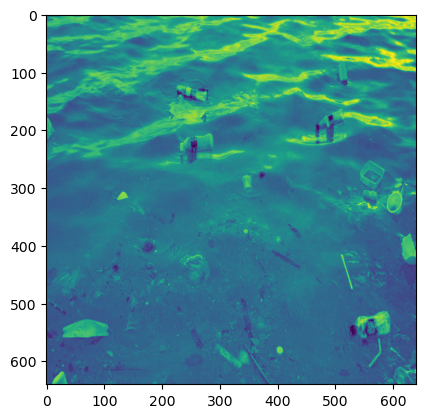

In [641]:
# # !pip install torchmetrics
# from torchmetrics.detection import MeanAveragePrecision

# metric = MeanAveragePrecision()
# model.to(device)
# model.eval()
# with torch.no_grad():
#     for i, (images, targets) in tqdm(enumerate(test_loader)):
#         images = [img.to(device) for img in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#         preds = model(images)
#         # print(preds)

#         pred1 = preds[0]['boxes'].cpu()
#         pred1 = np.array(pred1)
#         print('\npred: ', pred1)
        
#         imgs1 = images[0][0].cpu()
#         imgs1 = np.array(imgs1) * 255
#         print('\nimage: ', imgs1)
        
#         target1 = targets[0]['boxes'].cpu()
#         target1 = np.array(target1) 
#         print('\ntarget:, ', target1)
#         plt.imshow(imgs1)
#         for t in target1:
#             plt.Rectangle.draw()
#         break
        
#         # Приводим к формату torchmetrics
#         formatted_preds = []
#         for pred in preds:
#             formatted_preds.append({
#                 'boxes': pred['boxes'],
#                 'scores': pred['scores'],
#                 'labels': pred['labels']
#             })
        
#         metric.update(formatted_preds, targets)

# result = metric.compute()
# print(f"mAP: {result['map'].item():.4f}")  # Средний precision
# print(f"mAP@50: {result['map_50'].item():.4f}")  # При IoU=0.5

In [39]:
print('Avg mean losses: ', end='')
for elem in losses_epoches:
    avg_mean_losses = sum(elem)/len(elem)
    print(round(avg_mean_losses, 2), end='--> ')
print('\nmAP | mAP@50')
for elem in map_and_map50_epoches:
    mAP, mAP_50 = elem[0], elem[1]
    print(round(mAP, 4), round(mAP_50, 4))


Avg mean losses: 0.98--> 0.77--> 0.66--> 0.52--> 0.48--> 0.46--> 0.43--> 0.43--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 0.42--> 
mAP | mAP@50
0.1871 0.3743
0.269 0.5043
0.2317 0.5003
0.2786 0.5266
0.277 0.5293
0.2599 0.5267
0.2642 0.5271
0.2702 0.5284
0.2692 0.5275
0.2689 0.5287
0.2684 0.5286
0.2685 0.5273
0.2682 0.5273
0.2682 0.5274
0.2681 0.5274
0.2682 0.5274
0.2681 0.5273
0.2682 0.5274
0.2681 0.5274
0.2681 0.5271
0.2681 0.5273
0.2681 0.5271
0.2681 0.5271
0.2681 0.5271
0.2681 0.5271
0.2681 0.5271
0.2681 0.5271
0.2681 0.5271
0.2681 0.5271
0.2681 0.5271
0.2681 0.5271
0.2681 0.5271
0.2681 0.5271
0.2681 0.5271
0.2681 0.5271
0.2681 0.5271
0.2681 0.5271
0.2681 0.5271
0.2681 0.5271
0.2681 0.5271


In [ ]:
torch.save(model.state_dict(), 'FastRCNN_resnet50_fpn.pth')
print('Saved!')

In [253]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Current device: ', device)

Current device:  cuda


# Визуализация

In [6]:
def visualize_pred(image, true_target, pred_target, score_threshold=0.5):
    import matplotlib.patches as patches
    img = image.cpu().permute(1, 2, 0).numpy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
    fig.suptitle("Сравнение истинных и предсказанных bbox")
    
    # --- True Boxes ---
    ax1.set_title("Истинные bbox")
    ax1.imshow(img)
    for box in true_target['boxes'].cpu():
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1, 
            linewidth=1, edgecolor='lime', facecolor='none'
        )
        ax1.add_patch(rect)
    
    # --- Predicted Boxes ---
    ax2.set_title("Предсказанные bbox (score > {})".format(score_threshold))
    ax2.imshow(img)
    
    # Фильтрация по порогу уверенности
    keep = pred_target['scores'].cpu() > score_threshold
    boxes = pred_target['boxes'].cpu()[keep]
    scores = pred_target['scores'].cpu()[keep]
    
    for box, score in zip(boxes, scores):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1, 
            linewidth=1, edgecolor='red', facecolor='none'
        )
        ax2.add_patch(rect)
        ax2.text(
            x1, y1, f"{score:.2f}", 
            color='white', fontsize=8,
            bbox=dict(facecolor='red', alpha=0.5, pad=0)
        )
    
    plt.show()
    
def treshhold_certainly(targets, value=0.7):
    result = []
    for idx in range(len(targets)):
        t = targets[idx]
        t = {k:v.cpu() for k, v in t.items()}
        mask = t['scores'] >= value
        masked = {'boxes' : t['boxes'].cpu()[mask], 
                'labels': t['labels'].cpu()[mask], 
                'scores': t['scores'].cpu() [mask]}
        result.append(masked)
    return tuple(result)
    
# Пример использования:
images, targets = next(iter(test_loader))
model.eval()
model.to(device)
with torch.no_grad():
    imgs = [i.to(device) for i in images]
    predicted = model(imgs)
    pred_treshed = treshhold_certainly(predicted)

visualize_pred()

NameError: name 'test_loader' is not defined

In [647]:
#--------------------------------------------------Съезжает boxes на изображении , ненаглядно
# def treshhold_certainly(targets, value=0.7):
#     result = []
#     for idx in range(len(targets)):
#         t = targets[idx]
#         t = {k:v.cpu() for k, v in t.items()}
#         mask = t['scores'] >= value
#         masked = {'boxes' : t['boxes'].cpu()[mask], 
#                 'labels': t['labels'].cpu()[mask], 
#                 'scores': t['scores'].cpu() [mask]}
#         result.append(masked)
#     return tuple(result)
    

# def vizualizating(images, true_labels, pred_labels, subplots_row_col=(1, len(images)), with_description=True, in_one_img=True):
#     import matplotlib.patches as patches
#     fig, ax = plt.subplots(*subplots_row_col, figsize=(10, 10))
#     for idx in range(len(images)):
#         img = images[idx].permute(1,2,0).numpy()
#         ax[idx].imshow(img)
#         pred, true = pred_labels[idx], true_labels[idx]
        
#         pred = {k:v.cpu() for k, v in pred.items()}
#         true = {k:v.cpu() for k, v in true.items()}
#         b_pred, b_true = pred['boxes'], true['boxes']


#         for index, bp in enumerate(b_pred):
#             x, y, w, h = bp
#             w, h = w - x, h - y 
#             rect = patches.Rectangle(xy=(x,y), height=h, width=w, fc='none',ec='r', lw=1)
#             ax[idx].add_patch(rect)
#             if with_description:
#                 ax[idx].text(x, y, f'label-{pred['labels'][index]}({pred['scores'][index]:.2f})', color='white',
#                              bbox=dict(facecolor='red', alpha=0.3, pad = 0))
        
#         for index, bt in enumerate(b_true):
#             x, y, w, h = bt
#             w, h = w - x, h - y 
#             rect = patches.Rectangle(xy=(x,y), height=h, width=w, fc='none',ec='lime', lw=1)
#             if with_description:
#                 ax[idx].text(x,y+h, f'{true['labels'][index]}', color='lime', 
#                             bbox=dict(facecolor='black', alpha=0.3, pad=0))
#             ax[idx].add_patch(rect)

                
        
# images, targets = next(iter(test_loader))
# model.eval()
# model.to(device)
# with torch.no_grad():
#     imgs = [i.to(device) for i in images]
#     predicted = model(imgs)
#     pred_treshed = treshhold_certainly(predicted)
#     # print(pred_treshed)
    

# vizualizating(image, targets, pred_treshed, with_description=True)


# DeepSeek пытался, но не вывез Fcn_resnet50

In [20]:
import torchvision
from torchvision.models.segmentation import fcn_resnet50
from torchvision.transforms.functional import to_tensor, normalize
import torch.nn as nn


# Создаем модель (например, для 3 классов: фон, мусор, вода)
device = torch.device('cuda')
fcn = fcn_resnet50(num_classes=3).to(device)
print(fcn)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [36]:
from torchvision.transforms.v2 import Resize, Compose

# Общие трансформации для изображений и масок
common_transforms = Compose([
    Resize((512, 512)),  # Ресайз и для изображений, и для масок
])

# Трансформации ТОЛЬКО для изображений
image_transforms = Compose([
    common_transforms,
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Трансформации ТОЛЬКО для масок
mask_transforms = Compose([
    common_transforms,
    ToTensor()  # Маски должны быть типа torch.long
])

In [40]:
import os
import torch
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
from torchvision.transforms.v2 import functional as F
import torchvision

class MarineDebrisSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation_path, transforms=None):
        """
        root: Путь к папке с изображениями
        annotation_path: Путь к _annotations.coco.json
        transforms: Аугментации (для изображений и масок)
        """
        self.root = root
        self.coco = COCO(annotation_path)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = transforms

    def __getitem__(self, idx):
        # Загрузка изображения
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        # Загрузка масок (каждый класс = отдельный канал)
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        
        # Создаем маску [H, W] с классами: 0=фон, 1=класс1, 2=класс2...
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in anns:
            if ann['category_id'] == 0:  # Пропускаем фон (если есть)
                continue
            class_id = ann['category_id']
            x, y, w, h = map(int, ann['bbox'])
            mask[y:y+h, x:x+w] = class_id  # Закрашиваем bbox классом

        # Применяем трансформации
        if self.transforms:
            img = self.transforms(img)
            mask = torch.from_numpy(mask).long()  # Преобразуем в тензор
            # Для аугментаций масок используйте torchvision.transforms.v2
            if isinstance(self.transforms, torchvision.transforms.v2.Compose):
                img, mask = self.transforms(img, mask)
        
        return img, mask

    def __len__(self):
        return len(self.ids)

In [42]:
from torch.utils.data import DataLoader

# Пути к данным
train_root = r'C:\Users\bigbl\OneDrive\Документы\УРФУ\4 семестр\Проект по поиску морского мусора\marine_debris\train'
train_ann = train_root + '\\' + "_annotations.coco.json"
val_root = r'C:\Users\bigbl\OneDrive\Документы\УРФУ\4 семестр\Проект по поиску морского мусора\marine_debris\valid'
val_ann = val_root + '\\' + "_annotations.coco.json"

# Датасеты
fcn_train_dataset = MarineDebrisSegmentationDataset(
    root=train_root,
    annotation_path=train_ann,
    transforms=train_transforms
)

fcn_val_dataset = MarineDebrisSegmentationDataset(
    root=val_root,
    annotation_path=val_ann,
    transforms=val_transforms
)
fcn_train_dataset.coco.cats = {1: {'id': 1, 'name': 'can'},
 2: {'id': 2, 'name': 'foam'},
 3: {'id': 3, 'name': 'plastic'},
 4: {'id': 4, 'name': 'plastic bottle'},
 5: {'id': 5, 'name': 'unknow'}}
fcn_val_dataset.coco.cats = {1: {'id': 1, 'name': 'can'},
 2: {'id': 2, 'name': 'foam'},
 3: {'id': 3, 'name': 'plastic'},
 4: {'id': 4, 'name': 'plastic bottle'},
 5: {'id': 5, 'name': 'unknow'}}
# DataLoader
fcn_train_loader = DataLoader(
    fcn_train_dataset,
    batch_size=4,  
    shuffle=True,
)

fcn_val_loader = DataLoader(
    fcn_val_dataset,
    batch_size=4,
    shuffle=False,
)

next(iter(fcn_train_loader))

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


[tensor([[[[ 0.4647,  0.4647,  0.4647,  ...,  1.0249,  1.0249,  1.0249],
           [ 0.4973,  0.4973,  0.4973,  ...,  1.0170,  1.0234,  1.0249],
           [ 0.5605,  0.5605,  0.5605,  ...,  1.0016,  1.0205,  1.0249],
           ...,
           [-1.2447, -1.2570, -1.3098,  ...,  0.7755,  0.6281,  0.5938],
           [-1.3079, -1.3347, -1.4499,  ...,  1.0600,  0.9126,  0.8783],
           [-1.3405, -1.3748, -1.5221,  ...,  1.2066,  1.0592,  1.0249]],
 
          [[ 1.0029,  1.0029,  1.0029,  ...,  1.5233,  1.5233,  1.5233],
           [ 1.0540,  1.0540,  1.0540,  ...,  1.5151,  1.5218,  1.5233],
           [ 1.1531,  1.1531,  1.1531,  ...,  1.4990,  1.5187,  1.5233],
           ...,
           [ 0.1170,  0.0880, -0.0363,  ...,  1.2310,  1.1026,  1.0728],
           [ 0.3152,  0.2620,  0.0334,  ...,  1.5283,  1.4000,  1.3701],
           [ 0.4174,  0.3517,  0.0693,  ...,  1.6815,  1.5532,  1.5233]],
 
          [[ 2.1606,  2.1606,  2.1606,  ...,  2.6400,  2.6400,  2.6400],
           [ 

In [44]:
from torch import optim
optimizer = optim.Adam(fcn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Игнорируем фон (класс 0)

In [48]:
from tqdm import tqdm
import torch
import pickle
from time import perf_counter

num_epochs = 40
best_iou = 0.0
losses_epochs = []
val_loss_epochs = []
time_epochs = []

torch.cuda.empty_cache()
for epoch in range(num_epochs):
    fcn.train()
    train_loss = 0.0
    tmp_loss = []
    start_time = perf_counter()
    
    # Итерация по тренировочным данным
    for images, masks in tqdm(fcn_train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        # Перенос данных на устройство (тензоры, а не списки!)
        images = images.to(device)  # [B, C, H, W]
        masks = masks.to(device)    # [B, H, W] (целочисленные классы)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = fcn(images)['out']  # Важно: FCN возвращает словарь с ключом 'out'
        loss = criterion(outputs, masks)
        tmp_loss.append(loss.item())
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    time_epochs.append(perf_counter() - start_time)
    train_loss /= len(train_loader)
    losses_epochs.append(train_loss)
    print(f'Epoch {epoch+1} | Train Loss: {train_loss:.4f}')
    
    # Валидация
    fcn.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = fcn(images)['out']
            val_loss += criterion(outputs, masks).item()
    
    val_loss /= len(val_loader)
    val_loss_epochs.append(val_loss)
    print(f'Validation Loss: {val_loss:.4f}')
    
    # Сохранение лучшей модели
    if val_loss < best_iou:
        best_iou = val_loss
        torch.save(fcn.state_dict(), 'fcn_resnet50_best.pth')
        print('Model saved!')
    torch.cuda.empty_cache()
# Сохранение метрик
with open('fcn_losses_epochs.pkl', 'wb') as f:
    pickle.dump(losses_epochs, f)
with open('fcn_time_epochs.pkl', 'wb') as f:
    pickle.dump(time_epochs, f)
with open('fcn_val_loss_epochs.pkl', 'wb') as f:
    pickle.dump(val_loss_epochs, f)

Epoch 1/40:   0%|                                                                              | 0/334 [00:03<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 10.36 GiB is allocated by PyTorch, and 176.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)